In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# TUNED
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 6
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 32
    cooc_threshold = 150
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    # features
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    age_volume_feature_weeks = 1


In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 9.131 s


[popular] 0.736 s


[age popular] 0.590 s


[item2item] 8.189 s


[item2item2] 7.875 s


[cooccurrence] 59.766 s


[same_product_code] 2.850 s


[ohe distance] 17.628 s


volume: 16808210


duplicates: 1.0996503838489493


            strategy   volume     ratio
0  same_product_code  4186861  0.249096
1                pop  4139040  0.246251
2         repurchase  3446562  0.205052
3       ohe_distance  2982578  0.177448
4               cooc  1228865  0.073111
5            age_pop   824304  0.049042


create candidates (week: 2)


[repurchase] 9.217 s


[popular] 0.731 s


[age popular] 0.646 s


[item2item] 8.502 s


[item2item2] 8.290 s


[cooccurrence] 57.410 s


[same_product_code] 2.933 s


[ohe distance] 16.809 s


volume: 17652718


duplicates: 1.0985360169744667


            strategy   volume     ratio
0  same_product_code  4398614  0.249175
1                pop  4321140  0.244786
2         repurchase  3637145  0.206039
3       ohe_distance  3132450  0.177449
4               cooc  1302993  0.073813
5            age_pop   860376  0.048739


create candidates (week: 3)


[repurchase] 9.103 s


[popular] 0.784 s


[age popular] 0.657 s


[item2item] 8.424 s


[item2item2] 8.391 s


[cooccurrence] 57.480 s


[same_product_code] 3.068 s


[ohe distance] 17.361 s


volume: 18592448


duplicates: 1.10202043869101


            strategy   volume     ratio
0  same_product_code  4679508  0.251689
1                pop  4549320  0.244686
2         repurchase  3742824  0.201309
3       ohe_distance  3296444  0.177300
4               cooc  1418580  0.076299
5            age_pop   905772  0.048717


create candidates (week: 4)


[repurchase] 9.545 s


[popular] 0.782 s


[age popular] 0.601 s


[item2item] 8.868 s


[item2item2] 8.728 s


[cooccurrence] 57.362 s


[same_product_code] 3.198 s


[ohe distance] 17.698 s


volume: 19696382


duplicates: 1.102336184300588


            strategy   volume     ratio
0  same_product_code  4998786  0.253792
1                pop  4815180  0.244470
2         repurchase  3915353  0.198785
3       ohe_distance  3495473  0.177468
4               cooc  1512886  0.076810
5            age_pop   958704  0.048674


create candidates (week: 5)


[repurchase] 8.556 s


[popular] 0.737 s


[age popular] 0.612 s


[item2item] 7.945 s


[item2item2] 7.890 s


[cooccurrence] 57.740 s


[same_product_code] 3.031 s


[ohe distance] 17.273 s


volume: 17719452


duplicates: 1.1031077161347131


            strategy   volume     ratio
0  same_product_code  4486085  0.253173
1                pop  4322100  0.243918
2         repurchase  3548895  0.200282
3       ohe_distance  3154696  0.178036
4               cooc  1347096  0.076024
5            age_pop   860580  0.048567


create candidates (week: 6)


[repurchase] 8.757 s


[popular] 0.747 s


[age popular] 0.637 s


[item2item] 8.154 s


[item2item2] 7.924 s


[cooccurrence] 58.348 s


[same_product_code] 3.001 s


[ohe distance] 16.818 s


volume: 17579037


duplicates: 1.0955613685395498


            strategy   volume     ratio
0  same_product_code  4473501  0.254479
1                pop  4265640  0.242655
2         repurchase  3547521  0.201804
3       ohe_distance  3132237  0.178180
4               cooc  1310406  0.074544
5            age_pop   849732  0.048338


create candidates (week: 7)


[repurchase] 8.879 s


[popular] 0.752 s


[age popular] 0.675 s


[item2item] 8.106 s


[item2item2] 8.105 s


[cooccurrence] 57.124 s


[same_product_code] 3.220 s


[ohe distance] 17.162 s


volume: 18200547


duplicates: 1.0971032582444982


            strategy   volume     ratio
0  same_product_code  4674139  0.256813
1                pop  4489980  0.246695
2         repurchase  3571089  0.196208
3       ohe_distance  3269945  0.179662
4               cooc  1301286  0.071497
5            age_pop   894108  0.049125


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.15260050157209162


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   6328.0  4186861  0.029608   0.001511
3            age_pop   5301.0   824304  0.024803   0.006431
4               cooc   3321.0  1228865  0.015538   0.002702
5       ohe_distance   2268.0  2982578  0.010612   0.000760
merge labels (week: 1)


Recall: 0.14143740950375147


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   7005.0  4398614  0.030736   0.001593
3            age_pop   4816.0   860376  0.021131   0.005598
4               cooc   3651.0  1302993  0.016019   0.002802
5       ohe_distance   2349.0  3132450  0.010307   0.000750
merge labels (week: 2)


Recall: 0.14407705167300924


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   6935.0  4679508  0.029130   0.001482
3            age_pop   5809.0   905772  0.024400   0.006413
4               cooc   3965.0  1418580  0.016654   0.002795
5       ohe_distance   2347.0  3296444  0.009858   0.000712
merge labels (week: 3)


Recall: 0.14173968930760428


            strategy        y   volume    recall  hit_ratio
0                pop  18262.0  4815180  0.071567   0.003793
1         repurchase   9002.0  3915353  0.035278   0.002299
2  same_product_code   7336.0  4998786  0.028749   0.001468
3            age_pop   6073.0   958704  0.023800   0.006335
4               cooc   4429.0  1512886  0.017357   0.002928
5       ohe_distance   2509.0  3495473  0.009833   0.000718
merge labels (week: 4)


Recall: 0.1372988194519658


            strategy        y   volume    recall  hit_ratio
0                pop  13948.0  4322100  0.060427   0.003227
1         repurchase   8945.0  3548895  0.038752   0.002521
2  same_product_code   7392.0  4486085  0.032024   0.001648
3            age_pop   4770.0   860580  0.020665   0.005543
4               cooc   4576.0  1347096  0.019825   0.003397
5       ohe_distance   2119.0  3154696  0.009180   0.000672
merge labels (week: 5)


Recall: 0.12906476640242873


            strategy        y   volume    recall  hit_ratio
0                pop  11255.0  4265640  0.047457   0.002639
1         repurchase   9673.0  3547521  0.040787   0.002727
2  same_product_code   7454.0  4473501  0.031430   0.001666
3               cooc   4654.0  1310406  0.019624   0.003552
4            age_pop   3433.0   849732  0.014475   0.004040
5       ohe_distance   1803.0  3132237  0.007602   0.000576
merge labels (week: 6)


Recall: 0.11564397792780295


            strategy        y   volume    recall  hit_ratio
0                pop  11008.0  4489980  0.042418   0.002452
1         repurchase   9107.0  3571089  0.035093   0.002550
2  same_product_code   7871.0  4674139  0.030330   0.001684
3               cooc   4830.0  1301286  0.018612   0.003712
4            age_pop   3051.0   894108  0.011757   0.003412
5       ohe_distance   1760.0  3269945  0.006782   0.000538


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 16808210 -> 5982900


drop trivial queries: 17652718 -> 6133505


drop trivial queries: 18592448 -> 6583470


drop trivial queries: 19696382 -> 6949344


drop trivial queries: 17719452 -> 6015837


drop trivial queries: 17579037 -> 5621643


drop trivial queries: 18200547 -> 5699845


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()
    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.699 s


[item stacic features] 4.894 s


[user dynamic features (transactions)] 4.999 s


[item dynamic features (transactions)] 2.783 s


[item dynamic features (user features)] 5.683 s


[item freshness features] 4.625 s


[item volume features] 3.169 s


[user freshness features] 6.168 s


[user volume features] 4.538 s


[user-item freshness features] 23.758 s


[user-item volume features] 8.292 s


[item age volume features] 4.993 s


[ohe dot products] 121.756 s


[lfm features] 9.151 s
attach features (week: 1)


[user static fetaures] 0.644 s


[item stacic features] 1.637 s


[user dynamic features (transactions)] 3.284 s


[item dynamic features (transactions)] 1.364 s


[item dynamic features (user features)] 4.141 s


[item freshness features] 2.965 s


[item volume features] 1.435 s


[user freshness features] 4.077 s


[user volume features] 2.301 s


[user-item freshness features] 20.775 s


[user-item volume features] 4.436 s


[item age volume features] 2.321 s


[ohe dot products] 57.365 s


[lfm features] 3.158 s
attach features (week: 2)


[user static fetaures] 0.651 s


[item stacic features] 1.645 s


[user dynamic features (transactions)] 3.330 s


[item dynamic features (transactions)] 1.374 s


[item dynamic features (user features)] 4.159 s


[item freshness features] 2.973 s


[item volume features] 1.477 s


[user freshness features] 4.087 s


[user volume features] 2.361 s


[user-item freshness features] 20.602 s


[user-item volume features] 4.565 s


[item age volume features] 2.354 s


[ohe dot products] 58.278 s


[lfm features] 3.051 s
attach features (week: 3)


[user static fetaures] 0.683 s


[item stacic features] 1.757 s


[user dynamic features (transactions)] 3.438 s


[item dynamic features (transactions)] 1.443 s


[item dynamic features (user features)] 4.220 s


[item freshness features] 3.003 s


[item volume features] 1.500 s


[user freshness features] 4.170 s


[user volume features] 2.456 s


[user-item freshness features] 20.717 s


[user-item volume features] 4.634 s


[item age volume features] 2.482 s


[ohe dot products] 57.460 s


[lfm features] 4.473 s
attach features (week: 4)


[user static fetaures] 0.695 s


[item stacic features] 1.860 s


[user dynamic features (transactions)] 3.412 s


[item dynamic features (transactions)] 1.471 s


[item dynamic features (user features)] 4.301 s


[item freshness features] 3.031 s


[item volume features] 1.568 s


[user freshness features] 4.203 s


[user volume features] 2.514 s


[user-item freshness features] 20.611 s


[user-item volume features] 4.770 s


[item age volume features] 2.551 s


[ohe dot products] 60.012 s


[lfm features] 3.532 s
attach features (week: 5)


[user static fetaures] 0.608 s


[item stacic features] 1.476 s


[user dynamic features (transactions)] 3.354 s


[item dynamic features (transactions)] 1.299 s


[item dynamic features (user features)] 4.107 s


[item freshness features] 2.840 s


[item volume features] 1.415 s


[user freshness features] 4.123 s


[user volume features] 2.362 s


[user-item freshness features] 20.034 s


[user-item volume features] 4.466 s


[item age volume features] 2.324 s


[ohe dot products] 54.532 s


[lfm features] 3.437 s
attach features (week: 6)


[user static fetaures] 0.587 s


[item stacic features] 1.390 s


[user dynamic features (transactions)] 3.310 s


[item dynamic features (transactions)] 1.286 s


[item dynamic features (user features)] 4.064 s


[item freshness features] 2.792 s


[item volume features] 1.338 s


[user freshness features] 4.059 s


[user volume features] 2.295 s


[user-item freshness features] 20.095 s


[user-item volume features] 4.430 s


[item age volume features] 2.331 s


[ohe dot products] 54.163 s


[lfm features] 3.670 s
attach features (week: 7)


[user static fetaures] 0.595 s


[item stacic features] 1.424 s


[user dynamic features (transactions)] 3.351 s


[item dynamic features (transactions)] 1.299 s


[item dynamic features (user features)] 4.081 s


[item freshness features] 2.788 s


[item volume features] 1.365 s


[user freshness features] 4.081 s


[user volume features] 2.350 s


[user-item freshness features] 19.167 s


[user-item volume features] 4.575 s


[item age volume features] 2.384 s


[ohe dot products] 57.172 s


[lfm features] 3.980 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_o

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1087833	best: 0.1087833 (0)	total: 6.01s	remaining: 8h 21m 2s


1:	test: 0.1187490	best: 0.1187490 (1)	total: 11.3s	remaining: 7h 51m 8s


2:	test: 0.1426678	best: 0.1426678 (2)	total: 16.5s	remaining: 7h 36m 47s


3:	test: 0.1418257	best: 0.1426678 (2)	total: 21.5s	remaining: 7h 28m 31s


4:	test: 0.1462916	best: 0.1462916 (4)	total: 27s	remaining: 7h 28m 49s


5:	test: 0.1487688	best: 0.1487688 (5)	total: 33.3s	remaining: 7h 41m 53s


6:	test: 0.1663126	best: 0.1663126 (6)	total: 39.6s	remaining: 7h 51m 18s


7:	test: 0.1687186	best: 0.1687186 (7)	total: 45.2s	remaining: 7h 49m 35s


8:	test: 0.1755263	best: 0.1755263 (8)	total: 50.6s	remaining: 7h 48m 3s


9:	test: 0.1756545	best: 0.1756545 (9)	total: 56s	remaining: 7h 45m 52s


10:	test: 0.1775614	best: 0.1775614 (10)	total: 1m 1s	remaining: 7h 44m 7s


11:	test: 0.1914255	best: 0.1914255 (11)	total: 1m 6s	remaining: 7h 42m 51s


12:	test: 0.1917284	best: 0.1917284 (12)	total: 1m 12s	remaining: 7h 42m 15s


13:	test: 0.1944420	best: 0.1944420 (13)	total: 1m 17s	remaining: 7h 41m 40s


14:	test: 0.1946842	best: 0.1946842 (14)	total: 1m 23s	remaining: 7h 40m 22s


15:	test: 0.2034428	best: 0.2034428 (15)	total: 1m 28s	remaining: 7h 40m 23s


16:	test: 0.2116437	best: 0.2116437 (16)	total: 1m 34s	remaining: 7h 39m 41s


17:	test: 0.2114520	best: 0.2116437 (16)	total: 1m 39s	remaining: 7h 39m 22s


18:	test: 0.2123025	best: 0.2123025 (18)	total: 1m 44s	remaining: 7h 38m 42s


19:	test: 0.2127428	best: 0.2127428 (19)	total: 1m 50s	remaining: 7h 38m 35s


20:	test: 0.2135319	best: 0.2135319 (20)	total: 1m 56s	remaining: 7h 38m 26s


21:	test: 0.2138007	best: 0.2138007 (21)	total: 2m 1s	remaining: 7h 37m 47s


22:	test: 0.2136088	best: 0.2138007 (21)	total: 2m 6s	remaining: 7h 37m 50s


23:	test: 0.2137473	best: 0.2138007 (21)	total: 2m 12s	remaining: 7h 37m 45s


24:	test: 0.2170338	best: 0.2170338 (24)	total: 2m 17s	remaining: 7h 37m 15s


25:	test: 0.2188478	best: 0.2188478 (25)	total: 2m 23s	remaining: 7h 36m 55s


26:	test: 0.2189911	best: 0.2189911 (26)	total: 2m 28s	remaining: 7h 36m 33s


27:	test: 0.2193068	best: 0.2193068 (27)	total: 2m 34s	remaining: 7h 36m 20s


28:	test: 0.2205153	best: 0.2205153 (28)	total: 2m 39s	remaining: 7h 36m 9s


29:	test: 0.2214265	best: 0.2214265 (29)	total: 2m 45s	remaining: 7h 35m 58s


30:	test: 0.2227625	best: 0.2227625 (30)	total: 2m 50s	remaining: 7h 36m 7s


31:	test: 0.2233252	best: 0.2233252 (31)	total: 2m 56s	remaining: 7h 36m 5s


32:	test: 0.2261387	best: 0.2261387 (32)	total: 3m 1s	remaining: 7h 35m 52s


33:	test: 0.2268095	best: 0.2268095 (33)	total: 3m 7s	remaining: 7h 35m 49s


34:	test: 0.2280162	best: 0.2280162 (34)	total: 3m 12s	remaining: 7h 35m 45s


35:	test: 0.2320450	best: 0.2320450 (35)	total: 3m 18s	remaining: 7h 35m 47s


36:	test: 0.2356594	best: 0.2356594 (36)	total: 3m 23s	remaining: 7h 35m 47s


37:	test: 0.2362764	best: 0.2362764 (37)	total: 3m 29s	remaining: 7h 35m 38s


38:	test: 0.2363227	best: 0.2363227 (38)	total: 3m 35s	remaining: 7h 35m 53s


39:	test: 0.2364146	best: 0.2364146 (39)	total: 3m 40s	remaining: 7h 35m 54s


40:	test: 0.2370767	best: 0.2370767 (40)	total: 3m 46s	remaining: 7h 35m 39s


41:	test: 0.2369531	best: 0.2370767 (40)	total: 3m 51s	remaining: 7h 35m 39s


42:	test: 0.2369593	best: 0.2370767 (40)	total: 3m 57s	remaining: 7h 35m 33s


43:	test: 0.2378324	best: 0.2378324 (43)	total: 4m 2s	remaining: 7h 35m 9s


44:	test: 0.2377412	best: 0.2378324 (43)	total: 4m 7s	remaining: 7h 34m 36s


45:	test: 0.2402584	best: 0.2402584 (45)	total: 4m 13s	remaining: 7h 34m 29s


46:	test: 0.2403994	best: 0.2403994 (46)	total: 4m 18s	remaining: 7h 34m 40s


47:	test: 0.2409455	best: 0.2409455 (47)	total: 4m 24s	remaining: 7h 34m 28s


48:	test: 0.2408950	best: 0.2409455 (47)	total: 4m 29s	remaining: 7h 34m 26s


49:	test: 0.2408617	best: 0.2409455 (47)	total: 4m 35s	remaining: 7h 34m 21s


50:	test: 0.2405748	best: 0.2409455 (47)	total: 4m 40s	remaining: 7h 34m 5s


51:	test: 0.2407567	best: 0.2409455 (47)	total: 4m 46s	remaining: 7h 33m 55s


52:	test: 0.2407677	best: 0.2409455 (47)	total: 4m 51s	remaining: 7h 33m 30s


53:	test: 0.2407231	best: 0.2409455 (47)	total: 4m 57s	remaining: 7h 33m 40s


54:	test: 0.2406320	best: 0.2409455 (47)	total: 5m 2s	remaining: 7h 33m 31s


55:	test: 0.2410890	best: 0.2410890 (55)	total: 5m 7s	remaining: 7h 33m 8s


56:	test: 0.2423807	best: 0.2423807 (56)	total: 5m 13s	remaining: 7h 32m 48s


57:	test: 0.2426426	best: 0.2426426 (57)	total: 5m 18s	remaining: 7h 32m 45s


58:	test: 0.2426407	best: 0.2426426 (57)	total: 5m 24s	remaining: 7h 32m 20s


59:	test: 0.2430065	best: 0.2430065 (59)	total: 5m 29s	remaining: 7h 31m 47s


60:	test: 0.2429942	best: 0.2430065 (59)	total: 5m 34s	remaining: 7h 31m 13s


61:	test: 0.2429735	best: 0.2430065 (59)	total: 5m 39s	remaining: 7h 31m 12s


62:	test: 0.2435533	best: 0.2435533 (62)	total: 5m 45s	remaining: 7h 31m 11s


63:	test: 0.2438024	best: 0.2438024 (63)	total: 5m 50s	remaining: 7h 30m 43s


64:	test: 0.2449061	best: 0.2449061 (64)	total: 5m 55s	remaining: 7h 30m 13s


65:	test: 0.2451749	best: 0.2451749 (65)	total: 6m 1s	remaining: 7h 30m 16s


66:	test: 0.2453297	best: 0.2453297 (66)	total: 6m 6s	remaining: 7h 30m 15s


67:	test: 0.2454075	best: 0.2454075 (67)	total: 6m 12s	remaining: 7h 30m 13s


68:	test: 0.2462416	best: 0.2462416 (68)	total: 6m 17s	remaining: 7h 30m 6s


69:	test: 0.2462363	best: 0.2462416 (68)	total: 6m 23s	remaining: 7h 29m 43s


70:	test: 0.2461404	best: 0.2462416 (68)	total: 6m 28s	remaining: 7h 29m 21s


71:	test: 0.2461172	best: 0.2462416 (68)	total: 6m 33s	remaining: 7h 29m 17s


72:	test: 0.2461969	best: 0.2462416 (68)	total: 6m 39s	remaining: 7h 29m 12s


73:	test: 0.2463711	best: 0.2463711 (73)	total: 6m 44s	remaining: 7h 29m 3s


74:	test: 0.2465875	best: 0.2465875 (74)	total: 6m 50s	remaining: 7h 28m 45s


75:	test: 0.2464478	best: 0.2465875 (74)	total: 6m 55s	remaining: 7h 28m 43s


76:	test: 0.2480442	best: 0.2480442 (76)	total: 7m 1s	remaining: 7h 28m 45s


77:	test: 0.2483174	best: 0.2483174 (77)	total: 7m 6s	remaining: 7h 28m 40s


78:	test: 0.2482559	best: 0.2483174 (77)	total: 7m 11s	remaining: 7h 28m 27s


79:	test: 0.2482119	best: 0.2483174 (77)	total: 7m 17s	remaining: 7h 28m 25s


80:	test: 0.2483015	best: 0.2483174 (77)	total: 7m 22s	remaining: 7h 28m 17s


81:	test: 0.2484433	best: 0.2484433 (81)	total: 7m 28s	remaining: 7h 28m 14s


82:	test: 0.2483451	best: 0.2484433 (81)	total: 7m 33s	remaining: 7h 28m 8s


83:	test: 0.2484288	best: 0.2484433 (81)	total: 7m 39s	remaining: 7h 27m 47s


84:	test: 0.2485003	best: 0.2485003 (84)	total: 7m 44s	remaining: 7h 27m 42s


85:	test: 0.2486077	best: 0.2486077 (85)	total: 7m 50s	remaining: 7h 27m 40s


86:	test: 0.2489276	best: 0.2489276 (86)	total: 7m 55s	remaining: 7h 27m 28s


87:	test: 0.2488446	best: 0.2489276 (86)	total: 8m 1s	remaining: 7h 27m 38s


88:	test: 0.2490322	best: 0.2490322 (88)	total: 8m 6s	remaining: 7h 27m 43s


89:	test: 0.2493150	best: 0.2493150 (89)	total: 8m 12s	remaining: 7h 27m 35s


90:	test: 0.2495302	best: 0.2495302 (90)	total: 8m 17s	remaining: 7h 27m 29s


91:	test: 0.2496572	best: 0.2496572 (91)	total: 8m 23s	remaining: 7h 27m 19s


92:	test: 0.2498902	best: 0.2498902 (92)	total: 8m 28s	remaining: 7h 27m 15s


93:	test: 0.2498725	best: 0.2498902 (92)	total: 8m 33s	remaining: 7h 27m 3s


94:	test: 0.2499081	best: 0.2499081 (94)	total: 8m 39s	remaining: 7h 26m 58s


95:	test: 0.2501915	best: 0.2501915 (95)	total: 8m 44s	remaining: 7h 26m 41s


96:	test: 0.2504162	best: 0.2504162 (96)	total: 8m 50s	remaining: 7h 26m 42s


97:	test: 0.2506668	best: 0.2506668 (97)	total: 8m 55s	remaining: 7h 26m 39s


98:	test: 0.2507696	best: 0.2507696 (98)	total: 9m 1s	remaining: 7h 26m 35s


99:	test: 0.2509279	best: 0.2509279 (99)	total: 9m 6s	remaining: 7h 26m 32s


100:	test: 0.2509857	best: 0.2509857 (100)	total: 9m 12s	remaining: 7h 26m 17s


101:	test: 0.2512416	best: 0.2512416 (101)	total: 9m 17s	remaining: 7h 26m 11s


102:	test: 0.2515631	best: 0.2515631 (102)	total: 9m 23s	remaining: 7h 26m 17s


103:	test: 0.2517177	best: 0.2517177 (103)	total: 9m 28s	remaining: 7h 26m 11s


104:	test: 0.2519841	best: 0.2519841 (104)	total: 9m 34s	remaining: 7h 26m 9s


105:	test: 0.2523374	best: 0.2523374 (105)	total: 9m 39s	remaining: 7h 26m 10s


106:	test: 0.2522333	best: 0.2523374 (105)	total: 9m 45s	remaining: 7h 26m 5s


107:	test: 0.2523954	best: 0.2523954 (107)	total: 9m 50s	remaining: 7h 25m 49s


108:	test: 0.2528978	best: 0.2528978 (108)	total: 9m 56s	remaining: 7h 25m 44s


109:	test: 0.2530938	best: 0.2530938 (109)	total: 10m 1s	remaining: 7h 25m 44s


110:	test: 0.2530855	best: 0.2530938 (109)	total: 10m 7s	remaining: 7h 25m 39s


111:	test: 0.2531938	best: 0.2531938 (111)	total: 10m 12s	remaining: 7h 25m 39s


112:	test: 0.2532141	best: 0.2532141 (112)	total: 10m 18s	remaining: 7h 25m 35s


113:	test: 0.2534645	best: 0.2534645 (113)	total: 10m 23s	remaining: 7h 25m 33s


114:	test: 0.2536451	best: 0.2536451 (114)	total: 10m 29s	remaining: 7h 25m 23s


115:	test: 0.2536608	best: 0.2536608 (115)	total: 10m 34s	remaining: 7h 25m 5s


116:	test: 0.2536639	best: 0.2536639 (116)	total: 10m 39s	remaining: 7h 24m 58s


117:	test: 0.2536064	best: 0.2536639 (116)	total: 10m 45s	remaining: 7h 24m 55s


118:	test: 0.2536778	best: 0.2536778 (118)	total: 10m 50s	remaining: 7h 24m 50s


119:	test: 0.2541332	best: 0.2541332 (119)	total: 10m 56s	remaining: 7h 24m 50s


120:	test: 0.2542403	best: 0.2542403 (120)	total: 11m 1s	remaining: 7h 24m 44s


121:	test: 0.2543025	best: 0.2543025 (121)	total: 11m 7s	remaining: 7h 24m 39s


122:	test: 0.2546280	best: 0.2546280 (122)	total: 11m 12s	remaining: 7h 24m 31s


123:	test: 0.2547834	best: 0.2547834 (123)	total: 11m 18s	remaining: 7h 24m 31s


124:	test: 0.2551631	best: 0.2551631 (124)	total: 11m 23s	remaining: 7h 24m 21s


125:	test: 0.2555316	best: 0.2555316 (125)	total: 11m 29s	remaining: 7h 24m 24s


126:	test: 0.2557582	best: 0.2557582 (126)	total: 11m 34s	remaining: 7h 24m 16s


127:	test: 0.2557773	best: 0.2557773 (127)	total: 11m 40s	remaining: 7h 24m 16s


128:	test: 0.2562360	best: 0.2562360 (128)	total: 11m 45s	remaining: 7h 23m 59s


129:	test: 0.2564809	best: 0.2564809 (129)	total: 11m 50s	remaining: 7h 23m 50s


130:	test: 0.2568195	best: 0.2568195 (130)	total: 11m 56s	remaining: 7h 23m 42s


131:	test: 0.2570952	best: 0.2570952 (131)	total: 12m 1s	remaining: 7h 23m 27s


132:	test: 0.2571347	best: 0.2571347 (132)	total: 12m 6s	remaining: 7h 23m 11s


133:	test: 0.2570672	best: 0.2571347 (132)	total: 12m 12s	remaining: 7h 23m 6s


134:	test: 0.2570609	best: 0.2571347 (132)	total: 12m 17s	remaining: 7h 22m 48s


135:	test: 0.2573310	best: 0.2573310 (135)	total: 12m 22s	remaining: 7h 22m 46s


136:	test: 0.2576475	best: 0.2576475 (136)	total: 12m 28s	remaining: 7h 22m 34s


137:	test: 0.2577593	best: 0.2577593 (137)	total: 12m 33s	remaining: 7h 22m 30s


138:	test: 0.2580254	best: 0.2580254 (138)	total: 12m 39s	remaining: 7h 22m 26s


139:	test: 0.2582450	best: 0.2582450 (139)	total: 12m 44s	remaining: 7h 22m 15s


140:	test: 0.2579360	best: 0.2582450 (139)	total: 12m 49s	remaining: 7h 22m 11s


141:	test: 0.2580726	best: 0.2582450 (139)	total: 12m 55s	remaining: 7h 21m 57s


142:	test: 0.2581763	best: 0.2582450 (139)	total: 13m	remaining: 7h 21m 56s


143:	test: 0.2583754	best: 0.2583754 (143)	total: 13m 5s	remaining: 7h 21m 41s


144:	test: 0.2584523	best: 0.2584523 (144)	total: 13m 11s	remaining: 7h 21m 26s


145:	test: 0.2585653	best: 0.2585653 (145)	total: 13m 16s	remaining: 7h 21m 23s


146:	test: 0.2585176	best: 0.2585653 (145)	total: 13m 22s	remaining: 7h 21m 20s


147:	test: 0.2586159	best: 0.2586159 (147)	total: 13m 27s	remaining: 7h 21m 14s


148:	test: 0.2588017	best: 0.2588017 (148)	total: 13m 32s	remaining: 7h 21m 7s


149:	test: 0.2589226	best: 0.2589226 (149)	total: 13m 38s	remaining: 7h 21m 2s


150:	test: 0.2590371	best: 0.2590371 (150)	total: 13m 43s	remaining: 7h 20m 53s


151:	test: 0.2591615	best: 0.2591615 (151)	total: 13m 48s	remaining: 7h 20m 37s


152:	test: 0.2595178	best: 0.2595178 (152)	total: 13m 54s	remaining: 7h 20m 34s


153:	test: 0.2596347	best: 0.2596347 (153)	total: 13m 59s	remaining: 7h 20m 22s


154:	test: 0.2597886	best: 0.2597886 (154)	total: 14m 4s	remaining: 7h 20m 12s


155:	test: 0.2598350	best: 0.2598350 (155)	total: 14m 10s	remaining: 7h 19m 55s


156:	test: 0.2597516	best: 0.2598350 (155)	total: 14m 15s	remaining: 7h 19m 46s


157:	test: 0.2597305	best: 0.2598350 (155)	total: 14m 20s	remaining: 7h 19m 35s


158:	test: 0.2600123	best: 0.2600123 (158)	total: 14m 25s	remaining: 7h 19m 26s


159:	test: 0.2602397	best: 0.2602397 (159)	total: 14m 31s	remaining: 7h 19m 16s


160:	test: 0.2603251	best: 0.2603251 (160)	total: 14m 36s	remaining: 7h 19m 5s


161:	test: 0.2604304	best: 0.2604304 (161)	total: 14m 41s	remaining: 7h 18m 59s


162:	test: 0.2604768	best: 0.2604768 (162)	total: 14m 47s	remaining: 7h 18m 59s


163:	test: 0.2607270	best: 0.2607270 (163)	total: 14m 53s	remaining: 7h 18m 55s


164:	test: 0.2607068	best: 0.2607270 (163)	total: 14m 58s	remaining: 7h 18m 41s


165:	test: 0.2609114	best: 0.2609114 (165)	total: 15m 3s	remaining: 7h 18m 27s


166:	test: 0.2607486	best: 0.2609114 (165)	total: 15m 9s	remaining: 7h 18m 29s


167:	test: 0.2607891	best: 0.2609114 (165)	total: 15m 14s	remaining: 7h 18m 17s


168:	test: 0.2611405	best: 0.2611405 (168)	total: 15m 19s	remaining: 7h 18m 16s


169:	test: 0.2612687	best: 0.2612687 (169)	total: 15m 25s	remaining: 7h 18m 15s


170:	test: 0.2612979	best: 0.2612979 (170)	total: 15m 30s	remaining: 7h 18m 11s


171:	test: 0.2614231	best: 0.2614231 (171)	total: 15m 36s	remaining: 7h 18m 9s


172:	test: 0.2614344	best: 0.2614344 (172)	total: 15m 41s	remaining: 7h 18m 3s


173:	test: 0.2615321	best: 0.2615321 (173)	total: 15m 47s	remaining: 7h 18m


174:	test: 0.2617998	best: 0.2617998 (174)	total: 15m 52s	remaining: 7h 17m 55s


175:	test: 0.2619139	best: 0.2619139 (175)	total: 15m 58s	remaining: 7h 17m 51s


176:	test: 0.2621447	best: 0.2621447 (176)	total: 16m 4s	remaining: 7h 17m 50s


177:	test: 0.2620230	best: 0.2621447 (176)	total: 16m 9s	remaining: 7h 17m 34s


178:	test: 0.2620145	best: 0.2621447 (176)	total: 16m 14s	remaining: 7h 17m 29s


179:	test: 0.2621404	best: 0.2621447 (176)	total: 16m 20s	remaining: 7h 17m 25s


180:	test: 0.2624624	best: 0.2624624 (180)	total: 16m 25s	remaining: 7h 17m 24s


181:	test: 0.2624849	best: 0.2624849 (181)	total: 16m 31s	remaining: 7h 17m 21s


182:	test: 0.2626447	best: 0.2626447 (182)	total: 16m 36s	remaining: 7h 17m 11s


183:	test: 0.2626687	best: 0.2626687 (183)	total: 16m 42s	remaining: 7h 17m 7s


184:	test: 0.2629738	best: 0.2629738 (184)	total: 16m 47s	remaining: 7h 16m 57s


185:	test: 0.2627653	best: 0.2629738 (184)	total: 16m 52s	remaining: 7h 16m 39s


186:	test: 0.2629259	best: 0.2629738 (184)	total: 16m 57s	remaining: 7h 16m 37s


187:	test: 0.2629306	best: 0.2629738 (184)	total: 17m 3s	remaining: 7h 16m 28s


188:	test: 0.2631653	best: 0.2631653 (188)	total: 17m 8s	remaining: 7h 16m 23s


189:	test: 0.2634057	best: 0.2634057 (189)	total: 17m 13s	remaining: 7h 16m 13s


190:	test: 0.2635699	best: 0.2635699 (190)	total: 17m 19s	remaining: 7h 16m 9s


191:	test: 0.2636591	best: 0.2636591 (191)	total: 17m 24s	remaining: 7h 16m 3s


192:	test: 0.2636812	best: 0.2636812 (192)	total: 17m 30s	remaining: 7h 15m 59s


193:	test: 0.2637733	best: 0.2637733 (193)	total: 17m 35s	remaining: 7h 15m 51s


194:	test: 0.2639479	best: 0.2639479 (194)	total: 17m 40s	remaining: 7h 15m 37s


195:	test: 0.2641240	best: 0.2641240 (195)	total: 17m 45s	remaining: 7h 15m 27s


196:	test: 0.2643373	best: 0.2643373 (196)	total: 17m 51s	remaining: 7h 15m 22s


197:	test: 0.2642351	best: 0.2643373 (196)	total: 17m 56s	remaining: 7h 15m 11s


198:	test: 0.2642368	best: 0.2643373 (196)	total: 18m 2s	remaining: 7h 15m 7s


199:	test: 0.2643641	best: 0.2643641 (199)	total: 18m 7s	remaining: 7h 14m 58s


200:	test: 0.2645793	best: 0.2645793 (200)	total: 18m 12s	remaining: 7h 14m 46s


201:	test: 0.2644910	best: 0.2645793 (200)	total: 18m 17s	remaining: 7h 14m 36s


202:	test: 0.2646467	best: 0.2646467 (202)	total: 18m 23s	remaining: 7h 14m 36s


203:	test: 0.2646770	best: 0.2646770 (203)	total: 18m 29s	remaining: 7h 14m 42s


204:	test: 0.2647775	best: 0.2647775 (204)	total: 18m 35s	remaining: 7h 14m 50s


205:	test: 0.2647007	best: 0.2647775 (204)	total: 18m 40s	remaining: 7h 14m 44s


206:	test: 0.2647726	best: 0.2647775 (204)	total: 18m 46s	remaining: 7h 14m 34s


207:	test: 0.2649021	best: 0.2649021 (207)	total: 18m 51s	remaining: 7h 14m 24s


208:	test: 0.2650998	best: 0.2650998 (208)	total: 18m 56s	remaining: 7h 14m 22s


209:	test: 0.2650818	best: 0.2650998 (208)	total: 19m 2s	remaining: 7h 14m 13s


210:	test: 0.2652080	best: 0.2652080 (210)	total: 19m 7s	remaining: 7h 14m 2s


211:	test: 0.2652144	best: 0.2652144 (211)	total: 19m 12s	remaining: 7h 13m 54s


212:	test: 0.2653813	best: 0.2653813 (212)	total: 19m 18s	remaining: 7h 13m 47s


213:	test: 0.2655008	best: 0.2655008 (213)	total: 19m 23s	remaining: 7h 13m 44s


214:	test: 0.2657295	best: 0.2657295 (214)	total: 19m 29s	remaining: 7h 13m 39s


215:	test: 0.2656923	best: 0.2657295 (214)	total: 19m 34s	remaining: 7h 13m 28s


216:	test: 0.2657498	best: 0.2657498 (216)	total: 19m 39s	remaining: 7h 13m 20s


217:	test: 0.2660045	best: 0.2660045 (217)	total: 19m 44s	remaining: 7h 13m 11s


218:	test: 0.2659956	best: 0.2660045 (217)	total: 19m 50s	remaining: 7h 13m 6s


219:	test: 0.2659064	best: 0.2660045 (217)	total: 19m 55s	remaining: 7h 13m


220:	test: 0.2659735	best: 0.2660045 (217)	total: 20m 1s	remaining: 7h 12m 52s


221:	test: 0.2659437	best: 0.2660045 (217)	total: 20m 6s	remaining: 7h 12m 37s


222:	test: 0.2661798	best: 0.2661798 (222)	total: 20m 11s	remaining: 7h 12m 31s


223:	test: 0.2663560	best: 0.2663560 (223)	total: 20m 16s	remaining: 7h 12m 24s


224:	test: 0.2663090	best: 0.2663560 (223)	total: 20m 22s	remaining: 7h 12m 15s


225:	test: 0.2665359	best: 0.2665359 (225)	total: 20m 27s	remaining: 7h 12m 5s


226:	test: 0.2666750	best: 0.2666750 (226)	total: 20m 32s	remaining: 7h 12m


227:	test: 0.2667475	best: 0.2667475 (227)	total: 20m 37s	remaining: 7h 11m 50s


228:	test: 0.2667201	best: 0.2667475 (227)	total: 20m 43s	remaining: 7h 11m 44s


229:	test: 0.2667483	best: 0.2667483 (229)	total: 20m 48s	remaining: 7h 11m 36s


230:	test: 0.2667706	best: 0.2667706 (230)	total: 20m 53s	remaining: 7h 11m 27s


231:	test: 0.2668791	best: 0.2668791 (231)	total: 20m 59s	remaining: 7h 11m 22s


232:	test: 0.2669404	best: 0.2669404 (232)	total: 21m 4s	remaining: 7h 11m 15s


233:	test: 0.2669949	best: 0.2669949 (233)	total: 21m 10s	remaining: 7h 11m 11s


234:	test: 0.2671065	best: 0.2671065 (234)	total: 21m 15s	remaining: 7h 11m 3s


235:	test: 0.2671132	best: 0.2671132 (235)	total: 21m 20s	remaining: 7h 10m 55s


236:	test: 0.2671896	best: 0.2671896 (236)	total: 21m 26s	remaining: 7h 10m 46s


237:	test: 0.2672670	best: 0.2672670 (237)	total: 21m 31s	remaining: 7h 10m 37s


238:	test: 0.2673481	best: 0.2673481 (238)	total: 21m 36s	remaining: 7h 10m 33s


239:	test: 0.2674638	best: 0.2674638 (239)	total: 21m 42s	remaining: 7h 10m 28s


240:	test: 0.2676561	best: 0.2676561 (240)	total: 21m 47s	remaining: 7h 10m 20s


241:	test: 0.2678222	best: 0.2678222 (241)	total: 21m 52s	remaining: 7h 10m 6s


242:	test: 0.2678882	best: 0.2678882 (242)	total: 21m 57s	remaining: 7h 9m 59s


243:	test: 0.2679160	best: 0.2679160 (243)	total: 22m 3s	remaining: 7h 9m 55s


244:	test: 0.2680544	best: 0.2680544 (244)	total: 22m 8s	remaining: 7h 9m 50s


245:	test: 0.2681665	best: 0.2681665 (245)	total: 22m 14s	remaining: 7h 9m 41s


246:	test: 0.2682244	best: 0.2682244 (246)	total: 22m 19s	remaining: 7h 9m 39s


247:	test: 0.2683424	best: 0.2683424 (247)	total: 22m 24s	remaining: 7h 9m 29s


248:	test: 0.2685413	best: 0.2685413 (248)	total: 22m 30s	remaining: 7h 9m 24s


249:	test: 0.2686612	best: 0.2686612 (249)	total: 22m 36s	remaining: 7h 9m 24s


250:	test: 0.2687804	best: 0.2687804 (250)	total: 22m 41s	remaining: 7h 9m 19s


251:	test: 0.2688396	best: 0.2688396 (251)	total: 22m 46s	remaining: 7h 9m 9s


252:	test: 0.2690770	best: 0.2690770 (252)	total: 22m 51s	remaining: 7h 9m


253:	test: 0.2691425	best: 0.2691425 (253)	total: 22m 57s	remaining: 7h 8m 53s


254:	test: 0.2693079	best: 0.2693079 (254)	total: 23m 2s	remaining: 7h 8m 51s


255:	test: 0.2693537	best: 0.2693537 (255)	total: 23m 8s	remaining: 7h 8m 47s


256:	test: 0.2693837	best: 0.2693837 (256)	total: 23m 14s	remaining: 7h 8m 46s


257:	test: 0.2693762	best: 0.2693837 (256)	total: 23m 18s	remaining: 7h 8m 32s


258:	test: 0.2692910	best: 0.2693837 (256)	total: 23m 24s	remaining: 7h 8m 23s


259:	test: 0.2694443	best: 0.2694443 (259)	total: 23m 29s	remaining: 7h 8m 11s


260:	test: 0.2695417	best: 0.2695417 (260)	total: 23m 34s	remaining: 7h 7m 59s


261:	test: 0.2696026	best: 0.2696026 (261)	total: 23m 39s	remaining: 7h 7m 54s


262:	test: 0.2695942	best: 0.2696026 (261)	total: 23m 44s	remaining: 7h 7m 44s


263:	test: 0.2696777	best: 0.2696777 (263)	total: 23m 49s	remaining: 7h 7m 30s


264:	test: 0.2696597	best: 0.2696777 (263)	total: 23m 55s	remaining: 7h 7m 22s


265:	test: 0.2696574	best: 0.2696777 (263)	total: 24m	remaining: 7h 7m 16s


266:	test: 0.2696615	best: 0.2696777 (263)	total: 24m 6s	remaining: 7h 7m 13s


267:	test: 0.2698233	best: 0.2698233 (267)	total: 24m 11s	remaining: 7h 7m


268:	test: 0.2698070	best: 0.2698233 (267)	total: 24m 16s	remaining: 7h 6m 52s


269:	test: 0.2700525	best: 0.2700525 (269)	total: 24m 21s	remaining: 7h 6m 48s


270:	test: 0.2700548	best: 0.2700548 (270)	total: 24m 26s	remaining: 7h 6m 36s


271:	test: 0.2701255	best: 0.2701255 (271)	total: 24m 32s	remaining: 7h 6m 28s


272:	test: 0.2702756	best: 0.2702756 (272)	total: 24m 37s	remaining: 7h 6m 25s


273:	test: 0.2704329	best: 0.2704329 (273)	total: 24m 43s	remaining: 7h 6m 19s


274:	test: 0.2704431	best: 0.2704431 (274)	total: 24m 48s	remaining: 7h 6m 7s


275:	test: 0.2704361	best: 0.2704431 (274)	total: 24m 53s	remaining: 7h 5m 58s


276:	test: 0.2704540	best: 0.2704540 (276)	total: 24m 58s	remaining: 7h 5m 50s


277:	test: 0.2704590	best: 0.2704590 (277)	total: 25m 3s	remaining: 7h 5m 43s


278:	test: 0.2704589	best: 0.2704590 (277)	total: 25m 9s	remaining: 7h 5m 34s


279:	test: 0.2704796	best: 0.2704796 (279)	total: 25m 14s	remaining: 7h 5m 27s


280:	test: 0.2705004	best: 0.2705004 (280)	total: 25m 19s	remaining: 7h 5m 23s


281:	test: 0.2705143	best: 0.2705143 (281)	total: 25m 25s	remaining: 7h 5m 16s


282:	test: 0.2705832	best: 0.2705832 (282)	total: 25m 30s	remaining: 7h 5m 12s


283:	test: 0.2707021	best: 0.2707021 (283)	total: 25m 36s	remaining: 7h 5m 11s


284:	test: 0.2708243	best: 0.2708243 (284)	total: 25m 41s	remaining: 7h 5m 5s


285:	test: 0.2709141	best: 0.2709141 (285)	total: 25m 47s	remaining: 7h 4m 59s


286:	test: 0.2710025	best: 0.2710025 (286)	total: 25m 52s	remaining: 7h 4m 53s


287:	test: 0.2710193	best: 0.2710193 (287)	total: 25m 57s	remaining: 7h 4m 44s


288:	test: 0.2709975	best: 0.2710193 (287)	total: 26m 2s	remaining: 7h 4m 31s


289:	test: 0.2711419	best: 0.2711419 (289)	total: 26m 7s	remaining: 7h 4m 26s


290:	test: 0.2712364	best: 0.2712364 (290)	total: 26m 13s	remaining: 7h 4m 20s


291:	test: 0.2712535	best: 0.2712535 (291)	total: 26m 18s	remaining: 7h 4m 18s


292:	test: 0.2713701	best: 0.2713701 (292)	total: 26m 24s	remaining: 7h 4m 12s


293:	test: 0.2714557	best: 0.2714557 (293)	total: 26m 29s	remaining: 7h 4m 4s


294:	test: 0.2715325	best: 0.2715325 (294)	total: 26m 34s	remaining: 7h 3m 57s


295:	test: 0.2714944	best: 0.2715325 (294)	total: 26m 40s	remaining: 7h 3m 48s


296:	test: 0.2716340	best: 0.2716340 (296)	total: 26m 45s	remaining: 7h 3m 40s


297:	test: 0.2715893	best: 0.2716340 (296)	total: 26m 50s	remaining: 7h 3m 32s


298:	test: 0.2716396	best: 0.2716396 (298)	total: 26m 55s	remaining: 7h 3m 20s


299:	test: 0.2717095	best: 0.2717095 (299)	total: 27m	remaining: 7h 3m 14s


300:	test: 0.2718206	best: 0.2718206 (300)	total: 27m 6s	remaining: 7h 3m 6s


301:	test: 0.2718039	best: 0.2718206 (300)	total: 27m 11s	remaining: 7h 3m


302:	test: 0.2717263	best: 0.2718206 (300)	total: 27m 16s	remaining: 7h 2m 50s


303:	test: 0.2717538	best: 0.2718206 (300)	total: 27m 21s	remaining: 7h 2m 40s


304:	test: 0.2717607	best: 0.2718206 (300)	total: 27m 26s	remaining: 7h 2m 30s


305:	test: 0.2717267	best: 0.2718206 (300)	total: 27m 32s	remaining: 7h 2m 26s


306:	test: 0.2717354	best: 0.2718206 (300)	total: 27m 37s	remaining: 7h 2m 15s


307:	test: 0.2718392	best: 0.2718392 (307)	total: 27m 42s	remaining: 7h 2m 10s


308:	test: 0.2719527	best: 0.2719527 (308)	total: 27m 48s	remaining: 7h 2m 4s


309:	test: 0.2720072	best: 0.2720072 (309)	total: 27m 53s	remaining: 7h 1m 54s


310:	test: 0.2719989	best: 0.2720072 (309)	total: 27m 58s	remaining: 7h 1m 47s


311:	test: 0.2720387	best: 0.2720387 (311)	total: 28m 3s	remaining: 7h 1m 43s


312:	test: 0.2720629	best: 0.2720629 (312)	total: 28m 9s	remaining: 7h 1m 35s


313:	test: 0.2721446	best: 0.2721446 (313)	total: 28m 14s	remaining: 7h 1m 21s


314:	test: 0.2721920	best: 0.2721920 (314)	total: 28m 19s	remaining: 7h 1m 14s


315:	test: 0.2722166	best: 0.2722166 (315)	total: 28m 24s	remaining: 7h 1m 5s


316:	test: 0.2723411	best: 0.2723411 (316)	total: 28m 29s	remaining: 7h 57s


317:	test: 0.2724140	best: 0.2724140 (317)	total: 28m 34s	remaining: 7h 48s


318:	test: 0.2725181	best: 0.2725181 (318)	total: 28m 39s	remaining: 7h 37s


319:	test: 0.2724637	best: 0.2725181 (318)	total: 28m 45s	remaining: 7h 34s


320:	test: 0.2726185	best: 0.2726185 (320)	total: 28m 51s	remaining: 7h 32s


321:	test: 0.2726233	best: 0.2726233 (321)	total: 28m 56s	remaining: 7h 25s


322:	test: 0.2726345	best: 0.2726345 (322)	total: 29m 1s	remaining: 7h 18s


323:	test: 0.2725868	best: 0.2726345 (322)	total: 29m 6s	remaining: 7h 12s


324:	test: 0.2725691	best: 0.2726345 (322)	total: 29m 12s	remaining: 7h 7s


325:	test: 0.2726955	best: 0.2726955 (325)	total: 29m 17s	remaining: 7h 2s


326:	test: 0.2727037	best: 0.2727037 (326)	total: 29m 22s	remaining: 6h 59m 49s


327:	test: 0.2727461	best: 0.2727461 (327)	total: 29m 27s	remaining: 6h 59m 43s


328:	test: 0.2728134	best: 0.2728134 (328)	total: 29m 33s	remaining: 6h 59m 41s


329:	test: 0.2728698	best: 0.2728698 (329)	total: 29m 38s	remaining: 6h 59m 32s


330:	test: 0.2728857	best: 0.2728857 (330)	total: 29m 43s	remaining: 6h 59m 23s


331:	test: 0.2728936	best: 0.2728936 (331)	total: 29m 49s	remaining: 6h 59m 17s


332:	test: 0.2728573	best: 0.2728936 (331)	total: 29m 54s	remaining: 6h 59m 12s


333:	test: 0.2729208	best: 0.2729208 (333)	total: 30m	remaining: 6h 59m 7s


334:	test: 0.2730258	best: 0.2730258 (334)	total: 30m 5s	remaining: 6h 59m 1s


335:	test: 0.2731288	best: 0.2731288 (335)	total: 30m 10s	remaining: 6h 58m 53s


336:	test: 0.2731602	best: 0.2731602 (336)	total: 30m 16s	remaining: 6h 58m 49s


337:	test: 0.2731609	best: 0.2731609 (337)	total: 30m 21s	remaining: 6h 58m 41s


338:	test: 0.2731720	best: 0.2731720 (338)	total: 30m 26s	remaining: 6h 58m 33s


339:	test: 0.2731780	best: 0.2731780 (339)	total: 30m 31s	remaining: 6h 58m 25s


340:	test: 0.2732915	best: 0.2732915 (340)	total: 30m 36s	remaining: 6h 58m 18s


341:	test: 0.2733360	best: 0.2733360 (341)	total: 30m 42s	remaining: 6h 58m 10s


342:	test: 0.2734601	best: 0.2734601 (342)	total: 30m 47s	remaining: 6h 58m


343:	test: 0.2735632	best: 0.2735632 (343)	total: 30m 52s	remaining: 6h 57m 54s


344:	test: 0.2735448	best: 0.2735632 (343)	total: 30m 57s	remaining: 6h 57m 45s


345:	test: 0.2735721	best: 0.2735721 (345)	total: 31m 2s	remaining: 6h 57m 36s


346:	test: 0.2736456	best: 0.2736456 (346)	total: 31m 8s	remaining: 6h 57m 29s


347:	test: 0.2737069	best: 0.2737069 (347)	total: 31m 13s	remaining: 6h 57m 19s


348:	test: 0.2738121	best: 0.2738121 (348)	total: 31m 18s	remaining: 6h 57m 15s


349:	test: 0.2737874	best: 0.2738121 (348)	total: 31m 23s	remaining: 6h 57m 3s


350:	test: 0.2737480	best: 0.2738121 (348)	total: 31m 28s	remaining: 6h 56m 59s


351:	test: 0.2737095	best: 0.2738121 (348)	total: 31m 34s	remaining: 6h 56m 51s


352:	test: 0.2737568	best: 0.2738121 (348)	total: 31m 39s	remaining: 6h 56m 43s


353:	test: 0.2738331	best: 0.2738331 (353)	total: 31m 44s	remaining: 6h 56m 36s


354:	test: 0.2738950	best: 0.2738950 (354)	total: 31m 49s	remaining: 6h 56m 24s


355:	test: 0.2739471	best: 0.2739471 (355)	total: 31m 54s	remaining: 6h 56m 20s


356:	test: 0.2739406	best: 0.2739471 (355)	total: 32m	remaining: 6h 56m 13s


357:	test: 0.2739388	best: 0.2739471 (355)	total: 32m 5s	remaining: 6h 56m 8s


358:	test: 0.2738722	best: 0.2739471 (355)	total: 32m 10s	remaining: 6h 56m


359:	test: 0.2738946	best: 0.2739471 (355)	total: 32m 15s	remaining: 6h 55m 50s


360:	test: 0.2739593	best: 0.2739593 (360)	total: 32m 20s	remaining: 6h 55m 40s


361:	test: 0.2739537	best: 0.2739593 (360)	total: 32m 26s	remaining: 6h 55m 37s


362:	test: 0.2740419	best: 0.2740419 (362)	total: 32m 31s	remaining: 6h 55m 29s


363:	test: 0.2741314	best: 0.2741314 (363)	total: 32m 36s	remaining: 6h 55m 24s


364:	test: 0.2741731	best: 0.2741731 (364)	total: 32m 42s	remaining: 6h 55m 17s


365:	test: 0.2741754	best: 0.2741754 (365)	total: 32m 47s	remaining: 6h 55m 9s


366:	test: 0.2742247	best: 0.2742247 (366)	total: 32m 52s	remaining: 6h 55m 1s


367:	test: 0.2743411	best: 0.2743411 (367)	total: 32m 57s	remaining: 6h 54m 55s


368:	test: 0.2743125	best: 0.2743411 (367)	total: 33m 3s	remaining: 6h 54m 54s


369:	test: 0.2743731	best: 0.2743731 (369)	total: 33m 8s	remaining: 6h 54m 46s


370:	test: 0.2746081	best: 0.2746081 (370)	total: 33m 14s	remaining: 6h 54m 39s


371:	test: 0.2746318	best: 0.2746318 (371)	total: 33m 19s	remaining: 6h 54m 30s


372:	test: 0.2746263	best: 0.2746318 (371)	total: 33m 24s	remaining: 6h 54m 26s


373:	test: 0.2746819	best: 0.2746819 (373)	total: 33m 29s	remaining: 6h 54m 20s


374:	test: 0.2747092	best: 0.2747092 (374)	total: 33m 35s	remaining: 6h 54m 13s


375:	test: 0.2747742	best: 0.2747742 (375)	total: 33m 40s	remaining: 6h 54m 6s


376:	test: 0.2747258	best: 0.2747742 (375)	total: 33m 45s	remaining: 6h 53m 58s


377:	test: 0.2746735	best: 0.2747742 (375)	total: 33m 50s	remaining: 6h 53m 47s


378:	test: 0.2747564	best: 0.2747742 (375)	total: 33m 55s	remaining: 6h 53m 42s


379:	test: 0.2748680	best: 0.2748680 (379)	total: 34m 1s	remaining: 6h 53m 37s


380:	test: 0.2749655	best: 0.2749655 (380)	total: 34m 6s	remaining: 6h 53m 31s


381:	test: 0.2749181	best: 0.2749655 (380)	total: 34m 11s	remaining: 6h 53m 24s


382:	test: 0.2749533	best: 0.2749655 (380)	total: 34m 16s	remaining: 6h 53m 15s


383:	test: 0.2749719	best: 0.2749719 (383)	total: 34m 21s	remaining: 6h 53m 5s


384:	test: 0.2750475	best: 0.2750475 (384)	total: 34m 27s	remaining: 6h 53m


385:	test: 0.2751946	best: 0.2751946 (385)	total: 34m 32s	remaining: 6h 52m 56s


386:	test: 0.2752345	best: 0.2752345 (386)	total: 34m 38s	remaining: 6h 52m 51s


387:	test: 0.2752679	best: 0.2752679 (387)	total: 34m 43s	remaining: 6h 52m 46s


388:	test: 0.2752990	best: 0.2752990 (388)	total: 34m 48s	remaining: 6h 52m 40s


389:	test: 0.2753000	best: 0.2753000 (389)	total: 34m 54s	remaining: 6h 52m 38s


390:	test: 0.2753219	best: 0.2753219 (390)	total: 34m 59s	remaining: 6h 52m 31s


391:	test: 0.2753531	best: 0.2753531 (391)	total: 35m 5s	remaining: 6h 52m 30s


392:	test: 0.2754347	best: 0.2754347 (392)	total: 35m 10s	remaining: 6h 52m 20s


393:	test: 0.2753877	best: 0.2754347 (392)	total: 35m 15s	remaining: 6h 52m 12s


394:	test: 0.2754334	best: 0.2754347 (392)	total: 35m 20s	remaining: 6h 52m 6s


395:	test: 0.2754134	best: 0.2754347 (392)	total: 35m 25s	remaining: 6h 51m 57s


396:	test: 0.2755460	best: 0.2755460 (396)	total: 35m 31s	remaining: 6h 51m 51s


397:	test: 0.2755178	best: 0.2755460 (396)	total: 35m 36s	remaining: 6h 51m 42s


398:	test: 0.2755037	best: 0.2755460 (396)	total: 35m 41s	remaining: 6h 51m 37s


399:	test: 0.2755205	best: 0.2755460 (396)	total: 35m 46s	remaining: 6h 51m 29s


400:	test: 0.2755165	best: 0.2755460 (396)	total: 35m 52s	remaining: 6h 51m 23s


401:	test: 0.2756098	best: 0.2756098 (401)	total: 35m 57s	remaining: 6h 51m 18s


402:	test: 0.2756400	best: 0.2756400 (402)	total: 36m 3s	remaining: 6h 51m 13s


403:	test: 0.2756807	best: 0.2756807 (403)	total: 36m 8s	remaining: 6h 51m 7s


404:	test: 0.2756636	best: 0.2756807 (403)	total: 36m 13s	remaining: 6h 50m 58s


405:	test: 0.2757256	best: 0.2757256 (405)	total: 36m 18s	remaining: 6h 50m 52s


406:	test: 0.2757467	best: 0.2757467 (406)	total: 36m 23s	remaining: 6h 50m 44s


407:	test: 0.2757990	best: 0.2757990 (407)	total: 36m 28s	remaining: 6h 50m 36s


408:	test: 0.2758496	best: 0.2758496 (408)	total: 36m 34s	remaining: 6h 50m 30s


409:	test: 0.2758633	best: 0.2758633 (409)	total: 36m 39s	remaining: 6h 50m 22s


410:	test: 0.2759690	best: 0.2759690 (410)	total: 36m 44s	remaining: 6h 50m 18s


411:	test: 0.2759246	best: 0.2759690 (410)	total: 36m 50s	remaining: 6h 50m 11s


412:	test: 0.2760211	best: 0.2760211 (412)	total: 36m 55s	remaining: 6h 50m 5s


413:	test: 0.2760299	best: 0.2760299 (413)	total: 37m	remaining: 6h 49m 57s


414:	test: 0.2761028	best: 0.2761028 (414)	total: 37m 6s	remaining: 6h 49m 54s


415:	test: 0.2761088	best: 0.2761088 (415)	total: 37m 11s	remaining: 6h 49m 48s


416:	test: 0.2761144	best: 0.2761144 (416)	total: 37m 16s	remaining: 6h 49m 42s


417:	test: 0.2760546	best: 0.2761144 (416)	total: 37m 21s	remaining: 6h 49m 35s


418:	test: 0.2761435	best: 0.2761435 (418)	total: 37m 27s	remaining: 6h 49m 29s


419:	test: 0.2761691	best: 0.2761691 (419)	total: 37m 32s	remaining: 6h 49m 23s


420:	test: 0.2762603	best: 0.2762603 (420)	total: 37m 37s	remaining: 6h 49m 17s


421:	test: 0.2762322	best: 0.2762603 (420)	total: 37m 43s	remaining: 6h 49m 11s


422:	test: 0.2761876	best: 0.2762603 (420)	total: 37m 48s	remaining: 6h 49m 3s


423:	test: 0.2762849	best: 0.2762849 (423)	total: 37m 53s	remaining: 6h 48m 57s


424:	test: 0.2763279	best: 0.2763279 (424)	total: 37m 58s	remaining: 6h 48m 49s


425:	test: 0.2765074	best: 0.2765074 (425)	total: 38m 4s	remaining: 6h 48m 45s


426:	test: 0.2764562	best: 0.2765074 (425)	total: 38m 9s	remaining: 6h 48m 38s


427:	test: 0.2764645	best: 0.2765074 (425)	total: 38m 14s	remaining: 6h 48m 30s


428:	test: 0.2764871	best: 0.2765074 (425)	total: 38m 19s	remaining: 6h 48m 23s


429:	test: 0.2764655	best: 0.2765074 (425)	total: 38m 24s	remaining: 6h 48m 15s


430:	test: 0.2764788	best: 0.2765074 (425)	total: 38m 30s	remaining: 6h 48m 11s


431:	test: 0.2765137	best: 0.2765137 (431)	total: 38m 35s	remaining: 6h 48m 4s


432:	test: 0.2764768	best: 0.2765137 (431)	total: 38m 41s	remaining: 6h 48m 1s


433:	test: 0.2764733	best: 0.2765137 (431)	total: 38m 46s	remaining: 6h 47m 55s


434:	test: 0.2764579	best: 0.2765137 (431)	total: 38m 51s	remaining: 6h 47m 46s


435:	test: 0.2765147	best: 0.2765147 (435)	total: 38m 56s	remaining: 6h 47m 42s


436:	test: 0.2765325	best: 0.2765325 (436)	total: 39m 2s	remaining: 6h 47m 37s


437:	test: 0.2764822	best: 0.2765325 (436)	total: 39m 7s	remaining: 6h 47m 33s


438:	test: 0.2764956	best: 0.2765325 (436)	total: 39m 12s	remaining: 6h 47m 24s


439:	test: 0.2767023	best: 0.2767023 (439)	total: 39m 18s	remaining: 6h 47m 20s


440:	test: 0.2767197	best: 0.2767197 (440)	total: 39m 23s	remaining: 6h 47m 11s


441:	test: 0.2767972	best: 0.2767972 (441)	total: 39m 28s	remaining: 6h 47m 7s


442:	test: 0.2768310	best: 0.2768310 (442)	total: 39m 34s	remaining: 6h 47m


443:	test: 0.2768385	best: 0.2768385 (443)	total: 39m 39s	remaining: 6h 46m 53s


444:	test: 0.2768461	best: 0.2768461 (444)	total: 39m 44s	remaining: 6h 46m 46s


445:	test: 0.2767890	best: 0.2768461 (444)	total: 39m 49s	remaining: 6h 46m 39s


446:	test: 0.2767801	best: 0.2768461 (444)	total: 39m 54s	remaining: 6h 46m 32s


447:	test: 0.2768046	best: 0.2768461 (444)	total: 40m	remaining: 6h 46m 26s


448:	test: 0.2768216	best: 0.2768461 (444)	total: 40m 5s	remaining: 6h 46m 18s


449:	test: 0.2769305	best: 0.2769305 (449)	total: 40m 10s	remaining: 6h 46m 11s


450:	test: 0.2769699	best: 0.2769699 (450)	total: 40m 15s	remaining: 6h 46m 8s


451:	test: 0.2769887	best: 0.2769887 (451)	total: 40m 21s	remaining: 6h 46m 1s


452:	test: 0.2770282	best: 0.2770282 (452)	total: 40m 26s	remaining: 6h 45m 53s


453:	test: 0.2770805	best: 0.2770805 (453)	total: 40m 31s	remaining: 6h 45m 46s


454:	test: 0.2771582	best: 0.2771582 (454)	total: 40m 36s	remaining: 6h 45m 38s


455:	test: 0.2772298	best: 0.2772298 (455)	total: 40m 41s	remaining: 6h 45m 34s


456:	test: 0.2772134	best: 0.2772298 (455)	total: 40m 47s	remaining: 6h 45m 28s


457:	test: 0.2771453	best: 0.2772298 (455)	total: 40m 52s	remaining: 6h 45m 23s


458:	test: 0.2771802	best: 0.2772298 (455)	total: 40m 58s	remaining: 6h 45m 17s


459:	test: 0.2772068	best: 0.2772298 (455)	total: 41m 3s	remaining: 6h 45m 11s


460:	test: 0.2772133	best: 0.2772298 (455)	total: 41m 8s	remaining: 6h 45m 6s


461:	test: 0.2772554	best: 0.2772554 (461)	total: 41m 13s	remaining: 6h 44m 59s


462:	test: 0.2772473	best: 0.2772554 (461)	total: 41m 19s	remaining: 6h 44m 54s


463:	test: 0.2772664	best: 0.2772664 (463)	total: 41m 24s	remaining: 6h 44m 46s


464:	test: 0.2772859	best: 0.2772859 (464)	total: 41m 29s	remaining: 6h 44m 40s


465:	test: 0.2772766	best: 0.2772859 (464)	total: 41m 34s	remaining: 6h 44m 32s


466:	test: 0.2772107	best: 0.2772859 (464)	total: 41m 40s	remaining: 6h 44m 26s


467:	test: 0.2772463	best: 0.2772859 (464)	total: 41m 45s	remaining: 6h 44m 19s


468:	test: 0.2772711	best: 0.2772859 (464)	total: 41m 50s	remaining: 6h 44m 17s


469:	test: 0.2772757	best: 0.2772859 (464)	total: 41m 56s	remaining: 6h 44m 10s


470:	test: 0.2772909	best: 0.2772909 (470)	total: 42m 1s	remaining: 6h 44m 2s


471:	test: 0.2773287	best: 0.2773287 (471)	total: 42m 6s	remaining: 6h 43m 56s


472:	test: 0.2773721	best: 0.2773721 (472)	total: 42m 11s	remaining: 6h 43m 51s


473:	test: 0.2774041	best: 0.2774041 (473)	total: 42m 17s	remaining: 6h 43m 46s


474:	test: 0.2774790	best: 0.2774790 (474)	total: 42m 22s	remaining: 6h 43m 40s


475:	test: 0.2774370	best: 0.2774790 (474)	total: 42m 27s	remaining: 6h 43m 31s


476:	test: 0.2774332	best: 0.2774790 (474)	total: 42m 32s	remaining: 6h 43m 24s


477:	test: 0.2774633	best: 0.2774790 (474)	total: 42m 37s	remaining: 6h 43m 16s


478:	test: 0.2775291	best: 0.2775291 (478)	total: 42m 42s	remaining: 6h 43m 9s


479:	test: 0.2775405	best: 0.2775405 (479)	total: 42m 48s	remaining: 6h 43m 4s


480:	test: 0.2775707	best: 0.2775707 (480)	total: 42m 53s	remaining: 6h 42m 56s


481:	test: 0.2776386	best: 0.2776386 (481)	total: 42m 58s	remaining: 6h 42m 50s


482:	test: 0.2776927	best: 0.2776927 (482)	total: 43m 3s	remaining: 6h 42m 45s


483:	test: 0.2776494	best: 0.2776927 (482)	total: 43m 9s	remaining: 6h 42m 40s


484:	test: 0.2776629	best: 0.2776927 (482)	total: 43m 14s	remaining: 6h 42m 35s


485:	test: 0.2776433	best: 0.2776927 (482)	total: 43m 20s	remaining: 6h 42m 31s


486:	test: 0.2776416	best: 0.2776927 (482)	total: 43m 25s	remaining: 6h 42m 22s


487:	test: 0.2775868	best: 0.2776927 (482)	total: 43m 30s	remaining: 6h 42m 14s


488:	test: 0.2776372	best: 0.2776927 (482)	total: 43m 35s	remaining: 6h 42m 8s


489:	test: 0.2776767	best: 0.2776927 (482)	total: 43m 41s	remaining: 6h 42m 4s


490:	test: 0.2777318	best: 0.2777318 (490)	total: 43m 46s	remaining: 6h 41m 58s


491:	test: 0.2777609	best: 0.2777609 (491)	total: 43m 51s	remaining: 6h 41m 53s


492:	test: 0.2777758	best: 0.2777758 (492)	total: 43m 57s	remaining: 6h 41m 49s


493:	test: 0.2778707	best: 0.2778707 (493)	total: 44m 2s	remaining: 6h 41m 45s


494:	test: 0.2778178	best: 0.2778707 (493)	total: 44m 8s	remaining: 6h 41m 41s


495:	test: 0.2777266	best: 0.2778707 (493)	total: 44m 13s	remaining: 6h 41m 35s


496:	test: 0.2777955	best: 0.2778707 (493)	total: 44m 18s	remaining: 6h 41m 29s


497:	test: 0.2777909	best: 0.2778707 (493)	total: 44m 24s	remaining: 6h 41m 23s


498:	test: 0.2778563	best: 0.2778707 (493)	total: 44m 28s	remaining: 6h 41m 13s


499:	test: 0.2779080	best: 0.2779080 (499)	total: 44m 34s	remaining: 6h 41m 6s


500:	test: 0.2779716	best: 0.2779716 (500)	total: 44m 39s	remaining: 6h 40m 58s


501:	test: 0.2780958	best: 0.2780958 (501)	total: 44m 44s	remaining: 6h 40m 52s


502:	test: 0.2780243	best: 0.2780958 (501)	total: 44m 49s	remaining: 6h 40m 44s


503:	test: 0.2779964	best: 0.2780958 (501)	total: 44m 54s	remaining: 6h 40m 38s


504:	test: 0.2780148	best: 0.2780958 (501)	total: 44m 59s	remaining: 6h 40m 29s


505:	test: 0.2780488	best: 0.2780958 (501)	total: 45m 4s	remaining: 6h 40m 24s


506:	test: 0.2780894	best: 0.2780958 (501)	total: 45m 10s	remaining: 6h 40m 17s


507:	test: 0.2780906	best: 0.2780958 (501)	total: 45m 15s	remaining: 6h 40m 8s


508:	test: 0.2781055	best: 0.2781055 (508)	total: 45m 20s	remaining: 6h 40m 1s


509:	test: 0.2780849	best: 0.2781055 (508)	total: 45m 25s	remaining: 6h 39m 56s


510:	test: 0.2781402	best: 0.2781402 (510)	total: 45m 30s	remaining: 6h 39m 50s


511:	test: 0.2780757	best: 0.2781402 (510)	total: 45m 36s	remaining: 6h 39m 44s


512:	test: 0.2782016	best: 0.2782016 (512)	total: 45m 41s	remaining: 6h 39m 39s


513:	test: 0.2781726	best: 0.2782016 (512)	total: 45m 46s	remaining: 6h 39m 29s


514:	test: 0.2782418	best: 0.2782418 (514)	total: 45m 51s	remaining: 6h 39m 23s


515:	test: 0.2783329	best: 0.2783329 (515)	total: 45m 57s	remaining: 6h 39m 19s


516:	test: 0.2782795	best: 0.2783329 (515)	total: 46m 2s	remaining: 6h 39m 13s


517:	test: 0.2782858	best: 0.2783329 (515)	total: 46m 7s	remaining: 6h 39m 6s


518:	test: 0.2783074	best: 0.2783329 (515)	total: 46m 12s	remaining: 6h 38m 59s


519:	test: 0.2784071	best: 0.2784071 (519)	total: 46m 18s	remaining: 6h 38m 53s


520:	test: 0.2784005	best: 0.2784071 (519)	total: 46m 23s	remaining: 6h 38m 45s


521:	test: 0.2784094	best: 0.2784094 (521)	total: 46m 28s	remaining: 6h 38m 39s


522:	test: 0.2784085	best: 0.2784094 (521)	total: 46m 33s	remaining: 6h 38m 33s


523:	test: 0.2783619	best: 0.2784094 (521)	total: 46m 38s	remaining: 6h 38m 27s


524:	test: 0.2784241	best: 0.2784241 (524)	total: 46m 44s	remaining: 6h 38m 21s


525:	test: 0.2783592	best: 0.2784241 (524)	total: 46m 49s	remaining: 6h 38m 18s


526:	test: 0.2784317	best: 0.2784317 (526)	total: 46m 55s	remaining: 6h 38m 13s


527:	test: 0.2785488	best: 0.2785488 (527)	total: 47m	remaining: 6h 38m 7s


528:	test: 0.2784635	best: 0.2785488 (527)	total: 47m 5s	remaining: 6h 38m 3s


529:	test: 0.2784644	best: 0.2785488 (527)	total: 47m 11s	remaining: 6h 37m 56s


530:	test: 0.2785280	best: 0.2785488 (527)	total: 47m 16s	remaining: 6h 37m 49s


531:	test: 0.2785047	best: 0.2785488 (527)	total: 47m 21s	remaining: 6h 37m 43s


532:	test: 0.2785175	best: 0.2785488 (527)	total: 47m 26s	remaining: 6h 37m 34s


533:	test: 0.2785528	best: 0.2785528 (533)	total: 47m 31s	remaining: 6h 37m 29s


534:	test: 0.2785434	best: 0.2785528 (533)	total: 47m 36s	remaining: 6h 37m 21s


535:	test: 0.2784882	best: 0.2785528 (533)	total: 47m 42s	remaining: 6h 37m 17s


536:	test: 0.2785692	best: 0.2785692 (536)	total: 47m 47s	remaining: 6h 37m 10s


537:	test: 0.2785368	best: 0.2785692 (536)	total: 47m 52s	remaining: 6h 37m 3s


538:	test: 0.2786055	best: 0.2786055 (538)	total: 47m 57s	remaining: 6h 36m 55s


539:	test: 0.2786388	best: 0.2786388 (539)	total: 48m 3s	remaining: 6h 36m 51s


540:	test: 0.2786374	best: 0.2786388 (539)	total: 48m 8s	remaining: 6h 36m 48s


541:	test: 0.2786313	best: 0.2786388 (539)	total: 48m 13s	remaining: 6h 36m 42s


542:	test: 0.2786385	best: 0.2786388 (539)	total: 48m 19s	remaining: 6h 36m 35s


543:	test: 0.2787166	best: 0.2787166 (543)	total: 48m 24s	remaining: 6h 36m 29s


544:	test: 0.2787954	best: 0.2787954 (544)	total: 48m 29s	remaining: 6h 36m 24s


545:	test: 0.2787732	best: 0.2787954 (544)	total: 48m 34s	remaining: 6h 36m 17s


546:	test: 0.2787858	best: 0.2787954 (544)	total: 48m 40s	remaining: 6h 36m 11s


547:	test: 0.2788619	best: 0.2788619 (547)	total: 48m 45s	remaining: 6h 36m 6s


548:	test: 0.2788804	best: 0.2788804 (548)	total: 48m 50s	remaining: 6h 35m 58s


549:	test: 0.2788656	best: 0.2788804 (548)	total: 48m 56s	remaining: 6h 35m 55s


550:	test: 0.2788819	best: 0.2788819 (550)	total: 49m 1s	remaining: 6h 35m 47s


551:	test: 0.2789072	best: 0.2789072 (551)	total: 49m 6s	remaining: 6h 35m 41s


552:	test: 0.2789633	best: 0.2789633 (552)	total: 49m 11s	remaining: 6h 35m 37s


553:	test: 0.2789974	best: 0.2789974 (553)	total: 49m 17s	remaining: 6h 35m 32s


554:	test: 0.2790487	best: 0.2790487 (554)	total: 49m 22s	remaining: 6h 35m 28s


555:	test: 0.2790702	best: 0.2790702 (555)	total: 49m 28s	remaining: 6h 35m 24s


556:	test: 0.2791345	best: 0.2791345 (556)	total: 49m 33s	remaining: 6h 35m 19s


557:	test: 0.2791449	best: 0.2791449 (557)	total: 49m 38s	remaining: 6h 35m 11s


558:	test: 0.2791245	best: 0.2791449 (557)	total: 49m 43s	remaining: 6h 35m 4s


559:	test: 0.2791445	best: 0.2791449 (557)	total: 49m 48s	remaining: 6h 34m 57s


560:	test: 0.2791805	best: 0.2791805 (560)	total: 49m 54s	remaining: 6h 34m 50s


561:	test: 0.2792408	best: 0.2792408 (561)	total: 49m 59s	remaining: 6h 34m 43s


562:	test: 0.2792819	best: 0.2792819 (562)	total: 50m 4s	remaining: 6h 34m 37s


563:	test: 0.2793442	best: 0.2793442 (563)	total: 50m 9s	remaining: 6h 34m 31s


564:	test: 0.2793939	best: 0.2793939 (564)	total: 50m 15s	remaining: 6h 34m 26s


565:	test: 0.2794261	best: 0.2794261 (565)	total: 50m 20s	remaining: 6h 34m 19s


566:	test: 0.2794372	best: 0.2794372 (566)	total: 50m 25s	remaining: 6h 34m 14s


567:	test: 0.2794511	best: 0.2794511 (567)	total: 50m 30s	remaining: 6h 34m 7s


568:	test: 0.2794721	best: 0.2794721 (568)	total: 50m 36s	remaining: 6h 34m 2s


569:	test: 0.2794746	best: 0.2794746 (569)	total: 50m 40s	remaining: 6h 33m 53s


570:	test: 0.2794374	best: 0.2794746 (569)	total: 50m 46s	remaining: 6h 33m 48s


571:	test: 0.2794639	best: 0.2794746 (569)	total: 50m 51s	remaining: 6h 33m 42s


572:	test: 0.2794253	best: 0.2794746 (569)	total: 50m 56s	remaining: 6h 33m 34s


573:	test: 0.2794298	best: 0.2794746 (569)	total: 51m 1s	remaining: 6h 33m 27s


574:	test: 0.2794483	best: 0.2794746 (569)	total: 51m 6s	remaining: 6h 33m 20s


575:	test: 0.2794097	best: 0.2794746 (569)	total: 51m 12s	remaining: 6h 33m 14s


576:	test: 0.2794691	best: 0.2794746 (569)	total: 51m 17s	remaining: 6h 33m 9s


577:	test: 0.2795495	best: 0.2795495 (577)	total: 51m 22s	remaining: 6h 33m 1s


578:	test: 0.2794682	best: 0.2795495 (577)	total: 51m 27s	remaining: 6h 32m 57s


579:	test: 0.2795491	best: 0.2795495 (577)	total: 51m 32s	remaining: 6h 32m 50s


580:	test: 0.2795600	best: 0.2795600 (580)	total: 51m 38s	remaining: 6h 32m 44s


581:	test: 0.2795301	best: 0.2795600 (580)	total: 51m 43s	remaining: 6h 32m 39s


582:	test: 0.2794953	best: 0.2795600 (580)	total: 51m 48s	remaining: 6h 32m 33s


583:	test: 0.2795211	best: 0.2795600 (580)	total: 51m 54s	remaining: 6h 32m 28s


584:	test: 0.2795446	best: 0.2795600 (580)	total: 51m 59s	remaining: 6h 32m 21s


585:	test: 0.2795859	best: 0.2795859 (585)	total: 52m 4s	remaining: 6h 32m 18s


586:	test: 0.2795711	best: 0.2795859 (585)	total: 52m 10s	remaining: 6h 32m 11s


587:	test: 0.2796759	best: 0.2796759 (587)	total: 52m 15s	remaining: 6h 32m 5s


588:	test: 0.2797589	best: 0.2797589 (588)	total: 52m 20s	remaining: 6h 32m


589:	test: 0.2797344	best: 0.2797589 (588)	total: 52m 25s	remaining: 6h 31m 54s


590:	test: 0.2798034	best: 0.2798034 (590)	total: 52m 31s	remaining: 6h 31m 47s


591:	test: 0.2798068	best: 0.2798068 (591)	total: 52m 36s	remaining: 6h 31m 43s


592:	test: 0.2798439	best: 0.2798439 (592)	total: 52m 41s	remaining: 6h 31m 37s


593:	test: 0.2798749	best: 0.2798749 (593)	total: 52m 47s	remaining: 6h 31m 31s


594:	test: 0.2798548	best: 0.2798749 (593)	total: 52m 52s	remaining: 6h 31m 24s


595:	test: 0.2798317	best: 0.2798749 (593)	total: 52m 57s	remaining: 6h 31m 19s


596:	test: 0.2798885	best: 0.2798885 (596)	total: 53m 2s	remaining: 6h 31m 12s


597:	test: 0.2799029	best: 0.2799029 (597)	total: 53m 7s	remaining: 6h 31m 4s


598:	test: 0.2799074	best: 0.2799074 (598)	total: 53m 12s	remaining: 6h 30m 57s


599:	test: 0.2798876	best: 0.2799074 (598)	total: 53m 18s	remaining: 6h 30m 52s


600:	test: 0.2798724	best: 0.2799074 (598)	total: 53m 23s	remaining: 6h 30m 48s


601:	test: 0.2798958	best: 0.2799074 (598)	total: 53m 28s	remaining: 6h 30m 42s


602:	test: 0.2798545	best: 0.2799074 (598)	total: 53m 34s	remaining: 6h 30m 36s


603:	test: 0.2798237	best: 0.2799074 (598)	total: 53m 39s	remaining: 6h 30m 31s


604:	test: 0.2797873	best: 0.2799074 (598)	total: 53m 44s	remaining: 6h 30m 26s


605:	test: 0.2797865	best: 0.2799074 (598)	total: 53m 49s	remaining: 6h 30m 19s


606:	test: 0.2798295	best: 0.2799074 (598)	total: 53m 55s	remaining: 6h 30m 15s


607:	test: 0.2798509	best: 0.2799074 (598)	total: 54m	remaining: 6h 30m 9s


608:	test: 0.2798991	best: 0.2799074 (598)	total: 54m 6s	remaining: 6h 30m 4s


609:	test: 0.2799458	best: 0.2799458 (609)	total: 54m 11s	remaining: 6h 29m 58s


610:	test: 0.2800636	best: 0.2800636 (610)	total: 54m 16s	remaining: 6h 29m 50s


611:	test: 0.2801058	best: 0.2801058 (611)	total: 54m 21s	remaining: 6h 29m 44s


612:	test: 0.2801014	best: 0.2801058 (611)	total: 54m 26s	remaining: 6h 29m 36s


613:	test: 0.2801798	best: 0.2801798 (613)	total: 54m 31s	remaining: 6h 29m 31s


614:	test: 0.2801391	best: 0.2801798 (613)	total: 54m 36s	remaining: 6h 29m 25s


615:	test: 0.2801431	best: 0.2801798 (613)	total: 54m 42s	remaining: 6h 29m 19s


616:	test: 0.2801131	best: 0.2801798 (613)	total: 54m 47s	remaining: 6h 29m 11s


617:	test: 0.2801247	best: 0.2801798 (613)	total: 54m 52s	remaining: 6h 29m 5s


618:	test: 0.2800968	best: 0.2801798 (613)	total: 54m 57s	remaining: 6h 28m 58s


619:	test: 0.2801187	best: 0.2801798 (613)	total: 55m 2s	remaining: 6h 28m 50s


620:	test: 0.2801580	best: 0.2801798 (613)	total: 55m 7s	remaining: 6h 28m 44s


621:	test: 0.2801389	best: 0.2801798 (613)	total: 55m 13s	remaining: 6h 28m 39s


622:	test: 0.2801971	best: 0.2801971 (622)	total: 55m 18s	remaining: 6h 28m 35s


623:	test: 0.2802771	best: 0.2802771 (623)	total: 55m 24s	remaining: 6h 28m 32s


624:	test: 0.2802817	best: 0.2802817 (624)	total: 55m 29s	remaining: 6h 28m 28s


625:	test: 0.2803208	best: 0.2803208 (625)	total: 55m 34s	remaining: 6h 28m 20s


626:	test: 0.2803717	best: 0.2803717 (626)	total: 55m 40s	remaining: 6h 28m 15s


627:	test: 0.2803529	best: 0.2803717 (626)	total: 55m 45s	remaining: 6h 28m 10s


628:	test: 0.2804219	best: 0.2804219 (628)	total: 55m 50s	remaining: 6h 28m 5s


629:	test: 0.2804061	best: 0.2804219 (628)	total: 55m 56s	remaining: 6h 27m 59s


630:	test: 0.2803921	best: 0.2804219 (628)	total: 56m 1s	remaining: 6h 27m 52s


631:	test: 0.2803939	best: 0.2804219 (628)	total: 56m 6s	remaining: 6h 27m 46s


632:	test: 0.2804247	best: 0.2804247 (632)	total: 56m 11s	remaining: 6h 27m 40s


633:	test: 0.2804313	best: 0.2804313 (633)	total: 56m 16s	remaining: 6h 27m 33s


634:	test: 0.2804045	best: 0.2804313 (633)	total: 56m 22s	remaining: 6h 27m 29s


635:	test: 0.2804150	best: 0.2804313 (633)	total: 56m 27s	remaining: 6h 27m 23s


636:	test: 0.2804567	best: 0.2804567 (636)	total: 56m 33s	remaining: 6h 27m 19s


637:	test: 0.2804604	best: 0.2804604 (637)	total: 56m 38s	remaining: 6h 27m 12s


638:	test: 0.2805058	best: 0.2805058 (638)	total: 56m 43s	remaining: 6h 27m 7s


639:	test: 0.2804525	best: 0.2805058 (638)	total: 56m 48s	remaining: 6h 27m


640:	test: 0.2805291	best: 0.2805291 (640)	total: 56m 53s	remaining: 6h 26m 54s


641:	test: 0.2805701	best: 0.2805701 (641)	total: 56m 59s	remaining: 6h 26m 49s


642:	test: 0.2806657	best: 0.2806657 (642)	total: 57m 4s	remaining: 6h 26m 41s


643:	test: 0.2806918	best: 0.2806918 (643)	total: 57m 9s	remaining: 6h 26m 35s


644:	test: 0.2806500	best: 0.2806918 (643)	total: 57m 14s	remaining: 6h 26m 30s


645:	test: 0.2807373	best: 0.2807373 (645)	total: 57m 19s	remaining: 6h 26m 24s


646:	test: 0.2807055	best: 0.2807373 (645)	total: 57m 24s	remaining: 6h 26m 17s


647:	test: 0.2807629	best: 0.2807629 (647)	total: 57m 30s	remaining: 6h 26m 12s


648:	test: 0.2807253	best: 0.2807629 (647)	total: 57m 35s	remaining: 6h 26m 5s


649:	test: 0.2807722	best: 0.2807722 (649)	total: 57m 40s	remaining: 6h 26m


650:	test: 0.2808001	best: 0.2808001 (650)	total: 57m 46s	remaining: 6h 25m 55s


651:	test: 0.2808106	best: 0.2808106 (651)	total: 57m 51s	remaining: 6h 25m 48s


652:	test: 0.2808483	best: 0.2808483 (652)	total: 57m 56s	remaining: 6h 25m 42s


653:	test: 0.2808455	best: 0.2808483 (652)	total: 58m 1s	remaining: 6h 25m 34s


654:	test: 0.2808405	best: 0.2808483 (652)	total: 58m 6s	remaining: 6h 25m 26s


655:	test: 0.2808512	best: 0.2808512 (655)	total: 58m 11s	remaining: 6h 25m 21s


656:	test: 0.2807591	best: 0.2808512 (655)	total: 58m 16s	remaining: 6h 25m 14s


657:	test: 0.2808277	best: 0.2808512 (655)	total: 58m 21s	remaining: 6h 25m 6s


658:	test: 0.2808335	best: 0.2808512 (655)	total: 58m 26s	remaining: 6h 25m


659:	test: 0.2808237	best: 0.2808512 (655)	total: 58m 31s	remaining: 6h 24m 52s


660:	test: 0.2808468	best: 0.2808512 (655)	total: 58m 37s	remaining: 6h 24m 47s


661:	test: 0.2808279	best: 0.2808512 (655)	total: 58m 41s	remaining: 6h 24m 39s


662:	test: 0.2808291	best: 0.2808512 (655)	total: 58m 47s	remaining: 6h 24m 33s


663:	test: 0.2807545	best: 0.2808512 (655)	total: 58m 52s	remaining: 6h 24m 26s


664:	test: 0.2808304	best: 0.2808512 (655)	total: 58m 57s	remaining: 6h 24m 19s


665:	test: 0.2808170	best: 0.2808512 (655)	total: 59m 2s	remaining: 6h 24m 14s


666:	test: 0.2807799	best: 0.2808512 (655)	total: 59m 8s	remaining: 6h 24m 9s


667:	test: 0.2808769	best: 0.2808769 (667)	total: 59m 13s	remaining: 6h 24m 4s


668:	test: 0.2809186	best: 0.2809186 (668)	total: 59m 18s	remaining: 6h 23m 58s


669:	test: 0.2809383	best: 0.2809383 (669)	total: 59m 24s	remaining: 6h 23m 53s


670:	test: 0.2809602	best: 0.2809602 (670)	total: 59m 29s	remaining: 6h 23m 46s


671:	test: 0.2810092	best: 0.2810092 (671)	total: 59m 34s	remaining: 6h 23m 40s


672:	test: 0.2810070	best: 0.2810092 (671)	total: 59m 39s	remaining: 6h 23m 34s


673:	test: 0.2809711	best: 0.2810092 (671)	total: 59m 44s	remaining: 6h 23m 29s


674:	test: 0.2810863	best: 0.2810863 (674)	total: 59m 50s	remaining: 6h 23m 24s


675:	test: 0.2810832	best: 0.2810863 (674)	total: 59m 55s	remaining: 6h 23m 17s


676:	test: 0.2810955	best: 0.2810955 (676)	total: 1h	remaining: 6h 23m 11s


677:	test: 0.2811124	best: 0.2811124 (677)	total: 1h 5s	remaining: 6h 23m 6s


678:	test: 0.2811312	best: 0.2811312 (678)	total: 1h 11s	remaining: 6h 23m 1s


679:	test: 0.2811358	best: 0.2811358 (679)	total: 1h 16s	remaining: 6h 22m 53s


680:	test: 0.2811122	best: 0.2811358 (679)	total: 1h 21s	remaining: 6h 22m 45s


681:	test: 0.2811001	best: 0.2811358 (679)	total: 1h 26s	remaining: 6h 22m 40s


682:	test: 0.2811106	best: 0.2811358 (679)	total: 1h 31s	remaining: 6h 22m 33s


683:	test: 0.2811426	best: 0.2811426 (683)	total: 1h 37s	remaining: 6h 22m 30s


684:	test: 0.2811501	best: 0.2811501 (684)	total: 1h 42s	remaining: 6h 22m 25s


685:	test: 0.2811773	best: 0.2811773 (685)	total: 1h 48s	remaining: 6h 22m 20s


686:	test: 0.2811745	best: 0.2811773 (685)	total: 1h 52s	remaining: 6h 22m 13s


687:	test: 0.2811256	best: 0.2811773 (685)	total: 1h 58s	remaining: 6h 22m 7s


688:	test: 0.2811204	best: 0.2811773 (685)	total: 1h 1m 3s	remaining: 6h 22m 1s


689:	test: 0.2811503	best: 0.2811773 (685)	total: 1h 1m 8s	remaining: 6h 21m 55s


690:	test: 0.2811768	best: 0.2811773 (685)	total: 1h 1m 13s	remaining: 6h 21m 50s


691:	test: 0.2811780	best: 0.2811780 (691)	total: 1h 1m 19s	remaining: 6h 21m 44s


692:	test: 0.2811818	best: 0.2811818 (692)	total: 1h 1m 24s	remaining: 6h 21m 38s


693:	test: 0.2811938	best: 0.2811938 (693)	total: 1h 1m 29s	remaining: 6h 21m 31s


694:	test: 0.2812014	best: 0.2812014 (694)	total: 1h 1m 34s	remaining: 6h 21m 26s


695:	test: 0.2812017	best: 0.2812017 (695)	total: 1h 1m 40s	remaining: 6h 21m 21s


696:	test: 0.2812294	best: 0.2812294 (696)	total: 1h 1m 45s	remaining: 6h 21m 15s


697:	test: 0.2812296	best: 0.2812296 (697)	total: 1h 1m 50s	remaining: 6h 21m 8s


698:	test: 0.2813129	best: 0.2813129 (698)	total: 1h 1m 55s	remaining: 6h 21m 3s


699:	test: 0.2813821	best: 0.2813821 (699)	total: 1h 2m	remaining: 6h 20m 56s


700:	test: 0.2814530	best: 0.2814530 (700)	total: 1h 2m 5s	remaining: 6h 20m 49s


701:	test: 0.2814464	best: 0.2814530 (700)	total: 1h 2m 10s	remaining: 6h 20m 42s


702:	test: 0.2814815	best: 0.2814815 (702)	total: 1h 2m 16s	remaining: 6h 20m 36s


703:	test: 0.2815118	best: 0.2815118 (703)	total: 1h 2m 21s	remaining: 6h 20m 30s


704:	test: 0.2815077	best: 0.2815118 (703)	total: 1h 2m 26s	remaining: 6h 20m 24s


705:	test: 0.2815438	best: 0.2815438 (705)	total: 1h 2m 31s	remaining: 6h 20m 18s


706:	test: 0.2815238	best: 0.2815438 (705)	total: 1h 2m 36s	remaining: 6h 20m 12s


707:	test: 0.2815375	best: 0.2815438 (705)	total: 1h 2m 41s	remaining: 6h 20m 5s


708:	test: 0.2815376	best: 0.2815438 (705)	total: 1h 2m 47s	remaining: 6h 19m 58s


709:	test: 0.2815292	best: 0.2815438 (705)	total: 1h 2m 52s	remaining: 6h 19m 52s


710:	test: 0.2815301	best: 0.2815438 (705)	total: 1h 2m 57s	remaining: 6h 19m 45s


711:	test: 0.2815616	best: 0.2815616 (711)	total: 1h 3m 2s	remaining: 6h 19m 38s


712:	test: 0.2815505	best: 0.2815616 (711)	total: 1h 3m 7s	remaining: 6h 19m 32s


713:	test: 0.2815776	best: 0.2815776 (713)	total: 1h 3m 12s	remaining: 6h 19m 27s


714:	test: 0.2815707	best: 0.2815776 (713)	total: 1h 3m 18s	remaining: 6h 19m 22s


715:	test: 0.2816038	best: 0.2816038 (715)	total: 1h 3m 23s	remaining: 6h 19m 17s


716:	test: 0.2815979	best: 0.2816038 (715)	total: 1h 3m 28s	remaining: 6h 19m 11s


717:	test: 0.2815963	best: 0.2816038 (715)	total: 1h 3m 33s	remaining: 6h 19m 5s


718:	test: 0.2816207	best: 0.2816207 (718)	total: 1h 3m 39s	remaining: 6h 18m 59s


719:	test: 0.2816493	best: 0.2816493 (719)	total: 1h 3m 44s	remaining: 6h 18m 53s


720:	test: 0.2817169	best: 0.2817169 (720)	total: 1h 3m 49s	remaining: 6h 18m 49s


721:	test: 0.2817576	best: 0.2817576 (721)	total: 1h 3m 55s	remaining: 6h 18m 43s


722:	test: 0.2817777	best: 0.2817777 (722)	total: 1h 4m	remaining: 6h 18m 36s


723:	test: 0.2818651	best: 0.2818651 (723)	total: 1h 4m 5s	remaining: 6h 18m 30s


724:	test: 0.2818854	best: 0.2818854 (724)	total: 1h 4m 10s	remaining: 6h 18m 24s


725:	test: 0.2818466	best: 0.2818854 (724)	total: 1h 4m 15s	remaining: 6h 18m 19s


726:	test: 0.2818569	best: 0.2818854 (724)	total: 1h 4m 21s	remaining: 6h 18m 14s


727:	test: 0.2818381	best: 0.2818854 (724)	total: 1h 4m 26s	remaining: 6h 18m 7s


728:	test: 0.2819060	best: 0.2819060 (728)	total: 1h 4m 31s	remaining: 6h 18m 1s


729:	test: 0.2819271	best: 0.2819271 (729)	total: 1h 4m 36s	remaining: 6h 17m 54s


730:	test: 0.2818787	best: 0.2819271 (729)	total: 1h 4m 41s	remaining: 6h 17m 49s


731:	test: 0.2818898	best: 0.2819271 (729)	total: 1h 4m 46s	remaining: 6h 17m 42s


732:	test: 0.2819110	best: 0.2819271 (729)	total: 1h 4m 52s	remaining: 6h 17m 37s


733:	test: 0.2818373	best: 0.2819271 (729)	total: 1h 4m 57s	remaining: 6h 17m 32s


734:	test: 0.2818322	best: 0.2819271 (729)	total: 1h 5m 2s	remaining: 6h 17m 25s


735:	test: 0.2818467	best: 0.2819271 (729)	total: 1h 5m 7s	remaining: 6h 17m 19s


736:	test: 0.2818252	best: 0.2819271 (729)	total: 1h 5m 13s	remaining: 6h 17m 14s


737:	test: 0.2818847	best: 0.2819271 (729)	total: 1h 5m 18s	remaining: 6h 17m 9s


738:	test: 0.2819175	best: 0.2819271 (729)	total: 1h 5m 23s	remaining: 6h 17m 3s


739:	test: 0.2818995	best: 0.2819271 (729)	total: 1h 5m 28s	remaining: 6h 16m 56s


740:	test: 0.2819423	best: 0.2819423 (740)	total: 1h 5m 33s	remaining: 6h 16m 50s


741:	test: 0.2819271	best: 0.2819423 (740)	total: 1h 5m 39s	remaining: 6h 16m 45s


742:	test: 0.2818866	best: 0.2819423 (740)	total: 1h 5m 44s	remaining: 6h 16m 37s


743:	test: 0.2819146	best: 0.2819423 (740)	total: 1h 5m 49s	remaining: 6h 16m 31s


744:	test: 0.2819336	best: 0.2819423 (740)	total: 1h 5m 54s	remaining: 6h 16m 24s


745:	test: 0.2819475	best: 0.2819475 (745)	total: 1h 5m 59s	remaining: 6h 16m 20s


746:	test: 0.2819952	best: 0.2819952 (746)	total: 1h 6m 5s	remaining: 6h 16m 15s


747:	test: 0.2820202	best: 0.2820202 (747)	total: 1h 6m 10s	remaining: 6h 16m 8s


748:	test: 0.2820271	best: 0.2820271 (748)	total: 1h 6m 15s	remaining: 6h 16m 3s


749:	test: 0.2820181	best: 0.2820271 (748)	total: 1h 6m 20s	remaining: 6h 15m 55s


750:	test: 0.2820298	best: 0.2820298 (750)	total: 1h 6m 25s	remaining: 6h 15m 48s


751:	test: 0.2820745	best: 0.2820745 (751)	total: 1h 6m 30s	remaining: 6h 15m 42s


752:	test: 0.2820584	best: 0.2820745 (751)	total: 1h 6m 35s	remaining: 6h 15m 37s


753:	test: 0.2820967	best: 0.2820967 (753)	total: 1h 6m 40s	remaining: 6h 15m 29s


754:	test: 0.2820978	best: 0.2820978 (754)	total: 1h 6m 46s	remaining: 6h 15m 24s


755:	test: 0.2821812	best: 0.2821812 (755)	total: 1h 6m 51s	remaining: 6h 15m 20s


756:	test: 0.2821780	best: 0.2821812 (755)	total: 1h 6m 56s	remaining: 6h 15m 14s


757:	test: 0.2822229	best: 0.2822229 (757)	total: 1h 7m 2s	remaining: 6h 15m 9s


758:	test: 0.2822075	best: 0.2822229 (757)	total: 1h 7m 7s	remaining: 6h 15m 2s


759:	test: 0.2822039	best: 0.2822229 (757)	total: 1h 7m 12s	remaining: 6h 14m 55s


760:	test: 0.2821438	best: 0.2822229 (757)	total: 1h 7m 17s	remaining: 6h 14m 50s


761:	test: 0.2821355	best: 0.2822229 (757)	total: 1h 7m 22s	remaining: 6h 14m 45s


762:	test: 0.2821574	best: 0.2822229 (757)	total: 1h 7m 27s	remaining: 6h 14m 38s


763:	test: 0.2821370	best: 0.2822229 (757)	total: 1h 7m 33s	remaining: 6h 14m 33s


764:	test: 0.2821337	best: 0.2822229 (757)	total: 1h 7m 38s	remaining: 6h 14m 27s


765:	test: 0.2821448	best: 0.2822229 (757)	total: 1h 7m 43s	remaining: 6h 14m 21s


766:	test: 0.2821378	best: 0.2822229 (757)	total: 1h 7m 48s	remaining: 6h 14m 13s


767:	test: 0.2821372	best: 0.2822229 (757)	total: 1h 7m 53s	remaining: 6h 14m 8s


768:	test: 0.2822197	best: 0.2822229 (757)	total: 1h 7m 59s	remaining: 6h 14m 2s


769:	test: 0.2822001	best: 0.2822229 (757)	total: 1h 8m 4s	remaining: 6h 13m 57s


770:	test: 0.2822226	best: 0.2822229 (757)	total: 1h 8m 9s	remaining: 6h 13m 50s


771:	test: 0.2822151	best: 0.2822229 (757)	total: 1h 8m 14s	remaining: 6h 13m 44s


772:	test: 0.2822919	best: 0.2822919 (772)	total: 1h 8m 19s	remaining: 6h 13m 39s


773:	test: 0.2822491	best: 0.2822919 (772)	total: 1h 8m 24s	remaining: 6h 13m 32s


774:	test: 0.2822322	best: 0.2822919 (772)	total: 1h 8m 30s	remaining: 6h 13m 27s


775:	test: 0.2822555	best: 0.2822919 (772)	total: 1h 8m 35s	remaining: 6h 13m 20s


776:	test: 0.2822846	best: 0.2822919 (772)	total: 1h 8m 40s	remaining: 6h 13m 15s


777:	test: 0.2823189	best: 0.2823189 (777)	total: 1h 8m 45s	remaining: 6h 13m 8s


778:	test: 0.2822931	best: 0.2823189 (777)	total: 1h 8m 50s	remaining: 6h 13m 1s


779:	test: 0.2823739	best: 0.2823739 (779)	total: 1h 8m 55s	remaining: 6h 12m 55s


780:	test: 0.2824119	best: 0.2824119 (780)	total: 1h 9m	remaining: 6h 12m 47s


781:	test: 0.2824768	best: 0.2824768 (781)	total: 1h 9m 5s	remaining: 6h 12m 40s


782:	test: 0.2825005	best: 0.2825005 (782)	total: 1h 9m 10s	remaining: 6h 12m 35s


783:	test: 0.2825293	best: 0.2825293 (783)	total: 1h 9m 15s	remaining: 6h 12m 28s


784:	test: 0.2825070	best: 0.2825293 (783)	total: 1h 9m 20s	remaining: 6h 12m 21s


785:	test: 0.2825249	best: 0.2825293 (783)	total: 1h 9m 26s	remaining: 6h 12m 15s


786:	test: 0.2826192	best: 0.2826192 (786)	total: 1h 9m 31s	remaining: 6h 12m 11s


787:	test: 0.2826471	best: 0.2826471 (787)	total: 1h 9m 36s	remaining: 6h 12m 4s


788:	test: 0.2826218	best: 0.2826471 (787)	total: 1h 9m 42s	remaining: 6h 11m 59s


789:	test: 0.2825914	best: 0.2826471 (787)	total: 1h 9m 46s	remaining: 6h 11m 50s


790:	test: 0.2826297	best: 0.2826471 (787)	total: 1h 9m 51s	remaining: 6h 11m 44s


791:	test: 0.2826428	best: 0.2826471 (787)	total: 1h 9m 57s	remaining: 6h 11m 39s


792:	test: 0.2826816	best: 0.2826816 (792)	total: 1h 10m 2s	remaining: 6h 11m 33s


793:	test: 0.2826837	best: 0.2826837 (793)	total: 1h 10m 7s	remaining: 6h 11m 27s


794:	test: 0.2827358	best: 0.2827358 (794)	total: 1h 10m 12s	remaining: 6h 11m 22s


795:	test: 0.2827605	best: 0.2827605 (795)	total: 1h 10m 17s	remaining: 6h 11m 14s


796:	test: 0.2827975	best: 0.2827975 (796)	total: 1h 10m 22s	remaining: 6h 11m 10s


797:	test: 0.2827373	best: 0.2827975 (796)	total: 1h 10m 28s	remaining: 6h 11m 4s


798:	test: 0.2827437	best: 0.2827975 (796)	total: 1h 10m 33s	remaining: 6h 10m 57s


799:	test: 0.2827513	best: 0.2827975 (796)	total: 1h 10m 38s	remaining: 6h 10m 51s


800:	test: 0.2827200	best: 0.2827975 (796)	total: 1h 10m 43s	remaining: 6h 10m 45s


801:	test: 0.2827354	best: 0.2827975 (796)	total: 1h 10m 48s	remaining: 6h 10m 40s


802:	test: 0.2827202	best: 0.2827975 (796)	total: 1h 10m 53s	remaining: 6h 10m 33s


803:	test: 0.2826825	best: 0.2827975 (796)	total: 1h 10m 59s	remaining: 6h 10m 29s


804:	test: 0.2826729	best: 0.2827975 (796)	total: 1h 11m 4s	remaining: 6h 10m 23s


805:	test: 0.2826837	best: 0.2827975 (796)	total: 1h 11m 9s	remaining: 6h 10m 16s


806:	test: 0.2827009	best: 0.2827975 (796)	total: 1h 11m 14s	remaining: 6h 10m 11s


807:	test: 0.2827367	best: 0.2827975 (796)	total: 1h 11m 20s	remaining: 6h 10m 7s


808:	test: 0.2827728	best: 0.2827975 (796)	total: 1h 11m 25s	remaining: 6h 10m 2s


809:	test: 0.2827648	best: 0.2827975 (796)	total: 1h 11m 31s	remaining: 6h 9m 56s


810:	test: 0.2827328	best: 0.2827975 (796)	total: 1h 11m 35s	remaining: 6h 9m 49s


811:	test: 0.2827959	best: 0.2827975 (796)	total: 1h 11m 41s	remaining: 6h 9m 43s


812:	test: 0.2828137	best: 0.2828137 (812)	total: 1h 11m 46s	remaining: 6h 9m 37s


813:	test: 0.2828175	best: 0.2828175 (813)	total: 1h 11m 51s	remaining: 6h 9m 32s


814:	test: 0.2828723	best: 0.2828723 (814)	total: 1h 11m 56s	remaining: 6h 9m 25s


815:	test: 0.2828532	best: 0.2828723 (814)	total: 1h 12m 1s	remaining: 6h 9m 20s


816:	test: 0.2828260	best: 0.2828723 (814)	total: 1h 12m 7s	remaining: 6h 9m 14s


817:	test: 0.2828600	best: 0.2828723 (814)	total: 1h 12m 12s	remaining: 6h 9m 11s


818:	test: 0.2828562	best: 0.2828723 (814)	total: 1h 12m 17s	remaining: 6h 9m 4s


819:	test: 0.2828612	best: 0.2828723 (814)	total: 1h 12m 23s	remaining: 6h 8m 58s


820:	test: 0.2828389	best: 0.2828723 (814)	total: 1h 12m 28s	remaining: 6h 8m 52s


821:	test: 0.2828667	best: 0.2828723 (814)	total: 1h 12m 33s	remaining: 6h 8m 45s


822:	test: 0.2829092	best: 0.2829092 (822)	total: 1h 12m 38s	remaining: 6h 8m 39s


823:	test: 0.2828639	best: 0.2829092 (822)	total: 1h 12m 43s	remaining: 6h 8m 33s


824:	test: 0.2828742	best: 0.2829092 (822)	total: 1h 12m 48s	remaining: 6h 8m 26s


825:	test: 0.2828688	best: 0.2829092 (822)	total: 1h 12m 53s	remaining: 6h 8m 19s


826:	test: 0.2829342	best: 0.2829342 (826)	total: 1h 12m 58s	remaining: 6h 8m 13s


827:	test: 0.2829812	best: 0.2829812 (827)	total: 1h 13m 3s	remaining: 6h 8m 7s


828:	test: 0.2829809	best: 0.2829812 (827)	total: 1h 13m 8s	remaining: 6h 8m 2s


829:	test: 0.2830072	best: 0.2830072 (829)	total: 1h 13m 14s	remaining: 6h 7m 56s


830:	test: 0.2830039	best: 0.2830072 (829)	total: 1h 13m 19s	remaining: 6h 7m 51s


831:	test: 0.2830011	best: 0.2830072 (829)	total: 1h 13m 24s	remaining: 6h 7m 45s


832:	test: 0.2830012	best: 0.2830072 (829)	total: 1h 13m 29s	remaining: 6h 7m 37s


833:	test: 0.2830063	best: 0.2830072 (829)	total: 1h 13m 34s	remaining: 6h 7m 32s


834:	test: 0.2830773	best: 0.2830773 (834)	total: 1h 13m 40s	remaining: 6h 7m 28s


835:	test: 0.2831047	best: 0.2831047 (835)	total: 1h 13m 45s	remaining: 6h 7m 22s


836:	test: 0.2830531	best: 0.2831047 (835)	total: 1h 13m 51s	remaining: 6h 7m 19s


837:	test: 0.2830511	best: 0.2831047 (835)	total: 1h 13m 56s	remaining: 6h 7m 13s


838:	test: 0.2830518	best: 0.2831047 (835)	total: 1h 14m 1s	remaining: 6h 7m 8s


839:	test: 0.2830483	best: 0.2831047 (835)	total: 1h 14m 7s	remaining: 6h 7m 3s


840:	test: 0.2830663	best: 0.2831047 (835)	total: 1h 14m 12s	remaining: 6h 6m 56s


841:	test: 0.2830947	best: 0.2831047 (835)	total: 1h 14m 17s	remaining: 6h 6m 51s


842:	test: 0.2830835	best: 0.2831047 (835)	total: 1h 14m 23s	remaining: 6h 6m 48s


843:	test: 0.2831367	best: 0.2831367 (843)	total: 1h 14m 28s	remaining: 6h 6m 41s


844:	test: 0.2831103	best: 0.2831367 (843)	total: 1h 14m 33s	remaining: 6h 6m 36s


845:	test: 0.2830834	best: 0.2831367 (843)	total: 1h 14m 38s	remaining: 6h 6m 30s


846:	test: 0.2831078	best: 0.2831367 (843)	total: 1h 14m 43s	remaining: 6h 6m 24s


847:	test: 0.2830982	best: 0.2831367 (843)	total: 1h 14m 48s	remaining: 6h 6m 18s


848:	test: 0.2830713	best: 0.2831367 (843)	total: 1h 14m 54s	remaining: 6h 6m 12s


849:	test: 0.2830738	best: 0.2831367 (843)	total: 1h 14m 59s	remaining: 6h 6m 7s


850:	test: 0.2830452	best: 0.2831367 (843)	total: 1h 15m 4s	remaining: 6h 6m 2s


851:	test: 0.2831291	best: 0.2831367 (843)	total: 1h 15m 10s	remaining: 6h 5m 58s


852:	test: 0.2831451	best: 0.2831451 (852)	total: 1h 15m 15s	remaining: 6h 5m 52s


853:	test: 0.2831556	best: 0.2831556 (853)	total: 1h 15m 20s	remaining: 6h 5m 47s


854:	test: 0.2831991	best: 0.2831991 (854)	total: 1h 15m 26s	remaining: 6h 5m 41s


855:	test: 0.2832308	best: 0.2832308 (855)	total: 1h 15m 31s	remaining: 6h 5m 37s


856:	test: 0.2832777	best: 0.2832777 (856)	total: 1h 15m 36s	remaining: 6h 5m 32s


857:	test: 0.2833117	best: 0.2833117 (857)	total: 1h 15m 42s	remaining: 6h 5m 26s


858:	test: 0.2833134	best: 0.2833134 (858)	total: 1h 15m 47s	remaining: 6h 5m 21s


859:	test: 0.2833124	best: 0.2833134 (858)	total: 1h 15m 52s	remaining: 6h 5m 15s


860:	test: 0.2833398	best: 0.2833398 (860)	total: 1h 15m 57s	remaining: 6h 5m 8s


861:	test: 0.2833980	best: 0.2833980 (861)	total: 1h 16m 2s	remaining: 6h 5m 3s


862:	test: 0.2833931	best: 0.2833980 (861)	total: 1h 16m 8s	remaining: 6h 4m 58s


863:	test: 0.2834386	best: 0.2834386 (863)	total: 1h 16m 13s	remaining: 6h 4m 53s


864:	test: 0.2834206	best: 0.2834386 (863)	total: 1h 16m 18s	remaining: 6h 4m 46s


865:	test: 0.2834193	best: 0.2834386 (863)	total: 1h 16m 23s	remaining: 6h 4m 41s


866:	test: 0.2834670	best: 0.2834670 (866)	total: 1h 16m 28s	remaining: 6h 4m 34s


867:	test: 0.2835435	best: 0.2835435 (867)	total: 1h 16m 34s	remaining: 6h 4m 30s


868:	test: 0.2835464	best: 0.2835464 (868)	total: 1h 16m 39s	remaining: 6h 4m 24s


869:	test: 0.2835314	best: 0.2835464 (868)	total: 1h 16m 44s	remaining: 6h 4m 19s


870:	test: 0.2835334	best: 0.2835464 (868)	total: 1h 16m 49s	remaining: 6h 4m 12s


871:	test: 0.2835233	best: 0.2835464 (868)	total: 1h 16m 55s	remaining: 6h 4m 7s


872:	test: 0.2834812	best: 0.2835464 (868)	total: 1h 17m	remaining: 6h 4m 1s


873:	test: 0.2835170	best: 0.2835464 (868)	total: 1h 17m 5s	remaining: 6h 3m 55s


874:	test: 0.2836028	best: 0.2836028 (874)	total: 1h 17m 10s	remaining: 6h 3m 50s


875:	test: 0.2835647	best: 0.2836028 (874)	total: 1h 17m 16s	remaining: 6h 3m 46s


876:	test: 0.2835399	best: 0.2836028 (874)	total: 1h 17m 21s	remaining: 6h 3m 40s


877:	test: 0.2835513	best: 0.2836028 (874)	total: 1h 17m 26s	remaining: 6h 3m 35s


878:	test: 0.2835725	best: 0.2836028 (874)	total: 1h 17m 32s	remaining: 6h 3m 30s


879:	test: 0.2835735	best: 0.2836028 (874)	total: 1h 17m 37s	remaining: 6h 3m 24s


880:	test: 0.2836053	best: 0.2836053 (880)	total: 1h 17m 42s	remaining: 6h 3m 18s


881:	test: 0.2836265	best: 0.2836265 (881)	total: 1h 17m 47s	remaining: 6h 3m 13s


882:	test: 0.2836829	best: 0.2836829 (882)	total: 1h 17m 53s	remaining: 6h 3m 8s


883:	test: 0.2836793	best: 0.2836829 (882)	total: 1h 17m 58s	remaining: 6h 3m 1s


884:	test: 0.2836377	best: 0.2836829 (882)	total: 1h 18m 3s	remaining: 6h 2m 54s


885:	test: 0.2836974	best: 0.2836974 (885)	total: 1h 18m 8s	remaining: 6h 2m 49s


886:	test: 0.2837326	best: 0.2837326 (886)	total: 1h 18m 13s	remaining: 6h 2m 44s


887:	test: 0.2837079	best: 0.2837326 (886)	total: 1h 18m 18s	remaining: 6h 2m 38s


888:	test: 0.2836641	best: 0.2837326 (886)	total: 1h 18m 24s	remaining: 6h 2m 32s


889:	test: 0.2837308	best: 0.2837326 (886)	total: 1h 18m 29s	remaining: 6h 2m 28s


890:	test: 0.2837450	best: 0.2837450 (890)	total: 1h 18m 34s	remaining: 6h 2m 23s


891:	test: 0.2837432	best: 0.2837450 (890)	total: 1h 18m 40s	remaining: 6h 2m 18s


892:	test: 0.2837288	best: 0.2837450 (890)	total: 1h 18m 45s	remaining: 6h 2m 14s


893:	test: 0.2837196	best: 0.2837450 (890)	total: 1h 18m 50s	remaining: 6h 2m 8s


894:	test: 0.2837397	best: 0.2837450 (890)	total: 1h 18m 56s	remaining: 6h 2m 2s


895:	test: 0.2837861	best: 0.2837861 (895)	total: 1h 19m 1s	remaining: 6h 1m 57s


896:	test: 0.2837790	best: 0.2837861 (895)	total: 1h 19m 6s	remaining: 6h 1m 53s


897:	test: 0.2838064	best: 0.2838064 (897)	total: 1h 19m 12s	remaining: 6h 1m 47s


898:	test: 0.2837816	best: 0.2838064 (897)	total: 1h 19m 17s	remaining: 6h 1m 42s


899:	test: 0.2837950	best: 0.2838064 (897)	total: 1h 19m 23s	remaining: 6h 1m 38s


900:	test: 0.2838977	best: 0.2838977 (900)	total: 1h 19m 28s	remaining: 6h 1m 33s


901:	test: 0.2839011	best: 0.2839011 (901)	total: 1h 19m 33s	remaining: 6h 1m 27s


902:	test: 0.2838931	best: 0.2839011 (901)	total: 1h 19m 38s	remaining: 6h 1m 22s


903:	test: 0.2839148	best: 0.2839148 (903)	total: 1h 19m 43s	remaining: 6h 1m 15s


904:	test: 0.2839254	best: 0.2839254 (904)	total: 1h 19m 49s	remaining: 6h 1m 10s


905:	test: 0.2839679	best: 0.2839679 (905)	total: 1h 19m 54s	remaining: 6h 1m 5s


906:	test: 0.2839893	best: 0.2839893 (906)	total: 1h 19m 59s	remaining: 6h 59s


907:	test: 0.2840342	best: 0.2840342 (907)	total: 1h 20m 4s	remaining: 6h 54s


908:	test: 0.2840043	best: 0.2840342 (907)	total: 1h 20m 10s	remaining: 6h 47s


909:	test: 0.2840217	best: 0.2840342 (907)	total: 1h 20m 15s	remaining: 6h 42s


910:	test: 0.2840470	best: 0.2840470 (910)	total: 1h 20m 20s	remaining: 6h 36s


911:	test: 0.2841323	best: 0.2841323 (911)	total: 1h 20m 25s	remaining: 6h 31s


912:	test: 0.2841075	best: 0.2841323 (911)	total: 1h 20m 30s	remaining: 6h 25s


913:	test: 0.2841123	best: 0.2841323 (911)	total: 1h 20m 35s	remaining: 6h 18s


914:	test: 0.2840809	best: 0.2841323 (911)	total: 1h 20m 40s	remaining: 6h 11s


915:	test: 0.2840904	best: 0.2841323 (911)	total: 1h 20m 45s	remaining: 6h 4s


916:	test: 0.2841002	best: 0.2841323 (911)	total: 1h 20m 50s	remaining: 5h 59m 59s


917:	test: 0.2841208	best: 0.2841323 (911)	total: 1h 20m 56s	remaining: 5h 59m 53s


918:	test: 0.2841324	best: 0.2841324 (918)	total: 1h 21m 1s	remaining: 5h 59m 47s


919:	test: 0.2841751	best: 0.2841751 (919)	total: 1h 21m 6s	remaining: 5h 59m 41s


920:	test: 0.2842121	best: 0.2842121 (920)	total: 1h 21m 11s	remaining: 5h 59m 35s


921:	test: 0.2842230	best: 0.2842230 (921)	total: 1h 21m 16s	remaining: 5h 59m 30s


922:	test: 0.2842091	best: 0.2842230 (921)	total: 1h 21m 22s	remaining: 5h 59m 24s


923:	test: 0.2843132	best: 0.2843132 (923)	total: 1h 21m 27s	remaining: 5h 59m 18s


924:	test: 0.2843107	best: 0.2843132 (923)	total: 1h 21m 32s	remaining: 5h 59m 14s


925:	test: 0.2843150	best: 0.2843150 (925)	total: 1h 21m 38s	remaining: 5h 59m 9s


926:	test: 0.2843162	best: 0.2843162 (926)	total: 1h 21m 42s	remaining: 5h 59m 1s


927:	test: 0.2843103	best: 0.2843162 (926)	total: 1h 21m 48s	remaining: 5h 58m 57s


928:	test: 0.2843244	best: 0.2843244 (928)	total: 1h 21m 53s	remaining: 5h 58m 50s


929:	test: 0.2843523	best: 0.2843523 (929)	total: 1h 21m 58s	remaining: 5h 58m 46s


930:	test: 0.2843670	best: 0.2843670 (930)	total: 1h 22m 4s	remaining: 5h 58m 41s


931:	test: 0.2843454	best: 0.2843670 (930)	total: 1h 22m 9s	remaining: 5h 58m 35s


932:	test: 0.2843552	best: 0.2843670 (930)	total: 1h 22m 14s	remaining: 5h 58m 30s


933:	test: 0.2843883	best: 0.2843883 (933)	total: 1h 22m 19s	remaining: 5h 58m 23s


934:	test: 0.2843714	best: 0.2843883 (933)	total: 1h 22m 24s	remaining: 5h 58m 18s


935:	test: 0.2843394	best: 0.2843883 (933)	total: 1h 22m 30s	remaining: 5h 58m 13s


936:	test: 0.2843669	best: 0.2843883 (933)	total: 1h 22m 35s	remaining: 5h 58m 7s


937:	test: 0.2844085	best: 0.2844085 (937)	total: 1h 22m 40s	remaining: 5h 58m 2s


938:	test: 0.2844263	best: 0.2844263 (938)	total: 1h 22m 45s	remaining: 5h 57m 55s


939:	test: 0.2844151	best: 0.2844263 (938)	total: 1h 22m 50s	remaining: 5h 57m 48s


940:	test: 0.2844279	best: 0.2844279 (940)	total: 1h 22m 55s	remaining: 5h 57m 43s


941:	test: 0.2844427	best: 0.2844427 (941)	total: 1h 23m	remaining: 5h 57m 37s


942:	test: 0.2843833	best: 0.2844427 (941)	total: 1h 23m 6s	remaining: 5h 57m 31s


943:	test: 0.2844083	best: 0.2844427 (941)	total: 1h 23m 11s	remaining: 5h 57m 25s


944:	test: 0.2844145	best: 0.2844427 (941)	total: 1h 23m 16s	remaining: 5h 57m 20s


945:	test: 0.2843872	best: 0.2844427 (941)	total: 1h 23m 22s	remaining: 5h 57m 16s


946:	test: 0.2844013	best: 0.2844427 (941)	total: 1h 23m 27s	remaining: 5h 57m 9s


947:	test: 0.2844606	best: 0.2844606 (947)	total: 1h 23m 32s	remaining: 5h 57m 4s


948:	test: 0.2844531	best: 0.2844606 (947)	total: 1h 23m 37s	remaining: 5h 56m 57s


949:	test: 0.2844540	best: 0.2844606 (947)	total: 1h 23m 42s	remaining: 5h 56m 52s


950:	test: 0.2844095	best: 0.2844606 (947)	total: 1h 23m 48s	remaining: 5h 56m 47s


951:	test: 0.2844297	best: 0.2844606 (947)	total: 1h 23m 53s	remaining: 5h 56m 41s


952:	test: 0.2844822	best: 0.2844822 (952)	total: 1h 23m 58s	remaining: 5h 56m 35s


953:	test: 0.2845294	best: 0.2845294 (953)	total: 1h 24m 3s	remaining: 5h 56m 29s


954:	test: 0.2844587	best: 0.2845294 (953)	total: 1h 24m 8s	remaining: 5h 56m 23s


955:	test: 0.2844727	best: 0.2845294 (953)	total: 1h 24m 13s	remaining: 5h 56m 17s


956:	test: 0.2844747	best: 0.2845294 (953)	total: 1h 24m 18s	remaining: 5h 56m 11s


957:	test: 0.2844816	best: 0.2845294 (953)	total: 1h 24m 23s	remaining: 5h 56m 6s


958:	test: 0.2844530	best: 0.2845294 (953)	total: 1h 24m 29s	remaining: 5h 56m


959:	test: 0.2844298	best: 0.2845294 (953)	total: 1h 24m 34s	remaining: 5h 55m 55s


960:	test: 0.2845344	best: 0.2845344 (960)	total: 1h 24m 40s	remaining: 5h 55m 50s


961:	test: 0.2845042	best: 0.2845344 (960)	total: 1h 24m 45s	remaining: 5h 55m 46s


962:	test: 0.2845155	best: 0.2845344 (960)	total: 1h 24m 50s	remaining: 5h 55m 41s


963:	test: 0.2845114	best: 0.2845344 (960)	total: 1h 24m 55s	remaining: 5h 55m 35s


964:	test: 0.2845667	best: 0.2845667 (964)	total: 1h 25m 1s	remaining: 5h 55m 30s


965:	test: 0.2845330	best: 0.2845667 (964)	total: 1h 25m 6s	remaining: 5h 55m 25s


966:	test: 0.2845604	best: 0.2845667 (964)	total: 1h 25m 11s	remaining: 5h 55m 19s


967:	test: 0.2845712	best: 0.2845712 (967)	total: 1h 25m 17s	remaining: 5h 55m 14s


968:	test: 0.2845966	best: 0.2845966 (968)	total: 1h 25m 22s	remaining: 5h 55m 10s


969:	test: 0.2846193	best: 0.2846193 (969)	total: 1h 25m 27s	remaining: 5h 55m 4s


970:	test: 0.2846190	best: 0.2846193 (969)	total: 1h 25m 33s	remaining: 5h 54m 59s


971:	test: 0.2846607	best: 0.2846607 (971)	total: 1h 25m 38s	remaining: 5h 54m 53s


972:	test: 0.2846536	best: 0.2846607 (971)	total: 1h 25m 43s	remaining: 5h 54m 47s


973:	test: 0.2846522	best: 0.2846607 (971)	total: 1h 25m 48s	remaining: 5h 54m 42s


974:	test: 0.2846809	best: 0.2846809 (974)	total: 1h 25m 53s	remaining: 5h 54m 36s


975:	test: 0.2847841	best: 0.2847841 (975)	total: 1h 25m 59s	remaining: 5h 54m 31s


976:	test: 0.2847714	best: 0.2847841 (975)	total: 1h 26m 4s	remaining: 5h 54m 26s


977:	test: 0.2847893	best: 0.2847893 (977)	total: 1h 26m 10s	remaining: 5h 54m 22s


978:	test: 0.2848607	best: 0.2848607 (978)	total: 1h 26m 15s	remaining: 5h 54m 16s


979:	test: 0.2847826	best: 0.2848607 (978)	total: 1h 26m 20s	remaining: 5h 54m 10s


980:	test: 0.2847218	best: 0.2848607 (978)	total: 1h 26m 25s	remaining: 5h 54m 4s


981:	test: 0.2847516	best: 0.2848607 (978)	total: 1h 26m 30s	remaining: 5h 53m 58s


982:	test: 0.2847543	best: 0.2848607 (978)	total: 1h 26m 36s	remaining: 5h 53m 53s


983:	test: 0.2847317	best: 0.2848607 (978)	total: 1h 26m 41s	remaining: 5h 53m 48s


984:	test: 0.2847406	best: 0.2848607 (978)	total: 1h 26m 46s	remaining: 5h 53m 42s


985:	test: 0.2847452	best: 0.2848607 (978)	total: 1h 26m 52s	remaining: 5h 53m 38s


986:	test: 0.2847321	best: 0.2848607 (978)	total: 1h 26m 57s	remaining: 5h 53m 32s


987:	test: 0.2847986	best: 0.2848607 (978)	total: 1h 27m 2s	remaining: 5h 53m 26s


988:	test: 0.2848014	best: 0.2848607 (978)	total: 1h 27m 7s	remaining: 5h 53m 22s


989:	test: 0.2848284	best: 0.2848607 (978)	total: 1h 27m 13s	remaining: 5h 53m 16s


990:	test: 0.2849042	best: 0.2849042 (990)	total: 1h 27m 18s	remaining: 5h 53m 11s


991:	test: 0.2848421	best: 0.2849042 (990)	total: 1h 27m 23s	remaining: 5h 53m 6s


992:	test: 0.2848331	best: 0.2849042 (990)	total: 1h 27m 28s	remaining: 5h 53m


993:	test: 0.2848534	best: 0.2849042 (990)	total: 1h 27m 34s	remaining: 5h 52m 54s


994:	test: 0.2848680	best: 0.2849042 (990)	total: 1h 27m 39s	remaining: 5h 52m 48s


995:	test: 0.2848299	best: 0.2849042 (990)	total: 1h 27m 44s	remaining: 5h 52m 42s


996:	test: 0.2848520	best: 0.2849042 (990)	total: 1h 27m 49s	remaining: 5h 52m 38s


997:	test: 0.2849164	best: 0.2849164 (997)	total: 1h 27m 55s	remaining: 5h 52m 34s


998:	test: 0.2848792	best: 0.2849164 (997)	total: 1h 28m	remaining: 5h 52m 28s


999:	test: 0.2848885	best: 0.2849164 (997)	total: 1h 28m 5s	remaining: 5h 52m 23s


1000:	test: 0.2849072	best: 0.2849164 (997)	total: 1h 28m 10s	remaining: 5h 52m 17s


1001:	test: 0.2849303	best: 0.2849303 (1001)	total: 1h 28m 16s	remaining: 5h 52m 12s


1002:	test: 0.2849400	best: 0.2849400 (1002)	total: 1h 28m 21s	remaining: 5h 52m 8s


1003:	test: 0.2849567	best: 0.2849567 (1003)	total: 1h 28m 26s	remaining: 5h 52m 2s


1004:	test: 0.2849775	best: 0.2849775 (1004)	total: 1h 28m 31s	remaining: 5h 51m 55s


1005:	test: 0.2849920	best: 0.2849920 (1005)	total: 1h 28m 37s	remaining: 5h 51m 50s


1006:	test: 0.2850113	best: 0.2850113 (1006)	total: 1h 28m 42s	remaining: 5h 51m 44s


1007:	test: 0.2850292	best: 0.2850292 (1007)	total: 1h 28m 47s	remaining: 5h 51m 39s


1008:	test: 0.2850197	best: 0.2850292 (1007)	total: 1h 28m 52s	remaining: 5h 51m 32s


1009:	test: 0.2851169	best: 0.2851169 (1009)	total: 1h 28m 57s	remaining: 5h 51m 26s


1010:	test: 0.2850872	best: 0.2851169 (1009)	total: 1h 29m 2s	remaining: 5h 51m 19s


1011:	test: 0.2850652	best: 0.2851169 (1009)	total: 1h 29m 7s	remaining: 5h 51m 13s


1012:	test: 0.2850627	best: 0.2851169 (1009)	total: 1h 29m 12s	remaining: 5h 51m 7s


1013:	test: 0.2851078	best: 0.2851169 (1009)	total: 1h 29m 17s	remaining: 5h 51m 1s


1014:	test: 0.2850707	best: 0.2851169 (1009)	total: 1h 29m 23s	remaining: 5h 50m 56s


1015:	test: 0.2850442	best: 0.2851169 (1009)	total: 1h 29m 28s	remaining: 5h 50m 50s


1016:	test: 0.2850847	best: 0.2851169 (1009)	total: 1h 29m 33s	remaining: 5h 50m 45s


1017:	test: 0.2850716	best: 0.2851169 (1009)	total: 1h 29m 38s	remaining: 5h 50m 38s


1018:	test: 0.2850162	best: 0.2851169 (1009)	total: 1h 29m 43s	remaining: 5h 50m 32s


1019:	test: 0.2850734	best: 0.2851169 (1009)	total: 1h 29m 48s	remaining: 5h 50m 26s


1020:	test: 0.2850859	best: 0.2851169 (1009)	total: 1h 29m 53s	remaining: 5h 50m 20s


1021:	test: 0.2850853	best: 0.2851169 (1009)	total: 1h 29m 59s	remaining: 5h 50m 15s


1022:	test: 0.2850586	best: 0.2851169 (1009)	total: 1h 30m 4s	remaining: 5h 50m 10s


1023:	test: 0.2850919	best: 0.2851169 (1009)	total: 1h 30m 9s	remaining: 5h 50m 4s


1024:	test: 0.2851150	best: 0.2851169 (1009)	total: 1h 30m 14s	remaining: 5h 49m 58s


1025:	test: 0.2851083	best: 0.2851169 (1009)	total: 1h 30m 20s	remaining: 5h 49m 53s


1026:	test: 0.2850834	best: 0.2851169 (1009)	total: 1h 30m 25s	remaining: 5h 49m 47s


1027:	test: 0.2851091	best: 0.2851169 (1009)	total: 1h 30m 30s	remaining: 5h 49m 42s


1028:	test: 0.2850913	best: 0.2851169 (1009)	total: 1h 30m 35s	remaining: 5h 49m 36s


1029:	test: 0.2851092	best: 0.2851169 (1009)	total: 1h 30m 40s	remaining: 5h 49m 31s


1030:	test: 0.2851460	best: 0.2851460 (1030)	total: 1h 30m 46s	remaining: 5h 49m 25s


1031:	test: 0.2851288	best: 0.2851460 (1030)	total: 1h 30m 51s	remaining: 5h 49m 19s


1032:	test: 0.2851458	best: 0.2851460 (1030)	total: 1h 30m 56s	remaining: 5h 49m 14s


1033:	test: 0.2851914	best: 0.2851914 (1033)	total: 1h 31m 1s	remaining: 5h 49m 8s


1034:	test: 0.2851931	best: 0.2851931 (1034)	total: 1h 31m 6s	remaining: 5h 49m 1s


1035:	test: 0.2852246	best: 0.2852246 (1035)	total: 1h 31m 11s	remaining: 5h 48m 54s


1036:	test: 0.2852471	best: 0.2852471 (1036)	total: 1h 31m 16s	remaining: 5h 48m 49s


1037:	test: 0.2852348	best: 0.2852471 (1036)	total: 1h 31m 21s	remaining: 5h 48m 42s


1038:	test: 0.2852708	best: 0.2852708 (1038)	total: 1h 31m 26s	remaining: 5h 48m 36s


1039:	test: 0.2852302	best: 0.2852708 (1038)	total: 1h 31m 32s	remaining: 5h 48m 32s


1040:	test: 0.2852012	best: 0.2852708 (1038)	total: 1h 31m 37s	remaining: 5h 48m 26s


1041:	test: 0.2851675	best: 0.2852708 (1038)	total: 1h 31m 42s	remaining: 5h 48m 20s


1042:	test: 0.2852170	best: 0.2852708 (1038)	total: 1h 31m 47s	remaining: 5h 48m 15s


1043:	test: 0.2852422	best: 0.2852708 (1038)	total: 1h 31m 52s	remaining: 5h 48m 9s


1044:	test: 0.2852290	best: 0.2852708 (1038)	total: 1h 31m 57s	remaining: 5h 48m 3s


1045:	test: 0.2852390	best: 0.2852708 (1038)	total: 1h 32m 3s	remaining: 5h 47m 57s


1046:	test: 0.2852861	best: 0.2852861 (1046)	total: 1h 32m 8s	remaining: 5h 47m 52s


1047:	test: 0.2852886	best: 0.2852886 (1047)	total: 1h 32m 13s	remaining: 5h 47m 47s


1048:	test: 0.2852798	best: 0.2852886 (1047)	total: 1h 32m 18s	remaining: 5h 47m 40s


1049:	test: 0.2852703	best: 0.2852886 (1047)	total: 1h 32m 23s	remaining: 5h 47m 33s


1050:	test: 0.2852768	best: 0.2852886 (1047)	total: 1h 32m 28s	remaining: 5h 47m 28s


1051:	test: 0.2852942	best: 0.2852942 (1051)	total: 1h 32m 33s	remaining: 5h 47m 23s


1052:	test: 0.2853085	best: 0.2853085 (1052)	total: 1h 32m 39s	remaining: 5h 47m 17s


1053:	test: 0.2852975	best: 0.2853085 (1052)	total: 1h 32m 44s	remaining: 5h 47m 11s


1054:	test: 0.2853195	best: 0.2853195 (1054)	total: 1h 32m 49s	remaining: 5h 47m 6s


1055:	test: 0.2853333	best: 0.2853333 (1055)	total: 1h 32m 54s	remaining: 5h 46m 59s


1056:	test: 0.2853477	best: 0.2853477 (1056)	total: 1h 32m 59s	remaining: 5h 46m 54s


1057:	test: 0.2854309	best: 0.2854309 (1057)	total: 1h 33m 4s	remaining: 5h 46m 48s


1058:	test: 0.2854232	best: 0.2854309 (1057)	total: 1h 33m 9s	remaining: 5h 46m 42s


1059:	test: 0.2854178	best: 0.2854309 (1057)	total: 1h 33m 14s	remaining: 5h 46m 35s


1060:	test: 0.2854475	best: 0.2854475 (1060)	total: 1h 33m 19s	remaining: 5h 46m 29s


1061:	test: 0.2854982	best: 0.2854982 (1061)	total: 1h 33m 25s	remaining: 5h 46m 25s


1062:	test: 0.2855710	best: 0.2855710 (1062)	total: 1h 33m 30s	remaining: 5h 46m 19s


1063:	test: 0.2855668	best: 0.2855710 (1062)	total: 1h 33m 35s	remaining: 5h 46m 13s


1064:	test: 0.2855793	best: 0.2855793 (1064)	total: 1h 33m 40s	remaining: 5h 46m 7s


1065:	test: 0.2854926	best: 0.2855793 (1064)	total: 1h 33m 45s	remaining: 5h 46m 1s


1066:	test: 0.2854904	best: 0.2855793 (1064)	total: 1h 33m 50s	remaining: 5h 45m 56s


1067:	test: 0.2854780	best: 0.2855793 (1064)	total: 1h 33m 55s	remaining: 5h 45m 49s


1068:	test: 0.2854828	best: 0.2855793 (1064)	total: 1h 34m 1s	remaining: 5h 45m 43s


1069:	test: 0.2855052	best: 0.2855793 (1064)	total: 1h 34m 6s	remaining: 5h 45m 38s


1070:	test: 0.2855599	best: 0.2855793 (1064)	total: 1h 34m 11s	remaining: 5h 45m 33s


1071:	test: 0.2855612	best: 0.2855793 (1064)	total: 1h 34m 16s	remaining: 5h 45m 28s


1072:	test: 0.2856091	best: 0.2856091 (1072)	total: 1h 34m 22s	remaining: 5h 45m 22s


1073:	test: 0.2856011	best: 0.2856091 (1072)	total: 1h 34m 27s	remaining: 5h 45m 18s


1074:	test: 0.2855844	best: 0.2856091 (1072)	total: 1h 34m 32s	remaining: 5h 45m 13s


1075:	test: 0.2855877	best: 0.2856091 (1072)	total: 1h 34m 38s	remaining: 5h 45m 6s


1076:	test: 0.2855864	best: 0.2856091 (1072)	total: 1h 34m 42s	remaining: 5h 45m


1077:	test: 0.2856228	best: 0.2856228 (1077)	total: 1h 34m 48s	remaining: 5h 44m 55s


1078:	test: 0.2856131	best: 0.2856228 (1077)	total: 1h 34m 53s	remaining: 5h 44m 50s


1079:	test: 0.2856010	best: 0.2856228 (1077)	total: 1h 34m 58s	remaining: 5h 44m 44s


1080:	test: 0.2855414	best: 0.2856228 (1077)	total: 1h 35m 3s	remaining: 5h 44m 38s


1081:	test: 0.2855527	best: 0.2856228 (1077)	total: 1h 35m 9s	remaining: 5h 44m 33s


1082:	test: 0.2855840	best: 0.2856228 (1077)	total: 1h 35m 14s	remaining: 5h 44m 27s


1083:	test: 0.2855819	best: 0.2856228 (1077)	total: 1h 35m 19s	remaining: 5h 44m 21s


1084:	test: 0.2855228	best: 0.2856228 (1077)	total: 1h 35m 24s	remaining: 5h 44m 15s


1085:	test: 0.2855420	best: 0.2856228 (1077)	total: 1h 35m 29s	remaining: 5h 44m 10s


1086:	test: 0.2855847	best: 0.2856228 (1077)	total: 1h 35m 34s	remaining: 5h 44m 4s


1087:	test: 0.2855972	best: 0.2856228 (1077)	total: 1h 35m 40s	remaining: 5h 43m 59s


1088:	test: 0.2855895	best: 0.2856228 (1077)	total: 1h 35m 45s	remaining: 5h 43m 54s


1089:	test: 0.2856670	best: 0.2856670 (1089)	total: 1h 35m 51s	remaining: 5h 43m 50s


1090:	test: 0.2856706	best: 0.2856706 (1090)	total: 1h 35m 55s	remaining: 5h 43m 42s


1091:	test: 0.2856948	best: 0.2856948 (1091)	total: 1h 36m	remaining: 5h 43m 36s


1092:	test: 0.2856643	best: 0.2856948 (1091)	total: 1h 36m 5s	remaining: 5h 43m 30s


1093:	test: 0.2856944	best: 0.2856948 (1091)	total: 1h 36m 10s	remaining: 5h 43m 23s


1094:	test: 0.2856618	best: 0.2856948 (1091)	total: 1h 36m 15s	remaining: 5h 43m 17s


1095:	test: 0.2857149	best: 0.2857149 (1095)	total: 1h 36m 21s	remaining: 5h 43m 12s


1096:	test: 0.2857543	best: 0.2857543 (1096)	total: 1h 36m 26s	remaining: 5h 43m 6s


1097:	test: 0.2857207	best: 0.2857543 (1096)	total: 1h 36m 31s	remaining: 5h 43m 1s


1098:	test: 0.2856818	best: 0.2857543 (1096)	total: 1h 36m 36s	remaining: 5h 42m 56s


1099:	test: 0.2856962	best: 0.2857543 (1096)	total: 1h 36m 42s	remaining: 5h 42m 50s


1100:	test: 0.2856578	best: 0.2857543 (1096)	total: 1h 36m 46s	remaining: 5h 42m 44s


1101:	test: 0.2856724	best: 0.2857543 (1096)	total: 1h 36m 51s	remaining: 5h 42m 37s


1102:	test: 0.2856195	best: 0.2857543 (1096)	total: 1h 36m 57s	remaining: 5h 42m 32s


1103:	test: 0.2856137	best: 0.2857543 (1096)	total: 1h 37m 2s	remaining: 5h 42m 26s


1104:	test: 0.2856038	best: 0.2857543 (1096)	total: 1h 37m 7s	remaining: 5h 42m 20s


1105:	test: 0.2856250	best: 0.2857543 (1096)	total: 1h 37m 12s	remaining: 5h 42m 14s


1106:	test: 0.2856605	best: 0.2857543 (1096)	total: 1h 37m 17s	remaining: 5h 42m 8s


1107:	test: 0.2856250	best: 0.2857543 (1096)	total: 1h 37m 22s	remaining: 5h 42m 2s


1108:	test: 0.2856695	best: 0.2857543 (1096)	total: 1h 37m 27s	remaining: 5h 41m 57s


1109:	test: 0.2856624	best: 0.2857543 (1096)	total: 1h 37m 32s	remaining: 5h 41m 51s


1110:	test: 0.2856558	best: 0.2857543 (1096)	total: 1h 37m 38s	remaining: 5h 41m 45s


1111:	test: 0.2856739	best: 0.2857543 (1096)	total: 1h 37m 43s	remaining: 5h 41m 39s


1112:	test: 0.2857236	best: 0.2857543 (1096)	total: 1h 37m 48s	remaining: 5h 41m 34s


1113:	test: 0.2857422	best: 0.2857543 (1096)	total: 1h 37m 53s	remaining: 5h 41m 28s


1114:	test: 0.2857597	best: 0.2857597 (1114)	total: 1h 37m 58s	remaining: 5h 41m 23s


1115:	test: 0.2857701	best: 0.2857701 (1115)	total: 1h 38m 4s	remaining: 5h 41m 18s


1116:	test: 0.2857757	best: 0.2857757 (1116)	total: 1h 38m 9s	remaining: 5h 41m 12s


1117:	test: 0.2858000	best: 0.2858000 (1117)	total: 1h 38m 14s	remaining: 5h 41m 6s


1118:	test: 0.2858526	best: 0.2858526 (1118)	total: 1h 38m 19s	remaining: 5h 41m 1s


1119:	test: 0.2858900	best: 0.2858900 (1119)	total: 1h 38m 24s	remaining: 5h 40m 55s


1120:	test: 0.2858645	best: 0.2858900 (1119)	total: 1h 38m 30s	remaining: 5h 40m 50s


1121:	test: 0.2858473	best: 0.2858900 (1119)	total: 1h 38m 35s	remaining: 5h 40m 45s


1122:	test: 0.2858664	best: 0.2858900 (1119)	total: 1h 38m 40s	remaining: 5h 40m 39s


1123:	test: 0.2859526	best: 0.2859526 (1123)	total: 1h 38m 45s	remaining: 5h 40m 33s


1124:	test: 0.2859491	best: 0.2859526 (1123)	total: 1h 38m 50s	remaining: 5h 40m 27s


1125:	test: 0.2859716	best: 0.2859716 (1125)	total: 1h 38m 55s	remaining: 5h 40m 21s


1126:	test: 0.2860024	best: 0.2860024 (1126)	total: 1h 39m	remaining: 5h 40m 15s


1127:	test: 0.2860281	best: 0.2860281 (1127)	total: 1h 39m 6s	remaining: 5h 40m 10s


1128:	test: 0.2860158	best: 0.2860281 (1127)	total: 1h 39m 11s	remaining: 5h 40m 5s


1129:	test: 0.2860523	best: 0.2860523 (1129)	total: 1h 39m 16s	remaining: 5h 39m 59s


1130:	test: 0.2860358	best: 0.2860523 (1129)	total: 1h 39m 21s	remaining: 5h 39m 53s


1131:	test: 0.2859981	best: 0.2860523 (1129)	total: 1h 39m 26s	remaining: 5h 39m 47s


1132:	test: 0.2860075	best: 0.2860523 (1129)	total: 1h 39m 31s	remaining: 5h 39m 41s


1133:	test: 0.2860453	best: 0.2860523 (1129)	total: 1h 39m 36s	remaining: 5h 39m 35s


1134:	test: 0.2860182	best: 0.2860523 (1129)	total: 1h 39m 41s	remaining: 5h 39m 29s


1135:	test: 0.2860522	best: 0.2860523 (1129)	total: 1h 39m 47s	remaining: 5h 39m 24s


1136:	test: 0.2860339	best: 0.2860523 (1129)	total: 1h 39m 52s	remaining: 5h 39m 18s


1137:	test: 0.2860193	best: 0.2860523 (1129)	total: 1h 39m 57s	remaining: 5h 39m 13s


1138:	test: 0.2860174	best: 0.2860523 (1129)	total: 1h 40m 2s	remaining: 5h 39m 7s


1139:	test: 0.2859627	best: 0.2860523 (1129)	total: 1h 40m 7s	remaining: 5h 39m 1s


1140:	test: 0.2860341	best: 0.2860523 (1129)	total: 1h 40m 12s	remaining: 5h 38m 56s


1141:	test: 0.2860187	best: 0.2860523 (1129)	total: 1h 40m 18s	remaining: 5h 38m 51s


1142:	test: 0.2860190	best: 0.2860523 (1129)	total: 1h 40m 23s	remaining: 5h 38m 45s


1143:	test: 0.2860313	best: 0.2860523 (1129)	total: 1h 40m 28s	remaining: 5h 38m 39s


1144:	test: 0.2860300	best: 0.2860523 (1129)	total: 1h 40m 33s	remaining: 5h 38m 33s


1145:	test: 0.2860228	best: 0.2860523 (1129)	total: 1h 40m 38s	remaining: 5h 38m 27s


1146:	test: 0.2859859	best: 0.2860523 (1129)	total: 1h 40m 43s	remaining: 5h 38m 22s


1147:	test: 0.2860018	best: 0.2860523 (1129)	total: 1h 40m 49s	remaining: 5h 38m 18s


1148:	test: 0.2860323	best: 0.2860523 (1129)	total: 1h 40m 54s	remaining: 5h 38m 13s


1149:	test: 0.2860271	best: 0.2860523 (1129)	total: 1h 40m 59s	remaining: 5h 38m 6s


1150:	test: 0.2860389	best: 0.2860523 (1129)	total: 1h 41m 4s	remaining: 5h 37m 59s


1151:	test: 0.2860531	best: 0.2860531 (1151)	total: 1h 41m 9s	remaining: 5h 37m 54s


1152:	test: 0.2860902	best: 0.2860902 (1152)	total: 1h 41m 15s	remaining: 5h 37m 50s


1153:	test: 0.2860488	best: 0.2860902 (1152)	total: 1h 41m 20s	remaining: 5h 37m 44s


1154:	test: 0.2860748	best: 0.2860902 (1152)	total: 1h 41m 25s	remaining: 5h 37m 39s


1155:	test: 0.2860768	best: 0.2860902 (1152)	total: 1h 41m 31s	remaining: 5h 37m 34s


1156:	test: 0.2861332	best: 0.2861332 (1156)	total: 1h 41m 36s	remaining: 5h 37m 29s


1157:	test: 0.2860506	best: 0.2861332 (1156)	total: 1h 41m 41s	remaining: 5h 37m 24s


1158:	test: 0.2860756	best: 0.2861332 (1156)	total: 1h 41m 46s	remaining: 5h 37m 17s


1159:	test: 0.2861460	best: 0.2861460 (1159)	total: 1h 41m 52s	remaining: 5h 37m 13s


1160:	test: 0.2861605	best: 0.2861605 (1160)	total: 1h 41m 57s	remaining: 5h 37m 7s


1161:	test: 0.2861182	best: 0.2861605 (1160)	total: 1h 42m 2s	remaining: 5h 37m 1s


1162:	test: 0.2861363	best: 0.2861605 (1160)	total: 1h 42m 7s	remaining: 5h 36m 56s


1163:	test: 0.2861634	best: 0.2861634 (1163)	total: 1h 42m 12s	remaining: 5h 36m 51s


1164:	test: 0.2861964	best: 0.2861964 (1164)	total: 1h 42m 18s	remaining: 5h 36m 45s


1165:	test: 0.2862084	best: 0.2862084 (1165)	total: 1h 42m 23s	remaining: 5h 36m 40s


1166:	test: 0.2861637	best: 0.2862084 (1165)	total: 1h 42m 28s	remaining: 5h 36m 35s


1167:	test: 0.2861422	best: 0.2862084 (1165)	total: 1h 42m 34s	remaining: 5h 36m 31s


1168:	test: 0.2861092	best: 0.2862084 (1165)	total: 1h 42m 39s	remaining: 5h 36m 25s


1169:	test: 0.2860932	best: 0.2862084 (1165)	total: 1h 42m 44s	remaining: 5h 36m 19s


1170:	test: 0.2860880	best: 0.2862084 (1165)	total: 1h 42m 49s	remaining: 5h 36m 14s


1171:	test: 0.2860436	best: 0.2862084 (1165)	total: 1h 42m 55s	remaining: 5h 36m 9s


1172:	test: 0.2860914	best: 0.2862084 (1165)	total: 1h 43m	remaining: 5h 36m 4s


1173:	test: 0.2861392	best: 0.2862084 (1165)	total: 1h 43m 5s	remaining: 5h 35m 59s


1174:	test: 0.2861462	best: 0.2862084 (1165)	total: 1h 43m 11s	remaining: 5h 35m 54s


1175:	test: 0.2861421	best: 0.2862084 (1165)	total: 1h 43m 16s	remaining: 5h 35m 48s


1176:	test: 0.2861247	best: 0.2862084 (1165)	total: 1h 43m 21s	remaining: 5h 35m 43s


1177:	test: 0.2861564	best: 0.2862084 (1165)	total: 1h 43m 26s	remaining: 5h 35m 37s


1178:	test: 0.2861392	best: 0.2862084 (1165)	total: 1h 43m 31s	remaining: 5h 35m 32s


1179:	test: 0.2861378	best: 0.2862084 (1165)	total: 1h 43m 37s	remaining: 5h 35m 26s


1180:	test: 0.2861960	best: 0.2862084 (1165)	total: 1h 43m 42s	remaining: 5h 35m 21s


1181:	test: 0.2863026	best: 0.2863026 (1181)	total: 1h 43m 47s	remaining: 5h 35m 16s


1182:	test: 0.2863149	best: 0.2863149 (1182)	total: 1h 43m 52s	remaining: 5h 35m 10s


1183:	test: 0.2863088	best: 0.2863149 (1182)	total: 1h 43m 58s	remaining: 5h 35m 5s


1184:	test: 0.2862973	best: 0.2863149 (1182)	total: 1h 44m 3s	remaining: 5h 35m


1185:	test: 0.2863022	best: 0.2863149 (1182)	total: 1h 44m 8s	remaining: 5h 34m 54s


1186:	test: 0.2863021	best: 0.2863149 (1182)	total: 1h 44m 14s	remaining: 5h 34m 49s


1187:	test: 0.2863064	best: 0.2863149 (1182)	total: 1h 44m 19s	remaining: 5h 34m 44s


1188:	test: 0.2862732	best: 0.2863149 (1182)	total: 1h 44m 24s	remaining: 5h 34m 39s


1189:	test: 0.2862807	best: 0.2863149 (1182)	total: 1h 44m 29s	remaining: 5h 34m 33s


1190:	test: 0.2862861	best: 0.2863149 (1182)	total: 1h 44m 34s	remaining: 5h 34m 27s


1191:	test: 0.2863580	best: 0.2863580 (1191)	total: 1h 44m 40s	remaining: 5h 34m 22s


1192:	test: 0.2863863	best: 0.2863863 (1192)	total: 1h 44m 45s	remaining: 5h 34m 17s


1193:	test: 0.2863516	best: 0.2863863 (1192)	total: 1h 44m 50s	remaining: 5h 34m 10s


1194:	test: 0.2863347	best: 0.2863863 (1192)	total: 1h 44m 55s	remaining: 5h 34m 6s


1195:	test: 0.2863748	best: 0.2863863 (1192)	total: 1h 45m 1s	remaining: 5h 34m 1s


1196:	test: 0.2863332	best: 0.2863863 (1192)	total: 1h 45m 6s	remaining: 5h 33m 55s


1197:	test: 0.2863472	best: 0.2863863 (1192)	total: 1h 45m 11s	remaining: 5h 33m 50s


1198:	test: 0.2862700	best: 0.2863863 (1192)	total: 1h 45m 16s	remaining: 5h 33m 44s


1199:	test: 0.2863045	best: 0.2863863 (1192)	total: 1h 45m 21s	remaining: 5h 33m 39s


1200:	test: 0.2863468	best: 0.2863863 (1192)	total: 1h 45m 27s	remaining: 5h 33m 34s


1201:	test: 0.2863267	best: 0.2863863 (1192)	total: 1h 45m 32s	remaining: 5h 33m 29s


1202:	test: 0.2863100	best: 0.2863863 (1192)	total: 1h 45m 37s	remaining: 5h 33m 23s


1203:	test: 0.2862805	best: 0.2863863 (1192)	total: 1h 45m 42s	remaining: 5h 33m 17s


1204:	test: 0.2862717	best: 0.2863863 (1192)	total: 1h 45m 47s	remaining: 5h 33m 12s


1205:	test: 0.2862468	best: 0.2863863 (1192)	total: 1h 45m 52s	remaining: 5h 33m 6s


1206:	test: 0.2862396	best: 0.2863863 (1192)	total: 1h 45m 58s	remaining: 5h 33m


1207:	test: 0.2863035	best: 0.2863863 (1192)	total: 1h 46m 3s	remaining: 5h 32m 54s


1208:	test: 0.2863349	best: 0.2863863 (1192)	total: 1h 46m 8s	remaining: 5h 32m 49s


1209:	test: 0.2863293	best: 0.2863863 (1192)	total: 1h 46m 13s	remaining: 5h 32m 44s


1210:	test: 0.2863498	best: 0.2863863 (1192)	total: 1h 46m 18s	remaining: 5h 32m 38s


1211:	test: 0.2863650	best: 0.2863863 (1192)	total: 1h 46m 24s	remaining: 5h 32m 33s


1212:	test: 0.2863451	best: 0.2863863 (1192)	total: 1h 46m 29s	remaining: 5h 32m 27s


1213:	test: 0.2863466	best: 0.2863863 (1192)	total: 1h 46m 34s	remaining: 5h 32m 22s


1214:	test: 0.2863745	best: 0.2863863 (1192)	total: 1h 46m 39s	remaining: 5h 32m 17s


1215:	test: 0.2863947	best: 0.2863947 (1215)	total: 1h 46m 44s	remaining: 5h 32m 10s


1216:	test: 0.2864429	best: 0.2864429 (1216)	total: 1h 46m 50s	remaining: 5h 32m 6s


1217:	test: 0.2864687	best: 0.2864687 (1217)	total: 1h 46m 55s	remaining: 5h 32m


1218:	test: 0.2864941	best: 0.2864941 (1218)	total: 1h 47m	remaining: 5h 31m 55s


1219:	test: 0.2865263	best: 0.2865263 (1219)	total: 1h 47m 5s	remaining: 5h 31m 49s


1220:	test: 0.2865227	best: 0.2865263 (1219)	total: 1h 47m 11s	remaining: 5h 31m 44s


1221:	test: 0.2864560	best: 0.2865263 (1219)	total: 1h 47m 16s	remaining: 5h 31m 39s


1222:	test: 0.2864776	best: 0.2865263 (1219)	total: 1h 47m 21s	remaining: 5h 31m 34s


1223:	test: 0.2865012	best: 0.2865263 (1219)	total: 1h 47m 26s	remaining: 5h 31m 28s


1224:	test: 0.2864844	best: 0.2865263 (1219)	total: 1h 47m 32s	remaining: 5h 31m 22s


1225:	test: 0.2864810	best: 0.2865263 (1219)	total: 1h 47m 37s	remaining: 5h 31m 17s


1226:	test: 0.2864939	best: 0.2865263 (1219)	total: 1h 47m 42s	remaining: 5h 31m 13s


1227:	test: 0.2864555	best: 0.2865263 (1219)	total: 1h 47m 47s	remaining: 5h 31m 7s


1228:	test: 0.2864612	best: 0.2865263 (1219)	total: 1h 47m 53s	remaining: 5h 31m 2s


1229:	test: 0.2865072	best: 0.2865263 (1219)	total: 1h 47m 58s	remaining: 5h 30m 57s


1230:	test: 0.2865632	best: 0.2865632 (1230)	total: 1h 48m 3s	remaining: 5h 30m 51s


1231:	test: 0.2865604	best: 0.2865632 (1230)	total: 1h 48m 8s	remaining: 5h 30m 45s


1232:	test: 0.2865654	best: 0.2865654 (1232)	total: 1h 48m 14s	remaining: 5h 30m 40s


1233:	test: 0.2865914	best: 0.2865914 (1233)	total: 1h 48m 18s	remaining: 5h 30m 33s


1234:	test: 0.2866204	best: 0.2866204 (1234)	total: 1h 48m 24s	remaining: 5h 30m 29s


1235:	test: 0.2866231	best: 0.2866231 (1235)	total: 1h 48m 29s	remaining: 5h 30m 23s


1236:	test: 0.2865907	best: 0.2866231 (1235)	total: 1h 48m 34s	remaining: 5h 30m 18s


1237:	test: 0.2865938	best: 0.2866231 (1235)	total: 1h 48m 40s	remaining: 5h 30m 13s


1238:	test: 0.2866355	best: 0.2866355 (1238)	total: 1h 48m 45s	remaining: 5h 30m 7s


1239:	test: 0.2866314	best: 0.2866355 (1238)	total: 1h 48m 50s	remaining: 5h 30m 3s


1240:	test: 0.2866198	best: 0.2866355 (1238)	total: 1h 48m 55s	remaining: 5h 29m 57s


1241:	test: 0.2866358	best: 0.2866358 (1241)	total: 1h 49m 1s	remaining: 5h 29m 52s


1242:	test: 0.2866493	best: 0.2866493 (1242)	total: 1h 49m 6s	remaining: 5h 29m 47s


1243:	test: 0.2865788	best: 0.2866493 (1242)	total: 1h 49m 11s	remaining: 5h 29m 42s


1244:	test: 0.2866118	best: 0.2866493 (1242)	total: 1h 49m 16s	remaining: 5h 29m 36s


1245:	test: 0.2867165	best: 0.2867165 (1245)	total: 1h 49m 22s	remaining: 5h 29m 31s


1246:	test: 0.2866903	best: 0.2867165 (1245)	total: 1h 49m 27s	remaining: 5h 29m 25s


1247:	test: 0.2867372	best: 0.2867372 (1247)	total: 1h 49m 32s	remaining: 5h 29m 19s


1248:	test: 0.2867664	best: 0.2867664 (1248)	total: 1h 49m 37s	remaining: 5h 29m 14s


1249:	test: 0.2867472	best: 0.2867664 (1248)	total: 1h 49m 43s	remaining: 5h 29m 10s


1250:	test: 0.2867199	best: 0.2867664 (1248)	total: 1h 49m 48s	remaining: 5h 29m 4s


1251:	test: 0.2867682	best: 0.2867682 (1251)	total: 1h 49m 53s	remaining: 5h 28m 59s


1252:	test: 0.2867974	best: 0.2867974 (1252)	total: 1h 49m 59s	remaining: 5h 28m 54s


1253:	test: 0.2866837	best: 0.2867974 (1252)	total: 1h 50m 4s	remaining: 5h 28m 48s


1254:	test: 0.2866946	best: 0.2867974 (1252)	total: 1h 50m 9s	remaining: 5h 28m 43s


1255:	test: 0.2867222	best: 0.2867974 (1252)	total: 1h 50m 14s	remaining: 5h 28m 37s


1256:	test: 0.2867429	best: 0.2867974 (1252)	total: 1h 50m 19s	remaining: 5h 28m 32s


1257:	test: 0.2867264	best: 0.2867974 (1252)	total: 1h 50m 24s	remaining: 5h 28m 26s


1258:	test: 0.2867522	best: 0.2867974 (1252)	total: 1h 50m 29s	remaining: 5h 28m 20s


1259:	test: 0.2867626	best: 0.2867974 (1252)	total: 1h 50m 35s	remaining: 5h 28m 14s


1260:	test: 0.2868805	best: 0.2868805 (1260)	total: 1h 50m 40s	remaining: 5h 28m 9s


1261:	test: 0.2868941	best: 0.2868941 (1261)	total: 1h 50m 45s	remaining: 5h 28m 4s


1262:	test: 0.2868730	best: 0.2868941 (1261)	total: 1h 50m 50s	remaining: 5h 27m 58s


1263:	test: 0.2868725	best: 0.2868941 (1261)	total: 1h 50m 56s	remaining: 5h 27m 53s


1264:	test: 0.2868960	best: 0.2868960 (1264)	total: 1h 51m 1s	remaining: 5h 27m 47s


1265:	test: 0.2870245	best: 0.2870245 (1265)	total: 1h 51m 6s	remaining: 5h 27m 42s


1266:	test: 0.2870103	best: 0.2870245 (1265)	total: 1h 51m 11s	remaining: 5h 27m 36s


1267:	test: 0.2870369	best: 0.2870369 (1267)	total: 1h 51m 16s	remaining: 5h 27m 30s


1268:	test: 0.2870263	best: 0.2870369 (1267)	total: 1h 51m 21s	remaining: 5h 27m 24s


1269:	test: 0.2869885	best: 0.2870369 (1267)	total: 1h 51m 26s	remaining: 5h 27m 18s


1270:	test: 0.2869807	best: 0.2870369 (1267)	total: 1h 51m 31s	remaining: 5h 27m 12s


1271:	test: 0.2869704	best: 0.2870369 (1267)	total: 1h 51m 36s	remaining: 5h 27m 7s


1272:	test: 0.2869231	best: 0.2870369 (1267)	total: 1h 51m 41s	remaining: 5h 27m 1s


1273:	test: 0.2869595	best: 0.2870369 (1267)	total: 1h 51m 47s	remaining: 5h 26m 56s


1274:	test: 0.2870507	best: 0.2870507 (1274)	total: 1h 51m 52s	remaining: 5h 26m 50s


1275:	test: 0.2870479	best: 0.2870507 (1274)	total: 1h 51m 57s	remaining: 5h 26m 45s


1276:	test: 0.2870087	best: 0.2870507 (1274)	total: 1h 52m 2s	remaining: 5h 26m 39s


1277:	test: 0.2870201	best: 0.2870507 (1274)	total: 1h 52m 8s	remaining: 5h 26m 36s


1278:	test: 0.2869705	best: 0.2870507 (1274)	total: 1h 52m 14s	remaining: 5h 26m 31s


1279:	test: 0.2869636	best: 0.2870507 (1274)	total: 1h 52m 19s	remaining: 5h 26m 26s


1280:	test: 0.2869173	best: 0.2870507 (1274)	total: 1h 52m 24s	remaining: 5h 26m 20s


1281:	test: 0.2869422	best: 0.2870507 (1274)	total: 1h 52m 29s	remaining: 5h 26m 15s


1282:	test: 0.2869637	best: 0.2870507 (1274)	total: 1h 52m 35s	remaining: 5h 26m 10s


1283:	test: 0.2870135	best: 0.2870507 (1274)	total: 1h 52m 40s	remaining: 5h 26m 4s


1284:	test: 0.2869924	best: 0.2870507 (1274)	total: 1h 52m 45s	remaining: 5h 25m 59s


1285:	test: 0.2870400	best: 0.2870507 (1274)	total: 1h 52m 51s	remaining: 5h 25m 54s


1286:	test: 0.2870338	best: 0.2870507 (1274)	total: 1h 52m 56s	remaining: 5h 25m 49s


1287:	test: 0.2870746	best: 0.2870746 (1287)	total: 1h 53m 1s	remaining: 5h 25m 44s


1288:	test: 0.2870682	best: 0.2870746 (1287)	total: 1h 53m 6s	remaining: 5h 25m 38s


1289:	test: 0.2870275	best: 0.2870746 (1287)	total: 1h 53m 12s	remaining: 5h 25m 34s


1290:	test: 0.2870365	best: 0.2870746 (1287)	total: 1h 53m 17s	remaining: 5h 25m 28s


1291:	test: 0.2870241	best: 0.2870746 (1287)	total: 1h 53m 22s	remaining: 5h 25m 23s


1292:	test: 0.2870070	best: 0.2870746 (1287)	total: 1h 53m 28s	remaining: 5h 25m 18s


1293:	test: 0.2870182	best: 0.2870746 (1287)	total: 1h 53m 33s	remaining: 5h 25m 12s


1294:	test: 0.2870891	best: 0.2870891 (1294)	total: 1h 53m 38s	remaining: 5h 25m 8s


1295:	test: 0.2871200	best: 0.2871200 (1295)	total: 1h 53m 44s	remaining: 5h 25m 3s


1296:	test: 0.2871554	best: 0.2871554 (1296)	total: 1h 53m 49s	remaining: 5h 24m 58s


1297:	test: 0.2871498	best: 0.2871554 (1296)	total: 1h 53m 54s	remaining: 5h 24m 52s


1298:	test: 0.2871579	best: 0.2871579 (1298)	total: 1h 53m 59s	remaining: 5h 24m 47s


1299:	test: 0.2871458	best: 0.2871579 (1298)	total: 1h 54m 4s	remaining: 5h 24m 41s


1300:	test: 0.2871429	best: 0.2871579 (1298)	total: 1h 54m 9s	remaining: 5h 24m 35s


1301:	test: 0.2871357	best: 0.2871579 (1298)	total: 1h 54m 15s	remaining: 5h 24m 31s


1302:	test: 0.2871797	best: 0.2871797 (1302)	total: 1h 54m 20s	remaining: 5h 24m 25s


1303:	test: 0.2872413	best: 0.2872413 (1303)	total: 1h 54m 25s	remaining: 5h 24m 20s


1304:	test: 0.2871767	best: 0.2872413 (1303)	total: 1h 54m 31s	remaining: 5h 24m 15s


1305:	test: 0.2872060	best: 0.2872413 (1303)	total: 1h 54m 36s	remaining: 5h 24m 9s


1306:	test: 0.2872387	best: 0.2872413 (1303)	total: 1h 54m 41s	remaining: 5h 24m 4s


1307:	test: 0.2872535	best: 0.2872535 (1307)	total: 1h 54m 46s	remaining: 5h 23m 58s


1308:	test: 0.2872533	best: 0.2872535 (1307)	total: 1h 54m 52s	remaining: 5h 23m 53s


1309:	test: 0.2872852	best: 0.2872852 (1309)	total: 1h 54m 57s	remaining: 5h 23m 48s


1310:	test: 0.2872928	best: 0.2872928 (1310)	total: 1h 55m 2s	remaining: 5h 23m 43s


1311:	test: 0.2873083	best: 0.2873083 (1311)	total: 1h 55m 7s	remaining: 5h 23m 37s


1312:	test: 0.2872837	best: 0.2873083 (1311)	total: 1h 55m 12s	remaining: 5h 23m 32s


1313:	test: 0.2872888	best: 0.2873083 (1311)	total: 1h 55m 18s	remaining: 5h 23m 27s


1314:	test: 0.2872932	best: 0.2873083 (1311)	total: 1h 55m 23s	remaining: 5h 23m 21s


1315:	test: 0.2873220	best: 0.2873220 (1315)	total: 1h 55m 28s	remaining: 5h 23m 16s


1316:	test: 0.2873105	best: 0.2873220 (1315)	total: 1h 55m 34s	remaining: 5h 23m 11s


1317:	test: 0.2872995	best: 0.2873220 (1315)	total: 1h 55m 39s	remaining: 5h 23m 5s


1318:	test: 0.2873119	best: 0.2873220 (1315)	total: 1h 55m 44s	remaining: 5h 23m


1319:	test: 0.2872388	best: 0.2873220 (1315)	total: 1h 55m 49s	remaining: 5h 22m 55s


1320:	test: 0.2872471	best: 0.2873220 (1315)	total: 1h 55m 55s	remaining: 5h 22m 50s


1321:	test: 0.2872445	best: 0.2873220 (1315)	total: 1h 56m	remaining: 5h 22m 45s


1322:	test: 0.2872785	best: 0.2873220 (1315)	total: 1h 56m 5s	remaining: 5h 22m 40s


1323:	test: 0.2872720	best: 0.2873220 (1315)	total: 1h 56m 10s	remaining: 5h 22m 34s


1324:	test: 0.2872609	best: 0.2873220 (1315)	total: 1h 56m 15s	remaining: 5h 22m 27s


1325:	test: 0.2872185	best: 0.2873220 (1315)	total: 1h 56m 20s	remaining: 5h 22m 22s


1326:	test: 0.2872573	best: 0.2873220 (1315)	total: 1h 56m 26s	remaining: 5h 22m 16s


1327:	test: 0.2872946	best: 0.2873220 (1315)	total: 1h 56m 31s	remaining: 5h 22m 11s


1328:	test: 0.2873090	best: 0.2873220 (1315)	total: 1h 56m 36s	remaining: 5h 22m 6s


1329:	test: 0.2872840	best: 0.2873220 (1315)	total: 1h 56m 41s	remaining: 5h 22m 1s


1330:	test: 0.2873354	best: 0.2873354 (1330)	total: 1h 56m 47s	remaining: 5h 21m 55s


1331:	test: 0.2873310	best: 0.2873354 (1330)	total: 1h 56m 52s	remaining: 5h 21m 49s


1332:	test: 0.2873282	best: 0.2873354 (1330)	total: 1h 56m 57s	remaining: 5h 21m 45s


1333:	test: 0.2873738	best: 0.2873738 (1333)	total: 1h 57m 3s	remaining: 5h 21m 40s


1334:	test: 0.2874072	best: 0.2874072 (1334)	total: 1h 57m 8s	remaining: 5h 21m 34s


1335:	test: 0.2874387	best: 0.2874387 (1335)	total: 1h 57m 13s	remaining: 5h 21m 29s


1336:	test: 0.2874358	best: 0.2874387 (1335)	total: 1h 57m 18s	remaining: 5h 21m 24s


1337:	test: 0.2874500	best: 0.2874500 (1337)	total: 1h 57m 24s	remaining: 5h 21m 19s


1338:	test: 0.2874614	best: 0.2874614 (1338)	total: 1h 57m 29s	remaining: 5h 21m 14s


1339:	test: 0.2874404	best: 0.2874614 (1338)	total: 1h 57m 35s	remaining: 5h 21m 10s


1340:	test: 0.2874720	best: 0.2874720 (1340)	total: 1h 57m 40s	remaining: 5h 21m 5s


1341:	test: 0.2874822	best: 0.2874822 (1341)	total: 1h 57m 45s	remaining: 5h 20m 59s


1342:	test: 0.2874736	best: 0.2874822 (1341)	total: 1h 57m 51s	remaining: 5h 20m 54s


1343:	test: 0.2874482	best: 0.2874822 (1341)	total: 1h 57m 56s	remaining: 5h 20m 49s


1344:	test: 0.2874686	best: 0.2874822 (1341)	total: 1h 58m 1s	remaining: 5h 20m 43s


1345:	test: 0.2874737	best: 0.2874822 (1341)	total: 1h 58m 6s	remaining: 5h 20m 38s


1346:	test: 0.2874765	best: 0.2874822 (1341)	total: 1h 58m 11s	remaining: 5h 20m 32s


1347:	test: 0.2874584	best: 0.2874822 (1341)	total: 1h 58m 17s	remaining: 5h 20m 27s


1348:	test: 0.2874335	best: 0.2874822 (1341)	total: 1h 58m 22s	remaining: 5h 20m 22s


1349:	test: 0.2874716	best: 0.2874822 (1341)	total: 1h 58m 27s	remaining: 5h 20m 16s


1350:	test: 0.2875112	best: 0.2875112 (1350)	total: 1h 58m 32s	remaining: 5h 20m 11s


1351:	test: 0.2874270	best: 0.2875112 (1350)	total: 1h 58m 37s	remaining: 5h 20m 5s


1352:	test: 0.2875007	best: 0.2875112 (1350)	total: 1h 58m 43s	remaining: 5h 20m


1353:	test: 0.2874944	best: 0.2875112 (1350)	total: 1h 58m 48s	remaining: 5h 19m 54s


1354:	test: 0.2874276	best: 0.2875112 (1350)	total: 1h 58m 53s	remaining: 5h 19m 49s


1355:	test: 0.2874360	best: 0.2875112 (1350)	total: 1h 58m 58s	remaining: 5h 19m 43s


1356:	test: 0.2874786	best: 0.2875112 (1350)	total: 1h 59m 3s	remaining: 5h 19m 38s


1357:	test: 0.2875147	best: 0.2875147 (1357)	total: 1h 59m 9s	remaining: 5h 19m 33s


1358:	test: 0.2875316	best: 0.2875316 (1358)	total: 1h 59m 14s	remaining: 5h 19m 28s


1359:	test: 0.2875341	best: 0.2875341 (1359)	total: 1h 59m 19s	remaining: 5h 19m 22s


1360:	test: 0.2875767	best: 0.2875767 (1360)	total: 1h 59m 24s	remaining: 5h 19m 17s


1361:	test: 0.2875776	best: 0.2875776 (1361)	total: 1h 59m 30s	remaining: 5h 19m 12s


1362:	test: 0.2875834	best: 0.2875834 (1362)	total: 1h 59m 35s	remaining: 5h 19m 6s


1363:	test: 0.2875821	best: 0.2875834 (1362)	total: 1h 59m 40s	remaining: 5h 19m 1s


1364:	test: 0.2876061	best: 0.2876061 (1364)	total: 1h 59m 45s	remaining: 5h 18m 55s


1365:	test: 0.2875843	best: 0.2876061 (1364)	total: 1h 59m 50s	remaining: 5h 18m 49s


1366:	test: 0.2876133	best: 0.2876133 (1366)	total: 1h 59m 56s	remaining: 5h 18m 44s


1367:	test: 0.2876226	best: 0.2876226 (1367)	total: 2h	remaining: 5h 18m 38s


1368:	test: 0.2876511	best: 0.2876511 (1368)	total: 2h 6s	remaining: 5h 18m 33s


1369:	test: 0.2876380	best: 0.2876511 (1368)	total: 2h 11s	remaining: 5h 18m 28s


1370:	test: 0.2876524	best: 0.2876524 (1370)	total: 2h 16s	remaining: 5h 18m 22s


1371:	test: 0.2875995	best: 0.2876524 (1370)	total: 2h 22s	remaining: 5h 18m 18s


1372:	test: 0.2876173	best: 0.2876524 (1370)	total: 2h 27s	remaining: 5h 18m 13s


1373:	test: 0.2876960	best: 0.2876960 (1373)	total: 2h 33s	remaining: 5h 18m 8s


1374:	test: 0.2877165	best: 0.2877165 (1374)	total: 2h 38s	remaining: 5h 18m 2s


1375:	test: 0.2877258	best: 0.2877258 (1375)	total: 2h 43s	remaining: 5h 17m 58s


1376:	test: 0.2877421	best: 0.2877421 (1376)	total: 2h 48s	remaining: 5h 17m 52s


1377:	test: 0.2877343	best: 0.2877421 (1376)	total: 2h 54s	remaining: 5h 17m 46s


1378:	test: 0.2877618	best: 0.2877618 (1378)	total: 2h 59s	remaining: 5h 17m 41s


1379:	test: 0.2877711	best: 0.2877711 (1379)	total: 2h 1m 4s	remaining: 5h 17m 35s


1380:	test: 0.2877266	best: 0.2877711 (1379)	total: 2h 1m 9s	remaining: 5h 17m 30s


1381:	test: 0.2877616	best: 0.2877711 (1379)	total: 2h 1m 14s	remaining: 5h 17m 25s


1382:	test: 0.2878451	best: 0.2878451 (1382)	total: 2h 1m 20s	remaining: 5h 17m 19s


1383:	test: 0.2878011	best: 0.2878451 (1382)	total: 2h 1m 25s	remaining: 5h 17m 14s


1384:	test: 0.2878049	best: 0.2878451 (1382)	total: 2h 1m 30s	remaining: 5h 17m 8s


1385:	test: 0.2877552	best: 0.2878451 (1382)	total: 2h 1m 35s	remaining: 5h 17m 3s


1386:	test: 0.2877711	best: 0.2878451 (1382)	total: 2h 1m 40s	remaining: 5h 16m 57s


1387:	test: 0.2877900	best: 0.2878451 (1382)	total: 2h 1m 46s	remaining: 5h 16m 52s


1388:	test: 0.2877844	best: 0.2878451 (1382)	total: 2h 1m 51s	remaining: 5h 16m 47s


1389:	test: 0.2877435	best: 0.2878451 (1382)	total: 2h 1m 56s	remaining: 5h 16m 42s


1390:	test: 0.2877514	best: 0.2878451 (1382)	total: 2h 2m 2s	remaining: 5h 16m 37s


1391:	test: 0.2877557	best: 0.2878451 (1382)	total: 2h 2m 7s	remaining: 5h 16m 32s


1392:	test: 0.2877459	best: 0.2878451 (1382)	total: 2h 2m 12s	remaining: 5h 16m 26s


1393:	test: 0.2877789	best: 0.2878451 (1382)	total: 2h 2m 17s	remaining: 5h 16m 21s


1394:	test: 0.2877813	best: 0.2878451 (1382)	total: 2h 2m 23s	remaining: 5h 16m 16s


1395:	test: 0.2878074	best: 0.2878451 (1382)	total: 2h 2m 28s	remaining: 5h 16m 11s


1396:	test: 0.2878423	best: 0.2878451 (1382)	total: 2h 2m 33s	remaining: 5h 16m 6s


1397:	test: 0.2879031	best: 0.2879031 (1397)	total: 2h 2m 39s	remaining: 5h 16m


1398:	test: 0.2878849	best: 0.2879031 (1397)	total: 2h 2m 44s	remaining: 5h 15m 55s


1399:	test: 0.2879073	best: 0.2879073 (1399)	total: 2h 2m 49s	remaining: 5h 15m 50s


1400:	test: 0.2879012	best: 0.2879073 (1399)	total: 2h 2m 55s	remaining: 5h 15m 45s


1401:	test: 0.2879012	best: 0.2879073 (1399)	total: 2h 3m	remaining: 5h 15m 40s


1402:	test: 0.2879261	best: 0.2879261 (1402)	total: 2h 3m 5s	remaining: 5h 15m 34s


1403:	test: 0.2879198	best: 0.2879261 (1402)	total: 2h 3m 10s	remaining: 5h 15m 29s


1404:	test: 0.2879203	best: 0.2879261 (1402)	total: 2h 3m 15s	remaining: 5h 15m 24s


1405:	test: 0.2879009	best: 0.2879261 (1402)	total: 2h 3m 21s	remaining: 5h 15m 18s


1406:	test: 0.2879457	best: 0.2879457 (1406)	total: 2h 3m 26s	remaining: 5h 15m 13s


1407:	test: 0.2879228	best: 0.2879457 (1406)	total: 2h 3m 31s	remaining: 5h 15m 7s


1408:	test: 0.2879293	best: 0.2879457 (1406)	total: 2h 3m 36s	remaining: 5h 15m 1s


1409:	test: 0.2879596	best: 0.2879596 (1409)	total: 2h 3m 41s	remaining: 5h 14m 55s


1410:	test: 0.2879658	best: 0.2879658 (1410)	total: 2h 3m 46s	remaining: 5h 14m 49s


1411:	test: 0.2879813	best: 0.2879813 (1411)	total: 2h 3m 51s	remaining: 5h 14m 43s


1412:	test: 0.2879850	best: 0.2879850 (1412)	total: 2h 3m 56s	remaining: 5h 14m 38s


1413:	test: 0.2879977	best: 0.2879977 (1413)	total: 2h 4m 1s	remaining: 5h 14m 33s


1414:	test: 0.2880329	best: 0.2880329 (1414)	total: 2h 4m 7s	remaining: 5h 14m 27s


1415:	test: 0.2880967	best: 0.2880967 (1415)	total: 2h 4m 12s	remaining: 5h 14m 21s


1416:	test: 0.2880539	best: 0.2880967 (1415)	total: 2h 4m 17s	remaining: 5h 14m 16s


1417:	test: 0.2880640	best: 0.2880967 (1415)	total: 2h 4m 22s	remaining: 5h 14m 11s


1418:	test: 0.2880310	best: 0.2880967 (1415)	total: 2h 4m 28s	remaining: 5h 14m 6s


1419:	test: 0.2880522	best: 0.2880967 (1415)	total: 2h 4m 33s	remaining: 5h 14m


1420:	test: 0.2881034	best: 0.2881034 (1420)	total: 2h 4m 38s	remaining: 5h 13m 55s


1421:	test: 0.2881097	best: 0.2881097 (1421)	total: 2h 4m 43s	remaining: 5h 13m 50s


1422:	test: 0.2881511	best: 0.2881511 (1422)	total: 2h 4m 49s	remaining: 5h 13m 45s


1423:	test: 0.2881258	best: 0.2881511 (1422)	total: 2h 4m 54s	remaining: 5h 13m 39s


1424:	test: 0.2881440	best: 0.2881511 (1422)	total: 2h 4m 59s	remaining: 5h 13m 34s


1425:	test: 0.2881229	best: 0.2881511 (1422)	total: 2h 5m 4s	remaining: 5h 13m 29s


1426:	test: 0.2881133	best: 0.2881511 (1422)	total: 2h 5m 9s	remaining: 5h 13m 23s


1427:	test: 0.2881023	best: 0.2881511 (1422)	total: 2h 5m 15s	remaining: 5h 13m 18s


1428:	test: 0.2881000	best: 0.2881511 (1422)	total: 2h 5m 20s	remaining: 5h 13m 13s


1429:	test: 0.2880920	best: 0.2881511 (1422)	total: 2h 5m 25s	remaining: 5h 13m 8s


1430:	test: 0.2880852	best: 0.2881511 (1422)	total: 2h 5m 31s	remaining: 5h 13m 2s


1431:	test: 0.2880737	best: 0.2881511 (1422)	total: 2h 5m 36s	remaining: 5h 12m 57s


1432:	test: 0.2881331	best: 0.2881511 (1422)	total: 2h 5m 41s	remaining: 5h 12m 52s


1433:	test: 0.2881426	best: 0.2881511 (1422)	total: 2h 5m 46s	remaining: 5h 12m 46s


1434:	test: 0.2881796	best: 0.2881796 (1434)	total: 2h 5m 51s	remaining: 5h 12m 41s


1435:	test: 0.2881485	best: 0.2881796 (1434)	total: 2h 5m 57s	remaining: 5h 12m 36s


1436:	test: 0.2881699	best: 0.2881796 (1434)	total: 2h 6m 2s	remaining: 5h 12m 30s


1437:	test: 0.2881404	best: 0.2881796 (1434)	total: 2h 6m 7s	remaining: 5h 12m 24s


1438:	test: 0.2881540	best: 0.2881796 (1434)	total: 2h 6m 12s	remaining: 5h 12m 19s


1439:	test: 0.2881045	best: 0.2881796 (1434)	total: 2h 6m 17s	remaining: 5h 12m 13s


1440:	test: 0.2881219	best: 0.2881796 (1434)	total: 2h 6m 22s	remaining: 5h 12m 7s


1441:	test: 0.2881278	best: 0.2881796 (1434)	total: 2h 6m 27s	remaining: 5h 12m 2s


1442:	test: 0.2881607	best: 0.2881796 (1434)	total: 2h 6m 33s	remaining: 5h 11m 57s


1443:	test: 0.2881117	best: 0.2881796 (1434)	total: 2h 6m 38s	remaining: 5h 11m 51s


1444:	test: 0.2880927	best: 0.2881796 (1434)	total: 2h 6m 43s	remaining: 5h 11m 46s


1445:	test: 0.2880941	best: 0.2881796 (1434)	total: 2h 6m 48s	remaining: 5h 11m 40s


1446:	test: 0.2881270	best: 0.2881796 (1434)	total: 2h 6m 54s	remaining: 5h 11m 36s


1447:	test: 0.2881089	best: 0.2881796 (1434)	total: 2h 6m 59s	remaining: 5h 11m 31s


1448:	test: 0.2881708	best: 0.2881796 (1434)	total: 2h 7m 5s	remaining: 5h 11m 26s


1449:	test: 0.2881855	best: 0.2881855 (1449)	total: 2h 7m 10s	remaining: 5h 11m 21s


1450:	test: 0.2881997	best: 0.2881997 (1450)	total: 2h 7m 15s	remaining: 5h 11m 15s


1451:	test: 0.2882372	best: 0.2882372 (1451)	total: 2h 7m 20s	remaining: 5h 11m 10s


1452:	test: 0.2882285	best: 0.2882372 (1451)	total: 2h 7m 25s	remaining: 5h 11m 4s


1453:	test: 0.2882133	best: 0.2882372 (1451)	total: 2h 7m 31s	remaining: 5h 10m 59s


1454:	test: 0.2882807	best: 0.2882807 (1454)	total: 2h 7m 36s	remaining: 5h 10m 54s


1455:	test: 0.2883215	best: 0.2883215 (1455)	total: 2h 7m 41s	remaining: 5h 10m 48s


1456:	test: 0.2883535	best: 0.2883535 (1456)	total: 2h 7m 46s	remaining: 5h 10m 42s


1457:	test: 0.2883353	best: 0.2883535 (1456)	total: 2h 7m 51s	remaining: 5h 10m 37s


1458:	test: 0.2883191	best: 0.2883535 (1456)	total: 2h 7m 56s	remaining: 5h 10m 31s


1459:	test: 0.2883618	best: 0.2883618 (1459)	total: 2h 8m 2s	remaining: 5h 10m 26s


1460:	test: 0.2883027	best: 0.2883618 (1459)	total: 2h 8m 7s	remaining: 5h 10m 21s


1461:	test: 0.2882893	best: 0.2883618 (1459)	total: 2h 8m 12s	remaining: 5h 10m 15s


1462:	test: 0.2882924	best: 0.2883618 (1459)	total: 2h 8m 17s	remaining: 5h 10m 9s


1463:	test: 0.2883030	best: 0.2883618 (1459)	total: 2h 8m 22s	remaining: 5h 10m 4s


1464:	test: 0.2883214	best: 0.2883618 (1459)	total: 2h 8m 27s	remaining: 5h 9m 58s


1465:	test: 0.2883541	best: 0.2883618 (1459)	total: 2h 8m 33s	remaining: 5h 9m 53s


1466:	test: 0.2883620	best: 0.2883620 (1466)	total: 2h 8m 37s	remaining: 5h 9m 46s


1467:	test: 0.2883333	best: 0.2883620 (1466)	total: 2h 8m 42s	remaining: 5h 9m 41s


1468:	test: 0.2883303	best: 0.2883620 (1466)	total: 2h 8m 48s	remaining: 5h 9m 36s


1469:	test: 0.2883360	best: 0.2883620 (1466)	total: 2h 8m 53s	remaining: 5h 9m 31s


1470:	test: 0.2883037	best: 0.2883620 (1466)	total: 2h 8m 58s	remaining: 5h 9m 25s


1471:	test: 0.2883070	best: 0.2883620 (1466)	total: 2h 9m 3s	remaining: 5h 9m 19s


1472:	test: 0.2883623	best: 0.2883623 (1472)	total: 2h 9m 8s	remaining: 5h 9m 13s


1473:	test: 0.2883859	best: 0.2883859 (1473)	total: 2h 9m 13s	remaining: 5h 9m 8s


1474:	test: 0.2883562	best: 0.2883859 (1473)	total: 2h 9m 18s	remaining: 5h 9m 2s


1475:	test: 0.2883714	best: 0.2883859 (1473)	total: 2h 9m 24s	remaining: 5h 8m 57s


1476:	test: 0.2883699	best: 0.2883859 (1473)	total: 2h 9m 29s	remaining: 5h 8m 51s


1477:	test: 0.2883731	best: 0.2883859 (1473)	total: 2h 9m 34s	remaining: 5h 8m 45s


1478:	test: 0.2884035	best: 0.2884035 (1478)	total: 2h 9m 39s	remaining: 5h 8m 39s


1479:	test: 0.2883705	best: 0.2884035 (1478)	total: 2h 9m 44s	remaining: 5h 8m 34s


1480:	test: 0.2883779	best: 0.2884035 (1478)	total: 2h 9m 49s	remaining: 5h 8m 29s


1481:	test: 0.2883721	best: 0.2884035 (1478)	total: 2h 9m 55s	remaining: 5h 8m 25s


1482:	test: 0.2884127	best: 0.2884127 (1482)	total: 2h 10m	remaining: 5h 8m 19s


1483:	test: 0.2884278	best: 0.2884278 (1483)	total: 2h 10m 6s	remaining: 5h 8m 15s


1484:	test: 0.2884332	best: 0.2884332 (1484)	total: 2h 10m 11s	remaining: 5h 8m 9s


1485:	test: 0.2884493	best: 0.2884493 (1485)	total: 2h 10m 16s	remaining: 5h 8m 5s


1486:	test: 0.2884414	best: 0.2884493 (1485)	total: 2h 10m 22s	remaining: 5h 8m


1487:	test: 0.2884501	best: 0.2884501 (1487)	total: 2h 10m 27s	remaining: 5h 7m 54s


1488:	test: 0.2884700	best: 0.2884700 (1488)	total: 2h 10m 32s	remaining: 5h 7m 49s


1489:	test: 0.2884545	best: 0.2884700 (1488)	total: 2h 10m 37s	remaining: 5h 7m 43s


1490:	test: 0.2884549	best: 0.2884700 (1488)	total: 2h 10m 43s	remaining: 5h 7m 38s


1491:	test: 0.2884327	best: 0.2884700 (1488)	total: 2h 10m 48s	remaining: 5h 7m 33s


1492:	test: 0.2884626	best: 0.2884700 (1488)	total: 2h 10m 53s	remaining: 5h 7m 28s


1493:	test: 0.2884871	best: 0.2884871 (1493)	total: 2h 10m 58s	remaining: 5h 7m 22s


1494:	test: 0.2884749	best: 0.2884871 (1493)	total: 2h 11m 4s	remaining: 5h 7m 17s


1495:	test: 0.2884698	best: 0.2884871 (1493)	total: 2h 11m 9s	remaining: 5h 7m 12s


1496:	test: 0.2884293	best: 0.2884871 (1493)	total: 2h 11m 15s	remaining: 5h 7m 7s


1497:	test: 0.2884507	best: 0.2884871 (1493)	total: 2h 11m 20s	remaining: 5h 7m 2s


1498:	test: 0.2884724	best: 0.2884871 (1493)	total: 2h 11m 25s	remaining: 5h 6m 57s


1499:	test: 0.2884123	best: 0.2884871 (1493)	total: 2h 11m 30s	remaining: 5h 6m 51s


1500:	test: 0.2884310	best: 0.2884871 (1493)	total: 2h 11m 36s	remaining: 5h 6m 46s


1501:	test: 0.2884067	best: 0.2884871 (1493)	total: 2h 11m 41s	remaining: 5h 6m 42s


1502:	test: 0.2884060	best: 0.2884871 (1493)	total: 2h 11m 47s	remaining: 5h 6m 38s


1503:	test: 0.2884236	best: 0.2884871 (1493)	total: 2h 11m 52s	remaining: 5h 6m 32s


1504:	test: 0.2884333	best: 0.2884871 (1493)	total: 2h 11m 57s	remaining: 5h 6m 27s


1505:	test: 0.2884592	best: 0.2884871 (1493)	total: 2h 12m 2s	remaining: 5h 6m 21s


1506:	test: 0.2884242	best: 0.2884871 (1493)	total: 2h 12m 8s	remaining: 5h 6m 16s


1507:	test: 0.2884415	best: 0.2884871 (1493)	total: 2h 12m 13s	remaining: 5h 6m 11s


1508:	test: 0.2884410	best: 0.2884871 (1493)	total: 2h 12m 18s	remaining: 5h 6m 6s


1509:	test: 0.2884831	best: 0.2884871 (1493)	total: 2h 12m 24s	remaining: 5h 6m 2s


1510:	test: 0.2885155	best: 0.2885155 (1510)	total: 2h 12m 30s	remaining: 5h 5m 57s


1511:	test: 0.2884916	best: 0.2885155 (1510)	total: 2h 12m 35s	remaining: 5h 5m 52s


1512:	test: 0.2884704	best: 0.2885155 (1510)	total: 2h 12m 40s	remaining: 5h 5m 46s


1513:	test: 0.2884438	best: 0.2885155 (1510)	total: 2h 12m 46s	remaining: 5h 5m 41s


1514:	test: 0.2884534	best: 0.2885155 (1510)	total: 2h 12m 51s	remaining: 5h 5m 36s


1515:	test: 0.2884455	best: 0.2885155 (1510)	total: 2h 12m 56s	remaining: 5h 5m 31s


1516:	test: 0.2884616	best: 0.2885155 (1510)	total: 2h 13m 1s	remaining: 5h 5m 26s


1517:	test: 0.2884301	best: 0.2885155 (1510)	total: 2h 13m 7s	remaining: 5h 5m 21s


1518:	test: 0.2884385	best: 0.2885155 (1510)	total: 2h 13m 12s	remaining: 5h 5m 15s


1519:	test: 0.2884681	best: 0.2885155 (1510)	total: 2h 13m 17s	remaining: 5h 5m 9s


1520:	test: 0.2884999	best: 0.2885155 (1510)	total: 2h 13m 22s	remaining: 5h 5m 4s


1521:	test: 0.2885013	best: 0.2885155 (1510)	total: 2h 13m 27s	remaining: 5h 4m 58s


1522:	test: 0.2884877	best: 0.2885155 (1510)	total: 2h 13m 32s	remaining: 5h 4m 53s


1523:	test: 0.2884879	best: 0.2885155 (1510)	total: 2h 13m 38s	remaining: 5h 4m 48s


1524:	test: 0.2885039	best: 0.2885155 (1510)	total: 2h 13m 43s	remaining: 5h 4m 42s


1525:	test: 0.2885055	best: 0.2885155 (1510)	total: 2h 13m 48s	remaining: 5h 4m 37s


1526:	test: 0.2884374	best: 0.2885155 (1510)	total: 2h 13m 53s	remaining: 5h 4m 32s


1527:	test: 0.2884832	best: 0.2885155 (1510)	total: 2h 13m 59s	remaining: 5h 4m 27s


1528:	test: 0.2884704	best: 0.2885155 (1510)	total: 2h 14m 4s	remaining: 5h 4m 22s


1529:	test: 0.2884704	best: 0.2885155 (1510)	total: 2h 14m 9s	remaining: 5h 4m 16s


1530:	test: 0.2884512	best: 0.2885155 (1510)	total: 2h 14m 14s	remaining: 5h 4m 10s


1531:	test: 0.2884307	best: 0.2885155 (1510)	total: 2h 14m 19s	remaining: 5h 4m 5s


1532:	test: 0.2884462	best: 0.2885155 (1510)	total: 2h 14m 25s	remaining: 5h 3m 59s


1533:	test: 0.2884498	best: 0.2885155 (1510)	total: 2h 14m 30s	remaining: 5h 3m 54s


1534:	test: 0.2884841	best: 0.2885155 (1510)	total: 2h 14m 35s	remaining: 5h 3m 49s


1535:	test: 0.2884745	best: 0.2885155 (1510)	total: 2h 14m 40s	remaining: 5h 3m 43s


1536:	test: 0.2884882	best: 0.2885155 (1510)	total: 2h 14m 46s	remaining: 5h 3m 38s


1537:	test: 0.2884872	best: 0.2885155 (1510)	total: 2h 14m 51s	remaining: 5h 3m 33s


1538:	test: 0.2884876	best: 0.2885155 (1510)	total: 2h 14m 56s	remaining: 5h 3m 27s


1539:	test: 0.2885118	best: 0.2885155 (1510)	total: 2h 15m 2s	remaining: 5h 3m 23s


1540:	test: 0.2885132	best: 0.2885155 (1510)	total: 2h 15m 6s	remaining: 5h 3m 16s


1541:	test: 0.2884954	best: 0.2885155 (1510)	total: 2h 15m 12s	remaining: 5h 3m 11s


1542:	test: 0.2884704	best: 0.2885155 (1510)	total: 2h 15m 17s	remaining: 5h 3m 6s


1543:	test: 0.2884436	best: 0.2885155 (1510)	total: 2h 15m 22s	remaining: 5h 3m


1544:	test: 0.2885119	best: 0.2885155 (1510)	total: 2h 15m 27s	remaining: 5h 2m 55s


1545:	test: 0.2885157	best: 0.2885157 (1545)	total: 2h 15m 32s	remaining: 5h 2m 49s


1546:	test: 0.2885126	best: 0.2885157 (1545)	total: 2h 15m 38s	remaining: 5h 2m 44s


1547:	test: 0.2885725	best: 0.2885725 (1547)	total: 2h 15m 43s	remaining: 5h 2m 39s


1548:	test: 0.2885525	best: 0.2885725 (1547)	total: 2h 15m 48s	remaining: 5h 2m 34s


1549:	test: 0.2885617	best: 0.2885725 (1547)	total: 2h 15m 53s	remaining: 5h 2m 28s


1550:	test: 0.2885214	best: 0.2885725 (1547)	total: 2h 15m 59s	remaining: 5h 2m 23s


1551:	test: 0.2885528	best: 0.2885725 (1547)	total: 2h 16m 4s	remaining: 5h 2m 18s


1552:	test: 0.2885121	best: 0.2885725 (1547)	total: 2h 16m 9s	remaining: 5h 2m 13s


1553:	test: 0.2885587	best: 0.2885725 (1547)	total: 2h 16m 15s	remaining: 5h 2m 8s


1554:	test: 0.2885362	best: 0.2885725 (1547)	total: 2h 16m 20s	remaining: 5h 2m 3s


1555:	test: 0.2885074	best: 0.2885725 (1547)	total: 2h 16m 25s	remaining: 5h 1m 57s


1556:	test: 0.2885509	best: 0.2885725 (1547)	total: 2h 16m 31s	remaining: 5h 1m 53s


1557:	test: 0.2885394	best: 0.2885725 (1547)	total: 2h 16m 36s	remaining: 5h 1m 48s


1558:	test: 0.2885749	best: 0.2885749 (1558)	total: 2h 16m 41s	remaining: 5h 1m 42s


1559:	test: 0.2885422	best: 0.2885749 (1558)	total: 2h 16m 47s	remaining: 5h 1m 37s


1560:	test: 0.2885505	best: 0.2885749 (1558)	total: 2h 16m 52s	remaining: 5h 1m 32s


1561:	test: 0.2885480	best: 0.2885749 (1558)	total: 2h 16m 57s	remaining: 5h 1m 26s


1562:	test: 0.2885867	best: 0.2885867 (1562)	total: 2h 17m 2s	remaining: 5h 1m 21s


1563:	test: 0.2885859	best: 0.2885867 (1562)	total: 2h 17m 7s	remaining: 5h 1m 16s


1564:	test: 0.2885762	best: 0.2885867 (1562)	total: 2h 17m 13s	remaining: 5h 1m 11s


1565:	test: 0.2885622	best: 0.2885867 (1562)	total: 2h 17m 18s	remaining: 5h 1m 6s


1566:	test: 0.2885990	best: 0.2885990 (1566)	total: 2h 17m 23s	remaining: 5h 1m


1567:	test: 0.2885938	best: 0.2885990 (1566)	total: 2h 17m 29s	remaining: 5h 55s


1568:	test: 0.2886347	best: 0.2886347 (1568)	total: 2h 17m 34s	remaining: 5h 49s


1569:	test: 0.2886080	best: 0.2886347 (1568)	total: 2h 17m 39s	remaining: 5h 44s


1570:	test: 0.2885884	best: 0.2886347 (1568)	total: 2h 17m 44s	remaining: 5h 39s


1571:	test: 0.2885731	best: 0.2886347 (1568)	total: 2h 17m 50s	remaining: 5h 34s


1572:	test: 0.2885180	best: 0.2886347 (1568)	total: 2h 17m 55s	remaining: 5h 29s


1573:	test: 0.2885216	best: 0.2886347 (1568)	total: 2h 18m	remaining: 5h 24s


1574:	test: 0.2885010	best: 0.2886347 (1568)	total: 2h 18m 6s	remaining: 5h 19s


1575:	test: 0.2885010	best: 0.2886347 (1568)	total: 2h 18m 11s	remaining: 5h 14s


1576:	test: 0.2885128	best: 0.2886347 (1568)	total: 2h 18m 16s	remaining: 5h 8s


1577:	test: 0.2885266	best: 0.2886347 (1568)	total: 2h 18m 21s	remaining: 5h 2s


1578:	test: 0.2885684	best: 0.2886347 (1568)	total: 2h 18m 26s	remaining: 4h 59m 57s


1579:	test: 0.2885455	best: 0.2886347 (1568)	total: 2h 18m 32s	remaining: 4h 59m 52s


1580:	test: 0.2885565	best: 0.2886347 (1568)	total: 2h 18m 37s	remaining: 4h 59m 46s


1581:	test: 0.2886064	best: 0.2886347 (1568)	total: 2h 18m 42s	remaining: 4h 59m 40s


1582:	test: 0.2886104	best: 0.2886347 (1568)	total: 2h 18m 47s	remaining: 4h 59m 35s


1583:	test: 0.2886145	best: 0.2886347 (1568)	total: 2h 18m 52s	remaining: 4h 59m 29s


1584:	test: 0.2886342	best: 0.2886347 (1568)	total: 2h 18m 57s	remaining: 4h 59m 23s


1585:	test: 0.2886090	best: 0.2886347 (1568)	total: 2h 19m 2s	remaining: 4h 59m 18s


1586:	test: 0.2886566	best: 0.2886566 (1586)	total: 2h 19m 7s	remaining: 4h 59m 12s


1587:	test: 0.2886486	best: 0.2886566 (1586)	total: 2h 19m 13s	remaining: 4h 59m 8s


1588:	test: 0.2886470	best: 0.2886566 (1586)	total: 2h 19m 18s	remaining: 4h 59m 3s


1589:	test: 0.2886471	best: 0.2886566 (1586)	total: 2h 19m 24s	remaining: 4h 58m 58s


1590:	test: 0.2886719	best: 0.2886719 (1590)	total: 2h 19m 29s	remaining: 4h 58m 53s


1591:	test: 0.2886584	best: 0.2886719 (1590)	total: 2h 19m 34s	remaining: 4h 58m 47s


1592:	test: 0.2886567	best: 0.2886719 (1590)	total: 2h 19m 40s	remaining: 4h 58m 42s


1593:	test: 0.2887030	best: 0.2887030 (1593)	total: 2h 19m 45s	remaining: 4h 58m 36s


1594:	test: 0.2886755	best: 0.2887030 (1593)	total: 2h 19m 50s	remaining: 4h 58m 31s


1595:	test: 0.2886265	best: 0.2887030 (1593)	total: 2h 19m 55s	remaining: 4h 58m 26s


1596:	test: 0.2886319	best: 0.2887030 (1593)	total: 2h 20m	remaining: 4h 58m 19s


1597:	test: 0.2886359	best: 0.2887030 (1593)	total: 2h 20m 5s	remaining: 4h 58m 14s


1598:	test: 0.2886521	best: 0.2887030 (1593)	total: 2h 20m 10s	remaining: 4h 58m 9s


1599:	test: 0.2886856	best: 0.2887030 (1593)	total: 2h 20m 15s	remaining: 4h 58m 3s


1600:	test: 0.2886916	best: 0.2887030 (1593)	total: 2h 20m 21s	remaining: 4h 57m 58s


1601:	test: 0.2887089	best: 0.2887089 (1601)	total: 2h 20m 26s	remaining: 4h 57m 53s


1602:	test: 0.2887089	best: 0.2887089 (1601)	total: 2h 20m 31s	remaining: 4h 57m 47s


1603:	test: 0.2886545	best: 0.2887089 (1601)	total: 2h 20m 36s	remaining: 4h 57m 42s


1604:	test: 0.2886569	best: 0.2887089 (1601)	total: 2h 20m 41s	remaining: 4h 57m 36s


1605:	test: 0.2886849	best: 0.2887089 (1601)	total: 2h 20m 47s	remaining: 4h 57m 31s


1606:	test: 0.2886815	best: 0.2887089 (1601)	total: 2h 20m 52s	remaining: 4h 57m 26s


1607:	test: 0.2887136	best: 0.2887136 (1607)	total: 2h 20m 57s	remaining: 4h 57m 21s


1608:	test: 0.2887083	best: 0.2887136 (1607)	total: 2h 21m 3s	remaining: 4h 57m 16s


1609:	test: 0.2887630	best: 0.2887630 (1609)	total: 2h 21m 8s	remaining: 4h 57m 11s


1610:	test: 0.2887849	best: 0.2887849 (1610)	total: 2h 21m 14s	remaining: 4h 57m 6s


1611:	test: 0.2888089	best: 0.2888089 (1611)	total: 2h 21m 19s	remaining: 4h 57m 1s


1612:	test: 0.2887957	best: 0.2888089 (1611)	total: 2h 21m 24s	remaining: 4h 56m 55s


1613:	test: 0.2887718	best: 0.2888089 (1611)	total: 2h 21m 29s	remaining: 4h 56m 49s


1614:	test: 0.2888123	best: 0.2888123 (1614)	total: 2h 21m 34s	remaining: 4h 56m 43s


1615:	test: 0.2888541	best: 0.2888541 (1615)	total: 2h 21m 39s	remaining: 4h 56m 38s


1616:	test: 0.2888680	best: 0.2888680 (1616)	total: 2h 21m 44s	remaining: 4h 56m 32s


1617:	test: 0.2888386	best: 0.2888680 (1616)	total: 2h 21m 49s	remaining: 4h 56m 27s


1618:	test: 0.2888406	best: 0.2888680 (1616)	total: 2h 21m 55s	remaining: 4h 56m 22s


1619:	test: 0.2888513	best: 0.2888680 (1616)	total: 2h 21m 59s	remaining: 4h 56m 16s


1620:	test: 0.2888445	best: 0.2888680 (1616)	total: 2h 22m 4s	remaining: 4h 56m 10s


1621:	test: 0.2888828	best: 0.2888828 (1621)	total: 2h 22m 10s	remaining: 4h 56m 5s


1622:	test: 0.2888761	best: 0.2888828 (1621)	total: 2h 22m 15s	remaining: 4h 55m 59s


1623:	test: 0.2888949	best: 0.2888949 (1623)	total: 2h 22m 20s	remaining: 4h 55m 53s


1624:	test: 0.2888827	best: 0.2888949 (1623)	total: 2h 22m 25s	remaining: 4h 55m 49s


1625:	test: 0.2889141	best: 0.2889141 (1625)	total: 2h 22m 31s	remaining: 4h 55m 43s


1626:	test: 0.2889565	best: 0.2889565 (1626)	total: 2h 22m 36s	remaining: 4h 55m 37s


1627:	test: 0.2890027	best: 0.2890027 (1627)	total: 2h 22m 41s	remaining: 4h 55m 32s


1628:	test: 0.2890225	best: 0.2890225 (1628)	total: 2h 22m 46s	remaining: 4h 55m 27s


1629:	test: 0.2890398	best: 0.2890398 (1629)	total: 2h 22m 51s	remaining: 4h 55m 21s


1630:	test: 0.2890915	best: 0.2890915 (1630)	total: 2h 22m 56s	remaining: 4h 55m 16s


1631:	test: 0.2890691	best: 0.2890915 (1630)	total: 2h 23m 1s	remaining: 4h 55m 10s


1632:	test: 0.2890577	best: 0.2890915 (1630)	total: 2h 23m 7s	remaining: 4h 55m 5s


1633:	test: 0.2891267	best: 0.2891267 (1633)	total: 2h 23m 12s	remaining: 4h 54m 59s


1634:	test: 0.2891198	best: 0.2891267 (1633)	total: 2h 23m 17s	remaining: 4h 54m 54s


1635:	test: 0.2891327	best: 0.2891327 (1635)	total: 2h 23m 22s	remaining: 4h 54m 49s


1636:	test: 0.2891100	best: 0.2891327 (1635)	total: 2h 23m 27s	remaining: 4h 54m 43s


1637:	test: 0.2891166	best: 0.2891327 (1635)	total: 2h 23m 32s	remaining: 4h 54m 38s


1638:	test: 0.2891353	best: 0.2891353 (1638)	total: 2h 23m 38s	remaining: 4h 54m 33s


1639:	test: 0.2891693	best: 0.2891693 (1639)	total: 2h 23m 44s	remaining: 4h 54m 29s


1640:	test: 0.2891867	best: 0.2891867 (1640)	total: 2h 23m 49s	remaining: 4h 54m 23s


1641:	test: 0.2891429	best: 0.2891867 (1640)	total: 2h 23m 54s	remaining: 4h 54m 18s


1642:	test: 0.2891791	best: 0.2891867 (1640)	total: 2h 24m	remaining: 4h 54m 14s


1643:	test: 0.2892008	best: 0.2892008 (1643)	total: 2h 24m 5s	remaining: 4h 54m 8s


1644:	test: 0.2891799	best: 0.2892008 (1643)	total: 2h 24m 10s	remaining: 4h 54m 3s


1645:	test: 0.2891851	best: 0.2892008 (1643)	total: 2h 24m 16s	remaining: 4h 53m 58s


1646:	test: 0.2891324	best: 0.2892008 (1643)	total: 2h 24m 21s	remaining: 4h 53m 53s


1647:	test: 0.2891277	best: 0.2892008 (1643)	total: 2h 24m 26s	remaining: 4h 53m 47s


1648:	test: 0.2891359	best: 0.2892008 (1643)	total: 2h 24m 31s	remaining: 4h 53m 42s


1649:	test: 0.2891041	best: 0.2892008 (1643)	total: 2h 24m 36s	remaining: 4h 53m 36s


1650:	test: 0.2890996	best: 0.2892008 (1643)	total: 2h 24m 42s	remaining: 4h 53m 31s


1651:	test: 0.2891647	best: 0.2892008 (1643)	total: 2h 24m 47s	remaining: 4h 53m 26s


1652:	test: 0.2891813	best: 0.2892008 (1643)	total: 2h 24m 52s	remaining: 4h 53m 21s


1653:	test: 0.2891632	best: 0.2892008 (1643)	total: 2h 24m 57s	remaining: 4h 53m 15s


1654:	test: 0.2891726	best: 0.2892008 (1643)	total: 2h 25m 2s	remaining: 4h 53m 9s


1655:	test: 0.2891599	best: 0.2892008 (1643)	total: 2h 25m 8s	remaining: 4h 53m 5s


1656:	test: 0.2891599	best: 0.2892008 (1643)	total: 2h 25m 13s	remaining: 4h 52m 59s


1657:	test: 0.2891128	best: 0.2892008 (1643)	total: 2h 25m 19s	remaining: 4h 52m 54s


1658:	test: 0.2890858	best: 0.2892008 (1643)	total: 2h 25m 24s	remaining: 4h 52m 49s


1659:	test: 0.2890969	best: 0.2892008 (1643)	total: 2h 25m 29s	remaining: 4h 52m 43s


1660:	test: 0.2890891	best: 0.2892008 (1643)	total: 2h 25m 34s	remaining: 4h 52m 38s


1661:	test: 0.2890863	best: 0.2892008 (1643)	total: 2h 25m 39s	remaining: 4h 52m 32s


1662:	test: 0.2890780	best: 0.2892008 (1643)	total: 2h 25m 44s	remaining: 4h 52m 27s


1663:	test: 0.2890459	best: 0.2892008 (1643)	total: 2h 25m 49s	remaining: 4h 52m 21s


1664:	test: 0.2890697	best: 0.2892008 (1643)	total: 2h 25m 55s	remaining: 4h 52m 17s


1665:	test: 0.2890816	best: 0.2892008 (1643)	total: 2h 26m	remaining: 4h 52m 11s


1666:	test: 0.2891284	best: 0.2892008 (1643)	total: 2h 26m 5s	remaining: 4h 52m 6s


1667:	test: 0.2891357	best: 0.2892008 (1643)	total: 2h 26m 10s	remaining: 4h 52m


1668:	test: 0.2891974	best: 0.2892008 (1643)	total: 2h 26m 16s	remaining: 4h 51m 55s


1669:	test: 0.2891595	best: 0.2892008 (1643)	total: 2h 26m 21s	remaining: 4h 51m 49s


1670:	test: 0.2891648	best: 0.2892008 (1643)	total: 2h 26m 26s	remaining: 4h 51m 45s


1671:	test: 0.2891596	best: 0.2892008 (1643)	total: 2h 26m 31s	remaining: 4h 51m 39s


1672:	test: 0.2891748	best: 0.2892008 (1643)	total: 2h 26m 36s	remaining: 4h 51m 33s


1673:	test: 0.2891698	best: 0.2892008 (1643)	total: 2h 26m 41s	remaining: 4h 51m 27s


1674:	test: 0.2892197	best: 0.2892197 (1674)	total: 2h 26m 46s	remaining: 4h 51m 22s


1675:	test: 0.2892037	best: 0.2892197 (1674)	total: 2h 26m 51s	remaining: 4h 51m 16s


1676:	test: 0.2892270	best: 0.2892270 (1676)	total: 2h 26m 57s	remaining: 4h 51m 11s


1677:	test: 0.2892348	best: 0.2892348 (1677)	total: 2h 27m 2s	remaining: 4h 51m 6s


1678:	test: 0.2892309	best: 0.2892348 (1677)	total: 2h 27m 7s	remaining: 4h 51m


1679:	test: 0.2892391	best: 0.2892391 (1679)	total: 2h 27m 13s	remaining: 4h 50m 55s


1680:	test: 0.2892493	best: 0.2892493 (1680)	total: 2h 27m 18s	remaining: 4h 50m 50s


1681:	test: 0.2892374	best: 0.2892493 (1680)	total: 2h 27m 23s	remaining: 4h 50m 45s


1682:	test: 0.2892448	best: 0.2892493 (1680)	total: 2h 27m 28s	remaining: 4h 50m 39s


1683:	test: 0.2892441	best: 0.2892493 (1680)	total: 2h 27m 33s	remaining: 4h 50m 34s


1684:	test: 0.2892587	best: 0.2892587 (1684)	total: 2h 27m 39s	remaining: 4h 50m 29s


1685:	test: 0.2892464	best: 0.2892587 (1684)	total: 2h 27m 44s	remaining: 4h 50m 23s


1686:	test: 0.2892332	best: 0.2892587 (1684)	total: 2h 27m 49s	remaining: 4h 50m 17s


1687:	test: 0.2891722	best: 0.2892587 (1684)	total: 2h 27m 54s	remaining: 4h 50m 12s


1688:	test: 0.2891626	best: 0.2892587 (1684)	total: 2h 27m 59s	remaining: 4h 50m 7s


1689:	test: 0.2891538	best: 0.2892587 (1684)	total: 2h 28m 5s	remaining: 4h 50m 2s


1690:	test: 0.2891509	best: 0.2892587 (1684)	total: 2h 28m 10s	remaining: 4h 49m 57s


1691:	test: 0.2891464	best: 0.2892587 (1684)	total: 2h 28m 15s	remaining: 4h 49m 51s


1692:	test: 0.2891535	best: 0.2892587 (1684)	total: 2h 28m 20s	remaining: 4h 49m 46s


1693:	test: 0.2891523	best: 0.2892587 (1684)	total: 2h 28m 26s	remaining: 4h 49m 41s


1694:	test: 0.2891181	best: 0.2892587 (1684)	total: 2h 28m 31s	remaining: 4h 49m 35s


1695:	test: 0.2891395	best: 0.2892587 (1684)	total: 2h 28m 36s	remaining: 4h 49m 29s


1696:	test: 0.2892524	best: 0.2892587 (1684)	total: 2h 28m 41s	remaining: 4h 49m 23s


1697:	test: 0.2892475	best: 0.2892587 (1684)	total: 2h 28m 46s	remaining: 4h 49m 18s


1698:	test: 0.2892530	best: 0.2892587 (1684)	total: 2h 28m 51s	remaining: 4h 49m 12s


1699:	test: 0.2892951	best: 0.2892951 (1699)	total: 2h 28m 56s	remaining: 4h 49m 6s


1700:	test: 0.2893222	best: 0.2893222 (1700)	total: 2h 29m 1s	remaining: 4h 49m


1701:	test: 0.2892282	best: 0.2893222 (1700)	total: 2h 29m 6s	remaining: 4h 48m 55s


1702:	test: 0.2891923	best: 0.2893222 (1700)	total: 2h 29m 12s	remaining: 4h 48m 51s


1703:	test: 0.2891742	best: 0.2893222 (1700)	total: 2h 29m 17s	remaining: 4h 48m 45s


1704:	test: 0.2891787	best: 0.2893222 (1700)	total: 2h 29m 22s	remaining: 4h 48m 39s


1705:	test: 0.2892227	best: 0.2893222 (1700)	total: 2h 29m 27s	remaining: 4h 48m 34s


1706:	test: 0.2892210	best: 0.2893222 (1700)	total: 2h 29m 32s	remaining: 4h 48m 28s


1707:	test: 0.2892048	best: 0.2893222 (1700)	total: 2h 29m 37s	remaining: 4h 48m 23s


1708:	test: 0.2892184	best: 0.2893222 (1700)	total: 2h 29m 42s	remaining: 4h 48m 18s


1709:	test: 0.2892332	best: 0.2893222 (1700)	total: 2h 29m 48s	remaining: 4h 48m 12s


1710:	test: 0.2891982	best: 0.2893222 (1700)	total: 2h 29m 53s	remaining: 4h 48m 7s


1711:	test: 0.2892028	best: 0.2893222 (1700)	total: 2h 29m 57s	remaining: 4h 48m


1712:	test: 0.2892072	best: 0.2893222 (1700)	total: 2h 30m 2s	remaining: 4h 47m 54s


1713:	test: 0.2891396	best: 0.2893222 (1700)	total: 2h 30m 7s	remaining: 4h 47m 49s


1714:	test: 0.2891980	best: 0.2893222 (1700)	total: 2h 30m 13s	remaining: 4h 47m 44s


1715:	test: 0.2892048	best: 0.2893222 (1700)	total: 2h 30m 17s	remaining: 4h 47m 38s


1716:	test: 0.2892111	best: 0.2893222 (1700)	total: 2h 30m 22s	remaining: 4h 47m 32s


1717:	test: 0.2892247	best: 0.2893222 (1700)	total: 2h 30m 28s	remaining: 4h 47m 26s


1718:	test: 0.2892172	best: 0.2893222 (1700)	total: 2h 30m 33s	remaining: 4h 47m 21s


1719:	test: 0.2892475	best: 0.2893222 (1700)	total: 2h 30m 38s	remaining: 4h 47m 15s


1720:	test: 0.2892603	best: 0.2893222 (1700)	total: 2h 30m 43s	remaining: 4h 47m 10s


1721:	test: 0.2892843	best: 0.2893222 (1700)	total: 2h 30m 48s	remaining: 4h 47m 5s


1722:	test: 0.2892332	best: 0.2893222 (1700)	total: 2h 30m 54s	remaining: 4h 46m 59s


1723:	test: 0.2892627	best: 0.2893222 (1700)	total: 2h 30m 59s	remaining: 4h 46m 54s


1724:	test: 0.2892454	best: 0.2893222 (1700)	total: 2h 31m 4s	remaining: 4h 46m 49s


1725:	test: 0.2892579	best: 0.2893222 (1700)	total: 2h 31m 9s	remaining: 4h 46m 44s


1726:	test: 0.2892616	best: 0.2893222 (1700)	total: 2h 31m 14s	remaining: 4h 46m 38s


1727:	test: 0.2892888	best: 0.2893222 (1700)	total: 2h 31m 20s	remaining: 4h 46m 33s


1728:	test: 0.2893066	best: 0.2893222 (1700)	total: 2h 31m 25s	remaining: 4h 46m 28s


1729:	test: 0.2893173	best: 0.2893222 (1700)	total: 2h 31m 30s	remaining: 4h 46m 23s


1730:	test: 0.2893001	best: 0.2893222 (1700)	total: 2h 31m 35s	remaining: 4h 46m 17s


1731:	test: 0.2893040	best: 0.2893222 (1700)	total: 2h 31m 40s	remaining: 4h 46m 12s


1732:	test: 0.2893457	best: 0.2893457 (1732)	total: 2h 31m 46s	remaining: 4h 46m 6s


1733:	test: 0.2893277	best: 0.2893457 (1732)	total: 2h 31m 51s	remaining: 4h 46m 1s


1734:	test: 0.2892983	best: 0.2893457 (1732)	total: 2h 31m 56s	remaining: 4h 45m 55s


1735:	test: 0.2892928	best: 0.2893457 (1732)	total: 2h 32m 1s	remaining: 4h 45m 50s


1736:	test: 0.2892919	best: 0.2893457 (1732)	total: 2h 32m 6s	remaining: 4h 45m 44s


1737:	test: 0.2893109	best: 0.2893457 (1732)	total: 2h 32m 11s	remaining: 4h 45m 39s


1738:	test: 0.2892924	best: 0.2893457 (1732)	total: 2h 32m 16s	remaining: 4h 45m 33s


1739:	test: 0.2892910	best: 0.2893457 (1732)	total: 2h 32m 22s	remaining: 4h 45m 28s


1740:	test: 0.2892987	best: 0.2893457 (1732)	total: 2h 32m 27s	remaining: 4h 45m 23s


1741:	test: 0.2892804	best: 0.2893457 (1732)	total: 2h 32m 32s	remaining: 4h 45m 17s


1742:	test: 0.2893120	best: 0.2893457 (1732)	total: 2h 32m 37s	remaining: 4h 45m 12s


1743:	test: 0.2892658	best: 0.2893457 (1732)	total: 2h 32m 43s	remaining: 4h 45m 7s


1744:	test: 0.2892498	best: 0.2893457 (1732)	total: 2h 32m 48s	remaining: 4h 45m 1s


1745:	test: 0.2892451	best: 0.2893457 (1732)	total: 2h 32m 53s	remaining: 4h 44m 56s


1746:	test: 0.2892327	best: 0.2893457 (1732)	total: 2h 32m 58s	remaining: 4h 44m 50s


1747:	test: 0.2892648	best: 0.2893457 (1732)	total: 2h 33m 3s	remaining: 4h 44m 44s


1748:	test: 0.2892735	best: 0.2893457 (1732)	total: 2h 33m 8s	remaining: 4h 44m 39s


1749:	test: 0.2893157	best: 0.2893457 (1732)	total: 2h 33m 14s	remaining: 4h 44m 34s


1750:	test: 0.2893169	best: 0.2893457 (1732)	total: 2h 33m 19s	remaining: 4h 44m 29s


1751:	test: 0.2893713	best: 0.2893713 (1751)	total: 2h 33m 24s	remaining: 4h 44m 23s


1752:	test: 0.2893586	best: 0.2893713 (1751)	total: 2h 33m 29s	remaining: 4h 44m 19s


1753:	test: 0.2893410	best: 0.2893713 (1751)	total: 2h 33m 34s	remaining: 4h 44m 13s


1754:	test: 0.2893295	best: 0.2893713 (1751)	total: 2h 33m 40s	remaining: 4h 44m 7s


1755:	test: 0.2893198	best: 0.2893713 (1751)	total: 2h 33m 45s	remaining: 4h 44m 2s


1756:	test: 0.2893133	best: 0.2893713 (1751)	total: 2h 33m 49s	remaining: 4h 43m 56s


1757:	test: 0.2893446	best: 0.2893713 (1751)	total: 2h 33m 54s	remaining: 4h 43m 50s


1758:	test: 0.2893454	best: 0.2893713 (1751)	total: 2h 33m 59s	remaining: 4h 43m 44s


1759:	test: 0.2893358	best: 0.2893713 (1751)	total: 2h 34m 5s	remaining: 4h 43m 39s


1760:	test: 0.2893239	best: 0.2893713 (1751)	total: 2h 34m 10s	remaining: 4h 43m 34s


1761:	test: 0.2893027	best: 0.2893713 (1751)	total: 2h 34m 15s	remaining: 4h 43m 28s


1762:	test: 0.2893195	best: 0.2893713 (1751)	total: 2h 34m 20s	remaining: 4h 43m 22s


1763:	test: 0.2893161	best: 0.2893713 (1751)	total: 2h 34m 25s	remaining: 4h 43m 17s


1764:	test: 0.2893005	best: 0.2893713 (1751)	total: 2h 34m 30s	remaining: 4h 43m 12s


1765:	test: 0.2892987	best: 0.2893713 (1751)	total: 2h 34m 36s	remaining: 4h 43m 7s


1766:	test: 0.2893259	best: 0.2893713 (1751)	total: 2h 34m 41s	remaining: 4h 43m 2s


1767:	test: 0.2893007	best: 0.2893713 (1751)	total: 2h 34m 46s	remaining: 4h 42m 56s


1768:	test: 0.2893429	best: 0.2893713 (1751)	total: 2h 34m 51s	remaining: 4h 42m 51s


1769:	test: 0.2893447	best: 0.2893713 (1751)	total: 2h 34m 57s	remaining: 4h 42m 45s


1770:	test: 0.2893529	best: 0.2893713 (1751)	total: 2h 35m 2s	remaining: 4h 42m 41s


1771:	test: 0.2893057	best: 0.2893713 (1751)	total: 2h 35m 8s	remaining: 4h 42m 36s


1772:	test: 0.2893158	best: 0.2893713 (1751)	total: 2h 35m 13s	remaining: 4h 42m 30s


1773:	test: 0.2893309	best: 0.2893713 (1751)	total: 2h 35m 18s	remaining: 4h 42m 25s


1774:	test: 0.2893454	best: 0.2893713 (1751)	total: 2h 35m 23s	remaining: 4h 42m 20s


1775:	test: 0.2893623	best: 0.2893713 (1751)	total: 2h 35m 28s	remaining: 4h 42m 14s


1776:	test: 0.2893186	best: 0.2893713 (1751)	total: 2h 35m 33s	remaining: 4h 42m 8s


1777:	test: 0.2893136	best: 0.2893713 (1751)	total: 2h 35m 38s	remaining: 4h 42m 3s


1778:	test: 0.2892843	best: 0.2893713 (1751)	total: 2h 35m 44s	remaining: 4h 41m 57s


1779:	test: 0.2893092	best: 0.2893713 (1751)	total: 2h 35m 49s	remaining: 4h 41m 52s


1780:	test: 0.2893219	best: 0.2893713 (1751)	total: 2h 35m 54s	remaining: 4h 41m 47s


1781:	test: 0.2893148	best: 0.2893713 (1751)	total: 2h 36m	remaining: 4h 41m 42s


1782:	test: 0.2893014	best: 0.2893713 (1751)	total: 2h 36m 5s	remaining: 4h 41m 37s


1783:	test: 0.2893756	best: 0.2893756 (1783)	total: 2h 36m 11s	remaining: 4h 41m 33s


1784:	test: 0.2893455	best: 0.2893756 (1783)	total: 2h 36m 15s	remaining: 4h 41m 27s


1785:	test: 0.2894201	best: 0.2894201 (1785)	total: 2h 36m 21s	remaining: 4h 41m 22s


1786:	test: 0.2894527	best: 0.2894527 (1786)	total: 2h 36m 26s	remaining: 4h 41m 16s


1787:	test: 0.2894601	best: 0.2894601 (1787)	total: 2h 36m 31s	remaining: 4h 41m 11s


1788:	test: 0.2894221	best: 0.2894601 (1787)	total: 2h 36m 36s	remaining: 4h 41m 5s


1789:	test: 0.2894222	best: 0.2894601 (1787)	total: 2h 36m 41s	remaining: 4h 40m 59s


1790:	test: 0.2894226	best: 0.2894601 (1787)	total: 2h 36m 46s	remaining: 4h 40m 54s


1791:	test: 0.2894193	best: 0.2894601 (1787)	total: 2h 36m 51s	remaining: 4h 40m 48s


1792:	test: 0.2894449	best: 0.2894601 (1787)	total: 2h 36m 56s	remaining: 4h 40m 43s


1793:	test: 0.2894973	best: 0.2894973 (1793)	total: 2h 37m 2s	remaining: 4h 40m 38s


1794:	test: 0.2895114	best: 0.2895114 (1794)	total: 2h 37m 7s	remaining: 4h 40m 32s


1795:	test: 0.2895077	best: 0.2895114 (1794)	total: 2h 37m 12s	remaining: 4h 40m 27s


1796:	test: 0.2895445	best: 0.2895445 (1796)	total: 2h 37m 17s	remaining: 4h 40m 22s


1797:	test: 0.2895387	best: 0.2895445 (1796)	total: 2h 37m 23s	remaining: 4h 40m 16s


1798:	test: 0.2895952	best: 0.2895952 (1798)	total: 2h 37m 28s	remaining: 4h 40m 11s


1799:	test: 0.2895823	best: 0.2895952 (1798)	total: 2h 37m 33s	remaining: 4h 40m 6s


1800:	test: 0.2896639	best: 0.2896639 (1800)	total: 2h 37m 38s	remaining: 4h 40m


1801:	test: 0.2895997	best: 0.2896639 (1800)	total: 2h 37m 43s	remaining: 4h 39m 55s


1802:	test: 0.2896022	best: 0.2896639 (1800)	total: 2h 37m 49s	remaining: 4h 39m 50s


1803:	test: 0.2896019	best: 0.2896639 (1800)	total: 2h 37m 54s	remaining: 4h 39m 45s


1804:	test: 0.2896086	best: 0.2896639 (1800)	total: 2h 37m 59s	remaining: 4h 39m 40s


1805:	test: 0.2895710	best: 0.2896639 (1800)	total: 2h 38m 5s	remaining: 4h 39m 34s


1806:	test: 0.2895752	best: 0.2896639 (1800)	total: 2h 38m 10s	remaining: 4h 39m 29s


1807:	test: 0.2895838	best: 0.2896639 (1800)	total: 2h 38m 15s	remaining: 4h 39m 24s


1808:	test: 0.2895732	best: 0.2896639 (1800)	total: 2h 38m 20s	remaining: 4h 39m 18s


1809:	test: 0.2896271	best: 0.2896639 (1800)	total: 2h 38m 25s	remaining: 4h 39m 13s


1810:	test: 0.2896087	best: 0.2896639 (1800)	total: 2h 38m 30s	remaining: 4h 39m 7s


1811:	test: 0.2896298	best: 0.2896639 (1800)	total: 2h 38m 35s	remaining: 4h 39m 2s


1812:	test: 0.2896153	best: 0.2896639 (1800)	total: 2h 38m 41s	remaining: 4h 38m 56s


1813:	test: 0.2896233	best: 0.2896639 (1800)	total: 2h 38m 46s	remaining: 4h 38m 51s


1814:	test: 0.2895922	best: 0.2896639 (1800)	total: 2h 38m 51s	remaining: 4h 38m 46s


1815:	test: 0.2896025	best: 0.2896639 (1800)	total: 2h 38m 56s	remaining: 4h 38m 40s


1816:	test: 0.2895895	best: 0.2896639 (1800)	total: 2h 39m 1s	remaining: 4h 38m 34s


1817:	test: 0.2895934	best: 0.2896639 (1800)	total: 2h 39m 7s	remaining: 4h 38m 30s


1818:	test: 0.2896099	best: 0.2896639 (1800)	total: 2h 39m 12s	remaining: 4h 38m 25s


1819:	test: 0.2896134	best: 0.2896639 (1800)	total: 2h 39m 17s	remaining: 4h 38m 20s


1820:	test: 0.2896174	best: 0.2896639 (1800)	total: 2h 39m 23s	remaining: 4h 38m 14s


1821:	test: 0.2896275	best: 0.2896639 (1800)	total: 2h 39m 28s	remaining: 4h 38m 9s


1822:	test: 0.2896107	best: 0.2896639 (1800)	total: 2h 39m 33s	remaining: 4h 38m 3s


1823:	test: 0.2896139	best: 0.2896639 (1800)	total: 2h 39m 38s	remaining: 4h 37m 57s


1824:	test: 0.2895964	best: 0.2896639 (1800)	total: 2h 39m 43s	remaining: 4h 37m 52s


1825:	test: 0.2895889	best: 0.2896639 (1800)	total: 2h 39m 48s	remaining: 4h 37m 46s


1826:	test: 0.2896153	best: 0.2896639 (1800)	total: 2h 39m 53s	remaining: 4h 37m 41s


1827:	test: 0.2896457	best: 0.2896639 (1800)	total: 2h 39m 58s	remaining: 4h 37m 35s


1828:	test: 0.2896606	best: 0.2896639 (1800)	total: 2h 40m 3s	remaining: 4h 37m 30s


1829:	test: 0.2896916	best: 0.2896916 (1829)	total: 2h 40m 8s	remaining: 4h 37m 24s


1830:	test: 0.2896462	best: 0.2896916 (1829)	total: 2h 40m 13s	remaining: 4h 37m 18s


1831:	test: 0.2896773	best: 0.2896916 (1829)	total: 2h 40m 18s	remaining: 4h 37m 12s


1832:	test: 0.2896760	best: 0.2896916 (1829)	total: 2h 40m 23s	remaining: 4h 37m 7s


1833:	test: 0.2896682	best: 0.2896916 (1829)	total: 2h 40m 28s	remaining: 4h 37m 2s


1834:	test: 0.2896688	best: 0.2896916 (1829)	total: 2h 40m 34s	remaining: 4h 36m 56s


1835:	test: 0.2897085	best: 0.2897085 (1835)	total: 2h 40m 39s	remaining: 4h 36m 51s


1836:	test: 0.2897386	best: 0.2897386 (1836)	total: 2h 40m 44s	remaining: 4h 36m 46s


1837:	test: 0.2897255	best: 0.2897386 (1836)	total: 2h 40m 49s	remaining: 4h 36m 41s


1838:	test: 0.2897231	best: 0.2897386 (1836)	total: 2h 40m 55s	remaining: 4h 36m 35s


1839:	test: 0.2897948	best: 0.2897948 (1839)	total: 2h 41m	remaining: 4h 36m 31s


1840:	test: 0.2897952	best: 0.2897952 (1840)	total: 2h 41m 6s	remaining: 4h 36m 26s


1841:	test: 0.2898015	best: 0.2898015 (1841)	total: 2h 41m 11s	remaining: 4h 36m 21s


1842:	test: 0.2898122	best: 0.2898122 (1842)	total: 2h 41m 16s	remaining: 4h 36m 15s


1843:	test: 0.2898419	best: 0.2898419 (1843)	total: 2h 41m 21s	remaining: 4h 36m 10s


1844:	test: 0.2897947	best: 0.2898419 (1843)	total: 2h 41m 26s	remaining: 4h 36m 4s


1845:	test: 0.2898039	best: 0.2898419 (1843)	total: 2h 41m 31s	remaining: 4h 35m 58s


1846:	test: 0.2897971	best: 0.2898419 (1843)	total: 2h 41m 36s	remaining: 4h 35m 52s


1847:	test: 0.2897730	best: 0.2898419 (1843)	total: 2h 41m 41s	remaining: 4h 35m 47s


1848:	test: 0.2897665	best: 0.2898419 (1843)	total: 2h 41m 46s	remaining: 4h 35m 42s


1849:	test: 0.2897952	best: 0.2898419 (1843)	total: 2h 41m 51s	remaining: 4h 35m 36s


1850:	test: 0.2897785	best: 0.2898419 (1843)	total: 2h 41m 57s	remaining: 4h 35m 31s


1851:	test: 0.2897314	best: 0.2898419 (1843)	total: 2h 42m 2s	remaining: 4h 35m 25s


1852:	test: 0.2897128	best: 0.2898419 (1843)	total: 2h 42m 7s	remaining: 4h 35m 20s


1853:	test: 0.2897527	best: 0.2898419 (1843)	total: 2h 42m 12s	remaining: 4h 35m 14s


1854:	test: 0.2897502	best: 0.2898419 (1843)	total: 2h 42m 18s	remaining: 4h 35m 10s


1855:	test: 0.2897470	best: 0.2898419 (1843)	total: 2h 42m 22s	remaining: 4h 35m 4s


1856:	test: 0.2897612	best: 0.2898419 (1843)	total: 2h 42m 28s	remaining: 4h 34m 59s


1857:	test: 0.2897330	best: 0.2898419 (1843)	total: 2h 42m 33s	remaining: 4h 34m 54s


1858:	test: 0.2897168	best: 0.2898419 (1843)	total: 2h 42m 38s	remaining: 4h 34m 48s


1859:	test: 0.2897468	best: 0.2898419 (1843)	total: 2h 42m 43s	remaining: 4h 34m 43s


1860:	test: 0.2897504	best: 0.2898419 (1843)	total: 2h 42m 48s	remaining: 4h 34m 37s


1861:	test: 0.2897686	best: 0.2898419 (1843)	total: 2h 42m 53s	remaining: 4h 34m 31s


1862:	test: 0.2898211	best: 0.2898419 (1843)	total: 2h 42m 59s	remaining: 4h 34m 26s


1863:	test: 0.2898091	best: 0.2898419 (1843)	total: 2h 43m 4s	remaining: 4h 34m 21s


1864:	test: 0.2898025	best: 0.2898419 (1843)	total: 2h 43m 9s	remaining: 4h 34m 16s


1865:	test: 0.2898174	best: 0.2898419 (1843)	total: 2h 43m 15s	remaining: 4h 34m 11s


1866:	test: 0.2898529	best: 0.2898529 (1866)	total: 2h 43m 20s	remaining: 4h 34m 6s


1867:	test: 0.2898535	best: 0.2898535 (1867)	total: 2h 43m 26s	remaining: 4h 34m 1s


1868:	test: 0.2898685	best: 0.2898685 (1868)	total: 2h 43m 30s	remaining: 4h 33m 55s


1869:	test: 0.2898588	best: 0.2898685 (1868)	total: 2h 43m 35s	remaining: 4h 33m 49s


1870:	test: 0.2898503	best: 0.2898685 (1868)	total: 2h 43m 41s	remaining: 4h 33m 44s


1871:	test: 0.2898621	best: 0.2898685 (1868)	total: 2h 43m 46s	remaining: 4h 33m 38s


1872:	test: 0.2898375	best: 0.2898685 (1868)	total: 2h 43m 51s	remaining: 4h 33m 33s


1873:	test: 0.2897907	best: 0.2898685 (1868)	total: 2h 43m 56s	remaining: 4h 33m 28s


1874:	test: 0.2897917	best: 0.2898685 (1868)	total: 2h 44m 1s	remaining: 4h 33m 22s


1875:	test: 0.2898195	best: 0.2898685 (1868)	total: 2h 44m 6s	remaining: 4h 33m 17s


1876:	test: 0.2898907	best: 0.2898907 (1876)	total: 2h 44m 11s	remaining: 4h 33m 11s


1877:	test: 0.2898805	best: 0.2898907 (1876)	total: 2h 44m 16s	remaining: 4h 33m 6s


1878:	test: 0.2898659	best: 0.2898907 (1876)	total: 2h 44m 21s	remaining: 4h 33m


1879:	test: 0.2898684	best: 0.2898907 (1876)	total: 2h 44m 27s	remaining: 4h 32m 55s


1880:	test: 0.2898919	best: 0.2898919 (1880)	total: 2h 44m 32s	remaining: 4h 32m 49s


1881:	test: 0.2898441	best: 0.2898919 (1880)	total: 2h 44m 37s	remaining: 4h 32m 44s


1882:	test: 0.2898632	best: 0.2898919 (1880)	total: 2h 44m 42s	remaining: 4h 32m 38s


1883:	test: 0.2898542	best: 0.2898919 (1880)	total: 2h 44m 47s	remaining: 4h 32m 33s


1884:	test: 0.2899024	best: 0.2899024 (1884)	total: 2h 44m 52s	remaining: 4h 32m 28s


1885:	test: 0.2898919	best: 0.2899024 (1884)	total: 2h 44m 58s	remaining: 4h 32m 22s


1886:	test: 0.2898937	best: 0.2899024 (1884)	total: 2h 45m 2s	remaining: 4h 32m 17s


1887:	test: 0.2898954	best: 0.2899024 (1884)	total: 2h 45m 8s	remaining: 4h 32m 11s


1888:	test: 0.2898644	best: 0.2899024 (1884)	total: 2h 45m 13s	remaining: 4h 32m 6s


1889:	test: 0.2898845	best: 0.2899024 (1884)	total: 2h 45m 18s	remaining: 4h 32m 1s


1890:	test: 0.2898449	best: 0.2899024 (1884)	total: 2h 45m 24s	remaining: 4h 31m 56s


1891:	test: 0.2898540	best: 0.2899024 (1884)	total: 2h 45m 29s	remaining: 4h 31m 51s


1892:	test: 0.2898147	best: 0.2899024 (1884)	total: 2h 45m 34s	remaining: 4h 31m 46s


1893:	test: 0.2898258	best: 0.2899024 (1884)	total: 2h 45m 40s	remaining: 4h 31m 41s


1894:	test: 0.2898340	best: 0.2899024 (1884)	total: 2h 45m 45s	remaining: 4h 31m 35s


1895:	test: 0.2898418	best: 0.2899024 (1884)	total: 2h 45m 50s	remaining: 4h 31m 30s


1896:	test: 0.2898408	best: 0.2899024 (1884)	total: 2h 45m 55s	remaining: 4h 31m 25s


1897:	test: 0.2898280	best: 0.2899024 (1884)	total: 2h 46m 1s	remaining: 4h 31m 20s


1898:	test: 0.2898213	best: 0.2899024 (1884)	total: 2h 46m 6s	remaining: 4h 31m 15s


1899:	test: 0.2898282	best: 0.2899024 (1884)	total: 2h 46m 11s	remaining: 4h 31m 9s


1900:	test: 0.2898398	best: 0.2899024 (1884)	total: 2h 46m 16s	remaining: 4h 31m 4s


1901:	test: 0.2898933	best: 0.2899024 (1884)	total: 2h 46m 22s	remaining: 4h 30m 58s


1902:	test: 0.2898929	best: 0.2899024 (1884)	total: 2h 46m 27s	remaining: 4h 30m 53s


1903:	test: 0.2898673	best: 0.2899024 (1884)	total: 2h 46m 32s	remaining: 4h 30m 48s


1904:	test: 0.2898704	best: 0.2899024 (1884)	total: 2h 46m 37s	remaining: 4h 30m 43s


1905:	test: 0.2898452	best: 0.2899024 (1884)	total: 2h 46m 43s	remaining: 4h 30m 37s


1906:	test: 0.2897961	best: 0.2899024 (1884)	total: 2h 46m 48s	remaining: 4h 30m 32s


1907:	test: 0.2898182	best: 0.2899024 (1884)	total: 2h 46m 53s	remaining: 4h 30m 27s


1908:	test: 0.2898092	best: 0.2899024 (1884)	total: 2h 46m 58s	remaining: 4h 30m 22s


1909:	test: 0.2898106	best: 0.2899024 (1884)	total: 2h 47m 4s	remaining: 4h 30m 17s


1910:	test: 0.2898564	best: 0.2899024 (1884)	total: 2h 47m 9s	remaining: 4h 30m 11s


1911:	test: 0.2898853	best: 0.2899024 (1884)	total: 2h 47m 14s	remaining: 4h 30m 6s


1912:	test: 0.2899471	best: 0.2899471 (1912)	total: 2h 47m 20s	remaining: 4h 30m 1s


1913:	test: 0.2899651	best: 0.2899651 (1913)	total: 2h 47m 25s	remaining: 4h 29m 56s


1914:	test: 0.2898977	best: 0.2899651 (1913)	total: 2h 47m 30s	remaining: 4h 29m 51s


1915:	test: 0.2899352	best: 0.2899651 (1913)	total: 2h 47m 36s	remaining: 4h 29m 46s


1916:	test: 0.2899624	best: 0.2899651 (1913)	total: 2h 47m 41s	remaining: 4h 29m 41s


1917:	test: 0.2899631	best: 0.2899651 (1913)	total: 2h 47m 46s	remaining: 4h 29m 35s


1918:	test: 0.2899427	best: 0.2899651 (1913)	total: 2h 47m 51s	remaining: 4h 29m 30s


1919:	test: 0.2899215	best: 0.2899651 (1913)	total: 2h 47m 56s	remaining: 4h 29m 25s


1920:	test: 0.2899022	best: 0.2899651 (1913)	total: 2h 48m 2s	remaining: 4h 29m 19s


1921:	test: 0.2898946	best: 0.2899651 (1913)	total: 2h 48m 7s	remaining: 4h 29m 14s


1922:	test: 0.2898975	best: 0.2899651 (1913)	total: 2h 48m 12s	remaining: 4h 29m 9s


1923:	test: 0.2899516	best: 0.2899651 (1913)	total: 2h 48m 17s	remaining: 4h 29m 3s


1924:	test: 0.2899527	best: 0.2899651 (1913)	total: 2h 48m 22s	remaining: 4h 28m 58s


1925:	test: 0.2899524	best: 0.2899651 (1913)	total: 2h 48m 28s	remaining: 4h 28m 53s


1926:	test: 0.2899798	best: 0.2899798 (1926)	total: 2h 48m 33s	remaining: 4h 28m 48s


1927:	test: 0.2899534	best: 0.2899798 (1926)	total: 2h 48m 38s	remaining: 4h 28m 42s


1928:	test: 0.2899768	best: 0.2899798 (1926)	total: 2h 48m 43s	remaining: 4h 28m 37s


1929:	test: 0.2899631	best: 0.2899798 (1926)	total: 2h 48m 49s	remaining: 4h 28m 31s


1930:	test: 0.2899677	best: 0.2899798 (1926)	total: 2h 48m 54s	remaining: 4h 28m 26s


1931:	test: 0.2899285	best: 0.2899798 (1926)	total: 2h 48m 59s	remaining: 4h 28m 21s


1932:	test: 0.2899091	best: 0.2899798 (1926)	total: 2h 49m 4s	remaining: 4h 28m 16s


1933:	test: 0.2898810	best: 0.2899798 (1926)	total: 2h 49m 9s	remaining: 4h 28m 10s


1934:	test: 0.2898871	best: 0.2899798 (1926)	total: 2h 49m 14s	remaining: 4h 28m 5s


1935:	test: 0.2898785	best: 0.2899798 (1926)	total: 2h 49m 19s	remaining: 4h 27m 59s


1936:	test: 0.2899031	best: 0.2899798 (1926)	total: 2h 49m 24s	remaining: 4h 27m 53s


1937:	test: 0.2899172	best: 0.2899798 (1926)	total: 2h 49m 29s	remaining: 4h 27m 48s


1938:	test: 0.2899234	best: 0.2899798 (1926)	total: 2h 49m 35s	remaining: 4h 27m 42s


1939:	test: 0.2899603	best: 0.2899798 (1926)	total: 2h 49m 40s	remaining: 4h 27m 37s


1940:	test: 0.2899589	best: 0.2899798 (1926)	total: 2h 49m 45s	remaining: 4h 27m 32s


1941:	test: 0.2899849	best: 0.2899849 (1941)	total: 2h 49m 50s	remaining: 4h 27m 26s


1942:	test: 0.2899880	best: 0.2899880 (1942)	total: 2h 49m 55s	remaining: 4h 27m 20s


1943:	test: 0.2900347	best: 0.2900347 (1943)	total: 2h 50m	remaining: 4h 27m 15s


1944:	test: 0.2900307	best: 0.2900347 (1943)	total: 2h 50m 6s	remaining: 4h 27m 10s


1945:	test: 0.2899919	best: 0.2900347 (1943)	total: 2h 50m 11s	remaining: 4h 27m 5s


1946:	test: 0.2900329	best: 0.2900347 (1943)	total: 2h 50m 16s	remaining: 4h 27m


1947:	test: 0.2900782	best: 0.2900782 (1947)	total: 2h 50m 21s	remaining: 4h 26m 54s


1948:	test: 0.2900767	best: 0.2900782 (1947)	total: 2h 50m 26s	remaining: 4h 26m 48s


1949:	test: 0.2901294	best: 0.2901294 (1949)	total: 2h 50m 32s	remaining: 4h 26m 44s


1950:	test: 0.2901529	best: 0.2901529 (1950)	total: 2h 50m 36s	remaining: 4h 26m 38s


1951:	test: 0.2901579	best: 0.2901579 (1951)	total: 2h 50m 41s	remaining: 4h 26m 32s


1952:	test: 0.2901700	best: 0.2901700 (1952)	total: 2h 50m 47s	remaining: 4h 26m 27s


1953:	test: 0.2901404	best: 0.2901700 (1952)	total: 2h 50m 52s	remaining: 4h 26m 21s


1954:	test: 0.2901378	best: 0.2901700 (1952)	total: 2h 50m 57s	remaining: 4h 26m 16s


1955:	test: 0.2901703	best: 0.2901703 (1955)	total: 2h 51m 2s	remaining: 4h 26m 10s


1956:	test: 0.2901889	best: 0.2901889 (1956)	total: 2h 51m 7s	remaining: 4h 26m 5s


1957:	test: 0.2901688	best: 0.2901889 (1956)	total: 2h 51m 13s	remaining: 4h 26m


1958:	test: 0.2901753	best: 0.2901889 (1956)	total: 2h 51m 17s	remaining: 4h 25m 54s


1959:	test: 0.2901953	best: 0.2901953 (1959)	total: 2h 51m 23s	remaining: 4h 25m 49s


1960:	test: 0.2902207	best: 0.2902207 (1960)	total: 2h 51m 28s	remaining: 4h 25m 44s


1961:	test: 0.2902108	best: 0.2902207 (1960)	total: 2h 51m 33s	remaining: 4h 25m 39s


1962:	test: 0.2901649	best: 0.2902207 (1960)	total: 2h 51m 39s	remaining: 4h 25m 34s


1963:	test: 0.2901179	best: 0.2902207 (1960)	total: 2h 51m 44s	remaining: 4h 25m 28s


1964:	test: 0.2901168	best: 0.2902207 (1960)	total: 2h 51m 49s	remaining: 4h 25m 23s


1965:	test: 0.2901217	best: 0.2902207 (1960)	total: 2h 51m 54s	remaining: 4h 25m 17s


1966:	test: 0.2901209	best: 0.2902207 (1960)	total: 2h 51m 59s	remaining: 4h 25m 12s


1967:	test: 0.2901596	best: 0.2902207 (1960)	total: 2h 52m 5s	remaining: 4h 25m 7s


1968:	test: 0.2902014	best: 0.2902207 (1960)	total: 2h 52m 10s	remaining: 4h 25m 2s


1969:	test: 0.2902189	best: 0.2902207 (1960)	total: 2h 52m 15s	remaining: 4h 24m 56s


1970:	test: 0.2902537	best: 0.2902537 (1970)	total: 2h 52m 20s	remaining: 4h 24m 51s


1971:	test: 0.2902179	best: 0.2902537 (1970)	total: 2h 52m 26s	remaining: 4h 24m 46s


1972:	test: 0.2902109	best: 0.2902537 (1970)	total: 2h 52m 31s	remaining: 4h 24m 41s


1973:	test: 0.2902063	best: 0.2902537 (1970)	total: 2h 52m 36s	remaining: 4h 24m 36s


1974:	test: 0.2901899	best: 0.2902537 (1970)	total: 2h 52m 41s	remaining: 4h 24m 30s


1975:	test: 0.2901742	best: 0.2902537 (1970)	total: 2h 52m 46s	remaining: 4h 24m 25s


1976:	test: 0.2901424	best: 0.2902537 (1970)	total: 2h 52m 52s	remaining: 4h 24m 20s


1977:	test: 0.2901584	best: 0.2902537 (1970)	total: 2h 52m 57s	remaining: 4h 24m 14s


1978:	test: 0.2902102	best: 0.2902537 (1970)	total: 2h 53m 2s	remaining: 4h 24m 9s


1979:	test: 0.2902068	best: 0.2902537 (1970)	total: 2h 53m 8s	remaining: 4h 24m 4s


1980:	test: 0.2902137	best: 0.2902537 (1970)	total: 2h 53m 13s	remaining: 4h 23m 59s


1981:	test: 0.2902072	best: 0.2902537 (1970)	total: 2h 53m 19s	remaining: 4h 23m 54s


1982:	test: 0.2902049	best: 0.2902537 (1970)	total: 2h 53m 24s	remaining: 4h 23m 49s


1983:	test: 0.2902255	best: 0.2902537 (1970)	total: 2h 53m 29s	remaining: 4h 23m 44s


1984:	test: 0.2902302	best: 0.2902537 (1970)	total: 2h 53m 34s	remaining: 4h 23m 39s


1985:	test: 0.2902301	best: 0.2902537 (1970)	total: 2h 53m 39s	remaining: 4h 23m 33s


1986:	test: 0.2902254	best: 0.2902537 (1970)	total: 2h 53m 45s	remaining: 4h 23m 28s


1987:	test: 0.2902399	best: 0.2902537 (1970)	total: 2h 53m 50s	remaining: 4h 23m 22s


1988:	test: 0.2902739	best: 0.2902739 (1988)	total: 2h 53m 55s	remaining: 4h 23m 17s


1989:	test: 0.2902270	best: 0.2902739 (1988)	total: 2h 54m 1s	remaining: 4h 23m 12s


1990:	test: 0.2902545	best: 0.2902739 (1988)	total: 2h 54m 5s	remaining: 4h 23m 6s


1991:	test: 0.2902912	best: 0.2902912 (1991)	total: 2h 54m 11s	remaining: 4h 23m 1s


1992:	test: 0.2902885	best: 0.2902912 (1991)	total: 2h 54m 16s	remaining: 4h 22m 56s


1993:	test: 0.2902873	best: 0.2902912 (1991)	total: 2h 54m 21s	remaining: 4h 22m 51s


1994:	test: 0.2903155	best: 0.2903155 (1994)	total: 2h 54m 27s	remaining: 4h 22m 46s


1995:	test: 0.2902697	best: 0.2903155 (1994)	total: 2h 54m 32s	remaining: 4h 22m 41s


1996:	test: 0.2902521	best: 0.2903155 (1994)	total: 2h 54m 37s	remaining: 4h 22m 36s


1997:	test: 0.2902619	best: 0.2903155 (1994)	total: 2h 54m 43s	remaining: 4h 22m 31s


1998:	test: 0.2902448	best: 0.2903155 (1994)	total: 2h 54m 48s	remaining: 4h 22m 25s


1999:	test: 0.2902377	best: 0.2903155 (1994)	total: 2h 54m 53s	remaining: 4h 22m 20s


2000:	test: 0.2902466	best: 0.2903155 (1994)	total: 2h 54m 58s	remaining: 4h 22m 15s


2001:	test: 0.2902442	best: 0.2903155 (1994)	total: 2h 55m 4s	remaining: 4h 22m 10s


2002:	test: 0.2902497	best: 0.2903155 (1994)	total: 2h 55m 9s	remaining: 4h 22m 4s


2003:	test: 0.2902835	best: 0.2903155 (1994)	total: 2h 55m 14s	remaining: 4h 21m 59s


2004:	test: 0.2902932	best: 0.2903155 (1994)	total: 2h 55m 20s	remaining: 4h 21m 54s


2005:	test: 0.2903116	best: 0.2903155 (1994)	total: 2h 55m 25s	remaining: 4h 21m 49s


2006:	test: 0.2902651	best: 0.2903155 (1994)	total: 2h 55m 30s	remaining: 4h 21m 44s


2007:	test: 0.2902747	best: 0.2903155 (1994)	total: 2h 55m 36s	remaining: 4h 21m 39s


2008:	test: 0.2902739	best: 0.2903155 (1994)	total: 2h 55m 41s	remaining: 4h 21m 34s


2009:	test: 0.2903034	best: 0.2903155 (1994)	total: 2h 55m 46s	remaining: 4h 21m 28s


2010:	test: 0.2903001	best: 0.2903155 (1994)	total: 2h 55m 51s	remaining: 4h 21m 23s


2011:	test: 0.2903207	best: 0.2903207 (2011)	total: 2h 55m 57s	remaining: 4h 21m 18s


2012:	test: 0.2903459	best: 0.2903459 (2012)	total: 2h 56m 2s	remaining: 4h 21m 13s


2013:	test: 0.2903326	best: 0.2903459 (2012)	total: 2h 56m 7s	remaining: 4h 21m 7s


2014:	test: 0.2903120	best: 0.2903459 (2012)	total: 2h 56m 12s	remaining: 4h 21m 2s


2015:	test: 0.2903158	best: 0.2903459 (2012)	total: 2h 56m 17s	remaining: 4h 20m 56s


2016:	test: 0.2903217	best: 0.2903459 (2012)	total: 2h 56m 22s	remaining: 4h 20m 50s


2017:	test: 0.2903309	best: 0.2903459 (2012)	total: 2h 56m 27s	remaining: 4h 20m 45s


2018:	test: 0.2903527	best: 0.2903527 (2018)	total: 2h 56m 32s	remaining: 4h 20m 39s


2019:	test: 0.2903454	best: 0.2903527 (2018)	total: 2h 56m 37s	remaining: 4h 20m 34s


2020:	test: 0.2903524	best: 0.2903527 (2018)	total: 2h 56m 42s	remaining: 4h 20m 28s


2021:	test: 0.2903396	best: 0.2903527 (2018)	total: 2h 56m 47s	remaining: 4h 20m 23s


2022:	test: 0.2903183	best: 0.2903527 (2018)	total: 2h 56m 52s	remaining: 4h 20m 17s


2023:	test: 0.2903281	best: 0.2903527 (2018)	total: 2h 56m 58s	remaining: 4h 20m 12s


2024:	test: 0.2903476	best: 0.2903527 (2018)	total: 2h 57m 3s	remaining: 4h 20m 7s


2025:	test: 0.2903709	best: 0.2903709 (2025)	total: 2h 57m 8s	remaining: 4h 20m 2s


2026:	test: 0.2903661	best: 0.2903709 (2025)	total: 2h 57m 13s	remaining: 4h 19m 56s


2027:	test: 0.2903586	best: 0.2903709 (2025)	total: 2h 57m 18s	remaining: 4h 19m 51s


2028:	test: 0.2903579	best: 0.2903709 (2025)	total: 2h 57m 23s	remaining: 4h 19m 45s


2029:	test: 0.2902961	best: 0.2903709 (2025)	total: 2h 57m 29s	remaining: 4h 19m 40s


2030:	test: 0.2903467	best: 0.2903709 (2025)	total: 2h 57m 34s	remaining: 4h 19m 35s


2031:	test: 0.2903675	best: 0.2903709 (2025)	total: 2h 57m 39s	remaining: 4h 19m 30s


2032:	test: 0.2903799	best: 0.2903799 (2032)	total: 2h 57m 45s	remaining: 4h 19m 24s


2033:	test: 0.2903388	best: 0.2903799 (2032)	total: 2h 57m 50s	remaining: 4h 19m 19s


2034:	test: 0.2903498	best: 0.2903799 (2032)	total: 2h 57m 55s	remaining: 4h 19m 14s


2035:	test: 0.2903480	best: 0.2903799 (2032)	total: 2h 58m	remaining: 4h 19m 9s


2036:	test: 0.2903378	best: 0.2903799 (2032)	total: 2h 58m 5s	remaining: 4h 19m 3s


2037:	test: 0.2903425	best: 0.2903799 (2032)	total: 2h 58m 10s	remaining: 4h 18m 58s


2038:	test: 0.2903514	best: 0.2903799 (2032)	total: 2h 58m 16s	remaining: 4h 18m 52s


2039:	test: 0.2903467	best: 0.2903799 (2032)	total: 2h 58m 21s	remaining: 4h 18m 47s


2040:	test: 0.2903046	best: 0.2903799 (2032)	total: 2h 58m 26s	remaining: 4h 18m 41s


2041:	test: 0.2903189	best: 0.2903799 (2032)	total: 2h 58m 31s	remaining: 4h 18m 36s


2042:	test: 0.2903366	best: 0.2903799 (2032)	total: 2h 58m 36s	remaining: 4h 18m 30s


2043:	test: 0.2903862	best: 0.2903862 (2043)	total: 2h 58m 41s	remaining: 4h 18m 25s


2044:	test: 0.2903652	best: 0.2903862 (2043)	total: 2h 58m 46s	remaining: 4h 18m 20s


2045:	test: 0.2903587	best: 0.2903862 (2043)	total: 2h 58m 51s	remaining: 4h 18m 14s


2046:	test: 0.2903805	best: 0.2903862 (2043)	total: 2h 58m 56s	remaining: 4h 18m 9s


2047:	test: 0.2903872	best: 0.2903872 (2047)	total: 2h 59m 2s	remaining: 4h 18m 3s


2048:	test: 0.2903462	best: 0.2903872 (2047)	total: 2h 59m 7s	remaining: 4h 17m 58s


2049:	test: 0.2903553	best: 0.2903872 (2047)	total: 2h 59m 12s	remaining: 4h 17m 53s


2050:	test: 0.2903480	best: 0.2903872 (2047)	total: 2h 59m 17s	remaining: 4h 17m 47s


2051:	test: 0.2904010	best: 0.2904010 (2051)	total: 2h 59m 22s	remaining: 4h 17m 42s


2052:	test: 0.2903502	best: 0.2904010 (2051)	total: 2h 59m 27s	remaining: 4h 17m 36s


2053:	test: 0.2903459	best: 0.2904010 (2051)	total: 2h 59m 33s	remaining: 4h 17m 31s


2054:	test: 0.2903514	best: 0.2904010 (2051)	total: 2h 59m 38s	remaining: 4h 17m 26s


2055:	test: 0.2903419	best: 0.2904010 (2051)	total: 2h 59m 43s	remaining: 4h 17m 21s


2056:	test: 0.2903592	best: 0.2904010 (2051)	total: 2h 59m 49s	remaining: 4h 17m 16s


2057:	test: 0.2903660	best: 0.2904010 (2051)	total: 2h 59m 54s	remaining: 4h 17m 10s


2058:	test: 0.2903674	best: 0.2904010 (2051)	total: 2h 59m 59s	remaining: 4h 17m 5s


2059:	test: 0.2903883	best: 0.2904010 (2051)	total: 3h 4s	remaining: 4h 17m


2060:	test: 0.2904177	best: 0.2904177 (2060)	total: 3h 9s	remaining: 4h 16m 54s


2061:	test: 0.2904120	best: 0.2904177 (2060)	total: 3h 14s	remaining: 4h 16m 49s


2062:	test: 0.2903800	best: 0.2904177 (2060)	total: 3h 19s	remaining: 4h 16m 43s


2063:	test: 0.2904010	best: 0.2904177 (2060)	total: 3h 25s	remaining: 4h 16m 38s


2064:	test: 0.2904039	best: 0.2904177 (2060)	total: 3h 30s	remaining: 4h 16m 33s


2065:	test: 0.2903793	best: 0.2904177 (2060)	total: 3h 35s	remaining: 4h 16m 27s


2066:	test: 0.2903595	best: 0.2904177 (2060)	total: 3h 40s	remaining: 4h 16m 22s


2067:	test: 0.2903245	best: 0.2904177 (2060)	total: 3h 45s	remaining: 4h 16m 17s


2068:	test: 0.2903492	best: 0.2904177 (2060)	total: 3h 51s	remaining: 4h 16m 11s


2069:	test: 0.2903329	best: 0.2904177 (2060)	total: 3h 56s	remaining: 4h 16m 6s


2070:	test: 0.2903846	best: 0.2904177 (2060)	total: 3h 1m 1s	remaining: 4h 16m 1s


2071:	test: 0.2904167	best: 0.2904177 (2060)	total: 3h 1m 6s	remaining: 4h 15m 55s


2072:	test: 0.2904064	best: 0.2904177 (2060)	total: 3h 1m 11s	remaining: 4h 15m 49s


2073:	test: 0.2903886	best: 0.2904177 (2060)	total: 3h 1m 16s	remaining: 4h 15m 44s


2074:	test: 0.2904105	best: 0.2904177 (2060)	total: 3h 1m 21s	remaining: 4h 15m 38s


2075:	test: 0.2904096	best: 0.2904177 (2060)	total: 3h 1m 26s	remaining: 4h 15m 33s


2076:	test: 0.2904269	best: 0.2904269 (2076)	total: 3h 1m 32s	remaining: 4h 15m 28s


2077:	test: 0.2903873	best: 0.2904269 (2076)	total: 3h 1m 36s	remaining: 4h 15m 22s


2078:	test: 0.2904218	best: 0.2904269 (2076)	total: 3h 1m 41s	remaining: 4h 15m 16s


2079:	test: 0.2904307	best: 0.2904307 (2079)	total: 3h 1m 47s	remaining: 4h 15m 11s


2080:	test: 0.2904242	best: 0.2904307 (2079)	total: 3h 1m 51s	remaining: 4h 15m 6s


2081:	test: 0.2904135	best: 0.2904307 (2079)	total: 3h 1m 57s	remaining: 4h 15m


2082:	test: 0.2904298	best: 0.2904307 (2079)	total: 3h 2m 2s	remaining: 4h 14m 55s


2083:	test: 0.2904527	best: 0.2904527 (2083)	total: 3h 2m 7s	remaining: 4h 14m 50s


2084:	test: 0.2904602	best: 0.2904602 (2084)	total: 3h 2m 13s	remaining: 4h 14m 45s


2085:	test: 0.2905143	best: 0.2905143 (2085)	total: 3h 2m 18s	remaining: 4h 14m 39s


2086:	test: 0.2905570	best: 0.2905570 (2086)	total: 3h 2m 23s	remaining: 4h 14m 34s


2087:	test: 0.2905597	best: 0.2905597 (2087)	total: 3h 2m 28s	remaining: 4h 14m 29s


2088:	test: 0.2905606	best: 0.2905606 (2088)	total: 3h 2m 33s	remaining: 4h 14m 24s


2089:	test: 0.2905399	best: 0.2905606 (2088)	total: 3h 2m 39s	remaining: 4h 14m 18s


2090:	test: 0.2905602	best: 0.2905606 (2088)	total: 3h 2m 44s	remaining: 4h 14m 13s


2091:	test: 0.2905353	best: 0.2905606 (2088)	total: 3h 2m 48s	remaining: 4h 14m 7s


2092:	test: 0.2905238	best: 0.2905606 (2088)	total: 3h 2m 54s	remaining: 4h 14m 2s


2093:	test: 0.2905214	best: 0.2905606 (2088)	total: 3h 2m 59s	remaining: 4h 13m 56s


2094:	test: 0.2905165	best: 0.2905606 (2088)	total: 3h 3m 4s	remaining: 4h 13m 50s


2095:	test: 0.2905149	best: 0.2905606 (2088)	total: 3h 3m 9s	remaining: 4h 13m 45s


2096:	test: 0.2904924	best: 0.2905606 (2088)	total: 3h 3m 14s	remaining: 4h 13m 40s


2097:	test: 0.2905108	best: 0.2905606 (2088)	total: 3h 3m 19s	remaining: 4h 13m 35s


2098:	test: 0.2905263	best: 0.2905606 (2088)	total: 3h 3m 24s	remaining: 4h 13m 29s


2099:	test: 0.2905255	best: 0.2905606 (2088)	total: 3h 3m 29s	remaining: 4h 13m 23s


2100:	test: 0.2905614	best: 0.2905614 (2100)	total: 3h 3m 34s	remaining: 4h 13m 18s


2101:	test: 0.2905504	best: 0.2905614 (2100)	total: 3h 3m 39s	remaining: 4h 13m 12s


2102:	test: 0.2905383	best: 0.2905614 (2100)	total: 3h 3m 45s	remaining: 4h 13m 7s


2103:	test: 0.2905458	best: 0.2905614 (2100)	total: 3h 3m 50s	remaining: 4h 13m 2s


2104:	test: 0.2905502	best: 0.2905614 (2100)	total: 3h 3m 55s	remaining: 4h 12m 57s


2105:	test: 0.2905608	best: 0.2905614 (2100)	total: 3h 4m	remaining: 4h 12m 52s


2106:	test: 0.2906002	best: 0.2906002 (2106)	total: 3h 4m 6s	remaining: 4h 12m 46s


2107:	test: 0.2905648	best: 0.2906002 (2106)	total: 3h 4m 11s	remaining: 4h 12m 41s


2108:	test: 0.2905753	best: 0.2906002 (2106)	total: 3h 4m 16s	remaining: 4h 12m 36s


2109:	test: 0.2905947	best: 0.2906002 (2106)	total: 3h 4m 22s	remaining: 4h 12m 31s


2110:	test: 0.2905626	best: 0.2906002 (2106)	total: 3h 4m 27s	remaining: 4h 12m 25s


2111:	test: 0.2905883	best: 0.2906002 (2106)	total: 3h 4m 32s	remaining: 4h 12m 21s


2112:	test: 0.2906512	best: 0.2906512 (2112)	total: 3h 4m 38s	remaining: 4h 12m 16s


2113:	test: 0.2906823	best: 0.2906823 (2113)	total: 3h 4m 43s	remaining: 4h 12m 10s


2114:	test: 0.2906650	best: 0.2906823 (2113)	total: 3h 4m 48s	remaining: 4h 12m 4s


2115:	test: 0.2906604	best: 0.2906823 (2113)	total: 3h 4m 53s	remaining: 4h 11m 59s


2116:	test: 0.2906723	best: 0.2906823 (2113)	total: 3h 4m 58s	remaining: 4h 11m 54s


2117:	test: 0.2906668	best: 0.2906823 (2113)	total: 3h 5m 4s	remaining: 4h 11m 49s


2118:	test: 0.2906293	best: 0.2906823 (2113)	total: 3h 5m 9s	remaining: 4h 11m 44s


2119:	test: 0.2905886	best: 0.2906823 (2113)	total: 3h 5m 15s	remaining: 4h 11m 39s


2120:	test: 0.2905990	best: 0.2906823 (2113)	total: 3h 5m 20s	remaining: 4h 11m 34s


2121:	test: 0.2906039	best: 0.2906823 (2113)	total: 3h 5m 26s	remaining: 4h 11m 30s


2122:	test: 0.2906015	best: 0.2906823 (2113)	total: 3h 5m 31s	remaining: 4h 11m 24s


2123:	test: 0.2905940	best: 0.2906823 (2113)	total: 3h 5m 36s	remaining: 4h 11m 19s


2124:	test: 0.2906307	best: 0.2906823 (2113)	total: 3h 5m 41s	remaining: 4h 11m 14s


2125:	test: 0.2906110	best: 0.2906823 (2113)	total: 3h 5m 47s	remaining: 4h 11m 9s


2126:	test: 0.2906234	best: 0.2906823 (2113)	total: 3h 5m 52s	remaining: 4h 11m 4s


2127:	test: 0.2906084	best: 0.2906823 (2113)	total: 3h 5m 58s	remaining: 4h 10m 59s


2128:	test: 0.2906120	best: 0.2906823 (2113)	total: 3h 6m 3s	remaining: 4h 10m 53s


2129:	test: 0.2906011	best: 0.2906823 (2113)	total: 3h 6m 8s	remaining: 4h 10m 48s


2130:	test: 0.2906216	best: 0.2906823 (2113)	total: 3h 6m 13s	remaining: 4h 10m 43s


2131:	test: 0.2905856	best: 0.2906823 (2113)	total: 3h 6m 18s	remaining: 4h 10m 37s


2132:	test: 0.2905614	best: 0.2906823 (2113)	total: 3h 6m 23s	remaining: 4h 10m 32s


2133:	test: 0.2905805	best: 0.2906823 (2113)	total: 3h 6m 29s	remaining: 4h 10m 27s


2134:	test: 0.2905998	best: 0.2906823 (2113)	total: 3h 6m 34s	remaining: 4h 10m 22s


2135:	test: 0.2906278	best: 0.2906823 (2113)	total: 3h 6m 39s	remaining: 4h 10m 16s


2136:	test: 0.2906181	best: 0.2906823 (2113)	total: 3h 6m 44s	remaining: 4h 10m 11s


2137:	test: 0.2906198	best: 0.2906823 (2113)	total: 3h 6m 49s	remaining: 4h 10m 5s


2138:	test: 0.2905957	best: 0.2906823 (2113)	total: 3h 6m 54s	remaining: 4h 10m


2139:	test: 0.2906080	best: 0.2906823 (2113)	total: 3h 6m 59s	remaining: 4h 9m 54s


2140:	test: 0.2905810	best: 0.2906823 (2113)	total: 3h 7m 5s	remaining: 4h 9m 49s


2141:	test: 0.2906033	best: 0.2906823 (2113)	total: 3h 7m 10s	remaining: 4h 9m 44s


2142:	test: 0.2906267	best: 0.2906823 (2113)	total: 3h 7m 15s	remaining: 4h 9m 38s


2143:	test: 0.2906205	best: 0.2906823 (2113)	total: 3h 7m 20s	remaining: 4h 9m 32s


2144:	test: 0.2906666	best: 0.2906823 (2113)	total: 3h 7m 25s	remaining: 4h 9m 27s


2145:	test: 0.2906531	best: 0.2906823 (2113)	total: 3h 7m 30s	remaining: 4h 9m 21s


2146:	test: 0.2905862	best: 0.2906823 (2113)	total: 3h 7m 35s	remaining: 4h 9m 16s


2147:	test: 0.2906357	best: 0.2906823 (2113)	total: 3h 7m 40s	remaining: 4h 9m 11s


2148:	test: 0.2906134	best: 0.2906823 (2113)	total: 3h 7m 45s	remaining: 4h 9m 6s


2149:	test: 0.2906419	best: 0.2906823 (2113)	total: 3h 7m 50s	remaining: 4h 9m


2150:	test: 0.2906395	best: 0.2906823 (2113)	total: 3h 7m 56s	remaining: 4h 8m 55s


2151:	test: 0.2906486	best: 0.2906823 (2113)	total: 3h 8m 1s	remaining: 4h 8m 50s


2152:	test: 0.2906557	best: 0.2906823 (2113)	total: 3h 8m 7s	remaining: 4h 8m 45s


2153:	test: 0.2906958	best: 0.2906958 (2153)	total: 3h 8m 12s	remaining: 4h 8m 40s


2154:	test: 0.2906980	best: 0.2906980 (2154)	total: 3h 8m 17s	remaining: 4h 8m 35s


2155:	test: 0.2907120	best: 0.2907120 (2155)	total: 3h 8m 23s	remaining: 4h 8m 30s


2156:	test: 0.2907005	best: 0.2907120 (2155)	total: 3h 8m 28s	remaining: 4h 8m 24s


2157:	test: 0.2907133	best: 0.2907133 (2157)	total: 3h 8m 33s	remaining: 4h 8m 19s


2158:	test: 0.2906807	best: 0.2907133 (2157)	total: 3h 8m 38s	remaining: 4h 8m 13s


2159:	test: 0.2906665	best: 0.2907133 (2157)	total: 3h 8m 43s	remaining: 4h 8m 8s


2160:	test: 0.2906715	best: 0.2907133 (2157)	total: 3h 8m 48s	remaining: 4h 8m 2s


2161:	test: 0.2906810	best: 0.2907133 (2157)	total: 3h 8m 53s	remaining: 4h 7m 56s


2162:	test: 0.2906993	best: 0.2907133 (2157)	total: 3h 8m 58s	remaining: 4h 7m 51s


2163:	test: 0.2906832	best: 0.2907133 (2157)	total: 3h 9m 3s	remaining: 4h 7m 45s


2164:	test: 0.2906977	best: 0.2907133 (2157)	total: 3h 9m 8s	remaining: 4h 7m 40s


2165:	test: 0.2907122	best: 0.2907133 (2157)	total: 3h 9m 13s	remaining: 4h 7m 35s


2166:	test: 0.2907219	best: 0.2907219 (2166)	total: 3h 9m 19s	remaining: 4h 7m 30s


2167:	test: 0.2907005	best: 0.2907219 (2166)	total: 3h 9m 24s	remaining: 4h 7m 24s


2168:	test: 0.2906892	best: 0.2907219 (2166)	total: 3h 9m 29s	remaining: 4h 7m 19s


2169:	test: 0.2907048	best: 0.2907219 (2166)	total: 3h 9m 34s	remaining: 4h 7m 14s


2170:	test: 0.2906970	best: 0.2907219 (2166)	total: 3h 9m 39s	remaining: 4h 7m 8s


2171:	test: 0.2907141	best: 0.2907219 (2166)	total: 3h 9m 44s	remaining: 4h 7m 2s


2172:	test: 0.2907029	best: 0.2907219 (2166)	total: 3h 9m 49s	remaining: 4h 6m 57s


2173:	test: 0.2906951	best: 0.2907219 (2166)	total: 3h 9m 54s	remaining: 4h 6m 52s


2174:	test: 0.2906684	best: 0.2907219 (2166)	total: 3h 9m 59s	remaining: 4h 6m 46s


2175:	test: 0.2906216	best: 0.2907219 (2166)	total: 3h 10m 5s	remaining: 4h 6m 41s


2176:	test: 0.2906153	best: 0.2907219 (2166)	total: 3h 10m 10s	remaining: 4h 6m 36s


2177:	test: 0.2906398	best: 0.2907219 (2166)	total: 3h 10m 16s	remaining: 4h 6m 31s


2178:	test: 0.2906791	best: 0.2907219 (2166)	total: 3h 10m 21s	remaining: 4h 6m 26s


2179:	test: 0.2906767	best: 0.2907219 (2166)	total: 3h 10m 26s	remaining: 4h 6m 21s


2180:	test: 0.2907276	best: 0.2907276 (2180)	total: 3h 10m 32s	remaining: 4h 6m 16s


2181:	test: 0.2907516	best: 0.2907516 (2181)	total: 3h 10m 37s	remaining: 4h 6m 10s


2182:	test: 0.2907453	best: 0.2907516 (2181)	total: 3h 10m 42s	remaining: 4h 6m 5s


2183:	test: 0.2907474	best: 0.2907516 (2181)	total: 3h 10m 47s	remaining: 4h 6m


2184:	test: 0.2907423	best: 0.2907516 (2181)	total: 3h 10m 53s	remaining: 4h 5m 55s


2185:	test: 0.2907257	best: 0.2907516 (2181)	total: 3h 10m 58s	remaining: 4h 5m 50s


2186:	test: 0.2907106	best: 0.2907516 (2181)	total: 3h 11m 3s	remaining: 4h 5m 44s


2187:	test: 0.2907066	best: 0.2907516 (2181)	total: 3h 11m 8s	remaining: 4h 5m 39s


2188:	test: 0.2907229	best: 0.2907516 (2181)	total: 3h 11m 14s	remaining: 4h 5m 34s


2189:	test: 0.2907791	best: 0.2907791 (2189)	total: 3h 11m 19s	remaining: 4h 5m 29s


2190:	test: 0.2907695	best: 0.2907791 (2189)	total: 3h 11m 24s	remaining: 4h 5m 24s


2191:	test: 0.2907709	best: 0.2907791 (2189)	total: 3h 11m 29s	remaining: 4h 5m 18s


2192:	test: 0.2907802	best: 0.2907802 (2192)	total: 3h 11m 34s	remaining: 4h 5m 13s


2193:	test: 0.2907984	best: 0.2907984 (2193)	total: 3h 11m 39s	remaining: 4h 5m 7s


2194:	test: 0.2908257	best: 0.2908257 (2194)	total: 3h 11m 45s	remaining: 4h 5m 2s


2195:	test: 0.2908251	best: 0.2908257 (2194)	total: 3h 11m 50s	remaining: 4h 4m 56s


2196:	test: 0.2908352	best: 0.2908352 (2196)	total: 3h 11m 55s	remaining: 4h 4m 51s


2197:	test: 0.2908467	best: 0.2908467 (2197)	total: 3h 12m	remaining: 4h 4m 46s


2198:	test: 0.2908504	best: 0.2908504 (2198)	total: 3h 12m 5s	remaining: 4h 4m 41s


2199:	test: 0.2908641	best: 0.2908641 (2199)	total: 3h 12m 10s	remaining: 4h 4m 35s


2200:	test: 0.2908523	best: 0.2908641 (2199)	total: 3h 12m 15s	remaining: 4h 4m 30s


2201:	test: 0.2908268	best: 0.2908641 (2199)	total: 3h 12m 20s	remaining: 4h 4m 24s


2202:	test: 0.2908122	best: 0.2908641 (2199)	total: 3h 12m 26s	remaining: 4h 4m 19s


2203:	test: 0.2908144	best: 0.2908641 (2199)	total: 3h 12m 31s	remaining: 4h 4m 13s


2204:	test: 0.2908790	best: 0.2908790 (2204)	total: 3h 12m 35s	remaining: 4h 4m 8s


2205:	test: 0.2909364	best: 0.2909364 (2205)	total: 3h 12m 41s	remaining: 4h 4m 2s


2206:	test: 0.2909146	best: 0.2909364 (2205)	total: 3h 12m 46s	remaining: 4h 3m 57s


2207:	test: 0.2909472	best: 0.2909472 (2207)	total: 3h 12m 51s	remaining: 4h 3m 52s


2208:	test: 0.2909749	best: 0.2909749 (2208)	total: 3h 12m 56s	remaining: 4h 3m 47s


2209:	test: 0.2909724	best: 0.2909749 (2208)	total: 3h 13m 2s	remaining: 4h 3m 41s


2210:	test: 0.2910080	best: 0.2910080 (2210)	total: 3h 13m 7s	remaining: 4h 3m 36s


2211:	test: 0.2910290	best: 0.2910290 (2211)	total: 3h 13m 12s	remaining: 4h 3m 30s


2212:	test: 0.2910016	best: 0.2910290 (2211)	total: 3h 13m 17s	remaining: 4h 3m 25s


2213:	test: 0.2910010	best: 0.2910290 (2211)	total: 3h 13m 22s	remaining: 4h 3m 19s


2214:	test: 0.2909884	best: 0.2910290 (2211)	total: 3h 13m 27s	remaining: 4h 3m 14s


2215:	test: 0.2909981	best: 0.2910290 (2211)	total: 3h 13m 32s	remaining: 4h 3m 9s


2216:	test: 0.2909823	best: 0.2910290 (2211)	total: 3h 13m 38s	remaining: 4h 3m 4s


2217:	test: 0.2910360	best: 0.2910360 (2217)	total: 3h 13m 43s	remaining: 4h 2m 58s


2218:	test: 0.2910031	best: 0.2910360 (2217)	total: 3h 13m 48s	remaining: 4h 2m 53s


2219:	test: 0.2909825	best: 0.2910360 (2217)	total: 3h 13m 53s	remaining: 4h 2m 48s


2220:	test: 0.2910293	best: 0.2910360 (2217)	total: 3h 13m 58s	remaining: 4h 2m 43s


2221:	test: 0.2910429	best: 0.2910429 (2221)	total: 3h 14m 3s	remaining: 4h 2m 37s


2222:	test: 0.2910321	best: 0.2910429 (2221)	total: 3h 14m 8s	remaining: 4h 2m 31s


2223:	test: 0.2910213	best: 0.2910429 (2221)	total: 3h 14m 14s	remaining: 4h 2m 26s


2224:	test: 0.2910375	best: 0.2910429 (2221)	total: 3h 14m 19s	remaining: 4h 2m 21s


2225:	test: 0.2910330	best: 0.2910429 (2221)	total: 3h 14m 24s	remaining: 4h 2m 15s


2226:	test: 0.2910471	best: 0.2910471 (2226)	total: 3h 14m 29s	remaining: 4h 2m 10s


2227:	test: 0.2910213	best: 0.2910471 (2226)	total: 3h 14m 34s	remaining: 4h 2m 5s


2228:	test: 0.2910309	best: 0.2910471 (2226)	total: 3h 14m 39s	remaining: 4h 1m 59s


2229:	test: 0.2910433	best: 0.2910471 (2226)	total: 3h 14m 44s	remaining: 4h 1m 54s


2230:	test: 0.2910240	best: 0.2910471 (2226)	total: 3h 14m 49s	remaining: 4h 1m 48s


2231:	test: 0.2910546	best: 0.2910546 (2231)	total: 3h 14m 55s	remaining: 4h 1m 43s


2232:	test: 0.2910182	best: 0.2910546 (2231)	total: 3h 15m	remaining: 4h 1m 38s


2233:	test: 0.2910042	best: 0.2910546 (2231)	total: 3h 15m 5s	remaining: 4h 1m 33s


2234:	test: 0.2909807	best: 0.2910546 (2231)	total: 3h 15m 11s	remaining: 4h 1m 28s


2235:	test: 0.2910052	best: 0.2910546 (2231)	total: 3h 15m 16s	remaining: 4h 1m 23s


2236:	test: 0.2910604	best: 0.2910604 (2236)	total: 3h 15m 21s	remaining: 4h 1m 17s


2237:	test: 0.2910730	best: 0.2910730 (2237)	total: 3h 15m 26s	remaining: 4h 1m 12s


2238:	test: 0.2911040	best: 0.2911040 (2238)	total: 3h 15m 31s	remaining: 4h 1m 6s


2239:	test: 0.2911095	best: 0.2911095 (2239)	total: 3h 15m 36s	remaining: 4h 1m 1s


2240:	test: 0.2911264	best: 0.2911264 (2240)	total: 3h 15m 42s	remaining: 4h 56s


2241:	test: 0.2911171	best: 0.2911264 (2240)	total: 3h 15m 47s	remaining: 4h 50s


2242:	test: 0.2911212	best: 0.2911264 (2240)	total: 3h 15m 52s	remaining: 4h 45s


2243:	test: 0.2911394	best: 0.2911394 (2243)	total: 3h 15m 57s	remaining: 4h 39s


2244:	test: 0.2911606	best: 0.2911606 (2244)	total: 3h 16m 2s	remaining: 4h 34s


2245:	test: 0.2911785	best: 0.2911785 (2245)	total: 3h 16m 7s	remaining: 4h 28s


2246:	test: 0.2911651	best: 0.2911785 (2245)	total: 3h 16m 12s	remaining: 4h 23s


2247:	test: 0.2911906	best: 0.2911906 (2247)	total: 3h 16m 17s	remaining: 4h 18s


2248:	test: 0.2911978	best: 0.2911978 (2248)	total: 3h 16m 22s	remaining: 4h 12s


2249:	test: 0.2911525	best: 0.2911978 (2248)	total: 3h 16m 28s	remaining: 4h 7s


2250:	test: 0.2911132	best: 0.2911978 (2248)	total: 3h 16m 33s	remaining: 4h 2s


2251:	test: 0.2911256	best: 0.2911978 (2248)	total: 3h 16m 38s	remaining: 3h 59m 57s


2252:	test: 0.2911443	best: 0.2911978 (2248)	total: 3h 16m 43s	remaining: 3h 59m 51s


2253:	test: 0.2911735	best: 0.2911978 (2248)	total: 3h 16m 48s	remaining: 3h 59m 46s


2254:	test: 0.2911868	best: 0.2911978 (2248)	total: 3h 16m 53s	remaining: 3h 59m 40s


2255:	test: 0.2911818	best: 0.2911978 (2248)	total: 3h 16m 58s	remaining: 3h 59m 35s


2256:	test: 0.2912007	best: 0.2912007 (2256)	total: 3h 17m 3s	remaining: 3h 59m 29s


2257:	test: 0.2912251	best: 0.2912251 (2257)	total: 3h 17m 8s	remaining: 3h 59m 24s


2258:	test: 0.2912045	best: 0.2912251 (2257)	total: 3h 17m 14s	remaining: 3h 59m 19s


2259:	test: 0.2912213	best: 0.2912251 (2257)	total: 3h 17m 19s	remaining: 3h 59m 13s


2260:	test: 0.2912360	best: 0.2912360 (2260)	total: 3h 17m 24s	remaining: 3h 59m 8s


2261:	test: 0.2912416	best: 0.2912416 (2261)	total: 3h 17m 29s	remaining: 3h 59m 3s


2262:	test: 0.2912259	best: 0.2912416 (2261)	total: 3h 17m 34s	remaining: 3h 58m 57s


2263:	test: 0.2911978	best: 0.2912416 (2261)	total: 3h 17m 40s	remaining: 3h 58m 52s


2264:	test: 0.2911955	best: 0.2912416 (2261)	total: 3h 17m 44s	remaining: 3h 58m 46s


2265:	test: 0.2911695	best: 0.2912416 (2261)	total: 3h 17m 50s	remaining: 3h 58m 42s


2266:	test: 0.2911829	best: 0.2912416 (2261)	total: 3h 17m 55s	remaining: 3h 58m 36s


2267:	test: 0.2911562	best: 0.2912416 (2261)	total: 3h 18m 1s	remaining: 3h 58m 31s


2268:	test: 0.2912093	best: 0.2912416 (2261)	total: 3h 18m 6s	remaining: 3h 58m 27s


2269:	test: 0.2913010	best: 0.2913010 (2269)	total: 3h 18m 12s	remaining: 3h 58m 21s


2270:	test: 0.2913285	best: 0.2913285 (2270)	total: 3h 18m 17s	remaining: 3h 58m 16s


2271:	test: 0.2913545	best: 0.2913545 (2271)	total: 3h 18m 22s	remaining: 3h 58m 11s


2272:	test: 0.2913779	best: 0.2913779 (2272)	total: 3h 18m 27s	remaining: 3h 58m 6s


2273:	test: 0.2913673	best: 0.2913779 (2272)	total: 3h 18m 32s	remaining: 3h 58m


2274:	test: 0.2913637	best: 0.2913779 (2272)	total: 3h 18m 37s	remaining: 3h 57m 55s


2275:	test: 0.2913415	best: 0.2913779 (2272)	total: 3h 18m 42s	remaining: 3h 57m 49s


2276:	test: 0.2913327	best: 0.2913779 (2272)	total: 3h 18m 47s	remaining: 3h 57m 44s


2277:	test: 0.2912985	best: 0.2913779 (2272)	total: 3h 18m 52s	remaining: 3h 57m 38s


2278:	test: 0.2912708	best: 0.2913779 (2272)	total: 3h 18m 58s	remaining: 3h 57m 33s


2279:	test: 0.2912677	best: 0.2913779 (2272)	total: 3h 19m 3s	remaining: 3h 57m 28s


2280:	test: 0.2913041	best: 0.2913779 (2272)	total: 3h 19m 9s	remaining: 3h 57m 23s


2281:	test: 0.2912901	best: 0.2913779 (2272)	total: 3h 19m 14s	remaining: 3h 57m 18s


2282:	test: 0.2913167	best: 0.2913779 (2272)	total: 3h 19m 19s	remaining: 3h 57m 13s


2283:	test: 0.2913070	best: 0.2913779 (2272)	total: 3h 19m 24s	remaining: 3h 57m 8s


2284:	test: 0.2913084	best: 0.2913779 (2272)	total: 3h 19m 29s	remaining: 3h 57m 2s


2285:	test: 0.2913166	best: 0.2913779 (2272)	total: 3h 19m 35s	remaining: 3h 56m 57s


2286:	test: 0.2913071	best: 0.2913779 (2272)	total: 3h 19m 40s	remaining: 3h 56m 51s


2287:	test: 0.2913433	best: 0.2913779 (2272)	total: 3h 19m 45s	remaining: 3h 56m 46s


2288:	test: 0.2914038	best: 0.2914038 (2288)	total: 3h 19m 50s	remaining: 3h 56m 40s


2289:	test: 0.2913244	best: 0.2914038 (2288)	total: 3h 19m 55s	remaining: 3h 56m 35s


2290:	test: 0.2913312	best: 0.2914038 (2288)	total: 3h 20m 1s	remaining: 3h 56m 30s


2291:	test: 0.2913171	best: 0.2914038 (2288)	total: 3h 20m 6s	remaining: 3h 56m 25s


2292:	test: 0.2913743	best: 0.2914038 (2288)	total: 3h 20m 11s	remaining: 3h 56m 20s


2293:	test: 0.2913951	best: 0.2914038 (2288)	total: 3h 20m 16s	remaining: 3h 56m 14s


2294:	test: 0.2913495	best: 0.2914038 (2288)	total: 3h 20m 22s	remaining: 3h 56m 9s


2295:	test: 0.2913576	best: 0.2914038 (2288)	total: 3h 20m 27s	remaining: 3h 56m 4s


2296:	test: 0.2913883	best: 0.2914038 (2288)	total: 3h 20m 32s	remaining: 3h 55m 58s


2297:	test: 0.2914163	best: 0.2914163 (2297)	total: 3h 20m 37s	remaining: 3h 55m 53s


2298:	test: 0.2914239	best: 0.2914239 (2298)	total: 3h 20m 42s	remaining: 3h 55m 48s


2299:	test: 0.2914223	best: 0.2914239 (2298)	total: 3h 20m 47s	remaining: 3h 55m 43s


2300:	test: 0.2914024	best: 0.2914239 (2298)	total: 3h 20m 53s	remaining: 3h 55m 37s


2301:	test: 0.2914380	best: 0.2914380 (2301)	total: 3h 20m 58s	remaining: 3h 55m 32s


2302:	test: 0.2914125	best: 0.2914380 (2301)	total: 3h 21m 3s	remaining: 3h 55m 27s


2303:	test: 0.2914120	best: 0.2914380 (2301)	total: 3h 21m 8s	remaining: 3h 55m 22s


2304:	test: 0.2913956	best: 0.2914380 (2301)	total: 3h 21m 14s	remaining: 3h 55m 16s


2305:	test: 0.2914115	best: 0.2914380 (2301)	total: 3h 21m 19s	remaining: 3h 55m 11s


2306:	test: 0.2914479	best: 0.2914479 (2306)	total: 3h 21m 24s	remaining: 3h 55m 6s


2307:	test: 0.2914396	best: 0.2914479 (2306)	total: 3h 21m 29s	remaining: 3h 55m 1s


2308:	test: 0.2914202	best: 0.2914479 (2306)	total: 3h 21m 34s	remaining: 3h 54m 55s


2309:	test: 0.2913767	best: 0.2914479 (2306)	total: 3h 21m 40s	remaining: 3h 54m 50s


2310:	test: 0.2913750	best: 0.2914479 (2306)	total: 3h 21m 45s	remaining: 3h 54m 45s


2311:	test: 0.2913636	best: 0.2914479 (2306)	total: 3h 21m 50s	remaining: 3h 54m 39s


2312:	test: 0.2913483	best: 0.2914479 (2306)	total: 3h 21m 56s	remaining: 3h 54m 35s


2313:	test: 0.2913601	best: 0.2914479 (2306)	total: 3h 22m	remaining: 3h 54m 29s


2314:	test: 0.2913395	best: 0.2914479 (2306)	total: 3h 22m 6s	remaining: 3h 54m 24s


2315:	test: 0.2913580	best: 0.2914479 (2306)	total: 3h 22m 11s	remaining: 3h 54m 19s


2316:	test: 0.2913993	best: 0.2914479 (2306)	total: 3h 22m 16s	remaining: 3h 54m 13s


2317:	test: 0.2913799	best: 0.2914479 (2306)	total: 3h 22m 21s	remaining: 3h 54m 8s


2318:	test: 0.2913930	best: 0.2914479 (2306)	total: 3h 22m 27s	remaining: 3h 54m 3s


2319:	test: 0.2913743	best: 0.2914479 (2306)	total: 3h 22m 32s	remaining: 3h 53m 58s


2320:	test: 0.2913673	best: 0.2914479 (2306)	total: 3h 22m 37s	remaining: 3h 53m 53s


2321:	test: 0.2913851	best: 0.2914479 (2306)	total: 3h 22m 43s	remaining: 3h 53m 48s


2322:	test: 0.2913947	best: 0.2914479 (2306)	total: 3h 22m 48s	remaining: 3h 53m 43s


2323:	test: 0.2914199	best: 0.2914479 (2306)	total: 3h 22m 53s	remaining: 3h 53m 37s


2324:	test: 0.2913941	best: 0.2914479 (2306)	total: 3h 22m 58s	remaining: 3h 53m 32s


2325:	test: 0.2913615	best: 0.2914479 (2306)	total: 3h 23m 4s	remaining: 3h 53m 27s


2326:	test: 0.2913590	best: 0.2914479 (2306)	total: 3h 23m 9s	remaining: 3h 53m 21s


2327:	test: 0.2913766	best: 0.2914479 (2306)	total: 3h 23m 14s	remaining: 3h 53m 16s


2328:	test: 0.2913796	best: 0.2914479 (2306)	total: 3h 23m 18s	remaining: 3h 53m 10s


2329:	test: 0.2914153	best: 0.2914479 (2306)	total: 3h 23m 24s	remaining: 3h 53m 4s


2330:	test: 0.2914357	best: 0.2914479 (2306)	total: 3h 23m 29s	remaining: 3h 52m 59s


2331:	test: 0.2914123	best: 0.2914479 (2306)	total: 3h 23m 34s	remaining: 3h 52m 54s


2332:	test: 0.2913908	best: 0.2914479 (2306)	total: 3h 23m 39s	remaining: 3h 52m 48s


2333:	test: 0.2913799	best: 0.2914479 (2306)	total: 3h 23m 44s	remaining: 3h 52m 43s


2334:	test: 0.2913557	best: 0.2914479 (2306)	total: 3h 23m 50s	remaining: 3h 52m 38s


2335:	test: 0.2913534	best: 0.2914479 (2306)	total: 3h 23m 55s	remaining: 3h 52m 33s


2336:	test: 0.2913344	best: 0.2914479 (2306)	total: 3h 24m	remaining: 3h 52m 27s


2337:	test: 0.2913329	best: 0.2914479 (2306)	total: 3h 24m 5s	remaining: 3h 52m 22s


2338:	test: 0.2913212	best: 0.2914479 (2306)	total: 3h 24m 10s	remaining: 3h 52m 16s


2339:	test: 0.2913524	best: 0.2914479 (2306)	total: 3h 24m 15s	remaining: 3h 52m 11s


2340:	test: 0.2913974	best: 0.2914479 (2306)	total: 3h 24m 20s	remaining: 3h 52m 6s


2341:	test: 0.2914025	best: 0.2914479 (2306)	total: 3h 24m 25s	remaining: 3h 52m


2342:	test: 0.2913705	best: 0.2914479 (2306)	total: 3h 24m 30s	remaining: 3h 51m 55s


2343:	test: 0.2913381	best: 0.2914479 (2306)	total: 3h 24m 36s	remaining: 3h 51m 50s


2344:	test: 0.2913388	best: 0.2914479 (2306)	total: 3h 24m 41s	remaining: 3h 51m 45s


2345:	test: 0.2913767	best: 0.2914479 (2306)	total: 3h 24m 46s	remaining: 3h 51m 39s


2346:	test: 0.2913894	best: 0.2914479 (2306)	total: 3h 24m 52s	remaining: 3h 51m 34s


2347:	test: 0.2914074	best: 0.2914479 (2306)	total: 3h 24m 57s	remaining: 3h 51m 29s


2348:	test: 0.2913942	best: 0.2914479 (2306)	total: 3h 25m 3s	remaining: 3h 51m 24s


2349:	test: 0.2913798	best: 0.2914479 (2306)	total: 3h 25m 8s	remaining: 3h 51m 19s


2350:	test: 0.2913661	best: 0.2914479 (2306)	total: 3h 25m 13s	remaining: 3h 51m 14s


2351:	test: 0.2913846	best: 0.2914479 (2306)	total: 3h 25m 18s	remaining: 3h 51m 9s


2352:	test: 0.2913829	best: 0.2914479 (2306)	total: 3h 25m 24s	remaining: 3h 51m 4s


2353:	test: 0.2913706	best: 0.2914479 (2306)	total: 3h 25m 29s	remaining: 3h 50m 58s


2354:	test: 0.2913829	best: 0.2914479 (2306)	total: 3h 25m 34s	remaining: 3h 50m 53s


2355:	test: 0.2914122	best: 0.2914479 (2306)	total: 3h 25m 39s	remaining: 3h 50m 47s


2356:	test: 0.2913930	best: 0.2914479 (2306)	total: 3h 25m 44s	remaining: 3h 50m 42s


2357:	test: 0.2914226	best: 0.2914479 (2306)	total: 3h 25m 49s	remaining: 3h 50m 37s


2358:	test: 0.2914242	best: 0.2914479 (2306)	total: 3h 25m 55s	remaining: 3h 50m 32s


2359:	test: 0.2913975	best: 0.2914479 (2306)	total: 3h 25m 59s	remaining: 3h 50m 26s


2360:	test: 0.2913940	best: 0.2914479 (2306)	total: 3h 26m 4s	remaining: 3h 50m 20s


2361:	test: 0.2914283	best: 0.2914479 (2306)	total: 3h 26m 9s	remaining: 3h 50m 15s


2362:	test: 0.2914524	best: 0.2914524 (2362)	total: 3h 26m 14s	remaining: 3h 50m 9s


2363:	test: 0.2914556	best: 0.2914556 (2363)	total: 3h 26m 19s	remaining: 3h 50m 4s


2364:	test: 0.2914586	best: 0.2914586 (2364)	total: 3h 26m 25s	remaining: 3h 49m 59s


2365:	test: 0.2914589	best: 0.2914589 (2365)	total: 3h 26m 30s	remaining: 3h 49m 54s


2366:	test: 0.2913632	best: 0.2914589 (2365)	total: 3h 26m 36s	remaining: 3h 49m 49s


2367:	test: 0.2913805	best: 0.2914589 (2365)	total: 3h 26m 41s	remaining: 3h 49m 43s


2368:	test: 0.2913728	best: 0.2914589 (2365)	total: 3h 26m 46s	remaining: 3h 49m 38s


2369:	test: 0.2913864	best: 0.2914589 (2365)	total: 3h 26m 51s	remaining: 3h 49m 32s


2370:	test: 0.2913856	best: 0.2914589 (2365)	total: 3h 26m 56s	remaining: 3h 49m 27s


2371:	test: 0.2913827	best: 0.2914589 (2365)	total: 3h 27m 1s	remaining: 3h 49m 21s


2372:	test: 0.2914071	best: 0.2914589 (2365)	total: 3h 27m 6s	remaining: 3h 49m 16s


2373:	test: 0.2914036	best: 0.2914589 (2365)	total: 3h 27m 10s	remaining: 3h 49m 10s


2374:	test: 0.2914139	best: 0.2914589 (2365)	total: 3h 27m 16s	remaining: 3h 49m 5s


2375:	test: 0.2914007	best: 0.2914589 (2365)	total: 3h 27m 21s	remaining: 3h 49m


2376:	test: 0.2914158	best: 0.2914589 (2365)	total: 3h 27m 26s	remaining: 3h 48m 54s


2377:	test: 0.2914322	best: 0.2914589 (2365)	total: 3h 27m 31s	remaining: 3h 48m 49s


2378:	test: 0.2914268	best: 0.2914589 (2365)	total: 3h 27m 37s	remaining: 3h 48m 44s


2379:	test: 0.2914134	best: 0.2914589 (2365)	total: 3h 27m 42s	remaining: 3h 48m 39s


2380:	test: 0.2914144	best: 0.2914589 (2365)	total: 3h 27m 47s	remaining: 3h 48m 34s


2381:	test: 0.2914362	best: 0.2914589 (2365)	total: 3h 27m 53s	remaining: 3h 48m 28s


2382:	test: 0.2914291	best: 0.2914589 (2365)	total: 3h 27m 58s	remaining: 3h 48m 23s


2383:	test: 0.2913964	best: 0.2914589 (2365)	total: 3h 28m 3s	remaining: 3h 48m 18s


2384:	test: 0.2914245	best: 0.2914589 (2365)	total: 3h 28m 9s	remaining: 3h 48m 13s


2385:	test: 0.2914371	best: 0.2914589 (2365)	total: 3h 28m 14s	remaining: 3h 48m 8s


2386:	test: 0.2914614	best: 0.2914614 (2386)	total: 3h 28m 19s	remaining: 3h 48m 2s


2387:	test: 0.2914394	best: 0.2914614 (2386)	total: 3h 28m 24s	remaining: 3h 47m 57s


2388:	test: 0.2914125	best: 0.2914614 (2386)	total: 3h 28m 29s	remaining: 3h 47m 52s


2389:	test: 0.2914343	best: 0.2914614 (2386)	total: 3h 28m 35s	remaining: 3h 47m 47s


2390:	test: 0.2914393	best: 0.2914614 (2386)	total: 3h 28m 40s	remaining: 3h 47m 42s


2391:	test: 0.2914963	best: 0.2914963 (2391)	total: 3h 28m 45s	remaining: 3h 47m 36s


2392:	test: 0.2914993	best: 0.2914993 (2392)	total: 3h 28m 50s	remaining: 3h 47m 31s


2393:	test: 0.2915067	best: 0.2915067 (2393)	total: 3h 28m 55s	remaining: 3h 47m 25s


2394:	test: 0.2914921	best: 0.2915067 (2393)	total: 3h 29m 1s	remaining: 3h 47m 20s


2395:	test: 0.2915060	best: 0.2915067 (2393)	total: 3h 29m 6s	remaining: 3h 47m 15s


2396:	test: 0.2914902	best: 0.2915067 (2393)	total: 3h 29m 11s	remaining: 3h 47m 9s


2397:	test: 0.2915249	best: 0.2915249 (2397)	total: 3h 29m 16s	remaining: 3h 47m 4s


2398:	test: 0.2915772	best: 0.2915772 (2398)	total: 3h 29m 21s	remaining: 3h 46m 59s


2399:	test: 0.2915874	best: 0.2915874 (2399)	total: 3h 29m 26s	remaining: 3h 46m 53s


2400:	test: 0.2915723	best: 0.2915874 (2399)	total: 3h 29m 31s	remaining: 3h 46m 48s


2401:	test: 0.2915548	best: 0.2915874 (2399)	total: 3h 29m 36s	remaining: 3h 46m 42s


2402:	test: 0.2915563	best: 0.2915874 (2399)	total: 3h 29m 41s	remaining: 3h 46m 37s


2403:	test: 0.2915614	best: 0.2915874 (2399)	total: 3h 29m 46s	remaining: 3h 46m 31s


2404:	test: 0.2915770	best: 0.2915874 (2399)	total: 3h 29m 51s	remaining: 3h 46m 26s


2405:	test: 0.2915667	best: 0.2915874 (2399)	total: 3h 29m 57s	remaining: 3h 46m 21s


2406:	test: 0.2915536	best: 0.2915874 (2399)	total: 3h 30m 2s	remaining: 3h 46m 16s


2407:	test: 0.2915857	best: 0.2915874 (2399)	total: 3h 30m 7s	remaining: 3h 46m 10s


2408:	test: 0.2915860	best: 0.2915874 (2399)	total: 3h 30m 12s	remaining: 3h 46m 5s


2409:	test: 0.2915675	best: 0.2915874 (2399)	total: 3h 30m 17s	remaining: 3h 46m


2410:	test: 0.2915773	best: 0.2915874 (2399)	total: 3h 30m 22s	remaining: 3h 45m 54s


2411:	test: 0.2915452	best: 0.2915874 (2399)	total: 3h 30m 27s	remaining: 3h 45m 49s


2412:	test: 0.2915578	best: 0.2915874 (2399)	total: 3h 30m 33s	remaining: 3h 45m 44s


2413:	test: 0.2915580	best: 0.2915874 (2399)	total: 3h 30m 38s	remaining: 3h 45m 39s


2414:	test: 0.2915973	best: 0.2915973 (2414)	total: 3h 30m 43s	remaining: 3h 45m 33s


2415:	test: 0.2915691	best: 0.2915973 (2414)	total: 3h 30m 48s	remaining: 3h 45m 28s


2416:	test: 0.2915536	best: 0.2915973 (2414)	total: 3h 30m 53s	remaining: 3h 45m 22s


2417:	test: 0.2915636	best: 0.2915973 (2414)	total: 3h 30m 58s	remaining: 3h 45m 17s


2418:	test: 0.2915661	best: 0.2915973 (2414)	total: 3h 31m 4s	remaining: 3h 45m 12s


2419:	test: 0.2915695	best: 0.2915973 (2414)	total: 3h 31m 9s	remaining: 3h 45m 7s


2420:	test: 0.2915701	best: 0.2915973 (2414)	total: 3h 31m 15s	remaining: 3h 45m 2s


2421:	test: 0.2915737	best: 0.2915973 (2414)	total: 3h 31m 20s	remaining: 3h 44m 57s


2422:	test: 0.2916083	best: 0.2916083 (2422)	total: 3h 31m 25s	remaining: 3h 44m 51s


2423:	test: 0.2916065	best: 0.2916083 (2422)	total: 3h 31m 31s	remaining: 3h 44m 47s


2424:	test: 0.2916478	best: 0.2916478 (2424)	total: 3h 31m 36s	remaining: 3h 44m 42s


2425:	test: 0.2916234	best: 0.2916478 (2424)	total: 3h 31m 41s	remaining: 3h 44m 36s


2426:	test: 0.2916525	best: 0.2916525 (2426)	total: 3h 31m 47s	remaining: 3h 44m 31s


2427:	test: 0.2917199	best: 0.2917199 (2427)	total: 3h 31m 52s	remaining: 3h 44m 26s


2428:	test: 0.2917076	best: 0.2917199 (2427)	total: 3h 31m 57s	remaining: 3h 44m 21s


2429:	test: 0.2916993	best: 0.2917199 (2427)	total: 3h 32m 2s	remaining: 3h 44m 15s


2430:	test: 0.2916853	best: 0.2917199 (2427)	total: 3h 32m 7s	remaining: 3h 44m 10s


2431:	test: 0.2916837	best: 0.2917199 (2427)	total: 3h 32m 13s	remaining: 3h 44m 5s


2432:	test: 0.2916838	best: 0.2917199 (2427)	total: 3h 32m 18s	remaining: 3h 43m 59s


2433:	test: 0.2916897	best: 0.2917199 (2427)	total: 3h 32m 23s	remaining: 3h 43m 54s


2434:	test: 0.2916651	best: 0.2917199 (2427)	total: 3h 32m 28s	remaining: 3h 43m 49s


2435:	test: 0.2916823	best: 0.2917199 (2427)	total: 3h 32m 34s	remaining: 3h 43m 44s


2436:	test: 0.2916947	best: 0.2917199 (2427)	total: 3h 32m 39s	remaining: 3h 43m 39s


2437:	test: 0.2916963	best: 0.2917199 (2427)	total: 3h 32m 44s	remaining: 3h 43m 33s


2438:	test: 0.2916836	best: 0.2917199 (2427)	total: 3h 32m 50s	remaining: 3h 43m 28s


2439:	test: 0.2916813	best: 0.2917199 (2427)	total: 3h 32m 55s	remaining: 3h 43m 23s


2440:	test: 0.2917181	best: 0.2917199 (2427)	total: 3h 33m	remaining: 3h 43m 18s


2441:	test: 0.2917060	best: 0.2917199 (2427)	total: 3h 33m 5s	remaining: 3h 43m 12s


2442:	test: 0.2917002	best: 0.2917199 (2427)	total: 3h 33m 10s	remaining: 3h 43m 7s


2443:	test: 0.2916849	best: 0.2917199 (2427)	total: 3h 33m 15s	remaining: 3h 43m 2s


2444:	test: 0.2916305	best: 0.2917199 (2427)	total: 3h 33m 21s	remaining: 3h 42m 56s


2445:	test: 0.2916321	best: 0.2917199 (2427)	total: 3h 33m 26s	remaining: 3h 42m 51s


2446:	test: 0.2916759	best: 0.2917199 (2427)	total: 3h 33m 31s	remaining: 3h 42m 46s


2447:	test: 0.2916648	best: 0.2917199 (2427)	total: 3h 33m 36s	remaining: 3h 42m 41s


2448:	test: 0.2916778	best: 0.2917199 (2427)	total: 3h 33m 41s	remaining: 3h 42m 36s


2449:	test: 0.2916802	best: 0.2917199 (2427)	total: 3h 33m 47s	remaining: 3h 42m 30s


2450:	test: 0.2917131	best: 0.2917199 (2427)	total: 3h 33m 52s	remaining: 3h 42m 25s


2451:	test: 0.2916943	best: 0.2917199 (2427)	total: 3h 33m 57s	remaining: 3h 42m 20s


2452:	test: 0.2917095	best: 0.2917199 (2427)	total: 3h 34m 2s	remaining: 3h 42m 14s


2453:	test: 0.2916956	best: 0.2917199 (2427)	total: 3h 34m 7s	remaining: 3h 42m 9s


2454:	test: 0.2916986	best: 0.2917199 (2427)	total: 3h 34m 12s	remaining: 3h 42m 3s


2455:	test: 0.2916481	best: 0.2917199 (2427)	total: 3h 34m 18s	remaining: 3h 41m 58s


2456:	test: 0.2916297	best: 0.2917199 (2427)	total: 3h 34m 23s	remaining: 3h 41m 53s


2457:	test: 0.2916763	best: 0.2917199 (2427)	total: 3h 34m 28s	remaining: 3h 41m 48s


2458:	test: 0.2916758	best: 0.2917199 (2427)	total: 3h 34m 33s	remaining: 3h 41m 42s


2459:	test: 0.2916995	best: 0.2917199 (2427)	total: 3h 34m 38s	remaining: 3h 41m 37s


2460:	test: 0.2916853	best: 0.2917199 (2427)	total: 3h 34m 43s	remaining: 3h 41m 32s


2461:	test: 0.2916777	best: 0.2917199 (2427)	total: 3h 34m 48s	remaining: 3h 41m 26s


2462:	test: 0.2916842	best: 0.2917199 (2427)	total: 3h 34m 53s	remaining: 3h 41m 21s


2463:	test: 0.2916906	best: 0.2917199 (2427)	total: 3h 34m 59s	remaining: 3h 41m 16s


2464:	test: 0.2916977	best: 0.2917199 (2427)	total: 3h 35m 4s	remaining: 3h 41m 10s


2465:	test: 0.2917049	best: 0.2917199 (2427)	total: 3h 35m 9s	remaining: 3h 41m 5s


2466:	test: 0.2917290	best: 0.2917290 (2466)	total: 3h 35m 14s	remaining: 3h 41m


2467:	test: 0.2917037	best: 0.2917290 (2466)	total: 3h 35m 19s	remaining: 3h 40m 54s


2468:	test: 0.2917167	best: 0.2917290 (2466)	total: 3h 35m 24s	remaining: 3h 40m 49s


2469:	test: 0.2917202	best: 0.2917290 (2466)	total: 3h 35m 29s	remaining: 3h 40m 43s


2470:	test: 0.2916953	best: 0.2917290 (2466)	total: 3h 35m 34s	remaining: 3h 40m 38s


2471:	test: 0.2916712	best: 0.2917290 (2466)	total: 3h 35m 39s	remaining: 3h 40m 33s


2472:	test: 0.2916832	best: 0.2917290 (2466)	total: 3h 35m 45s	remaining: 3h 40m 27s


2473:	test: 0.2916860	best: 0.2917290 (2466)	total: 3h 35m 50s	remaining: 3h 40m 22s


2474:	test: 0.2916872	best: 0.2917290 (2466)	total: 3h 35m 55s	remaining: 3h 40m 16s


2475:	test: 0.2916743	best: 0.2917290 (2466)	total: 3h 36m	remaining: 3h 40m 11s


2476:	test: 0.2916836	best: 0.2917290 (2466)	total: 3h 36m 5s	remaining: 3h 40m 6s


2477:	test: 0.2916561	best: 0.2917290 (2466)	total: 3h 36m 10s	remaining: 3h 40m


2478:	test: 0.2916696	best: 0.2917290 (2466)	total: 3h 36m 15s	remaining: 3h 39m 55s


2479:	test: 0.2916853	best: 0.2917290 (2466)	total: 3h 36m 21s	remaining: 3h 39m 50s


2480:	test: 0.2917052	best: 0.2917290 (2466)	total: 3h 36m 26s	remaining: 3h 39m 45s


2481:	test: 0.2917195	best: 0.2917290 (2466)	total: 3h 36m 31s	remaining: 3h 39m 39s


2482:	test: 0.2917234	best: 0.2917290 (2466)	total: 3h 36m 36s	remaining: 3h 39m 34s


2483:	test: 0.2917396	best: 0.2917396 (2483)	total: 3h 36m 41s	remaining: 3h 39m 28s


2484:	test: 0.2917660	best: 0.2917660 (2484)	total: 3h 36m 46s	remaining: 3h 39m 23s


2485:	test: 0.2917427	best: 0.2917660 (2484)	total: 3h 36m 51s	remaining: 3h 39m 17s


2486:	test: 0.2917657	best: 0.2917660 (2484)	total: 3h 36m 56s	remaining: 3h 39m 12s


2487:	test: 0.2917303	best: 0.2917660 (2484)	total: 3h 37m 2s	remaining: 3h 39m 7s


2488:	test: 0.2917434	best: 0.2917660 (2484)	total: 3h 37m 7s	remaining: 3h 39m 2s


2489:	test: 0.2917550	best: 0.2917660 (2484)	total: 3h 37m 11s	remaining: 3h 38m 56s


2490:	test: 0.2917744	best: 0.2917744 (2490)	total: 3h 37m 16s	remaining: 3h 38m 51s


2491:	test: 0.2918002	best: 0.2918002 (2491)	total: 3h 37m 22s	remaining: 3h 38m 45s


2492:	test: 0.2917782	best: 0.2918002 (2491)	total: 3h 37m 26s	remaining: 3h 38m 40s


2493:	test: 0.2918198	best: 0.2918198 (2493)	total: 3h 37m 32s	remaining: 3h 38m 34s


2494:	test: 0.2918289	best: 0.2918289 (2494)	total: 3h 37m 37s	remaining: 3h 38m 29s


2495:	test: 0.2918459	best: 0.2918459 (2495)	total: 3h 37m 42s	remaining: 3h 38m 24s


2496:	test: 0.2918497	best: 0.2918497 (2496)	total: 3h 37m 47s	remaining: 3h 38m 18s


2497:	test: 0.2918728	best: 0.2918728 (2497)	total: 3h 37m 52s	remaining: 3h 38m 13s


2498:	test: 0.2918745	best: 0.2918745 (2498)	total: 3h 37m 57s	remaining: 3h 38m 8s


2499:	test: 0.2918364	best: 0.2918745 (2498)	total: 3h 38m 2s	remaining: 3h 38m 2s


2500:	test: 0.2918225	best: 0.2918745 (2498)	total: 3h 38m 8s	remaining: 3h 37m 57s


2501:	test: 0.2918073	best: 0.2918745 (2498)	total: 3h 38m 13s	remaining: 3h 37m 52s


2502:	test: 0.2918188	best: 0.2918745 (2498)	total: 3h 38m 18s	remaining: 3h 37m 47s


2503:	test: 0.2918199	best: 0.2918745 (2498)	total: 3h 38m 23s	remaining: 3h 37m 41s


2504:	test: 0.2918126	best: 0.2918745 (2498)	total: 3h 38m 29s	remaining: 3h 37m 36s


2505:	test: 0.2918148	best: 0.2918745 (2498)	total: 3h 38m 34s	remaining: 3h 37m 31s


2506:	test: 0.2917988	best: 0.2918745 (2498)	total: 3h 38m 39s	remaining: 3h 37m 25s


2507:	test: 0.2918047	best: 0.2918745 (2498)	total: 3h 38m 43s	remaining: 3h 37m 20s


2508:	test: 0.2918210	best: 0.2918745 (2498)	total: 3h 38m 49s	remaining: 3h 37m 15s


2509:	test: 0.2918324	best: 0.2918745 (2498)	total: 3h 38m 54s	remaining: 3h 37m 9s


2510:	test: 0.2917854	best: 0.2918745 (2498)	total: 3h 38m 59s	remaining: 3h 37m 4s


2511:	test: 0.2918268	best: 0.2918745 (2498)	total: 3h 39m 4s	remaining: 3h 36m 59s


2512:	test: 0.2918650	best: 0.2918745 (2498)	total: 3h 39m 10s	remaining: 3h 36m 54s


2513:	test: 0.2918707	best: 0.2918745 (2498)	total: 3h 39m 15s	remaining: 3h 36m 49s


2514:	test: 0.2918279	best: 0.2918745 (2498)	total: 3h 39m 20s	remaining: 3h 36m 43s


2515:	test: 0.2918531	best: 0.2918745 (2498)	total: 3h 39m 26s	remaining: 3h 36m 38s


2516:	test: 0.2918588	best: 0.2918745 (2498)	total: 3h 39m 30s	remaining: 3h 36m 32s


2517:	test: 0.2918665	best: 0.2918745 (2498)	total: 3h 39m 35s	remaining: 3h 36m 27s


2518:	test: 0.2918536	best: 0.2918745 (2498)	total: 3h 39m 40s	remaining: 3h 36m 21s


2519:	test: 0.2918791	best: 0.2918791 (2519)	total: 3h 39m 45s	remaining: 3h 36m 16s


2520:	test: 0.2918777	best: 0.2918791 (2519)	total: 3h 39m 50s	remaining: 3h 36m 10s


2521:	test: 0.2918865	best: 0.2918865 (2521)	total: 3h 39m 56s	remaining: 3h 36m 5s


2522:	test: 0.2918771	best: 0.2918865 (2521)	total: 3h 40m 1s	remaining: 3h 36m


2523:	test: 0.2918493	best: 0.2918865 (2521)	total: 3h 40m 6s	remaining: 3h 35m 55s


2524:	test: 0.2918670	best: 0.2918865 (2521)	total: 3h 40m 12s	remaining: 3h 35m 50s


2525:	test: 0.2918766	best: 0.2918865 (2521)	total: 3h 40m 17s	remaining: 3h 35m 45s


2526:	test: 0.2918611	best: 0.2918865 (2521)	total: 3h 40m 22s	remaining: 3h 35m 39s


2527:	test: 0.2918809	best: 0.2918865 (2521)	total: 3h 40m 27s	remaining: 3h 35m 34s


2528:	test: 0.2919078	best: 0.2919078 (2528)	total: 3h 40m 32s	remaining: 3h 35m 29s


2529:	test: 0.2918781	best: 0.2919078 (2528)	total: 3h 40m 37s	remaining: 3h 35m 23s


2530:	test: 0.2918834	best: 0.2919078 (2528)	total: 3h 40m 43s	remaining: 3h 35m 19s


2531:	test: 0.2919286	best: 0.2919286 (2531)	total: 3h 40m 48s	remaining: 3h 35m 13s


2532:	test: 0.2919251	best: 0.2919286 (2531)	total: 3h 40m 53s	remaining: 3h 35m 8s


2533:	test: 0.2919280	best: 0.2919286 (2531)	total: 3h 40m 58s	remaining: 3h 35m 2s


2534:	test: 0.2919406	best: 0.2919406 (2534)	total: 3h 41m 3s	remaining: 3h 34m 57s


2535:	test: 0.2919214	best: 0.2919406 (2534)	total: 3h 41m 9s	remaining: 3h 34m 52s


2536:	test: 0.2919160	best: 0.2919406 (2534)	total: 3h 41m 14s	remaining: 3h 34m 47s


2537:	test: 0.2919420	best: 0.2919420 (2537)	total: 3h 41m 19s	remaining: 3h 34m 41s


2538:	test: 0.2919374	best: 0.2919420 (2537)	total: 3h 41m 24s	remaining: 3h 34m 36s


2539:	test: 0.2919235	best: 0.2919420 (2537)	total: 3h 41m 29s	remaining: 3h 34m 30s


2540:	test: 0.2919111	best: 0.2919420 (2537)	total: 3h 41m 34s	remaining: 3h 34m 25s


2541:	test: 0.2919479	best: 0.2919479 (2541)	total: 3h 41m 39s	remaining: 3h 34m 20s


2542:	test: 0.2919512	best: 0.2919512 (2542)	total: 3h 41m 45s	remaining: 3h 34m 15s


2543:	test: 0.2919389	best: 0.2919512 (2542)	total: 3h 41m 50s	remaining: 3h 34m 10s


2544:	test: 0.2918954	best: 0.2919512 (2542)	total: 3h 41m 55s	remaining: 3h 34m 4s


2545:	test: 0.2918654	best: 0.2919512 (2542)	total: 3h 42m 1s	remaining: 3h 33m 59s


2546:	test: 0.2918330	best: 0.2919512 (2542)	total: 3h 42m 6s	remaining: 3h 33m 54s


2547:	test: 0.2918669	best: 0.2919512 (2542)	total: 3h 42m 11s	remaining: 3h 33m 49s


2548:	test: 0.2918766	best: 0.2919512 (2542)	total: 3h 42m 17s	remaining: 3h 33m 44s


2549:	test: 0.2918748	best: 0.2919512 (2542)	total: 3h 42m 22s	remaining: 3h 33m 39s


2550:	test: 0.2918454	best: 0.2919512 (2542)	total: 3h 42m 27s	remaining: 3h 33m 34s


2551:	test: 0.2918533	best: 0.2919512 (2542)	total: 3h 42m 32s	remaining: 3h 33m 28s


2552:	test: 0.2918755	best: 0.2919512 (2542)	total: 3h 42m 37s	remaining: 3h 33m 23s


2553:	test: 0.2918669	best: 0.2919512 (2542)	total: 3h 42m 42s	remaining: 3h 33m 17s


2554:	test: 0.2918682	best: 0.2919512 (2542)	total: 3h 42m 47s	remaining: 3h 33m 11s


2555:	test: 0.2919286	best: 0.2919512 (2542)	total: 3h 42m 52s	remaining: 3h 33m 6s


2556:	test: 0.2919270	best: 0.2919512 (2542)	total: 3h 42m 57s	remaining: 3h 33m 1s


2557:	test: 0.2918960	best: 0.2919512 (2542)	total: 3h 43m 2s	remaining: 3h 32m 55s


2558:	test: 0.2918880	best: 0.2919512 (2542)	total: 3h 43m 7s	remaining: 3h 32m 50s


2559:	test: 0.2918966	best: 0.2919512 (2542)	total: 3h 43m 12s	remaining: 3h 32m 44s


2560:	test: 0.2918765	best: 0.2919512 (2542)	total: 3h 43m 17s	remaining: 3h 32m 39s


2561:	test: 0.2918652	best: 0.2919512 (2542)	total: 3h 43m 22s	remaining: 3h 32m 33s


2562:	test: 0.2918572	best: 0.2919512 (2542)	total: 3h 43m 27s	remaining: 3h 32m 28s


2563:	test: 0.2918602	best: 0.2919512 (2542)	total: 3h 43m 32s	remaining: 3h 32m 23s


2564:	test: 0.2919228	best: 0.2919512 (2542)	total: 3h 43m 38s	remaining: 3h 32m 18s


2565:	test: 0.2919411	best: 0.2919512 (2542)	total: 3h 43m 43s	remaining: 3h 32m 12s


2566:	test: 0.2919518	best: 0.2919518 (2566)	total: 3h 43m 48s	remaining: 3h 32m 7s


2567:	test: 0.2919911	best: 0.2919911 (2567)	total: 3h 43m 54s	remaining: 3h 32m 2s


2568:	test: 0.2919981	best: 0.2919981 (2568)	total: 3h 43m 58s	remaining: 3h 31m 57s


2569:	test: 0.2920136	best: 0.2920136 (2569)	total: 3h 44m 3s	remaining: 3h 31m 51s


2570:	test: 0.2920080	best: 0.2920136 (2569)	total: 3h 44m 8s	remaining: 3h 31m 46s


2571:	test: 0.2920385	best: 0.2920385 (2571)	total: 3h 44m 14s	remaining: 3h 31m 40s


2572:	test: 0.2920619	best: 0.2920619 (2572)	total: 3h 44m 19s	remaining: 3h 31m 35s


2573:	test: 0.2920456	best: 0.2920619 (2572)	total: 3h 44m 24s	remaining: 3h 31m 29s


2574:	test: 0.2920465	best: 0.2920619 (2572)	total: 3h 44m 29s	remaining: 3h 31m 24s


2575:	test: 0.2920296	best: 0.2920619 (2572)	total: 3h 44m 34s	remaining: 3h 31m 19s


2576:	test: 0.2920059	best: 0.2920619 (2572)	total: 3h 44m 39s	remaining: 3h 31m 14s


2577:	test: 0.2920082	best: 0.2920619 (2572)	total: 3h 44m 44s	remaining: 3h 31m 8s


2578:	test: 0.2920669	best: 0.2920669 (2578)	total: 3h 44m 49s	remaining: 3h 31m 3s


2579:	test: 0.2920119	best: 0.2920669 (2578)	total: 3h 44m 55s	remaining: 3h 30m 58s


2580:	test: 0.2920321	best: 0.2920669 (2578)	total: 3h 45m	remaining: 3h 30m 52s


2581:	test: 0.2920180	best: 0.2920669 (2578)	total: 3h 45m 5s	remaining: 3h 30m 47s


2582:	test: 0.2920194	best: 0.2920669 (2578)	total: 3h 45m 10s	remaining: 3h 30m 42s


2583:	test: 0.2920866	best: 0.2920866 (2583)	total: 3h 45m 15s	remaining: 3h 30m 37s


2584:	test: 0.2920718	best: 0.2920866 (2583)	total: 3h 45m 21s	remaining: 3h 30m 31s


2585:	test: 0.2920924	best: 0.2920924 (2585)	total: 3h 45m 26s	remaining: 3h 30m 26s


2586:	test: 0.2921045	best: 0.2921045 (2586)	total: 3h 45m 31s	remaining: 3h 30m 21s


2587:	test: 0.2921188	best: 0.2921188 (2587)	total: 3h 45m 36s	remaining: 3h 30m 16s


2588:	test: 0.2921314	best: 0.2921314 (2588)	total: 3h 45m 41s	remaining: 3h 30m 10s


2589:	test: 0.2921600	best: 0.2921600 (2589)	total: 3h 45m 46s	remaining: 3h 30m 5s


2590:	test: 0.2921504	best: 0.2921600 (2589)	total: 3h 45m 52s	remaining: 3h 30m


2591:	test: 0.2921733	best: 0.2921733 (2591)	total: 3h 45m 57s	remaining: 3h 29m 54s


2592:	test: 0.2922036	best: 0.2922036 (2592)	total: 3h 46m 2s	remaining: 3h 29m 49s


2593:	test: 0.2922214	best: 0.2922214 (2593)	total: 3h 46m 7s	remaining: 3h 29m 44s


2594:	test: 0.2921981	best: 0.2922214 (2593)	total: 3h 46m 12s	remaining: 3h 29m 39s


2595:	test: 0.2921844	best: 0.2922214 (2593)	total: 3h 46m 17s	remaining: 3h 29m 33s


2596:	test: 0.2921729	best: 0.2922214 (2593)	total: 3h 46m 23s	remaining: 3h 29m 28s


2597:	test: 0.2921668	best: 0.2922214 (2593)	total: 3h 46m 28s	remaining: 3h 29m 23s


2598:	test: 0.2921594	best: 0.2922214 (2593)	total: 3h 46m 33s	remaining: 3h 29m 17s


2599:	test: 0.2921443	best: 0.2922214 (2593)	total: 3h 46m 38s	remaining: 3h 29m 12s


2600:	test: 0.2921982	best: 0.2922214 (2593)	total: 3h 46m 44s	remaining: 3h 29m 7s


2601:	test: 0.2921721	best: 0.2922214 (2593)	total: 3h 46m 49s	remaining: 3h 29m 2s


2602:	test: 0.2921692	best: 0.2922214 (2593)	total: 3h 46m 55s	remaining: 3h 28m 57s


2603:	test: 0.2921704	best: 0.2922214 (2593)	total: 3h 47m	remaining: 3h 28m 52s


2604:	test: 0.2921803	best: 0.2922214 (2593)	total: 3h 47m 5s	remaining: 3h 28m 46s


2605:	test: 0.2921760	best: 0.2922214 (2593)	total: 3h 47m 10s	remaining: 3h 28m 41s


2606:	test: 0.2921664	best: 0.2922214 (2593)	total: 3h 47m 15s	remaining: 3h 28m 36s


2607:	test: 0.2921992	best: 0.2922214 (2593)	total: 3h 47m 20s	remaining: 3h 28m 30s


2608:	test: 0.2921982	best: 0.2922214 (2593)	total: 3h 47m 25s	remaining: 3h 28m 25s


2609:	test: 0.2921760	best: 0.2922214 (2593)	total: 3h 47m 30s	remaining: 3h 28m 20s


2610:	test: 0.2921221	best: 0.2922214 (2593)	total: 3h 47m 35s	remaining: 3h 28m 14s


2611:	test: 0.2920836	best: 0.2922214 (2593)	total: 3h 47m 40s	remaining: 3h 28m 9s


2612:	test: 0.2920851	best: 0.2922214 (2593)	total: 3h 47m 46s	remaining: 3h 28m 4s


2613:	test: 0.2920578	best: 0.2922214 (2593)	total: 3h 47m 51s	remaining: 3h 27m 59s


2614:	test: 0.2920470	best: 0.2922214 (2593)	total: 3h 47m 56s	remaining: 3h 27m 53s


2615:	test: 0.2920406	best: 0.2922214 (2593)	total: 3h 48m 1s	remaining: 3h 27m 48s


2616:	test: 0.2920209	best: 0.2922214 (2593)	total: 3h 48m 6s	remaining: 3h 27m 42s


2617:	test: 0.2920681	best: 0.2922214 (2593)	total: 3h 48m 11s	remaining: 3h 27m 37s


2618:	test: 0.2920921	best: 0.2922214 (2593)	total: 3h 48m 16s	remaining: 3h 27m 31s


2619:	test: 0.2920832	best: 0.2922214 (2593)	total: 3h 48m 21s	remaining: 3h 27m 26s


2620:	test: 0.2920952	best: 0.2922214 (2593)	total: 3h 48m 26s	remaining: 3h 27m 21s


2621:	test: 0.2921031	best: 0.2922214 (2593)	total: 3h 48m 31s	remaining: 3h 27m 15s


2622:	test: 0.2920805	best: 0.2922214 (2593)	total: 3h 48m 36s	remaining: 3h 27m 10s


2623:	test: 0.2920684	best: 0.2922214 (2593)	total: 3h 48m 41s	remaining: 3h 27m 4s


2624:	test: 0.2921026	best: 0.2922214 (2593)	total: 3h 48m 46s	remaining: 3h 26m 59s


2625:	test: 0.2921134	best: 0.2922214 (2593)	total: 3h 48m 51s	remaining: 3h 26m 53s


2626:	test: 0.2921484	best: 0.2922214 (2593)	total: 3h 48m 56s	remaining: 3h 26m 48s


2627:	test: 0.2921436	best: 0.2922214 (2593)	total: 3h 49m 1s	remaining: 3h 26m 43s


2628:	test: 0.2921657	best: 0.2922214 (2593)	total: 3h 49m 6s	remaining: 3h 26m 37s


2629:	test: 0.2921690	best: 0.2922214 (2593)	total: 3h 49m 11s	remaining: 3h 26m 32s


2630:	test: 0.2921687	best: 0.2922214 (2593)	total: 3h 49m 16s	remaining: 3h 26m 26s


2631:	test: 0.2921977	best: 0.2922214 (2593)	total: 3h 49m 21s	remaining: 3h 26m 21s


2632:	test: 0.2922335	best: 0.2922335 (2632)	total: 3h 49m 26s	remaining: 3h 26m 15s


2633:	test: 0.2922246	best: 0.2922335 (2632)	total: 3h 49m 32s	remaining: 3h 26m 11s


2634:	test: 0.2922097	best: 0.2922335 (2632)	total: 3h 49m 37s	remaining: 3h 26m 5s


2635:	test: 0.2921843	best: 0.2922335 (2632)	total: 3h 49m 42s	remaining: 3h 25m 59s


2636:	test: 0.2921996	best: 0.2922335 (2632)	total: 3h 49m 47s	remaining: 3h 25m 54s


2637:	test: 0.2922614	best: 0.2922614 (2637)	total: 3h 49m 52s	remaining: 3h 25m 49s


2638:	test: 0.2922525	best: 0.2922614 (2637)	total: 3h 49m 57s	remaining: 3h 25m 44s


2639:	test: 0.2922486	best: 0.2922614 (2637)	total: 3h 50m 2s	remaining: 3h 25m 38s


2640:	test: 0.2922739	best: 0.2922739 (2640)	total: 3h 50m 7s	remaining: 3h 25m 33s


2641:	test: 0.2922842	best: 0.2922842 (2641)	total: 3h 50m 13s	remaining: 3h 25m 28s


2642:	test: 0.2923342	best: 0.2923342 (2642)	total: 3h 50m 18s	remaining: 3h 25m 23s


2643:	test: 0.2923408	best: 0.2923408 (2643)	total: 3h 50m 23s	remaining: 3h 25m 17s


2644:	test: 0.2923011	best: 0.2923408 (2643)	total: 3h 50m 28s	remaining: 3h 25m 12s


2645:	test: 0.2923192	best: 0.2923408 (2643)	total: 3h 50m 34s	remaining: 3h 25m 7s


2646:	test: 0.2923222	best: 0.2923408 (2643)	total: 3h 50m 39s	remaining: 3h 25m 2s


2647:	test: 0.2923374	best: 0.2923408 (2643)	total: 3h 50m 44s	remaining: 3h 24m 57s


2648:	test: 0.2923089	best: 0.2923408 (2643)	total: 3h 50m 49s	remaining: 3h 24m 51s


2649:	test: 0.2923150	best: 0.2923408 (2643)	total: 3h 50m 54s	remaining: 3h 24m 46s


2650:	test: 0.2923106	best: 0.2923408 (2643)	total: 3h 51m	remaining: 3h 24m 41s


2651:	test: 0.2923060	best: 0.2923408 (2643)	total: 3h 51m 5s	remaining: 3h 24m 35s


2652:	test: 0.2922928	best: 0.2923408 (2643)	total: 3h 51m 10s	remaining: 3h 24m 30s


2653:	test: 0.2922558	best: 0.2923408 (2643)	total: 3h 51m 15s	remaining: 3h 24m 25s


2654:	test: 0.2922160	best: 0.2923408 (2643)	total: 3h 51m 20s	remaining: 3h 24m 19s


2655:	test: 0.2922496	best: 0.2923408 (2643)	total: 3h 51m 25s	remaining: 3h 24m 14s


2656:	test: 0.2922519	best: 0.2923408 (2643)	total: 3h 51m 30s	remaining: 3h 24m 9s


2657:	test: 0.2922516	best: 0.2923408 (2643)	total: 3h 51m 35s	remaining: 3h 24m 3s


2658:	test: 0.2922622	best: 0.2923408 (2643)	total: 3h 51m 40s	remaining: 3h 23m 57s


2659:	test: 0.2922698	best: 0.2923408 (2643)	total: 3h 51m 45s	remaining: 3h 23m 52s


2660:	test: 0.2922771	best: 0.2923408 (2643)	total: 3h 51m 50s	remaining: 3h 23m 47s


2661:	test: 0.2922518	best: 0.2923408 (2643)	total: 3h 51m 55s	remaining: 3h 23m 41s


2662:	test: 0.2922557	best: 0.2923408 (2643)	total: 3h 52m	remaining: 3h 23m 36s


2663:	test: 0.2922533	best: 0.2923408 (2643)	total: 3h 52m 5s	remaining: 3h 23m 31s


2664:	test: 0.2922612	best: 0.2923408 (2643)	total: 3h 52m 10s	remaining: 3h 23m 25s


2665:	test: 0.2922830	best: 0.2923408 (2643)	total: 3h 52m 15s	remaining: 3h 23m 20s


2666:	test: 0.2923162	best: 0.2923408 (2643)	total: 3h 52m 21s	remaining: 3h 23m 15s


2667:	test: 0.2922936	best: 0.2923408 (2643)	total: 3h 52m 26s	remaining: 3h 23m 10s


2668:	test: 0.2922928	best: 0.2923408 (2643)	total: 3h 52m 31s	remaining: 3h 23m 4s


2669:	test: 0.2922957	best: 0.2923408 (2643)	total: 3h 52m 36s	remaining: 3h 22m 59s


2670:	test: 0.2923055	best: 0.2923408 (2643)	total: 3h 52m 41s	remaining: 3h 22m 53s


2671:	test: 0.2923384	best: 0.2923408 (2643)	total: 3h 52m 46s	remaining: 3h 22m 48s


2672:	test: 0.2923381	best: 0.2923408 (2643)	total: 3h 52m 52s	remaining: 3h 22m 43s


2673:	test: 0.2923263	best: 0.2923408 (2643)	total: 3h 52m 57s	remaining: 3h 22m 38s


2674:	test: 0.2922965	best: 0.2923408 (2643)	total: 3h 53m 2s	remaining: 3h 22m 33s


2675:	test: 0.2922932	best: 0.2923408 (2643)	total: 3h 53m 7s	remaining: 3h 22m 27s


2676:	test: 0.2923073	best: 0.2923408 (2643)	total: 3h 53m 13s	remaining: 3h 22m 22s


2677:	test: 0.2923081	best: 0.2923408 (2643)	total: 3h 53m 18s	remaining: 3h 22m 17s


2678:	test: 0.2923303	best: 0.2923408 (2643)	total: 3h 53m 23s	remaining: 3h 22m 12s


2679:	test: 0.2923275	best: 0.2923408 (2643)	total: 3h 53m 28s	remaining: 3h 22m 6s


2680:	test: 0.2923303	best: 0.2923408 (2643)	total: 3h 53m 33s	remaining: 3h 22m 1s


2681:	test: 0.2923162	best: 0.2923408 (2643)	total: 3h 53m 38s	remaining: 3h 21m 55s


2682:	test: 0.2923192	best: 0.2923408 (2643)	total: 3h 53m 43s	remaining: 3h 21m 50s


2683:	test: 0.2923087	best: 0.2923408 (2643)	total: 3h 53m 48s	remaining: 3h 21m 44s


2684:	test: 0.2923317	best: 0.2923408 (2643)	total: 3h 53m 53s	remaining: 3h 21m 39s


2685:	test: 0.2923514	best: 0.2923514 (2685)	total: 3h 53m 58s	remaining: 3h 21m 34s


2686:	test: 0.2923786	best: 0.2923786 (2686)	total: 3h 54m 3s	remaining: 3h 21m 29s


2687:	test: 0.2923639	best: 0.2923786 (2686)	total: 3h 54m 8s	remaining: 3h 21m 23s


2688:	test: 0.2923672	best: 0.2923786 (2686)	total: 3h 54m 13s	remaining: 3h 21m 18s


2689:	test: 0.2923782	best: 0.2923786 (2686)	total: 3h 54m 19s	remaining: 3h 21m 12s


2690:	test: 0.2923667	best: 0.2923786 (2686)	total: 3h 54m 24s	remaining: 3h 21m 7s


2691:	test: 0.2923642	best: 0.2923786 (2686)	total: 3h 54m 29s	remaining: 3h 21m 2s


2692:	test: 0.2923309	best: 0.2923786 (2686)	total: 3h 54m 34s	remaining: 3h 20m 56s


2693:	test: 0.2923493	best: 0.2923786 (2686)	total: 3h 54m 39s	remaining: 3h 20m 51s


2694:	test: 0.2923651	best: 0.2923786 (2686)	total: 3h 54m 44s	remaining: 3h 20m 46s


2695:	test: 0.2923668	best: 0.2923786 (2686)	total: 3h 54m 49s	remaining: 3h 20m 40s


2696:	test: 0.2923776	best: 0.2923786 (2686)	total: 3h 54m 54s	remaining: 3h 20m 35s


2697:	test: 0.2923927	best: 0.2923927 (2697)	total: 3h 54m 59s	remaining: 3h 20m 29s


2698:	test: 0.2923984	best: 0.2923984 (2698)	total: 3h 55m 4s	remaining: 3h 20m 24s


2699:	test: 0.2924125	best: 0.2924125 (2699)	total: 3h 55m 9s	remaining: 3h 20m 19s


2700:	test: 0.2924343	best: 0.2924343 (2700)	total: 3h 55m 14s	remaining: 3h 20m 14s


2701:	test: 0.2924689	best: 0.2924689 (2701)	total: 3h 55m 19s	remaining: 3h 20m 8s


2702:	test: 0.2924885	best: 0.2924885 (2702)	total: 3h 55m 25s	remaining: 3h 20m 3s


2703:	test: 0.2925433	best: 0.2925433 (2703)	total: 3h 55m 30s	remaining: 3h 19m 58s


2704:	test: 0.2925345	best: 0.2925433 (2703)	total: 3h 55m 35s	remaining: 3h 19m 53s


2705:	test: 0.2924848	best: 0.2925433 (2703)	total: 3h 55m 40s	remaining: 3h 19m 47s


2706:	test: 0.2924590	best: 0.2925433 (2703)	total: 3h 55m 46s	remaining: 3h 19m 42s


2707:	test: 0.2924562	best: 0.2925433 (2703)	total: 3h 55m 51s	remaining: 3h 19m 37s


2708:	test: 0.2924474	best: 0.2925433 (2703)	total: 3h 55m 56s	remaining: 3h 19m 31s


2709:	test: 0.2924733	best: 0.2925433 (2703)	total: 3h 56m 1s	remaining: 3h 19m 26s


2710:	test: 0.2924667	best: 0.2925433 (2703)	total: 3h 56m 5s	remaining: 3h 19m 20s


2711:	test: 0.2924726	best: 0.2925433 (2703)	total: 3h 56m 10s	remaining: 3h 19m 15s


2712:	test: 0.2924199	best: 0.2925433 (2703)	total: 3h 56m 16s	remaining: 3h 19m 10s


2713:	test: 0.2924527	best: 0.2925433 (2703)	total: 3h 56m 21s	remaining: 3h 19m 4s


2714:	test: 0.2924491	best: 0.2925433 (2703)	total: 3h 56m 26s	remaining: 3h 18m 59s


2715:	test: 0.2924466	best: 0.2925433 (2703)	total: 3h 56m 31s	remaining: 3h 18m 54s


2716:	test: 0.2924675	best: 0.2925433 (2703)	total: 3h 56m 36s	remaining: 3h 18m 49s


2717:	test: 0.2925204	best: 0.2925433 (2703)	total: 3h 56m 42s	remaining: 3h 18m 43s


2718:	test: 0.2925035	best: 0.2925433 (2703)	total: 3h 56m 47s	remaining: 3h 18m 38s


2719:	test: 0.2924940	best: 0.2925433 (2703)	total: 3h 56m 52s	remaining: 3h 18m 33s


2720:	test: 0.2924672	best: 0.2925433 (2703)	total: 3h 56m 57s	remaining: 3h 18m 27s


2721:	test: 0.2924550	best: 0.2925433 (2703)	total: 3h 57m 2s	remaining: 3h 18m 22s


2722:	test: 0.2924469	best: 0.2925433 (2703)	total: 3h 57m 7s	remaining: 3h 18m 17s


2723:	test: 0.2924299	best: 0.2925433 (2703)	total: 3h 57m 13s	remaining: 3h 18m 12s


2724:	test: 0.2924306	best: 0.2925433 (2703)	total: 3h 57m 18s	remaining: 3h 18m 6s


2725:	test: 0.2924467	best: 0.2925433 (2703)	total: 3h 57m 23s	remaining: 3h 18m 1s


2726:	test: 0.2924256	best: 0.2925433 (2703)	total: 3h 57m 28s	remaining: 3h 17m 56s


2727:	test: 0.2924481	best: 0.2925433 (2703)	total: 3h 57m 33s	remaining: 3h 17m 51s


2728:	test: 0.2924616	best: 0.2925433 (2703)	total: 3h 57m 39s	remaining: 3h 17m 46s


2729:	test: 0.2924376	best: 0.2925433 (2703)	total: 3h 57m 44s	remaining: 3h 17m 40s


2730:	test: 0.2924562	best: 0.2925433 (2703)	total: 3h 57m 49s	remaining: 3h 17m 35s


2731:	test: 0.2924623	best: 0.2925433 (2703)	total: 3h 57m 54s	remaining: 3h 17m 30s


2732:	test: 0.2924587	best: 0.2925433 (2703)	total: 3h 57m 59s	remaining: 3h 17m 25s


2733:	test: 0.2924481	best: 0.2925433 (2703)	total: 3h 58m 5s	remaining: 3h 17m 19s


2734:	test: 0.2924628	best: 0.2925433 (2703)	total: 3h 58m 10s	remaining: 3h 17m 14s


2735:	test: 0.2924993	best: 0.2925433 (2703)	total: 3h 58m 15s	remaining: 3h 17m 9s


2736:	test: 0.2924942	best: 0.2925433 (2703)	total: 3h 58m 20s	remaining: 3h 17m 3s


2737:	test: 0.2924830	best: 0.2925433 (2703)	total: 3h 58m 24s	remaining: 3h 16m 57s


2738:	test: 0.2924654	best: 0.2925433 (2703)	total: 3h 58m 29s	remaining: 3h 16m 52s


2739:	test: 0.2924561	best: 0.2925433 (2703)	total: 3h 58m 34s	remaining: 3h 16m 47s


2740:	test: 0.2924819	best: 0.2925433 (2703)	total: 3h 58m 40s	remaining: 3h 16m 42s


2741:	test: 0.2925031	best: 0.2925433 (2703)	total: 3h 58m 45s	remaining: 3h 16m 36s


2742:	test: 0.2924916	best: 0.2925433 (2703)	total: 3h 58m 51s	remaining: 3h 16m 31s


2743:	test: 0.2925178	best: 0.2925433 (2703)	total: 3h 58m 56s	remaining: 3h 16m 26s


2744:	test: 0.2925247	best: 0.2925433 (2703)	total: 3h 59m 1s	remaining: 3h 16m 21s


2745:	test: 0.2925099	best: 0.2925433 (2703)	total: 3h 59m 6s	remaining: 3h 16m 16s


2746:	test: 0.2924933	best: 0.2925433 (2703)	total: 3h 59m 11s	remaining: 3h 16m 10s


2747:	test: 0.2924940	best: 0.2925433 (2703)	total: 3h 59m 16s	remaining: 3h 16m 5s


2748:	test: 0.2925111	best: 0.2925433 (2703)	total: 3h 59m 21s	remaining: 3h 16m


2749:	test: 0.2925279	best: 0.2925433 (2703)	total: 3h 59m 27s	remaining: 3h 15m 54s


2750:	test: 0.2925370	best: 0.2925433 (2703)	total: 3h 59m 32s	remaining: 3h 15m 49s


2751:	test: 0.2925338	best: 0.2925433 (2703)	total: 3h 59m 37s	remaining: 3h 15m 44s


2752:	test: 0.2925264	best: 0.2925433 (2703)	total: 3h 59m 42s	remaining: 3h 15m 39s


2753:	test: 0.2925239	best: 0.2925433 (2703)	total: 3h 59m 47s	remaining: 3h 15m 33s


2754:	test: 0.2925211	best: 0.2925433 (2703)	total: 3h 59m 52s	remaining: 3h 15m 28s


2755:	test: 0.2924921	best: 0.2925433 (2703)	total: 3h 59m 58s	remaining: 3h 15m 23s


2756:	test: 0.2924690	best: 0.2925433 (2703)	total: 4h 3s	remaining: 3h 15m 18s


2757:	test: 0.2924474	best: 0.2925433 (2703)	total: 4h 8s	remaining: 3h 15m 12s


2758:	test: 0.2924857	best: 0.2925433 (2703)	total: 4h 13s	remaining: 3h 15m 7s


2759:	test: 0.2925233	best: 0.2925433 (2703)	total: 4h 18s	remaining: 3h 15m 2s


2760:	test: 0.2925247	best: 0.2925433 (2703)	total: 4h 23s	remaining: 3h 14m 56s


2761:	test: 0.2925208	best: 0.2925433 (2703)	total: 4h 29s	remaining: 3h 14m 51s


2762:	test: 0.2925302	best: 0.2925433 (2703)	total: 4h 33s	remaining: 3h 14m 45s


2763:	test: 0.2925650	best: 0.2925650 (2763)	total: 4h 39s	remaining: 3h 14m 40s


2764:	test: 0.2925879	best: 0.2925879 (2764)	total: 4h 44s	remaining: 3h 14m 35s


2765:	test: 0.2926045	best: 0.2926045 (2765)	total: 4h 50s	remaining: 3h 14m 30s


2766:	test: 0.2926222	best: 0.2926222 (2766)	total: 4h 55s	remaining: 3h 14m 25s


2767:	test: 0.2926346	best: 0.2926346 (2767)	total: 4h 59s	remaining: 3h 14m 19s


2768:	test: 0.2926321	best: 0.2926346 (2767)	total: 4h 1m 4s	remaining: 3h 14m 14s


2769:	test: 0.2926498	best: 0.2926498 (2769)	total: 4h 1m 9s	remaining: 3h 14m 8s


2770:	test: 0.2926584	best: 0.2926584 (2770)	total: 4h 1m 14s	remaining: 3h 14m 3s


2771:	test: 0.2926794	best: 0.2926794 (2771)	total: 4h 1m 19s	remaining: 3h 13m 58s


2772:	test: 0.2926486	best: 0.2926794 (2771)	total: 4h 1m 24s	remaining: 3h 13m 52s


2773:	test: 0.2926257	best: 0.2926794 (2771)	total: 4h 1m 30s	remaining: 3h 13m 47s


2774:	test: 0.2926378	best: 0.2926794 (2771)	total: 4h 1m 34s	remaining: 3h 13m 42s


2775:	test: 0.2926523	best: 0.2926794 (2771)	total: 4h 1m 40s	remaining: 3h 13m 36s


2776:	test: 0.2926628	best: 0.2926794 (2771)	total: 4h 1m 45s	remaining: 3h 13m 31s


2777:	test: 0.2926623	best: 0.2926794 (2771)	total: 4h 1m 50s	remaining: 3h 13m 25s


2778:	test: 0.2926456	best: 0.2926794 (2771)	total: 4h 1m 55s	remaining: 3h 13m 20s


2779:	test: 0.2926151	best: 0.2926794 (2771)	total: 4h 2m	remaining: 3h 13m 15s


2780:	test: 0.2926283	best: 0.2926794 (2771)	total: 4h 2m 5s	remaining: 3h 13m 9s


2781:	test: 0.2926248	best: 0.2926794 (2771)	total: 4h 2m 10s	remaining: 3h 13m 4s


2782:	test: 0.2925988	best: 0.2926794 (2771)	total: 4h 2m 15s	remaining: 3h 12m 59s


2783:	test: 0.2926010	best: 0.2926794 (2771)	total: 4h 2m 20s	remaining: 3h 12m 53s


2784:	test: 0.2926110	best: 0.2926794 (2771)	total: 4h 2m 25s	remaining: 3h 12m 48s


2785:	test: 0.2926279	best: 0.2926794 (2771)	total: 4h 2m 31s	remaining: 3h 12m 43s


2786:	test: 0.2926281	best: 0.2926794 (2771)	total: 4h 2m 36s	remaining: 3h 12m 38s


2787:	test: 0.2926492	best: 0.2926794 (2771)	total: 4h 2m 40s	remaining: 3h 12m 32s


2788:	test: 0.2926283	best: 0.2926794 (2771)	total: 4h 2m 45s	remaining: 3h 12m 27s


2789:	test: 0.2926084	best: 0.2926794 (2771)	total: 4h 2m 50s	remaining: 3h 12m 21s


2790:	test: 0.2926183	best: 0.2926794 (2771)	total: 4h 2m 55s	remaining: 3h 12m 16s


2791:	test: 0.2926149	best: 0.2926794 (2771)	total: 4h 3m 1s	remaining: 3h 12m 11s


2792:	test: 0.2926078	best: 0.2926794 (2771)	total: 4h 3m 6s	remaining: 3h 12m 5s


2793:	test: 0.2926204	best: 0.2926794 (2771)	total: 4h 3m 11s	remaining: 3h 12m


2794:	test: 0.2926579	best: 0.2926794 (2771)	total: 4h 3m 16s	remaining: 3h 11m 55s


2795:	test: 0.2926774	best: 0.2926794 (2771)	total: 4h 3m 21s	remaining: 3h 11m 49s


2796:	test: 0.2926712	best: 0.2926794 (2771)	total: 4h 3m 26s	remaining: 3h 11m 44s


2797:	test: 0.2926545	best: 0.2926794 (2771)	total: 4h 3m 31s	remaining: 3h 11m 38s


2798:	test: 0.2926594	best: 0.2926794 (2771)	total: 4h 3m 36s	remaining: 3h 11m 33s


2799:	test: 0.2926553	best: 0.2926794 (2771)	total: 4h 3m 41s	remaining: 3h 11m 28s


2800:	test: 0.2926543	best: 0.2926794 (2771)	total: 4h 3m 46s	remaining: 3h 11m 22s


2801:	test: 0.2926409	best: 0.2926794 (2771)	total: 4h 3m 52s	remaining: 3h 11m 17s


2802:	test: 0.2926614	best: 0.2926794 (2771)	total: 4h 3m 57s	remaining: 3h 11m 12s


2803:	test: 0.2926806	best: 0.2926806 (2803)	total: 4h 4m 2s	remaining: 3h 11m 7s


2804:	test: 0.2926686	best: 0.2926806 (2803)	total: 4h 4m 8s	remaining: 3h 11m 2s


2805:	test: 0.2926759	best: 0.2926806 (2803)	total: 4h 4m 13s	remaining: 3h 10m 57s


2806:	test: 0.2926925	best: 0.2926925 (2806)	total: 4h 4m 18s	remaining: 3h 10m 51s


2807:	test: 0.2926828	best: 0.2926925 (2806)	total: 4h 4m 22s	remaining: 3h 10m 46s


2808:	test: 0.2926652	best: 0.2926925 (2806)	total: 4h 4m 27s	remaining: 3h 10m 40s


2809:	test: 0.2926619	best: 0.2926925 (2806)	total: 4h 4m 32s	remaining: 3h 10m 35s


2810:	test: 0.2926656	best: 0.2926925 (2806)	total: 4h 4m 38s	remaining: 3h 10m 30s


2811:	test: 0.2926739	best: 0.2926925 (2806)	total: 4h 4m 43s	remaining: 3h 10m 24s


2812:	test: 0.2926954	best: 0.2926954 (2812)	total: 4h 4m 48s	remaining: 3h 10m 19s


2813:	test: 0.2926664	best: 0.2926954 (2812)	total: 4h 4m 53s	remaining: 3h 10m 14s


2814:	test: 0.2926754	best: 0.2926954 (2812)	total: 4h 4m 58s	remaining: 3h 10m 9s


2815:	test: 0.2926684	best: 0.2926954 (2812)	total: 4h 5m 4s	remaining: 3h 10m 4s


2816:	test: 0.2926701	best: 0.2926954 (2812)	total: 4h 5m 8s	remaining: 3h 9m 58s


2817:	test: 0.2926447	best: 0.2926954 (2812)	total: 4h 5m 14s	remaining: 3h 9m 53s


2818:	test: 0.2926700	best: 0.2926954 (2812)	total: 4h 5m 19s	remaining: 3h 9m 47s


2819:	test: 0.2926911	best: 0.2926954 (2812)	total: 4h 5m 24s	remaining: 3h 9m 42s


2820:	test: 0.2927388	best: 0.2927388 (2820)	total: 4h 5m 29s	remaining: 3h 9m 37s


2821:	test: 0.2927479	best: 0.2927479 (2821)	total: 4h 5m 34s	remaining: 3h 9m 32s


2822:	test: 0.2927565	best: 0.2927565 (2822)	total: 4h 5m 39s	remaining: 3h 9m 26s


2823:	test: 0.2927868	best: 0.2927868 (2823)	total: 4h 5m 44s	remaining: 3h 9m 21s


2824:	test: 0.2927626	best: 0.2927868 (2823)	total: 4h 5m 49s	remaining: 3h 9m 16s


2825:	test: 0.2928084	best: 0.2928084 (2825)	total: 4h 5m 54s	remaining: 3h 9m 10s


2826:	test: 0.2927513	best: 0.2928084 (2825)	total: 4h 5m 59s	remaining: 3h 9m 5s


2827:	test: 0.2927378	best: 0.2928084 (2825)	total: 4h 6m 4s	remaining: 3h 8m 59s


2828:	test: 0.2927481	best: 0.2928084 (2825)	total: 4h 6m 9s	remaining: 3h 8m 54s


2829:	test: 0.2927811	best: 0.2928084 (2825)	total: 4h 6m 15s	remaining: 3h 8m 49s


2830:	test: 0.2927818	best: 0.2928084 (2825)	total: 4h 6m 20s	remaining: 3h 8m 43s


2831:	test: 0.2927642	best: 0.2928084 (2825)	total: 4h 6m 25s	remaining: 3h 8m 38s


2832:	test: 0.2927472	best: 0.2928084 (2825)	total: 4h 6m 30s	remaining: 3h 8m 33s


2833:	test: 0.2927440	best: 0.2928084 (2825)	total: 4h 6m 35s	remaining: 3h 8m 28s


2834:	test: 0.2927535	best: 0.2928084 (2825)	total: 4h 6m 40s	remaining: 3h 8m 22s


2835:	test: 0.2927335	best: 0.2928084 (2825)	total: 4h 6m 45s	remaining: 3h 8m 17s


2836:	test: 0.2927304	best: 0.2928084 (2825)	total: 4h 6m 50s	remaining: 3h 8m 11s


2837:	test: 0.2927060	best: 0.2928084 (2825)	total: 4h 6m 55s	remaining: 3h 8m 6s


2838:	test: 0.2927211	best: 0.2928084 (2825)	total: 4h 7m	remaining: 3h 8m 1s


2839:	test: 0.2927228	best: 0.2928084 (2825)	total: 4h 7m 5s	remaining: 3h 7m 55s


2840:	test: 0.2927254	best: 0.2928084 (2825)	total: 4h 7m 10s	remaining: 3h 7m 50s


2841:	test: 0.2927562	best: 0.2928084 (2825)	total: 4h 7m 15s	remaining: 3h 7m 45s


2842:	test: 0.2927423	best: 0.2928084 (2825)	total: 4h 7m 21s	remaining: 3h 7m 40s


2843:	test: 0.2927519	best: 0.2928084 (2825)	total: 4h 7m 26s	remaining: 3h 7m 34s


2844:	test: 0.2927813	best: 0.2928084 (2825)	total: 4h 7m 31s	remaining: 3h 7m 29s


2845:	test: 0.2927837	best: 0.2928084 (2825)	total: 4h 7m 36s	remaining: 3h 7m 24s


2846:	test: 0.2928242	best: 0.2928242 (2846)	total: 4h 7m 41s	remaining: 3h 7m 18s


2847:	test: 0.2928310	best: 0.2928310 (2847)	total: 4h 7m 47s	remaining: 3h 7m 13s


2848:	test: 0.2928392	best: 0.2928392 (2848)	total: 4h 7m 52s	remaining: 3h 7m 8s


2849:	test: 0.2929179	best: 0.2929179 (2849)	total: 4h 7m 57s	remaining: 3h 7m 3s


2850:	test: 0.2928988	best: 0.2929179 (2849)	total: 4h 8m 3s	remaining: 3h 6m 58s


2851:	test: 0.2929132	best: 0.2929179 (2849)	total: 4h 8m 8s	remaining: 3h 6m 53s


2852:	test: 0.2929066	best: 0.2929179 (2849)	total: 4h 8m 13s	remaining: 3h 6m 48s


2853:	test: 0.2929109	best: 0.2929179 (2849)	total: 4h 8m 18s	remaining: 3h 6m 42s


2854:	test: 0.2929080	best: 0.2929179 (2849)	total: 4h 8m 23s	remaining: 3h 6m 37s


2855:	test: 0.2929241	best: 0.2929241 (2855)	total: 4h 8m 28s	remaining: 3h 6m 32s


2856:	test: 0.2929387	best: 0.2929387 (2856)	total: 4h 8m 33s	remaining: 3h 6m 26s


2857:	test: 0.2929068	best: 0.2929387 (2856)	total: 4h 8m 38s	remaining: 3h 6m 21s


2858:	test: 0.2928771	best: 0.2929387 (2856)	total: 4h 8m 44s	remaining: 3h 6m 16s


2859:	test: 0.2928779	best: 0.2929387 (2856)	total: 4h 8m 49s	remaining: 3h 6m 11s


2860:	test: 0.2928699	best: 0.2929387 (2856)	total: 4h 8m 54s	remaining: 3h 6m 5s


2861:	test: 0.2928388	best: 0.2929387 (2856)	total: 4h 8m 59s	remaining: 3h 6m


2862:	test: 0.2928244	best: 0.2929387 (2856)	total: 4h 9m 4s	remaining: 3h 5m 55s


2863:	test: 0.2928621	best: 0.2929387 (2856)	total: 4h 9m 10s	remaining: 3h 5m 50s


2864:	test: 0.2928879	best: 0.2929387 (2856)	total: 4h 9m 15s	remaining: 3h 5m 44s


2865:	test: 0.2928492	best: 0.2929387 (2856)	total: 4h 9m 21s	remaining: 3h 5m 39s


2866:	test: 0.2928311	best: 0.2929387 (2856)	total: 4h 9m 26s	remaining: 3h 5m 34s


2867:	test: 0.2928548	best: 0.2929387 (2856)	total: 4h 9m 31s	remaining: 3h 5m 29s


2868:	test: 0.2928715	best: 0.2929387 (2856)	total: 4h 9m 36s	remaining: 3h 5m 23s


2869:	test: 0.2928806	best: 0.2929387 (2856)	total: 4h 9m 41s	remaining: 3h 5m 18s


2870:	test: 0.2928678	best: 0.2929387 (2856)	total: 4h 9m 46s	remaining: 3h 5m 13s


2871:	test: 0.2928538	best: 0.2929387 (2856)	total: 4h 9m 51s	remaining: 3h 5m 8s


2872:	test: 0.2928835	best: 0.2929387 (2856)	total: 4h 9m 57s	remaining: 3h 5m 3s


2873:	test: 0.2928042	best: 0.2929387 (2856)	total: 4h 10m 2s	remaining: 3h 4m 57s


2874:	test: 0.2928193	best: 0.2929387 (2856)	total: 4h 10m 7s	remaining: 3h 4m 52s


2875:	test: 0.2928177	best: 0.2929387 (2856)	total: 4h 10m 12s	remaining: 3h 4m 47s


2876:	test: 0.2928329	best: 0.2929387 (2856)	total: 4h 10m 18s	remaining: 3h 4m 42s


2877:	test: 0.2928248	best: 0.2929387 (2856)	total: 4h 10m 23s	remaining: 3h 4m 36s


2878:	test: 0.2928374	best: 0.2929387 (2856)	total: 4h 10m 28s	remaining: 3h 4m 31s


2879:	test: 0.2928331	best: 0.2929387 (2856)	total: 4h 10m 33s	remaining: 3h 4m 26s


2880:	test: 0.2928639	best: 0.2929387 (2856)	total: 4h 10m 38s	remaining: 3h 4m 21s


2881:	test: 0.2928523	best: 0.2929387 (2856)	total: 4h 10m 43s	remaining: 3h 4m 15s


2882:	test: 0.2928572	best: 0.2929387 (2856)	total: 4h 10m 49s	remaining: 3h 4m 10s


2883:	test: 0.2928689	best: 0.2929387 (2856)	total: 4h 10m 54s	remaining: 3h 4m 5s


2884:	test: 0.2928611	best: 0.2929387 (2856)	total: 4h 10m 59s	remaining: 3h 3m 59s


2885:	test: 0.2928523	best: 0.2929387 (2856)	total: 4h 11m 4s	remaining: 3h 3m 54s


2886:	test: 0.2928470	best: 0.2929387 (2856)	total: 4h 11m 9s	remaining: 3h 3m 49s


2887:	test: 0.2928687	best: 0.2929387 (2856)	total: 4h 11m 14s	remaining: 3h 3m 44s


2888:	test: 0.2928869	best: 0.2929387 (2856)	total: 4h 11m 19s	remaining: 3h 3m 38s


2889:	test: 0.2928801	best: 0.2929387 (2856)	total: 4h 11m 24s	remaining: 3h 3m 33s


2890:	test: 0.2928888	best: 0.2929387 (2856)	total: 4h 11m 29s	remaining: 3h 3m 27s


2891:	test: 0.2928848	best: 0.2929387 (2856)	total: 4h 11m 34s	remaining: 3h 3m 22s


2892:	test: 0.2928705	best: 0.2929387 (2856)	total: 4h 11m 39s	remaining: 3h 3m 17s


2893:	test: 0.2928612	best: 0.2929387 (2856)	total: 4h 11m 44s	remaining: 3h 3m 11s


2894:	test: 0.2928516	best: 0.2929387 (2856)	total: 4h 11m 49s	remaining: 3h 3m 6s


2895:	test: 0.2928551	best: 0.2929387 (2856)	total: 4h 11m 55s	remaining: 3h 3m 1s


2896:	test: 0.2928644	best: 0.2929387 (2856)	total: 4h 12m	remaining: 3h 2m 56s


2897:	test: 0.2928427	best: 0.2929387 (2856)	total: 4h 12m 5s	remaining: 3h 2m 50s


2898:	test: 0.2928279	best: 0.2929387 (2856)	total: 4h 12m 10s	remaining: 3h 2m 45s


2899:	test: 0.2928291	best: 0.2929387 (2856)	total: 4h 12m 15s	remaining: 3h 2m 40s


2900:	test: 0.2928239	best: 0.2929387 (2856)	total: 4h 12m 20s	remaining: 3h 2m 35s


2901:	test: 0.2928322	best: 0.2929387 (2856)	total: 4h 12m 25s	remaining: 3h 2m 29s


2902:	test: 0.2928218	best: 0.2929387 (2856)	total: 4h 12m 30s	remaining: 3h 2m 24s


2903:	test: 0.2928001	best: 0.2929387 (2856)	total: 4h 12m 36s	remaining: 3h 2m 19s


2904:	test: 0.2928237	best: 0.2929387 (2856)	total: 4h 12m 41s	remaining: 3h 2m 14s


2905:	test: 0.2928260	best: 0.2929387 (2856)	total: 4h 12m 46s	remaining: 3h 2m 8s


2906:	test: 0.2929006	best: 0.2929387 (2856)	total: 4h 12m 51s	remaining: 3h 2m 3s


2907:	test: 0.2929295	best: 0.2929387 (2856)	total: 4h 12m 57s	remaining: 3h 1m 58s


2908:	test: 0.2928856	best: 0.2929387 (2856)	total: 4h 13m 1s	remaining: 3h 1m 52s


2909:	test: 0.2928384	best: 0.2929387 (2856)	total: 4h 13m 7s	remaining: 3h 1m 47s


2910:	test: 0.2928299	best: 0.2929387 (2856)	total: 4h 13m 12s	remaining: 3h 1m 42s


2911:	test: 0.2928922	best: 0.2929387 (2856)	total: 4h 13m 17s	remaining: 3h 1m 37s


2912:	test: 0.2929085	best: 0.2929387 (2856)	total: 4h 13m 22s	remaining: 3h 1m 31s


2913:	test: 0.2928815	best: 0.2929387 (2856)	total: 4h 13m 28s	remaining: 3h 1m 26s


2914:	test: 0.2929080	best: 0.2929387 (2856)	total: 4h 13m 33s	remaining: 3h 1m 21s


2915:	test: 0.2928760	best: 0.2929387 (2856)	total: 4h 13m 38s	remaining: 3h 1m 16s


2916:	test: 0.2928728	best: 0.2929387 (2856)	total: 4h 13m 43s	remaining: 3h 1m 10s


2917:	test: 0.2928742	best: 0.2929387 (2856)	total: 4h 13m 48s	remaining: 3h 1m 5s


2918:	test: 0.2928604	best: 0.2929387 (2856)	total: 4h 13m 53s	remaining: 3h 1m


2919:	test: 0.2928789	best: 0.2929387 (2856)	total: 4h 13m 58s	remaining: 3h 54s


2920:	test: 0.2929115	best: 0.2929387 (2856)	total: 4h 14m 3s	remaining: 3h 49s


2921:	test: 0.2929267	best: 0.2929387 (2856)	total: 4h 14m 8s	remaining: 3h 44s


2922:	test: 0.2929277	best: 0.2929387 (2856)	total: 4h 14m 13s	remaining: 3h 38s


2923:	test: 0.2929136	best: 0.2929387 (2856)	total: 4h 14m 18s	remaining: 3h 33s


2924:	test: 0.2928748	best: 0.2929387 (2856)	total: 4h 14m 23s	remaining: 3h 27s


2925:	test: 0.2928828	best: 0.2929387 (2856)	total: 4h 14m 28s	remaining: 3h 22s


2926:	test: 0.2928955	best: 0.2929387 (2856)	total: 4h 14m 33s	remaining: 3h 17s


2927:	test: 0.2928927	best: 0.2929387 (2856)	total: 4h 14m 38s	remaining: 3h 12s


2928:	test: 0.2928846	best: 0.2929387 (2856)	total: 4h 14m 44s	remaining: 3h 6s


2929:	test: 0.2928634	best: 0.2929387 (2856)	total: 4h 14m 49s	remaining: 3h 1s


2930:	test: 0.2928641	best: 0.2929387 (2856)	total: 4h 14m 54s	remaining: 2h 59m 56s


2931:	test: 0.2928826	best: 0.2929387 (2856)	total: 4h 14m 59s	remaining: 2h 59m 51s


2932:	test: 0.2929039	best: 0.2929387 (2856)	total: 4h 15m 4s	remaining: 2h 59m 45s


2933:	test: 0.2929220	best: 0.2929387 (2856)	total: 4h 15m 9s	remaining: 2h 59m 40s


2934:	test: 0.2929346	best: 0.2929387 (2856)	total: 4h 15m 15s	remaining: 2h 59m 35s


2935:	test: 0.2929438	best: 0.2929438 (2935)	total: 4h 15m 20s	remaining: 2h 59m 30s


2936:	test: 0.2929473	best: 0.2929473 (2936)	total: 4h 15m 25s	remaining: 2h 59m 24s


2937:	test: 0.2929712	best: 0.2929712 (2937)	total: 4h 15m 30s	remaining: 2h 59m 19s


2938:	test: 0.2929300	best: 0.2929712 (2937)	total: 4h 15m 35s	remaining: 2h 59m 14s


2939:	test: 0.2929447	best: 0.2929712 (2937)	total: 4h 15m 40s	remaining: 2h 59m 9s


2940:	test: 0.2929444	best: 0.2929712 (2937)	total: 4h 15m 46s	remaining: 2h 59m 3s


2941:	test: 0.2929355	best: 0.2929712 (2937)	total: 4h 15m 51s	remaining: 2h 58m 58s


2942:	test: 0.2929660	best: 0.2929712 (2937)	total: 4h 15m 56s	remaining: 2h 58m 53s


2943:	test: 0.2929672	best: 0.2929712 (2937)	total: 4h 16m 1s	remaining: 2h 58m 48s


2944:	test: 0.2929830	best: 0.2929830 (2944)	total: 4h 16m 6s	remaining: 2h 58m 42s


2945:	test: 0.2930030	best: 0.2930030 (2945)	total: 4h 16m 11s	remaining: 2h 58m 37s


2946:	test: 0.2929715	best: 0.2930030 (2945)	total: 4h 16m 16s	remaining: 2h 58m 32s


2947:	test: 0.2929770	best: 0.2930030 (2945)	total: 4h 16m 21s	remaining: 2h 58m 26s


2948:	test: 0.2929780	best: 0.2930030 (2945)	total: 4h 16m 26s	remaining: 2h 58m 21s


2949:	test: 0.2929696	best: 0.2930030 (2945)	total: 4h 16m 32s	remaining: 2h 58m 16s


2950:	test: 0.2930090	best: 0.2930090 (2950)	total: 4h 16m 37s	remaining: 2h 58m 10s


2951:	test: 0.2929854	best: 0.2930090 (2950)	total: 4h 16m 42s	remaining: 2h 58m 5s


2952:	test: 0.2929480	best: 0.2930090 (2950)	total: 4h 16m 48s	remaining: 2h 58m


2953:	test: 0.2929497	best: 0.2930090 (2950)	total: 4h 16m 53s	remaining: 2h 57m 55s


2954:	test: 0.2929417	best: 0.2930090 (2950)	total: 4h 16m 58s	remaining: 2h 57m 50s


2955:	test: 0.2929471	best: 0.2930090 (2950)	total: 4h 17m 3s	remaining: 2h 57m 45s


2956:	test: 0.2929595	best: 0.2930090 (2950)	total: 4h 17m 8s	remaining: 2h 57m 39s


2957:	test: 0.2929504	best: 0.2930090 (2950)	total: 4h 17m 13s	remaining: 2h 57m 34s


2958:	test: 0.2929502	best: 0.2930090 (2950)	total: 4h 17m 19s	remaining: 2h 57m 29s


2959:	test: 0.2929871	best: 0.2930090 (2950)	total: 4h 17m 24s	remaining: 2h 57m 24s


2960:	test: 0.2929448	best: 0.2930090 (2950)	total: 4h 17m 29s	remaining: 2h 57m 18s


2961:	test: 0.2929517	best: 0.2930090 (2950)	total: 4h 17m 34s	remaining: 2h 57m 13s


2962:	test: 0.2929636	best: 0.2930090 (2950)	total: 4h 17m 39s	remaining: 2h 57m 8s


2963:	test: 0.2929816	best: 0.2930090 (2950)	total: 4h 17m 45s	remaining: 2h 57m 3s


2964:	test: 0.2929953	best: 0.2930090 (2950)	total: 4h 17m 50s	remaining: 2h 56m 57s


2965:	test: 0.2930137	best: 0.2930137 (2965)	total: 4h 17m 55s	remaining: 2h 56m 52s


2966:	test: 0.2930126	best: 0.2930137 (2965)	total: 4h 18m	remaining: 2h 56m 47s


2967:	test: 0.2930281	best: 0.2930281 (2967)	total: 4h 18m 5s	remaining: 2h 56m 42s


2968:	test: 0.2929899	best: 0.2930281 (2967)	total: 4h 18m 11s	remaining: 2h 56m 37s


2969:	test: 0.2929612	best: 0.2930281 (2967)	total: 4h 18m 16s	remaining: 2h 56m 31s


2970:	test: 0.2929533	best: 0.2930281 (2967)	total: 4h 18m 21s	remaining: 2h 56m 26s


2971:	test: 0.2929515	best: 0.2930281 (2967)	total: 4h 18m 26s	remaining: 2h 56m 21s


2972:	test: 0.2929646	best: 0.2930281 (2967)	total: 4h 18m 31s	remaining: 2h 56m 15s


2973:	test: 0.2929875	best: 0.2930281 (2967)	total: 4h 18m 36s	remaining: 2h 56m 10s


2974:	test: 0.2929969	best: 0.2930281 (2967)	total: 4h 18m 42s	remaining: 2h 56m 5s


2975:	test: 0.2930086	best: 0.2930281 (2967)	total: 4h 18m 47s	remaining: 2h 56m


2976:	test: 0.2930263	best: 0.2930281 (2967)	total: 4h 18m 52s	remaining: 2h 55m 54s


2977:	test: 0.2930211	best: 0.2930281 (2967)	total: 4h 18m 57s	remaining: 2h 55m 49s


2978:	test: 0.2929974	best: 0.2930281 (2967)	total: 4h 19m 2s	remaining: 2h 55m 44s


2979:	test: 0.2930396	best: 0.2930396 (2979)	total: 4h 19m 7s	remaining: 2h 55m 39s


2980:	test: 0.2930524	best: 0.2930524 (2980)	total: 4h 19m 12s	remaining: 2h 55m 33s


2981:	test: 0.2930391	best: 0.2930524 (2980)	total: 4h 19m 18s	remaining: 2h 55m 28s


2982:	test: 0.2930214	best: 0.2930524 (2980)	total: 4h 19m 23s	remaining: 2h 55m 23s


2983:	test: 0.2930224	best: 0.2930524 (2980)	total: 4h 19m 28s	remaining: 2h 55m 18s


2984:	test: 0.2930166	best: 0.2930524 (2980)	total: 4h 19m 33s	remaining: 2h 55m 13s


2985:	test: 0.2930219	best: 0.2930524 (2980)	total: 4h 19m 38s	remaining: 2h 55m 7s


2986:	test: 0.2930369	best: 0.2930524 (2980)	total: 4h 19m 43s	remaining: 2h 55m 2s


2987:	test: 0.2929937	best: 0.2930524 (2980)	total: 4h 19m 49s	remaining: 2h 54m 57s


2988:	test: 0.2929701	best: 0.2930524 (2980)	total: 4h 19m 54s	remaining: 2h 54m 51s


2989:	test: 0.2930039	best: 0.2930524 (2980)	total: 4h 19m 59s	remaining: 2h 54m 46s


2990:	test: 0.2929919	best: 0.2930524 (2980)	total: 4h 20m 4s	remaining: 2h 54m 41s


2991:	test: 0.2929816	best: 0.2930524 (2980)	total: 4h 20m 9s	remaining: 2h 54m 35s


2992:	test: 0.2929531	best: 0.2930524 (2980)	total: 4h 20m 14s	remaining: 2h 54m 30s


2993:	test: 0.2929537	best: 0.2930524 (2980)	total: 4h 20m 19s	remaining: 2h 54m 25s


2994:	test: 0.2929800	best: 0.2930524 (2980)	total: 4h 20m 24s	remaining: 2h 54m 19s


2995:	test: 0.2929714	best: 0.2930524 (2980)	total: 4h 20m 29s	remaining: 2h 54m 14s


2996:	test: 0.2929916	best: 0.2930524 (2980)	total: 4h 20m 35s	remaining: 2h 54m 9s


2997:	test: 0.2929937	best: 0.2930524 (2980)	total: 4h 20m 39s	remaining: 2h 54m 4s


2998:	test: 0.2929870	best: 0.2930524 (2980)	total: 4h 20m 45s	remaining: 2h 53m 58s


2999:	test: 0.2929567	best: 0.2930524 (2980)	total: 4h 20m 50s	remaining: 2h 53m 53s


3000:	test: 0.2929690	best: 0.2930524 (2980)	total: 4h 20m 55s	remaining: 2h 53m 48s


3001:	test: 0.2929795	best: 0.2930524 (2980)	total: 4h 21m	remaining: 2h 53m 42s


3002:	test: 0.2929811	best: 0.2930524 (2980)	total: 4h 21m 5s	remaining: 2h 53m 37s


3003:	test: 0.2930009	best: 0.2930524 (2980)	total: 4h 21m 9s	remaining: 2h 53m 31s


3004:	test: 0.2929982	best: 0.2930524 (2980)	total: 4h 21m 15s	remaining: 2h 53m 26s


3005:	test: 0.2929888	best: 0.2930524 (2980)	total: 4h 21m 20s	remaining: 2h 53m 21s


3006:	test: 0.2930137	best: 0.2930524 (2980)	total: 4h 21m 25s	remaining: 2h 53m 16s


3007:	test: 0.2930308	best: 0.2930524 (2980)	total: 4h 21m 30s	remaining: 2h 53m 10s


3008:	test: 0.2929991	best: 0.2930524 (2980)	total: 4h 21m 36s	remaining: 2h 53m 5s


3009:	test: 0.2930351	best: 0.2930524 (2980)	total: 4h 21m 41s	remaining: 2h 53m


3010:	test: 0.2930254	best: 0.2930524 (2980)	total: 4h 21m 45s	remaining: 2h 52m 55s


3011:	test: 0.2930369	best: 0.2930524 (2980)	total: 4h 21m 51s	remaining: 2h 52m 49s


3012:	test: 0.2930159	best: 0.2930524 (2980)	total: 4h 21m 56s	remaining: 2h 52m 44s


3013:	test: 0.2930104	best: 0.2930524 (2980)	total: 4h 22m 1s	remaining: 2h 52m 39s


3014:	test: 0.2930145	best: 0.2930524 (2980)	total: 4h 22m 7s	remaining: 2h 52m 34s


3015:	test: 0.2930170	best: 0.2930524 (2980)	total: 4h 22m 12s	remaining: 2h 52m 28s


3016:	test: 0.2930417	best: 0.2930524 (2980)	total: 4h 22m 17s	remaining: 2h 52m 23s


3017:	test: 0.2930346	best: 0.2930524 (2980)	total: 4h 22m 22s	remaining: 2h 52m 18s


3018:	test: 0.2930177	best: 0.2930524 (2980)	total: 4h 22m 27s	remaining: 2h 52m 13s


3019:	test: 0.2930020	best: 0.2930524 (2980)	total: 4h 22m 33s	remaining: 2h 52m 8s


3020:	test: 0.2930552	best: 0.2930552 (3020)	total: 4h 22m 38s	remaining: 2h 52m 3s


3021:	test: 0.2930610	best: 0.2930610 (3021)	total: 4h 22m 43s	remaining: 2h 51m 57s


3022:	test: 0.2930499	best: 0.2930610 (3021)	total: 4h 22m 48s	remaining: 2h 51m 52s


3023:	test: 0.2931022	best: 0.2931022 (3023)	total: 4h 22m 53s	remaining: 2h 51m 47s


3024:	test: 0.2930990	best: 0.2931022 (3023)	total: 4h 22m 59s	remaining: 2h 51m 42s


3025:	test: 0.2930795	best: 0.2931022 (3023)	total: 4h 23m 4s	remaining: 2h 51m 36s


3026:	test: 0.2930467	best: 0.2931022 (3023)	total: 4h 23m 9s	remaining: 2h 51m 31s


3027:	test: 0.2930758	best: 0.2931022 (3023)	total: 4h 23m 14s	remaining: 2h 51m 26s


3028:	test: 0.2930710	best: 0.2931022 (3023)	total: 4h 23m 19s	remaining: 2h 51m 20s


3029:	test: 0.2930796	best: 0.2931022 (3023)	total: 4h 23m 24s	remaining: 2h 51m 15s


3030:	test: 0.2930947	best: 0.2931022 (3023)	total: 4h 23m 29s	remaining: 2h 51m 10s


3031:	test: 0.2930966	best: 0.2931022 (3023)	total: 4h 23m 34s	remaining: 2h 51m 4s


3032:	test: 0.2931145	best: 0.2931145 (3032)	total: 4h 23m 39s	remaining: 2h 50m 59s


3033:	test: 0.2930978	best: 0.2931145 (3032)	total: 4h 23m 45s	remaining: 2h 50m 54s


3034:	test: 0.2930562	best: 0.2931145 (3032)	total: 4h 23m 50s	remaining: 2h 50m 49s


3035:	test: 0.2930652	best: 0.2931145 (3032)	total: 4h 23m 56s	remaining: 2h 50m 44s


3036:	test: 0.2930313	best: 0.2931145 (3032)	total: 4h 24m 1s	remaining: 2h 50m 39s


3037:	test: 0.2930358	best: 0.2931145 (3032)	total: 4h 24m 6s	remaining: 2h 50m 34s


3038:	test: 0.2930665	best: 0.2931145 (3032)	total: 4h 24m 11s	remaining: 2h 50m 28s


3039:	test: 0.2930777	best: 0.2931145 (3032)	total: 4h 24m 17s	remaining: 2h 50m 23s


3040:	test: 0.2930659	best: 0.2931145 (3032)	total: 4h 24m 22s	remaining: 2h 50m 18s


3041:	test: 0.2930466	best: 0.2931145 (3032)	total: 4h 24m 27s	remaining: 2h 50m 13s


3042:	test: 0.2930479	best: 0.2931145 (3032)	total: 4h 24m 32s	remaining: 2h 50m 7s


3043:	test: 0.2930645	best: 0.2931145 (3032)	total: 4h 24m 37s	remaining: 2h 50m 2s


3044:	test: 0.2930673	best: 0.2931145 (3032)	total: 4h 24m 42s	remaining: 2h 49m 57s


3045:	test: 0.2930763	best: 0.2931145 (3032)	total: 4h 24m 48s	remaining: 2h 49m 52s


3046:	test: 0.2930748	best: 0.2931145 (3032)	total: 4h 24m 53s	remaining: 2h 49m 46s


3047:	test: 0.2931278	best: 0.2931278 (3047)	total: 4h 24m 58s	remaining: 2h 49m 41s


3048:	test: 0.2931330	best: 0.2931330 (3048)	total: 4h 25m 3s	remaining: 2h 49m 36s


3049:	test: 0.2931066	best: 0.2931330 (3048)	total: 4h 25m 8s	remaining: 2h 49m 30s


3050:	test: 0.2931298	best: 0.2931330 (3048)	total: 4h 25m 13s	remaining: 2h 49m 25s


3051:	test: 0.2931380	best: 0.2931380 (3051)	total: 4h 25m 18s	remaining: 2h 49m 20s


3052:	test: 0.2931555	best: 0.2931555 (3052)	total: 4h 25m 23s	remaining: 2h 49m 15s


3053:	test: 0.2931292	best: 0.2931555 (3052)	total: 4h 25m 28s	remaining: 2h 49m 9s


3054:	test: 0.2930966	best: 0.2931555 (3052)	total: 4h 25m 34s	remaining: 2h 49m 4s


3055:	test: 0.2931055	best: 0.2931555 (3052)	total: 4h 25m 39s	remaining: 2h 48m 59s


3056:	test: 0.2931420	best: 0.2931555 (3052)	total: 4h 25m 44s	remaining: 2h 48m 54s


3057:	test: 0.2931693	best: 0.2931693 (3057)	total: 4h 25m 49s	remaining: 2h 48m 48s


3058:	test: 0.2931642	best: 0.2931693 (3057)	total: 4h 25m 54s	remaining: 2h 48m 43s


3059:	test: 0.2931589	best: 0.2931693 (3057)	total: 4h 25m 59s	remaining: 2h 48m 38s


3060:	test: 0.2931606	best: 0.2931693 (3057)	total: 4h 26m 5s	remaining: 2h 48m 33s


3061:	test: 0.2932276	best: 0.2932276 (3061)	total: 4h 26m 9s	remaining: 2h 48m 27s


3062:	test: 0.2932473	best: 0.2932473 (3062)	total: 4h 26m 14s	remaining: 2h 48m 22s


3063:	test: 0.2931953	best: 0.2932473 (3062)	total: 4h 26m 19s	remaining: 2h 48m 16s


3064:	test: 0.2931656	best: 0.2932473 (3062)	total: 4h 26m 24s	remaining: 2h 48m 11s


3065:	test: 0.2932145	best: 0.2932473 (3062)	total: 4h 26m 29s	remaining: 2h 48m 6s


3066:	test: 0.2931949	best: 0.2932473 (3062)	total: 4h 26m 35s	remaining: 2h 48m 1s


3067:	test: 0.2931991	best: 0.2932473 (3062)	total: 4h 26m 40s	remaining: 2h 47m 55s


3068:	test: 0.2931637	best: 0.2932473 (3062)	total: 4h 26m 45s	remaining: 2h 47m 50s


3069:	test: 0.2931635	best: 0.2932473 (3062)	total: 4h 26m 50s	remaining: 2h 47m 45s


3070:	test: 0.2931791	best: 0.2932473 (3062)	total: 4h 26m 55s	remaining: 2h 47m 40s


3071:	test: 0.2931804	best: 0.2932473 (3062)	total: 4h 27m	remaining: 2h 47m 34s


3072:	test: 0.2931709	best: 0.2932473 (3062)	total: 4h 27m 5s	remaining: 2h 47m 29s


3073:	test: 0.2932014	best: 0.2932473 (3062)	total: 4h 27m 10s	remaining: 2h 47m 24s


3074:	test: 0.2932455	best: 0.2932473 (3062)	total: 4h 27m 16s	remaining: 2h 47m 18s


3075:	test: 0.2932714	best: 0.2932714 (3075)	total: 4h 27m 21s	remaining: 2h 47m 13s


3076:	test: 0.2933124	best: 0.2933124 (3076)	total: 4h 27m 26s	remaining: 2h 47m 8s


3077:	test: 0.2933284	best: 0.2933284 (3077)	total: 4h 27m 32s	remaining: 2h 47m 3s


3078:	test: 0.2933158	best: 0.2933284 (3077)	total: 4h 27m 37s	remaining: 2h 46m 58s


3079:	test: 0.2933167	best: 0.2933284 (3077)	total: 4h 27m 42s	remaining: 2h 46m 52s


3080:	test: 0.2933089	best: 0.2933284 (3077)	total: 4h 27m 47s	remaining: 2h 46m 47s


3081:	test: 0.2933050	best: 0.2933284 (3077)	total: 4h 27m 52s	remaining: 2h 46m 42s


3082:	test: 0.2933191	best: 0.2933284 (3077)	total: 4h 27m 57s	remaining: 2h 46m 36s


3083:	test: 0.2932868	best: 0.2933284 (3077)	total: 4h 28m 2s	remaining: 2h 46m 31s


3084:	test: 0.2933419	best: 0.2933419 (3084)	total: 4h 28m 7s	remaining: 2h 46m 26s


3085:	test: 0.2933494	best: 0.2933494 (3085)	total: 4h 28m 12s	remaining: 2h 46m 20s


3086:	test: 0.2933609	best: 0.2933609 (3086)	total: 4h 28m 17s	remaining: 2h 46m 15s


3087:	test: 0.2933647	best: 0.2933647 (3087)	total: 4h 28m 23s	remaining: 2h 46m 10s


3088:	test: 0.2933349	best: 0.2933647 (3087)	total: 4h 28m 28s	remaining: 2h 46m 5s


3089:	test: 0.2934095	best: 0.2934095 (3089)	total: 4h 28m 33s	remaining: 2h 46m


3090:	test: 0.2934097	best: 0.2934097 (3090)	total: 4h 28m 38s	remaining: 2h 45m 54s


3091:	test: 0.2934313	best: 0.2934313 (3091)	total: 4h 28m 43s	remaining: 2h 45m 49s


3092:	test: 0.2934334	best: 0.2934334 (3092)	total: 4h 28m 48s	remaining: 2h 45m 43s


3093:	test: 0.2934104	best: 0.2934334 (3092)	total: 4h 28m 53s	remaining: 2h 45m 38s


3094:	test: 0.2934137	best: 0.2934334 (3092)	total: 4h 28m 58s	remaining: 2h 45m 33s


3095:	test: 0.2934047	best: 0.2934334 (3092)	total: 4h 29m 2s	remaining: 2h 45m 27s


3096:	test: 0.2933881	best: 0.2934334 (3092)	total: 4h 29m 8s	remaining: 2h 45m 22s


3097:	test: 0.2933864	best: 0.2934334 (3092)	total: 4h 29m 13s	remaining: 2h 45m 17s


3098:	test: 0.2933680	best: 0.2934334 (3092)	total: 4h 29m 18s	remaining: 2h 45m 11s


3099:	test: 0.2933750	best: 0.2934334 (3092)	total: 4h 29m 23s	remaining: 2h 45m 6s


3100:	test: 0.2933751	best: 0.2934334 (3092)	total: 4h 29m 28s	remaining: 2h 45m 1s


3101:	test: 0.2933689	best: 0.2934334 (3092)	total: 4h 29m 34s	remaining: 2h 44m 56s


3102:	test: 0.2933743	best: 0.2934334 (3092)	total: 4h 29m 39s	remaining: 2h 44m 51s


3103:	test: 0.2933575	best: 0.2934334 (3092)	total: 4h 29m 44s	remaining: 2h 44m 45s


3104:	test: 0.2933676	best: 0.2934334 (3092)	total: 4h 29m 49s	remaining: 2h 44m 40s


3105:	test: 0.2933603	best: 0.2934334 (3092)	total: 4h 29m 54s	remaining: 2h 44m 35s


3106:	test: 0.2933811	best: 0.2934334 (3092)	total: 4h 29m 59s	remaining: 2h 44m 29s


3107:	test: 0.2933694	best: 0.2934334 (3092)	total: 4h 30m 4s	remaining: 2h 44m 24s


3108:	test: 0.2933863	best: 0.2934334 (3092)	total: 4h 30m 9s	remaining: 2h 44m 19s


3109:	test: 0.2934096	best: 0.2934334 (3092)	total: 4h 30m 14s	remaining: 2h 44m 13s


3110:	test: 0.2934206	best: 0.2934334 (3092)	total: 4h 30m 19s	remaining: 2h 44m 8s


3111:	test: 0.2934313	best: 0.2934334 (3092)	total: 4h 30m 24s	remaining: 2h 44m 3s


3112:	test: 0.2934140	best: 0.2934334 (3092)	total: 4h 30m 29s	remaining: 2h 43m 58s


3113:	test: 0.2934193	best: 0.2934334 (3092)	total: 4h 30m 35s	remaining: 2h 43m 52s


3114:	test: 0.2934063	best: 0.2934334 (3092)	total: 4h 30m 40s	remaining: 2h 43m 47s


3115:	test: 0.2933405	best: 0.2934334 (3092)	total: 4h 30m 45s	remaining: 2h 43m 42s


3116:	test: 0.2932965	best: 0.2934334 (3092)	total: 4h 30m 50s	remaining: 2h 43m 37s


3117:	test: 0.2933214	best: 0.2934334 (3092)	total: 4h 30m 55s	remaining: 2h 43m 31s


3118:	test: 0.2933667	best: 0.2934334 (3092)	total: 4h 31m	remaining: 2h 43m 26s


3119:	test: 0.2934162	best: 0.2934334 (3092)	total: 4h 31m 5s	remaining: 2h 43m 21s


3120:	test: 0.2933974	best: 0.2934334 (3092)	total: 4h 31m 10s	remaining: 2h 43m 15s


3121:	test: 0.2933969	best: 0.2934334 (3092)	total: 4h 31m 16s	remaining: 2h 43m 10s


3122:	test: 0.2933677	best: 0.2934334 (3092)	total: 4h 31m 21s	remaining: 2h 43m 5s


3123:	test: 0.2933404	best: 0.2934334 (3092)	total: 4h 31m 26s	remaining: 2h 43m


3124:	test: 0.2933564	best: 0.2934334 (3092)	total: 4h 31m 31s	remaining: 2h 42m 54s


3125:	test: 0.2933251	best: 0.2934334 (3092)	total: 4h 31m 36s	remaining: 2h 42m 49s


3126:	test: 0.2933595	best: 0.2934334 (3092)	total: 4h 31m 41s	remaining: 2h 42m 44s


3127:	test: 0.2933550	best: 0.2934334 (3092)	total: 4h 31m 47s	remaining: 2h 42m 39s


3128:	test: 0.2933607	best: 0.2934334 (3092)	total: 4h 31m 52s	remaining: 2h 42m 33s


3129:	test: 0.2933672	best: 0.2934334 (3092)	total: 4h 31m 57s	remaining: 2h 42m 28s


3130:	test: 0.2933283	best: 0.2934334 (3092)	total: 4h 32m 2s	remaining: 2h 42m 23s


3131:	test: 0.2933203	best: 0.2934334 (3092)	total: 4h 32m 6s	remaining: 2h 42m 17s


3132:	test: 0.2933184	best: 0.2934334 (3092)	total: 4h 32m 12s	remaining: 2h 42m 12s


3133:	test: 0.2932997	best: 0.2934334 (3092)	total: 4h 32m 17s	remaining: 2h 42m 7s


3134:	test: 0.2933173	best: 0.2934334 (3092)	total: 4h 32m 21s	remaining: 2h 42m 1s


3135:	test: 0.2932917	best: 0.2934334 (3092)	total: 4h 32m 27s	remaining: 2h 41m 56s


3136:	test: 0.2933154	best: 0.2934334 (3092)	total: 4h 32m 32s	remaining: 2h 41m 51s


3137:	test: 0.2933225	best: 0.2934334 (3092)	total: 4h 32m 37s	remaining: 2h 41m 46s


3138:	test: 0.2932962	best: 0.2934334 (3092)	total: 4h 32m 42s	remaining: 2h 41m 40s


3139:	test: 0.2933192	best: 0.2934334 (3092)	total: 4h 32m 47s	remaining: 2h 41m 35s


3140:	test: 0.2933500	best: 0.2934334 (3092)	total: 4h 32m 52s	remaining: 2h 41m 30s


3141:	test: 0.2933351	best: 0.2934334 (3092)	total: 4h 32m 57s	remaining: 2h 41m 24s


3142:	test: 0.2933777	best: 0.2934334 (3092)	total: 4h 33m 2s	remaining: 2h 41m 19s


3143:	test: 0.2933728	best: 0.2934334 (3092)	total: 4h 33m 7s	remaining: 2h 41m 14s


3144:	test: 0.2933741	best: 0.2934334 (3092)	total: 4h 33m 12s	remaining: 2h 41m 8s


3145:	test: 0.2933542	best: 0.2934334 (3092)	total: 4h 33m 17s	remaining: 2h 41m 3s


3146:	test: 0.2934002	best: 0.2934334 (3092)	total: 4h 33m 22s	remaining: 2h 40m 58s


3147:	test: 0.2933934	best: 0.2934334 (3092)	total: 4h 33m 27s	remaining: 2h 40m 52s


3148:	test: 0.2933903	best: 0.2934334 (3092)	total: 4h 33m 32s	remaining: 2h 40m 47s


3149:	test: 0.2933875	best: 0.2934334 (3092)	total: 4h 33m 38s	remaining: 2h 40m 42s


3150:	test: 0.2933972	best: 0.2934334 (3092)	total: 4h 33m 43s	remaining: 2h 40m 37s


3151:	test: 0.2933957	best: 0.2934334 (3092)	total: 4h 33m 48s	remaining: 2h 40m 31s


3152:	test: 0.2933889	best: 0.2934334 (3092)	total: 4h 33m 53s	remaining: 2h 40m 26s


3153:	test: 0.2934075	best: 0.2934334 (3092)	total: 4h 33m 58s	remaining: 2h 40m 21s


3154:	test: 0.2934019	best: 0.2934334 (3092)	total: 4h 34m 3s	remaining: 2h 40m 16s


3155:	test: 0.2934357	best: 0.2934357 (3155)	total: 4h 34m 8s	remaining: 2h 40m 10s


3156:	test: 0.2934311	best: 0.2934357 (3155)	total: 4h 34m 13s	remaining: 2h 40m 5s


3157:	test: 0.2934017	best: 0.2934357 (3155)	total: 4h 34m 18s	remaining: 2h 40m


3158:	test: 0.2934156	best: 0.2934357 (3155)	total: 4h 34m 23s	remaining: 2h 39m 54s


3159:	test: 0.2934363	best: 0.2934363 (3159)	total: 4h 34m 28s	remaining: 2h 39m 49s


3160:	test: 0.2934689	best: 0.2934689 (3160)	total: 4h 34m 33s	remaining: 2h 39m 44s


3161:	test: 0.2934619	best: 0.2934689 (3160)	total: 4h 34m 39s	remaining: 2h 39m 38s


3162:	test: 0.2934465	best: 0.2934689 (3160)	total: 4h 34m 44s	remaining: 2h 39m 33s


3163:	test: 0.2934278	best: 0.2934689 (3160)	total: 4h 34m 49s	remaining: 2h 39m 28s


3164:	test: 0.2934628	best: 0.2934689 (3160)	total: 4h 34m 54s	remaining: 2h 39m 23s


3165:	test: 0.2934479	best: 0.2934689 (3160)	total: 4h 34m 59s	remaining: 2h 39m 17s


3166:	test: 0.2934582	best: 0.2934689 (3160)	total: 4h 35m 4s	remaining: 2h 39m 12s


3167:	test: 0.2934400	best: 0.2934689 (3160)	total: 4h 35m 10s	remaining: 2h 39m 7s


3168:	test: 0.2934392	best: 0.2934689 (3160)	total: 4h 35m 15s	remaining: 2h 39m 2s


3169:	test: 0.2934246	best: 0.2934689 (3160)	total: 4h 35m 20s	remaining: 2h 38m 57s


3170:	test: 0.2934237	best: 0.2934689 (3160)	total: 4h 35m 25s	remaining: 2h 38m 51s


3171:	test: 0.2934219	best: 0.2934689 (3160)	total: 4h 35m 30s	remaining: 2h 38m 46s


3172:	test: 0.2934288	best: 0.2934689 (3160)	total: 4h 35m 35s	remaining: 2h 38m 41s


3173:	test: 0.2934173	best: 0.2934689 (3160)	total: 4h 35m 40s	remaining: 2h 38m 35s


3174:	test: 0.2934232	best: 0.2934689 (3160)	total: 4h 35m 45s	remaining: 2h 38m 30s


3175:	test: 0.2934046	best: 0.2934689 (3160)	total: 4h 35m 50s	remaining: 2h 38m 25s


3176:	test: 0.2933908	best: 0.2934689 (3160)	total: 4h 35m 55s	remaining: 2h 38m 19s


3177:	test: 0.2933886	best: 0.2934689 (3160)	total: 4h 36m	remaining: 2h 38m 14s


3178:	test: 0.2933994	best: 0.2934689 (3160)	total: 4h 36m 5s	remaining: 2h 38m 9s


3179:	test: 0.2933994	best: 0.2934689 (3160)	total: 4h 36m 10s	remaining: 2h 38m 3s


3180:	test: 0.2934164	best: 0.2934689 (3160)	total: 4h 36m 15s	remaining: 2h 37m 58s


3181:	test: 0.2934079	best: 0.2934689 (3160)	total: 4h 36m 20s	remaining: 2h 37m 52s


3182:	test: 0.2934089	best: 0.2934689 (3160)	total: 4h 36m 25s	remaining: 2h 37m 47s


3183:	test: 0.2934077	best: 0.2934689 (3160)	total: 4h 36m 30s	remaining: 2h 37m 42s


3184:	test: 0.2934349	best: 0.2934689 (3160)	total: 4h 36m 35s	remaining: 2h 37m 37s


3185:	test: 0.2934401	best: 0.2934689 (3160)	total: 4h 36m 40s	remaining: 2h 37m 31s


3186:	test: 0.2933884	best: 0.2934689 (3160)	total: 4h 36m 45s	remaining: 2h 37m 26s


3187:	test: 0.2934009	best: 0.2934689 (3160)	total: 4h 36m 50s	remaining: 2h 37m 21s


3188:	test: 0.2934002	best: 0.2934689 (3160)	total: 4h 36m 55s	remaining: 2h 37m 15s


3189:	test: 0.2933402	best: 0.2934689 (3160)	total: 4h 37m	remaining: 2h 37m 10s


3190:	test: 0.2933651	best: 0.2934689 (3160)	total: 4h 37m 5s	remaining: 2h 37m 5s


3191:	test: 0.2933439	best: 0.2934689 (3160)	total: 4h 37m 10s	remaining: 2h 36m 59s


3192:	test: 0.2933675	best: 0.2934689 (3160)	total: 4h 37m 16s	remaining: 2h 36m 54s


3193:	test: 0.2933727	best: 0.2934689 (3160)	total: 4h 37m 21s	remaining: 2h 36m 49s


3194:	test: 0.2933783	best: 0.2934689 (3160)	total: 4h 37m 26s	remaining: 2h 36m 44s


3195:	test: 0.2934139	best: 0.2934689 (3160)	total: 4h 37m 32s	remaining: 2h 36m 39s


3196:	test: 0.2934165	best: 0.2934689 (3160)	total: 4h 37m 36s	remaining: 2h 36m 33s


3197:	test: 0.2933941	best: 0.2934689 (3160)	total: 4h 37m 42s	remaining: 2h 36m 28s


3198:	test: 0.2934135	best: 0.2934689 (3160)	total: 4h 37m 47s	remaining: 2h 36m 23s


3199:	test: 0.2934543	best: 0.2934689 (3160)	total: 4h 37m 52s	remaining: 2h 36m 18s


3200:	test: 0.2934701	best: 0.2934701 (3200)	total: 4h 37m 57s	remaining: 2h 36m 12s


3201:	test: 0.2934818	best: 0.2934818 (3201)	total: 4h 38m 2s	remaining: 2h 36m 7s


3202:	test: 0.2935107	best: 0.2935107 (3202)	total: 4h 38m 7s	remaining: 2h 36m 2s


3203:	test: 0.2935166	best: 0.2935166 (3203)	total: 4h 38m 12s	remaining: 2h 35m 56s


3204:	test: 0.2935056	best: 0.2935166 (3203)	total: 4h 38m 17s	remaining: 2h 35m 51s


3205:	test: 0.2935213	best: 0.2935213 (3205)	total: 4h 38m 22s	remaining: 2h 35m 46s


3206:	test: 0.2935179	best: 0.2935213 (3205)	total: 4h 38m 27s	remaining: 2h 35m 41s


3207:	test: 0.2935228	best: 0.2935228 (3207)	total: 4h 38m 32s	remaining: 2h 35m 35s


3208:	test: 0.2935315	best: 0.2935315 (3208)	total: 4h 38m 38s	remaining: 2h 35m 30s


3209:	test: 0.2935284	best: 0.2935315 (3208)	total: 4h 38m 42s	remaining: 2h 35m 25s


3210:	test: 0.2935152	best: 0.2935315 (3208)	total: 4h 38m 47s	remaining: 2h 35m 19s


3211:	test: 0.2935472	best: 0.2935472 (3211)	total: 4h 38m 53s	remaining: 2h 35m 14s


3212:	test: 0.2935150	best: 0.2935472 (3211)	total: 4h 38m 57s	remaining: 2h 35m 9s


3213:	test: 0.2935343	best: 0.2935472 (3211)	total: 4h 39m 3s	remaining: 2h 35m 4s


3214:	test: 0.2935332	best: 0.2935472 (3211)	total: 4h 39m 8s	remaining: 2h 34m 58s


3215:	test: 0.2935210	best: 0.2935472 (3211)	total: 4h 39m 13s	remaining: 2h 34m 53s


3216:	test: 0.2935440	best: 0.2935472 (3211)	total: 4h 39m 18s	remaining: 2h 34m 48s


3217:	test: 0.2935573	best: 0.2935573 (3217)	total: 4h 39m 23s	remaining: 2h 34m 42s


3218:	test: 0.2935477	best: 0.2935573 (3217)	total: 4h 39m 28s	remaining: 2h 34m 37s


3219:	test: 0.2935549	best: 0.2935573 (3217)	total: 4h 39m 33s	remaining: 2h 34m 32s


3220:	test: 0.2935547	best: 0.2935573 (3217)	total: 4h 39m 38s	remaining: 2h 34m 26s


3221:	test: 0.2935492	best: 0.2935573 (3217)	total: 4h 39m 43s	remaining: 2h 34m 21s


3222:	test: 0.2935738	best: 0.2935738 (3222)	total: 4h 39m 48s	remaining: 2h 34m 16s


3223:	test: 0.2935815	best: 0.2935815 (3223)	total: 4h 39m 53s	remaining: 2h 34m 11s


3224:	test: 0.2935770	best: 0.2935815 (3223)	total: 4h 39m 58s	remaining: 2h 34m 5s


3225:	test: 0.2936011	best: 0.2936011 (3225)	total: 4h 40m 3s	remaining: 2h 34m


3226:	test: 0.2935617	best: 0.2936011 (3225)	total: 4h 40m 9s	remaining: 2h 33m 55s


3227:	test: 0.2934856	best: 0.2936011 (3225)	total: 4h 40m 14s	remaining: 2h 33m 50s


3228:	test: 0.2934697	best: 0.2936011 (3225)	total: 4h 40m 19s	remaining: 2h 33m 44s


3229:	test: 0.2935421	best: 0.2936011 (3225)	total: 4h 40m 24s	remaining: 2h 33m 39s


3230:	test: 0.2935478	best: 0.2936011 (3225)	total: 4h 40m 29s	remaining: 2h 33m 34s


3231:	test: 0.2935502	best: 0.2936011 (3225)	total: 4h 40m 34s	remaining: 2h 33m 29s


3232:	test: 0.2935644	best: 0.2936011 (3225)	total: 4h 40m 39s	remaining: 2h 33m 23s


3233:	test: 0.2935824	best: 0.2936011 (3225)	total: 4h 40m 44s	remaining: 2h 33m 18s


3234:	test: 0.2935685	best: 0.2936011 (3225)	total: 4h 40m 50s	remaining: 2h 33m 13s


3235:	test: 0.2935373	best: 0.2936011 (3225)	total: 4h 40m 55s	remaining: 2h 33m 8s


3236:	test: 0.2935766	best: 0.2936011 (3225)	total: 4h 41m	remaining: 2h 33m 2s


3237:	test: 0.2936071	best: 0.2936071 (3237)	total: 4h 41m 5s	remaining: 2h 32m 57s


3238:	test: 0.2936150	best: 0.2936150 (3238)	total: 4h 41m 10s	remaining: 2h 32m 52s


3239:	test: 0.2936207	best: 0.2936207 (3239)	total: 4h 41m 15s	remaining: 2h 32m 46s


3240:	test: 0.2936616	best: 0.2936616 (3240)	total: 4h 41m 20s	remaining: 2h 32m 41s


3241:	test: 0.2936552	best: 0.2936616 (3240)	total: 4h 41m 25s	remaining: 2h 32m 36s


3242:	test: 0.2936349	best: 0.2936616 (3240)	total: 4h 41m 30s	remaining: 2h 32m 31s


3243:	test: 0.2936466	best: 0.2936616 (3240)	total: 4h 41m 35s	remaining: 2h 32m 25s


3244:	test: 0.2936394	best: 0.2936616 (3240)	total: 4h 41m 40s	remaining: 2h 32m 20s


3245:	test: 0.2936357	best: 0.2936616 (3240)	total: 4h 41m 45s	remaining: 2h 32m 15s


3246:	test: 0.2936208	best: 0.2936616 (3240)	total: 4h 41m 51s	remaining: 2h 32m 9s


3247:	test: 0.2936076	best: 0.2936616 (3240)	total: 4h 41m 56s	remaining: 2h 32m 5s


3248:	test: 0.2936325	best: 0.2936616 (3240)	total: 4h 42m 2s	remaining: 2h 31m 59s


3249:	test: 0.2936330	best: 0.2936616 (3240)	total: 4h 42m 7s	remaining: 2h 31m 54s


3250:	test: 0.2936678	best: 0.2936678 (3250)	total: 4h 42m 12s	remaining: 2h 31m 49s


3251:	test: 0.2936766	best: 0.2936766 (3251)	total: 4h 42m 17s	remaining: 2h 31m 44s


3252:	test: 0.2936461	best: 0.2936766 (3251)	total: 4h 42m 22s	remaining: 2h 31m 38s


3253:	test: 0.2936153	best: 0.2936766 (3251)	total: 4h 42m 27s	remaining: 2h 31m 33s


3254:	test: 0.2936068	best: 0.2936766 (3251)	total: 4h 42m 33s	remaining: 2h 31m 28s


3255:	test: 0.2936353	best: 0.2936766 (3251)	total: 4h 42m 38s	remaining: 2h 31m 23s


3256:	test: 0.2936460	best: 0.2936766 (3251)	total: 4h 42m 43s	remaining: 2h 31m 17s


3257:	test: 0.2935904	best: 0.2936766 (3251)	total: 4h 42m 48s	remaining: 2h 31m 12s


3258:	test: 0.2936208	best: 0.2936766 (3251)	total: 4h 42m 53s	remaining: 2h 31m 7s


3259:	test: 0.2936314	best: 0.2936766 (3251)	total: 4h 42m 58s	remaining: 2h 31m 2s


3260:	test: 0.2936168	best: 0.2936766 (3251)	total: 4h 43m 3s	remaining: 2h 30m 56s


3261:	test: 0.2935993	best: 0.2936766 (3251)	total: 4h 43m 8s	remaining: 2h 30m 51s


3262:	test: 0.2935718	best: 0.2936766 (3251)	total: 4h 43m 13s	remaining: 2h 30m 46s


3263:	test: 0.2935890	best: 0.2936766 (3251)	total: 4h 43m 18s	remaining: 2h 30m 41s


3264:	test: 0.2936054	best: 0.2936766 (3251)	total: 4h 43m 24s	remaining: 2h 30m 35s


3265:	test: 0.2935893	best: 0.2936766 (3251)	total: 4h 43m 29s	remaining: 2h 30m 30s


3266:	test: 0.2935931	best: 0.2936766 (3251)	total: 4h 43m 34s	remaining: 2h 30m 25s


3267:	test: 0.2936254	best: 0.2936766 (3251)	total: 4h 43m 39s	remaining: 2h 30m 20s


3268:	test: 0.2936118	best: 0.2936766 (3251)	total: 4h 43m 44s	remaining: 2h 30m 14s


3269:	test: 0.2936464	best: 0.2936766 (3251)	total: 4h 43m 49s	remaining: 2h 30m 9s


3270:	test: 0.2936685	best: 0.2936766 (3251)	total: 4h 43m 54s	remaining: 2h 30m 4s


3271:	test: 0.2936936	best: 0.2936936 (3271)	total: 4h 43m 59s	remaining: 2h 29m 59s


3272:	test: 0.2936980	best: 0.2936980 (3272)	total: 4h 44m 5s	remaining: 2h 29m 53s


3273:	test: 0.2936852	best: 0.2936980 (3272)	total: 4h 44m 10s	remaining: 2h 29m 48s


3274:	test: 0.2936824	best: 0.2936980 (3272)	total: 4h 44m 15s	remaining: 2h 29m 43s


3275:	test: 0.2936601	best: 0.2936980 (3272)	total: 4h 44m 20s	remaining: 2h 29m 38s


3276:	test: 0.2936277	best: 0.2936980 (3272)	total: 4h 44m 25s	remaining: 2h 29m 32s


3277:	test: 0.2936303	best: 0.2936980 (3272)	total: 4h 44m 30s	remaining: 2h 29m 27s


3278:	test: 0.2936654	best: 0.2936980 (3272)	total: 4h 44m 35s	remaining: 2h 29m 22s


3279:	test: 0.2936730	best: 0.2936980 (3272)	total: 4h 44m 41s	remaining: 2h 29m 17s


3280:	test: 0.2936843	best: 0.2936980 (3272)	total: 4h 44m 46s	remaining: 2h 29m 12s


3281:	test: 0.2936777	best: 0.2936980 (3272)	total: 4h 44m 51s	remaining: 2h 29m 6s


3282:	test: 0.2936867	best: 0.2936980 (3272)	total: 4h 44m 56s	remaining: 2h 29m 1s


3283:	test: 0.2937051	best: 0.2937051 (3283)	total: 4h 45m 1s	remaining: 2h 28m 56s


3284:	test: 0.2937119	best: 0.2937119 (3284)	total: 4h 45m 7s	remaining: 2h 28m 51s


3285:	test: 0.2936759	best: 0.2937119 (3284)	total: 4h 45m 12s	remaining: 2h 28m 45s


3286:	test: 0.2936789	best: 0.2937119 (3284)	total: 4h 45m 17s	remaining: 2h 28m 40s


3287:	test: 0.2936540	best: 0.2937119 (3284)	total: 4h 45m 22s	remaining: 2h 28m 35s


3288:	test: 0.2936549	best: 0.2937119 (3284)	total: 4h 45m 27s	remaining: 2h 28m 29s


3289:	test: 0.2936866	best: 0.2937119 (3284)	total: 4h 45m 32s	remaining: 2h 28m 24s


3290:	test: 0.2936689	best: 0.2937119 (3284)	total: 4h 45m 37s	remaining: 2h 28m 19s


3291:	test: 0.2937132	best: 0.2937132 (3291)	total: 4h 45m 42s	remaining: 2h 28m 14s


3292:	test: 0.2936908	best: 0.2937132 (3291)	total: 4h 45m 47s	remaining: 2h 28m 8s


3293:	test: 0.2937257	best: 0.2937257 (3293)	total: 4h 45m 52s	remaining: 2h 28m 3s


3294:	test: 0.2937399	best: 0.2937399 (3294)	total: 4h 45m 58s	remaining: 2h 27m 58s


3295:	test: 0.2937367	best: 0.2937399 (3294)	total: 4h 46m 3s	remaining: 2h 27m 53s


3296:	test: 0.2937656	best: 0.2937656 (3296)	total: 4h 46m 8s	remaining: 2h 27m 47s


3297:	test: 0.2937702	best: 0.2937702 (3297)	total: 4h 46m 13s	remaining: 2h 27m 42s


3298:	test: 0.2937687	best: 0.2937702 (3297)	total: 4h 46m 18s	remaining: 2h 27m 37s


3299:	test: 0.2937734	best: 0.2937734 (3299)	total: 4h 46m 23s	remaining: 2h 27m 32s


3300:	test: 0.2937915	best: 0.2937915 (3300)	total: 4h 46m 28s	remaining: 2h 27m 26s


3301:	test: 0.2938058	best: 0.2938058 (3301)	total: 4h 46m 33s	remaining: 2h 27m 21s


3302:	test: 0.2938142	best: 0.2938142 (3302)	total: 4h 46m 38s	remaining: 2h 27m 16s


3303:	test: 0.2938172	best: 0.2938172 (3303)	total: 4h 46m 44s	remaining: 2h 27m 11s


3304:	test: 0.2938123	best: 0.2938172 (3303)	total: 4h 46m 48s	remaining: 2h 27m 5s


3305:	test: 0.2938200	best: 0.2938200 (3305)	total: 4h 46m 54s	remaining: 2h 27m


3306:	test: 0.2937567	best: 0.2938200 (3305)	total: 4h 46m 59s	remaining: 2h 26m 55s


3307:	test: 0.2937753	best: 0.2938200 (3305)	total: 4h 47m 4s	remaining: 2h 26m 50s


3308:	test: 0.2938009	best: 0.2938200 (3305)	total: 4h 47m 9s	remaining: 2h 26m 44s


3309:	test: 0.2937971	best: 0.2938200 (3305)	total: 4h 47m 14s	remaining: 2h 26m 39s


3310:	test: 0.2937865	best: 0.2938200 (3305)	total: 4h 47m 19s	remaining: 2h 26m 34s


3311:	test: 0.2937402	best: 0.2938200 (3305)	total: 4h 47m 25s	remaining: 2h 26m 29s


3312:	test: 0.2937358	best: 0.2938200 (3305)	total: 4h 47m 30s	remaining: 2h 26m 23s


3313:	test: 0.2937468	best: 0.2938200 (3305)	total: 4h 47m 34s	remaining: 2h 26m 18s


3314:	test: 0.2937717	best: 0.2938200 (3305)	total: 4h 47m 40s	remaining: 2h 26m 13s


3315:	test: 0.2937879	best: 0.2938200 (3305)	total: 4h 47m 45s	remaining: 2h 26m 8s


3316:	test: 0.2937843	best: 0.2938200 (3305)	total: 4h 47m 50s	remaining: 2h 26m 2s


3317:	test: 0.2937934	best: 0.2938200 (3305)	total: 4h 47m 55s	remaining: 2h 25m 57s


3318:	test: 0.2938186	best: 0.2938200 (3305)	total: 4h 48m	remaining: 2h 25m 52s


3319:	test: 0.2938173	best: 0.2938200 (3305)	total: 4h 48m 5s	remaining: 2h 25m 46s


3320:	test: 0.2938043	best: 0.2938200 (3305)	total: 4h 48m 10s	remaining: 2h 25m 41s


3321:	test: 0.2937836	best: 0.2938200 (3305)	total: 4h 48m 15s	remaining: 2h 25m 36s


3322:	test: 0.2938278	best: 0.2938278 (3322)	total: 4h 48m 20s	remaining: 2h 25m 31s


3323:	test: 0.2937371	best: 0.2938278 (3322)	total: 4h 48m 25s	remaining: 2h 25m 25s


3324:	test: 0.2937293	best: 0.2938278 (3322)	total: 4h 48m 30s	remaining: 2h 25m 20s


3325:	test: 0.2937212	best: 0.2938278 (3322)	total: 4h 48m 35s	remaining: 2h 25m 15s


3326:	test: 0.2937152	best: 0.2938278 (3322)	total: 4h 48m 40s	remaining: 2h 25m 9s


3327:	test: 0.2937374	best: 0.2938278 (3322)	total: 4h 48m 45s	remaining: 2h 25m 4s


3328:	test: 0.2937388	best: 0.2938278 (3322)	total: 4h 48m 50s	remaining: 2h 24m 59s


3329:	test: 0.2937412	best: 0.2938278 (3322)	total: 4h 48m 55s	remaining: 2h 24m 53s


3330:	test: 0.2937583	best: 0.2938278 (3322)	total: 4h 49m	remaining: 2h 24m 48s


3331:	test: 0.2937461	best: 0.2938278 (3322)	total: 4h 49m 5s	remaining: 2h 24m 43s


3332:	test: 0.2937120	best: 0.2938278 (3322)	total: 4h 49m 10s	remaining: 2h 24m 37s


3333:	test: 0.2937385	best: 0.2938278 (3322)	total: 4h 49m 15s	remaining: 2h 24m 32s


3334:	test: 0.2937474	best: 0.2938278 (3322)	total: 4h 49m 20s	remaining: 2h 24m 27s


3335:	test: 0.2937098	best: 0.2938278 (3322)	total: 4h 49m 25s	remaining: 2h 24m 21s


3336:	test: 0.2936878	best: 0.2938278 (3322)	total: 4h 49m 30s	remaining: 2h 24m 16s


3337:	test: 0.2937013	best: 0.2938278 (3322)	total: 4h 49m 35s	remaining: 2h 24m 11s


3338:	test: 0.2937120	best: 0.2938278 (3322)	total: 4h 49m 40s	remaining: 2h 24m 6s


3339:	test: 0.2937010	best: 0.2938278 (3322)	total: 4h 49m 45s	remaining: 2h 24m


3340:	test: 0.2937013	best: 0.2938278 (3322)	total: 4h 49m 50s	remaining: 2h 23m 55s


3341:	test: 0.2936802	best: 0.2938278 (3322)	total: 4h 49m 55s	remaining: 2h 23m 50s


3342:	test: 0.2937080	best: 0.2938278 (3322)	total: 4h 50m	remaining: 2h 23m 44s


3343:	test: 0.2937187	best: 0.2938278 (3322)	total: 4h 50m 5s	remaining: 2h 23m 39s


3344:	test: 0.2937208	best: 0.2938278 (3322)	total: 4h 50m 10s	remaining: 2h 23m 34s


3345:	test: 0.2937027	best: 0.2938278 (3322)	total: 4h 50m 15s	remaining: 2h 23m 28s


3346:	test: 0.2937006	best: 0.2938278 (3322)	total: 4h 50m 20s	remaining: 2h 23m 23s


3347:	test: 0.2936947	best: 0.2938278 (3322)	total: 4h 50m 25s	remaining: 2h 23m 18s


3348:	test: 0.2937037	best: 0.2938278 (3322)	total: 4h 50m 30s	remaining: 2h 23m 12s


3349:	test: 0.2937387	best: 0.2938278 (3322)	total: 4h 50m 35s	remaining: 2h 23m 7s


3350:	test: 0.2937609	best: 0.2938278 (3322)	total: 4h 50m 40s	remaining: 2h 23m 2s


3351:	test: 0.2937715	best: 0.2938278 (3322)	total: 4h 50m 45s	remaining: 2h 22m 57s


3352:	test: 0.2937772	best: 0.2938278 (3322)	total: 4h 50m 50s	remaining: 2h 22m 51s


3353:	test: 0.2937672	best: 0.2938278 (3322)	total: 4h 50m 55s	remaining: 2h 22m 46s


3354:	test: 0.2938092	best: 0.2938278 (3322)	total: 4h 51m	remaining: 2h 22m 41s


3355:	test: 0.2937976	best: 0.2938278 (3322)	total: 4h 51m 5s	remaining: 2h 22m 35s


3356:	test: 0.2937911	best: 0.2938278 (3322)	total: 4h 51m 10s	remaining: 2h 22m 30s


3357:	test: 0.2937798	best: 0.2938278 (3322)	total: 4h 51m 15s	remaining: 2h 22m 25s


3358:	test: 0.2938194	best: 0.2938278 (3322)	total: 4h 51m 21s	remaining: 2h 22m 20s


3359:	test: 0.2938116	best: 0.2938278 (3322)	total: 4h 51m 26s	remaining: 2h 22m 14s


3360:	test: 0.2938523	best: 0.2938523 (3360)	total: 4h 51m 31s	remaining: 2h 22m 9s


3361:	test: 0.2938598	best: 0.2938598 (3361)	total: 4h 51m 36s	remaining: 2h 22m 4s


3362:	test: 0.2938668	best: 0.2938668 (3362)	total: 4h 51m 41s	remaining: 2h 21m 59s


3363:	test: 0.2938238	best: 0.2938668 (3362)	total: 4h 51m 46s	remaining: 2h 21m 53s


3364:	test: 0.2938142	best: 0.2938668 (3362)	total: 4h 51m 51s	remaining: 2h 21m 48s


3365:	test: 0.2938138	best: 0.2938668 (3362)	total: 4h 51m 56s	remaining: 2h 21m 43s


3366:	test: 0.2938269	best: 0.2938668 (3362)	total: 4h 52m 1s	remaining: 2h 21m 38s


3367:	test: 0.2937943	best: 0.2938668 (3362)	total: 4h 52m 7s	remaining: 2h 21m 32s


3368:	test: 0.2937841	best: 0.2938668 (3362)	total: 4h 52m 12s	remaining: 2h 21m 27s


3369:	test: 0.2937627	best: 0.2938668 (3362)	total: 4h 52m 17s	remaining: 2h 21m 22s


3370:	test: 0.2937582	best: 0.2938668 (3362)	total: 4h 52m 22s	remaining: 2h 21m 17s


3371:	test: 0.2937606	best: 0.2938668 (3362)	total: 4h 52m 27s	remaining: 2h 21m 11s


3372:	test: 0.2937792	best: 0.2938668 (3362)	total: 4h 52m 32s	remaining: 2h 21m 6s


3373:	test: 0.2937763	best: 0.2938668 (3362)	total: 4h 52m 37s	remaining: 2h 21m 1s


3374:	test: 0.2937687	best: 0.2938668 (3362)	total: 4h 52m 42s	remaining: 2h 20m 56s


3375:	test: 0.2937893	best: 0.2938668 (3362)	total: 4h 52m 47s	remaining: 2h 20m 50s


3376:	test: 0.2937790	best: 0.2938668 (3362)	total: 4h 52m 52s	remaining: 2h 20m 45s


3377:	test: 0.2937439	best: 0.2938668 (3362)	total: 4h 52m 57s	remaining: 2h 20m 40s


3378:	test: 0.2937874	best: 0.2938668 (3362)	total: 4h 53m 3s	remaining: 2h 20m 35s


3379:	test: 0.2937798	best: 0.2938668 (3362)	total: 4h 53m 8s	remaining: 2h 20m 30s


3380:	test: 0.2937702	best: 0.2938668 (3362)	total: 4h 53m 14s	remaining: 2h 20m 24s


3381:	test: 0.2937844	best: 0.2938668 (3362)	total: 4h 53m 18s	remaining: 2h 20m 19s


3382:	test: 0.2937821	best: 0.2938668 (3362)	total: 4h 53m 24s	remaining: 2h 20m 14s


3383:	test: 0.2938014	best: 0.2938668 (3362)	total: 4h 53m 29s	remaining: 2h 20m 9s


3384:	test: 0.2938349	best: 0.2938668 (3362)	total: 4h 53m 34s	remaining: 2h 20m 4s


3385:	test: 0.2938326	best: 0.2938668 (3362)	total: 4h 53m 39s	remaining: 2h 19m 58s


3386:	test: 0.2938244	best: 0.2938668 (3362)	total: 4h 53m 44s	remaining: 2h 19m 53s


3387:	test: 0.2938163	best: 0.2938668 (3362)	total: 4h 53m 50s	remaining: 2h 19m 48s


3388:	test: 0.2938433	best: 0.2938668 (3362)	total: 4h 53m 55s	remaining: 2h 19m 43s


3389:	test: 0.2938427	best: 0.2938668 (3362)	total: 4h 53m 59s	remaining: 2h 19m 37s


3390:	test: 0.2938582	best: 0.2938668 (3362)	total: 4h 54m 5s	remaining: 2h 19m 32s


3391:	test: 0.2938506	best: 0.2938668 (3362)	total: 4h 54m 10s	remaining: 2h 19m 27s


3392:	test: 0.2938470	best: 0.2938668 (3362)	total: 4h 54m 14s	remaining: 2h 19m 21s


3393:	test: 0.2938725	best: 0.2938725 (3393)	total: 4h 54m 20s	remaining: 2h 19m 16s


3394:	test: 0.2938885	best: 0.2938885 (3394)	total: 4h 54m 25s	remaining: 2h 19m 11s


3395:	test: 0.2938988	best: 0.2938988 (3395)	total: 4h 54m 30s	remaining: 2h 19m 6s


3396:	test: 0.2938889	best: 0.2938988 (3395)	total: 4h 54m 35s	remaining: 2h 19m


3397:	test: 0.2939036	best: 0.2939036 (3397)	total: 4h 54m 40s	remaining: 2h 18m 55s


3398:	test: 0.2938833	best: 0.2939036 (3397)	total: 4h 54m 45s	remaining: 2h 18m 50s


3399:	test: 0.2939086	best: 0.2939086 (3399)	total: 4h 54m 50s	remaining: 2h 18m 44s


3400:	test: 0.2939093	best: 0.2939093 (3400)	total: 4h 54m 55s	remaining: 2h 18m 39s


3401:	test: 0.2938908	best: 0.2939093 (3400)	total: 4h 55m	remaining: 2h 18m 34s


3402:	test: 0.2939088	best: 0.2939093 (3400)	total: 4h 55m 5s	remaining: 2h 18m 29s


3403:	test: 0.2938936	best: 0.2939093 (3400)	total: 4h 55m 10s	remaining: 2h 18m 23s


3404:	test: 0.2939081	best: 0.2939093 (3400)	total: 4h 55m 15s	remaining: 2h 18m 18s


3405:	test: 0.2939341	best: 0.2939341 (3405)	total: 4h 55m 20s	remaining: 2h 18m 13s


3406:	test: 0.2939055	best: 0.2939341 (3405)	total: 4h 55m 26s	remaining: 2h 18m 8s


3407:	test: 0.2938881	best: 0.2939341 (3405)	total: 4h 55m 30s	remaining: 2h 18m 2s


3408:	test: 0.2938840	best: 0.2939341 (3405)	total: 4h 55m 35s	remaining: 2h 17m 57s


3409:	test: 0.2939064	best: 0.2939341 (3405)	total: 4h 55m 40s	remaining: 2h 17m 52s


3410:	test: 0.2939017	best: 0.2939341 (3405)	total: 4h 55m 46s	remaining: 2h 17m 46s


3411:	test: 0.2939114	best: 0.2939341 (3405)	total: 4h 55m 51s	remaining: 2h 17m 41s


3412:	test: 0.2939008	best: 0.2939341 (3405)	total: 4h 55m 56s	remaining: 2h 17m 36s


3413:	test: 0.2938833	best: 0.2939341 (3405)	total: 4h 56m 1s	remaining: 2h 17m 31s


3414:	test: 0.2939146	best: 0.2939341 (3405)	total: 4h 56m 6s	remaining: 2h 17m 25s


3415:	test: 0.2939382	best: 0.2939382 (3415)	total: 4h 56m 11s	remaining: 2h 17m 20s


3416:	test: 0.2939485	best: 0.2939485 (3416)	total: 4h 56m 16s	remaining: 2h 17m 15s


3417:	test: 0.2939390	best: 0.2939485 (3416)	total: 4h 56m 21s	remaining: 2h 17m 9s


3418:	test: 0.2939308	best: 0.2939485 (3416)	total: 4h 56m 26s	remaining: 2h 17m 4s


3419:	test: 0.2939436	best: 0.2939485 (3416)	total: 4h 56m 31s	remaining: 2h 16m 59s


3420:	test: 0.2939499	best: 0.2939499 (3420)	total: 4h 56m 36s	remaining: 2h 16m 54s


3421:	test: 0.2939488	best: 0.2939499 (3420)	total: 4h 56m 41s	remaining: 2h 16m 48s


3422:	test: 0.2939409	best: 0.2939499 (3420)	total: 4h 56m 46s	remaining: 2h 16m 43s


3423:	test: 0.2939468	best: 0.2939499 (3420)	total: 4h 56m 51s	remaining: 2h 16m 38s


3424:	test: 0.2939722	best: 0.2939722 (3424)	total: 4h 56m 56s	remaining: 2h 16m 33s


3425:	test: 0.2939800	best: 0.2939800 (3425)	total: 4h 57m 1s	remaining: 2h 16m 27s


3426:	test: 0.2939726	best: 0.2939800 (3425)	total: 4h 57m 6s	remaining: 2h 16m 22s


3427:	test: 0.2939955	best: 0.2939955 (3427)	total: 4h 57m 12s	remaining: 2h 16m 17s


3428:	test: 0.2940006	best: 0.2940006 (3428)	total: 4h 57m 17s	remaining: 2h 16m 12s


3429:	test: 0.2940023	best: 0.2940023 (3429)	total: 4h 57m 22s	remaining: 2h 16m 6s


3430:	test: 0.2940140	best: 0.2940140 (3430)	total: 4h 57m 26s	remaining: 2h 16m 1s


3431:	test: 0.2940030	best: 0.2940140 (3430)	total: 4h 57m 31s	remaining: 2h 15m 56s


3432:	test: 0.2940324	best: 0.2940324 (3432)	total: 4h 57m 36s	remaining: 2h 15m 50s


3433:	test: 0.2940283	best: 0.2940324 (3432)	total: 4h 57m 41s	remaining: 2h 15m 45s


3434:	test: 0.2940336	best: 0.2940336 (3434)	total: 4h 57m 47s	remaining: 2h 15m 40s


3435:	test: 0.2940380	best: 0.2940380 (3435)	total: 4h 57m 52s	remaining: 2h 15m 35s


3436:	test: 0.2940260	best: 0.2940380 (3435)	total: 4h 57m 57s	remaining: 2h 15m 29s


3437:	test: 0.2940034	best: 0.2940380 (3435)	total: 4h 58m 2s	remaining: 2h 15m 24s


3438:	test: 0.2940215	best: 0.2940380 (3435)	total: 4h 58m 7s	remaining: 2h 15m 19s


3439:	test: 0.2940300	best: 0.2940380 (3435)	total: 4h 58m 12s	remaining: 2h 15m 14s


3440:	test: 0.2940123	best: 0.2940380 (3435)	total: 4h 58m 18s	remaining: 2h 15m 9s


3441:	test: 0.2940244	best: 0.2940380 (3435)	total: 4h 58m 23s	remaining: 2h 15m 3s


3442:	test: 0.2940744	best: 0.2940744 (3442)	total: 4h 58m 28s	remaining: 2h 14m 58s


3443:	test: 0.2940046	best: 0.2940744 (3442)	total: 4h 58m 33s	remaining: 2h 14m 53s


3444:	test: 0.2940060	best: 0.2940744 (3442)	total: 4h 58m 38s	remaining: 2h 14m 48s


3445:	test: 0.2940442	best: 0.2940744 (3442)	total: 4h 58m 43s	remaining: 2h 14m 42s


3446:	test: 0.2940509	best: 0.2940744 (3442)	total: 4h 58m 48s	remaining: 2h 14m 37s


3447:	test: 0.2940088	best: 0.2940744 (3442)	total: 4h 58m 53s	remaining: 2h 14m 32s


3448:	test: 0.2940355	best: 0.2940744 (3442)	total: 4h 58m 58s	remaining: 2h 14m 27s


3449:	test: 0.2940011	best: 0.2940744 (3442)	total: 4h 59m 3s	remaining: 2h 14m 21s


3450:	test: 0.2940222	best: 0.2940744 (3442)	total: 4h 59m 8s	remaining: 2h 14m 16s


3451:	test: 0.2940165	best: 0.2940744 (3442)	total: 4h 59m 14s	remaining: 2h 14m 11s


3452:	test: 0.2940660	best: 0.2940744 (3442)	total: 4h 59m 19s	remaining: 2h 14m 6s


3453:	test: 0.2940626	best: 0.2940744 (3442)	total: 4h 59m 24s	remaining: 2h 14m


3454:	test: 0.2940651	best: 0.2940744 (3442)	total: 4h 59m 29s	remaining: 2h 13m 55s


3455:	test: 0.2940652	best: 0.2940744 (3442)	total: 4h 59m 34s	remaining: 2h 13m 50s


3456:	test: 0.2940445	best: 0.2940744 (3442)	total: 4h 59m 39s	remaining: 2h 13m 45s


3457:	test: 0.2940448	best: 0.2940744 (3442)	total: 4h 59m 44s	remaining: 2h 13m 39s


3458:	test: 0.2940231	best: 0.2940744 (3442)	total: 4h 59m 49s	remaining: 2h 13m 34s


3459:	test: 0.2940270	best: 0.2940744 (3442)	total: 4h 59m 54s	remaining: 2h 13m 29s


3460:	test: 0.2940386	best: 0.2940744 (3442)	total: 5h	remaining: 2h 13m 24s


3461:	test: 0.2940567	best: 0.2940744 (3442)	total: 5h 5s	remaining: 2h 13m 18s


3462:	test: 0.2940770	best: 0.2940770 (3462)	total: 5h 10s	remaining: 2h 13m 13s


3463:	test: 0.2940577	best: 0.2940770 (3462)	total: 5h 15s	remaining: 2h 13m 8s


3464:	test: 0.2940422	best: 0.2940770 (3462)	total: 5h 21s	remaining: 2h 13m 3s


3465:	test: 0.2940559	best: 0.2940770 (3462)	total: 5h 26s	remaining: 2h 12m 58s


3466:	test: 0.2940493	best: 0.2940770 (3462)	total: 5h 31s	remaining: 2h 12m 52s


3467:	test: 0.2940880	best: 0.2940880 (3467)	total: 5h 36s	remaining: 2h 12m 47s


3468:	test: 0.2940914	best: 0.2940914 (3468)	total: 5h 41s	remaining: 2h 12m 42s


3469:	test: 0.2940803	best: 0.2940914 (3468)	total: 5h 46s	remaining: 2h 12m 37s


3470:	test: 0.2940942	best: 0.2940942 (3470)	total: 5h 51s	remaining: 2h 12m 31s


3471:	test: 0.2941145	best: 0.2941145 (3471)	total: 5h 57s	remaining: 2h 12m 26s


3472:	test: 0.2941409	best: 0.2941409 (3472)	total: 5h 1m 2s	remaining: 2h 12m 21s


3473:	test: 0.2941139	best: 0.2941409 (3472)	total: 5h 1m 7s	remaining: 2h 12m 16s


3474:	test: 0.2941320	best: 0.2941409 (3472)	total: 5h 1m 12s	remaining: 2h 12m 10s


3475:	test: 0.2941470	best: 0.2941470 (3475)	total: 5h 1m 16s	remaining: 2h 12m 5s


3476:	test: 0.2941228	best: 0.2941470 (3475)	total: 5h 1m 22s	remaining: 2h 12m


3477:	test: 0.2941032	best: 0.2941470 (3475)	total: 5h 1m 27s	remaining: 2h 11m 55s


3478:	test: 0.2940719	best: 0.2941470 (3475)	total: 5h 1m 32s	remaining: 2h 11m 49s


3479:	test: 0.2940256	best: 0.2941470 (3475)	total: 5h 1m 37s	remaining: 2h 11m 44s


3480:	test: 0.2940861	best: 0.2941470 (3475)	total: 5h 1m 42s	remaining: 2h 11m 39s


3481:	test: 0.2941052	best: 0.2941470 (3475)	total: 5h 1m 47s	remaining: 2h 11m 34s


3482:	test: 0.2941014	best: 0.2941470 (3475)	total: 5h 1m 52s	remaining: 2h 11m 28s


3483:	test: 0.2941343	best: 0.2941470 (3475)	total: 5h 1m 57s	remaining: 2h 11m 23s


3484:	test: 0.2941559	best: 0.2941559 (3484)	total: 5h 2m 2s	remaining: 2h 11m 18s


3485:	test: 0.2941438	best: 0.2941559 (3484)	total: 5h 2m 7s	remaining: 2h 11m 12s


3486:	test: 0.2941742	best: 0.2941742 (3486)	total: 5h 2m 12s	remaining: 2h 11m 7s


3487:	test: 0.2941928	best: 0.2941928 (3487)	total: 5h 2m 17s	remaining: 2h 11m 2s


3488:	test: 0.2941916	best: 0.2941928 (3487)	total: 5h 2m 22s	remaining: 2h 10m 57s


3489:	test: 0.2942011	best: 0.2942011 (3489)	total: 5h 2m 28s	remaining: 2h 10m 52s


3490:	test: 0.2941883	best: 0.2942011 (3489)	total: 5h 2m 33s	remaining: 2h 10m 46s


3491:	test: 0.2941745	best: 0.2942011 (3489)	total: 5h 2m 38s	remaining: 2h 10m 41s


3492:	test: 0.2941655	best: 0.2942011 (3489)	total: 5h 2m 43s	remaining: 2h 10m 36s


3493:	test: 0.2941341	best: 0.2942011 (3489)	total: 5h 2m 48s	remaining: 2h 10m 31s


3494:	test: 0.2941601	best: 0.2942011 (3489)	total: 5h 2m 54s	remaining: 2h 10m 26s


3495:	test: 0.2941602	best: 0.2942011 (3489)	total: 5h 2m 59s	remaining: 2h 10m 20s


3496:	test: 0.2941362	best: 0.2942011 (3489)	total: 5h 3m 4s	remaining: 2h 10m 15s


3497:	test: 0.2941565	best: 0.2942011 (3489)	total: 5h 3m 9s	remaining: 2h 10m 10s


3498:	test: 0.2941779	best: 0.2942011 (3489)	total: 5h 3m 14s	remaining: 2h 10m 5s


3499:	test: 0.2942038	best: 0.2942038 (3499)	total: 5h 3m 20s	remaining: 2h 10m


3500:	test: 0.2941938	best: 0.2942038 (3499)	total: 5h 3m 25s	remaining: 2h 9m 55s


3501:	test: 0.2942047	best: 0.2942047 (3501)	total: 5h 3m 30s	remaining: 2h 9m 49s


3502:	test: 0.2942033	best: 0.2942047 (3501)	total: 5h 3m 35s	remaining: 2h 9m 44s


3503:	test: 0.2941944	best: 0.2942047 (3501)	total: 5h 3m 40s	remaining: 2h 9m 39s


3504:	test: 0.2942236	best: 0.2942236 (3504)	total: 5h 3m 45s	remaining: 2h 9m 33s


3505:	test: 0.2942025	best: 0.2942236 (3504)	total: 5h 3m 51s	remaining: 2h 9m 28s


3506:	test: 0.2942038	best: 0.2942236 (3504)	total: 5h 3m 56s	remaining: 2h 9m 23s


3507:	test: 0.2942277	best: 0.2942277 (3507)	total: 5h 4m 1s	remaining: 2h 9m 18s


3508:	test: 0.2942323	best: 0.2942323 (3508)	total: 5h 4m 6s	remaining: 2h 9m 13s


3509:	test: 0.2942430	best: 0.2942430 (3509)	total: 5h 4m 11s	remaining: 2h 9m 7s


3510:	test: 0.2942821	best: 0.2942821 (3510)	total: 5h 4m 16s	remaining: 2h 9m 2s


3511:	test: 0.2942846	best: 0.2942846 (3511)	total: 5h 4m 22s	remaining: 2h 8m 57s


3512:	test: 0.2942746	best: 0.2942846 (3511)	total: 5h 4m 27s	remaining: 2h 8m 52s


3513:	test: 0.2942796	best: 0.2942846 (3511)	total: 5h 4m 32s	remaining: 2h 8m 47s


3514:	test: 0.2942817	best: 0.2942846 (3511)	total: 5h 4m 37s	remaining: 2h 8m 41s


3515:	test: 0.2942601	best: 0.2942846 (3511)	total: 5h 4m 42s	remaining: 2h 8m 36s


3516:	test: 0.2942444	best: 0.2942846 (3511)	total: 5h 4m 47s	remaining: 2h 8m 31s


3517:	test: 0.2942127	best: 0.2942846 (3511)	total: 5h 4m 53s	remaining: 2h 8m 26s


3518:	test: 0.2941965	best: 0.2942846 (3511)	total: 5h 4m 58s	remaining: 2h 8m 20s


3519:	test: 0.2941920	best: 0.2942846 (3511)	total: 5h 5m 3s	remaining: 2h 8m 15s


3520:	test: 0.2941780	best: 0.2942846 (3511)	total: 5h 5m 8s	remaining: 2h 8m 10s


3521:	test: 0.2941748	best: 0.2942846 (3511)	total: 5h 5m 13s	remaining: 2h 8m 5s


3522:	test: 0.2941709	best: 0.2942846 (3511)	total: 5h 5m 18s	remaining: 2h 7m 59s


3523:	test: 0.2941847	best: 0.2942846 (3511)	total: 5h 5m 23s	remaining: 2h 7m 54s


3524:	test: 0.2941796	best: 0.2942846 (3511)	total: 5h 5m 28s	remaining: 2h 7m 49s


3525:	test: 0.2942147	best: 0.2942846 (3511)	total: 5h 5m 33s	remaining: 2h 7m 44s


3526:	test: 0.2942162	best: 0.2942846 (3511)	total: 5h 5m 38s	remaining: 2h 7m 38s


3527:	test: 0.2942081	best: 0.2942846 (3511)	total: 5h 5m 43s	remaining: 2h 7m 33s


3528:	test: 0.2942269	best: 0.2942846 (3511)	total: 5h 5m 48s	remaining: 2h 7m 28s


3529:	test: 0.2942407	best: 0.2942846 (3511)	total: 5h 5m 54s	remaining: 2h 7m 23s


3530:	test: 0.2942587	best: 0.2942846 (3511)	total: 5h 5m 59s	remaining: 2h 7m 17s


3531:	test: 0.2942637	best: 0.2942846 (3511)	total: 5h 6m 4s	remaining: 2h 7m 12s


3532:	test: 0.2942850	best: 0.2942850 (3532)	total: 5h 6m 9s	remaining: 2h 7m 7s


3533:	test: 0.2942729	best: 0.2942850 (3532)	total: 5h 6m 15s	remaining: 2h 7m 2s


3534:	test: 0.2942569	best: 0.2942850 (3532)	total: 5h 6m 20s	remaining: 2h 6m 57s


3535:	test: 0.2942275	best: 0.2942850 (3532)	total: 5h 6m 25s	remaining: 2h 6m 52s


3536:	test: 0.2941985	best: 0.2942850 (3532)	total: 5h 6m 31s	remaining: 2h 6m 47s


3537:	test: 0.2942117	best: 0.2942850 (3532)	total: 5h 6m 35s	remaining: 2h 6m 41s


3538:	test: 0.2942288	best: 0.2942850 (3532)	total: 5h 6m 40s	remaining: 2h 6m 36s


3539:	test: 0.2942288	best: 0.2942850 (3532)	total: 5h 6m 45s	remaining: 2h 6m 30s


3540:	test: 0.2941935	best: 0.2942850 (3532)	total: 5h 6m 50s	remaining: 2h 6m 25s


3541:	test: 0.2941741	best: 0.2942850 (3532)	total: 5h 6m 55s	remaining: 2h 6m 20s


3542:	test: 0.2941774	best: 0.2942850 (3532)	total: 5h 7m	remaining: 2h 6m 15s


3543:	test: 0.2942140	best: 0.2942850 (3532)	total: 5h 7m 5s	remaining: 2h 6m 9s


3544:	test: 0.2942013	best: 0.2942850 (3532)	total: 5h 7m 10s	remaining: 2h 6m 4s


3545:	test: 0.2942049	best: 0.2942850 (3532)	total: 5h 7m 16s	remaining: 2h 5m 59s


3546:	test: 0.2942142	best: 0.2942850 (3532)	total: 5h 7m 21s	remaining: 2h 5m 54s


3547:	test: 0.2942283	best: 0.2942850 (3532)	total: 5h 7m 26s	remaining: 2h 5m 49s


3548:	test: 0.2943022	best: 0.2943022 (3548)	total: 5h 7m 31s	remaining: 2h 5m 43s


3549:	test: 0.2942820	best: 0.2943022 (3548)	total: 5h 7m 36s	remaining: 2h 5m 38s


3550:	test: 0.2942768	best: 0.2943022 (3548)	total: 5h 7m 41s	remaining: 2h 5m 33s


3551:	test: 0.2942967	best: 0.2943022 (3548)	total: 5h 7m 46s	remaining: 2h 5m 28s


3552:	test: 0.2943039	best: 0.2943039 (3552)	total: 5h 7m 51s	remaining: 2h 5m 22s


3553:	test: 0.2943673	best: 0.2943673 (3553)	total: 5h 7m 57s	remaining: 2h 5m 17s


3554:	test: 0.2944042	best: 0.2944042 (3554)	total: 5h 8m 2s	remaining: 2h 5m 12s


3555:	test: 0.2943841	best: 0.2944042 (3554)	total: 5h 8m 7s	remaining: 2h 5m 7s


3556:	test: 0.2943940	best: 0.2944042 (3554)	total: 5h 8m 12s	remaining: 2h 5m 1s


3557:	test: 0.2943931	best: 0.2944042 (3554)	total: 5h 8m 17s	remaining: 2h 4m 56s


3558:	test: 0.2943886	best: 0.2944042 (3554)	total: 5h 8m 22s	remaining: 2h 4m 51s


3559:	test: 0.2943771	best: 0.2944042 (3554)	total: 5h 8m 27s	remaining: 2h 4m 46s


3560:	test: 0.2943363	best: 0.2944042 (3554)	total: 5h 8m 32s	remaining: 2h 4m 40s


3561:	test: 0.2943329	best: 0.2944042 (3554)	total: 5h 8m 37s	remaining: 2h 4m 35s


3562:	test: 0.2943292	best: 0.2944042 (3554)	total: 5h 8m 42s	remaining: 2h 4m 30s


3563:	test: 0.2943165	best: 0.2944042 (3554)	total: 5h 8m 47s	remaining: 2h 4m 25s


3564:	test: 0.2942695	best: 0.2944042 (3554)	total: 5h 8m 53s	remaining: 2h 4m 20s


3565:	test: 0.2942881	best: 0.2944042 (3554)	total: 5h 8m 58s	remaining: 2h 4m 14s


3566:	test: 0.2942834	best: 0.2944042 (3554)	total: 5h 9m 3s	remaining: 2h 4m 9s


3567:	test: 0.2942952	best: 0.2944042 (3554)	total: 5h 9m 8s	remaining: 2h 4m 4s


3568:	test: 0.2942877	best: 0.2944042 (3554)	total: 5h 9m 13s	remaining: 2h 3m 59s


3569:	test: 0.2942458	best: 0.2944042 (3554)	total: 5h 9m 18s	remaining: 2h 3m 53s


3570:	test: 0.2942808	best: 0.2944042 (3554)	total: 5h 9m 23s	remaining: 2h 3m 48s


3571:	test: 0.2942891	best: 0.2944042 (3554)	total: 5h 9m 28s	remaining: 2h 3m 43s


3572:	test: 0.2943020	best: 0.2944042 (3554)	total: 5h 9m 33s	remaining: 2h 3m 37s


3573:	test: 0.2943058	best: 0.2944042 (3554)	total: 5h 9m 38s	remaining: 2h 3m 32s


3574:	test: 0.2943229	best: 0.2944042 (3554)	total: 5h 9m 43s	remaining: 2h 3m 27s


3575:	test: 0.2943486	best: 0.2944042 (3554)	total: 5h 9m 48s	remaining: 2h 3m 22s


3576:	test: 0.2943552	best: 0.2944042 (3554)	total: 5h 9m 53s	remaining: 2h 3m 16s


3577:	test: 0.2943482	best: 0.2944042 (3554)	total: 5h 9m 59s	remaining: 2h 3m 11s


3578:	test: 0.2943521	best: 0.2944042 (3554)	total: 5h 10m 4s	remaining: 2h 3m 6s


3579:	test: 0.2943653	best: 0.2944042 (3554)	total: 5h 10m 9s	remaining: 2h 3m 1s


3580:	test: 0.2943563	best: 0.2944042 (3554)	total: 5h 10m 14s	remaining: 2h 2m 56s


3581:	test: 0.2943953	best: 0.2944042 (3554)	total: 5h 10m 19s	remaining: 2h 2m 50s


3582:	test: 0.2943739	best: 0.2944042 (3554)	total: 5h 10m 25s	remaining: 2h 2m 45s


3583:	test: 0.2943581	best: 0.2944042 (3554)	total: 5h 10m 30s	remaining: 2h 2m 40s


3584:	test: 0.2943654	best: 0.2944042 (3554)	total: 5h 10m 35s	remaining: 2h 2m 35s


3585:	test: 0.2943774	best: 0.2944042 (3554)	total: 5h 10m 40s	remaining: 2h 2m 30s


3586:	test: 0.2943723	best: 0.2944042 (3554)	total: 5h 10m 45s	remaining: 2h 2m 24s


3587:	test: 0.2943809	best: 0.2944042 (3554)	total: 5h 10m 50s	remaining: 2h 2m 19s


3588:	test: 0.2943846	best: 0.2944042 (3554)	total: 5h 10m 55s	remaining: 2h 2m 14s


3589:	test: 0.2943829	best: 0.2944042 (3554)	total: 5h 11m 1s	remaining: 2h 2m 9s


3590:	test: 0.2943833	best: 0.2944042 (3554)	total: 5h 11m 6s	remaining: 2h 2m 4s


3591:	test: 0.2943765	best: 0.2944042 (3554)	total: 5h 11m 10s	remaining: 2h 1m 58s


3592:	test: 0.2943914	best: 0.2944042 (3554)	total: 5h 11m 15s	remaining: 2h 1m 53s


3593:	test: 0.2943692	best: 0.2944042 (3554)	total: 5h 11m 20s	remaining: 2h 1m 47s


3594:	test: 0.2943893	best: 0.2944042 (3554)	total: 5h 11m 25s	remaining: 2h 1m 42s


3595:	test: 0.2943929	best: 0.2944042 (3554)	total: 5h 11m 30s	remaining: 2h 1m 37s


3596:	test: 0.2943942	best: 0.2944042 (3554)	total: 5h 11m 36s	remaining: 2h 1m 32s


3597:	test: 0.2944263	best: 0.2944263 (3597)	total: 5h 11m 41s	remaining: 2h 1m 27s


3598:	test: 0.2944226	best: 0.2944263 (3597)	total: 5h 11m 46s	remaining: 2h 1m 21s


3599:	test: 0.2944319	best: 0.2944319 (3599)	total: 5h 11m 51s	remaining: 2h 1m 16s


3600:	test: 0.2943375	best: 0.2944319 (3599)	total: 5h 11m 56s	remaining: 2h 1m 11s


3601:	test: 0.2943261	best: 0.2944319 (3599)	total: 5h 12m 1s	remaining: 2h 1m 6s


3602:	test: 0.2943116	best: 0.2944319 (3599)	total: 5h 12m 6s	remaining: 2h 1m


3603:	test: 0.2943018	best: 0.2944319 (3599)	total: 5h 12m 11s	remaining: 2h 55s


3604:	test: 0.2943438	best: 0.2944319 (3599)	total: 5h 12m 16s	remaining: 2h 50s


3605:	test: 0.2943545	best: 0.2944319 (3599)	total: 5h 12m 21s	remaining: 2h 45s


3606:	test: 0.2943577	best: 0.2944319 (3599)	total: 5h 12m 26s	remaining: 2h 39s


3607:	test: 0.2943637	best: 0.2944319 (3599)	total: 5h 12m 31s	remaining: 2h 34s


3608:	test: 0.2943628	best: 0.2944319 (3599)	total: 5h 12m 36s	remaining: 2h 29s


3609:	test: 0.2943555	best: 0.2944319 (3599)	total: 5h 12m 41s	remaining: 2h 24s


3610:	test: 0.2943612	best: 0.2944319 (3599)	total: 5h 12m 46s	remaining: 2h 18s


3611:	test: 0.2943680	best: 0.2944319 (3599)	total: 5h 12m 52s	remaining: 2h 13s


3612:	test: 0.2943742	best: 0.2944319 (3599)	total: 5h 12m 57s	remaining: 2h 8s


3613:	test: 0.2943536	best: 0.2944319 (3599)	total: 5h 13m 2s	remaining: 2h 3s


3614:	test: 0.2943858	best: 0.2944319 (3599)	total: 5h 13m 7s	remaining: 1h 59m 57s


3615:	test: 0.2943807	best: 0.2944319 (3599)	total: 5h 13m 12s	remaining: 1h 59m 52s


3616:	test: 0.2944155	best: 0.2944319 (3599)	total: 5h 13m 17s	remaining: 1h 59m 47s


3617:	test: 0.2944632	best: 0.2944632 (3617)	total: 5h 13m 22s	remaining: 1h 59m 42s


3618:	test: 0.2944507	best: 0.2944632 (3617)	total: 5h 13m 27s	remaining: 1h 59m 36s


3619:	test: 0.2944696	best: 0.2944696 (3619)	total: 5h 13m 32s	remaining: 1h 59m 31s


3620:	test: 0.2944544	best: 0.2944696 (3619)	total: 5h 13m 37s	remaining: 1h 59m 26s


3621:	test: 0.2944670	best: 0.2944696 (3619)	total: 5h 13m 42s	remaining: 1h 59m 21s


3622:	test: 0.2945053	best: 0.2945053 (3622)	total: 5h 13m 47s	remaining: 1h 59m 15s


3623:	test: 0.2945047	best: 0.2945053 (3622)	total: 5h 13m 52s	remaining: 1h 59m 10s


3624:	test: 0.2944880	best: 0.2945053 (3622)	total: 5h 13m 58s	remaining: 1h 59m 5s


3625:	test: 0.2944601	best: 0.2945053 (3622)	total: 5h 14m 3s	remaining: 1h 59m


3626:	test: 0.2944893	best: 0.2945053 (3622)	total: 5h 14m 8s	remaining: 1h 58m 55s


3627:	test: 0.2944646	best: 0.2945053 (3622)	total: 5h 14m 13s	remaining: 1h 58m 49s


3628:	test: 0.2944581	best: 0.2945053 (3622)	total: 5h 14m 18s	remaining: 1h 58m 44s


3629:	test: 0.2945405	best: 0.2945405 (3629)	total: 5h 14m 23s	remaining: 1h 58m 39s


3630:	test: 0.2945648	best: 0.2945648 (3630)	total: 5h 14m 28s	remaining: 1h 58m 33s


3631:	test: 0.2945368	best: 0.2945648 (3630)	total: 5h 14m 33s	remaining: 1h 58m 28s


3632:	test: 0.2945162	best: 0.2945648 (3630)	total: 5h 14m 38s	remaining: 1h 58m 23s


3633:	test: 0.2945530	best: 0.2945648 (3630)	total: 5h 14m 43s	remaining: 1h 58m 18s


3634:	test: 0.2945542	best: 0.2945648 (3630)	total: 5h 14m 49s	remaining: 1h 58m 13s


3635:	test: 0.2945702	best: 0.2945702 (3635)	total: 5h 14m 53s	remaining: 1h 58m 7s


3636:	test: 0.2945744	best: 0.2945744 (3636)	total: 5h 14m 58s	remaining: 1h 58m 2s


3637:	test: 0.2945559	best: 0.2945744 (3636)	total: 5h 15m 3s	remaining: 1h 57m 57s


3638:	test: 0.2945309	best: 0.2945744 (3636)	total: 5h 15m 8s	remaining: 1h 57m 51s


3639:	test: 0.2945415	best: 0.2945744 (3636)	total: 5h 15m 13s	remaining: 1h 57m 46s


3640:	test: 0.2945067	best: 0.2945744 (3636)	total: 5h 15m 18s	remaining: 1h 57m 41s


3641:	test: 0.2944997	best: 0.2945744 (3636)	total: 5h 15m 24s	remaining: 1h 57m 36s


3642:	test: 0.2945279	best: 0.2945744 (3636)	total: 5h 15m 28s	remaining: 1h 57m 30s


3643:	test: 0.2945236	best: 0.2945744 (3636)	total: 5h 15m 34s	remaining: 1h 57m 25s


3644:	test: 0.2945228	best: 0.2945744 (3636)	total: 5h 15m 39s	remaining: 1h 57m 20s


3645:	test: 0.2945165	best: 0.2945744 (3636)	total: 5h 15m 44s	remaining: 1h 57m 15s


3646:	test: 0.2945379	best: 0.2945744 (3636)	total: 5h 15m 49s	remaining: 1h 57m 10s


3647:	test: 0.2945473	best: 0.2945744 (3636)	total: 5h 15m 54s	remaining: 1h 57m 4s


3648:	test: 0.2945261	best: 0.2945744 (3636)	total: 5h 15m 59s	remaining: 1h 56m 59s


3649:	test: 0.2945485	best: 0.2945744 (3636)	total: 5h 16m 4s	remaining: 1h 56m 54s


3650:	test: 0.2945661	best: 0.2945744 (3636)	total: 5h 16m 9s	remaining: 1h 56m 48s


3651:	test: 0.2945596	best: 0.2945744 (3636)	total: 5h 16m 14s	remaining: 1h 56m 43s


3652:	test: 0.2945357	best: 0.2945744 (3636)	total: 5h 16m 19s	remaining: 1h 56m 38s


3653:	test: 0.2945355	best: 0.2945744 (3636)	total: 5h 16m 24s	remaining: 1h 56m 33s


3654:	test: 0.2945334	best: 0.2945744 (3636)	total: 5h 16m 29s	remaining: 1h 56m 27s


3655:	test: 0.2945234	best: 0.2945744 (3636)	total: 5h 16m 34s	remaining: 1h 56m 22s


3656:	test: 0.2945534	best: 0.2945744 (3636)	total: 5h 16m 39s	remaining: 1h 56m 17s


3657:	test: 0.2945229	best: 0.2945744 (3636)	total: 5h 16m 45s	remaining: 1h 56m 12s


3658:	test: 0.2945364	best: 0.2945744 (3636)	total: 5h 16m 50s	remaining: 1h 56m 7s


3659:	test: 0.2945436	best: 0.2945744 (3636)	total: 5h 16m 55s	remaining: 1h 56m 1s


3660:	test: 0.2945407	best: 0.2945744 (3636)	total: 5h 17m	remaining: 1h 55m 56s


3661:	test: 0.2945175	best: 0.2945744 (3636)	total: 5h 17m 5s	remaining: 1h 55m 51s


3662:	test: 0.2945203	best: 0.2945744 (3636)	total: 5h 17m 11s	remaining: 1h 55m 46s


3663:	test: 0.2945164	best: 0.2945744 (3636)	total: 5h 17m 16s	remaining: 1h 55m 41s


3664:	test: 0.2945411	best: 0.2945744 (3636)	total: 5h 17m 21s	remaining: 1h 55m 35s


3665:	test: 0.2945351	best: 0.2945744 (3636)	total: 5h 17m 26s	remaining: 1h 55m 30s


3666:	test: 0.2945488	best: 0.2945744 (3636)	total: 5h 17m 31s	remaining: 1h 55m 25s


3667:	test: 0.2945582	best: 0.2945744 (3636)	total: 5h 17m 36s	remaining: 1h 55m 20s


3668:	test: 0.2945531	best: 0.2945744 (3636)	total: 5h 17m 41s	remaining: 1h 55m 15s


3669:	test: 0.2945473	best: 0.2945744 (3636)	total: 5h 17m 46s	remaining: 1h 55m 9s


3670:	test: 0.2945546	best: 0.2945744 (3636)	total: 5h 17m 51s	remaining: 1h 55m 4s


3671:	test: 0.2945473	best: 0.2945744 (3636)	total: 5h 17m 56s	remaining: 1h 54m 59s


3672:	test: 0.2945533	best: 0.2945744 (3636)	total: 5h 18m 1s	remaining: 1h 54m 53s


3673:	test: 0.2945540	best: 0.2945744 (3636)	total: 5h 18m 6s	remaining: 1h 54m 48s


3674:	test: 0.2945688	best: 0.2945744 (3636)	total: 5h 18m 11s	remaining: 1h 54m 43s


3675:	test: 0.2945526	best: 0.2945744 (3636)	total: 5h 18m 16s	remaining: 1h 54m 38s


3676:	test: 0.2945043	best: 0.2945744 (3636)	total: 5h 18m 22s	remaining: 1h 54m 33s


3677:	test: 0.2945092	best: 0.2945744 (3636)	total: 5h 18m 27s	remaining: 1h 54m 27s


3678:	test: 0.2945246	best: 0.2945744 (3636)	total: 5h 18m 32s	remaining: 1h 54m 22s


3679:	test: 0.2945309	best: 0.2945744 (3636)	total: 5h 18m 37s	remaining: 1h 54m 17s


3680:	test: 0.2945459	best: 0.2945744 (3636)	total: 5h 18m 42s	remaining: 1h 54m 12s


3681:	test: 0.2945603	best: 0.2945744 (3636)	total: 5h 18m 47s	remaining: 1h 54m 6s


3682:	test: 0.2945862	best: 0.2945862 (3682)	total: 5h 18m 52s	remaining: 1h 54m 1s


3683:	test: 0.2945842	best: 0.2945862 (3682)	total: 5h 18m 57s	remaining: 1h 53m 56s


3684:	test: 0.2945702	best: 0.2945862 (3682)	total: 5h 19m 2s	remaining: 1h 53m 51s


3685:	test: 0.2945773	best: 0.2945862 (3682)	total: 5h 19m 8s	remaining: 1h 53m 45s


3686:	test: 0.2945914	best: 0.2945914 (3686)	total: 5h 19m 12s	remaining: 1h 53m 40s


3687:	test: 0.2945819	best: 0.2945914 (3686)	total: 5h 19m 18s	remaining: 1h 53m 35s


3688:	test: 0.2945733	best: 0.2945914 (3686)	total: 5h 19m 23s	remaining: 1h 53m 30s


3689:	test: 0.2945880	best: 0.2945914 (3686)	total: 5h 19m 28s	remaining: 1h 53m 24s


3690:	test: 0.2945782	best: 0.2945914 (3686)	total: 5h 19m 33s	remaining: 1h 53m 19s


3691:	test: 0.2945866	best: 0.2945914 (3686)	total: 5h 19m 38s	remaining: 1h 53m 14s


3692:	test: 0.2945890	best: 0.2945914 (3686)	total: 5h 19m 43s	remaining: 1h 53m 9s


3693:	test: 0.2946138	best: 0.2946138 (3693)	total: 5h 19m 48s	remaining: 1h 53m 4s


3694:	test: 0.2946072	best: 0.2946138 (3693)	total: 5h 19m 54s	remaining: 1h 52m 58s


3695:	test: 0.2946405	best: 0.2946405 (3695)	total: 5h 19m 59s	remaining: 1h 52m 53s


3696:	test: 0.2946525	best: 0.2946525 (3696)	total: 5h 20m 4s	remaining: 1h 52m 48s


3697:	test: 0.2946719	best: 0.2946719 (3697)	total: 5h 20m 9s	remaining: 1h 52m 43s


3698:	test: 0.2947103	best: 0.2947103 (3698)	total: 5h 20m 15s	remaining: 1h 52m 38s


3699:	test: 0.2946752	best: 0.2947103 (3698)	total: 5h 20m 19s	remaining: 1h 52m 32s


3700:	test: 0.2946904	best: 0.2947103 (3698)	total: 5h 20m 25s	remaining: 1h 52m 27s


3701:	test: 0.2946790	best: 0.2947103 (3698)	total: 5h 20m 30s	remaining: 1h 52m 22s


3702:	test: 0.2946688	best: 0.2947103 (3698)	total: 5h 20m 34s	remaining: 1h 52m 17s


3703:	test: 0.2946839	best: 0.2947103 (3698)	total: 5h 20m 40s	remaining: 1h 52m 11s


3704:	test: 0.2947461	best: 0.2947461 (3704)	total: 5h 20m 44s	remaining: 1h 52m 6s


3705:	test: 0.2947209	best: 0.2947461 (3704)	total: 5h 20m 49s	remaining: 1h 52m 1s


3706:	test: 0.2947132	best: 0.2947461 (3704)	total: 5h 20m 54s	remaining: 1h 51m 56s


3707:	test: 0.2947319	best: 0.2947461 (3704)	total: 5h 20m 59s	remaining: 1h 51m 50s


3708:	test: 0.2947223	best: 0.2947461 (3704)	total: 5h 21m 5s	remaining: 1h 51m 45s


3709:	test: 0.2946956	best: 0.2947461 (3704)	total: 5h 21m 10s	remaining: 1h 51m 40s


3710:	test: 0.2946673	best: 0.2947461 (3704)	total: 5h 21m 15s	remaining: 1h 51m 35s


3711:	test: 0.2946596	best: 0.2947461 (3704)	total: 5h 21m 20s	remaining: 1h 51m 29s


3712:	test: 0.2946237	best: 0.2947461 (3704)	total: 5h 21m 25s	remaining: 1h 51m 24s


3713:	test: 0.2945933	best: 0.2947461 (3704)	total: 5h 21m 30s	remaining: 1h 51m 19s


3714:	test: 0.2945883	best: 0.2947461 (3704)	total: 5h 21m 35s	remaining: 1h 51m 14s


3715:	test: 0.2946111	best: 0.2947461 (3704)	total: 5h 21m 40s	remaining: 1h 51m 8s


3716:	test: 0.2946039	best: 0.2947461 (3704)	total: 5h 21m 45s	remaining: 1h 51m 3s


3717:	test: 0.2946082	best: 0.2947461 (3704)	total: 5h 21m 50s	remaining: 1h 50m 58s


3718:	test: 0.2946098	best: 0.2947461 (3704)	total: 5h 21m 55s	remaining: 1h 50m 53s


3719:	test: 0.2945902	best: 0.2947461 (3704)	total: 5h 22m	remaining: 1h 50m 47s


3720:	test: 0.2945781	best: 0.2947461 (3704)	total: 5h 22m 5s	remaining: 1h 50m 42s


3721:	test: 0.2946090	best: 0.2947461 (3704)	total: 5h 22m 10s	remaining: 1h 50m 37s


3722:	test: 0.2945584	best: 0.2947461 (3704)	total: 5h 22m 15s	remaining: 1h 50m 32s


3723:	test: 0.2945217	best: 0.2947461 (3704)	total: 5h 22m 20s	remaining: 1h 50m 26s


3724:	test: 0.2945144	best: 0.2947461 (3704)	total: 5h 22m 25s	remaining: 1h 50m 21s


3725:	test: 0.2944744	best: 0.2947461 (3704)	total: 5h 22m 30s	remaining: 1h 50m 16s


3726:	test: 0.2945004	best: 0.2947461 (3704)	total: 5h 22m 35s	remaining: 1h 50m 11s


3727:	test: 0.2945010	best: 0.2947461 (3704)	total: 5h 22m 40s	remaining: 1h 50m 5s


3728:	test: 0.2945124	best: 0.2947461 (3704)	total: 5h 22m 45s	remaining: 1h 50m


3729:	test: 0.2945093	best: 0.2947461 (3704)	total: 5h 22m 50s	remaining: 1h 49m 55s


3730:	test: 0.2945103	best: 0.2947461 (3704)	total: 5h 22m 56s	remaining: 1h 49m 50s


3731:	test: 0.2945002	best: 0.2947461 (3704)	total: 5h 23m 1s	remaining: 1h 49m 45s


3732:	test: 0.2944986	best: 0.2947461 (3704)	total: 5h 23m 6s	remaining: 1h 49m 39s


3733:	test: 0.2944984	best: 0.2947461 (3704)	total: 5h 23m 12s	remaining: 1h 49m 34s


3734:	test: 0.2944516	best: 0.2947461 (3704)	total: 5h 23m 17s	remaining: 1h 49m 29s


3735:	test: 0.2944816	best: 0.2947461 (3704)	total: 5h 23m 22s	remaining: 1h 49m 24s


3736:	test: 0.2944692	best: 0.2947461 (3704)	total: 5h 23m 27s	remaining: 1h 49m 19s


3737:	test: 0.2944553	best: 0.2947461 (3704)	total: 5h 23m 32s	remaining: 1h 49m 13s


3738:	test: 0.2944687	best: 0.2947461 (3704)	total: 5h 23m 37s	remaining: 1h 49m 8s


3739:	test: 0.2945052	best: 0.2947461 (3704)	total: 5h 23m 42s	remaining: 1h 49m 3s


3740:	test: 0.2945465	best: 0.2947461 (3704)	total: 5h 23m 48s	remaining: 1h 48m 58s


3741:	test: 0.2945504	best: 0.2947461 (3704)	total: 5h 23m 53s	remaining: 1h 48m 53s


3742:	test: 0.2945399	best: 0.2947461 (3704)	total: 5h 23m 58s	remaining: 1h 48m 47s


3743:	test: 0.2945193	best: 0.2947461 (3704)	total: 5h 24m 3s	remaining: 1h 48m 42s


3744:	test: 0.2945121	best: 0.2947461 (3704)	total: 5h 24m 8s	remaining: 1h 48m 37s


3745:	test: 0.2944837	best: 0.2947461 (3704)	total: 5h 24m 13s	remaining: 1h 48m 32s


3746:	test: 0.2945046	best: 0.2947461 (3704)	total: 5h 24m 18s	remaining: 1h 48m 26s


3747:	test: 0.2945309	best: 0.2947461 (3704)	total: 5h 24m 23s	remaining: 1h 48m 21s


3748:	test: 0.2944981	best: 0.2947461 (3704)	total: 5h 24m 28s	remaining: 1h 48m 16s


3749:	test: 0.2944810	best: 0.2947461 (3704)	total: 5h 24m 33s	remaining: 1h 48m 11s


3750:	test: 0.2944825	best: 0.2947461 (3704)	total: 5h 24m 38s	remaining: 1h 48m 6s


3751:	test: 0.2945125	best: 0.2947461 (3704)	total: 5h 24m 44s	remaining: 1h 48m


3752:	test: 0.2944904	best: 0.2947461 (3704)	total: 5h 24m 49s	remaining: 1h 47m 55s


3753:	test: 0.2944903	best: 0.2947461 (3704)	total: 5h 24m 54s	remaining: 1h 47m 50s


3754:	test: 0.2945177	best: 0.2947461 (3704)	total: 5h 24m 59s	remaining: 1h 47m 45s


3755:	test: 0.2945356	best: 0.2947461 (3704)	total: 5h 25m 4s	remaining: 1h 47m 40s


3756:	test: 0.2945256	best: 0.2947461 (3704)	total: 5h 25m 9s	remaining: 1h 47m 34s


3757:	test: 0.2945448	best: 0.2947461 (3704)	total: 5h 25m 15s	remaining: 1h 47m 29s


3758:	test: 0.2944246	best: 0.2947461 (3704)	total: 5h 25m 20s	remaining: 1h 47m 24s


3759:	test: 0.2943921	best: 0.2947461 (3704)	total: 5h 25m 25s	remaining: 1h 47m 19s


3760:	test: 0.2944084	best: 0.2947461 (3704)	total: 5h 25m 30s	remaining: 1h 47m 13s


3761:	test: 0.2944340	best: 0.2947461 (3704)	total: 5h 25m 35s	remaining: 1h 47m 8s


3762:	test: 0.2944129	best: 0.2947461 (3704)	total: 5h 25m 40s	remaining: 1h 47m 3s


3763:	test: 0.2944171	best: 0.2947461 (3704)	total: 5h 25m 45s	remaining: 1h 46m 58s


3764:	test: 0.2944089	best: 0.2947461 (3704)	total: 5h 25m 50s	remaining: 1h 46m 53s


3765:	test: 0.2944100	best: 0.2947461 (3704)	total: 5h 25m 55s	remaining: 1h 46m 47s


3766:	test: 0.2944291	best: 0.2947461 (3704)	total: 5h 26m	remaining: 1h 46m 42s


3767:	test: 0.2944453	best: 0.2947461 (3704)	total: 5h 26m 6s	remaining: 1h 46m 37s


3768:	test: 0.2944423	best: 0.2947461 (3704)	total: 5h 26m 11s	remaining: 1h 46m 32s


3769:	test: 0.2944634	best: 0.2947461 (3704)	total: 5h 26m 16s	remaining: 1h 46m 27s


3770:	test: 0.2944453	best: 0.2947461 (3704)	total: 5h 26m 21s	remaining: 1h 46m 21s


3771:	test: 0.2944809	best: 0.2947461 (3704)	total: 5h 26m 26s	remaining: 1h 46m 16s


3772:	test: 0.2944843	best: 0.2947461 (3704)	total: 5h 26m 31s	remaining: 1h 46m 11s


3773:	test: 0.2944755	best: 0.2947461 (3704)	total: 5h 26m 36s	remaining: 1h 46m 6s


3774:	test: 0.2944841	best: 0.2947461 (3704)	total: 5h 26m 42s	remaining: 1h 46m


3775:	test: 0.2945585	best: 0.2947461 (3704)	total: 5h 26m 47s	remaining: 1h 45m 55s


3776:	test: 0.2945992	best: 0.2947461 (3704)	total: 5h 26m 52s	remaining: 1h 45m 50s


3777:	test: 0.2945540	best: 0.2947461 (3704)	total: 5h 26m 57s	remaining: 1h 45m 45s


3778:	test: 0.2945690	best: 0.2947461 (3704)	total: 5h 27m 2s	remaining: 1h 45m 40s


3779:	test: 0.2945908	best: 0.2947461 (3704)	total: 5h 27m 7s	remaining: 1h 45m 34s


3780:	test: 0.2945957	best: 0.2947461 (3704)	total: 5h 27m 13s	remaining: 1h 45m 29s


3781:	test: 0.2946113	best: 0.2947461 (3704)	total: 5h 27m 18s	remaining: 1h 45m 24s


3782:	test: 0.2946132	best: 0.2947461 (3704)	total: 5h 27m 23s	remaining: 1h 45m 19s


3783:	test: 0.2946104	best: 0.2947461 (3704)	total: 5h 27m 28s	remaining: 1h 45m 14s


3784:	test: 0.2946213	best: 0.2947461 (3704)	total: 5h 27m 34s	remaining: 1h 45m 9s


3785:	test: 0.2946486	best: 0.2947461 (3704)	total: 5h 27m 39s	remaining: 1h 45m 3s


3786:	test: 0.2945821	best: 0.2947461 (3704)	total: 5h 27m 44s	remaining: 1h 44m 58s


3787:	test: 0.2945829	best: 0.2947461 (3704)	total: 5h 27m 49s	remaining: 1h 44m 53s


3788:	test: 0.2945783	best: 0.2947461 (3704)	total: 5h 27m 54s	remaining: 1h 44m 48s


3789:	test: 0.2945851	best: 0.2947461 (3704)	total: 5h 27m 59s	remaining: 1h 44m 42s


3790:	test: 0.2945905	best: 0.2947461 (3704)	total: 5h 28m 4s	remaining: 1h 44m 37s


3791:	test: 0.2946060	best: 0.2947461 (3704)	total: 5h 28m 9s	remaining: 1h 44m 32s


3792:	test: 0.2945907	best: 0.2947461 (3704)	total: 5h 28m 14s	remaining: 1h 44m 27s


3793:	test: 0.2946011	best: 0.2947461 (3704)	total: 5h 28m 19s	remaining: 1h 44m 22s


3794:	test: 0.2945983	best: 0.2947461 (3704)	total: 5h 28m 25s	remaining: 1h 44m 16s


3795:	test: 0.2945976	best: 0.2947461 (3704)	total: 5h 28m 30s	remaining: 1h 44m 11s


3796:	test: 0.2945980	best: 0.2947461 (3704)	total: 5h 28m 35s	remaining: 1h 44m 6s


3797:	test: 0.2946062	best: 0.2947461 (3704)	total: 5h 28m 40s	remaining: 1h 44m 1s


3798:	test: 0.2945490	best: 0.2947461 (3704)	total: 5h 28m 45s	remaining: 1h 43m 55s


3799:	test: 0.2945444	best: 0.2947461 (3704)	total: 5h 28m 50s	remaining: 1h 43m 50s


3800:	test: 0.2945497	best: 0.2947461 (3704)	total: 5h 28m 55s	remaining: 1h 43m 45s


3801:	test: 0.2946071	best: 0.2947461 (3704)	total: 5h 29m 1s	remaining: 1h 43m 40s


3802:	test: 0.2946041	best: 0.2947461 (3704)	total: 5h 29m 6s	remaining: 1h 43m 35s


3803:	test: 0.2945430	best: 0.2947461 (3704)	total: 5h 29m 11s	remaining: 1h 43m 29s


3804:	test: 0.2944992	best: 0.2947461 (3704)	total: 5h 29m 16s	remaining: 1h 43m 24s


3805:	test: 0.2944960	best: 0.2947461 (3704)	total: 5h 29m 21s	remaining: 1h 43m 19s


3806:	test: 0.2945225	best: 0.2947461 (3704)	total: 5h 29m 26s	remaining: 1h 43m 14s


3807:	test: 0.2944903	best: 0.2947461 (3704)	total: 5h 29m 31s	remaining: 1h 43m 9s


3808:	test: 0.2945099	best: 0.2947461 (3704)	total: 5h 29m 37s	remaining: 1h 43m 3s


3809:	test: 0.2945052	best: 0.2947461 (3704)	total: 5h 29m 42s	remaining: 1h 42m 58s


3810:	test: 0.2945229	best: 0.2947461 (3704)	total: 5h 29m 47s	remaining: 1h 42m 53s


3811:	test: 0.2945180	best: 0.2947461 (3704)	total: 5h 29m 52s	remaining: 1h 42m 48s


3812:	test: 0.2945329	best: 0.2947461 (3704)	total: 5h 29m 57s	remaining: 1h 42m 43s


3813:	test: 0.2945701	best: 0.2947461 (3704)	total: 5h 30m 2s	remaining: 1h 42m 37s


3814:	test: 0.2945520	best: 0.2947461 (3704)	total: 5h 30m 8s	remaining: 1h 42m 32s


3815:	test: 0.2945514	best: 0.2947461 (3704)	total: 5h 30m 13s	remaining: 1h 42m 27s


3816:	test: 0.2945238	best: 0.2947461 (3704)	total: 5h 30m 18s	remaining: 1h 42m 22s


3817:	test: 0.2945587	best: 0.2947461 (3704)	total: 5h 30m 23s	remaining: 1h 42m 17s


3818:	test: 0.2946109	best: 0.2947461 (3704)	total: 5h 30m 28s	remaining: 1h 42m 11s


3819:	test: 0.2945683	best: 0.2947461 (3704)	total: 5h 30m 33s	remaining: 1h 42m 6s


3820:	test: 0.2945474	best: 0.2947461 (3704)	total: 5h 30m 38s	remaining: 1h 42m 1s


3821:	test: 0.2945533	best: 0.2947461 (3704)	total: 5h 30m 43s	remaining: 1h 41m 56s


3822:	test: 0.2945006	best: 0.2947461 (3704)	total: 5h 30m 48s	remaining: 1h 41m 50s


3823:	test: 0.2945204	best: 0.2947461 (3704)	total: 5h 30m 54s	remaining: 1h 41m 45s


3824:	test: 0.2944937	best: 0.2947461 (3704)	total: 5h 30m 59s	remaining: 1h 41m 40s


3825:	test: 0.2945092	best: 0.2947461 (3704)	total: 5h 31m 4s	remaining: 1h 41m 35s


3826:	test: 0.2944938	best: 0.2947461 (3704)	total: 5h 31m 9s	remaining: 1h 41m 30s


3827:	test: 0.2944853	best: 0.2947461 (3704)	total: 5h 31m 15s	remaining: 1h 41m 25s


3828:	test: 0.2944611	best: 0.2947461 (3704)	total: 5h 31m 20s	remaining: 1h 41m 19s


3829:	test: 0.2944585	best: 0.2947461 (3704)	total: 5h 31m 25s	remaining: 1h 41m 14s


3830:	test: 0.2944549	best: 0.2947461 (3704)	total: 5h 31m 29s	remaining: 1h 41m 9s


3831:	test: 0.2944606	best: 0.2947461 (3704)	total: 5h 31m 35s	remaining: 1h 41m 4s


3832:	test: 0.2944800	best: 0.2947461 (3704)	total: 5h 31m 40s	remaining: 1h 40m 58s


3833:	test: 0.2944865	best: 0.2947461 (3704)	total: 5h 31m 44s	remaining: 1h 40m 53s


3834:	test: 0.2944750	best: 0.2947461 (3704)	total: 5h 31m 50s	remaining: 1h 40m 48s


3835:	test: 0.2944937	best: 0.2947461 (3704)	total: 5h 31m 55s	remaining: 1h 40m 43s


3836:	test: 0.2944981	best: 0.2947461 (3704)	total: 5h 32m	remaining: 1h 40m 37s


3837:	test: 0.2944658	best: 0.2947461 (3704)	total: 5h 32m 6s	remaining: 1h 40m 32s


3838:	test: 0.2944612	best: 0.2947461 (3704)	total: 5h 32m 11s	remaining: 1h 40m 27s


3839:	test: 0.2944583	best: 0.2947461 (3704)	total: 5h 32m 16s	remaining: 1h 40m 22s


3840:	test: 0.2944507	best: 0.2947461 (3704)	total: 5h 32m 21s	remaining: 1h 40m 17s


3841:	test: 0.2944595	best: 0.2947461 (3704)	total: 5h 32m 26s	remaining: 1h 40m 11s


3842:	test: 0.2944779	best: 0.2947461 (3704)	total: 5h 32m 31s	remaining: 1h 40m 6s


3843:	test: 0.2944810	best: 0.2947461 (3704)	total: 5h 32m 36s	remaining: 1h 40m 1s


3844:	test: 0.2944864	best: 0.2947461 (3704)	total: 5h 32m 41s	remaining: 1h 39m 56s


3845:	test: 0.2945221	best: 0.2947461 (3704)	total: 5h 32m 46s	remaining: 1h 39m 51s


3846:	test: 0.2945275	best: 0.2947461 (3704)	total: 5h 32m 51s	remaining: 1h 39m 45s


3847:	test: 0.2945389	best: 0.2947461 (3704)	total: 5h 32m 56s	remaining: 1h 39m 40s


3848:	test: 0.2945676	best: 0.2947461 (3704)	total: 5h 33m 2s	remaining: 1h 39m 35s


3849:	test: 0.2945594	best: 0.2947461 (3704)	total: 5h 33m 7s	remaining: 1h 39m 30s


3850:	test: 0.2945653	best: 0.2947461 (3704)	total: 5h 33m 12s	remaining: 1h 39m 25s


3851:	test: 0.2945429	best: 0.2947461 (3704)	total: 5h 33m 17s	remaining: 1h 39m 19s


3852:	test: 0.2945749	best: 0.2947461 (3704)	total: 5h 33m 22s	remaining: 1h 39m 14s


3853:	test: 0.2945675	best: 0.2947461 (3704)	total: 5h 33m 27s	remaining: 1h 39m 9s


3854:	test: 0.2945773	best: 0.2947461 (3704)	total: 5h 33m 32s	remaining: 1h 39m 4s


3855:	test: 0.2946058	best: 0.2947461 (3704)	total: 5h 33m 37s	remaining: 1h 38m 58s


3856:	test: 0.2946163	best: 0.2947461 (3704)	total: 5h 33m 42s	remaining: 1h 38m 53s


3857:	test: 0.2945982	best: 0.2947461 (3704)	total: 5h 33m 47s	remaining: 1h 38m 48s


3858:	test: 0.2946035	best: 0.2947461 (3704)	total: 5h 33m 53s	remaining: 1h 38m 43s


3859:	test: 0.2945903	best: 0.2947461 (3704)	total: 5h 33m 58s	remaining: 1h 38m 38s


3860:	test: 0.2945979	best: 0.2947461 (3704)	total: 5h 34m 3s	remaining: 1h 38m 32s


3861:	test: 0.2945678	best: 0.2947461 (3704)	total: 5h 34m 8s	remaining: 1h 38m 27s


3862:	test: 0.2945706	best: 0.2947461 (3704)	total: 5h 34m 14s	remaining: 1h 38m 22s


3863:	test: 0.2945556	best: 0.2947461 (3704)	total: 5h 34m 19s	remaining: 1h 38m 17s


3864:	test: 0.2945602	best: 0.2947461 (3704)	total: 5h 34m 24s	remaining: 1h 38m 12s


3865:	test: 0.2945546	best: 0.2947461 (3704)	total: 5h 34m 29s	remaining: 1h 38m 6s


3866:	test: 0.2945944	best: 0.2947461 (3704)	total: 5h 34m 34s	remaining: 1h 38m 1s


3867:	test: 0.2945556	best: 0.2947461 (3704)	total: 5h 34m 39s	remaining: 1h 37m 56s


3868:	test: 0.2945767	best: 0.2947461 (3704)	total: 5h 34m 44s	remaining: 1h 37m 51s


3869:	test: 0.2945785	best: 0.2947461 (3704)	total: 5h 34m 49s	remaining: 1h 37m 46s


3870:	test: 0.2945820	best: 0.2947461 (3704)	total: 5h 34m 55s	remaining: 1h 37m 40s


3871:	test: 0.2945739	best: 0.2947461 (3704)	total: 5h 35m	remaining: 1h 37m 35s


3872:	test: 0.2945818	best: 0.2947461 (3704)	total: 5h 35m 5s	remaining: 1h 37m 30s


3873:	test: 0.2945648	best: 0.2947461 (3704)	total: 5h 35m 10s	remaining: 1h 37m 25s


3874:	test: 0.2945549	best: 0.2947461 (3704)	total: 5h 35m 15s	remaining: 1h 37m 19s


3875:	test: 0.2945581	best: 0.2947461 (3704)	total: 5h 35m 20s	remaining: 1h 37m 14s


3876:	test: 0.2945480	best: 0.2947461 (3704)	total: 5h 35m 25s	remaining: 1h 37m 9s


3877:	test: 0.2945281	best: 0.2947461 (3704)	total: 5h 35m 30s	remaining: 1h 37m 4s


3878:	test: 0.2945304	best: 0.2947461 (3704)	total: 5h 35m 35s	remaining: 1h 36m 59s


3879:	test: 0.2945691	best: 0.2947461 (3704)	total: 5h 35m 40s	remaining: 1h 36m 53s


3880:	test: 0.2945930	best: 0.2947461 (3704)	total: 5h 35m 46s	remaining: 1h 36m 48s


3881:	test: 0.2945870	best: 0.2947461 (3704)	total: 5h 35m 51s	remaining: 1h 36m 43s


3882:	test: 0.2945867	best: 0.2947461 (3704)	total: 5h 35m 56s	remaining: 1h 36m 38s


3883:	test: 0.2945889	best: 0.2947461 (3704)	total: 5h 36m 1s	remaining: 1h 36m 33s


3884:	test: 0.2945773	best: 0.2947461 (3704)	total: 5h 36m 6s	remaining: 1h 36m 27s


3885:	test: 0.2945620	best: 0.2947461 (3704)	total: 5h 36m 11s	remaining: 1h 36m 22s


3886:	test: 0.2945936	best: 0.2947461 (3704)	total: 5h 36m 16s	remaining: 1h 36m 17s


3887:	test: 0.2946038	best: 0.2947461 (3704)	total: 5h 36m 21s	remaining: 1h 36m 12s


3888:	test: 0.2946223	best: 0.2947461 (3704)	total: 5h 36m 26s	remaining: 1h 36m 6s


3889:	test: 0.2946660	best: 0.2947461 (3704)	total: 5h 36m 32s	remaining: 1h 36m 1s


3890:	test: 0.2946004	best: 0.2947461 (3704)	total: 5h 36m 37s	remaining: 1h 35m 56s


3891:	test: 0.2946133	best: 0.2947461 (3704)	total: 5h 36m 42s	remaining: 1h 35m 51s


3892:	test: 0.2946509	best: 0.2947461 (3704)	total: 5h 36m 47s	remaining: 1h 35m 46s


3893:	test: 0.2946271	best: 0.2947461 (3704)	total: 5h 36m 52s	remaining: 1h 35m 40s


3894:	test: 0.2946212	best: 0.2947461 (3704)	total: 5h 36m 57s	remaining: 1h 35m 35s


3895:	test: 0.2946238	best: 0.2947461 (3704)	total: 5h 37m 2s	remaining: 1h 35m 30s


3896:	test: 0.2946320	best: 0.2947461 (3704)	total: 5h 37m 7s	remaining: 1h 35m 25s


3897:	test: 0.2944789	best: 0.2947461 (3704)	total: 5h 37m 13s	remaining: 1h 35m 20s


3898:	test: 0.2944763	best: 0.2947461 (3704)	total: 5h 37m 18s	remaining: 1h 35m 15s


3899:	test: 0.2944969	best: 0.2947461 (3704)	total: 5h 37m 23s	remaining: 1h 35m 9s


3900:	test: 0.2945221	best: 0.2947461 (3704)	total: 5h 37m 29s	remaining: 1h 35m 4s


3901:	test: 0.2944965	best: 0.2947461 (3704)	total: 5h 37m 34s	remaining: 1h 34m 59s


3902:	test: 0.2944802	best: 0.2947461 (3704)	total: 5h 37m 39s	remaining: 1h 34m 54s


3903:	test: 0.2944647	best: 0.2947461 (3704)	total: 5h 37m 44s	remaining: 1h 34m 49s


3904:	test: 0.2944658	best: 0.2947461 (3704)	total: 5h 37m 50s	remaining: 1h 34m 43s


3905:	test: 0.2944700	best: 0.2947461 (3704)	total: 5h 37m 55s	remaining: 1h 34m 38s


3906:	test: 0.2944888	best: 0.2947461 (3704)	total: 5h 38m	remaining: 1h 34m 33s


3907:	test: 0.2944543	best: 0.2947461 (3704)	total: 5h 38m 5s	remaining: 1h 34m 28s


3908:	test: 0.2944778	best: 0.2947461 (3704)	total: 5h 38m 10s	remaining: 1h 34m 23s


3909:	test: 0.2944705	best: 0.2947461 (3704)	total: 5h 38m 15s	remaining: 1h 34m 17s


3910:	test: 0.2944751	best: 0.2947461 (3704)	total: 5h 38m 20s	remaining: 1h 34m 12s


3911:	test: 0.2944755	best: 0.2947461 (3704)	total: 5h 38m 25s	remaining: 1h 34m 7s


3912:	test: 0.2944556	best: 0.2947461 (3704)	total: 5h 38m 30s	remaining: 1h 34m 2s


3913:	test: 0.2944426	best: 0.2947461 (3704)	total: 5h 38m 35s	remaining: 1h 33m 56s


3914:	test: 0.2944966	best: 0.2947461 (3704)	total: 5h 38m 40s	remaining: 1h 33m 51s


3915:	test: 0.2944989	best: 0.2947461 (3704)	total: 5h 38m 45s	remaining: 1h 33m 46s


3916:	test: 0.2945129	best: 0.2947461 (3704)	total: 5h 38m 50s	remaining: 1h 33m 41s


3917:	test: 0.2945175	best: 0.2947461 (3704)	total: 5h 38m 55s	remaining: 1h 33m 35s


3918:	test: 0.2945099	best: 0.2947461 (3704)	total: 5h 39m	remaining: 1h 33m 30s


3919:	test: 0.2945274	best: 0.2947461 (3704)	total: 5h 39m 6s	remaining: 1h 33m 25s


3920:	test: 0.2945098	best: 0.2947461 (3704)	total: 5h 39m 10s	remaining: 1h 33m 20s


3921:	test: 0.2945128	best: 0.2947461 (3704)	total: 5h 39m 15s	remaining: 1h 33m 14s


3922:	test: 0.2945061	best: 0.2947461 (3704)	total: 5h 39m 20s	remaining: 1h 33m 9s


3923:	test: 0.2945304	best: 0.2947461 (3704)	total: 5h 39m 25s	remaining: 1h 33m 4s


3924:	test: 0.2945342	best: 0.2947461 (3704)	total: 5h 39m 30s	remaining: 1h 32m 59s


3925:	test: 0.2945253	best: 0.2947461 (3704)	total: 5h 39m 35s	remaining: 1h 32m 53s


3926:	test: 0.2945402	best: 0.2947461 (3704)	total: 5h 39m 40s	remaining: 1h 32m 48s


3927:	test: 0.2945249	best: 0.2947461 (3704)	total: 5h 39m 45s	remaining: 1h 32m 43s


3928:	test: 0.2945263	best: 0.2947461 (3704)	total: 5h 39m 50s	remaining: 1h 32m 38s


3929:	test: 0.2945227	best: 0.2947461 (3704)	total: 5h 39m 55s	remaining: 1h 32m 33s


3930:	test: 0.2945153	best: 0.2947461 (3704)	total: 5h 40m	remaining: 1h 32m 27s


3931:	test: 0.2945163	best: 0.2947461 (3704)	total: 5h 40m 5s	remaining: 1h 32m 22s


3932:	test: 0.2945187	best: 0.2947461 (3704)	total: 5h 40m 10s	remaining: 1h 32m 17s


3933:	test: 0.2945271	best: 0.2947461 (3704)	total: 5h 40m 15s	remaining: 1h 32m 12s


3934:	test: 0.2945514	best: 0.2947461 (3704)	total: 5h 40m 21s	remaining: 1h 32m 6s


3935:	test: 0.2945844	best: 0.2947461 (3704)	total: 5h 40m 26s	remaining: 1h 32m 1s


3936:	test: 0.2946077	best: 0.2947461 (3704)	total: 5h 40m 31s	remaining: 1h 31m 56s


3937:	test: 0.2946046	best: 0.2947461 (3704)	total: 5h 40m 36s	remaining: 1h 31m 51s


3938:	test: 0.2946074	best: 0.2947461 (3704)	total: 5h 40m 41s	remaining: 1h 31m 46s


3939:	test: 0.2946127	best: 0.2947461 (3704)	total: 5h 40m 46s	remaining: 1h 31m 40s


3940:	test: 0.2946049	best: 0.2947461 (3704)	total: 5h 40m 51s	remaining: 1h 31m 35s


3941:	test: 0.2946073	best: 0.2947461 (3704)	total: 5h 40m 56s	remaining: 1h 31m 30s


3942:	test: 0.2946198	best: 0.2947461 (3704)	total: 5h 41m 2s	remaining: 1h 31m 25s


3943:	test: 0.2945899	best: 0.2947461 (3704)	total: 5h 41m 7s	remaining: 1h 31m 20s


3944:	test: 0.2946171	best: 0.2947461 (3704)	total: 5h 41m 12s	remaining: 1h 31m 14s


3945:	test: 0.2945628	best: 0.2947461 (3704)	total: 5h 41m 17s	remaining: 1h 31m 9s


3946:	test: 0.2945472	best: 0.2947461 (3704)	total: 5h 41m 23s	remaining: 1h 31m 4s


3947:	test: 0.2945484	best: 0.2947461 (3704)	total: 5h 41m 28s	remaining: 1h 30m 59s


3948:	test: 0.2945839	best: 0.2947461 (3704)	total: 5h 41m 33s	remaining: 1h 30m 54s


3949:	test: 0.2946361	best: 0.2947461 (3704)	total: 5h 41m 38s	remaining: 1h 30m 48s


3950:	test: 0.2946559	best: 0.2947461 (3704)	total: 5h 41m 43s	remaining: 1h 30m 43s


3951:	test: 0.2946383	best: 0.2947461 (3704)	total: 5h 41m 48s	remaining: 1h 30m 38s


3952:	test: 0.2946267	best: 0.2947461 (3704)	total: 5h 41m 53s	remaining: 1h 30m 33s


3953:	test: 0.2946167	best: 0.2947461 (3704)	total: 5h 41m 58s	remaining: 1h 30m 28s


3954:	test: 0.2945894	best: 0.2947461 (3704)	total: 5h 42m 3s	remaining: 1h 30m 22s


3955:	test: 0.2945797	best: 0.2947461 (3704)	total: 5h 42m 9s	remaining: 1h 30m 17s


3956:	test: 0.2945799	best: 0.2947461 (3704)	total: 5h 42m 14s	remaining: 1h 30m 12s


3957:	test: 0.2945729	best: 0.2947461 (3704)	total: 5h 42m 19s	remaining: 1h 30m 7s


3958:	test: 0.2945526	best: 0.2947461 (3704)	total: 5h 42m 24s	remaining: 1h 30m 2s


3959:	test: 0.2945248	best: 0.2947461 (3704)	total: 5h 42m 29s	remaining: 1h 29m 56s


3960:	test: 0.2945007	best: 0.2947461 (3704)	total: 5h 42m 34s	remaining: 1h 29m 51s


3961:	test: 0.2944845	best: 0.2947461 (3704)	total: 5h 42m 40s	remaining: 1h 29m 46s


3962:	test: 0.2945003	best: 0.2947461 (3704)	total: 5h 42m 45s	remaining: 1h 29m 41s


3963:	test: 0.2944958	best: 0.2947461 (3704)	total: 5h 42m 50s	remaining: 1h 29m 36s


3964:	test: 0.2945289	best: 0.2947461 (3704)	total: 5h 42m 55s	remaining: 1h 29m 30s


3965:	test: 0.2945689	best: 0.2947461 (3704)	total: 5h 43m	remaining: 1h 29m 25s


3966:	test: 0.2945336	best: 0.2947461 (3704)	total: 5h 43m 5s	remaining: 1h 29m 20s


3967:	test: 0.2945511	best: 0.2947461 (3704)	total: 5h 43m 11s	remaining: 1h 29m 15s


3968:	test: 0.2945566	best: 0.2947461 (3704)	total: 5h 43m 16s	remaining: 1h 29m 10s


3969:	test: 0.2945551	best: 0.2947461 (3704)	total: 5h 43m 21s	remaining: 1h 29m 5s


3970:	test: 0.2945638	best: 0.2947461 (3704)	total: 5h 43m 27s	remaining: 1h 28m 59s


3971:	test: 0.2945535	best: 0.2947461 (3704)	total: 5h 43m 31s	remaining: 1h 28m 54s


3972:	test: 0.2945543	best: 0.2947461 (3704)	total: 5h 43m 37s	remaining: 1h 28m 49s


3973:	test: 0.2945842	best: 0.2947461 (3704)	total: 5h 43m 42s	remaining: 1h 28m 44s


3974:	test: 0.2945845	best: 0.2947461 (3704)	total: 5h 43m 48s	remaining: 1h 28m 39s


3975:	test: 0.2946093	best: 0.2947461 (3704)	total: 5h 43m 53s	remaining: 1h 28m 34s


3976:	test: 0.2946309	best: 0.2947461 (3704)	total: 5h 43m 58s	remaining: 1h 28m 28s


3977:	test: 0.2946198	best: 0.2947461 (3704)	total: 5h 44m 3s	remaining: 1h 28m 23s


3978:	test: 0.2946294	best: 0.2947461 (3704)	total: 5h 44m 8s	remaining: 1h 28m 18s


3979:	test: 0.2946545	best: 0.2947461 (3704)	total: 5h 44m 13s	remaining: 1h 28m 13s


3980:	test: 0.2946139	best: 0.2947461 (3704)	total: 5h 44m 18s	remaining: 1h 28m 7s


3981:	test: 0.2946161	best: 0.2947461 (3704)	total: 5h 44m 23s	remaining: 1h 28m 2s


3982:	test: 0.2946214	best: 0.2947461 (3704)	total: 5h 44m 28s	remaining: 1h 27m 57s


3983:	test: 0.2946230	best: 0.2947461 (3704)	total: 5h 44m 34s	remaining: 1h 27m 52s


3984:	test: 0.2946083	best: 0.2947461 (3704)	total: 5h 44m 39s	remaining: 1h 27m 47s


3985:	test: 0.2946100	best: 0.2947461 (3704)	total: 5h 44m 44s	remaining: 1h 27m 41s


3986:	test: 0.2946054	best: 0.2947461 (3704)	total: 5h 44m 49s	remaining: 1h 27m 36s


3987:	test: 0.2945995	best: 0.2947461 (3704)	total: 5h 44m 54s	remaining: 1h 27m 31s


3988:	test: 0.2946086	best: 0.2947461 (3704)	total: 5h 45m	remaining: 1h 27m 26s


3989:	test: 0.2945971	best: 0.2947461 (3704)	total: 5h 45m 5s	remaining: 1h 27m 21s


3990:	test: 0.2945775	best: 0.2947461 (3704)	total: 5h 45m 10s	remaining: 1h 27m 15s


3991:	test: 0.2945922	best: 0.2947461 (3704)	total: 5h 45m 15s	remaining: 1h 27m 10s


3992:	test: 0.2945967	best: 0.2947461 (3704)	total: 5h 45m 20s	remaining: 1h 27m 5s


3993:	test: 0.2946209	best: 0.2947461 (3704)	total: 5h 45m 25s	remaining: 1h 27m


3994:	test: 0.2945867	best: 0.2947461 (3704)	total: 5h 45m 30s	remaining: 1h 26m 55s


3995:	test: 0.2945433	best: 0.2947461 (3704)	total: 5h 45m 36s	remaining: 1h 26m 49s


3996:	test: 0.2945669	best: 0.2947461 (3704)	total: 5h 45m 41s	remaining: 1h 26m 44s


3997:	test: 0.2945545	best: 0.2947461 (3704)	total: 5h 45m 46s	remaining: 1h 26m 39s


3998:	test: 0.2945798	best: 0.2947461 (3704)	total: 5h 45m 51s	remaining: 1h 26m 34s


3999:	test: 0.2945613	best: 0.2947461 (3704)	total: 5h 45m 56s	remaining: 1h 26m 29s


4000:	test: 0.2945720	best: 0.2947461 (3704)	total: 5h 46m 2s	remaining: 1h 26m 24s


4001:	test: 0.2945639	best: 0.2947461 (3704)	total: 5h 46m 7s	remaining: 1h 26m 18s


4002:	test: 0.2945500	best: 0.2947461 (3704)	total: 5h 46m 12s	remaining: 1h 26m 13s


4003:	test: 0.2945723	best: 0.2947461 (3704)	total: 5h 46m 18s	remaining: 1h 26m 8s


4004:	test: 0.2945746	best: 0.2947461 (3704)	total: 5h 46m 23s	remaining: 1h 26m 3s


4005:	test: 0.2945828	best: 0.2947461 (3704)	total: 5h 46m 28s	remaining: 1h 25m 58s


4006:	test: 0.2945929	best: 0.2947461 (3704)	total: 5h 46m 33s	remaining: 1h 25m 53s


4007:	test: 0.2946218	best: 0.2947461 (3704)	total: 5h 46m 38s	remaining: 1h 25m 47s


4008:	test: 0.2946254	best: 0.2947461 (3704)	total: 5h 46m 44s	remaining: 1h 25m 42s


4009:	test: 0.2946390	best: 0.2947461 (3704)	total: 5h 46m 49s	remaining: 1h 25m 37s


4010:	test: 0.2946360	best: 0.2947461 (3704)	total: 5h 46m 54s	remaining: 1h 25m 32s


4011:	test: 0.2946253	best: 0.2947461 (3704)	total: 5h 46m 59s	remaining: 1h 25m 27s


4012:	test: 0.2946448	best: 0.2947461 (3704)	total: 5h 47m 4s	remaining: 1h 25m 21s


4013:	test: 0.2946330	best: 0.2947461 (3704)	total: 5h 47m 10s	remaining: 1h 25m 16s


4014:	test: 0.2946635	best: 0.2947461 (3704)	total: 5h 47m 15s	remaining: 1h 25m 11s


4015:	test: 0.2946889	best: 0.2947461 (3704)	total: 5h 47m 20s	remaining: 1h 25m 6s


4016:	test: 0.2946766	best: 0.2947461 (3704)	total: 5h 47m 26s	remaining: 1h 25m 1s


4017:	test: 0.2946623	best: 0.2947461 (3704)	total: 5h 47m 31s	remaining: 1h 24m 56s


4018:	test: 0.2946462	best: 0.2947461 (3704)	total: 5h 47m 36s	remaining: 1h 24m 50s


4019:	test: 0.2947056	best: 0.2947461 (3704)	total: 5h 47m 41s	remaining: 1h 24m 45s


4020:	test: 0.2946519	best: 0.2947461 (3704)	total: 5h 47m 46s	remaining: 1h 24m 40s


4021:	test: 0.2946587	best: 0.2947461 (3704)	total: 5h 47m 51s	remaining: 1h 24m 35s


4022:	test: 0.2946611	best: 0.2947461 (3704)	total: 5h 47m 56s	remaining: 1h 24m 29s


4023:	test: 0.2946723	best: 0.2947461 (3704)	total: 5h 48m 1s	remaining: 1h 24m 24s


4024:	test: 0.2946922	best: 0.2947461 (3704)	total: 5h 48m 6s	remaining: 1h 24m 19s


4025:	test: 0.2946766	best: 0.2947461 (3704)	total: 5h 48m 11s	remaining: 1h 24m 14s


4026:	test: 0.2946754	best: 0.2947461 (3704)	total: 5h 48m 16s	remaining: 1h 24m 9s


4027:	test: 0.2946597	best: 0.2947461 (3704)	total: 5h 48m 21s	remaining: 1h 24m 3s


4028:	test: 0.2946429	best: 0.2947461 (3704)	total: 5h 48m 26s	remaining: 1h 23m 58s


4029:	test: 0.2946479	best: 0.2947461 (3704)	total: 5h 48m 32s	remaining: 1h 23m 53s


4030:	test: 0.2946446	best: 0.2947461 (3704)	total: 5h 48m 37s	remaining: 1h 23m 48s


4031:	test: 0.2946747	best: 0.2947461 (3704)	total: 5h 48m 42s	remaining: 1h 23m 42s


4032:	test: 0.2946957	best: 0.2947461 (3704)	total: 5h 48m 47s	remaining: 1h 23m 37s


4033:	test: 0.2946895	best: 0.2947461 (3704)	total: 5h 48m 52s	remaining: 1h 23m 32s


4034:	test: 0.2947030	best: 0.2947461 (3704)	total: 5h 48m 57s	remaining: 1h 23m 27s


4035:	test: 0.2946919	best: 0.2947461 (3704)	total: 5h 49m 2s	remaining: 1h 23m 22s


4036:	test: 0.2946986	best: 0.2947461 (3704)	total: 5h 49m 7s	remaining: 1h 23m 16s


4037:	test: 0.2946862	best: 0.2947461 (3704)	total: 5h 49m 12s	remaining: 1h 23m 11s


4038:	test: 0.2946881	best: 0.2947461 (3704)	total: 5h 49m 18s	remaining: 1h 23m 6s


4039:	test: 0.2946856	best: 0.2947461 (3704)	total: 5h 49m 23s	remaining: 1h 23m 1s


4040:	test: 0.2947548	best: 0.2947548 (4040)	total: 5h 49m 29s	remaining: 1h 22m 56s


4041:	test: 0.2947461	best: 0.2947548 (4040)	total: 5h 49m 34s	remaining: 1h 22m 51s


4042:	test: 0.2947383	best: 0.2947548 (4040)	total: 5h 49m 39s	remaining: 1h 22m 45s


4043:	test: 0.2947614	best: 0.2947614 (4043)	total: 5h 49m 44s	remaining: 1h 22m 40s


4044:	test: 0.2947548	best: 0.2947614 (4043)	total: 5h 49m 50s	remaining: 1h 22m 35s


4045:	test: 0.2947697	best: 0.2947697 (4045)	total: 5h 49m 54s	remaining: 1h 22m 30s


4046:	test: 0.2947360	best: 0.2947697 (4045)	total: 5h 49m 59s	remaining: 1h 22m 25s


4047:	test: 0.2947184	best: 0.2947697 (4045)	total: 5h 50m 4s	remaining: 1h 22m 19s


4048:	test: 0.2947551	best: 0.2947697 (4045)	total: 5h 50m 9s	remaining: 1h 22m 14s


4049:	test: 0.2947198	best: 0.2947697 (4045)	total: 5h 50m 14s	remaining: 1h 22m 9s


4050:	test: 0.2947160	best: 0.2947697 (4045)	total: 5h 50m 19s	remaining: 1h 22m 4s


4051:	test: 0.2947200	best: 0.2947697 (4045)	total: 5h 50m 24s	remaining: 1h 21m 58s


4052:	test: 0.2947114	best: 0.2947697 (4045)	total: 5h 50m 30s	remaining: 1h 21m 53s


4053:	test: 0.2947039	best: 0.2947697 (4045)	total: 5h 50m 35s	remaining: 1h 21m 48s


4054:	test: 0.2947175	best: 0.2947697 (4045)	total: 5h 50m 40s	remaining: 1h 21m 43s


4055:	test: 0.2947269	best: 0.2947697 (4045)	total: 5h 50m 45s	remaining: 1h 21m 38s


4056:	test: 0.2947716	best: 0.2947716 (4056)	total: 5h 50m 51s	remaining: 1h 21m 33s


4057:	test: 0.2947516	best: 0.2947716 (4056)	total: 5h 50m 56s	remaining: 1h 21m 27s


4058:	test: 0.2947407	best: 0.2947716 (4056)	total: 5h 51m 1s	remaining: 1h 21m 22s


4059:	test: 0.2947306	best: 0.2947716 (4056)	total: 5h 51m 6s	remaining: 1h 21m 17s


4060:	test: 0.2947130	best: 0.2947716 (4056)	total: 5h 51m 11s	remaining: 1h 21m 12s


4061:	test: 0.2947036	best: 0.2947716 (4056)	total: 5h 51m 17s	remaining: 1h 21m 7s


4062:	test: 0.2947267	best: 0.2947716 (4056)	total: 5h 51m 22s	remaining: 1h 21m 1s


4063:	test: 0.2947468	best: 0.2947716 (4056)	total: 5h 51m 27s	remaining: 1h 20m 56s


4064:	test: 0.2947482	best: 0.2947716 (4056)	total: 5h 51m 32s	remaining: 1h 20m 51s


4065:	test: 0.2947442	best: 0.2947716 (4056)	total: 5h 51m 38s	remaining: 1h 20m 46s


4066:	test: 0.2947469	best: 0.2947716 (4056)	total: 5h 51m 43s	remaining: 1h 20m 41s


4067:	test: 0.2947760	best: 0.2947760 (4067)	total: 5h 51m 48s	remaining: 1h 20m 36s


4068:	test: 0.2947553	best: 0.2947760 (4067)	total: 5h 51m 53s	remaining: 1h 20m 30s


4069:	test: 0.2947601	best: 0.2947760 (4067)	total: 5h 51m 59s	remaining: 1h 20m 25s


4070:	test: 0.2947401	best: 0.2947760 (4067)	total: 5h 52m 4s	remaining: 1h 20m 20s


4071:	test: 0.2947454	best: 0.2947760 (4067)	total: 5h 52m 9s	remaining: 1h 20m 15s


4072:	test: 0.2947513	best: 0.2947760 (4067)	total: 5h 52m 14s	remaining: 1h 20m 10s


4073:	test: 0.2947553	best: 0.2947760 (4067)	total: 5h 52m 19s	remaining: 1h 20m 4s


4074:	test: 0.2947587	best: 0.2947760 (4067)	total: 5h 52m 24s	remaining: 1h 19m 59s


4075:	test: 0.2947157	best: 0.2947760 (4067)	total: 5h 52m 29s	remaining: 1h 19m 54s


4076:	test: 0.2947254	best: 0.2947760 (4067)	total: 5h 52m 34s	remaining: 1h 19m 49s


4077:	test: 0.2946926	best: 0.2947760 (4067)	total: 5h 52m 39s	remaining: 1h 19m 44s


4078:	test: 0.2946796	best: 0.2947760 (4067)	total: 5h 52m 45s	remaining: 1h 19m 38s


4079:	test: 0.2946971	best: 0.2947760 (4067)	total: 5h 52m 50s	remaining: 1h 19m 33s


4080:	test: 0.2946738	best: 0.2947760 (4067)	total: 5h 52m 55s	remaining: 1h 19m 28s


4081:	test: 0.2946562	best: 0.2947760 (4067)	total: 5h 53m	remaining: 1h 19m 23s


4082:	test: 0.2947025	best: 0.2947760 (4067)	total: 5h 53m 5s	remaining: 1h 19m 18s


4083:	test: 0.2947164	best: 0.2947760 (4067)	total: 5h 53m 10s	remaining: 1h 19m 12s


4084:	test: 0.2947227	best: 0.2947760 (4067)	total: 5h 53m 16s	remaining: 1h 19m 7s


4085:	test: 0.2947208	best: 0.2947760 (4067)	total: 5h 53m 21s	remaining: 1h 19m 2s


4086:	test: 0.2947112	best: 0.2947760 (4067)	total: 5h 53m 26s	remaining: 1h 18m 57s


4087:	test: 0.2947094	best: 0.2947760 (4067)	total: 5h 53m 31s	remaining: 1h 18m 52s


4088:	test: 0.2946609	best: 0.2947760 (4067)	total: 5h 53m 37s	remaining: 1h 18m 47s


4089:	test: 0.2946788	best: 0.2947760 (4067)	total: 5h 53m 42s	remaining: 1h 18m 41s


4090:	test: 0.2946820	best: 0.2947760 (4067)	total: 5h 53m 47s	remaining: 1h 18m 36s


4091:	test: 0.2946808	best: 0.2947760 (4067)	total: 5h 53m 52s	remaining: 1h 18m 31s


4092:	test: 0.2946558	best: 0.2947760 (4067)	total: 5h 53m 57s	remaining: 1h 18m 26s


4093:	test: 0.2946484	best: 0.2947760 (4067)	total: 5h 54m 3s	remaining: 1h 18m 21s


4094:	test: 0.2946975	best: 0.2947760 (4067)	total: 5h 54m 8s	remaining: 1h 18m 15s


4095:	test: 0.2946719	best: 0.2947760 (4067)	total: 5h 54m 14s	remaining: 1h 18m 10s


4096:	test: 0.2947110	best: 0.2947760 (4067)	total: 5h 54m 19s	remaining: 1h 18m 5s


4097:	test: 0.2947024	best: 0.2947760 (4067)	total: 5h 54m 24s	remaining: 1h 18m


4098:	test: 0.2946938	best: 0.2947760 (4067)	total: 5h 54m 29s	remaining: 1h 17m 55s


4099:	test: 0.2947122	best: 0.2947760 (4067)	total: 5h 54m 34s	remaining: 1h 17m 50s


4100:	test: 0.2946842	best: 0.2947760 (4067)	total: 5h 54m 39s	remaining: 1h 17m 44s


4101:	test: 0.2946479	best: 0.2947760 (4067)	total: 5h 54m 44s	remaining: 1h 17m 39s


4102:	test: 0.2946247	best: 0.2947760 (4067)	total: 5h 54m 50s	remaining: 1h 17m 34s


4103:	test: 0.2946356	best: 0.2947760 (4067)	total: 5h 54m 55s	remaining: 1h 17m 29s


4104:	test: 0.2946327	best: 0.2947760 (4067)	total: 5h 55m	remaining: 1h 17m 24s


4105:	test: 0.2946625	best: 0.2947760 (4067)	total: 5h 55m 5s	remaining: 1h 17m 18s


4106:	test: 0.2946617	best: 0.2947760 (4067)	total: 5h 55m 10s	remaining: 1h 17m 13s


4107:	test: 0.2946614	best: 0.2947760 (4067)	total: 5h 55m 15s	remaining: 1h 17m 8s


4108:	test: 0.2946975	best: 0.2947760 (4067)	total: 5h 55m 21s	remaining: 1h 17m 3s


4109:	test: 0.2947081	best: 0.2947760 (4067)	total: 5h 55m 26s	remaining: 1h 16m 58s


4110:	test: 0.2947061	best: 0.2947760 (4067)	total: 5h 55m 31s	remaining: 1h 16m 52s


4111:	test: 0.2947104	best: 0.2947760 (4067)	total: 5h 55m 37s	remaining: 1h 16m 47s


4112:	test: 0.2947263	best: 0.2947760 (4067)	total: 5h 55m 42s	remaining: 1h 16m 42s


4113:	test: 0.2947168	best: 0.2947760 (4067)	total: 5h 55m 47s	remaining: 1h 16m 37s


4114:	test: 0.2947303	best: 0.2947760 (4067)	total: 5h 55m 52s	remaining: 1h 16m 32s


4115:	test: 0.2947132	best: 0.2947760 (4067)	total: 5h 55m 58s	remaining: 1h 16m 27s


4116:	test: 0.2947245	best: 0.2947760 (4067)	total: 5h 56m 3s	remaining: 1h 16m 21s


4117:	test: 0.2947408	best: 0.2947760 (4067)	total: 5h 56m 7s	remaining: 1h 16m 16s


4118:	test: 0.2947496	best: 0.2947760 (4067)	total: 5h 56m 12s	remaining: 1h 16m 11s


4119:	test: 0.2947587	best: 0.2947760 (4067)	total: 5h 56m 18s	remaining: 1h 16m 6s


4120:	test: 0.2947566	best: 0.2947760 (4067)	total: 5h 56m 23s	remaining: 1h 16m 1s


4121:	test: 0.2947664	best: 0.2947760 (4067)	total: 5h 56m 28s	remaining: 1h 15m 55s


4122:	test: 0.2948207	best: 0.2948207 (4122)	total: 5h 56m 33s	remaining: 1h 15m 50s


4123:	test: 0.2948151	best: 0.2948207 (4122)	total: 5h 56m 39s	remaining: 1h 15m 45s


4124:	test: 0.2948075	best: 0.2948207 (4122)	total: 5h 56m 44s	remaining: 1h 15m 40s


4125:	test: 0.2948203	best: 0.2948207 (4122)	total: 5h 56m 49s	remaining: 1h 15m 35s


4126:	test: 0.2948522	best: 0.2948522 (4126)	total: 5h 56m 54s	remaining: 1h 15m 29s


4127:	test: 0.2948464	best: 0.2948522 (4126)	total: 5h 56m 59s	remaining: 1h 15m 24s


4128:	test: 0.2948437	best: 0.2948522 (4126)	total: 5h 57m 4s	remaining: 1h 15m 19s


4129:	test: 0.2948481	best: 0.2948522 (4126)	total: 5h 57m 10s	remaining: 1h 15m 14s


4130:	test: 0.2948314	best: 0.2948522 (4126)	total: 5h 57m 15s	remaining: 1h 15m 9s


4131:	test: 0.2948169	best: 0.2948522 (4126)	total: 5h 57m 20s	remaining: 1h 15m 3s


4132:	test: 0.2948616	best: 0.2948616 (4132)	total: 5h 57m 26s	remaining: 1h 14m 58s


4133:	test: 0.2948471	best: 0.2948616 (4132)	total: 5h 57m 31s	remaining: 1h 14m 53s


4134:	test: 0.2948451	best: 0.2948616 (4132)	total: 5h 57m 36s	remaining: 1h 14m 48s


4135:	test: 0.2948576	best: 0.2948616 (4132)	total: 5h 57m 41s	remaining: 1h 14m 43s


4136:	test: 0.2948505	best: 0.2948616 (4132)	total: 5h 57m 46s	remaining: 1h 14m 38s


4137:	test: 0.2948486	best: 0.2948616 (4132)	total: 5h 57m 51s	remaining: 1h 14m 32s


4138:	test: 0.2948320	best: 0.2948616 (4132)	total: 5h 57m 56s	remaining: 1h 14m 27s


4139:	test: 0.2948615	best: 0.2948616 (4132)	total: 5h 58m 1s	remaining: 1h 14m 22s


4140:	test: 0.2948549	best: 0.2948616 (4132)	total: 5h 58m 7s	remaining: 1h 14m 17s


4141:	test: 0.2948349	best: 0.2948616 (4132)	total: 5h 58m 12s	remaining: 1h 14m 12s


4142:	test: 0.2948217	best: 0.2948616 (4132)	total: 5h 58m 17s	remaining: 1h 14m 6s


4143:	test: 0.2948203	best: 0.2948616 (4132)	total: 5h 58m 23s	remaining: 1h 14m 1s


4144:	test: 0.2948436	best: 0.2948616 (4132)	total: 5h 58m 28s	remaining: 1h 13m 56s


4145:	test: 0.2948527	best: 0.2948616 (4132)	total: 5h 58m 33s	remaining: 1h 13m 51s


4146:	test: 0.2948117	best: 0.2948616 (4132)	total: 5h 58m 38s	remaining: 1h 13m 46s


4147:	test: 0.2948233	best: 0.2948616 (4132)	total: 5h 58m 43s	remaining: 1h 13m 40s


4148:	test: 0.2947811	best: 0.2948616 (4132)	total: 5h 58m 48s	remaining: 1h 13m 35s


4149:	test: 0.2948067	best: 0.2948616 (4132)	total: 5h 58m 53s	remaining: 1h 13m 30s


4150:	test: 0.2948268	best: 0.2948616 (4132)	total: 5h 58m 59s	remaining: 1h 13m 25s


4151:	test: 0.2948445	best: 0.2948616 (4132)	total: 5h 59m 4s	remaining: 1h 13m 20s


4152:	test: 0.2948479	best: 0.2948616 (4132)	total: 5h 59m 9s	remaining: 1h 13m 15s


4153:	test: 0.2948534	best: 0.2948616 (4132)	total: 5h 59m 14s	remaining: 1h 13m 9s


4154:	test: 0.2948609	best: 0.2948616 (4132)	total: 5h 59m 19s	remaining: 1h 13m 4s


4155:	test: 0.2948587	best: 0.2948616 (4132)	total: 5h 59m 25s	remaining: 1h 12m 59s


4156:	test: 0.2948429	best: 0.2948616 (4132)	total: 5h 59m 30s	remaining: 1h 12m 54s


4157:	test: 0.2948783	best: 0.2948783 (4157)	total: 5h 59m 35s	remaining: 1h 12m 49s


4158:	test: 0.2948789	best: 0.2948789 (4158)	total: 5h 59m 40s	remaining: 1h 12m 43s


4159:	test: 0.2949371	best: 0.2949371 (4159)	total: 5h 59m 45s	remaining: 1h 12m 38s


4160:	test: 0.2949364	best: 0.2949371 (4159)	total: 5h 59m 50s	remaining: 1h 12m 33s


4161:	test: 0.2949609	best: 0.2949609 (4161)	total: 5h 59m 55s	remaining: 1h 12m 28s


4162:	test: 0.2949557	best: 0.2949609 (4161)	total: 6h	remaining: 1h 12m 22s


4163:	test: 0.2949870	best: 0.2949870 (4163)	total: 6h 5s	remaining: 1h 12m 17s


4164:	test: 0.2949802	best: 0.2949870 (4163)	total: 6h 10s	remaining: 1h 12m 12s


4165:	test: 0.2949743	best: 0.2949870 (4163)	total: 6h 15s	remaining: 1h 12m 7s


4166:	test: 0.2949678	best: 0.2949870 (4163)	total: 6h 21s	remaining: 1h 12m 2s


4167:	test: 0.2949836	best: 0.2949870 (4163)	total: 6h 26s	remaining: 1h 11m 56s


4168:	test: 0.2950026	best: 0.2950026 (4168)	total: 6h 31s	remaining: 1h 11m 51s


4169:	test: 0.2949662	best: 0.2950026 (4168)	total: 6h 36s	remaining: 1h 11m 46s


4170:	test: 0.2949793	best: 0.2950026 (4168)	total: 6h 41s	remaining: 1h 11m 41s


4171:	test: 0.2949580	best: 0.2950026 (4168)	total: 6h 46s	remaining: 1h 11m 36s


4172:	test: 0.2949797	best: 0.2950026 (4168)	total: 6h 51s	remaining: 1h 11m 30s


4173:	test: 0.2950164	best: 0.2950164 (4173)	total: 6h 56s	remaining: 1h 11m 25s


4174:	test: 0.2950172	best: 0.2950172 (4174)	total: 6h 1m 2s	remaining: 1h 11m 20s


4175:	test: 0.2949920	best: 0.2950172 (4174)	total: 6h 1m 6s	remaining: 1h 11m 15s


4176:	test: 0.2950283	best: 0.2950283 (4176)	total: 6h 1m 11s	remaining: 1h 11m 10s


4177:	test: 0.2949960	best: 0.2950283 (4176)	total: 6h 1m 17s	remaining: 1h 11m 4s


4178:	test: 0.2950156	best: 0.2950283 (4176)	total: 6h 1m 22s	remaining: 1h 10m 59s


4179:	test: 0.2949883	best: 0.2950283 (4176)	total: 6h 1m 28s	remaining: 1h 10m 54s


4180:	test: 0.2949824	best: 0.2950283 (4176)	total: 6h 1m 33s	remaining: 1h 10m 49s


4181:	test: 0.2950264	best: 0.2950283 (4176)	total: 6h 1m 39s	remaining: 1h 10m 44s


4182:	test: 0.2950090	best: 0.2950283 (4176)	total: 6h 1m 44s	remaining: 1h 10m 39s


4183:	test: 0.2950044	best: 0.2950283 (4176)	total: 6h 1m 49s	remaining: 1h 10m 34s


4184:	test: 0.2949674	best: 0.2950283 (4176)	total: 6h 1m 54s	remaining: 1h 10m 28s


4185:	test: 0.2949942	best: 0.2950283 (4176)	total: 6h 2m	remaining: 1h 10m 23s


4186:	test: 0.2949905	best: 0.2950283 (4176)	total: 6h 2m 5s	remaining: 1h 10m 18s


4187:	test: 0.2950218	best: 0.2950283 (4176)	total: 6h 2m 10s	remaining: 1h 10m 13s


4188:	test: 0.2950187	best: 0.2950283 (4176)	total: 6h 2m 15s	remaining: 1h 10m 7s


4189:	test: 0.2950232	best: 0.2950283 (4176)	total: 6h 2m 20s	remaining: 1h 10m 2s


4190:	test: 0.2950284	best: 0.2950284 (4190)	total: 6h 2m 25s	remaining: 1h 9m 57s


4191:	test: 0.2950328	best: 0.2950328 (4191)	total: 6h 2m 30s	remaining: 1h 9m 52s


4192:	test: 0.2950283	best: 0.2950328 (4191)	total: 6h 2m 35s	remaining: 1h 9m 47s


4193:	test: 0.2950321	best: 0.2950328 (4191)	total: 6h 2m 40s	remaining: 1h 9m 41s


4194:	test: 0.2950030	best: 0.2950328 (4191)	total: 6h 2m 45s	remaining: 1h 9m 36s


4195:	test: 0.2949907	best: 0.2950328 (4191)	total: 6h 2m 51s	remaining: 1h 9m 31s


4196:	test: 0.2950065	best: 0.2950328 (4191)	total: 6h 2m 56s	remaining: 1h 9m 26s


4197:	test: 0.2950512	best: 0.2950512 (4197)	total: 6h 3m 1s	remaining: 1h 9m 21s


4198:	test: 0.2950479	best: 0.2950512 (4197)	total: 6h 3m 6s	remaining: 1h 9m 16s


4199:	test: 0.2950567	best: 0.2950567 (4199)	total: 6h 3m 11s	remaining: 1h 9m 10s


4200:	test: 0.2950616	best: 0.2950616 (4200)	total: 6h 3m 17s	remaining: 1h 9m 5s


4201:	test: 0.2950650	best: 0.2950650 (4201)	total: 6h 3m 21s	remaining: 1h 9m


4202:	test: 0.2950293	best: 0.2950650 (4201)	total: 6h 3m 27s	remaining: 1h 8m 55s


4203:	test: 0.2950290	best: 0.2950650 (4201)	total: 6h 3m 32s	remaining: 1h 8m 50s


4204:	test: 0.2950338	best: 0.2950650 (4201)	total: 6h 3m 37s	remaining: 1h 8m 44s


4205:	test: 0.2950378	best: 0.2950650 (4201)	total: 6h 3m 42s	remaining: 1h 8m 39s


4206:	test: 0.2950437	best: 0.2950650 (4201)	total: 6h 3m 47s	remaining: 1h 8m 34s


4207:	test: 0.2950977	best: 0.2950977 (4207)	total: 6h 3m 52s	remaining: 1h 8m 29s


4208:	test: 0.2950788	best: 0.2950977 (4207)	total: 6h 3m 57s	remaining: 1h 8m 24s


4209:	test: 0.2950852	best: 0.2950977 (4207)	total: 6h 4m 2s	remaining: 1h 8m 18s


4210:	test: 0.2950529	best: 0.2950977 (4207)	total: 6h 4m 8s	remaining: 1h 8m 13s


4211:	test: 0.2950514	best: 0.2950977 (4207)	total: 6h 4m 13s	remaining: 1h 8m 8s


4212:	test: 0.2950672	best: 0.2950977 (4207)	total: 6h 4m 18s	remaining: 1h 8m 3s


4213:	test: 0.2950629	best: 0.2950977 (4207)	total: 6h 4m 23s	remaining: 1h 7m 58s


4214:	test: 0.2950904	best: 0.2950977 (4207)	total: 6h 4m 29s	remaining: 1h 7m 52s


4215:	test: 0.2950785	best: 0.2950977 (4207)	total: 6h 4m 34s	remaining: 1h 7m 47s


4216:	test: 0.2950954	best: 0.2950977 (4207)	total: 6h 4m 39s	remaining: 1h 7m 42s


4217:	test: 0.2950575	best: 0.2950977 (4207)	total: 6h 4m 44s	remaining: 1h 7m 37s


4218:	test: 0.2950552	best: 0.2950977 (4207)	total: 6h 4m 49s	remaining: 1h 7m 31s


4219:	test: 0.2950633	best: 0.2950977 (4207)	total: 6h 4m 54s	remaining: 1h 7m 26s


4220:	test: 0.2950555	best: 0.2950977 (4207)	total: 6h 4m 59s	remaining: 1h 7m 21s


4221:	test: 0.2950301	best: 0.2950977 (4207)	total: 6h 5m 5s	remaining: 1h 7m 16s


4222:	test: 0.2950531	best: 0.2950977 (4207)	total: 6h 5m 10s	remaining: 1h 7m 11s


4223:	test: 0.2950150	best: 0.2950977 (4207)	total: 6h 5m 15s	remaining: 1h 7m 6s


4224:	test: 0.2950329	best: 0.2950977 (4207)	total: 6h 5m 21s	remaining: 1h 7m 1s


4225:	test: 0.2950327	best: 0.2950977 (4207)	total: 6h 5m 26s	remaining: 1h 6m 55s


4226:	test: 0.2950564	best: 0.2950977 (4207)	total: 6h 5m 31s	remaining: 1h 6m 50s


4227:	test: 0.2950493	best: 0.2950977 (4207)	total: 6h 5m 36s	remaining: 1h 6m 45s


4228:	test: 0.2950656	best: 0.2950977 (4207)	total: 6h 5m 41s	remaining: 1h 6m 40s


4229:	test: 0.2950770	best: 0.2950977 (4207)	total: 6h 5m 47s	remaining: 1h 6m 35s


4230:	test: 0.2950350	best: 0.2950977 (4207)	total: 6h 5m 52s	remaining: 1h 6m 29s


4231:	test: 0.2950272	best: 0.2950977 (4207)	total: 6h 5m 56s	remaining: 1h 6m 24s


4232:	test: 0.2950517	best: 0.2950977 (4207)	total: 6h 6m 2s	remaining: 1h 6m 19s


4233:	test: 0.2950811	best: 0.2950977 (4207)	total: 6h 6m 7s	remaining: 1h 6m 14s


4234:	test: 0.2950620	best: 0.2950977 (4207)	total: 6h 6m 13s	remaining: 1h 6m 9s


4235:	test: 0.2950668	best: 0.2950977 (4207)	total: 6h 6m 18s	remaining: 1h 6m 4s


4236:	test: 0.2951217	best: 0.2951217 (4236)	total: 6h 6m 23s	remaining: 1h 5m 58s


4237:	test: 0.2951406	best: 0.2951406 (4237)	total: 6h 6m 28s	remaining: 1h 5m 53s


4238:	test: 0.2951260	best: 0.2951406 (4237)	total: 6h 6m 33s	remaining: 1h 5m 48s


4239:	test: 0.2951477	best: 0.2951477 (4239)	total: 6h 6m 38s	remaining: 1h 5m 43s


4240:	test: 0.2951341	best: 0.2951477 (4239)	total: 6h 6m 43s	remaining: 1h 5m 37s


4241:	test: 0.2951592	best: 0.2951592 (4241)	total: 6h 6m 49s	remaining: 1h 5m 32s


4242:	test: 0.2951623	best: 0.2951623 (4242)	total: 6h 6m 54s	remaining: 1h 5m 27s


4243:	test: 0.2951773	best: 0.2951773 (4243)	total: 6h 6m 59s	remaining: 1h 5m 22s


4244:	test: 0.2951601	best: 0.2951773 (4243)	total: 6h 7m 4s	remaining: 1h 5m 17s


4245:	test: 0.2951604	best: 0.2951773 (4243)	total: 6h 7m 9s	remaining: 1h 5m 12s


4246:	test: 0.2951525	best: 0.2951773 (4243)	total: 6h 7m 15s	remaining: 1h 5m 6s


4247:	test: 0.2951428	best: 0.2951773 (4243)	total: 6h 7m 20s	remaining: 1h 5m 1s


4248:	test: 0.2951768	best: 0.2951773 (4243)	total: 6h 7m 25s	remaining: 1h 4m 56s


4249:	test: 0.2951470	best: 0.2951773 (4243)	total: 6h 7m 30s	remaining: 1h 4m 51s


4250:	test: 0.2951431	best: 0.2951773 (4243)	total: 6h 7m 35s	remaining: 1h 4m 46s


4251:	test: 0.2951457	best: 0.2951773 (4243)	total: 6h 7m 40s	remaining: 1h 4m 40s


4252:	test: 0.2951410	best: 0.2951773 (4243)	total: 6h 7m 45s	remaining: 1h 4m 35s


4253:	test: 0.2951717	best: 0.2951773 (4243)	total: 6h 7m 50s	remaining: 1h 4m 30s


4254:	test: 0.2951783	best: 0.2951783 (4254)	total: 6h 7m 55s	remaining: 1h 4m 25s


4255:	test: 0.2951803	best: 0.2951803 (4255)	total: 6h 8m 1s	remaining: 1h 4m 20s


4256:	test: 0.2951723	best: 0.2951803 (4255)	total: 6h 8m 6s	remaining: 1h 4m 14s


4257:	test: 0.2951829	best: 0.2951829 (4257)	total: 6h 8m 11s	remaining: 1h 4m 9s


4258:	test: 0.2951570	best: 0.2951829 (4257)	total: 6h 8m 16s	remaining: 1h 4m 4s


4259:	test: 0.2951103	best: 0.2951829 (4257)	total: 6h 8m 21s	remaining: 1h 3m 59s


4260:	test: 0.2951562	best: 0.2951829 (4257)	total: 6h 8m 27s	remaining: 1h 3m 54s


4261:	test: 0.2951457	best: 0.2951829 (4257)	total: 6h 8m 32s	remaining: 1h 3m 48s


4262:	test: 0.2951375	best: 0.2951829 (4257)	total: 6h 8m 37s	remaining: 1h 3m 43s


4263:	test: 0.2951119	best: 0.2951829 (4257)	total: 6h 8m 42s	remaining: 1h 3m 38s


4264:	test: 0.2951017	best: 0.2951829 (4257)	total: 6h 8m 48s	remaining: 1h 3m 33s


4265:	test: 0.2951310	best: 0.2951829 (4257)	total: 6h 8m 53s	remaining: 1h 3m 28s


4266:	test: 0.2951397	best: 0.2951829 (4257)	total: 6h 8m 58s	remaining: 1h 3m 23s


4267:	test: 0.2951033	best: 0.2951829 (4257)	total: 6h 9m 4s	remaining: 1h 3m 17s


4268:	test: 0.2951234	best: 0.2951829 (4257)	total: 6h 9m 9s	remaining: 1h 3m 12s


4269:	test: 0.2951530	best: 0.2951829 (4257)	total: 6h 9m 14s	remaining: 1h 3m 7s


4270:	test: 0.2951378	best: 0.2951829 (4257)	total: 6h 9m 20s	remaining: 1h 3m 2s


4271:	test: 0.2951252	best: 0.2951829 (4257)	total: 6h 9m 25s	remaining: 1h 2m 57s


4272:	test: 0.2951176	best: 0.2951829 (4257)	total: 6h 9m 30s	remaining: 1h 2m 52s


4273:	test: 0.2951180	best: 0.2951829 (4257)	total: 6h 9m 35s	remaining: 1h 2m 46s


4274:	test: 0.2951265	best: 0.2951829 (4257)	total: 6h 9m 40s	remaining: 1h 2m 41s


4275:	test: 0.2951160	best: 0.2951829 (4257)	total: 6h 9m 45s	remaining: 1h 2m 36s


4276:	test: 0.2951023	best: 0.2951829 (4257)	total: 6h 9m 51s	remaining: 1h 2m 31s


4277:	test: 0.2951011	best: 0.2951829 (4257)	total: 6h 9m 56s	remaining: 1h 2m 26s


4278:	test: 0.2951446	best: 0.2951829 (4257)	total: 6h 10m 1s	remaining: 1h 2m 20s


4279:	test: 0.2951139	best: 0.2951829 (4257)	total: 6h 10m 6s	remaining: 1h 2m 15s


4280:	test: 0.2951048	best: 0.2951829 (4257)	total: 6h 10m 11s	remaining: 1h 2m 10s


4281:	test: 0.2951382	best: 0.2951829 (4257)	total: 6h 10m 16s	remaining: 1h 2m 5s


4282:	test: 0.2951324	best: 0.2951829 (4257)	total: 6h 10m 21s	remaining: 1h 2m


4283:	test: 0.2951382	best: 0.2951829 (4257)	total: 6h 10m 26s	remaining: 1h 1m 54s


4284:	test: 0.2951421	best: 0.2951829 (4257)	total: 6h 10m 32s	remaining: 1h 1m 49s


4285:	test: 0.2951334	best: 0.2951829 (4257)	total: 6h 10m 37s	remaining: 1h 1m 44s


4286:	test: 0.2951173	best: 0.2951829 (4257)	total: 6h 10m 42s	remaining: 1h 1m 39s


4287:	test: 0.2951316	best: 0.2951829 (4257)	total: 6h 10m 47s	remaining: 1h 1m 34s


4288:	test: 0.2951447	best: 0.2951829 (4257)	total: 6h 10m 52s	remaining: 1h 1m 28s


4289:	test: 0.2951637	best: 0.2951829 (4257)	total: 6h 10m 57s	remaining: 1h 1m 23s


4290:	test: 0.2952148	best: 0.2952148 (4290)	total: 6h 11m 2s	remaining: 1h 1m 18s


4291:	test: 0.2952039	best: 0.2952148 (4290)	total: 6h 11m 7s	remaining: 1h 1m 13s


4292:	test: 0.2952303	best: 0.2952303 (4292)	total: 6h 11m 12s	remaining: 1h 1m 8s


4293:	test: 0.2952248	best: 0.2952303 (4292)	total: 6h 11m 17s	remaining: 1h 1m 2s


4294:	test: 0.2952495	best: 0.2952495 (4294)	total: 6h 11m 22s	remaining: 1h 57s


4295:	test: 0.2952497	best: 0.2952497 (4295)	total: 6h 11m 27s	remaining: 1h 52s


4296:	test: 0.2952186	best: 0.2952497 (4295)	total: 6h 11m 33s	remaining: 1h 47s


4297:	test: 0.2952433	best: 0.2952497 (4295)	total: 6h 11m 38s	remaining: 1h 42s


4298:	test: 0.2952551	best: 0.2952551 (4298)	total: 6h 11m 43s	remaining: 1h 36s


4299:	test: 0.2952739	best: 0.2952739 (4299)	total: 6h 11m 48s	remaining: 1h 31s


4300:	test: 0.2952348	best: 0.2952739 (4299)	total: 6h 11m 53s	remaining: 1h 26s


4301:	test: 0.2952507	best: 0.2952739 (4299)	total: 6h 11m 58s	remaining: 1h 21s


4302:	test: 0.2952318	best: 0.2952739 (4299)	total: 6h 12m 3s	remaining: 1h 16s


4303:	test: 0.2952429	best: 0.2952739 (4299)	total: 6h 12m 8s	remaining: 1h 10s


4304:	test: 0.2952343	best: 0.2952739 (4299)	total: 6h 12m 13s	remaining: 1h 5s


4305:	test: 0.2951975	best: 0.2952739 (4299)	total: 6h 12m 18s	remaining: 1h


4306:	test: 0.2951952	best: 0.2952739 (4299)	total: 6h 12m 24s	remaining: 59m 55s


4307:	test: 0.2952228	best: 0.2952739 (4299)	total: 6h 12m 29s	remaining: 59m 49s


4308:	test: 0.2952596	best: 0.2952739 (4299)	total: 6h 12m 34s	remaining: 59m 44s


4309:	test: 0.2952549	best: 0.2952739 (4299)	total: 6h 12m 39s	remaining: 59m 39s


4310:	test: 0.2952504	best: 0.2952739 (4299)	total: 6h 12m 44s	remaining: 59m 34s


4311:	test: 0.2952524	best: 0.2952739 (4299)	total: 6h 12m 49s	remaining: 59m 29s


4312:	test: 0.2952588	best: 0.2952739 (4299)	total: 6h 12m 55s	remaining: 59m 24s


4313:	test: 0.2952327	best: 0.2952739 (4299)	total: 6h 13m	remaining: 59m 18s


4314:	test: 0.2952148	best: 0.2952739 (4299)	total: 6h 13m 5s	remaining: 59m 13s


4315:	test: 0.2952197	best: 0.2952739 (4299)	total: 6h 13m 10s	remaining: 59m 8s


4316:	test: 0.2952105	best: 0.2952739 (4299)	total: 6h 13m 15s	remaining: 59m 3s


4317:	test: 0.2952249	best: 0.2952739 (4299)	total: 6h 13m 20s	remaining: 58m 57s


4318:	test: 0.2952444	best: 0.2952739 (4299)	total: 6h 13m 25s	remaining: 58m 52s


4319:	test: 0.2953000	best: 0.2953000 (4319)	total: 6h 13m 30s	remaining: 58m 47s


4320:	test: 0.2953022	best: 0.2953022 (4320)	total: 6h 13m 35s	remaining: 58m 42s


4321:	test: 0.2953005	best: 0.2953022 (4320)	total: 6h 13m 40s	remaining: 58m 37s


4322:	test: 0.2953206	best: 0.2953206 (4322)	total: 6h 13m 45s	remaining: 58m 31s


4323:	test: 0.2953069	best: 0.2953206 (4322)	total: 6h 13m 50s	remaining: 58m 26s


4324:	test: 0.2953320	best: 0.2953320 (4324)	total: 6h 13m 55s	remaining: 58m 21s


4325:	test: 0.2953236	best: 0.2953320 (4324)	total: 6h 14m	remaining: 58m 16s


4326:	test: 0.2953229	best: 0.2953320 (4324)	total: 6h 14m 6s	remaining: 58m 11s


4327:	test: 0.2953260	best: 0.2953320 (4324)	total: 6h 14m 11s	remaining: 58m 5s


4328:	test: 0.2953419	best: 0.2953419 (4328)	total: 6h 14m 16s	remaining: 58m


4329:	test: 0.2953728	best: 0.2953728 (4329)	total: 6h 14m 21s	remaining: 57m 55s


4330:	test: 0.2953758	best: 0.2953758 (4330)	total: 6h 14m 26s	remaining: 57m 50s


4331:	test: 0.2953430	best: 0.2953758 (4330)	total: 6h 14m 31s	remaining: 57m 45s


4332:	test: 0.2953402	best: 0.2953758 (4330)	total: 6h 14m 36s	remaining: 57m 39s


4333:	test: 0.2953562	best: 0.2953758 (4330)	total: 6h 14m 41s	remaining: 57m 34s


4334:	test: 0.2953517	best: 0.2953758 (4330)	total: 6h 14m 46s	remaining: 57m 29s


4335:	test: 0.2953207	best: 0.2953758 (4330)	total: 6h 14m 51s	remaining: 57m 24s


4336:	test: 0.2953062	best: 0.2953758 (4330)	total: 6h 14m 56s	remaining: 57m 19s


4337:	test: 0.2953038	best: 0.2953758 (4330)	total: 6h 15m 1s	remaining: 57m 13s


4338:	test: 0.2953301	best: 0.2953758 (4330)	total: 6h 15m 6s	remaining: 57m 8s


4339:	test: 0.2953449	best: 0.2953758 (4330)	total: 6h 15m 11s	remaining: 57m 3s


4340:	test: 0.2953431	best: 0.2953758 (4330)	total: 6h 15m 17s	remaining: 56m 58s


4341:	test: 0.2953413	best: 0.2953758 (4330)	total: 6h 15m 22s	remaining: 56m 53s


4342:	test: 0.2953638	best: 0.2953758 (4330)	total: 6h 15m 27s	remaining: 56m 47s


4343:	test: 0.2953430	best: 0.2953758 (4330)	total: 6h 15m 32s	remaining: 56m 42s


4344:	test: 0.2953230	best: 0.2953758 (4330)	total: 6h 15m 37s	remaining: 56m 37s


4345:	test: 0.2953378	best: 0.2953758 (4330)	total: 6h 15m 43s	remaining: 56m 32s


4346:	test: 0.2953484	best: 0.2953758 (4330)	total: 6h 15m 48s	remaining: 56m 27s


4347:	test: 0.2953224	best: 0.2953758 (4330)	total: 6h 15m 53s	remaining: 56m 21s


4348:	test: 0.2953532	best: 0.2953758 (4330)	total: 6h 15m 58s	remaining: 56m 16s


4349:	test: 0.2953222	best: 0.2953758 (4330)	total: 6h 16m 3s	remaining: 56m 11s


4350:	test: 0.2953669	best: 0.2953758 (4330)	total: 6h 16m 9s	remaining: 56m 6s


4351:	test: 0.2953335	best: 0.2953758 (4330)	total: 6h 16m 14s	remaining: 56m 1s


4352:	test: 0.2953723	best: 0.2953758 (4330)	total: 6h 16m 20s	remaining: 55m 56s


4353:	test: 0.2953780	best: 0.2953780 (4353)	total: 6h 16m 25s	remaining: 55m 50s


4354:	test: 0.2953656	best: 0.2953780 (4353)	total: 6h 16m 30s	remaining: 55m 45s


4355:	test: 0.2953239	best: 0.2953780 (4353)	total: 6h 16m 35s	remaining: 55m 40s


4356:	test: 0.2953296	best: 0.2953780 (4353)	total: 6h 16m 41s	remaining: 55m 35s


4357:	test: 0.2953439	best: 0.2953780 (4353)	total: 6h 16m 46s	remaining: 55m 30s


4358:	test: 0.2953855	best: 0.2953855 (4358)	total: 6h 16m 51s	remaining: 55m 25s


4359:	test: 0.2953494	best: 0.2953855 (4358)	total: 6h 16m 56s	remaining: 55m 19s


4360:	test: 0.2953252	best: 0.2953855 (4358)	total: 6h 17m 1s	remaining: 55m 14s


4361:	test: 0.2953411	best: 0.2953855 (4358)	total: 6h 17m 7s	remaining: 55m 9s


4362:	test: 0.2953306	best: 0.2953855 (4358)	total: 6h 17m 12s	remaining: 55m 4s


4363:	test: 0.2953545	best: 0.2953855 (4358)	total: 6h 17m 17s	remaining: 54m 59s


4364:	test: 0.2953616	best: 0.2953855 (4358)	total: 6h 17m 22s	remaining: 54m 53s


4365:	test: 0.2953567	best: 0.2953855 (4358)	total: 6h 17m 27s	remaining: 54m 48s


4366:	test: 0.2954000	best: 0.2954000 (4366)	total: 6h 17m 32s	remaining: 54m 43s


4367:	test: 0.2953944	best: 0.2954000 (4366)	total: 6h 17m 38s	remaining: 54m 38s


4368:	test: 0.2953908	best: 0.2954000 (4366)	total: 6h 17m 43s	remaining: 54m 33s


4369:	test: 0.2953725	best: 0.2954000 (4366)	total: 6h 17m 48s	remaining: 54m 27s


4370:	test: 0.2953543	best: 0.2954000 (4366)	total: 6h 17m 53s	remaining: 54m 22s


4371:	test: 0.2953723	best: 0.2954000 (4366)	total: 6h 17m 58s	remaining: 54m 17s


4372:	test: 0.2953730	best: 0.2954000 (4366)	total: 6h 18m 3s	remaining: 54m 12s


4373:	test: 0.2953638	best: 0.2954000 (4366)	total: 6h 18m 8s	remaining: 54m 7s


4374:	test: 0.2953707	best: 0.2954000 (4366)	total: 6h 18m 13s	remaining: 54m 1s


4375:	test: 0.2953790	best: 0.2954000 (4366)	total: 6h 18m 18s	remaining: 53m 56s


4376:	test: 0.2953762	best: 0.2954000 (4366)	total: 6h 18m 23s	remaining: 53m 51s


4377:	test: 0.2954112	best: 0.2954112 (4377)	total: 6h 18m 27s	remaining: 53m 46s


4378:	test: 0.2954097	best: 0.2954112 (4377)	total: 6h 18m 32s	remaining: 53m 40s


4379:	test: 0.2953695	best: 0.2954112 (4377)	total: 6h 18m 37s	remaining: 53m 35s


4380:	test: 0.2953754	best: 0.2954112 (4377)	total: 6h 18m 42s	remaining: 53m 30s


4381:	test: 0.2953815	best: 0.2954112 (4377)	total: 6h 18m 47s	remaining: 53m 25s


4382:	test: 0.2953738	best: 0.2954112 (4377)	total: 6h 18m 52s	remaining: 53m 20s


4383:	test: 0.2953641	best: 0.2954112 (4377)	total: 6h 18m 58s	remaining: 53m 14s


4384:	test: 0.2954071	best: 0.2954112 (4377)	total: 6h 19m 3s	remaining: 53m 9s


4385:	test: 0.2954487	best: 0.2954487 (4385)	total: 6h 19m 8s	remaining: 53m 4s


4386:	test: 0.2954228	best: 0.2954487 (4385)	total: 6h 19m 13s	remaining: 52m 59s


4387:	test: 0.2954170	best: 0.2954487 (4385)	total: 6h 19m 18s	remaining: 52m 54s


4388:	test: 0.2954132	best: 0.2954487 (4385)	total: 6h 19m 23s	remaining: 52m 48s


4389:	test: 0.2954582	best: 0.2954582 (4389)	total: 6h 19m 28s	remaining: 52m 43s


4390:	test: 0.2954334	best: 0.2954582 (4389)	total: 6h 19m 34s	remaining: 52m 38s


4391:	test: 0.2954114	best: 0.2954582 (4389)	total: 6h 19m 39s	remaining: 52m 33s


4392:	test: 0.2953767	best: 0.2954582 (4389)	total: 6h 19m 44s	remaining: 52m 28s


4393:	test: 0.2953827	best: 0.2954582 (4389)	total: 6h 19m 49s	remaining: 52m 23s


4394:	test: 0.2953650	best: 0.2954582 (4389)	total: 6h 19m 54s	remaining: 52m 17s


4395:	test: 0.2954253	best: 0.2954582 (4389)	total: 6h 19m 59s	remaining: 52m 12s


4396:	test: 0.2954525	best: 0.2954582 (4389)	total: 6h 20m 4s	remaining: 52m 7s


4397:	test: 0.2954222	best: 0.2954582 (4389)	total: 6h 20m 10s	remaining: 52m 2s


4398:	test: 0.2954308	best: 0.2954582 (4389)	total: 6h 20m 15s	remaining: 51m 57s


4399:	test: 0.2954132	best: 0.2954582 (4389)	total: 6h 20m 20s	remaining: 51m 51s


4400:	test: 0.2954265	best: 0.2954582 (4389)	total: 6h 20m 25s	remaining: 51m 46s


4401:	test: 0.2953808	best: 0.2954582 (4389)	total: 6h 20m 31s	remaining: 51m 41s


4402:	test: 0.2954036	best: 0.2954582 (4389)	total: 6h 20m 36s	remaining: 51m 36s


4403:	test: 0.2954046	best: 0.2954582 (4389)	total: 6h 20m 41s	remaining: 51m 31s


4404:	test: 0.2954089	best: 0.2954582 (4389)	total: 6h 20m 46s	remaining: 51m 26s


4405:	test: 0.2954222	best: 0.2954582 (4389)	total: 6h 20m 52s	remaining: 51m 20s


4406:	test: 0.2954074	best: 0.2954582 (4389)	total: 6h 20m 57s	remaining: 51m 15s


4407:	test: 0.2954306	best: 0.2954582 (4389)	total: 6h 21m 2s	remaining: 51m 10s


4408:	test: 0.2953930	best: 0.2954582 (4389)	total: 6h 21m 7s	remaining: 51m 5s


4409:	test: 0.2954266	best: 0.2954582 (4389)	total: 6h 21m 12s	remaining: 51m


4410:	test: 0.2954344	best: 0.2954582 (4389)	total: 6h 21m 18s	remaining: 50m 54s


4411:	test: 0.2954281	best: 0.2954582 (4389)	total: 6h 21m 23s	remaining: 50m 49s


4412:	test: 0.2953617	best: 0.2954582 (4389)	total: 6h 21m 28s	remaining: 50m 44s


4413:	test: 0.2953487	best: 0.2954582 (4389)	total: 6h 21m 33s	remaining: 50m 39s


4414:	test: 0.2953897	best: 0.2954582 (4389)	total: 6h 21m 38s	remaining: 50m 34s


4415:	test: 0.2953645	best: 0.2954582 (4389)	total: 6h 21m 44s	remaining: 50m 28s


4416:	test: 0.2953655	best: 0.2954582 (4389)	total: 6h 21m 49s	remaining: 50m 23s


4417:	test: 0.2953504	best: 0.2954582 (4389)	total: 6h 21m 54s	remaining: 50m 18s


4418:	test: 0.2953525	best: 0.2954582 (4389)	total: 6h 21m 59s	remaining: 50m 13s


4419:	test: 0.2953491	best: 0.2954582 (4389)	total: 6h 22m 4s	remaining: 50m 8s


4420:	test: 0.2953819	best: 0.2954582 (4389)	total: 6h 22m 9s	remaining: 50m 2s


4421:	test: 0.2954002	best: 0.2954582 (4389)	total: 6h 22m 14s	remaining: 49m 57s


4422:	test: 0.2954111	best: 0.2954582 (4389)	total: 6h 22m 19s	remaining: 49m 52s


4423:	test: 0.2953973	best: 0.2954582 (4389)	total: 6h 22m 24s	remaining: 49m 47s


4424:	test: 0.2953787	best: 0.2954582 (4389)	total: 6h 22m 29s	remaining: 49m 42s


4425:	test: 0.2953678	best: 0.2954582 (4389)	total: 6h 22m 34s	remaining: 49m 36s


4426:	test: 0.2953841	best: 0.2954582 (4389)	total: 6h 22m 39s	remaining: 49m 31s


4427:	test: 0.2953609	best: 0.2954582 (4389)	total: 6h 22m 44s	remaining: 49m 26s


4428:	test: 0.2953339	best: 0.2954582 (4389)	total: 6h 22m 49s	remaining: 49m 21s


4429:	test: 0.2953748	best: 0.2954582 (4389)	total: 6h 22m 54s	remaining: 49m 16s


4430:	test: 0.2953295	best: 0.2954582 (4389)	total: 6h 23m	remaining: 49m 10s


4431:	test: 0.2953147	best: 0.2954582 (4389)	total: 6h 23m 5s	remaining: 49m 5s


4432:	test: 0.2953309	best: 0.2954582 (4389)	total: 6h 23m 10s	remaining: 49m


4433:	test: 0.2953518	best: 0.2954582 (4389)	total: 6h 23m 15s	remaining: 48m 55s


4434:	test: 0.2953565	best: 0.2954582 (4389)	total: 6h 23m 20s	remaining: 48m 50s


4435:	test: 0.2953407	best: 0.2954582 (4389)	total: 6h 23m 25s	remaining: 48m 44s


4436:	test: 0.2953434	best: 0.2954582 (4389)	total: 6h 23m 31s	remaining: 48m 39s


4437:	test: 0.2953827	best: 0.2954582 (4389)	total: 6h 23m 36s	remaining: 48m 34s


4438:	test: 0.2953766	best: 0.2954582 (4389)	total: 6h 23m 41s	remaining: 48m 29s


4439:	test: 0.2953800	best: 0.2954582 (4389)	total: 6h 23m 46s	remaining: 48m 24s


4440:	test: 0.2953934	best: 0.2954582 (4389)	total: 6h 23m 51s	remaining: 48m 19s


4441:	test: 0.2953651	best: 0.2954582 (4389)	total: 6h 23m 56s	remaining: 48m 13s


4442:	test: 0.2953350	best: 0.2954582 (4389)	total: 6h 24m 1s	remaining: 48m 8s


4443:	test: 0.2953457	best: 0.2954582 (4389)	total: 6h 24m 6s	remaining: 48m 3s


4444:	test: 0.2953468	best: 0.2954582 (4389)	total: 6h 24m 12s	remaining: 47m 58s


4445:	test: 0.2953378	best: 0.2954582 (4389)	total: 6h 24m 17s	remaining: 47m 53s


4446:	test: 0.2953731	best: 0.2954582 (4389)	total: 6h 24m 22s	remaining: 47m 47s


4447:	test: 0.2953957	best: 0.2954582 (4389)	total: 6h 24m 27s	remaining: 47m 42s


4448:	test: 0.2953828	best: 0.2954582 (4389)	total: 6h 24m 32s	remaining: 47m 37s


4449:	test: 0.2953721	best: 0.2954582 (4389)	total: 6h 24m 37s	remaining: 47m 32s


4450:	test: 0.2953796	best: 0.2954582 (4389)	total: 6h 24m 42s	remaining: 47m 27s


4451:	test: 0.2953700	best: 0.2954582 (4389)	total: 6h 24m 47s	remaining: 47m 21s


4452:	test: 0.2953690	best: 0.2954582 (4389)	total: 6h 24m 52s	remaining: 47m 16s


4453:	test: 0.2953688	best: 0.2954582 (4389)	total: 6h 24m 57s	remaining: 47m 11s


4454:	test: 0.2953806	best: 0.2954582 (4389)	total: 6h 25m 3s	remaining: 47m 6s


4455:	test: 0.2953728	best: 0.2954582 (4389)	total: 6h 25m 8s	remaining: 47m 1s


4456:	test: 0.2953808	best: 0.2954582 (4389)	total: 6h 25m 13s	remaining: 46m 55s


4457:	test: 0.2953809	best: 0.2954582 (4389)	total: 6h 25m 18s	remaining: 46m 50s


4458:	test: 0.2953720	best: 0.2954582 (4389)	total: 6h 25m 23s	remaining: 46m 45s


4459:	test: 0.2953911	best: 0.2954582 (4389)	total: 6h 25m 28s	remaining: 46m 40s


4460:	test: 0.2953946	best: 0.2954582 (4389)	total: 6h 25m 34s	remaining: 46m 35s


4461:	test: 0.2953723	best: 0.2954582 (4389)	total: 6h 25m 39s	remaining: 46m 29s


4462:	test: 0.2954218	best: 0.2954582 (4389)	total: 6h 25m 44s	remaining: 46m 24s


4463:	test: 0.2954191	best: 0.2954582 (4389)	total: 6h 25m 49s	remaining: 46m 19s


4464:	test: 0.2953945	best: 0.2954582 (4389)	total: 6h 25m 54s	remaining: 46m 14s


4465:	test: 0.2953874	best: 0.2954582 (4389)	total: 6h 25m 59s	remaining: 46m 9s


4466:	test: 0.2953824	best: 0.2954582 (4389)	total: 6h 26m 5s	remaining: 46m 4s


4467:	test: 0.2953883	best: 0.2954582 (4389)	total: 6h 26m 10s	remaining: 45m 58s


4468:	test: 0.2954007	best: 0.2954582 (4389)	total: 6h 26m 15s	remaining: 45m 53s


4469:	test: 0.2954062	best: 0.2954582 (4389)	total: 6h 26m 20s	remaining: 45m 48s


4470:	test: 0.2954235	best: 0.2954582 (4389)	total: 6h 26m 25s	remaining: 45m 43s


4471:	test: 0.2954266	best: 0.2954582 (4389)	total: 6h 26m 31s	remaining: 45m 38s


4472:	test: 0.2954454	best: 0.2954582 (4389)	total: 6h 26m 36s	remaining: 45m 32s


4473:	test: 0.2954545	best: 0.2954582 (4389)	total: 6h 26m 41s	remaining: 45m 27s


4474:	test: 0.2954303	best: 0.2954582 (4389)	total: 6h 26m 46s	remaining: 45m 22s


4475:	test: 0.2954449	best: 0.2954582 (4389)	total: 6h 26m 51s	remaining: 45m 17s


4476:	test: 0.2954362	best: 0.2954582 (4389)	total: 6h 26m 56s	remaining: 45m 12s


4477:	test: 0.2954369	best: 0.2954582 (4389)	total: 6h 27m 2s	remaining: 45m 6s


4478:	test: 0.2954126	best: 0.2954582 (4389)	total: 6h 27m 6s	remaining: 45m 1s


4479:	test: 0.2954220	best: 0.2954582 (4389)	total: 6h 27m 12s	remaining: 44m 56s


4480:	test: 0.2954231	best: 0.2954582 (4389)	total: 6h 27m 17s	remaining: 44m 51s


4481:	test: 0.2953940	best: 0.2954582 (4389)	total: 6h 27m 22s	remaining: 44m 46s


4482:	test: 0.2954034	best: 0.2954582 (4389)	total: 6h 27m 27s	remaining: 44m 41s


4483:	test: 0.2953855	best: 0.2954582 (4389)	total: 6h 27m 33s	remaining: 44m 35s


4484:	test: 0.2954197	best: 0.2954582 (4389)	total: 6h 27m 38s	remaining: 44m 30s


4485:	test: 0.2954210	best: 0.2954582 (4389)	total: 6h 27m 43s	remaining: 44m 25s


4486:	test: 0.2954252	best: 0.2954582 (4389)	total: 6h 27m 48s	remaining: 44m 20s


4487:	test: 0.2954107	best: 0.2954582 (4389)	total: 6h 27m 53s	remaining: 44m 15s


4488:	test: 0.2954282	best: 0.2954582 (4389)	total: 6h 27m 58s	remaining: 44m 9s


4489:	test: 0.2954226	best: 0.2954582 (4389)	total: 6h 28m 3s	remaining: 44m 4s


4490:	test: 0.2954178	best: 0.2954582 (4389)	total: 6h 28m 8s	remaining: 43m 59s


4491:	test: 0.2954309	best: 0.2954582 (4389)	total: 6h 28m 13s	remaining: 43m 54s


4492:	test: 0.2954313	best: 0.2954582 (4389)	total: 6h 28m 18s	remaining: 43m 49s


4493:	test: 0.2954356	best: 0.2954582 (4389)	total: 6h 28m 24s	remaining: 43m 43s


4494:	test: 0.2954438	best: 0.2954582 (4389)	total: 6h 28m 29s	remaining: 43m 38s


4495:	test: 0.2954420	best: 0.2954582 (4389)	total: 6h 28m 34s	remaining: 43m 33s


4496:	test: 0.2954312	best: 0.2954582 (4389)	total: 6h 28m 39s	remaining: 43m 28s


4497:	test: 0.2954994	best: 0.2954994 (4497)	total: 6h 28m 44s	remaining: 43m 23s


4498:	test: 0.2954924	best: 0.2954994 (4497)	total: 6h 28m 49s	remaining: 43m 17s


4499:	test: 0.2955010	best: 0.2955010 (4499)	total: 6h 28m 54s	remaining: 43m 12s


4500:	test: 0.2954716	best: 0.2955010 (4499)	total: 6h 28m 59s	remaining: 43m 7s


4501:	test: 0.2954801	best: 0.2955010 (4499)	total: 6h 29m 4s	remaining: 43m 2s


4502:	test: 0.2954759	best: 0.2955010 (4499)	total: 6h 29m 9s	remaining: 42m 57s


4503:	test: 0.2954441	best: 0.2955010 (4499)	total: 6h 29m 14s	remaining: 42m 51s


4504:	test: 0.2954350	best: 0.2955010 (4499)	total: 6h 29m 19s	remaining: 42m 46s


4505:	test: 0.2954626	best: 0.2955010 (4499)	total: 6h 29m 24s	remaining: 42m 41s


4506:	test: 0.2954513	best: 0.2955010 (4499)	total: 6h 29m 29s	remaining: 42m 36s


4507:	test: 0.2954660	best: 0.2955010 (4499)	total: 6h 29m 34s	remaining: 42m 31s


4508:	test: 0.2954654	best: 0.2955010 (4499)	total: 6h 29m 39s	remaining: 42m 25s


4509:	test: 0.2954223	best: 0.2955010 (4499)	total: 6h 29m 44s	remaining: 42m 20s


4510:	test: 0.2954156	best: 0.2955010 (4499)	total: 6h 29m 49s	remaining: 42m 15s


4511:	test: 0.2954124	best: 0.2955010 (4499)	total: 6h 29m 55s	remaining: 42m 10s


4512:	test: 0.2954159	best: 0.2955010 (4499)	total: 6h 30m	remaining: 42m 5s


4513:	test: 0.2954407	best: 0.2955010 (4499)	total: 6h 30m 5s	remaining: 41m 59s


4514:	test: 0.2954552	best: 0.2955010 (4499)	total: 6h 30m 10s	remaining: 41m 54s


4515:	test: 0.2954736	best: 0.2955010 (4499)	total: 6h 30m 15s	remaining: 41m 49s


4516:	test: 0.2954962	best: 0.2955010 (4499)	total: 6h 30m 20s	remaining: 41m 44s


4517:	test: 0.2954631	best: 0.2955010 (4499)	total: 6h 30m 26s	remaining: 41m 39s


4518:	test: 0.2954863	best: 0.2955010 (4499)	total: 6h 30m 31s	remaining: 41m 33s


4519:	test: 0.2955023	best: 0.2955023 (4519)	total: 6h 30m 35s	remaining: 41m 28s


4520:	test: 0.2955020	best: 0.2955023 (4519)	total: 6h 30m 40s	remaining: 41m 23s


4521:	test: 0.2954768	best: 0.2955023 (4519)	total: 6h 30m 45s	remaining: 41m 18s


4522:	test: 0.2954988	best: 0.2955023 (4519)	total: 6h 30m 50s	remaining: 41m 13s


4523:	test: 0.2955061	best: 0.2955061 (4523)	total: 6h 30m 56s	remaining: 41m 7s


4524:	test: 0.2955096	best: 0.2955096 (4524)	total: 6h 31m 1s	remaining: 41m 2s


4525:	test: 0.2955050	best: 0.2955096 (4524)	total: 6h 31m 6s	remaining: 40m 57s


4526:	test: 0.2955467	best: 0.2955467 (4526)	total: 6h 31m 11s	remaining: 40m 52s


4527:	test: 0.2955430	best: 0.2955467 (4526)	total: 6h 31m 16s	remaining: 40m 47s


4528:	test: 0.2955312	best: 0.2955467 (4526)	total: 6h 31m 22s	remaining: 40m 42s


4529:	test: 0.2954993	best: 0.2955467 (4526)	total: 6h 31m 27s	remaining: 40m 36s


4530:	test: 0.2954914	best: 0.2955467 (4526)	total: 6h 31m 32s	remaining: 40m 31s


4531:	test: 0.2954776	best: 0.2955467 (4526)	total: 6h 31m 37s	remaining: 40m 26s


4532:	test: 0.2955345	best: 0.2955467 (4526)	total: 6h 31m 42s	remaining: 40m 21s


4533:	test: 0.2955144	best: 0.2955467 (4526)	total: 6h 31m 47s	remaining: 40m 16s


4534:	test: 0.2955236	best: 0.2955467 (4526)	total: 6h 31m 52s	remaining: 40m 10s


4535:	test: 0.2953626	best: 0.2955467 (4526)	total: 6h 31m 58s	remaining: 40m 5s


4536:	test: 0.2953648	best: 0.2955467 (4526)	total: 6h 32m 3s	remaining: 40m


4537:	test: 0.2953717	best: 0.2955467 (4526)	total: 6h 32m 7s	remaining: 39m 55s


4538:	test: 0.2953397	best: 0.2955467 (4526)	total: 6h 32m 12s	remaining: 39m 50s


4539:	test: 0.2953505	best: 0.2955467 (4526)	total: 6h 32m 17s	remaining: 39m 44s


4540:	test: 0.2953507	best: 0.2955467 (4526)	total: 6h 32m 22s	remaining: 39m 39s


4541:	test: 0.2953549	best: 0.2955467 (4526)	total: 6h 32m 27s	remaining: 39m 34s


4542:	test: 0.2953415	best: 0.2955467 (4526)	total: 6h 32m 32s	remaining: 39m 29s


4543:	test: 0.2953416	best: 0.2955467 (4526)	total: 6h 32m 37s	remaining: 39m 24s


4544:	test: 0.2953392	best: 0.2955467 (4526)	total: 6h 32m 42s	remaining: 39m 18s


4545:	test: 0.2953432	best: 0.2955467 (4526)	total: 6h 32m 48s	remaining: 39m 13s


4546:	test: 0.2953421	best: 0.2955467 (4526)	total: 6h 32m 53s	remaining: 39m 8s


4547:	test: 0.2953701	best: 0.2955467 (4526)	total: 6h 32m 58s	remaining: 39m 3s


4548:	test: 0.2953818	best: 0.2955467 (4526)	total: 6h 33m 3s	remaining: 38m 58s


4549:	test: 0.2953651	best: 0.2955467 (4526)	total: 6h 33m 8s	remaining: 38m 52s


4550:	test: 0.2953431	best: 0.2955467 (4526)	total: 6h 33m 13s	remaining: 38m 47s


4551:	test: 0.2953254	best: 0.2955467 (4526)	total: 6h 33m 18s	remaining: 38m 42s


4552:	test: 0.2953915	best: 0.2955467 (4526)	total: 6h 33m 24s	remaining: 38m 37s


4553:	test: 0.2953937	best: 0.2955467 (4526)	total: 6h 33m 29s	remaining: 38m 32s


4554:	test: 0.2953916	best: 0.2955467 (4526)	total: 6h 33m 34s	remaining: 38m 27s


4555:	test: 0.2953782	best: 0.2955467 (4526)	total: 6h 33m 39s	remaining: 38m 21s


4556:	test: 0.2953905	best: 0.2955467 (4526)	total: 6h 33m 45s	remaining: 38m 16s


4557:	test: 0.2953966	best: 0.2955467 (4526)	total: 6h 33m 50s	remaining: 38m 11s


4558:	test: 0.2954042	best: 0.2955467 (4526)	total: 6h 33m 55s	remaining: 38m 6s


4559:	test: 0.2953686	best: 0.2955467 (4526)	total: 6h 34m 1s	remaining: 38m 1s


4560:	test: 0.2953680	best: 0.2955467 (4526)	total: 6h 34m 6s	remaining: 37m 56s


4561:	test: 0.2953638	best: 0.2955467 (4526)	total: 6h 34m 11s	remaining: 37m 50s


4562:	test: 0.2953579	best: 0.2955467 (4526)	total: 6h 34m 16s	remaining: 37m 45s


4563:	test: 0.2953353	best: 0.2955467 (4526)	total: 6h 34m 21s	remaining: 37m 40s


4564:	test: 0.2953383	best: 0.2955467 (4526)	total: 6h 34m 27s	remaining: 37m 35s


4565:	test: 0.2953351	best: 0.2955467 (4526)	total: 6h 34m 32s	remaining: 37m 30s


4566:	test: 0.2953298	best: 0.2955467 (4526)	total: 6h 34m 37s	remaining: 37m 24s


4567:	test: 0.2953659	best: 0.2955467 (4526)	total: 6h 34m 42s	remaining: 37m 19s


4568:	test: 0.2953604	best: 0.2955467 (4526)	total: 6h 34m 48s	remaining: 37m 14s


4569:	test: 0.2953709	best: 0.2955467 (4526)	total: 6h 34m 53s	remaining: 37m 9s


4570:	test: 0.2953806	best: 0.2955467 (4526)	total: 6h 34m 58s	remaining: 37m 4s


4571:	test: 0.2953608	best: 0.2955467 (4526)	total: 6h 35m 3s	remaining: 36m 58s


4572:	test: 0.2953595	best: 0.2955467 (4526)	total: 6h 35m 8s	remaining: 36m 53s


4573:	test: 0.2953328	best: 0.2955467 (4526)	total: 6h 35m 14s	remaining: 36m 48s


4574:	test: 0.2953536	best: 0.2955467 (4526)	total: 6h 35m 19s	remaining: 36m 43s


4575:	test: 0.2953492	best: 0.2955467 (4526)	total: 6h 35m 24s	remaining: 36m 38s


4576:	test: 0.2953405	best: 0.2955467 (4526)	total: 6h 35m 29s	remaining: 36m 33s


4577:	test: 0.2953539	best: 0.2955467 (4526)	total: 6h 35m 34s	remaining: 36m 27s


4578:	test: 0.2953714	best: 0.2955467 (4526)	total: 6h 35m 39s	remaining: 36m 22s


4579:	test: 0.2953903	best: 0.2955467 (4526)	total: 6h 35m 45s	remaining: 36m 17s


4580:	test: 0.2953840	best: 0.2955467 (4526)	total: 6h 35m 50s	remaining: 36m 12s


4581:	test: 0.2953499	best: 0.2955467 (4526)	total: 6h 35m 55s	remaining: 36m 7s


4582:	test: 0.2953538	best: 0.2955467 (4526)	total: 6h 36m	remaining: 36m 1s


4583:	test: 0.2953962	best: 0.2955467 (4526)	total: 6h 36m 5s	remaining: 35m 56s


4584:	test: 0.2953926	best: 0.2955467 (4526)	total: 6h 36m 10s	remaining: 35m 51s


4585:	test: 0.2953919	best: 0.2955467 (4526)	total: 6h 36m 15s	remaining: 35m 46s


4586:	test: 0.2953999	best: 0.2955467 (4526)	total: 6h 36m 20s	remaining: 35m 41s


4587:	test: 0.2953910	best: 0.2955467 (4526)	total: 6h 36m 25s	remaining: 35m 35s


4588:	test: 0.2953905	best: 0.2955467 (4526)	total: 6h 36m 31s	remaining: 35m 30s


4589:	test: 0.2954188	best: 0.2955467 (4526)	total: 6h 36m 36s	remaining: 35m 25s


4590:	test: 0.2954081	best: 0.2955467 (4526)	total: 6h 36m 41s	remaining: 35m 20s


4591:	test: 0.2954295	best: 0.2955467 (4526)	total: 6h 36m 47s	remaining: 35m 15s


4592:	test: 0.2954263	best: 0.2955467 (4526)	total: 6h 36m 52s	remaining: 35m 10s


4593:	test: 0.2954081	best: 0.2955467 (4526)	total: 6h 36m 57s	remaining: 35m 4s


4594:	test: 0.2953783	best: 0.2955467 (4526)	total: 6h 37m 2s	remaining: 34m 59s


4595:	test: 0.2954121	best: 0.2955467 (4526)	total: 6h 37m 7s	remaining: 34m 54s


4596:	test: 0.2954304	best: 0.2955467 (4526)	total: 6h 37m 12s	remaining: 34m 49s


4597:	test: 0.2954006	best: 0.2955467 (4526)	total: 6h 37m 18s	remaining: 34m 44s


4598:	test: 0.2953945	best: 0.2955467 (4526)	total: 6h 37m 23s	remaining: 34m 38s


4599:	test: 0.2954004	best: 0.2955467 (4526)	total: 6h 37m 28s	remaining: 34m 33s


4600:	test: 0.2954189	best: 0.2955467 (4526)	total: 6h 37m 33s	remaining: 34m 28s


4601:	test: 0.2954266	best: 0.2955467 (4526)	total: 6h 37m 38s	remaining: 34m 23s


4602:	test: 0.2954107	best: 0.2955467 (4526)	total: 6h 37m 43s	remaining: 34m 18s


4603:	test: 0.2954350	best: 0.2955467 (4526)	total: 6h 37m 49s	remaining: 34m 13s


4604:	test: 0.2954021	best: 0.2955467 (4526)	total: 6h 37m 54s	remaining: 34m 7s


4605:	test: 0.2954078	best: 0.2955467 (4526)	total: 6h 37m 58s	remaining: 34m 2s


4606:	test: 0.2954360	best: 0.2955467 (4526)	total: 6h 38m 3s	remaining: 33m 57s


4607:	test: 0.2954505	best: 0.2955467 (4526)	total: 6h 38m 8s	remaining: 33m 52s


4608:	test: 0.2954387	best: 0.2955467 (4526)	total: 6h 38m 14s	remaining: 33m 47s


4609:	test: 0.2954520	best: 0.2955467 (4526)	total: 6h 38m 19s	remaining: 33m 41s


4610:	test: 0.2954425	best: 0.2955467 (4526)	total: 6h 38m 24s	remaining: 33m 36s


4611:	test: 0.2954317	best: 0.2955467 (4526)	total: 6h 38m 29s	remaining: 33m 31s


4612:	test: 0.2954213	best: 0.2955467 (4526)	total: 6h 38m 34s	remaining: 33m 26s


4613:	test: 0.2954110	best: 0.2955467 (4526)	total: 6h 38m 39s	remaining: 33m 21s


4614:	test: 0.2954188	best: 0.2955467 (4526)	total: 6h 38m 44s	remaining: 33m 15s


4615:	test: 0.2954203	best: 0.2955467 (4526)	total: 6h 38m 50s	remaining: 33m 10s


4616:	test: 0.2954380	best: 0.2955467 (4526)	total: 6h 38m 55s	remaining: 33m 5s


4617:	test: 0.2954320	best: 0.2955467 (4526)	total: 6h 39m	remaining: 33m


4618:	test: 0.2954250	best: 0.2955467 (4526)	total: 6h 39m 5s	remaining: 32m 55s


4619:	test: 0.2954201	best: 0.2955467 (4526)	total: 6h 39m 10s	remaining: 32m 49s


4620:	test: 0.2954334	best: 0.2955467 (4526)	total: 6h 39m 16s	remaining: 32m 44s


4621:	test: 0.2954121	best: 0.2955467 (4526)	total: 6h 39m 21s	remaining: 32m 39s


4622:	test: 0.2954059	best: 0.2955467 (4526)	total: 6h 39m 26s	remaining: 32m 34s


4623:	test: 0.2954053	best: 0.2955467 (4526)	total: 6h 39m 31s	remaining: 32m 29s


4624:	test: 0.2953864	best: 0.2955467 (4526)	total: 6h 39m 36s	remaining: 32m 24s


4625:	test: 0.2953914	best: 0.2955467 (4526)	total: 6h 39m 41s	remaining: 32m 18s


4626:	test: 0.2954035	best: 0.2955467 (4526)	total: 6h 39m 46s	remaining: 32m 13s


4627:	test: 0.2954034	best: 0.2955467 (4526)	total: 6h 39m 50s	remaining: 32m 8s


4628:	test: 0.2954175	best: 0.2955467 (4526)	total: 6h 39m 56s	remaining: 32m 3s


4629:	test: 0.2954210	best: 0.2955467 (4526)	total: 6h 40m 1s	remaining: 31m 58s


4630:	test: 0.2954430	best: 0.2955467 (4526)	total: 6h 40m 6s	remaining: 31m 52s


4631:	test: 0.2954678	best: 0.2955467 (4526)	total: 6h 40m 11s	remaining: 31m 47s


4632:	test: 0.2954676	best: 0.2955467 (4526)	total: 6h 40m 16s	remaining: 31m 42s


4633:	test: 0.2954707	best: 0.2955467 (4526)	total: 6h 40m 21s	remaining: 31m 37s


4634:	test: 0.2954769	best: 0.2955467 (4526)	total: 6h 40m 26s	remaining: 31m 32s


4635:	test: 0.2954483	best: 0.2955467 (4526)	total: 6h 40m 31s	remaining: 31m 26s


4636:	test: 0.2954474	best: 0.2955467 (4526)	total: 6h 40m 37s	remaining: 31m 21s


4637:	test: 0.2954566	best: 0.2955467 (4526)	total: 6h 40m 42s	remaining: 31m 16s


4638:	test: 0.2954918	best: 0.2955467 (4526)	total: 6h 40m 47s	remaining: 31m 11s


4639:	test: 0.2954892	best: 0.2955467 (4526)	total: 6h 40m 52s	remaining: 31m 6s


4640:	test: 0.2954539	best: 0.2955467 (4526)	total: 6h 40m 57s	remaining: 31m


4641:	test: 0.2954615	best: 0.2955467 (4526)	total: 6h 41m 2s	remaining: 30m 55s


4642:	test: 0.2954500	best: 0.2955467 (4526)	total: 6h 41m 7s	remaining: 30m 50s


4643:	test: 0.2954515	best: 0.2955467 (4526)	total: 6h 41m 12s	remaining: 30m 45s


4644:	test: 0.2954485	best: 0.2955467 (4526)	total: 6h 41m 17s	remaining: 30m 40s


4645:	test: 0.2954803	best: 0.2955467 (4526)	total: 6h 41m 22s	remaining: 30m 34s


4646:	test: 0.2954397	best: 0.2955467 (4526)	total: 6h 41m 27s	remaining: 30m 29s


4647:	test: 0.2954186	best: 0.2955467 (4526)	total: 6h 41m 33s	remaining: 30m 24s


4648:	test: 0.2954277	best: 0.2955467 (4526)	total: 6h 41m 38s	remaining: 30m 19s


4649:	test: 0.2954440	best: 0.2955467 (4526)	total: 6h 41m 43s	remaining: 30m 14s


4650:	test: 0.2954187	best: 0.2955467 (4526)	total: 6h 41m 48s	remaining: 30m 9s


4651:	test: 0.2954554	best: 0.2955467 (4526)	total: 6h 41m 53s	remaining: 30m 3s


4652:	test: 0.2954871	best: 0.2955467 (4526)	total: 6h 41m 58s	remaining: 29m 58s


4653:	test: 0.2954830	best: 0.2955467 (4526)	total: 6h 42m 4s	remaining: 29m 53s


4654:	test: 0.2954594	best: 0.2955467 (4526)	total: 6h 42m 9s	remaining: 29m 48s


4655:	test: 0.2954439	best: 0.2955467 (4526)	total: 6h 42m 14s	remaining: 29m 43s


4656:	test: 0.2955590	best: 0.2955590 (4656)	total: 6h 42m 19s	remaining: 29m 37s


4657:	test: 0.2955621	best: 0.2955621 (4657)	total: 6h 42m 25s	remaining: 29m 32s


4658:	test: 0.2955635	best: 0.2955635 (4658)	total: 6h 42m 30s	remaining: 29m 27s


4659:	test: 0.2955939	best: 0.2955939 (4659)	total: 6h 42m 35s	remaining: 29m 22s


4660:	test: 0.2955652	best: 0.2955939 (4659)	total: 6h 42m 41s	remaining: 29m 17s


4661:	test: 0.2955740	best: 0.2955939 (4659)	total: 6h 42m 46s	remaining: 29m 12s


4662:	test: 0.2955886	best: 0.2955939 (4659)	total: 6h 42m 51s	remaining: 29m 6s


4663:	test: 0.2956123	best: 0.2956123 (4663)	total: 6h 42m 56s	remaining: 29m 1s


4664:	test: 0.2956431	best: 0.2956431 (4664)	total: 6h 43m 1s	remaining: 28m 56s


4665:	test: 0.2956506	best: 0.2956506 (4665)	total: 6h 43m 6s	remaining: 28m 51s


4666:	test: 0.2956495	best: 0.2956506 (4665)	total: 6h 43m 11s	remaining: 28m 46s


4667:	test: 0.2956595	best: 0.2956595 (4667)	total: 6h 43m 16s	remaining: 28m 40s


4668:	test: 0.2956206	best: 0.2956595 (4667)	total: 6h 43m 21s	remaining: 28m 35s


4669:	test: 0.2956650	best: 0.2956650 (4669)	total: 6h 43m 26s	remaining: 28m 30s


4670:	test: 0.2956664	best: 0.2956664 (4670)	total: 6h 43m 31s	remaining: 28m 25s


4671:	test: 0.2956481	best: 0.2956664 (4670)	total: 6h 43m 36s	remaining: 28m 20s


4672:	test: 0.2956378	best: 0.2956664 (4670)	total: 6h 43m 41s	remaining: 28m 14s


4673:	test: 0.2956359	best: 0.2956664 (4670)	total: 6h 43m 46s	remaining: 28m 9s


4674:	test: 0.2956415	best: 0.2956664 (4670)	total: 6h 43m 52s	remaining: 28m 4s


4675:	test: 0.2956668	best: 0.2956668 (4675)	total: 6h 43m 57s	remaining: 27m 59s


4676:	test: 0.2956239	best: 0.2956668 (4675)	total: 6h 44m 2s	remaining: 27m 54s


4677:	test: 0.2956274	best: 0.2956668 (4675)	total: 6h 44m 7s	remaining: 27m 49s


4678:	test: 0.2956407	best: 0.2956668 (4675)	total: 6h 44m 13s	remaining: 27m 43s


4679:	test: 0.2956513	best: 0.2956668 (4675)	total: 6h 44m 18s	remaining: 27m 38s


4680:	test: 0.2956571	best: 0.2956668 (4675)	total: 6h 44m 23s	remaining: 27m 33s


4681:	test: 0.2956442	best: 0.2956668 (4675)	total: 6h 44m 28s	remaining: 27m 28s


4682:	test: 0.2956366	best: 0.2956668 (4675)	total: 6h 44m 33s	remaining: 27m 23s


4683:	test: 0.2956412	best: 0.2956668 (4675)	total: 6h 44m 39s	remaining: 27m 17s


4684:	test: 0.2956448	best: 0.2956668 (4675)	total: 6h 44m 44s	remaining: 27m 12s


4685:	test: 0.2956570	best: 0.2956668 (4675)	total: 6h 44m 49s	remaining: 27m 7s


4686:	test: 0.2956465	best: 0.2956668 (4675)	total: 6h 44m 55s	remaining: 27m 2s


4687:	test: 0.2956411	best: 0.2956668 (4675)	total: 6h 45m	remaining: 26m 57s


4688:	test: 0.2956548	best: 0.2956668 (4675)	total: 6h 45m 4s	remaining: 26m 52s


4689:	test: 0.2956523	best: 0.2956668 (4675)	total: 6h 45m 10s	remaining: 26m 46s


4690:	test: 0.2956384	best: 0.2956668 (4675)	total: 6h 45m 15s	remaining: 26m 41s


4691:	test: 0.2956460	best: 0.2956668 (4675)	total: 6h 45m 21s	remaining: 26m 36s


4692:	test: 0.2956721	best: 0.2956721 (4692)	total: 6h 45m 26s	remaining: 26m 31s


4693:	test: 0.2956610	best: 0.2956721 (4692)	total: 6h 45m 31s	remaining: 26m 26s


4694:	test: 0.2956357	best: 0.2956721 (4692)	total: 6h 45m 36s	remaining: 26m 20s


4695:	test: 0.2956385	best: 0.2956721 (4692)	total: 6h 45m 41s	remaining: 26m 15s


4696:	test: 0.2956536	best: 0.2956721 (4692)	total: 6h 45m 46s	remaining: 26m 10s


4697:	test: 0.2956669	best: 0.2956721 (4692)	total: 6h 45m 51s	remaining: 26m 5s


4698:	test: 0.2956590	best: 0.2956721 (4692)	total: 6h 45m 56s	remaining: 26m


4699:	test: 0.2956693	best: 0.2956721 (4692)	total: 6h 46m 2s	remaining: 25m 55s


4700:	test: 0.2956583	best: 0.2956721 (4692)	total: 6h 46m 7s	remaining: 25m 49s


4701:	test: 0.2956683	best: 0.2956721 (4692)	total: 6h 46m 12s	remaining: 25m 44s


4702:	test: 0.2956603	best: 0.2956721 (4692)	total: 6h 46m 17s	remaining: 25m 39s


4703:	test: 0.2956586	best: 0.2956721 (4692)	total: 6h 46m 22s	remaining: 25m 34s


4704:	test: 0.2956559	best: 0.2956721 (4692)	total: 6h 46m 27s	remaining: 25m 29s


4705:	test: 0.2956684	best: 0.2956721 (4692)	total: 6h 46m 32s	remaining: 25m 23s


4706:	test: 0.2956774	best: 0.2956774 (4706)	total: 6h 46m 37s	remaining: 25m 18s


4707:	test: 0.2956994	best: 0.2956994 (4707)	total: 6h 46m 42s	remaining: 25m 13s


4708:	test: 0.2957027	best: 0.2957027 (4708)	total: 6h 46m 47s	remaining: 25m 8s


4709:	test: 0.2957090	best: 0.2957090 (4709)	total: 6h 46m 52s	remaining: 25m 3s


4710:	test: 0.2956891	best: 0.2957090 (4709)	total: 6h 46m 57s	remaining: 24m 57s


4711:	test: 0.2956962	best: 0.2957090 (4709)	total: 6h 47m 2s	remaining: 24m 52s


4712:	test: 0.2957258	best: 0.2957258 (4712)	total: 6h 47m 8s	remaining: 24m 47s


4713:	test: 0.2957243	best: 0.2957258 (4712)	total: 6h 47m 13s	remaining: 24m 42s


4714:	test: 0.2957332	best: 0.2957332 (4714)	total: 6h 47m 18s	remaining: 24m 37s


4715:	test: 0.2957184	best: 0.2957332 (4714)	total: 6h 47m 23s	remaining: 24m 31s


4716:	test: 0.2957176	best: 0.2957332 (4714)	total: 6h 47m 28s	remaining: 24m 26s


4717:	test: 0.2957403	best: 0.2957403 (4717)	total: 6h 47m 33s	remaining: 24m 21s


4718:	test: 0.2957494	best: 0.2957494 (4718)	total: 6h 47m 38s	remaining: 24m 16s


4719:	test: 0.2957394	best: 0.2957494 (4718)	total: 6h 47m 43s	remaining: 24m 11s


4720:	test: 0.2957149	best: 0.2957494 (4718)	total: 6h 47m 48s	remaining: 24m 6s


4721:	test: 0.2957149	best: 0.2957494 (4718)	total: 6h 47m 53s	remaining: 24m


4722:	test: 0.2957236	best: 0.2957494 (4718)	total: 6h 47m 58s	remaining: 23m 55s


4723:	test: 0.2957026	best: 0.2957494 (4718)	total: 6h 48m 3s	remaining: 23m 50s


4724:	test: 0.2957047	best: 0.2957494 (4718)	total: 6h 48m 8s	remaining: 23m 45s


4725:	test: 0.2957146	best: 0.2957494 (4718)	total: 6h 48m 13s	remaining: 23m 40s


4726:	test: 0.2957264	best: 0.2957494 (4718)	total: 6h 48m 18s	remaining: 23m 34s


4727:	test: 0.2957308	best: 0.2957494 (4718)	total: 6h 48m 23s	remaining: 23m 29s


4728:	test: 0.2957207	best: 0.2957494 (4718)	total: 6h 48m 28s	remaining: 23m 24s


4729:	test: 0.2956782	best: 0.2957494 (4718)	total: 6h 48m 34s	remaining: 23m 19s


4730:	test: 0.2956731	best: 0.2957494 (4718)	total: 6h 48m 39s	remaining: 23m 14s


4731:	test: 0.2956822	best: 0.2957494 (4718)	total: 6h 48m 44s	remaining: 23m 8s


4732:	test: 0.2957174	best: 0.2957494 (4718)	total: 6h 48m 49s	remaining: 23m 3s


4733:	test: 0.2956997	best: 0.2957494 (4718)	total: 6h 48m 54s	remaining: 22m 58s


4734:	test: 0.2957058	best: 0.2957494 (4718)	total: 6h 48m 59s	remaining: 22m 53s


4735:	test: 0.2956674	best: 0.2957494 (4718)	total: 6h 49m 5s	remaining: 22m 48s


4736:	test: 0.2956830	best: 0.2957494 (4718)	total: 6h 49m 10s	remaining: 22m 43s


4737:	test: 0.2956950	best: 0.2957494 (4718)	total: 6h 49m 15s	remaining: 22m 37s


4738:	test: 0.2956843	best: 0.2957494 (4718)	total: 6h 49m 20s	remaining: 22m 32s


4739:	test: 0.2956732	best: 0.2957494 (4718)	total: 6h 49m 25s	remaining: 22m 27s


4740:	test: 0.2956721	best: 0.2957494 (4718)	total: 6h 49m 30s	remaining: 22m 22s


4741:	test: 0.2957089	best: 0.2957494 (4718)	total: 6h 49m 36s	remaining: 22m 17s


4742:	test: 0.2957104	best: 0.2957494 (4718)	total: 6h 49m 40s	remaining: 22m 11s


4743:	test: 0.2956939	best: 0.2957494 (4718)	total: 6h 49m 45s	remaining: 22m 6s


4744:	test: 0.2956805	best: 0.2957494 (4718)	total: 6h 49m 51s	remaining: 22m 1s


4745:	test: 0.2956965	best: 0.2957494 (4718)	total: 6h 49m 56s	remaining: 21m 56s


4746:	test: 0.2957182	best: 0.2957494 (4718)	total: 6h 50m 1s	remaining: 21m 51s


4747:	test: 0.2957289	best: 0.2957494 (4718)	total: 6h 50m 6s	remaining: 21m 45s


4748:	test: 0.2957350	best: 0.2957494 (4718)	total: 6h 50m 11s	remaining: 21m 40s


4749:	test: 0.2957548	best: 0.2957548 (4749)	total: 6h 50m 16s	remaining: 21m 35s


4750:	test: 0.2957342	best: 0.2957548 (4749)	total: 6h 50m 21s	remaining: 21m 30s


4751:	test: 0.2957572	best: 0.2957572 (4751)	total: 6h 50m 26s	remaining: 21m 25s


4752:	test: 0.2957766	best: 0.2957766 (4752)	total: 6h 50m 31s	remaining: 21m 20s


4753:	test: 0.2957869	best: 0.2957869 (4753)	total: 6h 50m 36s	remaining: 21m 14s


4754:	test: 0.2957859	best: 0.2957869 (4753)	total: 6h 50m 41s	remaining: 21m 9s


4755:	test: 0.2957619	best: 0.2957869 (4753)	total: 6h 50m 46s	remaining: 21m 4s


4756:	test: 0.2957425	best: 0.2957869 (4753)	total: 6h 50m 52s	remaining: 20m 59s


4757:	test: 0.2957257	best: 0.2957869 (4753)	total: 6h 50m 57s	remaining: 20m 54s


4758:	test: 0.2957443	best: 0.2957869 (4753)	total: 6h 51m 2s	remaining: 20m 48s


4759:	test: 0.2957502	best: 0.2957869 (4753)	total: 6h 51m 7s	remaining: 20m 43s


4760:	test: 0.2957428	best: 0.2957869 (4753)	total: 6h 51m 12s	remaining: 20m 38s


4761:	test: 0.2957518	best: 0.2957869 (4753)	total: 6h 51m 17s	remaining: 20m 33s


4762:	test: 0.2957474	best: 0.2957869 (4753)	total: 6h 51m 22s	remaining: 20m 28s


4763:	test: 0.2957238	best: 0.2957869 (4753)	total: 6h 51m 27s	remaining: 20m 22s


4764:	test: 0.2957101	best: 0.2957869 (4753)	total: 6h 51m 32s	remaining: 20m 17s


4765:	test: 0.2957326	best: 0.2957869 (4753)	total: 6h 51m 37s	remaining: 20m 12s


4766:	test: 0.2957507	best: 0.2957869 (4753)	total: 6h 51m 42s	remaining: 20m 7s


4767:	test: 0.2957644	best: 0.2957869 (4753)	total: 6h 51m 47s	remaining: 20m 2s


4768:	test: 0.2957116	best: 0.2957869 (4753)	total: 6h 51m 53s	remaining: 19m 57s


4769:	test: 0.2956961	best: 0.2957869 (4753)	total: 6h 51m 58s	remaining: 19m 51s


4770:	test: 0.2957032	best: 0.2957869 (4753)	total: 6h 52m 3s	remaining: 19m 46s


4771:	test: 0.2956869	best: 0.2957869 (4753)	total: 6h 52m 8s	remaining: 19m 41s


4772:	test: 0.2956941	best: 0.2957869 (4753)	total: 6h 52m 13s	remaining: 19m 36s


4773:	test: 0.2956727	best: 0.2957869 (4753)	total: 6h 52m 18s	remaining: 19m 31s


4774:	test: 0.2957062	best: 0.2957869 (4753)	total: 6h 52m 23s	remaining: 19m 25s


4775:	test: 0.2957249	best: 0.2957869 (4753)	total: 6h 52m 28s	remaining: 19m 20s


4776:	test: 0.2957366	best: 0.2957869 (4753)	total: 6h 52m 33s	remaining: 19m 15s


4777:	test: 0.2957334	best: 0.2957869 (4753)	total: 6h 52m 38s	remaining: 19m 10s


4778:	test: 0.2957432	best: 0.2957869 (4753)	total: 6h 52m 43s	remaining: 19m 5s


4779:	test: 0.2957328	best: 0.2957869 (4753)	total: 6h 52m 48s	remaining: 18m 59s


4780:	test: 0.2957421	best: 0.2957869 (4753)	total: 6h 52m 53s	remaining: 18m 54s


4781:	test: 0.2957515	best: 0.2957869 (4753)	total: 6h 52m 58s	remaining: 18m 49s


4782:	test: 0.2957406	best: 0.2957869 (4753)	total: 6h 53m 4s	remaining: 18m 44s


4783:	test: 0.2957356	best: 0.2957869 (4753)	total: 6h 53m 9s	remaining: 18m 39s


4784:	test: 0.2957386	best: 0.2957869 (4753)	total: 6h 53m 14s	remaining: 18m 34s


4785:	test: 0.2957471	best: 0.2957869 (4753)	total: 6h 53m 19s	remaining: 18m 28s


4786:	test: 0.2957332	best: 0.2957869 (4753)	total: 6h 53m 24s	remaining: 18m 23s


4787:	test: 0.2957311	best: 0.2957869 (4753)	total: 6h 53m 29s	remaining: 18m 18s


4788:	test: 0.2957386	best: 0.2957869 (4753)	total: 6h 53m 34s	remaining: 18m 13s


4789:	test: 0.2957421	best: 0.2957869 (4753)	total: 6h 53m 39s	remaining: 18m 8s


4790:	test: 0.2957557	best: 0.2957869 (4753)	total: 6h 53m 44s	remaining: 18m 2s


4791:	test: 0.2957637	best: 0.2957869 (4753)	total: 6h 53m 49s	remaining: 17m 57s


4792:	test: 0.2958008	best: 0.2958008 (4792)	total: 6h 53m 54s	remaining: 17m 52s


4793:	test: 0.2957917	best: 0.2958008 (4792)	total: 6h 54m	remaining: 17m 47s


4794:	test: 0.2957960	best: 0.2958008 (4792)	total: 6h 54m 5s	remaining: 17m 42s


4795:	test: 0.2957784	best: 0.2958008 (4792)	total: 6h 54m 10s	remaining: 17m 37s


4796:	test: 0.2957718	best: 0.2958008 (4792)	total: 6h 54m 15s	remaining: 17m 31s


4797:	test: 0.2957604	best: 0.2958008 (4792)	total: 6h 54m 20s	remaining: 17m 26s


4798:	test: 0.2957365	best: 0.2958008 (4792)	total: 6h 54m 25s	remaining: 17m 21s


4799:	test: 0.2957503	best: 0.2958008 (4792)	total: 6h 54m 30s	remaining: 17m 16s


4800:	test: 0.2957715	best: 0.2958008 (4792)	total: 6h 54m 35s	remaining: 17m 11s


4801:	test: 0.2957775	best: 0.2958008 (4792)	total: 6h 54m 40s	remaining: 17m 5s


4802:	test: 0.2957662	best: 0.2958008 (4792)	total: 6h 54m 45s	remaining: 17m


4803:	test: 0.2957796	best: 0.2958008 (4792)	total: 6h 54m 50s	remaining: 16m 55s


4804:	test: 0.2957671	best: 0.2958008 (4792)	total: 6h 54m 55s	remaining: 16m 50s


4805:	test: 0.2957601	best: 0.2958008 (4792)	total: 6h 55m	remaining: 16m 45s


4806:	test: 0.2957534	best: 0.2958008 (4792)	total: 6h 55m 5s	remaining: 16m 39s


4807:	test: 0.2957822	best: 0.2958008 (4792)	total: 6h 55m 11s	remaining: 16m 34s


4808:	test: 0.2957761	best: 0.2958008 (4792)	total: 6h 55m 16s	remaining: 16m 29s


4809:	test: 0.2957955	best: 0.2958008 (4792)	total: 6h 55m 21s	remaining: 16m 24s


4810:	test: 0.2957919	best: 0.2958008 (4792)	total: 6h 55m 27s	remaining: 16m 19s


4811:	test: 0.2957966	best: 0.2958008 (4792)	total: 6h 55m 32s	remaining: 16m 14s


4812:	test: 0.2957855	best: 0.2958008 (4792)	total: 6h 55m 37s	remaining: 16m 8s


4813:	test: 0.2958049	best: 0.2958049 (4813)	total: 6h 55m 42s	remaining: 16m 3s


4814:	test: 0.2958191	best: 0.2958191 (4814)	total: 6h 55m 47s	remaining: 15m 58s


4815:	test: 0.2958165	best: 0.2958191 (4814)	total: 6h 55m 52s	remaining: 15m 53s


4816:	test: 0.2958348	best: 0.2958348 (4816)	total: 6h 55m 58s	remaining: 15m 48s


4817:	test: 0.2958556	best: 0.2958556 (4817)	total: 6h 56m 3s	remaining: 15m 42s


4818:	test: 0.2958269	best: 0.2958556 (4817)	total: 6h 56m 8s	remaining: 15m 37s


4819:	test: 0.2958431	best: 0.2958556 (4817)	total: 6h 56m 13s	remaining: 15m 32s


4820:	test: 0.2958511	best: 0.2958556 (4817)	total: 6h 56m 18s	remaining: 15m 27s


4821:	test: 0.2958811	best: 0.2958811 (4821)	total: 6h 56m 23s	remaining: 15m 22s


4822:	test: 0.2958800	best: 0.2958811 (4821)	total: 6h 56m 28s	remaining: 15m 17s


4823:	test: 0.2958733	best: 0.2958811 (4821)	total: 6h 56m 33s	remaining: 15m 11s


4824:	test: 0.2958714	best: 0.2958811 (4821)	total: 6h 56m 38s	remaining: 15m 6s


4825:	test: 0.2958357	best: 0.2958811 (4821)	total: 6h 56m 44s	remaining: 15m 1s


4826:	test: 0.2958279	best: 0.2958811 (4821)	total: 6h 56m 48s	remaining: 14m 56s


4827:	test: 0.2958286	best: 0.2958811 (4821)	total: 6h 56m 53s	remaining: 14m 51s


4828:	test: 0.2958627	best: 0.2958811 (4821)	total: 6h 56m 59s	remaining: 14m 45s


4829:	test: 0.2958274	best: 0.2958811 (4821)	total: 6h 57m 5s	remaining: 14m 40s


4830:	test: 0.2958460	best: 0.2958811 (4821)	total: 6h 57m 10s	remaining: 14m 35s


4831:	test: 0.2958596	best: 0.2958811 (4821)	total: 6h 57m 15s	remaining: 14m 30s


4832:	test: 0.2958523	best: 0.2958811 (4821)	total: 6h 57m 20s	remaining: 14m 25s


4833:	test: 0.2958372	best: 0.2958811 (4821)	total: 6h 57m 26s	remaining: 14m 20s


4834:	test: 0.2958838	best: 0.2958838 (4834)	total: 6h 57m 31s	remaining: 14m 14s


4835:	test: 0.2958808	best: 0.2958838 (4834)	total: 6h 57m 36s	remaining: 14m 9s


4836:	test: 0.2958817	best: 0.2958838 (4834)	total: 6h 57m 41s	remaining: 14m 4s


4837:	test: 0.2958699	best: 0.2958838 (4834)	total: 6h 57m 46s	remaining: 13m 59s


4838:	test: 0.2958760	best: 0.2958838 (4834)	total: 6h 57m 51s	remaining: 13m 54s


4839:	test: 0.2958441	best: 0.2958838 (4834)	total: 6h 57m 56s	remaining: 13m 48s


4840:	test: 0.2958295	best: 0.2958838 (4834)	total: 6h 58m 1s	remaining: 13m 43s


4841:	test: 0.2958588	best: 0.2958838 (4834)	total: 6h 58m 7s	remaining: 13m 38s


4842:	test: 0.2958554	best: 0.2958838 (4834)	total: 6h 58m 12s	remaining: 13m 33s


4843:	test: 0.2958576	best: 0.2958838 (4834)	total: 6h 58m 17s	remaining: 13m 28s


4844:	test: 0.2958649	best: 0.2958838 (4834)	total: 6h 58m 22s	remaining: 13m 23s


4845:	test: 0.2958749	best: 0.2958838 (4834)	total: 6h 58m 26s	remaining: 13m 17s


4846:	test: 0.2958482	best: 0.2958838 (4834)	total: 6h 58m 32s	remaining: 13m 12s


4847:	test: 0.2958860	best: 0.2958860 (4847)	total: 6h 58m 37s	remaining: 13m 7s


4848:	test: 0.2958594	best: 0.2958860 (4847)	total: 6h 58m 42s	remaining: 13m 2s


4849:	test: 0.2958594	best: 0.2958860 (4847)	total: 6h 58m 47s	remaining: 12m 57s


4850:	test: 0.2959022	best: 0.2959022 (4850)	total: 6h 58m 53s	remaining: 12m 51s


4851:	test: 0.2959010	best: 0.2959022 (4850)	total: 6h 58m 57s	remaining: 12m 46s


4852:	test: 0.2958853	best: 0.2959022 (4850)	total: 6h 59m 3s	remaining: 12m 41s


4853:	test: 0.2958827	best: 0.2959022 (4850)	total: 6h 59m 8s	remaining: 12m 36s


4854:	test: 0.2958557	best: 0.2959022 (4850)	total: 6h 59m 14s	remaining: 12m 31s


4855:	test: 0.2958692	best: 0.2959022 (4850)	total: 6h 59m 19s	remaining: 12m 26s


4856:	test: 0.2958582	best: 0.2959022 (4850)	total: 6h 59m 24s	remaining: 12m 20s


4857:	test: 0.2958953	best: 0.2959022 (4850)	total: 6h 59m 29s	remaining: 12m 15s


4858:	test: 0.2959091	best: 0.2959091 (4858)	total: 6h 59m 34s	remaining: 12m 10s


4859:	test: 0.2958887	best: 0.2959091 (4858)	total: 6h 59m 39s	remaining: 12m 5s


4860:	test: 0.2958936	best: 0.2959091 (4858)	total: 6h 59m 44s	remaining: 12m


4861:	test: 0.2959496	best: 0.2959496 (4861)	total: 6h 59m 49s	remaining: 11m 54s


4862:	test: 0.2959523	best: 0.2959523 (4862)	total: 6h 59m 55s	remaining: 11m 49s


4863:	test: 0.2959243	best: 0.2959523 (4862)	total: 7h	remaining: 11m 44s


4864:	test: 0.2959246	best: 0.2959523 (4862)	total: 7h 6s	remaining: 11m 39s


4865:	test: 0.2959269	best: 0.2959523 (4862)	total: 7h 11s	remaining: 11m 34s


4866:	test: 0.2958876	best: 0.2959523 (4862)	total: 7h 16s	remaining: 11m 29s


4867:	test: 0.2958857	best: 0.2959523 (4862)	total: 7h 21s	remaining: 11m 23s


4868:	test: 0.2958853	best: 0.2959523 (4862)	total: 7h 26s	remaining: 11m 18s


4869:	test: 0.2958699	best: 0.2959523 (4862)	total: 7h 31s	remaining: 11m 13s


4870:	test: 0.2958998	best: 0.2959523 (4862)	total: 7h 36s	remaining: 11m 8s


4871:	test: 0.2958956	best: 0.2959523 (4862)	total: 7h 41s	remaining: 11m 3s


4872:	test: 0.2959051	best: 0.2959523 (4862)	total: 7h 47s	remaining: 10m 57s


4873:	test: 0.2959166	best: 0.2959523 (4862)	total: 7h 52s	remaining: 10m 52s


4874:	test: 0.2959068	best: 0.2959523 (4862)	total: 7h 57s	remaining: 10m 47s


4875:	test: 0.2958798	best: 0.2959523 (4862)	total: 7h 1m 3s	remaining: 10m 42s


4876:	test: 0.2958979	best: 0.2959523 (4862)	total: 7h 1m 8s	remaining: 10m 37s


4877:	test: 0.2958875	best: 0.2959523 (4862)	total: 7h 1m 13s	remaining: 10m 32s


4878:	test: 0.2958472	best: 0.2959523 (4862)	total: 7h 1m 18s	remaining: 10m 26s


4879:	test: 0.2958532	best: 0.2959523 (4862)	total: 7h 1m 23s	remaining: 10m 21s


4880:	test: 0.2958721	best: 0.2959523 (4862)	total: 7h 1m 28s	remaining: 10m 16s


4881:	test: 0.2958823	best: 0.2959523 (4862)	total: 7h 1m 33s	remaining: 10m 11s


4882:	test: 0.2958706	best: 0.2959523 (4862)	total: 7h 1m 39s	remaining: 10m 6s


4883:	test: 0.2958791	best: 0.2959523 (4862)	total: 7h 1m 44s	remaining: 10m 1s


4884:	test: 0.2958853	best: 0.2959523 (4862)	total: 7h 1m 49s	remaining: 9m 55s


4885:	test: 0.2958506	best: 0.2959523 (4862)	total: 7h 1m 54s	remaining: 9m 50s


4886:	test: 0.2958608	best: 0.2959523 (4862)	total: 7h 1m 59s	remaining: 9m 45s


4887:	test: 0.2959219	best: 0.2959523 (4862)	total: 7h 2m 4s	remaining: 9m 40s


4888:	test: 0.2959314	best: 0.2959523 (4862)	total: 7h 2m 10s	remaining: 9m 35s


4889:	test: 0.2959203	best: 0.2959523 (4862)	total: 7h 2m 15s	remaining: 9m 29s


4890:	test: 0.2959096	best: 0.2959523 (4862)	total: 7h 2m 19s	remaining: 9m 24s


4891:	test: 0.2959361	best: 0.2959523 (4862)	total: 7h 2m 25s	remaining: 9m 19s


4892:	test: 0.2959436	best: 0.2959523 (4862)	total: 7h 2m 30s	remaining: 9m 14s


4893:	test: 0.2959423	best: 0.2959523 (4862)	total: 7h 2m 35s	remaining: 9m 9s


4894:	test: 0.2959746	best: 0.2959746 (4894)	total: 7h 2m 41s	remaining: 9m 4s


4895:	test: 0.2959521	best: 0.2959746 (4894)	total: 7h 2m 45s	remaining: 8m 58s


4896:	test: 0.2959998	best: 0.2959998 (4896)	total: 7h 2m 51s	remaining: 8m 53s


4897:	test: 0.2959930	best: 0.2959998 (4896)	total: 7h 2m 56s	remaining: 8m 48s


4898:	test: 0.2959948	best: 0.2959998 (4896)	total: 7h 3m 1s	remaining: 8m 43s


4899:	test: 0.2959948	best: 0.2959998 (4896)	total: 7h 3m 6s	remaining: 8m 38s


4900:	test: 0.2959887	best: 0.2959998 (4896)	total: 7h 3m 11s	remaining: 8m 32s


4901:	test: 0.2960399	best: 0.2960399 (4901)	total: 7h 3m 17s	remaining: 8m 27s


4902:	test: 0.2960596	best: 0.2960596 (4902)	total: 7h 3m 22s	remaining: 8m 22s


4903:	test: 0.2960525	best: 0.2960596 (4902)	total: 7h 3m 27s	remaining: 8m 17s


4904:	test: 0.2960133	best: 0.2960596 (4902)	total: 7h 3m 33s	remaining: 8m 12s


4905:	test: 0.2959991	best: 0.2960596 (4902)	total: 7h 3m 38s	remaining: 8m 7s


4906:	test: 0.2960101	best: 0.2960596 (4902)	total: 7h 3m 43s	remaining: 8m 1s


4907:	test: 0.2960365	best: 0.2960596 (4902)	total: 7h 3m 48s	remaining: 7m 56s


4908:	test: 0.2960443	best: 0.2960596 (4902)	total: 7h 3m 53s	remaining: 7m 51s


4909:	test: 0.2960475	best: 0.2960596 (4902)	total: 7h 3m 58s	remaining: 7m 46s


4910:	test: 0.2960361	best: 0.2960596 (4902)	total: 7h 4m 3s	remaining: 7m 41s


4911:	test: 0.2960697	best: 0.2960697 (4911)	total: 7h 4m 8s	remaining: 7m 35s


4912:	test: 0.2960668	best: 0.2960697 (4911)	total: 7h 4m 13s	remaining: 7m 30s


4913:	test: 0.2960807	best: 0.2960807 (4913)	total: 7h 4m 18s	remaining: 7m 25s


4914:	test: 0.2961005	best: 0.2961005 (4914)	total: 7h 4m 23s	remaining: 7m 20s


4915:	test: 0.2960674	best: 0.2961005 (4914)	total: 7h 4m 28s	remaining: 7m 15s


4916:	test: 0.2960592	best: 0.2961005 (4914)	total: 7h 4m 34s	remaining: 7m 10s


4917:	test: 0.2960421	best: 0.2961005 (4914)	total: 7h 4m 38s	remaining: 7m 4s


4918:	test: 0.2960257	best: 0.2961005 (4914)	total: 7h 4m 43s	remaining: 6m 59s


4919:	test: 0.2960589	best: 0.2961005 (4914)	total: 7h 4m 49s	remaining: 6m 54s


4920:	test: 0.2960701	best: 0.2961005 (4914)	total: 7h 4m 54s	remaining: 6m 49s


4921:	test: 0.2960847	best: 0.2961005 (4914)	total: 7h 4m 59s	remaining: 6m 44s


4922:	test: 0.2960999	best: 0.2961005 (4914)	total: 7h 5m 4s	remaining: 6m 38s


4923:	test: 0.2960660	best: 0.2961005 (4914)	total: 7h 5m 9s	remaining: 6m 33s


4924:	test: 0.2960546	best: 0.2961005 (4914)	total: 7h 5m 14s	remaining: 6m 28s


4925:	test: 0.2960422	best: 0.2961005 (4914)	total: 7h 5m 19s	remaining: 6m 23s


4926:	test: 0.2960451	best: 0.2961005 (4914)	total: 7h 5m 24s	remaining: 6m 18s


4927:	test: 0.2960701	best: 0.2961005 (4914)	total: 7h 5m 30s	remaining: 6m 13s


4928:	test: 0.2960965	best: 0.2961005 (4914)	total: 7h 5m 34s	remaining: 6m 7s


4929:	test: 0.2961124	best: 0.2961124 (4929)	total: 7h 5m 40s	remaining: 6m 2s


4930:	test: 0.2961220	best: 0.2961220 (4930)	total: 7h 5m 45s	remaining: 5m 57s


4931:	test: 0.2961040	best: 0.2961220 (4930)	total: 7h 5m 50s	remaining: 5m 52s


4932:	test: 0.2961222	best: 0.2961222 (4932)	total: 7h 5m 55s	remaining: 5m 47s


4933:	test: 0.2961060	best: 0.2961222 (4932)	total: 7h 6m	remaining: 5m 41s


4934:	test: 0.2961112	best: 0.2961222 (4932)	total: 7h 6m 5s	remaining: 5m 36s


4935:	test: 0.2961160	best: 0.2961222 (4932)	total: 7h 6m 10s	remaining: 5m 31s


4936:	test: 0.2961423	best: 0.2961423 (4936)	total: 7h 6m 15s	remaining: 5m 26s


4937:	test: 0.2961331	best: 0.2961423 (4936)	total: 7h 6m 20s	remaining: 5m 21s


4938:	test: 0.2961499	best: 0.2961499 (4938)	total: 7h 6m 25s	remaining: 5m 16s


4939:	test: 0.2961395	best: 0.2961499 (4938)	total: 7h 6m 30s	remaining: 5m 10s


4940:	test: 0.2961395	best: 0.2961499 (4938)	total: 7h 6m 35s	remaining: 5m 5s


4941:	test: 0.2961393	best: 0.2961499 (4938)	total: 7h 6m 40s	remaining: 5m


4942:	test: 0.2961570	best: 0.2961570 (4942)	total: 7h 6m 45s	remaining: 4m 55s


4943:	test: 0.2961718	best: 0.2961718 (4943)	total: 7h 6m 51s	remaining: 4m 50s


4944:	test: 0.2961726	best: 0.2961726 (4944)	total: 7h 6m 56s	remaining: 4m 44s


4945:	test: 0.2961425	best: 0.2961726 (4944)	total: 7h 7m 1s	remaining: 4m 39s


4946:	test: 0.2961364	best: 0.2961726 (4944)	total: 7h 7m 6s	remaining: 4m 34s


4947:	test: 0.2960933	best: 0.2961726 (4944)	total: 7h 7m 11s	remaining: 4m 29s


4948:	test: 0.2960950	best: 0.2961726 (4944)	total: 7h 7m 16s	remaining: 4m 24s


4949:	test: 0.2960857	best: 0.2961726 (4944)	total: 7h 7m 22s	remaining: 4m 19s


4950:	test: 0.2961150	best: 0.2961726 (4944)	total: 7h 7m 27s	remaining: 4m 13s


4951:	test: 0.2961011	best: 0.2961726 (4944)	total: 7h 7m 32s	remaining: 4m 8s


4952:	test: 0.2961032	best: 0.2961726 (4944)	total: 7h 7m 37s	remaining: 4m 3s


4953:	test: 0.2961063	best: 0.2961726 (4944)	total: 7h 7m 43s	remaining: 3m 58s


4954:	test: 0.2961136	best: 0.2961726 (4944)	total: 7h 7m 47s	remaining: 3m 53s


4955:	test: 0.2960956	best: 0.2961726 (4944)	total: 7h 7m 52s	remaining: 3m 47s


4956:	test: 0.2960949	best: 0.2961726 (4944)	total: 7h 7m 58s	remaining: 3m 42s


4957:	test: 0.2961176	best: 0.2961726 (4944)	total: 7h 8m 3s	remaining: 3m 37s


4958:	test: 0.2961121	best: 0.2961726 (4944)	total: 7h 8m 7s	remaining: 3m 32s


4959:	test: 0.2961235	best: 0.2961726 (4944)	total: 7h 8m 12s	remaining: 3m 27s


4960:	test: 0.2961104	best: 0.2961726 (4944)	total: 7h 8m 18s	remaining: 3m 22s


4961:	test: 0.2961168	best: 0.2961726 (4944)	total: 7h 8m 23s	remaining: 3m 16s


4962:	test: 0.2961294	best: 0.2961726 (4944)	total: 7h 8m 28s	remaining: 3m 11s


4963:	test: 0.2961024	best: 0.2961726 (4944)	total: 7h 8m 33s	remaining: 3m 6s


4964:	test: 0.2960980	best: 0.2961726 (4944)	total: 7h 8m 38s	remaining: 3m 1s


4965:	test: 0.2960793	best: 0.2961726 (4944)	total: 7h 8m 44s	remaining: 2m 56s


4966:	test: 0.2960705	best: 0.2961726 (4944)	total: 7h 8m 48s	remaining: 2m 50s


4967:	test: 0.2961022	best: 0.2961726 (4944)	total: 7h 8m 54s	remaining: 2m 45s


4968:	test: 0.2961289	best: 0.2961726 (4944)	total: 7h 8m 59s	remaining: 2m 40s


4969:	test: 0.2961252	best: 0.2961726 (4944)	total: 7h 9m 4s	remaining: 2m 35s


4970:	test: 0.2961466	best: 0.2961726 (4944)	total: 7h 9m 9s	remaining: 2m 30s


4971:	test: 0.2961446	best: 0.2961726 (4944)	total: 7h 9m 14s	remaining: 2m 25s


4972:	test: 0.2961505	best: 0.2961726 (4944)	total: 7h 9m 19s	remaining: 2m 19s


4973:	test: 0.2961310	best: 0.2961726 (4944)	total: 7h 9m 24s	remaining: 2m 14s


4974:	test: 0.2961339	best: 0.2961726 (4944)	total: 7h 9m 29s	remaining: 2m 9s


4975:	test: 0.2961275	best: 0.2961726 (4944)	total: 7h 9m 34s	remaining: 2m 4s


4976:	test: 0.2961517	best: 0.2961726 (4944)	total: 7h 9m 40s	remaining: 1m 59s


4977:	test: 0.2961649	best: 0.2961726 (4944)	total: 7h 9m 45s	remaining: 1m 53s


4978:	test: 0.2961617	best: 0.2961726 (4944)	total: 7h 9m 50s	remaining: 1m 48s


4979:	test: 0.2962023	best: 0.2962023 (4979)	total: 7h 9m 56s	remaining: 1m 43s


4980:	test: 0.2961916	best: 0.2962023 (4979)	total: 7h 10m 1s	remaining: 1m 38s


4981:	test: 0.2962290	best: 0.2962290 (4981)	total: 7h 10m 6s	remaining: 1m 33s


4982:	test: 0.2962218	best: 0.2962290 (4981)	total: 7h 10m 11s	remaining: 1m 28s


4983:	test: 0.2962205	best: 0.2962290 (4981)	total: 7h 10m 16s	remaining: 1m 22s


4984:	test: 0.2962492	best: 0.2962492 (4984)	total: 7h 10m 22s	remaining: 1m 17s


4985:	test: 0.2962639	best: 0.2962639 (4985)	total: 7h 10m 27s	remaining: 1m 12s


4986:	test: 0.2962717	best: 0.2962717 (4986)	total: 7h 10m 32s	remaining: 1m 7s


4987:	test: 0.2962625	best: 0.2962717 (4986)	total: 7h 10m 37s	remaining: 1m 2s


4988:	test: 0.2962839	best: 0.2962839 (4988)	total: 7h 10m 42s	remaining: 57s


4989:	test: 0.2962953	best: 0.2962953 (4989)	total: 7h 10m 48s	remaining: 51.8s


4990:	test: 0.2962987	best: 0.2962987 (4990)	total: 7h 10m 53s	remaining: 46.6s


4991:	test: 0.2963030	best: 0.2963030 (4991)	total: 7h 10m 58s	remaining: 41.4s


4992:	test: 0.2962930	best: 0.2963030 (4991)	total: 7h 11m 3s	remaining: 36.3s


4993:	test: 0.2962788	best: 0.2963030 (4991)	total: 7h 11m 8s	remaining: 31.1s


4994:	test: 0.2962807	best: 0.2963030 (4991)	total: 7h 11m 13s	remaining: 25.9s


4995:	test: 0.2962722	best: 0.2963030 (4991)	total: 7h 11m 18s	remaining: 20.7s


4996:	test: 0.2962639	best: 0.2963030 (4991)	total: 7h 11m 24s	remaining: 15.5s


4997:	test: 0.2962498	best: 0.2963030 (4991)	total: 7h 11m 29s	remaining: 10.4s


4998:	test: 0.2962431	best: 0.2963030 (4991)	total: 7h 11m 34s	remaining: 5.18s


4999:	test: 0.2962578	best: 0.2963030 (4991)	total: 7h 11m 39s	remaining: 0us

bestTest = 0.2963030359
bestIteration = 4991

Shrink model to first 4992 iterations.


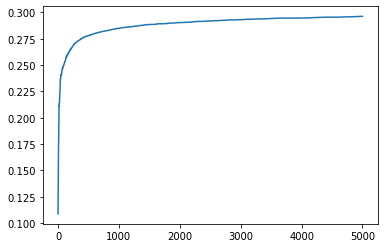

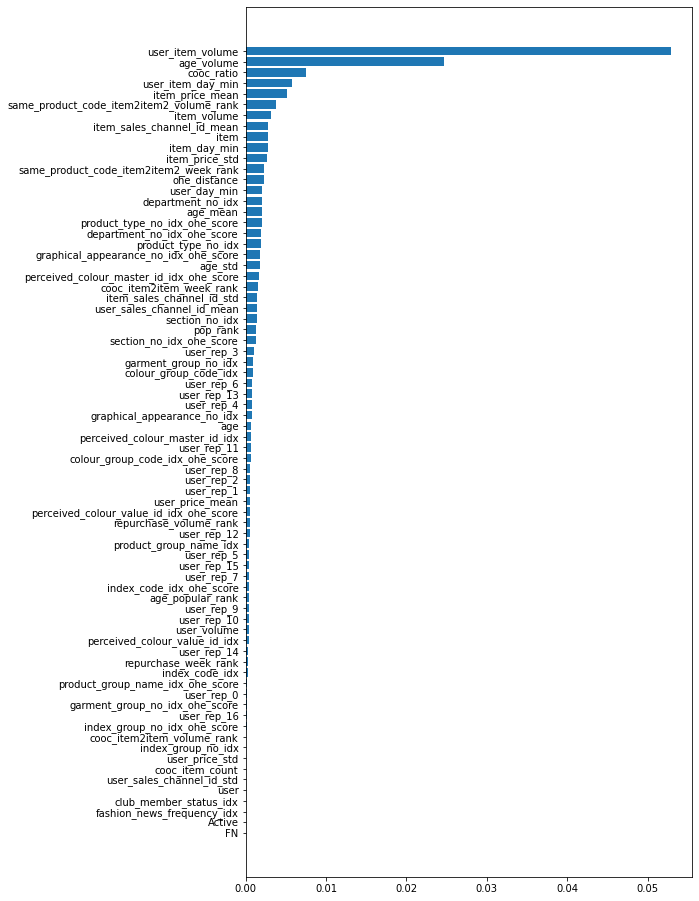

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03497210770670458


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.636 s


[item stacic features] 1.619 s


[user dynamic features (transactions)] 3.376 s


[item dynamic features (transactions)] 1.400 s


[item dynamic features (user features)] 4.149 s


[item freshness features] 3.007 s


[item volume features] 1.485 s


[user freshness features] 4.085 s


[user volume features] 2.374 s


[user-item freshness features] 20.893 s


[user-item volume features] 4.523 s


[item age volume features] 2.355 s


[ohe dot products] 65.375 s


[lfm features] 3.208 s
attach features (week: 2)


[user static fetaures] 0.646 s


[item stacic features] 1.620 s


[user dynamic features (transactions)] 3.378 s


[item dynamic features (transactions)] 1.415 s


[item dynamic features (user features)] 4.166 s


[item freshness features] 2.947 s


[item volume features] 1.529 s


[user freshness features] 4.133 s


[user volume features] 2.440 s


[user-item freshness features] 20.611 s


[user-item volume features] 4.636 s


[item age volume features] 2.441 s


[ohe dot products] 65.679 s


[lfm features] 3.144 s
attach features (week: 3)


[user static fetaures] 0.695 s


[item stacic features] 1.759 s


[user dynamic features (transactions)] 3.484 s


[item dynamic features (transactions)] 1.499 s


[item dynamic features (user features)] 4.277 s


[item freshness features] 3.008 s


[item volume features] 1.591 s


[user freshness features] 4.186 s


[user volume features] 2.497 s


[user-item freshness features] 20.427 s


[user-item volume features] 4.690 s


[item age volume features] 2.511 s


[ohe dot products] 67.250 s


[lfm features] 4.790 s
attach features (week: 4)


[user static fetaures] 0.724 s


[item stacic features] 1.849 s


[user dynamic features (transactions)] 3.433 s


[item dynamic features (transactions)] 1.521 s


[item dynamic features (user features)] 4.242 s


[item freshness features] 2.980 s


[item volume features] 1.582 s


[user freshness features] 4.131 s


[user volume features] 2.499 s


[user-item freshness features] 20.238 s


[user-item volume features] 4.620 s


[item age volume features] 2.515 s


[ohe dot products] 70.293 s


[lfm features] 3.817 s
attach features (week: 5)


[user static fetaures] 0.610 s


[item stacic features] 1.563 s


[user dynamic features (transactions)] 3.316 s


[item dynamic features (transactions)] 1.362 s


[item dynamic features (user features)] 4.100 s


[item freshness features] 2.817 s


[item volume features] 1.436 s


[user freshness features] 3.926 s


[user volume features] 2.372 s


[user-item freshness features] 20.074 s


[user-item volume features] 4.459 s


[item age volume features] 2.341 s


[ohe dot products] 62.360 s


[lfm features] 3.668 s
attach features (week: 6)


[user static fetaures] 0.585 s


[item stacic features] 1.467 s


[user dynamic features (transactions)] 3.246 s


[item dynamic features (transactions)] 1.320 s


[item dynamic features (user features)] 4.055 s


[item freshness features] 2.752 s


[item volume features] 1.380 s


[user freshness features] 3.868 s


[user volume features] 2.304 s


[user-item freshness features] 19.920 s


[user-item volume features] 4.376 s


[item age volume features] 2.281 s


[ohe dot products] 65.039 s


[lfm features] 3.813 s
attach features (week: 7)


[user static fetaures] 0.603 s


[item stacic features] 1.471 s


[user dynamic features (transactions)] 3.185 s


[item dynamic features (transactions)] 1.287 s


[item dynamic features (user features)] 3.990 s


[item freshness features] 2.722 s


[item volume features] 1.358 s


[user freshness features] 3.828 s


[user volume features] 2.244 s


[user-item freshness features] 18.196 s


[user-item volume features] 4.408 s


[item age volume features] 2.329 s


[ohe dot products] 71.285 s


[lfm features] 4.064 s


0:	total: 6.87s	remaining: 9h 31m 31s


1:	total: 12.6s	remaining: 8h 45m 15s


2:	total: 18.1s	remaining: 8h 21m 35s


3:	total: 23.6s	remaining: 8h 9m 41s


4:	total: 29.2s	remaining: 8h 4m 35s


5:	total: 34.9s	remaining: 8h 3m 16s


6:	total: 40.4s	remaining: 7h 59m 56s


7:	total: 46.1s	remaining: 7h 58m 27s


8:	total: 51.6s	remaining: 7h 56m 15s


9:	total: 57.1s	remaining: 7h 53m 50s


10:	total: 1m 2s	remaining: 7h 52m 56s


11:	total: 1m 8s	remaining: 7h 51m 6s


12:	total: 1m 13s	remaining: 7h 50m 20s


13:	total: 1m 19s	remaining: 7h 49m 26s


14:	total: 1m 24s	remaining: 7h 49m


15:	total: 1m 30s	remaining: 7h 48m 29s


16:	total: 1m 35s	remaining: 7h 47m 33s


17:	total: 1m 41s	remaining: 7h 46m 58s


18:	total: 1m 46s	remaining: 7h 46m 2s


19:	total: 1m 52s	remaining: 7h 45m 35s


20:	total: 1m 57s	remaining: 7h 44m 31s


21:	total: 2m 3s	remaining: 7h 44m 31s


22:	total: 2m 8s	remaining: 7h 43m 54s


23:	total: 2m 14s	remaining: 7h 43m 12s


24:	total: 2m 19s	remaining: 7h 42m 47s


25:	total: 2m 25s	remaining: 7h 43m


26:	total: 2m 31s	remaining: 7h 42m 53s


27:	total: 2m 36s	remaining: 7h 42m 39s


28:	total: 2m 42s	remaining: 7h 43m 13s


29:	total: 2m 47s	remaining: 7h 42m 51s


30:	total: 2m 53s	remaining: 7h 42m 38s


31:	total: 2m 59s	remaining: 7h 42m 56s


32:	total: 3m 4s	remaining: 7h 42m 58s


33:	total: 3m 10s	remaining: 7h 42m 18s


34:	total: 3m 15s	remaining: 7h 42m 9s


35:	total: 3m 21s	remaining: 7h 42m 16s


36:	total: 3m 26s	remaining: 7h 41m 39s


37:	total: 3m 32s	remaining: 7h 41m 33s


38:	total: 3m 37s	remaining: 7h 41m 16s


39:	total: 3m 43s	remaining: 7h 41m 6s


40:	total: 3m 49s	remaining: 7h 41m


41:	total: 3m 54s	remaining: 7h 40m 55s


42:	total: 4m	remaining: 7h 40m 50s


43:	total: 4m 5s	remaining: 7h 40m 37s


44:	total: 4m 11s	remaining: 7h 40m 26s


45:	total: 4m 16s	remaining: 7h 39m 46s


46:	total: 4m 22s	remaining: 7h 39m 44s


47:	total: 4m 27s	remaining: 7h 39m 7s


48:	total: 4m 33s	remaining: 7h 39m 19s


49:	total: 4m 38s	remaining: 7h 39m 22s


50:	total: 4m 44s	remaining: 7h 39m 25s


51:	total: 4m 50s	remaining: 7h 39m 26s


52:	total: 4m 55s	remaining: 7h 39m 10s


53:	total: 5m 1s	remaining: 7h 38m 42s


54:	total: 5m 6s	remaining: 7h 38m 35s


55:	total: 5m 11s	remaining: 7h 38m 8s


56:	total: 5m 17s	remaining: 7h 37m 32s


57:	total: 5m 22s	remaining: 7h 36m 52s


58:	total: 5m 27s	remaining: 7h 36m 25s


59:	total: 5m 33s	remaining: 7h 36m 12s


60:	total: 5m 38s	remaining: 7h 35m 49s


61:	total: 5m 43s	remaining: 7h 35m 25s


62:	total: 5m 49s	remaining: 7h 35m 15s


63:	total: 5m 54s	remaining: 7h 35m 3s


64:	total: 6m	remaining: 7h 35m 2s


65:	total: 6m 5s	remaining: 7h 34m 30s


66:	total: 6m 11s	remaining: 7h 34m 27s


67:	total: 6m 16s	remaining: 7h 34m 20s


68:	total: 6m 22s	remaining: 7h 34m 17s


69:	total: 6m 27s	remaining: 7h 34m 15s


70:	total: 6m 33s	remaining: 7h 34m 11s


71:	total: 6m 38s	remaining: 7h 34m 9s


72:	total: 6m 44s	remaining: 7h 33m 51s


73:	total: 6m 49s	remaining: 7h 34m


74:	total: 6m 55s	remaining: 7h 33m 28s


75:	total: 7m	remaining: 7h 33m 22s


76:	total: 7m 5s	remaining: 7h 32m 56s


77:	total: 7m 11s	remaining: 7h 32m 41s


78:	total: 7m 16s	remaining: 7h 32m 32s


79:	total: 7m 22s	remaining: 7h 32m 34s


80:	total: 7m 27s	remaining: 7h 32m 31s


81:	total: 7m 33s	remaining: 7h 32m 35s


82:	total: 7m 38s	remaining: 7h 32m 12s


83:	total: 7m 44s	remaining: 7h 32m 3s


84:	total: 7m 50s	remaining: 7h 32m 7s


85:	total: 7m 55s	remaining: 7h 31m 58s


86:	total: 8m	remaining: 7h 31m 49s


87:	total: 8m 6s	remaining: 7h 31m 38s


88:	total: 8m 11s	remaining: 7h 31m 37s


89:	total: 8m 17s	remaining: 7h 31m 31s


90:	total: 8m 23s	remaining: 7h 31m 34s


91:	total: 8m 28s	remaining: 7h 31m 38s


92:	total: 8m 34s	remaining: 7h 31m 17s


93:	total: 8m 39s	remaining: 7h 31m 20s


94:	total: 8m 45s	remaining: 7h 31m 22s


95:	total: 8m 50s	remaining: 7h 31m 13s


96:	total: 8m 56s	remaining: 7h 31m 6s


97:	total: 9m 1s	remaining: 7h 30m 56s


98:	total: 9m 7s	remaining: 7h 30m 41s


99:	total: 9m 12s	remaining: 7h 30m 30s


100:	total: 9m 18s	remaining: 7h 30m 22s


101:	total: 9m 23s	remaining: 7h 30m 25s


102:	total: 9m 29s	remaining: 7h 30m 9s


103:	total: 9m 34s	remaining: 7h 30m 1s


104:	total: 9m 40s	remaining: 7h 29m 50s


105:	total: 9m 45s	remaining: 7h 29m 40s


106:	total: 9m 51s	remaining: 7h 29m 42s


107:	total: 9m 56s	remaining: 7h 29m 37s


108:	total: 10m 2s	remaining: 7h 29m 27s


109:	total: 10m 7s	remaining: 7h 29m 15s


110:	total: 10m 12s	remaining: 7h 29m 6s


111:	total: 10m 18s	remaining: 7h 28m 49s


112:	total: 10m 23s	remaining: 7h 28m 46s


113:	total: 10m 29s	remaining: 7h 28m 32s


114:	total: 10m 34s	remaining: 7h 28m 24s


115:	total: 10m 39s	remaining: 7h 28m 14s


116:	total: 10m 45s	remaining: 7h 28m


117:	total: 10m 50s	remaining: 7h 27m 50s


118:	total: 10m 56s	remaining: 7h 27m 39s


119:	total: 11m 1s	remaining: 7h 27m 37s


120:	total: 11m 7s	remaining: 7h 27m 36s


121:	total: 11m 13s	remaining: 7h 27m 42s


122:	total: 11m 18s	remaining: 7h 27m 27s


123:	total: 11m 24s	remaining: 7h 27m 31s


124:	total: 11m 29s	remaining: 7h 27m 30s


125:	total: 11m 35s	remaining: 7h 27m 23s


126:	total: 11m 40s	remaining: 7h 27m 10s


127:	total: 11m 45s	remaining: 7h 26m 58s


128:	total: 11m 51s	remaining: 7h 26m 38s


129:	total: 11m 56s	remaining: 7h 26m 31s


130:	total: 12m 1s	remaining: 7h 26m 15s


131:	total: 12m 7s	remaining: 7h 26m 8s


132:	total: 12m 12s	remaining: 7h 26m


133:	total: 12m 17s	remaining: 7h 25m 46s


134:	total: 12m 23s	remaining: 7h 25m 34s


135:	total: 12m 28s	remaining: 7h 25m 24s


136:	total: 12m 34s	remaining: 7h 25m 16s


137:	total: 12m 39s	remaining: 7h 25m 17s


138:	total: 12m 45s	remaining: 7h 25m 9s


139:	total: 12m 50s	remaining: 7h 24m 55s


140:	total: 12m 55s	remaining: 7h 24m 39s


141:	total: 13m 1s	remaining: 7h 24m 35s


142:	total: 13m 6s	remaining: 7h 24m 33s


143:	total: 13m 12s	remaining: 7h 24m 18s


144:	total: 13m 17s	remaining: 7h 24m


145:	total: 13m 22s	remaining: 7h 24m 5s


146:	total: 13m 28s	remaining: 7h 23m 47s


147:	total: 13m 33s	remaining: 7h 23m 28s


148:	total: 13m 38s	remaining: 7h 23m 26s


149:	total: 13m 43s	remaining: 7h 23m 12s


150:	total: 13m 49s	remaining: 7h 22m 56s


151:	total: 13m 54s	remaining: 7h 23m 2s


152:	total: 14m	remaining: 7h 23m


153:	total: 14m 6s	remaining: 7h 23m 4s


154:	total: 14m 11s	remaining: 7h 23m


155:	total: 14m 17s	remaining: 7h 22m 52s


156:	total: 14m 22s	remaining: 7h 22m 49s


157:	total: 14m 28s	remaining: 7h 22m 49s


158:	total: 14m 34s	remaining: 7h 22m 55s


159:	total: 14m 40s	remaining: 7h 22m 53s


160:	total: 14m 45s	remaining: 7h 22m 46s


161:	total: 14m 50s	remaining: 7h 22m 38s


162:	total: 14m 56s	remaining: 7h 22m 25s


163:	total: 15m 1s	remaining: 7h 22m 26s


164:	total: 15m 7s	remaining: 7h 22m 12s


165:	total: 15m 12s	remaining: 7h 21m 58s


166:	total: 15m 18s	remaining: 7h 22m 2s


167:	total: 15m 23s	remaining: 7h 22m


168:	total: 15m 28s	remaining: 7h 21m 46s


169:	total: 15m 34s	remaining: 7h 21m 47s


170:	total: 15m 39s	remaining: 7h 21m 35s


171:	total: 15m 45s	remaining: 7h 21m 23s


172:	total: 15m 50s	remaining: 7h 21m 6s


173:	total: 15m 55s	remaining: 7h 20m 59s


174:	total: 16m 1s	remaining: 7h 20m 49s


175:	total: 16m 6s	remaining: 7h 20m 36s


176:	total: 16m 11s	remaining: 7h 20m 25s


177:	total: 16m 17s	remaining: 7h 20m 28s


178:	total: 16m 23s	remaining: 7h 20m 27s


179:	total: 16m 28s	remaining: 7h 20m 8s


180:	total: 16m 33s	remaining: 7h 19m 56s


181:	total: 16m 38s	remaining: 7h 19m 48s


182:	total: 16m 44s	remaining: 7h 19m 45s


183:	total: 16m 49s	remaining: 7h 19m 39s


184:	total: 16m 54s	remaining: 7h 19m 26s


185:	total: 17m	remaining: 7h 19m 22s


186:	total: 17m 5s	remaining: 7h 19m 9s


187:	total: 17m 11s	remaining: 7h 19m 4s


188:	total: 17m 16s	remaining: 7h 19m 3s


189:	total: 17m 22s	remaining: 7h 18m 52s


190:	total: 17m 27s	remaining: 7h 18m 41s


191:	total: 17m 32s	remaining: 7h 18m 28s


192:	total: 17m 37s	remaining: 7h 18m 16s


193:	total: 17m 43s	remaining: 7h 18m 8s


194:	total: 17m 48s	remaining: 7h 18m 1s


195:	total: 17m 54s	remaining: 7h 17m 55s


196:	total: 17m 59s	remaining: 7h 17m 46s


197:	total: 18m 5s	remaining: 7h 17m 48s


198:	total: 18m 10s	remaining: 7h 17m 40s


199:	total: 18m 15s	remaining: 7h 17m 33s


200:	total: 18m 21s	remaining: 7h 17m 29s


201:	total: 18m 27s	remaining: 7h 17m 28s


202:	total: 18m 32s	remaining: 7h 17m 26s


203:	total: 18m 38s	remaining: 7h 17m 18s


204:	total: 18m 43s	remaining: 7h 17m 3s


205:	total: 18m 48s	remaining: 7h 17m 2s


206:	total: 18m 54s	remaining: 7h 17m 4s


207:	total: 19m	remaining: 7h 16m 55s


208:	total: 19m 5s	remaining: 7h 16m 43s


209:	total: 19m 10s	remaining: 7h 16m 42s


210:	total: 19m 16s	remaining: 7h 16m 30s


211:	total: 19m 21s	remaining: 7h 16m 22s


212:	total: 19m 26s	remaining: 7h 16m 13s


213:	total: 19m 31s	remaining: 7h 15m 59s


214:	total: 19m 37s	remaining: 7h 15m 55s


215:	total: 19m 43s	remaining: 7h 15m 52s


216:	total: 19m 48s	remaining: 7h 15m 44s


217:	total: 19m 54s	remaining: 7h 15m 46s


218:	total: 19m 59s	remaining: 7h 15m 39s


219:	total: 20m 4s	remaining: 7h 15m 27s


220:	total: 20m 10s	remaining: 7h 15m 16s


221:	total: 20m 15s	remaining: 7h 15m 9s


222:	total: 20m 20s	remaining: 7h 15m 6s


223:	total: 20m 26s	remaining: 7h 14m 56s


224:	total: 20m 31s	remaining: 7h 14m 51s


225:	total: 20m 37s	remaining: 7h 14m 42s


226:	total: 20m 42s	remaining: 7h 14m 38s


227:	total: 20m 47s	remaining: 7h 14m 27s


228:	total: 20m 53s	remaining: 7h 14m 21s


229:	total: 20m 58s	remaining: 7h 14m 16s


230:	total: 21m 4s	remaining: 7h 14m 9s


231:	total: 21m 9s	remaining: 7h 14m


232:	total: 21m 14s	remaining: 7h 13m 54s


233:	total: 21m 20s	remaining: 7h 13m 51s


234:	total: 21m 25s	remaining: 7h 13m 39s


235:	total: 21m 31s	remaining: 7h 13m 35s


236:	total: 21m 36s	remaining: 7h 13m 32s


237:	total: 21m 42s	remaining: 7h 13m 24s


238:	total: 21m 47s	remaining: 7h 13m 18s


239:	total: 21m 53s	remaining: 7h 13m 15s


240:	total: 21m 58s	remaining: 7h 13m 15s


241:	total: 22m 4s	remaining: 7h 13m 11s


242:	total: 22m 9s	remaining: 7h 13m


243:	total: 22m 15s	remaining: 7h 12m 56s


244:	total: 22m 20s	remaining: 7h 12m 52s


245:	total: 22m 25s	remaining: 7h 12m 38s


246:	total: 22m 31s	remaining: 7h 12m 30s


247:	total: 22m 36s	remaining: 7h 12m 22s


248:	total: 22m 41s	remaining: 7h 12m 15s


249:	total: 22m 47s	remaining: 7h 12m 8s


250:	total: 22m 52s	remaining: 7h 12m 5s


251:	total: 22m 58s	remaining: 7h 11m 54s


252:	total: 23m 3s	remaining: 7h 11m 47s


253:	total: 23m 8s	remaining: 7h 11m 32s


254:	total: 23m 13s	remaining: 7h 11m 19s


255:	total: 23m 18s	remaining: 7h 11m 7s


256:	total: 23m 24s	remaining: 7h 11m 6s


257:	total: 23m 29s	remaining: 7h 10m 58s


258:	total: 23m 35s	remaining: 7h 10m 53s


259:	total: 23m 40s	remaining: 7h 10m 48s


260:	total: 23m 46s	remaining: 7h 10m 44s


261:	total: 23m 51s	remaining: 7h 10m 37s


262:	total: 23m 57s	remaining: 7h 10m 36s


263:	total: 24m 2s	remaining: 7h 10m 30s


264:	total: 24m 8s	remaining: 7h 10m 29s


265:	total: 24m 13s	remaining: 7h 10m 19s


266:	total: 24m 19s	remaining: 7h 10m 18s


267:	total: 24m 24s	remaining: 7h 10m 7s


268:	total: 24m 29s	remaining: 7h 10m 3s


269:	total: 24m 35s	remaining: 7h 9m 57s


270:	total: 24m 40s	remaining: 7h 9m 53s


271:	total: 24m 45s	remaining: 7h 9m 40s


272:	total: 24m 51s	remaining: 7h 9m 30s


273:	total: 24m 56s	remaining: 7h 9m 18s


274:	total: 25m 1s	remaining: 7h 9m 11s


275:	total: 25m 6s	remaining: 7h 8m 57s


276:	total: 25m 12s	remaining: 7h 8m 54s


277:	total: 25m 17s	remaining: 7h 8m 47s


278:	total: 25m 22s	remaining: 7h 8m 36s


279:	total: 25m 28s	remaining: 7h 8m 29s


280:	total: 25m 33s	remaining: 7h 8m 18s


281:	total: 25m 38s	remaining: 7h 8m 10s


282:	total: 25m 44s	remaining: 7h 8m 8s


283:	total: 25m 49s	remaining: 7h 7m 54s


284:	total: 25m 54s	remaining: 7h 7m 45s


285:	total: 25m 59s	remaining: 7h 7m 40s


286:	total: 26m 5s	remaining: 7h 7m 35s


287:	total: 26m 10s	remaining: 7h 7m 32s


288:	total: 26m 16s	remaining: 7h 7m 25s


289:	total: 26m 21s	remaining: 7h 7m 18s


290:	total: 26m 26s	remaining: 7h 7m 11s


291:	total: 26m 32s	remaining: 7h 7m 4s


292:	total: 26m 37s	remaining: 7h 6m 56s


293:	total: 26m 42s	remaining: 7h 6m 48s


294:	total: 26m 48s	remaining: 7h 6m 45s


295:	total: 26m 53s	remaining: 7h 6m 39s


296:	total: 26m 59s	remaining: 7h 6m 28s


297:	total: 27m 4s	remaining: 7h 6m 19s


298:	total: 27m 9s	remaining: 7h 6m 12s


299:	total: 27m 14s	remaining: 7h 6m 5s


300:	total: 27m 20s	remaining: 7h 6m 3s


301:	total: 27m 25s	remaining: 7h 5m 52s


302:	total: 27m 30s	remaining: 7h 5m 41s


303:	total: 27m 36s	remaining: 7h 5m 32s


304:	total: 27m 41s	remaining: 7h 5m 30s


305:	total: 27m 47s	remaining: 7h 5m 27s


306:	total: 27m 52s	remaining: 7h 5m 16s


307:	total: 27m 57s	remaining: 7h 5m 5s


308:	total: 28m 3s	remaining: 7h 5m 1s


309:	total: 28m 8s	remaining: 7h 4m 54s


310:	total: 28m 14s	remaining: 7h 4m 52s


311:	total: 28m 19s	remaining: 7h 4m 46s


312:	total: 28m 24s	remaining: 7h 4m 38s


313:	total: 28m 30s	remaining: 7h 4m 37s


314:	total: 28m 35s	remaining: 7h 4m 32s


315:	total: 28m 41s	remaining: 7h 4m 27s


316:	total: 28m 46s	remaining: 7h 4m 23s


317:	total: 28m 52s	remaining: 7h 4m 17s


318:	total: 28m 57s	remaining: 7h 4m 5s


319:	total: 29m 3s	remaining: 7h 4m 2s


320:	total: 29m 8s	remaining: 7h 3m 56s


321:	total: 29m 13s	remaining: 7h 3m 48s


322:	total: 29m 19s	remaining: 7h 3m 43s


323:	total: 29m 24s	remaining: 7h 3m 36s


324:	total: 29m 29s	remaining: 7h 3m 27s


325:	total: 29m 34s	remaining: 7h 3m 16s


326:	total: 29m 39s	remaining: 7h 3m 8s


327:	total: 29m 45s	remaining: 7h 3m 2s


328:	total: 29m 50s	remaining: 7h 2m 56s


329:	total: 29m 56s	remaining: 7h 2m 51s


330:	total: 30m 2s	remaining: 7h 2m 50s


331:	total: 30m 7s	remaining: 7h 2m 40s


332:	total: 30m 12s	remaining: 7h 2m 31s


333:	total: 30m 17s	remaining: 7h 2m 23s


334:	total: 30m 22s	remaining: 7h 2m 16s


335:	total: 30m 28s	remaining: 7h 2m 13s


336:	total: 30m 34s	remaining: 7h 2m 11s


337:	total: 30m 39s	remaining: 7h 2m 7s


338:	total: 30m 45s	remaining: 7h 1m 59s


339:	total: 30m 50s	remaining: 7h 1m 55s


340:	total: 30m 55s	remaining: 7h 1m 46s


341:	total: 31m	remaining: 7h 1m 36s


342:	total: 31m 6s	remaining: 7h 1m 29s


343:	total: 31m 11s	remaining: 7h 1m 22s


344:	total: 31m 16s	remaining: 7h 1m 14s


345:	total: 31m 21s	remaining: 7h 1m 3s


346:	total: 31m 27s	remaining: 7h 56s


347:	total: 31m 32s	remaining: 7h 52s


348:	total: 31m 37s	remaining: 7h 41s


349:	total: 31m 42s	remaining: 7h 31s


350:	total: 31m 47s	remaining: 7h 21s


351:	total: 31m 52s	remaining: 7h 9s


352:	total: 31m 57s	remaining: 6h 59m 59s


353:	total: 32m 2s	remaining: 6h 59m 48s


354:	total: 32m 8s	remaining: 6h 59m 44s


355:	total: 32m 13s	remaining: 6h 59m 37s


356:	total: 32m 18s	remaining: 6h 59m 27s


357:	total: 32m 24s	remaining: 6h 59m 20s


358:	total: 32m 29s	remaining: 6h 59m 13s


359:	total: 32m 34s	remaining: 6h 59m 6s


360:	total: 32m 40s	remaining: 6h 58m 58s


361:	total: 32m 45s	remaining: 6h 58m 54s


362:	total: 32m 50s	remaining: 6h 58m 42s


363:	total: 32m 55s	remaining: 6h 58m 35s


364:	total: 33m	remaining: 6h 58m 25s


365:	total: 33m 6s	remaining: 6h 58m 19s


366:	total: 33m 11s	remaining: 6h 58m 10s


367:	total: 33m 17s	remaining: 6h 58m 10s


368:	total: 33m 22s	remaining: 6h 58m 8s


369:	total: 33m 28s	remaining: 6h 58m 4s


370:	total: 33m 33s	remaining: 6h 57m 58s


371:	total: 33m 39s	remaining: 6h 57m 50s


372:	total: 33m 44s	remaining: 6h 57m 39s


373:	total: 33m 49s	remaining: 6h 57m 36s


374:	total: 33m 54s	remaining: 6h 57m 26s


375:	total: 34m	remaining: 6h 57m 20s


376:	total: 34m 5s	remaining: 6h 57m 18s


377:	total: 34m 10s	remaining: 6h 57m 9s


378:	total: 34m 16s	remaining: 6h 57m


379:	total: 34m 21s	remaining: 6h 56m 56s


380:	total: 34m 27s	remaining: 6h 56m 50s


381:	total: 34m 32s	remaining: 6h 56m 41s


382:	total: 34m 37s	remaining: 6h 56m 32s


383:	total: 34m 42s	remaining: 6h 56m 21s


384:	total: 34m 47s	remaining: 6h 56m 12s


385:	total: 34m 52s	remaining: 6h 56m 7s


386:	total: 34m 58s	remaining: 6h 56m 3s


387:	total: 35m 3s	remaining: 6h 55m 56s


388:	total: 35m 8s	remaining: 6h 55m 46s


389:	total: 35m 14s	remaining: 6h 55m 43s


390:	total: 35m 19s	remaining: 6h 55m 39s


391:	total: 35m 25s	remaining: 6h 55m 33s


392:	total: 35m 30s	remaining: 6h 55m 25s


393:	total: 35m 35s	remaining: 6h 55m 20s


394:	total: 35m 40s	remaining: 6h 55m 10s


395:	total: 35m 46s	remaining: 6h 55m 8s


396:	total: 35m 51s	remaining: 6h 55m 2s


397:	total: 35m 57s	remaining: 6h 54m 58s


398:	total: 36m 2s	remaining: 6h 54m 49s


399:	total: 36m 8s	remaining: 6h 54m 43s


400:	total: 36m 13s	remaining: 6h 54m 38s


401:	total: 36m 18s	remaining: 6h 54m 30s


402:	total: 36m 23s	remaining: 6h 54m 21s


403:	total: 36m 29s	remaining: 6h 54m 20s


404:	total: 36m 34s	remaining: 6h 54m 11s


405:	total: 36m 39s	remaining: 6h 54m 3s


406:	total: 36m 45s	remaining: 6h 53m 59s


407:	total: 36m 50s	remaining: 6h 53m 55s


408:	total: 36m 56s	remaining: 6h 53m 47s


409:	total: 37m 1s	remaining: 6h 53m 41s


410:	total: 37m 6s	remaining: 6h 53m 34s


411:	total: 37m 12s	remaining: 6h 53m 30s


412:	total: 37m 17s	remaining: 6h 53m 23s


413:	total: 37m 22s	remaining: 6h 53m 16s


414:	total: 37m 28s	remaining: 6h 53m 10s


415:	total: 37m 33s	remaining: 6h 53m


416:	total: 37m 38s	remaining: 6h 52m 48s


417:	total: 37m 43s	remaining: 6h 52m 43s


418:	total: 37m 48s	remaining: 6h 52m 35s


419:	total: 37m 54s	remaining: 6h 52m 32s


420:	total: 37m 59s	remaining: 6h 52m 24s


421:	total: 38m 4s	remaining: 6h 52m 16s


422:	total: 38m 9s	remaining: 6h 52m 8s


423:	total: 38m 14s	remaining: 6h 51m 59s


424:	total: 38m 20s	remaining: 6h 51m 53s


425:	total: 38m 25s	remaining: 6h 51m 47s


426:	total: 38m 30s	remaining: 6h 51m 39s


427:	total: 38m 36s	remaining: 6h 51m 31s


428:	total: 38m 41s	remaining: 6h 51m 26s


429:	total: 38m 46s	remaining: 6h 51m 17s


430:	total: 38m 51s	remaining: 6h 51m 7s


431:	total: 38m 57s	remaining: 6h 51m 3s


432:	total: 39m 2s	remaining: 6h 50m 55s


433:	total: 39m 7s	remaining: 6h 50m 48s


434:	total: 39m 12s	remaining: 6h 50m 42s


435:	total: 39m 18s	remaining: 6h 50m 34s


436:	total: 39m 23s	remaining: 6h 50m 27s


437:	total: 39m 28s	remaining: 6h 50m 19s


438:	total: 39m 33s	remaining: 6h 50m 12s


439:	total: 39m 38s	remaining: 6h 50m 5s


440:	total: 39m 44s	remaining: 6h 49m 59s


441:	total: 39m 49s	remaining: 6h 49m 52s


442:	total: 39m 55s	remaining: 6h 49m 47s


443:	total: 40m	remaining: 6h 49m 41s


444:	total: 40m 5s	remaining: 6h 49m 36s


445:	total: 40m 11s	remaining: 6h 49m 29s


446:	total: 40m 16s	remaining: 6h 49m 23s


447:	total: 40m 21s	remaining: 6h 49m 18s


448:	total: 40m 26s	remaining: 6h 49m 11s


449:	total: 40m 32s	remaining: 6h 49m 3s


450:	total: 40m 37s	remaining: 6h 48m 58s


451:	total: 40m 43s	remaining: 6h 48m 53s


452:	total: 40m 48s	remaining: 6h 48m 45s


453:	total: 40m 53s	remaining: 6h 48m 43s


454:	total: 40m 58s	remaining: 6h 48m 33s


455:	total: 41m 4s	remaining: 6h 48m 28s


456:	total: 41m 9s	remaining: 6h 48m 18s


457:	total: 41m 14s	remaining: 6h 48m 8s


458:	total: 41m 19s	remaining: 6h 48m 1s


459:	total: 41m 24s	remaining: 6h 47m 55s


460:	total: 41m 30s	remaining: 6h 47m 50s


461:	total: 41m 35s	remaining: 6h 47m 43s


462:	total: 41m 40s	remaining: 6h 47m 36s


463:	total: 41m 46s	remaining: 6h 47m 35s


464:	total: 41m 51s	remaining: 6h 47m 29s


465:	total: 41m 57s	remaining: 6h 47m 21s


466:	total: 42m 2s	remaining: 6h 47m 14s


467:	total: 42m 7s	remaining: 6h 47m 6s


468:	total: 42m 12s	remaining: 6h 46m 57s


469:	total: 42m 18s	remaining: 6h 46m 54s


470:	total: 42m 23s	remaining: 6h 46m 47s


471:	total: 42m 28s	remaining: 6h 46m 42s


472:	total: 42m 34s	remaining: 6h 46m 36s


473:	total: 42m 39s	remaining: 6h 46m 29s


474:	total: 42m 44s	remaining: 6h 46m 22s


475:	total: 42m 49s	remaining: 6h 46m 16s


476:	total: 42m 55s	remaining: 6h 46m 13s


477:	total: 43m	remaining: 6h 46m 8s


478:	total: 43m 6s	remaining: 6h 46m 3s


479:	total: 43m 11s	remaining: 6h 45m 55s


480:	total: 43m 16s	remaining: 6h 45m 49s


481:	total: 43m 22s	remaining: 6h 45m 44s


482:	total: 43m 27s	remaining: 6h 45m 35s


483:	total: 43m 32s	remaining: 6h 45m 28s


484:	total: 43m 38s	remaining: 6h 45m 24s


485:	total: 43m 43s	remaining: 6h 45m 17s


486:	total: 43m 48s	remaining: 6h 45m 10s


487:	total: 43m 54s	remaining: 6h 45m 6s


488:	total: 43m 59s	remaining: 6h 44m 59s


489:	total: 44m 4s	remaining: 6h 44m 51s


490:	total: 44m 9s	remaining: 6h 44m 42s


491:	total: 44m 14s	remaining: 6h 44m 34s


492:	total: 44m 20s	remaining: 6h 44m 30s


493:	total: 44m 25s	remaining: 6h 44m 24s


494:	total: 44m 30s	remaining: 6h 44m 17s


495:	total: 44m 35s	remaining: 6h 44m 8s


496:	total: 44m 41s	remaining: 6h 44m 3s


497:	total: 44m 46s	remaining: 6h 43m 55s


498:	total: 44m 51s	remaining: 6h 43m 48s


499:	total: 44m 56s	remaining: 6h 43m 41s


500:	total: 45m 1s	remaining: 6h 43m 32s


501:	total: 45m 6s	remaining: 6h 43m 22s


502:	total: 45m 12s	remaining: 6h 43m 17s


503:	total: 45m 17s	remaining: 6h 43m 11s


504:	total: 45m 22s	remaining: 6h 43m 3s


505:	total: 45m 28s	remaining: 6h 43m


506:	total: 45m 33s	remaining: 6h 42m 53s


507:	total: 45m 38s	remaining: 6h 42m 49s


508:	total: 45m 44s	remaining: 6h 42m 43s


509:	total: 45m 49s	remaining: 6h 42m 38s


510:	total: 45m 55s	remaining: 6h 42m 34s


511:	total: 46m	remaining: 6h 42m 28s


512:	total: 46m 5s	remaining: 6h 42m 21s


513:	total: 46m 11s	remaining: 6h 42m 17s


514:	total: 46m 16s	remaining: 6h 42m 10s


515:	total: 46m 21s	remaining: 6h 42m 4s


516:	total: 46m 27s	remaining: 6h 41m 59s


517:	total: 46m 32s	remaining: 6h 41m 55s


518:	total: 46m 37s	remaining: 6h 41m 45s


519:	total: 46m 42s	remaining: 6h 41m 36s


520:	total: 46m 47s	remaining: 6h 41m 27s


521:	total: 46m 52s	remaining: 6h 41m 18s


522:	total: 46m 57s	remaining: 6h 41m 13s


523:	total: 47m 3s	remaining: 6h 41m 6s


524:	total: 47m 8s	remaining: 6h 40m 57s


525:	total: 47m 13s	remaining: 6h 40m 49s


526:	total: 47m 18s	remaining: 6h 40m 41s


527:	total: 47m 23s	remaining: 6h 40m 34s


528:	total: 47m 28s	remaining: 6h 40m 27s


529:	total: 47m 33s	remaining: 6h 40m 19s


530:	total: 47m 38s	remaining: 6h 40m 11s


531:	total: 47m 43s	remaining: 6h 40m 4s


532:	total: 47m 49s	remaining: 6h 39m 56s


533:	total: 47m 54s	remaining: 6h 39m 51s


534:	total: 47m 59s	remaining: 6h 39m 44s


535:	total: 48m 4s	remaining: 6h 39m 35s


536:	total: 48m 9s	remaining: 6h 39m 28s


537:	total: 48m 14s	remaining: 6h 39m 21s


538:	total: 48m 20s	remaining: 6h 39m 14s


539:	total: 48m 25s	remaining: 6h 39m 6s


540:	total: 48m 30s	remaining: 6h 39m


541:	total: 48m 35s	remaining: 6h 38m 54s


542:	total: 48m 41s	remaining: 6h 38m 48s


543:	total: 48m 46s	remaining: 6h 38m 41s


544:	total: 48m 51s	remaining: 6h 38m 35s


545:	total: 48m 56s	remaining: 6h 38m 29s


546:	total: 49m 2s	remaining: 6h 38m 23s


547:	total: 49m 7s	remaining: 6h 38m 16s


548:	total: 49m 12s	remaining: 6h 38m 12s


549:	total: 49m 18s	remaining: 6h 38m 7s


550:	total: 49m 23s	remaining: 6h 38m 1s


551:	total: 49m 28s	remaining: 6h 37m 54s


552:	total: 49m 34s	remaining: 6h 37m 47s


553:	total: 49m 39s	remaining: 6h 37m 43s


554:	total: 49m 44s	remaining: 6h 37m 38s


555:	total: 49m 49s	remaining: 6h 37m 29s


556:	total: 49m 55s	remaining: 6h 37m 24s


557:	total: 50m	remaining: 6h 37m 16s


558:	total: 50m 6s	remaining: 6h 37m 13s


559:	total: 50m 11s	remaining: 6h 37m 8s


560:	total: 50m 16s	remaining: 6h 37m


561:	total: 50m 21s	remaining: 6h 36m 55s


562:	total: 50m 27s	remaining: 6h 36m 48s


563:	total: 50m 32s	remaining: 6h 36m 43s


564:	total: 50m 37s	remaining: 6h 36m 37s


565:	total: 50m 43s	remaining: 6h 36m 32s


566:	total: 50m 48s	remaining: 6h 36m 24s


567:	total: 50m 53s	remaining: 6h 36m 20s


568:	total: 50m 59s	remaining: 6h 36m 14s


569:	total: 51m 3s	remaining: 6h 36m 3s


570:	total: 51m 9s	remaining: 6h 35m 57s


571:	total: 51m 14s	remaining: 6h 35m 52s


572:	total: 51m 19s	remaining: 6h 35m 44s


573:	total: 51m 24s	remaining: 6h 35m 38s


574:	total: 51m 30s	remaining: 6h 35m 32s


575:	total: 51m 35s	remaining: 6h 35m 26s


576:	total: 51m 40s	remaining: 6h 35m 19s


577:	total: 51m 45s	remaining: 6h 35m 12s


578:	total: 51m 51s	remaining: 6h 35m 9s


579:	total: 51m 56s	remaining: 6h 35m 4s


580:	total: 52m 2s	remaining: 6h 34m 57s


581:	total: 52m 7s	remaining: 6h 34m 51s


582:	total: 52m 12s	remaining: 6h 34m 44s


583:	total: 52m 17s	remaining: 6h 34m 40s


584:	total: 52m 23s	remaining: 6h 34m 34s


585:	total: 52m 28s	remaining: 6h 34m 26s


586:	total: 52m 33s	remaining: 6h 34m 18s


587:	total: 52m 38s	remaining: 6h 34m 13s


588:	total: 52m 43s	remaining: 6h 34m 6s


589:	total: 52m 49s	remaining: 6h 34m 1s


590:	total: 52m 54s	remaining: 6h 33m 56s


591:	total: 52m 59s	remaining: 6h 33m 49s


592:	total: 53m 5s	remaining: 6h 33m 42s


593:	total: 53m 10s	remaining: 6h 33m 35s


594:	total: 53m 15s	remaining: 6h 33m 32s


595:	total: 53m 21s	remaining: 6h 33m 25s


596:	total: 53m 26s	remaining: 6h 33m 18s


597:	total: 53m 31s	remaining: 6h 33m 9s


598:	total: 53m 36s	remaining: 6h 33m 2s


599:	total: 53m 41s	remaining: 6h 32m 56s


600:	total: 53m 46s	remaining: 6h 32m 50s


601:	total: 53m 52s	remaining: 6h 32m 47s


602:	total: 53m 57s	remaining: 6h 32m 40s


603:	total: 54m 2s	remaining: 6h 32m 32s


604:	total: 54m 7s	remaining: 6h 32m 26s


605:	total: 54m 13s	remaining: 6h 32m 19s


606:	total: 54m 18s	remaining: 6h 32m 14s


607:	total: 54m 24s	remaining: 6h 32m 11s


608:	total: 54m 29s	remaining: 6h 32m 2s


609:	total: 54m 34s	remaining: 6h 31m 58s


610:	total: 54m 39s	remaining: 6h 31m 52s


611:	total: 54m 45s	remaining: 6h 31m 47s


612:	total: 54m 50s	remaining: 6h 31m 43s


613:	total: 54m 56s	remaining: 6h 31m 38s


614:	total: 55m 1s	remaining: 6h 31m 31s


615:	total: 55m 6s	remaining: 6h 31m 26s


616:	total: 55m 12s	remaining: 6h 31m 20s


617:	total: 55m 17s	remaining: 6h 31m 14s


618:	total: 55m 22s	remaining: 6h 31m 8s


619:	total: 55m 28s	remaining: 6h 31m 4s


620:	total: 55m 33s	remaining: 6h 30m 59s


621:	total: 55m 39s	remaining: 6h 30m 54s


622:	total: 55m 44s	remaining: 6h 30m 48s


623:	total: 55m 49s	remaining: 6h 30m 43s


624:	total: 55m 55s	remaining: 6h 30m 36s


625:	total: 56m	remaining: 6h 30m 29s


626:	total: 56m 5s	remaining: 6h 30m 25s


627:	total: 56m 10s	remaining: 6h 30m 18s


628:	total: 56m 15s	remaining: 6h 30m 8s


629:	total: 56m 20s	remaining: 6h 30m 1s


630:	total: 56m 25s	remaining: 6h 29m 55s


631:	total: 56m 31s	remaining: 6h 29m 52s


632:	total: 56m 37s	remaining: 6h 29m 48s


633:	total: 56m 42s	remaining: 6h 29m 44s


634:	total: 56m 47s	remaining: 6h 29m 36s


635:	total: 56m 52s	remaining: 6h 29m 28s


636:	total: 56m 58s	remaining: 6h 29m 24s


637:	total: 57m 3s	remaining: 6h 29m 20s


638:	total: 57m 9s	remaining: 6h 29m 13s


639:	total: 57m 14s	remaining: 6h 29m 7s


640:	total: 57m 19s	remaining: 6h 29m 2s


641:	total: 57m 24s	remaining: 6h 28m 54s


642:	total: 57m 29s	remaining: 6h 28m 48s


643:	total: 57m 35s	remaining: 6h 28m 42s


644:	total: 57m 40s	remaining: 6h 28m 37s


645:	total: 57m 45s	remaining: 6h 28m 29s


646:	total: 57m 50s	remaining: 6h 28m 23s


647:	total: 57m 55s	remaining: 6h 28m 16s


648:	total: 58m 1s	remaining: 6h 28m 10s


649:	total: 58m 6s	remaining: 6h 28m 5s


650:	total: 58m 12s	remaining: 6h 28m


651:	total: 58m 17s	remaining: 6h 27m 57s


652:	total: 58m 23s	remaining: 6h 27m 53s


653:	total: 58m 28s	remaining: 6h 27m 45s


654:	total: 58m 33s	remaining: 6h 27m 40s


655:	total: 58m 39s	remaining: 6h 27m 34s


656:	total: 58m 44s	remaining: 6h 27m 28s


657:	total: 58m 49s	remaining: 6h 27m 23s


658:	total: 58m 54s	remaining: 6h 27m 16s


659:	total: 59m	remaining: 6h 27m 11s


660:	total: 59m 5s	remaining: 6h 27m 4s


661:	total: 59m 10s	remaining: 6h 26m 57s


662:	total: 59m 15s	remaining: 6h 26m 51s


663:	total: 59m 20s	remaining: 6h 26m 42s


664:	total: 59m 25s	remaining: 6h 26m 34s


665:	total: 59m 30s	remaining: 6h 26m 27s


666:	total: 59m 35s	remaining: 6h 26m 21s


667:	total: 59m 41s	remaining: 6h 26m 15s


668:	total: 59m 45s	remaining: 6h 26m 5s


669:	total: 59m 50s	remaining: 6h 25m 59s


670:	total: 59m 55s	remaining: 6h 25m 51s


671:	total: 1h 1s	remaining: 6h 25m 45s


672:	total: 1h 6s	remaining: 6h 25m 37s


673:	total: 1h 11s	remaining: 6h 25m 32s


674:	total: 1h 16s	remaining: 6h 25m 25s


675:	total: 1h 21s	remaining: 6h 25m 19s


676:	total: 1h 26s	remaining: 6h 25m 11s


677:	total: 1h 32s	remaining: 6h 25m 6s


678:	total: 1h 37s	remaining: 6h 25m


679:	total: 1h 42s	remaining: 6h 24m 54s


680:	total: 1h 48s	remaining: 6h 24m 49s


681:	total: 1h 53s	remaining: 6h 24m 45s


682:	total: 1h 58s	remaining: 6h 24m 37s


683:	total: 1h 1m 3s	remaining: 6h 24m 29s


684:	total: 1h 1m 8s	remaining: 6h 24m 23s


685:	total: 1h 1m 14s	remaining: 6h 24m 17s


686:	total: 1h 1m 19s	remaining: 6h 24m 13s


687:	total: 1h 1m 24s	remaining: 6h 24m 5s


688:	total: 1h 1m 30s	remaining: 6h 23m 59s


689:	total: 1h 1m 35s	remaining: 6h 23m 53s


690:	total: 1h 1m 40s	remaining: 6h 23m 48s


691:	total: 1h 1m 45s	remaining: 6h 23m 41s


692:	total: 1h 1m 50s	remaining: 6h 23m 35s


693:	total: 1h 1m 56s	remaining: 6h 23m 28s


694:	total: 1h 2m 1s	remaining: 6h 23m 22s


695:	total: 1h 2m 6s	remaining: 6h 23m 17s


696:	total: 1h 2m 12s	remaining: 6h 23m 13s


697:	total: 1h 2m 17s	remaining: 6h 23m 7s


698:	total: 1h 2m 22s	remaining: 6h 23m 2s


699:	total: 1h 2m 27s	remaining: 6h 22m 55s


700:	total: 1h 2m 33s	remaining: 6h 22m 49s


701:	total: 1h 2m 38s	remaining: 6h 22m 45s


702:	total: 1h 2m 44s	remaining: 6h 22m 38s


703:	total: 1h 2m 49s	remaining: 6h 22m 32s


704:	total: 1h 2m 54s	remaining: 6h 22m 28s


705:	total: 1h 3m	remaining: 6h 22m 23s


706:	total: 1h 3m 5s	remaining: 6h 22m 17s


707:	total: 1h 3m 10s	remaining: 6h 22m 12s


708:	total: 1h 3m 16s	remaining: 6h 22m 8s


709:	total: 1h 3m 21s	remaining: 6h 22m 2s


710:	total: 1h 3m 27s	remaining: 6h 21m 57s


711:	total: 1h 3m 32s	remaining: 6h 21m 53s


712:	total: 1h 3m 38s	remaining: 6h 21m 48s


713:	total: 1h 3m 43s	remaining: 6h 21m 41s


714:	total: 1h 3m 48s	remaining: 6h 21m 35s


715:	total: 1h 3m 53s	remaining: 6h 21m 28s


716:	total: 1h 3m 59s	remaining: 6h 21m 24s


717:	total: 1h 4m 4s	remaining: 6h 21m 17s


718:	total: 1h 4m 9s	remaining: 6h 21m 11s


719:	total: 1h 4m 14s	remaining: 6h 21m 6s


720:	total: 1h 4m 20s	remaining: 6h 21m


721:	total: 1h 4m 25s	remaining: 6h 20m 54s


722:	total: 1h 4m 30s	remaining: 6h 20m 48s


723:	total: 1h 4m 35s	remaining: 6h 20m 43s


724:	total: 1h 4m 41s	remaining: 6h 20m 37s


725:	total: 1h 4m 46s	remaining: 6h 20m 33s


726:	total: 1h 4m 51s	remaining: 6h 20m 26s


727:	total: 1h 4m 57s	remaining: 6h 20m 21s


728:	total: 1h 5m 2s	remaining: 6h 20m 15s


729:	total: 1h 5m 8s	remaining: 6h 20m 11s


730:	total: 1h 5m 13s	remaining: 6h 20m 4s


731:	total: 1h 5m 18s	remaining: 6h 19m 57s


732:	total: 1h 5m 23s	remaining: 6h 19m 51s


733:	total: 1h 5m 28s	remaining: 6h 19m 44s


734:	total: 1h 5m 33s	remaining: 6h 19m 37s


735:	total: 1h 5m 38s	remaining: 6h 19m 31s


736:	total: 1h 5m 44s	remaining: 6h 19m 25s


737:	total: 1h 5m 49s	remaining: 6h 19m 17s


738:	total: 1h 5m 54s	remaining: 6h 19m 10s


739:	total: 1h 5m 59s	remaining: 6h 19m 3s


740:	total: 1h 6m 4s	remaining: 6h 18m 59s


741:	total: 1h 6m 10s	remaining: 6h 18m 54s


742:	total: 1h 6m 15s	remaining: 6h 18m 46s


743:	total: 1h 6m 20s	remaining: 6h 18m 40s


744:	total: 1h 6m 25s	remaining: 6h 18m 34s


745:	total: 1h 6m 30s	remaining: 6h 18m 28s


746:	total: 1h 6m 35s	remaining: 6h 18m 22s


747:	total: 1h 6m 41s	remaining: 6h 18m 17s


748:	total: 1h 6m 46s	remaining: 6h 18m 11s


749:	total: 1h 6m 51s	remaining: 6h 18m 5s


750:	total: 1h 6m 57s	remaining: 6h 18m 1s


751:	total: 1h 7m 2s	remaining: 6h 17m 55s


752:	total: 1h 7m 7s	remaining: 6h 17m 48s


753:	total: 1h 7m 13s	remaining: 6h 17m 43s


754:	total: 1h 7m 18s	remaining: 6h 17m 35s


755:	total: 1h 7m 23s	remaining: 6h 17m 29s


756:	total: 1h 7m 28s	remaining: 6h 17m 24s


757:	total: 1h 7m 34s	remaining: 6h 17m 19s


758:	total: 1h 7m 39s	remaining: 6h 17m 14s


759:	total: 1h 7m 45s	remaining: 6h 17m 10s


760:	total: 1h 7m 50s	remaining: 6h 17m 4s


761:	total: 1h 7m 55s	remaining: 6h 16m 59s


762:	total: 1h 8m 1s	remaining: 6h 16m 54s


763:	total: 1h 8m 6s	remaining: 6h 16m 50s


764:	total: 1h 8m 11s	remaining: 6h 16m 44s


765:	total: 1h 8m 17s	remaining: 6h 16m 38s


766:	total: 1h 8m 22s	remaining: 6h 16m 33s


767:	total: 1h 8m 27s	remaining: 6h 16m 28s


768:	total: 1h 8m 33s	remaining: 6h 16m 22s


769:	total: 1h 8m 38s	remaining: 6h 16m 15s


770:	total: 1h 8m 43s	remaining: 6h 16m 11s


771:	total: 1h 8m 48s	remaining: 6h 16m 5s


772:	total: 1h 8m 54s	remaining: 6h 15m 57s


773:	total: 1h 8m 59s	remaining: 6h 15m 52s


774:	total: 1h 9m 4s	remaining: 6h 15m 45s


775:	total: 1h 9m 9s	remaining: 6h 15m 39s


776:	total: 1h 9m 15s	remaining: 6h 15m 36s


777:	total: 1h 9m 20s	remaining: 6h 15m 28s


778:	total: 1h 9m 25s	remaining: 6h 15m 21s


779:	total: 1h 9m 30s	remaining: 6h 15m 16s


780:	total: 1h 9m 36s	remaining: 6h 15m 11s


781:	total: 1h 9m 40s	remaining: 6h 15m 2s


782:	total: 1h 9m 46s	remaining: 6h 14m 57s


783:	total: 1h 9m 51s	remaining: 6h 14m 51s


784:	total: 1h 9m 56s	remaining: 6h 14m 46s


785:	total: 1h 10m 2s	remaining: 6h 14m 40s


786:	total: 1h 10m 7s	remaining: 6h 14m 34s


787:	total: 1h 10m 12s	remaining: 6h 14m 29s


788:	total: 1h 10m 18s	remaining: 6h 14m 24s


789:	total: 1h 10m 23s	remaining: 6h 14m 17s


790:	total: 1h 10m 28s	remaining: 6h 14m 12s


791:	total: 1h 10m 33s	remaining: 6h 14m 6s


792:	total: 1h 10m 39s	remaining: 6h 14m


793:	total: 1h 10m 44s	remaining: 6h 13m 56s


794:	total: 1h 10m 50s	remaining: 6h 13m 51s


795:	total: 1h 10m 55s	remaining: 6h 13m 46s


796:	total: 1h 11m	remaining: 6h 13m 41s


797:	total: 1h 11m 6s	remaining: 6h 13m 36s


798:	total: 1h 11m 11s	remaining: 6h 13m 29s


799:	total: 1h 11m 16s	remaining: 6h 13m 23s


800:	total: 1h 11m 22s	remaining: 6h 13m 19s


801:	total: 1h 11m 26s	remaining: 6h 13m 11s


802:	total: 1h 11m 32s	remaining: 6h 13m 5s


803:	total: 1h 11m 37s	remaining: 6h 13m 1s


804:	total: 1h 11m 43s	remaining: 6h 12m 57s


805:	total: 1h 11m 48s	remaining: 6h 12m 49s


806:	total: 1h 11m 53s	remaining: 6h 12m 45s


807:	total: 1h 11m 59s	remaining: 6h 12m 39s


808:	total: 1h 12m 4s	remaining: 6h 12m 33s


809:	total: 1h 12m 9s	remaining: 6h 12m 26s


810:	total: 1h 12m 14s	remaining: 6h 12m 20s


811:	total: 1h 12m 19s	remaining: 6h 12m 14s


812:	total: 1h 12m 24s	remaining: 6h 12m 7s


813:	total: 1h 12m 29s	remaining: 6h 12m


814:	total: 1h 12m 35s	remaining: 6h 11m 56s


815:	total: 1h 12m 40s	remaining: 6h 11m 51s


816:	total: 1h 12m 45s	remaining: 6h 11m 45s


817:	total: 1h 12m 51s	remaining: 6h 11m 39s


818:	total: 1h 12m 56s	remaining: 6h 11m 33s


819:	total: 1h 13m 1s	remaining: 6h 11m 26s


820:	total: 1h 13m 6s	remaining: 6h 11m 21s


821:	total: 1h 13m 11s	remaining: 6h 11m 13s


822:	total: 1h 13m 16s	remaining: 6h 11m 6s


823:	total: 1h 13m 21s	remaining: 6h 10m 59s


824:	total: 1h 13m 27s	remaining: 6h 10m 54s


825:	total: 1h 13m 31s	remaining: 6h 10m 45s


826:	total: 1h 13m 36s	remaining: 6h 10m 39s


827:	total: 1h 13m 42s	remaining: 6h 10m 34s


828:	total: 1h 13m 47s	remaining: 6h 10m 27s


829:	total: 1h 13m 52s	remaining: 6h 10m 20s


830:	total: 1h 13m 57s	remaining: 6h 10m 16s


831:	total: 1h 14m 3s	remaining: 6h 10m 10s


832:	total: 1h 14m 8s	remaining: 6h 10m 3s


833:	total: 1h 14m 13s	remaining: 6h 9m 57s


834:	total: 1h 14m 19s	remaining: 6h 9m 53s


835:	total: 1h 14m 24s	remaining: 6h 9m 47s


836:	total: 1h 14m 29s	remaining: 6h 9m 41s


837:	total: 1h 14m 34s	remaining: 6h 9m 35s


838:	total: 1h 14m 39s	remaining: 6h 9m 27s


839:	total: 1h 14m 44s	remaining: 6h 9m 21s


840:	total: 1h 14m 49s	remaining: 6h 9m 14s


841:	total: 1h 14m 55s	remaining: 6h 9m 10s


842:	total: 1h 15m	remaining: 6h 9m 5s


843:	total: 1h 15m 6s	remaining: 6h 9m


844:	total: 1h 15m 11s	remaining: 6h 8m 55s


845:	total: 1h 15m 16s	remaining: 6h 8m 49s


846:	total: 1h 15m 21s	remaining: 6h 8m 43s


847:	total: 1h 15m 27s	remaining: 6h 8m 37s


848:	total: 1h 15m 32s	remaining: 6h 8m 31s


849:	total: 1h 15m 37s	remaining: 6h 8m 25s


850:	total: 1h 15m 42s	remaining: 6h 8m 17s


851:	total: 1h 15m 47s	remaining: 6h 8m 12s


852:	total: 1h 15m 52s	remaining: 6h 8m 5s


853:	total: 1h 15m 57s	remaining: 6h 7m 58s


854:	total: 1h 16m 2s	remaining: 6h 7m 51s


855:	total: 1h 16m 7s	remaining: 6h 7m 45s


856:	total: 1h 16m 12s	remaining: 6h 7m 39s


857:	total: 1h 16m 18s	remaining: 6h 7m 34s


858:	total: 1h 16m 23s	remaining: 6h 7m 28s


859:	total: 1h 16m 28s	remaining: 6h 7m 21s


860:	total: 1h 16m 34s	remaining: 6h 7m 16s


861:	total: 1h 16m 39s	remaining: 6h 7m 9s


862:	total: 1h 16m 43s	remaining: 6h 7m


863:	total: 1h 16m 48s	remaining: 6h 6m 53s


864:	total: 1h 16m 53s	remaining: 6h 6m 48s


865:	total: 1h 16m 58s	remaining: 6h 6m 41s


866:	total: 1h 17m 4s	remaining: 6h 6m 36s


867:	total: 1h 17m 9s	remaining: 6h 6m 29s


868:	total: 1h 17m 14s	remaining: 6h 6m 23s


869:	total: 1h 17m 19s	remaining: 6h 6m 16s


870:	total: 1h 17m 24s	remaining: 6h 6m 10s


871:	total: 1h 17m 29s	remaining: 6h 6m 3s


872:	total: 1h 17m 35s	remaining: 6h 5m 58s


873:	total: 1h 17m 40s	remaining: 6h 5m 53s


874:	total: 1h 17m 45s	remaining: 6h 5m 48s


875:	total: 1h 17m 51s	remaining: 6h 5m 42s


876:	total: 1h 17m 56s	remaining: 6h 5m 36s


877:	total: 1h 18m 1s	remaining: 6h 5m 29s


878:	total: 1h 18m 6s	remaining: 6h 5m 22s


879:	total: 1h 18m 11s	remaining: 6h 5m 17s


880:	total: 1h 18m 16s	remaining: 6h 5m 10s


881:	total: 1h 18m 21s	remaining: 6h 5m 3s


882:	total: 1h 18m 26s	remaining: 6h 4m 57s


883:	total: 1h 18m 32s	remaining: 6h 4m 52s


884:	total: 1h 18m 37s	remaining: 6h 4m 48s


885:	total: 1h 18m 43s	remaining: 6h 4m 42s


886:	total: 1h 18m 48s	remaining: 6h 4m 36s


887:	total: 1h 18m 53s	remaining: 6h 4m 30s


888:	total: 1h 18m 58s	remaining: 6h 4m 24s


889:	total: 1h 19m 3s	remaining: 6h 4m 17s


890:	total: 1h 19m 8s	remaining: 6h 4m 11s


891:	total: 1h 19m 14s	remaining: 6h 4m 6s


892:	total: 1h 19m 19s	remaining: 6h 4m 2s


893:	total: 1h 19m 24s	remaining: 6h 3m 54s


894:	total: 1h 19m 29s	remaining: 6h 3m 47s


895:	total: 1h 19m 34s	remaining: 6h 3m 41s


896:	total: 1h 19m 40s	remaining: 6h 3m 37s


897:	total: 1h 19m 45s	remaining: 6h 3m 30s


898:	total: 1h 19m 50s	remaining: 6h 3m 24s


899:	total: 1h 19m 55s	remaining: 6h 3m 19s


900:	total: 1h 20m 1s	remaining: 6h 3m 14s


901:	total: 1h 20m 6s	remaining: 6h 3m 8s


902:	total: 1h 20m 11s	remaining: 6h 3m 3s


903:	total: 1h 20m 16s	remaining: 6h 2m 57s


904:	total: 1h 20m 22s	remaining: 6h 2m 51s


905:	total: 1h 20m 27s	remaining: 6h 2m 46s


906:	total: 1h 20m 32s	remaining: 6h 2m 38s


907:	total: 1h 20m 37s	remaining: 6h 2m 34s


908:	total: 1h 20m 42s	remaining: 6h 2m 26s


909:	total: 1h 20m 47s	remaining: 6h 2m 19s


910:	total: 1h 20m 52s	remaining: 6h 2m 14s


911:	total: 1h 20m 58s	remaining: 6h 2m 8s


912:	total: 1h 21m 3s	remaining: 6h 2m 1s


913:	total: 1h 21m 8s	remaining: 6h 1m 54s


914:	total: 1h 21m 13s	remaining: 6h 1m 48s


915:	total: 1h 21m 18s	remaining: 6h 1m 43s


916:	total: 1h 21m 24s	remaining: 6h 1m 39s


917:	total: 1h 21m 29s	remaining: 6h 1m 35s


918:	total: 1h 21m 35s	remaining: 6h 1m 30s


919:	total: 1h 21m 40s	remaining: 6h 1m 25s


920:	total: 1h 21m 46s	remaining: 6h 1m 20s


921:	total: 1h 21m 51s	remaining: 6h 1m 15s


922:	total: 1h 21m 56s	remaining: 6h 1m 10s


923:	total: 1h 22m 2s	remaining: 6h 1m 5s


924:	total: 1h 22m 7s	remaining: 6h 59s


925:	total: 1h 22m 12s	remaining: 6h 54s


926:	total: 1h 22m 17s	remaining: 6h 46s


927:	total: 1h 22m 23s	remaining: 6h 42s


928:	total: 1h 22m 28s	remaining: 6h 36s


929:	total: 1h 22m 33s	remaining: 6h 30s


930:	total: 1h 22m 38s	remaining: 6h 23s


931:	total: 1h 22m 43s	remaining: 6h 17s


932:	total: 1h 22m 48s	remaining: 6h 11s


933:	total: 1h 22m 53s	remaining: 6h 4s


934:	total: 1h 22m 59s	remaining: 5h 59m 59s


935:	total: 1h 23m 4s	remaining: 5h 59m 54s


936:	total: 1h 23m 9s	remaining: 5h 59m 48s


937:	total: 1h 23m 14s	remaining: 5h 59m 42s


938:	total: 1h 23m 20s	remaining: 5h 59m 38s


939:	total: 1h 23m 25s	remaining: 5h 59m 33s


940:	total: 1h 23m 31s	remaining: 5h 59m 27s


941:	total: 1h 23m 36s	remaining: 5h 59m 20s


942:	total: 1h 23m 41s	remaining: 5h 59m 16s


943:	total: 1h 23m 46s	remaining: 5h 59m 10s


944:	total: 1h 23m 52s	remaining: 5h 59m 5s


945:	total: 1h 23m 56s	remaining: 5h 58m 57s


946:	total: 1h 24m 2s	remaining: 5h 58m 52s


947:	total: 1h 24m 7s	remaining: 5h 58m 47s


948:	total: 1h 24m 12s	remaining: 5h 58m 41s


949:	total: 1h 24m 17s	remaining: 5h 58m 35s


950:	total: 1h 24m 23s	remaining: 5h 58m 29s


951:	total: 1h 24m 28s	remaining: 5h 58m 24s


952:	total: 1h 24m 33s	remaining: 5h 58m 18s


953:	total: 1h 24m 39s	remaining: 5h 58m 13s


954:	total: 1h 24m 43s	remaining: 5h 58m 5s


955:	total: 1h 24m 49s	remaining: 5h 58m


956:	total: 1h 24m 54s	remaining: 5h 57m 54s


957:	total: 1h 24m 59s	remaining: 5h 57m 48s


958:	total: 1h 25m 4s	remaining: 5h 57m 42s


959:	total: 1h 25m 9s	remaining: 5h 57m 36s


960:	total: 1h 25m 15s	remaining: 5h 57m 31s


961:	total: 1h 25m 20s	remaining: 5h 57m 24s


962:	total: 1h 25m 25s	remaining: 5h 57m 19s


963:	total: 1h 25m 30s	remaining: 5h 57m 13s


964:	total: 1h 25m 36s	remaining: 5h 57m 7s


965:	total: 1h 25m 41s	remaining: 5h 57m 1s


966:	total: 1h 25m 46s	remaining: 5h 56m 55s


967:	total: 1h 25m 51s	remaining: 5h 56m 50s


968:	total: 1h 25m 57s	remaining: 5h 56m 46s


969:	total: 1h 26m 2s	remaining: 5h 56m 40s


970:	total: 1h 26m 7s	remaining: 5h 56m 34s


971:	total: 1h 26m 12s	remaining: 5h 56m 28s


972:	total: 1h 26m 18s	remaining: 5h 56m 22s


973:	total: 1h 26m 23s	remaining: 5h 56m 18s


974:	total: 1h 26m 29s	remaining: 5h 56m 13s


975:	total: 1h 26m 34s	remaining: 5h 56m 8s


976:	total: 1h 26m 39s	remaining: 5h 56m 3s


977:	total: 1h 26m 45s	remaining: 5h 55m 57s


978:	total: 1h 26m 50s	remaining: 5h 55m 51s


979:	total: 1h 26m 55s	remaining: 5h 55m 45s


980:	total: 1h 27m	remaining: 5h 55m 39s


981:	total: 1h 27m 5s	remaining: 5h 55m 33s


982:	total: 1h 27m 10s	remaining: 5h 55m 26s


983:	total: 1h 27m 15s	remaining: 5h 55m 21s


984:	total: 1h 27m 21s	remaining: 5h 55m 15s


985:	total: 1h 27m 26s	remaining: 5h 55m 9s


986:	total: 1h 27m 31s	remaining: 5h 55m 3s


987:	total: 1h 27m 36s	remaining: 5h 54m 58s


988:	total: 1h 27m 42s	remaining: 5h 54m 54s


989:	total: 1h 27m 47s	remaining: 5h 54m 47s


990:	total: 1h 27m 52s	remaining: 5h 54m 41s


991:	total: 1h 27m 57s	remaining: 5h 54m 35s


992:	total: 1h 28m 3s	remaining: 5h 54m 31s


993:	total: 1h 28m 8s	remaining: 5h 54m 26s


994:	total: 1h 28m 13s	remaining: 5h 54m 19s


995:	total: 1h 28m 18s	remaining: 5h 54m 12s


996:	total: 1h 28m 24s	remaining: 5h 54m 7s


997:	total: 1h 28m 29s	remaining: 5h 54m 3s


998:	total: 1h 28m 34s	remaining: 5h 53m 58s


999:	total: 1h 28m 40s	remaining: 5h 53m 53s


1000:	total: 1h 28m 45s	remaining: 5h 53m 47s


1001:	total: 1h 28m 50s	remaining: 5h 53m 42s


1002:	total: 1h 28m 56s	remaining: 5h 53m 36s


1003:	total: 1h 29m 1s	remaining: 5h 53m 29s


1004:	total: 1h 29m 5s	remaining: 5h 53m 22s


1005:	total: 1h 29m 11s	remaining: 5h 53m 17s


1006:	total: 1h 29m 16s	remaining: 5h 53m 13s


1007:	total: 1h 29m 21s	remaining: 5h 53m 7s


1008:	total: 1h 29m 27s	remaining: 5h 53m 1s


1009:	total: 1h 29m 32s	remaining: 5h 52m 54s


1010:	total: 1h 29m 37s	remaining: 5h 52m 48s


1011:	total: 1h 29m 42s	remaining: 5h 52m 43s


1012:	total: 1h 29m 47s	remaining: 5h 52m 37s


1013:	total: 1h 29m 53s	remaining: 5h 52m 33s


1014:	total: 1h 29m 58s	remaining: 5h 52m 26s


1015:	total: 1h 30m 3s	remaining: 5h 52m 22s


1016:	total: 1h 30m 9s	remaining: 5h 52m 16s


1017:	total: 1h 30m 14s	remaining: 5h 52m 10s


1018:	total: 1h 30m 19s	remaining: 5h 52m 4s


1019:	total: 1h 30m 24s	remaining: 5h 51m 57s


1020:	total: 1h 30m 29s	remaining: 5h 51m 50s


1021:	total: 1h 30m 34s	remaining: 5h 51m 43s


1022:	total: 1h 30m 39s	remaining: 5h 51m 38s


1023:	total: 1h 30m 44s	remaining: 5h 51m 31s


1024:	total: 1h 30m 49s	remaining: 5h 51m 26s


1025:	total: 1h 30m 55s	remaining: 5h 51m 21s


1026:	total: 1h 31m	remaining: 5h 51m 15s


1027:	total: 1h 31m 5s	remaining: 5h 51m 9s


1028:	total: 1h 31m 10s	remaining: 5h 51m 5s


1029:	total: 1h 31m 15s	remaining: 5h 50m 57s


1030:	total: 1h 31m 20s	remaining: 5h 50m 51s


1031:	total: 1h 31m 26s	remaining: 5h 50m 47s


1032:	total: 1h 31m 31s	remaining: 5h 50m 41s


1033:	total: 1h 31m 36s	remaining: 5h 50m 35s


1034:	total: 1h 31m 41s	remaining: 5h 50m 29s


1035:	total: 1h 31m 47s	remaining: 5h 50m 23s


1036:	total: 1h 31m 52s	remaining: 5h 50m 18s


1037:	total: 1h 31m 57s	remaining: 5h 50m 13s


1038:	total: 1h 32m 3s	remaining: 5h 50m 8s


1039:	total: 1h 32m 8s	remaining: 5h 50m 2s


1040:	total: 1h 32m 13s	remaining: 5h 49m 57s


1041:	total: 1h 32m 19s	remaining: 5h 49m 55s


1042:	total: 1h 32m 25s	remaining: 5h 49m 50s


1043:	total: 1h 32m 30s	remaining: 5h 49m 43s


1044:	total: 1h 32m 35s	remaining: 5h 49m 38s


1045:	total: 1h 32m 40s	remaining: 5h 49m 31s


1046:	total: 1h 32m 46s	remaining: 5h 49m 28s


1047:	total: 1h 32m 51s	remaining: 5h 49m 23s


1048:	total: 1h 32m 56s	remaining: 5h 49m 16s


1049:	total: 1h 33m 1s	remaining: 5h 49m 10s


1050:	total: 1h 33m 6s	remaining: 5h 49m 4s


1051:	total: 1h 33m 12s	remaining: 5h 48m 58s


1052:	total: 1h 33m 17s	remaining: 5h 48m 51s


1053:	total: 1h 33m 21s	remaining: 5h 48m 44s


1054:	total: 1h 33m 26s	remaining: 5h 48m 37s


1055:	total: 1h 33m 31s	remaining: 5h 48m 32s


1056:	total: 1h 33m 37s	remaining: 5h 48m 26s


1057:	total: 1h 33m 42s	remaining: 5h 48m 20s


1058:	total: 1h 33m 47s	remaining: 5h 48m 14s


1059:	total: 1h 33m 52s	remaining: 5h 48m 9s


1060:	total: 1h 33m 57s	remaining: 5h 48m 3s


1061:	total: 1h 34m 2s	remaining: 5h 47m 56s


1062:	total: 1h 34m 8s	remaining: 5h 47m 51s


1063:	total: 1h 34m 13s	remaining: 5h 47m 46s


1064:	total: 1h 34m 18s	remaining: 5h 47m 39s


1065:	total: 1h 34m 23s	remaining: 5h 47m 34s


1066:	total: 1h 34m 29s	remaining: 5h 47m 29s


1067:	total: 1h 34m 34s	remaining: 5h 47m 25s


1068:	total: 1h 34m 39s	remaining: 5h 47m 17s


1069:	total: 1h 34m 44s	remaining: 5h 47m 10s


1070:	total: 1h 34m 50s	remaining: 5h 47m 6s


1071:	total: 1h 34m 55s	remaining: 5h 46m 59s


1072:	total: 1h 35m	remaining: 5h 46m 54s


1073:	total: 1h 35m 5s	remaining: 5h 46m 48s


1074:	total: 1h 35m 10s	remaining: 5h 46m 42s


1075:	total: 1h 35m 15s	remaining: 5h 46m 36s


1076:	total: 1h 35m 20s	remaining: 5h 46m 29s


1077:	total: 1h 35m 25s	remaining: 5h 46m 23s


1078:	total: 1h 35m 30s	remaining: 5h 46m 17s


1079:	total: 1h 35m 36s	remaining: 5h 46m 13s


1080:	total: 1h 35m 41s	remaining: 5h 46m 8s


1081:	total: 1h 35m 47s	remaining: 5h 46m 2s


1082:	total: 1h 35m 52s	remaining: 5h 45m 56s


1083:	total: 1h 35m 57s	remaining: 5h 45m 52s


1084:	total: 1h 36m 2s	remaining: 5h 45m 45s


1085:	total: 1h 36m 8s	remaining: 5h 45m 40s


1086:	total: 1h 36m 13s	remaining: 5h 45m 36s


1087:	total: 1h 36m 19s	remaining: 5h 45m 33s


1088:	total: 1h 36m 24s	remaining: 5h 45m 27s


1089:	total: 1h 36m 30s	remaining: 5h 45m 22s


1090:	total: 1h 36m 35s	remaining: 5h 45m 16s


1091:	total: 1h 36m 40s	remaining: 5h 45m 10s


1092:	total: 1h 36m 45s	remaining: 5h 45m 4s


1093:	total: 1h 36m 51s	remaining: 5h 45m


1094:	total: 1h 36m 56s	remaining: 5h 44m 54s


1095:	total: 1h 37m 1s	remaining: 5h 44m 47s


1096:	total: 1h 37m 6s	remaining: 5h 44m 41s


1097:	total: 1h 37m 11s	remaining: 5h 44m 36s


1098:	total: 1h 37m 17s	remaining: 5h 44m 32s


1099:	total: 1h 37m 22s	remaining: 5h 44m 27s


1100:	total: 1h 37m 28s	remaining: 5h 44m 22s


1101:	total: 1h 37m 33s	remaining: 5h 44m 16s


1102:	total: 1h 37m 38s	remaining: 5h 44m 10s


1103:	total: 1h 37m 43s	remaining: 5h 44m 3s


1104:	total: 1h 37m 48s	remaining: 5h 43m 58s


1105:	total: 1h 37m 54s	remaining: 5h 43m 53s


1106:	total: 1h 37m 59s	remaining: 5h 43m 48s


1107:	total: 1h 38m 4s	remaining: 5h 43m 43s


1108:	total: 1h 38m 10s	remaining: 5h 43m 37s


1109:	total: 1h 38m 15s	remaining: 5h 43m 32s


1110:	total: 1h 38m 20s	remaining: 5h 43m 27s


1111:	total: 1h 38m 25s	remaining: 5h 43m 20s


1112:	total: 1h 38m 30s	remaining: 5h 43m 14s


1113:	total: 1h 38m 35s	remaining: 5h 43m 8s


1114:	total: 1h 38m 41s	remaining: 5h 43m 3s


1115:	total: 1h 38m 46s	remaining: 5h 42m 57s


1116:	total: 1h 38m 51s	remaining: 5h 42m 52s


1117:	total: 1h 38m 56s	remaining: 5h 42m 46s


1118:	total: 1h 39m 1s	remaining: 5h 42m 40s


1119:	total: 1h 39m 6s	remaining: 5h 42m 33s


1120:	total: 1h 39m 11s	remaining: 5h 42m 27s


1121:	total: 1h 39m 17s	remaining: 5h 42m 21s


1122:	total: 1h 39m 22s	remaining: 5h 42m 16s


1123:	total: 1h 39m 27s	remaining: 5h 42m 10s


1124:	total: 1h 39m 32s	remaining: 5h 42m 5s


1125:	total: 1h 39m 38s	remaining: 5h 41m 59s


1126:	total: 1h 39m 43s	remaining: 5h 41m 54s


1127:	total: 1h 39m 48s	remaining: 5h 41m 48s


1128:	total: 1h 39m 53s	remaining: 5h 41m 43s


1129:	total: 1h 39m 58s	remaining: 5h 41m 37s


1130:	total: 1h 40m 4s	remaining: 5h 41m 31s


1131:	total: 1h 40m 9s	remaining: 5h 41m 26s


1132:	total: 1h 40m 15s	remaining: 5h 41m 21s


1133:	total: 1h 40m 20s	remaining: 5h 41m 15s


1134:	total: 1h 40m 25s	remaining: 5h 41m 9s


1135:	total: 1h 40m 30s	remaining: 5h 41m 4s


1136:	total: 1h 40m 35s	remaining: 5h 40m 57s


1137:	total: 1h 40m 41s	remaining: 5h 40m 54s


1138:	total: 1h 40m 46s	remaining: 5h 40m 48s


1139:	total: 1h 40m 51s	remaining: 5h 40m 42s


1140:	total: 1h 40m 56s	remaining: 5h 40m 36s


1141:	total: 1h 41m 1s	remaining: 5h 40m 31s


1142:	total: 1h 41m 7s	remaining: 5h 40m 25s


1143:	total: 1h 41m 12s	remaining: 5h 40m 18s


1144:	total: 1h 41m 17s	remaining: 5h 40m 12s


1145:	total: 1h 41m 22s	remaining: 5h 40m 6s


1146:	total: 1h 41m 27s	remaining: 5h 40m


1147:	total: 1h 41m 32s	remaining: 5h 39m 53s


1148:	total: 1h 41m 37s	remaining: 5h 39m 48s


1149:	total: 1h 41m 43s	remaining: 5h 39m 44s


1150:	total: 1h 41m 48s	remaining: 5h 39m 38s


1151:	total: 1h 41m 53s	remaining: 5h 39m 32s


1152:	total: 1h 41m 58s	remaining: 5h 39m 26s


1153:	total: 1h 42m 3s	remaining: 5h 39m 21s


1154:	total: 1h 42m 8s	remaining: 5h 39m 14s


1155:	total: 1h 42m 14s	remaining: 5h 39m 9s


1156:	total: 1h 42m 19s	remaining: 5h 39m 5s


1157:	total: 1h 42m 24s	remaining: 5h 38m 59s


1158:	total: 1h 42m 30s	remaining: 5h 38m 54s


1159:	total: 1h 42m 35s	remaining: 5h 38m 50s


1160:	total: 1h 42m 41s	remaining: 5h 38m 45s


1161:	total: 1h 42m 46s	remaining: 5h 38m 39s


1162:	total: 1h 42m 51s	remaining: 5h 38m 34s


1163:	total: 1h 42m 57s	remaining: 5h 38m 29s


1164:	total: 1h 43m 2s	remaining: 5h 38m 23s


1165:	total: 1h 43m 7s	remaining: 5h 38m 17s


1166:	total: 1h 43m 12s	remaining: 5h 38m 12s


1167:	total: 1h 43m 18s	remaining: 5h 38m 7s


1168:	total: 1h 43m 23s	remaining: 5h 38m 2s


1169:	total: 1h 43m 28s	remaining: 5h 37m 57s


1170:	total: 1h 43m 34s	remaining: 5h 37m 51s


1171:	total: 1h 43m 39s	remaining: 5h 37m 45s


1172:	total: 1h 43m 44s	remaining: 5h 37m 40s


1173:	total: 1h 43m 49s	remaining: 5h 37m 35s


1174:	total: 1h 43m 55s	remaining: 5h 37m 29s


1175:	total: 1h 44m	remaining: 5h 37m 24s


1176:	total: 1h 44m 5s	remaining: 5h 37m 18s


1177:	total: 1h 44m 10s	remaining: 5h 37m 12s


1178:	total: 1h 44m 15s	remaining: 5h 37m 6s


1179:	total: 1h 44m 21s	remaining: 5h 37m 1s


1180:	total: 1h 44m 26s	remaining: 5h 36m 56s


1181:	total: 1h 44m 31s	remaining: 5h 36m 49s


1182:	total: 1h 44m 36s	remaining: 5h 36m 42s


1183:	total: 1h 44m 41s	remaining: 5h 36m 36s


1184:	total: 1h 44m 46s	remaining: 5h 36m 31s


1185:	total: 1h 44m 51s	remaining: 5h 36m 25s


1186:	total: 1h 44m 56s	remaining: 5h 36m 19s


1187:	total: 1h 45m 1s	remaining: 5h 36m 13s


1188:	total: 1h 45m 6s	remaining: 5h 36m 7s


1189:	total: 1h 45m 12s	remaining: 5h 36m 2s


1190:	total: 1h 45m 17s	remaining: 5h 35m 56s


1191:	total: 1h 45m 23s	remaining: 5h 35m 52s


1192:	total: 1h 45m 28s	remaining: 5h 35m 47s


1193:	total: 1h 45m 33s	remaining: 5h 35m 41s


1194:	total: 1h 45m 38s	remaining: 5h 35m 35s


1195:	total: 1h 45m 44s	remaining: 5h 35m 30s


1196:	total: 1h 45m 49s	remaining: 5h 35m 25s


1197:	total: 1h 45m 54s	remaining: 5h 35m 19s


1198:	total: 1h 45m 59s	remaining: 5h 35m 12s


1199:	total: 1h 46m 4s	remaining: 5h 35m 6s


1200:	total: 1h 46m 9s	remaining: 5h 35m


1201:	total: 1h 46m 14s	remaining: 5h 34m 55s


1202:	total: 1h 46m 20s	remaining: 5h 34m 50s


1203:	total: 1h 46m 25s	remaining: 5h 34m 44s


1204:	total: 1h 46m 30s	remaining: 5h 34m 38s


1205:	total: 1h 46m 35s	remaining: 5h 34m 32s


1206:	total: 1h 46m 40s	remaining: 5h 34m 26s


1207:	total: 1h 46m 45s	remaining: 5h 34m 20s


1208:	total: 1h 46m 50s	remaining: 5h 34m 14s


1209:	total: 1h 46m 56s	remaining: 5h 34m 9s


1210:	total: 1h 47m 1s	remaining: 5h 34m 2s


1211:	total: 1h 47m 6s	remaining: 5h 33m 57s


1212:	total: 1h 47m 11s	remaining: 5h 33m 51s


1213:	total: 1h 47m 16s	remaining: 5h 33m 46s


1214:	total: 1h 47m 22s	remaining: 5h 33m 41s


1215:	total: 1h 47m 27s	remaining: 5h 33m 37s


1216:	total: 1h 47m 33s	remaining: 5h 33m 32s


1217:	total: 1h 47m 38s	remaining: 5h 33m 26s


1218:	total: 1h 47m 43s	remaining: 5h 33m 20s


1219:	total: 1h 47m 48s	remaining: 5h 33m 13s


1220:	total: 1h 47m 53s	remaining: 5h 33m 7s


1221:	total: 1h 47m 58s	remaining: 5h 33m 1s


1222:	total: 1h 48m 4s	remaining: 5h 32m 56s


1223:	total: 1h 48m 9s	remaining: 5h 32m 52s


1224:	total: 1h 48m 14s	remaining: 5h 32m 46s


1225:	total: 1h 48m 20s	remaining: 5h 32m 41s


1226:	total: 1h 48m 24s	remaining: 5h 32m 33s


1227:	total: 1h 48m 30s	remaining: 5h 32m 29s


1228:	total: 1h 48m 35s	remaining: 5h 32m 24s


1229:	total: 1h 48m 40s	remaining: 5h 32m 18s


1230:	total: 1h 48m 46s	remaining: 5h 32m 14s


1231:	total: 1h 48m 51s	remaining: 5h 32m 8s


1232:	total: 1h 48m 56s	remaining: 5h 32m 3s


1233:	total: 1h 49m 1s	remaining: 5h 31m 56s


1234:	total: 1h 49m 6s	remaining: 5h 31m 51s


1235:	total: 1h 49m 11s	remaining: 5h 31m 44s


1236:	total: 1h 49m 16s	remaining: 5h 31m 38s


1237:	total: 1h 49m 21s	remaining: 5h 31m 32s


1238:	total: 1h 49m 27s	remaining: 5h 31m 27s


1239:	total: 1h 49m 32s	remaining: 5h 31m 21s


1240:	total: 1h 49m 37s	remaining: 5h 31m 14s


1241:	total: 1h 49m 42s	remaining: 5h 31m 8s


1242:	total: 1h 49m 47s	remaining: 5h 31m 3s


1243:	total: 1h 49m 53s	remaining: 5h 30m 58s


1244:	total: 1h 49m 58s	remaining: 5h 30m 53s


1245:	total: 1h 50m 3s	remaining: 5h 30m 47s


1246:	total: 1h 50m 8s	remaining: 5h 30m 41s


1247:	total: 1h 50m 13s	remaining: 5h 30m 36s


1248:	total: 1h 50m 19s	remaining: 5h 30m 31s


1249:	total: 1h 50m 24s	remaining: 5h 30m 26s


1250:	total: 1h 50m 29s	remaining: 5h 30m 20s


1251:	total: 1h 50m 35s	remaining: 5h 30m 14s


1252:	total: 1h 50m 40s	remaining: 5h 30m 9s


1253:	total: 1h 50m 45s	remaining: 5h 30m 3s


1254:	total: 1h 50m 50s	remaining: 5h 29m 57s


1255:	total: 1h 50m 55s	remaining: 5h 29m 52s


1256:	total: 1h 51m 1s	remaining: 5h 29m 47s


1257:	total: 1h 51m 7s	remaining: 5h 29m 43s


1258:	total: 1h 51m 12s	remaining: 5h 29m 38s


1259:	total: 1h 51m 17s	remaining: 5h 29m 31s


1260:	total: 1h 51m 22s	remaining: 5h 29m 26s


1261:	total: 1h 51m 27s	remaining: 5h 29m 20s


1262:	total: 1h 51m 32s	remaining: 5h 29m 15s


1263:	total: 1h 51m 38s	remaining: 5h 29m 9s


1264:	total: 1h 51m 42s	remaining: 5h 29m 3s


1265:	total: 1h 51m 48s	remaining: 5h 28m 57s


1266:	total: 1h 51m 53s	remaining: 5h 28m 51s


1267:	total: 1h 51m 58s	remaining: 5h 28m 45s


1268:	total: 1h 52m 3s	remaining: 5h 28m 39s


1269:	total: 1h 52m 8s	remaining: 5h 28m 33s


1270:	total: 1h 52m 13s	remaining: 5h 28m 27s


1271:	total: 1h 52m 18s	remaining: 5h 28m 22s


1272:	total: 1h 52m 24s	remaining: 5h 28m 17s


1273:	total: 1h 52m 29s	remaining: 5h 28m 12s


1274:	total: 1h 52m 34s	remaining: 5h 28m 6s


1275:	total: 1h 52m 39s	remaining: 5h 28m 1s


1276:	total: 1h 52m 45s	remaining: 5h 27m 55s


1277:	total: 1h 52m 50s	remaining: 5h 27m 49s


1278:	total: 1h 52m 55s	remaining: 5h 27m 44s


1279:	total: 1h 53m	remaining: 5h 27m 37s


1280:	total: 1h 53m 5s	remaining: 5h 27m 32s


1281:	total: 1h 53m 10s	remaining: 5h 27m 25s


1282:	total: 1h 53m 15s	remaining: 5h 27m 20s


1283:	total: 1h 53m 21s	remaining: 5h 27m 15s


1284:	total: 1h 53m 26s	remaining: 5h 27m 9s


1285:	total: 1h 53m 31s	remaining: 5h 27m 5s


1286:	total: 1h 53m 37s	remaining: 5h 27m


1287:	total: 1h 53m 42s	remaining: 5h 26m 55s


1288:	total: 1h 53m 48s	remaining: 5h 26m 50s


1289:	total: 1h 53m 53s	remaining: 5h 26m 45s


1290:	total: 1h 53m 58s	remaining: 5h 26m 40s


1291:	total: 1h 54m 4s	remaining: 5h 26m 35s


1292:	total: 1h 54m 9s	remaining: 5h 26m 29s


1293:	total: 1h 54m 14s	remaining: 5h 26m 24s


1294:	total: 1h 54m 20s	remaining: 5h 26m 19s


1295:	total: 1h 54m 24s	remaining: 5h 26m 12s


1296:	total: 1h 54m 30s	remaining: 5h 26m 6s


1297:	total: 1h 54m 35s	remaining: 5h 26m


1298:	total: 1h 54m 40s	remaining: 5h 25m 54s


1299:	total: 1h 54m 45s	remaining: 5h 25m 48s


1300:	total: 1h 54m 50s	remaining: 5h 25m 43s


1301:	total: 1h 54m 55s	remaining: 5h 25m 38s


1302:	total: 1h 55m 1s	remaining: 5h 25m 33s


1303:	total: 1h 55m 6s	remaining: 5h 25m 27s


1304:	total: 1h 55m 11s	remaining: 5h 25m 20s


1305:	total: 1h 55m 16s	remaining: 5h 25m 15s


1306:	total: 1h 55m 21s	remaining: 5h 25m 9s


1307:	total: 1h 55m 27s	remaining: 5h 25m 5s


1308:	total: 1h 55m 32s	remaining: 5h 24m 59s


1309:	total: 1h 55m 37s	remaining: 5h 24m 53s


1310:	total: 1h 55m 42s	remaining: 5h 24m 47s


1311:	total: 1h 55m 48s	remaining: 5h 24m 43s


1312:	total: 1h 55m 53s	remaining: 5h 24m 37s


1313:	total: 1h 55m 58s	remaining: 5h 24m 31s


1314:	total: 1h 56m 3s	remaining: 5h 24m 25s


1315:	total: 1h 56m 9s	remaining: 5h 24m 21s


1316:	total: 1h 56m 14s	remaining: 5h 24m 17s


1317:	total: 1h 56m 19s	remaining: 5h 24m 11s


1318:	total: 1h 56m 25s	remaining: 5h 24m 6s


1319:	total: 1h 56m 30s	remaining: 5h 24m


1320:	total: 1h 56m 35s	remaining: 5h 23m 54s


1321:	total: 1h 56m 40s	remaining: 5h 23m 49s


1322:	total: 1h 56m 45s	remaining: 5h 23m 43s


1323:	total: 1h 56m 51s	remaining: 5h 23m 38s


1324:	total: 1h 56m 56s	remaining: 5h 23m 33s


1325:	total: 1h 57m 2s	remaining: 5h 23m 28s


1326:	total: 1h 57m 7s	remaining: 5h 23m 23s


1327:	total: 1h 57m 12s	remaining: 5h 23m 18s


1328:	total: 1h 57m 18s	remaining: 5h 23m 13s


1329:	total: 1h 57m 23s	remaining: 5h 23m 8s


1330:	total: 1h 57m 29s	remaining: 5h 23m 3s


1331:	total: 1h 57m 33s	remaining: 5h 22m 56s


1332:	total: 1h 57m 39s	remaining: 5h 22m 51s


1333:	total: 1h 57m 43s	remaining: 5h 22m 45s


1334:	total: 1h 57m 49s	remaining: 5h 22m 39s


1335:	total: 1h 57m 54s	remaining: 5h 22m 34s


1336:	total: 1h 57m 59s	remaining: 5h 22m 28s


1337:	total: 1h 58m 4s	remaining: 5h 22m 22s


1338:	total: 1h 58m 9s	remaining: 5h 22m 16s


1339:	total: 1h 58m 15s	remaining: 5h 22m 11s


1340:	total: 1h 58m 20s	remaining: 5h 22m 6s


1341:	total: 1h 58m 25s	remaining: 5h 21m 59s


1342:	total: 1h 58m 30s	remaining: 5h 21m 54s


1343:	total: 1h 58m 35s	remaining: 5h 21m 49s


1344:	total: 1h 58m 41s	remaining: 5h 21m 43s


1345:	total: 1h 58m 46s	remaining: 5h 21m 38s


1346:	total: 1h 58m 51s	remaining: 5h 21m 32s


1347:	total: 1h 58m 56s	remaining: 5h 21m 27s


1348:	total: 1h 59m 1s	remaining: 5h 21m 21s


1349:	total: 1h 59m 6s	remaining: 5h 21m 15s


1350:	total: 1h 59m 11s	remaining: 5h 21m 9s


1351:	total: 1h 59m 17s	remaining: 5h 21m 4s


1352:	total: 1h 59m 22s	remaining: 5h 20m 58s


1353:	total: 1h 59m 27s	remaining: 5h 20m 52s


1354:	total: 1h 59m 32s	remaining: 5h 20m 47s


1355:	total: 1h 59m 37s	remaining: 5h 20m 41s


1356:	total: 1h 59m 43s	remaining: 5h 20m 35s


1357:	total: 1h 59m 48s	remaining: 5h 20m 30s


1358:	total: 1h 59m 53s	remaining: 5h 20m 25s


1359:	total: 1h 59m 58s	remaining: 5h 20m 19s


1360:	total: 2h 3s	remaining: 5h 20m 13s


1361:	total: 2h 9s	remaining: 5h 20m 8s


1362:	total: 2h 14s	remaining: 5h 20m 2s


1363:	total: 2h 19s	remaining: 5h 19m 57s


1364:	total: 2h 24s	remaining: 5h 19m 52s


1365:	total: 2h 30s	remaining: 5h 19m 46s


1366:	total: 2h 35s	remaining: 5h 19m 41s


1367:	total: 2h 40s	remaining: 5h 19m 36s


1368:	total: 2h 46s	remaining: 5h 19m 30s


1369:	total: 2h 51s	remaining: 5h 19m 25s


1370:	total: 2h 55s	remaining: 5h 19m 18s


1371:	total: 2h 1m 1s	remaining: 5h 19m 14s


1372:	total: 2h 1m 6s	remaining: 5h 19m 9s


1373:	total: 2h 1m 12s	remaining: 5h 19m 3s


1374:	total: 2h 1m 17s	remaining: 5h 18m 58s


1375:	total: 2h 1m 22s	remaining: 5h 18m 53s


1376:	total: 2h 1m 28s	remaining: 5h 18m 48s


1377:	total: 2h 1m 33s	remaining: 5h 18m 44s


1378:	total: 2h 1m 39s	remaining: 5h 18m 38s


1379:	total: 2h 1m 43s	remaining: 5h 18m 31s


1380:	total: 2h 1m 49s	remaining: 5h 18m 26s


1381:	total: 2h 1m 54s	remaining: 5h 18m 20s


1382:	total: 2h 1m 59s	remaining: 5h 18m 16s


1383:	total: 2h 2m 4s	remaining: 5h 18m 10s


1384:	total: 2h 2m 9s	remaining: 5h 18m 3s


1385:	total: 2h 2m 15s	remaining: 5h 17m 58s


1386:	total: 2h 2m 19s	remaining: 5h 17m 52s


1387:	total: 2h 2m 25s	remaining: 5h 17m 47s


1388:	total: 2h 2m 30s	remaining: 5h 17m 42s


1389:	total: 2h 2m 36s	remaining: 5h 17m 36s


1390:	total: 2h 2m 41s	remaining: 5h 17m 31s


1391:	total: 2h 2m 46s	remaining: 5h 17m 25s


1392:	total: 2h 2m 51s	remaining: 5h 17m 20s


1393:	total: 2h 2m 57s	remaining: 5h 17m 15s


1394:	total: 2h 3m 2s	remaining: 5h 17m 10s


1395:	total: 2h 3m 7s	remaining: 5h 17m 3s


1396:	total: 2h 3m 12s	remaining: 5h 16m 58s


1397:	total: 2h 3m 17s	remaining: 5h 16m 53s


1398:	total: 2h 3m 22s	remaining: 5h 16m 47s


1399:	total: 2h 3m 28s	remaining: 5h 16m 42s


1400:	total: 2h 3m 33s	remaining: 5h 16m 36s


1401:	total: 2h 3m 38s	remaining: 5h 16m 30s


1402:	total: 2h 3m 43s	remaining: 5h 16m 24s


1403:	total: 2h 3m 48s	remaining: 5h 16m 19s


1404:	total: 2h 3m 53s	remaining: 5h 16m 13s


1405:	total: 2h 3m 59s	remaining: 5h 16m 8s


1406:	total: 2h 4m 4s	remaining: 5h 16m 3s


1407:	total: 2h 4m 9s	remaining: 5h 15m 58s


1408:	total: 2h 4m 14s	remaining: 5h 15m 52s


1409:	total: 2h 4m 19s	remaining: 5h 15m 46s


1410:	total: 2h 4m 25s	remaining: 5h 15m 40s


1411:	total: 2h 4m 30s	remaining: 5h 15m 34s


1412:	total: 2h 4m 35s	remaining: 5h 15m 28s


1413:	total: 2h 4m 40s	remaining: 5h 15m 22s


1414:	total: 2h 4m 45s	remaining: 5h 15m 17s


1415:	total: 2h 4m 50s	remaining: 5h 15m 10s


1416:	total: 2h 4m 55s	remaining: 5h 15m 6s


1417:	total: 2h 5m 1s	remaining: 5h 15m


1418:	total: 2h 5m 6s	remaining: 5h 14m 56s


1419:	total: 2h 5m 11s	remaining: 5h 14m 50s


1420:	total: 2h 5m 16s	remaining: 5h 14m 44s


1421:	total: 2h 5m 22s	remaining: 5h 14m 39s


1422:	total: 2h 5m 27s	remaining: 5h 14m 34s


1423:	total: 2h 5m 32s	remaining: 5h 14m 28s


1424:	total: 2h 5m 38s	remaining: 5h 14m 24s


1425:	total: 2h 5m 43s	remaining: 5h 14m 18s


1426:	total: 2h 5m 49s	remaining: 5h 14m 14s


1427:	total: 2h 5m 54s	remaining: 5h 14m 8s


1428:	total: 2h 5m 59s	remaining: 5h 14m 2s


1429:	total: 2h 6m 4s	remaining: 5h 13m 57s


1430:	total: 2h 6m 10s	remaining: 5h 13m 52s


1431:	total: 2h 6m 15s	remaining: 5h 13m 46s


1432:	total: 2h 6m 20s	remaining: 5h 13m 40s


1433:	total: 2h 6m 25s	remaining: 5h 13m 35s


1434:	total: 2h 6m 30s	remaining: 5h 13m 30s


1435:	total: 2h 6m 35s	remaining: 5h 13m 23s


1436:	total: 2h 6m 40s	remaining: 5h 13m 17s


1437:	total: 2h 6m 45s	remaining: 5h 13m 11s


1438:	total: 2h 6m 50s	remaining: 5h 13m 6s


1439:	total: 2h 6m 55s	remaining: 5h 13m


1440:	total: 2h 7m 1s	remaining: 5h 12m 56s


1441:	total: 2h 7m 6s	remaining: 5h 12m 50s


1442:	total: 2h 7m 12s	remaining: 5h 12m 45s


1443:	total: 2h 7m 17s	remaining: 5h 12m 40s


1444:	total: 2h 7m 22s	remaining: 5h 12m 34s


1445:	total: 2h 7m 27s	remaining: 5h 12m 28s


1446:	total: 2h 7m 33s	remaining: 5h 12m 24s


1447:	total: 2h 7m 38s	remaining: 5h 12m 19s


1448:	total: 2h 7m 43s	remaining: 5h 12m 13s


1449:	total: 2h 7m 49s	remaining: 5h 12m 9s


1450:	total: 2h 7m 54s	remaining: 5h 12m 4s


1451:	total: 2h 8m	remaining: 5h 11m 58s


1452:	total: 2h 8m 5s	remaining: 5h 11m 53s


1453:	total: 2h 8m 10s	remaining: 5h 11m 48s


1454:	total: 2h 8m 16s	remaining: 5h 11m 43s


1455:	total: 2h 8m 21s	remaining: 5h 11m 38s


1456:	total: 2h 8m 26s	remaining: 5h 11m 32s


1457:	total: 2h 8m 31s	remaining: 5h 11m 26s


1458:	total: 2h 8m 36s	remaining: 5h 11m 21s


1459:	total: 2h 8m 42s	remaining: 5h 11m 15s


1460:	total: 2h 8m 47s	remaining: 5h 11m 10s


1461:	total: 2h 8m 52s	remaining: 5h 11m 4s


1462:	total: 2h 8m 57s	remaining: 5h 10m 58s


1463:	total: 2h 9m 2s	remaining: 5h 10m 52s


1464:	total: 2h 9m 7s	remaining: 5h 10m 46s


1465:	total: 2h 9m 12s	remaining: 5h 10m 41s


1466:	total: 2h 9m 18s	remaining: 5h 10m 36s


1467:	total: 2h 9m 22s	remaining: 5h 10m 29s


1468:	total: 2h 9m 27s	remaining: 5h 10m 23s


1469:	total: 2h 9m 32s	remaining: 5h 10m 17s


1470:	total: 2h 9m 37s	remaining: 5h 10m 11s


1471:	total: 2h 9m 43s	remaining: 5h 10m 6s


1472:	total: 2h 9m 48s	remaining: 5h 10m 1s


1473:	total: 2h 9m 53s	remaining: 5h 9m 56s


1474:	total: 2h 9m 59s	remaining: 5h 9m 50s


1475:	total: 2h 10m 4s	remaining: 5h 9m 46s


1476:	total: 2h 10m 9s	remaining: 5h 9m 40s


1477:	total: 2h 10m 14s	remaining: 5h 9m 34s


1478:	total: 2h 10m 19s	remaining: 5h 9m 28s


1479:	total: 2h 10m 25s	remaining: 5h 9m 23s


1480:	total: 2h 10m 30s	remaining: 5h 9m 18s


1481:	total: 2h 10m 35s	remaining: 5h 9m 12s


1482:	total: 2h 10m 40s	remaining: 5h 9m 6s


1483:	total: 2h 10m 45s	remaining: 5h 9m


1484:	total: 2h 10m 51s	remaining: 5h 8m 55s


1485:	total: 2h 10m 56s	remaining: 5h 8m 50s


1486:	total: 2h 11m 1s	remaining: 5h 8m 45s


1487:	total: 2h 11m 6s	remaining: 5h 8m 40s


1488:	total: 2h 11m 12s	remaining: 5h 8m 34s


1489:	total: 2h 11m 17s	remaining: 5h 8m 29s


1490:	total: 2h 11m 22s	remaining: 5h 8m 23s


1491:	total: 2h 11m 27s	remaining: 5h 8m 17s


1492:	total: 2h 11m 32s	remaining: 5h 8m 11s


1493:	total: 2h 11m 38s	remaining: 5h 8m 7s


1494:	total: 2h 11m 43s	remaining: 5h 8m 1s


1495:	total: 2h 11m 48s	remaining: 5h 7m 56s


1496:	total: 2h 11m 53s	remaining: 5h 7m 50s


1497:	total: 2h 11m 58s	remaining: 5h 7m 44s


1498:	total: 2h 12m 3s	remaining: 5h 7m 38s


1499:	total: 2h 12m 8s	remaining: 5h 7m 32s


1500:	total: 2h 12m 13s	remaining: 5h 7m 27s


1501:	total: 2h 12m 19s	remaining: 5h 7m 22s


1502:	total: 2h 12m 24s	remaining: 5h 7m 16s


1503:	total: 2h 12m 29s	remaining: 5h 7m 11s


1504:	total: 2h 12m 34s	remaining: 5h 7m 5s


1505:	total: 2h 12m 39s	remaining: 5h 6m 59s


1506:	total: 2h 12m 44s	remaining: 5h 6m 53s


1507:	total: 2h 12m 49s	remaining: 5h 6m 47s


1508:	total: 2h 12m 55s	remaining: 5h 6m 42s


1509:	total: 2h 13m	remaining: 5h 6m 36s


1510:	total: 2h 13m 5s	remaining: 5h 6m 31s


1511:	total: 2h 13m 10s	remaining: 5h 6m 25s


1512:	total: 2h 13m 15s	remaining: 5h 6m 20s


1513:	total: 2h 13m 21s	remaining: 5h 6m 15s


1514:	total: 2h 13m 26s	remaining: 5h 6m 10s


1515:	total: 2h 13m 31s	remaining: 5h 6m 5s


1516:	total: 2h 13m 36s	remaining: 5h 5m 59s


1517:	total: 2h 13m 42s	remaining: 5h 5m 53s


1518:	total: 2h 13m 47s	remaining: 5h 5m 48s


1519:	total: 2h 13m 52s	remaining: 5h 5m 42s


1520:	total: 2h 13m 57s	remaining: 5h 5m 37s


1521:	total: 2h 14m 2s	remaining: 5h 5m 31s


1522:	total: 2h 14m 8s	remaining: 5h 5m 26s


1523:	total: 2h 14m 13s	remaining: 5h 5m 20s


1524:	total: 2h 14m 18s	remaining: 5h 5m 14s


1525:	total: 2h 14m 23s	remaining: 5h 5m 10s


1526:	total: 2h 14m 29s	remaining: 5h 5m 4s


1527:	total: 2h 14m 34s	remaining: 5h 4m 59s


1528:	total: 2h 14m 39s	remaining: 5h 4m 54s


1529:	total: 2h 14m 44s	remaining: 5h 4m 47s


1530:	total: 2h 14m 49s	remaining: 5h 4m 42s


1531:	total: 2h 14m 55s	remaining: 5h 4m 37s


1532:	total: 2h 15m	remaining: 5h 4m 31s


1533:	total: 2h 15m 5s	remaining: 5h 4m 26s


1534:	total: 2h 15m 10s	remaining: 5h 4m 20s


1535:	total: 2h 15m 15s	remaining: 5h 4m 15s


1536:	total: 2h 15m 21s	remaining: 5h 4m 9s


1537:	total: 2h 15m 26s	remaining: 5h 4m 4s


1538:	total: 2h 15m 31s	remaining: 5h 3m 59s


1539:	total: 2h 15m 37s	remaining: 5h 3m 54s


1540:	total: 2h 15m 42s	remaining: 5h 3m 48s


1541:	total: 2h 15m 47s	remaining: 5h 3m 43s


1542:	total: 2h 15m 52s	remaining: 5h 3m 37s


1543:	total: 2h 15m 57s	remaining: 5h 3m 32s


1544:	total: 2h 16m 2s	remaining: 5h 3m 26s


1545:	total: 2h 16m 8s	remaining: 5h 3m 21s


1546:	total: 2h 16m 13s	remaining: 5h 3m 15s


1547:	total: 2h 16m 18s	remaining: 5h 3m 10s


1548:	total: 2h 16m 23s	remaining: 5h 3m 5s


1549:	total: 2h 16m 28s	remaining: 5h 2m 59s


1550:	total: 2h 16m 34s	remaining: 5h 2m 54s


1551:	total: 2h 16m 39s	remaining: 5h 2m 48s


1552:	total: 2h 16m 44s	remaining: 5h 2m 43s


1553:	total: 2h 16m 49s	remaining: 5h 2m 37s


1554:	total: 2h 16m 54s	remaining: 5h 2m 32s


1555:	total: 2h 16m 59s	remaining: 5h 2m 26s


1556:	total: 2h 17m 5s	remaining: 5h 2m 21s


1557:	total: 2h 17m 10s	remaining: 5h 2m 16s


1558:	total: 2h 17m 15s	remaining: 5h 2m 10s


1559:	total: 2h 17m 21s	remaining: 5h 2m 5s


1560:	total: 2h 17m 26s	remaining: 5h 1m 59s


1561:	total: 2h 17m 31s	remaining: 5h 1m 54s


1562:	total: 2h 17m 36s	remaining: 5h 1m 49s


1563:	total: 2h 17m 42s	remaining: 5h 1m 44s


1564:	total: 2h 17m 47s	remaining: 5h 1m 39s


1565:	total: 2h 17m 52s	remaining: 5h 1m 33s


1566:	total: 2h 17m 58s	remaining: 5h 1m 28s


1567:	total: 2h 18m 3s	remaining: 5h 1m 22s


1568:	total: 2h 18m 8s	remaining: 5h 1m 16s


1569:	total: 2h 18m 13s	remaining: 5h 1m 11s


1570:	total: 2h 18m 19s	remaining: 5h 1m 7s


1571:	total: 2h 18m 24s	remaining: 5h 1m 1s


1572:	total: 2h 18m 29s	remaining: 5h 55s


1573:	total: 2h 18m 34s	remaining: 5h 49s


1574:	total: 2h 18m 39s	remaining: 5h 44s


1575:	total: 2h 18m 44s	remaining: 5h 38s


1576:	total: 2h 18m 49s	remaining: 5h 32s


1577:	total: 2h 18m 54s	remaining: 5h 26s


1578:	total: 2h 19m	remaining: 5h 21s


1579:	total: 2h 19m 5s	remaining: 5h 16s


1580:	total: 2h 19m 10s	remaining: 5h 10s


1581:	total: 2h 19m 15s	remaining: 5h 5s


1582:	total: 2h 19m 20s	remaining: 4h 59m 59s


1583:	total: 2h 19m 25s	remaining: 4h 59m 53s


1584:	total: 2h 19m 31s	remaining: 4h 59m 49s


1585:	total: 2h 19m 36s	remaining: 4h 59m 43s


1586:	total: 2h 19m 41s	remaining: 4h 59m 37s


1587:	total: 2h 19m 46s	remaining: 4h 59m 31s


1588:	total: 2h 19m 51s	remaining: 4h 59m 26s


1589:	total: 2h 19m 56s	remaining: 4h 59m 20s


1590:	total: 2h 20m 2s	remaining: 4h 59m 15s


1591:	total: 2h 20m 7s	remaining: 4h 59m 10s


1592:	total: 2h 20m 12s	remaining: 4h 59m 5s


1593:	total: 2h 20m 18s	remaining: 4h 58m 59s


1594:	total: 2h 20m 23s	remaining: 4h 58m 54s


1595:	total: 2h 20m 27s	remaining: 4h 58m 47s


1596:	total: 2h 20m 33s	remaining: 4h 58m 42s


1597:	total: 2h 20m 38s	remaining: 4h 58m 37s


1598:	total: 2h 20m 43s	remaining: 4h 58m 31s


1599:	total: 2h 20m 48s	remaining: 4h 58m 26s


1600:	total: 2h 20m 53s	remaining: 4h 58m 20s


1601:	total: 2h 20m 58s	remaining: 4h 58m 14s


1602:	total: 2h 21m 3s	remaining: 4h 58m 8s


1603:	total: 2h 21m 9s	remaining: 4h 58m 3s


1604:	total: 2h 21m 14s	remaining: 4h 57m 57s


1605:	total: 2h 21m 19s	remaining: 4h 57m 52s


1606:	total: 2h 21m 24s	remaining: 4h 57m 47s


1607:	total: 2h 21m 29s	remaining: 4h 57m 41s


1608:	total: 2h 21m 35s	remaining: 4h 57m 36s


1609:	total: 2h 21m 40s	remaining: 4h 57m 30s


1610:	total: 2h 21m 45s	remaining: 4h 57m 25s


1611:	total: 2h 21m 50s	remaining: 4h 57m 20s


1612:	total: 2h 21m 56s	remaining: 4h 57m 15s


1613:	total: 2h 22m 1s	remaining: 4h 57m 9s


1614:	total: 2h 22m 6s	remaining: 4h 57m 3s


1615:	total: 2h 22m 11s	remaining: 4h 56m 58s


1616:	total: 2h 22m 16s	remaining: 4h 56m 52s


1617:	total: 2h 22m 22s	remaining: 4h 56m 47s


1618:	total: 2h 22m 26s	remaining: 4h 56m 41s


1619:	total: 2h 22m 31s	remaining: 4h 56m 35s


1620:	total: 2h 22m 36s	remaining: 4h 56m 29s


1621:	total: 2h 22m 42s	remaining: 4h 56m 24s


1622:	total: 2h 22m 47s	remaining: 4h 56m 18s


1623:	total: 2h 22m 52s	remaining: 4h 56m 13s


1624:	total: 2h 22m 57s	remaining: 4h 56m 8s


1625:	total: 2h 23m 2s	remaining: 4h 56m 2s


1626:	total: 2h 23m 8s	remaining: 4h 55m 56s


1627:	total: 2h 23m 13s	remaining: 4h 55m 51s


1628:	total: 2h 23m 18s	remaining: 4h 55m 46s


1629:	total: 2h 23m 23s	remaining: 4h 55m 40s


1630:	total: 2h 23m 28s	remaining: 4h 55m 35s


1631:	total: 2h 23m 33s	remaining: 4h 55m 29s


1632:	total: 2h 23m 39s	remaining: 4h 55m 23s


1633:	total: 2h 23m 44s	remaining: 4h 55m 18s


1634:	total: 2h 23m 49s	remaining: 4h 55m 12s


1635:	total: 2h 23m 54s	remaining: 4h 55m 7s


1636:	total: 2h 23m 59s	remaining: 4h 55m 1s


1637:	total: 2h 24m 4s	remaining: 4h 54m 56s


1638:	total: 2h 24m 10s	remaining: 4h 54m 50s


1639:	total: 2h 24m 15s	remaining: 4h 54m 44s


1640:	total: 2h 24m 19s	remaining: 4h 54m 38s


1641:	total: 2h 24m 25s	remaining: 4h 54m 34s


1642:	total: 2h 24m 30s	remaining: 4h 54m 29s


1643:	total: 2h 24m 36s	remaining: 4h 54m 23s


1644:	total: 2h 24m 41s	remaining: 4h 54m 17s


1645:	total: 2h 24m 46s	remaining: 4h 54m 11s


1646:	total: 2h 24m 51s	remaining: 4h 54m 6s


1647:	total: 2h 24m 56s	remaining: 4h 54m


1648:	total: 2h 25m 1s	remaining: 4h 53m 54s


1649:	total: 2h 25m 6s	remaining: 4h 53m 49s


1650:	total: 2h 25m 11s	remaining: 4h 53m 44s


1651:	total: 2h 25m 17s	remaining: 4h 53m 39s


1652:	total: 2h 25m 22s	remaining: 4h 53m 33s


1653:	total: 2h 25m 27s	remaining: 4h 53m 28s


1654:	total: 2h 25m 33s	remaining: 4h 53m 24s


1655:	total: 2h 25m 38s	remaining: 4h 53m 18s


1656:	total: 2h 25m 43s	remaining: 4h 53m 12s


1657:	total: 2h 25m 48s	remaining: 4h 53m 7s


1658:	total: 2h 25m 54s	remaining: 4h 53m 2s


1659:	total: 2h 25m 59s	remaining: 4h 52m 57s


1660:	total: 2h 26m 4s	remaining: 4h 52m 51s


1661:	total: 2h 26m 9s	remaining: 4h 52m 45s


1662:	total: 2h 26m 14s	remaining: 4h 52m 39s


1663:	total: 2h 26m 19s	remaining: 4h 52m 34s


1664:	total: 2h 26m 25s	remaining: 4h 52m 28s


1665:	total: 2h 26m 30s	remaining: 4h 52m 24s


1666:	total: 2h 26m 36s	remaining: 4h 52m 19s


1667:	total: 2h 26m 41s	remaining: 4h 52m 13s


1668:	total: 2h 26m 46s	remaining: 4h 52m 8s


1669:	total: 2h 26m 51s	remaining: 4h 52m 3s


1670:	total: 2h 26m 56s	remaining: 4h 51m 56s


1671:	total: 2h 27m 1s	remaining: 4h 51m 51s


1672:	total: 2h 27m 6s	remaining: 4h 51m 45s


1673:	total: 2h 27m 11s	remaining: 4h 51m 39s


1674:	total: 2h 27m 16s	remaining: 4h 51m 33s


1675:	total: 2h 27m 21s	remaining: 4h 51m 28s


1676:	total: 2h 27m 27s	remaining: 4h 51m 23s


1677:	total: 2h 27m 32s	remaining: 4h 51m 17s


1678:	total: 2h 27m 37s	remaining: 4h 51m 12s


1679:	total: 2h 27m 42s	remaining: 4h 51m 7s


1680:	total: 2h 27m 48s	remaining: 4h 51m 1s


1681:	total: 2h 27m 53s	remaining: 4h 50m 55s


1682:	total: 2h 27m 58s	remaining: 4h 50m 50s


1683:	total: 2h 28m 3s	remaining: 4h 50m 44s


1684:	total: 2h 28m 8s	remaining: 4h 50m 39s


1685:	total: 2h 28m 13s	remaining: 4h 50m 33s


1686:	total: 2h 28m 19s	remaining: 4h 50m 28s


1687:	total: 2h 28m 24s	remaining: 4h 50m 23s


1688:	total: 2h 28m 29s	remaining: 4h 50m 17s


1689:	total: 2h 28m 34s	remaining: 4h 50m 12s


1690:	total: 2h 28m 40s	remaining: 4h 50m 7s


1691:	total: 2h 28m 45s	remaining: 4h 50m 1s


1692:	total: 2h 28m 50s	remaining: 4h 49m 56s


1693:	total: 2h 28m 55s	remaining: 4h 49m 50s


1694:	total: 2h 29m	remaining: 4h 49m 45s


1695:	total: 2h 29m 5s	remaining: 4h 49m 39s


1696:	total: 2h 29m 10s	remaining: 4h 49m 33s


1697:	total: 2h 29m 15s	remaining: 4h 49m 27s


1698:	total: 2h 29m 20s	remaining: 4h 49m 21s


1699:	total: 2h 29m 25s	remaining: 4h 49m 15s


1700:	total: 2h 29m 30s	remaining: 4h 49m 10s


1701:	total: 2h 29m 35s	remaining: 4h 49m 4s


1702:	total: 2h 29m 40s	remaining: 4h 48m 58s


1703:	total: 2h 29m 45s	remaining: 4h 48m 52s


1704:	total: 2h 29m 50s	remaining: 4h 48m 46s


1705:	total: 2h 29m 55s	remaining: 4h 48m 41s


1706:	total: 2h 30m	remaining: 4h 48m 36s


1707:	total: 2h 30m 6s	remaining: 4h 48m 31s


1708:	total: 2h 30m 11s	remaining: 4h 48m 25s


1709:	total: 2h 30m 16s	remaining: 4h 48m 20s


1710:	total: 2h 30m 21s	remaining: 4h 48m 15s


1711:	total: 2h 30m 27s	remaining: 4h 48m 9s


1712:	total: 2h 30m 32s	remaining: 4h 48m 4s


1713:	total: 2h 30m 37s	remaining: 4h 47m 59s


1714:	total: 2h 30m 43s	remaining: 4h 47m 54s


1715:	total: 2h 30m 48s	remaining: 4h 47m 48s


1716:	total: 2h 30m 53s	remaining: 4h 47m 43s


1717:	total: 2h 30m 58s	remaining: 4h 47m 37s


1718:	total: 2h 31m 3s	remaining: 4h 47m 30s


1719:	total: 2h 31m 8s	remaining: 4h 47m 25s


1720:	total: 2h 31m 13s	remaining: 4h 47m 20s


1721:	total: 2h 31m 18s	remaining: 4h 47m 14s


1722:	total: 2h 31m 23s	remaining: 4h 47m 9s


1723:	total: 2h 31m 28s	remaining: 4h 47m 3s


1724:	total: 2h 31m 33s	remaining: 4h 46m 57s


1725:	total: 2h 31m 39s	remaining: 4h 46m 52s


1726:	total: 2h 31m 44s	remaining: 4h 46m 47s


1727:	total: 2h 31m 49s	remaining: 4h 46m 41s


1728:	total: 2h 31m 54s	remaining: 4h 46m 36s


1729:	total: 2h 32m	remaining: 4h 46m 31s


1730:	total: 2h 32m 5s	remaining: 4h 46m 25s


1731:	total: 2h 32m 10s	remaining: 4h 46m 20s


1732:	total: 2h 32m 15s	remaining: 4h 46m 15s


1733:	total: 2h 32m 20s	remaining: 4h 46m 9s


1734:	total: 2h 32m 26s	remaining: 4h 46m 4s


1735:	total: 2h 32m 31s	remaining: 4h 45m 58s


1736:	total: 2h 32m 36s	remaining: 4h 45m 53s


1737:	total: 2h 32m 41s	remaining: 4h 45m 47s


1738:	total: 2h 32m 46s	remaining: 4h 45m 41s


1739:	total: 2h 32m 51s	remaining: 4h 45m 36s


1740:	total: 2h 32m 57s	remaining: 4h 45m 31s


1741:	total: 2h 33m 2s	remaining: 4h 45m 26s


1742:	total: 2h 33m 7s	remaining: 4h 45m 20s


1743:	total: 2h 33m 12s	remaining: 4h 45m 14s


1744:	total: 2h 33m 17s	remaining: 4h 45m 9s


1745:	total: 2h 33m 23s	remaining: 4h 45m 4s


1746:	total: 2h 33m 28s	remaining: 4h 44m 59s


1747:	total: 2h 33m 33s	remaining: 4h 44m 53s


1748:	total: 2h 33m 38s	remaining: 4h 44m 48s


1749:	total: 2h 33m 44s	remaining: 4h 44m 42s


1750:	total: 2h 33m 49s	remaining: 4h 44m 37s


1751:	total: 2h 33m 54s	remaining: 4h 44m 32s


1752:	total: 2h 34m	remaining: 4h 44m 27s


1753:	total: 2h 34m 5s	remaining: 4h 44m 22s


1754:	total: 2h 34m 10s	remaining: 4h 44m 16s


1755:	total: 2h 34m 15s	remaining: 4h 44m 11s


1756:	total: 2h 34m 20s	remaining: 4h 44m 5s


1757:	total: 2h 34m 25s	remaining: 4h 43m 59s


1758:	total: 2h 34m 30s	remaining: 4h 43m 54s


1759:	total: 2h 34m 35s	remaining: 4h 43m 48s


1760:	total: 2h 34m 40s	remaining: 4h 43m 42s


1761:	total: 2h 34m 46s	remaining: 4h 43m 37s


1762:	total: 2h 34m 50s	remaining: 4h 43m 31s


1763:	total: 2h 34m 56s	remaining: 4h 43m 26s


1764:	total: 2h 35m 1s	remaining: 4h 43m 21s


1765:	total: 2h 35m 7s	remaining: 4h 43m 16s


1766:	total: 2h 35m 12s	remaining: 4h 43m 10s


1767:	total: 2h 35m 17s	remaining: 4h 43m 5s


1768:	total: 2h 35m 22s	remaining: 4h 42m 59s


1769:	total: 2h 35m 27s	remaining: 4h 42m 54s


1770:	total: 2h 35m 32s	remaining: 4h 42m 48s


1771:	total: 2h 35m 38s	remaining: 4h 42m 43s


1772:	total: 2h 35m 43s	remaining: 4h 42m 37s


1773:	total: 2h 35m 48s	remaining: 4h 42m 32s


1774:	total: 2h 35m 53s	remaining: 4h 42m 26s


1775:	total: 2h 35m 58s	remaining: 4h 42m 21s


1776:	total: 2h 36m 4s	remaining: 4h 42m 17s


1777:	total: 2h 36m 9s	remaining: 4h 42m 11s


1778:	total: 2h 36m 14s	remaining: 4h 42m 5s


1779:	total: 2h 36m 19s	remaining: 4h 42m


1780:	total: 2h 36m 25s	remaining: 4h 41m 56s


1781:	total: 2h 36m 30s	remaining: 4h 41m 50s


1782:	total: 2h 36m 36s	remaining: 4h 41m 45s


1783:	total: 2h 36m 41s	remaining: 4h 41m 40s


1784:	total: 2h 36m 46s	remaining: 4h 41m 35s


1785:	total: 2h 36m 52s	remaining: 4h 41m 30s


1786:	total: 2h 36m 57s	remaining: 4h 41m 24s


1787:	total: 2h 37m 2s	remaining: 4h 41m 19s


1788:	total: 2h 37m 7s	remaining: 4h 41m 13s


1789:	total: 2h 37m 12s	remaining: 4h 41m 7s


1790:	total: 2h 37m 17s	remaining: 4h 41m 2s


1791:	total: 2h 37m 22s	remaining: 4h 40m 56s


1792:	total: 2h 37m 27s	remaining: 4h 40m 50s


1793:	total: 2h 37m 33s	remaining: 4h 40m 46s


1794:	total: 2h 37m 38s	remaining: 4h 40m 40s


1795:	total: 2h 37m 43s	remaining: 4h 40m 34s


1796:	total: 2h 37m 48s	remaining: 4h 40m 29s


1797:	total: 2h 37m 53s	remaining: 4h 40m 23s


1798:	total: 2h 37m 58s	remaining: 4h 40m 18s


1799:	total: 2h 38m 3s	remaining: 4h 40m 12s


1800:	total: 2h 38m 9s	remaining: 4h 40m 7s


1801:	total: 2h 38m 13s	remaining: 4h 40m 1s


1802:	total: 2h 38m 19s	remaining: 4h 39m 56s


1803:	total: 2h 38m 24s	remaining: 4h 39m 50s


1804:	total: 2h 38m 29s	remaining: 4h 39m 44s


1805:	total: 2h 38m 34s	remaining: 4h 39m 39s


1806:	total: 2h 38m 39s	remaining: 4h 39m 33s


1807:	total: 2h 38m 44s	remaining: 4h 39m 27s


1808:	total: 2h 38m 49s	remaining: 4h 39m 22s


1809:	total: 2h 38m 54s	remaining: 4h 39m 16s


1810:	total: 2h 38m 59s	remaining: 4h 39m 10s


1811:	total: 2h 39m 4s	remaining: 4h 39m 5s


1812:	total: 2h 39m 10s	remaining: 4h 39m


1813:	total: 2h 39m 15s	remaining: 4h 38m 55s


1814:	total: 2h 39m 20s	remaining: 4h 38m 49s


1815:	total: 2h 39m 25s	remaining: 4h 38m 43s


1816:	total: 2h 39m 30s	remaining: 4h 38m 37s


1817:	total: 2h 39m 35s	remaining: 4h 38m 32s


1818:	total: 2h 39m 40s	remaining: 4h 38m 26s


1819:	total: 2h 39m 45s	remaining: 4h 38m 21s


1820:	total: 2h 39m 50s	remaining: 4h 38m 15s


1821:	total: 2h 39m 55s	remaining: 4h 38m 9s


1822:	total: 2h 40m	remaining: 4h 38m 3s


1823:	total: 2h 40m 6s	remaining: 4h 37m 58s


1824:	total: 2h 40m 11s	remaining: 4h 37m 53s


1825:	total: 2h 40m 16s	remaining: 4h 37m 48s


1826:	total: 2h 40m 21s	remaining: 4h 37m 43s


1827:	total: 2h 40m 27s	remaining: 4h 37m 38s


1828:	total: 2h 40m 32s	remaining: 4h 37m 33s


1829:	total: 2h 40m 37s	remaining: 4h 37m 27s


1830:	total: 2h 40m 42s	remaining: 4h 37m 21s


1831:	total: 2h 40m 47s	remaining: 4h 37m 16s


1832:	total: 2h 40m 53s	remaining: 4h 37m 11s


1833:	total: 2h 40m 58s	remaining: 4h 37m 5s


1834:	total: 2h 41m 3s	remaining: 4h 36m 59s


1835:	total: 2h 41m 8s	remaining: 4h 36m 53s


1836:	total: 2h 41m 13s	remaining: 4h 36m 48s


1837:	total: 2h 41m 18s	remaining: 4h 36m 43s


1838:	total: 2h 41m 23s	remaining: 4h 36m 37s


1839:	total: 2h 41m 29s	remaining: 4h 36m 32s


1840:	total: 2h 41m 34s	remaining: 4h 36m 26s


1841:	total: 2h 41m 39s	remaining: 4h 36m 20s


1842:	total: 2h 41m 44s	remaining: 4h 36m 15s


1843:	total: 2h 41m 49s	remaining: 4h 36m 9s


1844:	total: 2h 41m 54s	remaining: 4h 36m 4s


1845:	total: 2h 41m 59s	remaining: 4h 35m 59s


1846:	total: 2h 42m 4s	remaining: 4h 35m 53s


1847:	total: 2h 42m 9s	remaining: 4h 35m 48s


1848:	total: 2h 42m 15s	remaining: 4h 35m 42s


1849:	total: 2h 42m 20s	remaining: 4h 35m 37s


1850:	total: 2h 42m 25s	remaining: 4h 35m 31s


1851:	total: 2h 42m 30s	remaining: 4h 35m 25s


1852:	total: 2h 42m 35s	remaining: 4h 35m 20s


1853:	total: 2h 42m 40s	remaining: 4h 35m 15s


1854:	total: 2h 42m 45s	remaining: 4h 35m 9s


1855:	total: 2h 42m 51s	remaining: 4h 35m 4s


1856:	total: 2h 42m 56s	remaining: 4h 34m 58s


1857:	total: 2h 43m 1s	remaining: 4h 34m 53s


1858:	total: 2h 43m 6s	remaining: 4h 34m 48s


1859:	total: 2h 43m 11s	remaining: 4h 34m 43s


1860:	total: 2h 43m 17s	remaining: 4h 34m 37s


1861:	total: 2h 43m 22s	remaining: 4h 34m 31s


1862:	total: 2h 43m 27s	remaining: 4h 34m 26s


1863:	total: 2h 43m 32s	remaining: 4h 34m 20s


1864:	total: 2h 43m 37s	remaining: 4h 34m 15s


1865:	total: 2h 43m 43s	remaining: 4h 34m 10s


1866:	total: 2h 43m 48s	remaining: 4h 34m 5s


1867:	total: 2h 43m 53s	remaining: 4h 34m


1868:	total: 2h 43m 59s	remaining: 4h 33m 55s


1869:	total: 2h 44m 4s	remaining: 4h 33m 49s


1870:	total: 2h 44m 9s	remaining: 4h 33m 43s


1871:	total: 2h 44m 13s	remaining: 4h 33m 37s


1872:	total: 2h 44m 18s	remaining: 4h 33m 31s


1873:	total: 2h 44m 24s	remaining: 4h 33m 27s


1874:	total: 2h 44m 29s	remaining: 4h 33m 21s


1875:	total: 2h 44m 34s	remaining: 4h 33m 16s


1876:	total: 2h 44m 39s	remaining: 4h 33m 10s


1877:	total: 2h 44m 45s	remaining: 4h 33m 5s


1878:	total: 2h 44m 50s	remaining: 4h 33m


1879:	total: 2h 44m 55s	remaining: 4h 32m 54s


1880:	total: 2h 45m	remaining: 4h 32m 49s


1881:	total: 2h 45m 6s	remaining: 4h 32m 44s


1882:	total: 2h 45m 11s	remaining: 4h 32m 38s


1883:	total: 2h 45m 16s	remaining: 4h 32m 33s


1884:	total: 2h 45m 21s	remaining: 4h 32m 27s


1885:	total: 2h 45m 26s	remaining: 4h 32m 22s


1886:	total: 2h 45m 31s	remaining: 4h 32m 17s


1887:	total: 2h 45m 36s	remaining: 4h 32m 11s


1888:	total: 2h 45m 41s	remaining: 4h 32m 5s


1889:	total: 2h 45m 47s	remaining: 4h 32m


1890:	total: 2h 45m 52s	remaining: 4h 31m 54s


1891:	total: 2h 45m 57s	remaining: 4h 31m 50s


1892:	total: 2h 46m 2s	remaining: 4h 31m 44s


1893:	total: 2h 46m 8s	remaining: 4h 31m 39s


1894:	total: 2h 46m 13s	remaining: 4h 31m 33s


1895:	total: 2h 46m 18s	remaining: 4h 31m 28s


1896:	total: 2h 46m 23s	remaining: 4h 31m 22s


1897:	total: 2h 46m 28s	remaining: 4h 31m 17s


1898:	total: 2h 46m 34s	remaining: 4h 31m 12s


1899:	total: 2h 46m 39s	remaining: 4h 31m 7s


1900:	total: 2h 46m 44s	remaining: 4h 31m 1s


1901:	total: 2h 46m 49s	remaining: 4h 30m 56s


1902:	total: 2h 46m 54s	remaining: 4h 30m 50s


1903:	total: 2h 46m 59s	remaining: 4h 30m 45s


1904:	total: 2h 47m 5s	remaining: 4h 30m 40s


1905:	total: 2h 47m 10s	remaining: 4h 30m 34s


1906:	total: 2h 47m 15s	remaining: 4h 30m 29s


1907:	total: 2h 47m 21s	remaining: 4h 30m 24s


1908:	total: 2h 47m 26s	remaining: 4h 30m 19s


1909:	total: 2h 47m 31s	remaining: 4h 30m 14s


1910:	total: 2h 47m 37s	remaining: 4h 30m 9s


1911:	total: 2h 47m 42s	remaining: 4h 30m 4s


1912:	total: 2h 47m 47s	remaining: 4h 29m 58s


1913:	total: 2h 47m 53s	remaining: 4h 29m 54s


1914:	total: 2h 47m 59s	remaining: 4h 29m 49s


1915:	total: 2h 48m 4s	remaining: 4h 29m 44s


1916:	total: 2h 48m 9s	remaining: 4h 29m 39s


1917:	total: 2h 48m 14s	remaining: 4h 29m 33s


1918:	total: 2h 48m 20s	remaining: 4h 29m 28s


1919:	total: 2h 48m 25s	remaining: 4h 29m 24s


1920:	total: 2h 48m 31s	remaining: 4h 29m 19s


1921:	total: 2h 48m 36s	remaining: 4h 29m 14s


1922:	total: 2h 48m 42s	remaining: 4h 29m 9s


1923:	total: 2h 48m 47s	remaining: 4h 29m 4s


1924:	total: 2h 48m 53s	remaining: 4h 28m 59s


1925:	total: 2h 48m 58s	remaining: 4h 28m 53s


1926:	total: 2h 49m 3s	remaining: 4h 28m 48s


1927:	total: 2h 49m 8s	remaining: 4h 28m 42s


1928:	total: 2h 49m 13s	remaining: 4h 28m 37s


1929:	total: 2h 49m 19s	remaining: 4h 28m 32s


1930:	total: 2h 49m 24s	remaining: 4h 28m 27s


1931:	total: 2h 49m 29s	remaining: 4h 28m 21s


1932:	total: 2h 49m 34s	remaining: 4h 28m 16s


1933:	total: 2h 49m 40s	remaining: 4h 28m 11s


1934:	total: 2h 49m 45s	remaining: 4h 28m 6s


1935:	total: 2h 49m 50s	remaining: 4h 28m 1s


1936:	total: 2h 49m 55s	remaining: 4h 27m 55s


1937:	total: 2h 50m	remaining: 4h 27m 49s


1938:	total: 2h 50m 5s	remaining: 4h 27m 43s


1939:	total: 2h 50m 10s	remaining: 4h 27m 37s


1940:	total: 2h 50m 15s	remaining: 4h 27m 31s


1941:	total: 2h 50m 20s	remaining: 4h 27m 26s


1942:	total: 2h 50m 25s	remaining: 4h 27m 21s


1943:	total: 2h 50m 30s	remaining: 4h 27m 15s


1944:	total: 2h 50m 36s	remaining: 4h 27m 10s


1945:	total: 2h 50m 41s	remaining: 4h 27m 5s


1946:	total: 2h 50m 46s	remaining: 4h 26m 59s


1947:	total: 2h 50m 51s	remaining: 4h 26m 53s


1948:	total: 2h 50m 56s	remaining: 4h 26m 48s


1949:	total: 2h 51m 2s	remaining: 4h 26m 43s


1950:	total: 2h 51m 7s	remaining: 4h 26m 38s


1951:	total: 2h 51m 12s	remaining: 4h 26m 32s


1952:	total: 2h 51m 17s	remaining: 4h 26m 27s


1953:	total: 2h 51m 22s	remaining: 4h 26m 21s


1954:	total: 2h 51m 27s	remaining: 4h 26m 16s


1955:	total: 2h 51m 32s	remaining: 4h 26m 10s


1956:	total: 2h 51m 37s	remaining: 4h 26m 4s


1957:	total: 2h 51m 42s	remaining: 4h 25m 58s


1958:	total: 2h 51m 47s	remaining: 4h 25m 53s


1959:	total: 2h 51m 53s	remaining: 4h 25m 48s


1960:	total: 2h 51m 58s	remaining: 4h 25m 43s


1961:	total: 2h 52m 3s	remaining: 4h 25m 37s


1962:	total: 2h 52m 8s	remaining: 4h 25m 31s


1963:	total: 2h 52m 13s	remaining: 4h 25m 25s


1964:	total: 2h 52m 18s	remaining: 4h 25m 20s


1965:	total: 2h 52m 24s	remaining: 4h 25m 15s


1966:	total: 2h 52m 29s	remaining: 4h 25m 10s


1967:	total: 2h 52m 34s	remaining: 4h 25m 5s


1968:	total: 2h 52m 39s	remaining: 4h 24m 59s


1969:	total: 2h 52m 44s	remaining: 4h 24m 54s


1970:	total: 2h 52m 49s	remaining: 4h 24m 47s


1971:	total: 2h 52m 54s	remaining: 4h 24m 42s


1972:	total: 2h 52m 59s	remaining: 4h 24m 36s


1973:	total: 2h 53m 4s	remaining: 4h 24m 31s


1974:	total: 2h 53m 9s	remaining: 4h 24m 25s


1975:	total: 2h 53m 14s	remaining: 4h 24m 20s


1976:	total: 2h 53m 19s	remaining: 4h 24m 15s


1977:	total: 2h 53m 24s	remaining: 4h 24m 9s


1978:	total: 2h 53m 29s	remaining: 4h 24m 3s


1979:	total: 2h 53m 35s	remaining: 4h 23m 58s


1980:	total: 2h 53m 40s	remaining: 4h 23m 53s


1981:	total: 2h 53m 45s	remaining: 4h 23m 47s


1982:	total: 2h 53m 50s	remaining: 4h 23m 42s


1983:	total: 2h 53m 55s	remaining: 4h 23m 36s


1984:	total: 2h 54m	remaining: 4h 23m 31s


1985:	total: 2h 54m 6s	remaining: 4h 23m 25s


1986:	total: 2h 54m 11s	remaining: 4h 23m 20s


1987:	total: 2h 54m 16s	remaining: 4h 23m 15s


1988:	total: 2h 54m 21s	remaining: 4h 23m 10s


1989:	total: 2h 54m 27s	remaining: 4h 23m 5s


1990:	total: 2h 54m 32s	remaining: 4h 22m 59s


1991:	total: 2h 54m 38s	remaining: 4h 22m 54s


1992:	total: 2h 54m 43s	remaining: 4h 22m 49s


1993:	total: 2h 54m 48s	remaining: 4h 22m 44s


1994:	total: 2h 54m 53s	remaining: 4h 22m 38s


1995:	total: 2h 54m 58s	remaining: 4h 22m 33s


1996:	total: 2h 55m 3s	remaining: 4h 22m 27s


1997:	total: 2h 55m 8s	remaining: 4h 22m 22s


1998:	total: 2h 55m 14s	remaining: 4h 22m 16s


1999:	total: 2h 55m 19s	remaining: 4h 22m 11s


2000:	total: 2h 55m 24s	remaining: 4h 22m 6s


2001:	total: 2h 55m 30s	remaining: 4h 22m 1s


2002:	total: 2h 55m 35s	remaining: 4h 21m 55s


2003:	total: 2h 55m 40s	remaining: 4h 21m 50s


2004:	total: 2h 55m 45s	remaining: 4h 21m 45s


2005:	total: 2h 55m 51s	remaining: 4h 21m 40s


2006:	total: 2h 55m 56s	remaining: 4h 21m 35s


2007:	total: 2h 56m 1s	remaining: 4h 21m 29s


2008:	total: 2h 56m 6s	remaining: 4h 21m 24s


2009:	total: 2h 56m 11s	remaining: 4h 21m 18s


2010:	total: 2h 56m 16s	remaining: 4h 21m 13s


2011:	total: 2h 56m 22s	remaining: 4h 21m 8s


2012:	total: 2h 56m 27s	remaining: 4h 21m 2s


2013:	total: 2h 56m 32s	remaining: 4h 20m 56s


2014:	total: 2h 56m 37s	remaining: 4h 20m 51s


2015:	total: 2h 56m 42s	remaining: 4h 20m 45s


2016:	total: 2h 56m 47s	remaining: 4h 20m 40s


2017:	total: 2h 56m 52s	remaining: 4h 20m 34s


2018:	total: 2h 56m 57s	remaining: 4h 20m 29s


2019:	total: 2h 57m 2s	remaining: 4h 20m 24s


2020:	total: 2h 57m 8s	remaining: 4h 20m 18s


2021:	total: 2h 57m 13s	remaining: 4h 20m 13s


2022:	total: 2h 57m 18s	remaining: 4h 20m 8s


2023:	total: 2h 57m 23s	remaining: 4h 20m 2s


2024:	total: 2h 57m 28s	remaining: 4h 19m 56s


2025:	total: 2h 57m 33s	remaining: 4h 19m 51s


2026:	total: 2h 57m 38s	remaining: 4h 19m 45s


2027:	total: 2h 57m 43s	remaining: 4h 19m 39s


2028:	total: 2h 57m 48s	remaining: 4h 19m 34s


2029:	total: 2h 57m 53s	remaining: 4h 19m 29s


2030:	total: 2h 57m 59s	remaining: 4h 19m 24s


2031:	total: 2h 58m 4s	remaining: 4h 19m 19s


2032:	total: 2h 58m 10s	remaining: 4h 19m 14s


2033:	total: 2h 58m 15s	remaining: 4h 19m 8s


2034:	total: 2h 58m 20s	remaining: 4h 19m 3s


2035:	total: 2h 58m 25s	remaining: 4h 18m 58s


2036:	total: 2h 58m 30s	remaining: 4h 18m 52s


2037:	total: 2h 58m 36s	remaining: 4h 18m 47s


2038:	total: 2h 58m 41s	remaining: 4h 18m 41s


2039:	total: 2h 58m 46s	remaining: 4h 18m 36s


2040:	total: 2h 58m 51s	remaining: 4h 18m 31s


2041:	total: 2h 58m 56s	remaining: 4h 18m 25s


2042:	total: 2h 59m 1s	remaining: 4h 18m 20s


2043:	total: 2h 59m 7s	remaining: 4h 18m 15s


2044:	total: 2h 59m 12s	remaining: 4h 18m 10s


2045:	total: 2h 59m 17s	remaining: 4h 18m 4s


2046:	total: 2h 59m 22s	remaining: 4h 17m 58s


2047:	total: 2h 59m 27s	remaining: 4h 17m 53s


2048:	total: 2h 59m 33s	remaining: 4h 17m 48s


2049:	total: 2h 59m 38s	remaining: 4h 17m 43s


2050:	total: 2h 59m 43s	remaining: 4h 17m 38s


2051:	total: 2h 59m 48s	remaining: 4h 17m 32s


2052:	total: 2h 59m 54s	remaining: 4h 17m 27s


2053:	total: 2h 59m 58s	remaining: 4h 17m 21s


2054:	total: 3h 3s	remaining: 4h 17m 15s


2055:	total: 3h 9s	remaining: 4h 17m 10s


2056:	total: 3h 14s	remaining: 4h 17m 5s


2057:	total: 3h 19s	remaining: 4h 17m


2058:	total: 3h 25s	remaining: 4h 16m 55s


2059:	total: 3h 30s	remaining: 4h 16m 49s


2060:	total: 3h 35s	remaining: 4h 16m 43s


2061:	total: 3h 40s	remaining: 4h 16m 38s


2062:	total: 3h 45s	remaining: 4h 16m 33s


2063:	total: 3h 51s	remaining: 4h 16m 28s


2064:	total: 3h 55s	remaining: 4h 16m 22s


2065:	total: 3h 1m	remaining: 4h 16m 16s


2066:	total: 3h 1m 6s	remaining: 4h 16m 11s


2067:	total: 3h 1m 11s	remaining: 4h 16m 6s


2068:	total: 3h 1m 16s	remaining: 4h 16m


2069:	total: 3h 1m 22s	remaining: 4h 15m 55s


2070:	total: 3h 1m 27s	remaining: 4h 15m 50s


2071:	total: 3h 1m 32s	remaining: 4h 15m 44s


2072:	total: 3h 1m 37s	remaining: 4h 15m 39s


2073:	total: 3h 1m 42s	remaining: 4h 15m 34s


2074:	total: 3h 1m 47s	remaining: 4h 15m 28s


2075:	total: 3h 1m 53s	remaining: 4h 15m 23s


2076:	total: 3h 1m 58s	remaining: 4h 15m 18s


2077:	total: 3h 2m 3s	remaining: 4h 15m 13s


2078:	total: 3h 2m 8s	remaining: 4h 15m 7s


2079:	total: 3h 2m 14s	remaining: 4h 15m 2s


2080:	total: 3h 2m 19s	remaining: 4h 14m 57s


2081:	total: 3h 2m 25s	remaining: 4h 14m 52s


2082:	total: 3h 2m 30s	remaining: 4h 14m 47s


2083:	total: 3h 2m 35s	remaining: 4h 14m 42s


2084:	total: 3h 2m 40s	remaining: 4h 14m 36s


2085:	total: 3h 2m 45s	remaining: 4h 14m 31s


2086:	total: 3h 2m 51s	remaining: 4h 14m 26s


2087:	total: 3h 2m 56s	remaining: 4h 14m 21s


2088:	total: 3h 3m 1s	remaining: 4h 14m 15s


2089:	total: 3h 3m 6s	remaining: 4h 14m 10s


2090:	total: 3h 3m 11s	remaining: 4h 14m 4s


2091:	total: 3h 3m 16s	remaining: 4h 13m 59s


2092:	total: 3h 3m 22s	remaining: 4h 13m 53s


2093:	total: 3h 3m 27s	remaining: 4h 13m 48s


2094:	total: 3h 3m 32s	remaining: 4h 13m 42s


2095:	total: 3h 3m 37s	remaining: 4h 13m 37s


2096:	total: 3h 3m 42s	remaining: 4h 13m 32s


2097:	total: 3h 3m 47s	remaining: 4h 13m 26s


2098:	total: 3h 3m 53s	remaining: 4h 13m 21s


2099:	total: 3h 3m 58s	remaining: 4h 13m 16s


2100:	total: 3h 4m 3s	remaining: 4h 13m 11s


2101:	total: 3h 4m 9s	remaining: 4h 13m 5s


2102:	total: 3h 4m 14s	remaining: 4h 13m 1s


2103:	total: 3h 4m 19s	remaining: 4h 12m 55s


2104:	total: 3h 4m 24s	remaining: 4h 12m 50s


2105:	total: 3h 4m 30s	remaining: 4h 12m 44s


2106:	total: 3h 4m 35s	remaining: 4h 12m 39s


2107:	total: 3h 4m 40s	remaining: 4h 12m 34s


2108:	total: 3h 4m 45s	remaining: 4h 12m 28s


2109:	total: 3h 4m 50s	remaining: 4h 12m 23s


2110:	total: 3h 4m 55s	remaining: 4h 12m 18s


2111:	total: 3h 5m 1s	remaining: 4h 12m 12s


2112:	total: 3h 5m 6s	remaining: 4h 12m 7s


2113:	total: 3h 5m 11s	remaining: 4h 12m 2s


2114:	total: 3h 5m 16s	remaining: 4h 11m 56s


2115:	total: 3h 5m 21s	remaining: 4h 11m 51s


2116:	total: 3h 5m 27s	remaining: 4h 11m 45s


2117:	total: 3h 5m 32s	remaining: 4h 11m 40s


2118:	total: 3h 5m 37s	remaining: 4h 11m 35s


2119:	total: 3h 5m 42s	remaining: 4h 11m 29s


2120:	total: 3h 5m 47s	remaining: 4h 11m 24s


2121:	total: 3h 5m 52s	remaining: 4h 11m 18s


2122:	total: 3h 5m 57s	remaining: 4h 11m 13s


2123:	total: 3h 6m 3s	remaining: 4h 11m 8s


2124:	total: 3h 6m 8s	remaining: 4h 11m 2s


2125:	total: 3h 6m 13s	remaining: 4h 10m 57s


2126:	total: 3h 6m 18s	remaining: 4h 10m 52s


2127:	total: 3h 6m 24s	remaining: 4h 10m 47s


2128:	total: 3h 6m 29s	remaining: 4h 10m 41s


2129:	total: 3h 6m 34s	remaining: 4h 10m 37s


2130:	total: 3h 6m 40s	remaining: 4h 10m 31s


2131:	total: 3h 6m 45s	remaining: 4h 10m 26s


2132:	total: 3h 6m 50s	remaining: 4h 10m 21s


2133:	total: 3h 6m 55s	remaining: 4h 10m 15s


2134:	total: 3h 7m	remaining: 4h 10m 9s


2135:	total: 3h 7m 6s	remaining: 4h 10m 5s


2136:	total: 3h 7m 11s	remaining: 4h 9m 59s


2137:	total: 3h 7m 16s	remaining: 4h 9m 54s


2138:	total: 3h 7m 21s	remaining: 4h 9m 48s


2139:	total: 3h 7m 26s	remaining: 4h 9m 42s


2140:	total: 3h 7m 31s	remaining: 4h 9m 37s


2141:	total: 3h 7m 36s	remaining: 4h 9m 32s


2142:	total: 3h 7m 41s	remaining: 4h 9m 26s


2143:	total: 3h 7m 46s	remaining: 4h 9m 21s


2144:	total: 3h 7m 52s	remaining: 4h 9m 16s


2145:	total: 3h 7m 57s	remaining: 4h 9m 10s


2146:	total: 3h 8m 2s	remaining: 4h 9m 5s


2147:	total: 3h 8m 7s	remaining: 4h 9m


2148:	total: 3h 8m 13s	remaining: 4h 8m 55s


2149:	total: 3h 8m 18s	remaining: 4h 8m 49s


2150:	total: 3h 8m 23s	remaining: 4h 8m 44s


2151:	total: 3h 8m 28s	remaining: 4h 8m 39s


2152:	total: 3h 8m 34s	remaining: 4h 8m 34s


2153:	total: 3h 8m 39s	remaining: 4h 8m 28s


2154:	total: 3h 8m 44s	remaining: 4h 8m 23s


2155:	total: 3h 8m 49s	remaining: 4h 8m 17s


2156:	total: 3h 8m 54s	remaining: 4h 8m 12s


2157:	total: 3h 8m 59s	remaining: 4h 8m 6s


2158:	total: 3h 9m 5s	remaining: 4h 8m 1s


2159:	total: 3h 9m 10s	remaining: 4h 7m 56s


2160:	total: 3h 9m 15s	remaining: 4h 7m 51s


2161:	total: 3h 9m 20s	remaining: 4h 7m 45s


2162:	total: 3h 9m 26s	remaining: 4h 7m 40s


2163:	total: 3h 9m 31s	remaining: 4h 7m 35s


2164:	total: 3h 9m 36s	remaining: 4h 7m 29s


2165:	total: 3h 9m 41s	remaining: 4h 7m 24s


2166:	total: 3h 9m 46s	remaining: 4h 7m 18s


2167:	total: 3h 9m 51s	remaining: 4h 7m 13s


2168:	total: 3h 9m 57s	remaining: 4h 7m 8s


2169:	total: 3h 10m 2s	remaining: 4h 7m 3s


2170:	total: 3h 10m 7s	remaining: 4h 6m 57s


2171:	total: 3h 10m 13s	remaining: 4h 6m 52s


2172:	total: 3h 10m 18s	remaining: 4h 6m 47s


2173:	total: 3h 10m 23s	remaining: 4h 6m 41s


2174:	total: 3h 10m 28s	remaining: 4h 6m 36s


2175:	total: 3h 10m 33s	remaining: 4h 6m 31s


2176:	total: 3h 10m 38s	remaining: 4h 6m 25s


2177:	total: 3h 10m 44s	remaining: 4h 6m 20s


2178:	total: 3h 10m 49s	remaining: 4h 6m 15s


2179:	total: 3h 10m 54s	remaining: 4h 6m 9s


2180:	total: 3h 11m	remaining: 4h 6m 5s


2181:	total: 3h 11m 5s	remaining: 4h 5m 59s


2182:	total: 3h 11m 10s	remaining: 4h 5m 54s


2183:	total: 3h 11m 15s	remaining: 4h 5m 48s


2184:	total: 3h 11m 20s	remaining: 4h 5m 42s


2185:	total: 3h 11m 25s	remaining: 4h 5m 37s


2186:	total: 3h 11m 30s	remaining: 4h 5m 32s


2187:	total: 3h 11m 35s	remaining: 4h 5m 27s


2188:	total: 3h 11m 41s	remaining: 4h 5m 22s


2189:	total: 3h 11m 46s	remaining: 4h 5m 16s


2190:	total: 3h 11m 52s	remaining: 4h 5m 12s


2191:	total: 3h 11m 57s	remaining: 4h 5m 6s


2192:	total: 3h 12m 2s	remaining: 4h 5m 1s


2193:	total: 3h 12m 7s	remaining: 4h 4m 56s


2194:	total: 3h 12m 13s	remaining: 4h 4m 50s


2195:	total: 3h 12m 18s	remaining: 4h 4m 46s


2196:	total: 3h 12m 23s	remaining: 4h 4m 40s


2197:	total: 3h 12m 28s	remaining: 4h 4m 34s


2198:	total: 3h 12m 33s	remaining: 4h 4m 29s


2199:	total: 3h 12m 39s	remaining: 4h 4m 24s


2200:	total: 3h 12m 44s	remaining: 4h 4m 19s


2201:	total: 3h 12m 49s	remaining: 4h 4m 13s


2202:	total: 3h 12m 55s	remaining: 4h 4m 8s


2203:	total: 3h 13m	remaining: 4h 4m 3s


2204:	total: 3h 13m 5s	remaining: 4h 3m 57s


2205:	total: 3h 13m 10s	remaining: 4h 3m 52s


2206:	total: 3h 13m 15s	remaining: 4h 3m 46s


2207:	total: 3h 13m 20s	remaining: 4h 3m 41s


2208:	total: 3h 13m 26s	remaining: 4h 3m 36s


2209:	total: 3h 13m 31s	remaining: 4h 3m 31s


2210:	total: 3h 13m 36s	remaining: 4h 3m 25s


2211:	total: 3h 13m 41s	remaining: 4h 3m 20s


2212:	total: 3h 13m 46s	remaining: 4h 3m 15s


2213:	total: 3h 13m 52s	remaining: 4h 3m 10s


2214:	total: 3h 13m 57s	remaining: 4h 3m 5s


2215:	total: 3h 14m 2s	remaining: 4h 2m 59s


2216:	total: 3h 14m 7s	remaining: 4h 2m 54s


2217:	total: 3h 14m 13s	remaining: 4h 2m 49s


2218:	total: 3h 14m 18s	remaining: 4h 2m 43s


2219:	total: 3h 14m 23s	remaining: 4h 2m 38s


2220:	total: 3h 14m 28s	remaining: 4h 2m 33s


2221:	total: 3h 14m 34s	remaining: 4h 2m 28s


2222:	total: 3h 14m 39s	remaining: 4h 2m 22s


2223:	total: 3h 14m 44s	remaining: 4h 2m 17s


2224:	total: 3h 14m 49s	remaining: 4h 2m 11s


2225:	total: 3h 14m 54s	remaining: 4h 2m 6s


2226:	total: 3h 15m	remaining: 4h 2m 1s


2227:	total: 3h 15m 5s	remaining: 4h 1m 56s


2228:	total: 3h 15m 11s	remaining: 4h 1m 51s


2229:	total: 3h 15m 16s	remaining: 4h 1m 45s


2230:	total: 3h 15m 21s	remaining: 4h 1m 40s


2231:	total: 3h 15m 26s	remaining: 4h 1m 35s


2232:	total: 3h 15m 31s	remaining: 4h 1m 30s


2233:	total: 3h 15m 37s	remaining: 4h 1m 24s


2234:	total: 3h 15m 42s	remaining: 4h 1m 19s


2235:	total: 3h 15m 47s	remaining: 4h 1m 14s


2236:	total: 3h 15m 52s	remaining: 4h 1m 9s


2237:	total: 3h 15m 58s	remaining: 4h 1m 3s


2238:	total: 3h 16m 3s	remaining: 4h 58s


2239:	total: 3h 16m 8s	remaining: 4h 53s


2240:	total: 3h 16m 14s	remaining: 4h 48s


2241:	total: 3h 16m 19s	remaining: 4h 42s


2242:	total: 3h 16m 24s	remaining: 4h 37s


2243:	total: 3h 16m 29s	remaining: 4h 32s


2244:	total: 3h 16m 34s	remaining: 4h 26s


2245:	total: 3h 16m 39s	remaining: 4h 20s


2246:	total: 3h 16m 44s	remaining: 4h 14s


2247:	total: 3h 16m 49s	remaining: 4h 9s


2248:	total: 3h 16m 54s	remaining: 4h 3s


2249:	total: 3h 16m 59s	remaining: 3h 59m 58s


2250:	total: 3h 17m 3s	remaining: 3h 59m 52s


2251:	total: 3h 17m 9s	remaining: 3h 59m 47s


2252:	total: 3h 17m 14s	remaining: 3h 59m 42s


2253:	total: 3h 17m 20s	remaining: 3h 59m 37s


2254:	total: 3h 17m 25s	remaining: 3h 59m 31s


2255:	total: 3h 17m 30s	remaining: 3h 59m 27s


2256:	total: 3h 17m 36s	remaining: 3h 59m 22s


2257:	total: 3h 17m 41s	remaining: 3h 59m 17s


2258:	total: 3h 17m 47s	remaining: 3h 59m 11s


2259:	total: 3h 17m 52s	remaining: 3h 59m 6s


2260:	total: 3h 17m 57s	remaining: 3h 59m 1s


2261:	total: 3h 18m 2s	remaining: 3h 58m 55s


2262:	total: 3h 18m 7s	remaining: 3h 58m 50s


2263:	total: 3h 18m 12s	remaining: 3h 58m 44s


2264:	total: 3h 18m 17s	remaining: 3h 58m 39s


2265:	total: 3h 18m 22s	remaining: 3h 58m 33s


2266:	total: 3h 18m 27s	remaining: 3h 58m 28s


2267:	total: 3h 18m 32s	remaining: 3h 58m 22s


2268:	total: 3h 18m 38s	remaining: 3h 58m 17s


2269:	total: 3h 18m 43s	remaining: 3h 58m 12s


2270:	total: 3h 18m 48s	remaining: 3h 58m 6s


2271:	total: 3h 18m 53s	remaining: 3h 58m 1s


2272:	total: 3h 18m 58s	remaining: 3h 57m 55s


2273:	total: 3h 19m 2s	remaining: 3h 57m 49s


2274:	total: 3h 19m 7s	remaining: 3h 57m 43s


2275:	total: 3h 19m 12s	remaining: 3h 57m 38s


2276:	total: 3h 19m 17s	remaining: 3h 57m 32s


2277:	total: 3h 19m 23s	remaining: 3h 57m 28s


2278:	total: 3h 19m 28s	remaining: 3h 57m 22s


2279:	total: 3h 19m 33s	remaining: 3h 57m 16s


2280:	total: 3h 19m 38s	remaining: 3h 57m 11s


2281:	total: 3h 19m 43s	remaining: 3h 57m 5s


2282:	total: 3h 19m 48s	remaining: 3h 57m


2283:	total: 3h 19m 53s	remaining: 3h 56m 54s


2284:	total: 3h 19m 58s	remaining: 3h 56m 49s


2285:	total: 3h 20m 3s	remaining: 3h 56m 43s


2286:	total: 3h 20m 8s	remaining: 3h 56m 38s


2287:	total: 3h 20m 13s	remaining: 3h 56m 32s


2288:	total: 3h 20m 18s	remaining: 3h 56m 26s


2289:	total: 3h 20m 23s	remaining: 3h 56m 21s


2290:	total: 3h 20m 29s	remaining: 3h 56m 16s


2291:	total: 3h 20m 34s	remaining: 3h 56m 11s


2292:	total: 3h 20m 39s	remaining: 3h 56m 5s


2293:	total: 3h 20m 44s	remaining: 3h 56m


2294:	total: 3h 20m 50s	remaining: 3h 55m 55s


2295:	total: 3h 20m 55s	remaining: 3h 55m 50s


2296:	total: 3h 21m	remaining: 3h 55m 44s


2297:	total: 3h 21m 5s	remaining: 3h 55m 39s


2298:	total: 3h 21m 11s	remaining: 3h 55m 34s


2299:	total: 3h 21m 16s	remaining: 3h 55m 29s


2300:	total: 3h 21m 21s	remaining: 3h 55m 23s


2301:	total: 3h 21m 26s	remaining: 3h 55m 18s


2302:	total: 3h 21m 31s	remaining: 3h 55m 12s


2303:	total: 3h 21m 36s	remaining: 3h 55m 7s


2304:	total: 3h 21m 41s	remaining: 3h 55m 2s


2305:	total: 3h 21m 46s	remaining: 3h 54m 56s


2306:	total: 3h 21m 51s	remaining: 3h 54m 51s


2307:	total: 3h 21m 57s	remaining: 3h 54m 45s


2308:	total: 3h 22m 2s	remaining: 3h 54m 40s


2309:	total: 3h 22m 7s	remaining: 3h 54m 34s


2310:	total: 3h 22m 12s	remaining: 3h 54m 29s


2311:	total: 3h 22m 17s	remaining: 3h 54m 23s


2312:	total: 3h 22m 22s	remaining: 3h 54m 18s


2313:	total: 3h 22m 27s	remaining: 3h 54m 13s


2314:	total: 3h 22m 33s	remaining: 3h 54m 8s


2315:	total: 3h 22m 38s	remaining: 3h 54m 3s


2316:	total: 3h 22m 43s	remaining: 3h 53m 57s


2317:	total: 3h 22m 48s	remaining: 3h 53m 52s


2318:	total: 3h 22m 54s	remaining: 3h 53m 47s


2319:	total: 3h 22m 59s	remaining: 3h 53m 42s


2320:	total: 3h 23m 4s	remaining: 3h 53m 36s


2321:	total: 3h 23m 9s	remaining: 3h 53m 31s


2322:	total: 3h 23m 14s	remaining: 3h 53m 25s


2323:	total: 3h 23m 19s	remaining: 3h 53m 20s


2324:	total: 3h 23m 24s	remaining: 3h 53m 14s


2325:	total: 3h 23m 30s	remaining: 3h 53m 9s


2326:	total: 3h 23m 35s	remaining: 3h 53m 4s


2327:	total: 3h 23m 40s	remaining: 3h 52m 58s


2328:	total: 3h 23m 45s	remaining: 3h 52m 54s


2329:	total: 3h 23m 51s	remaining: 3h 52m 48s


2330:	total: 3h 23m 55s	remaining: 3h 52m 42s


2331:	total: 3h 24m 1s	remaining: 3h 52m 37s


2332:	total: 3h 24m 5s	remaining: 3h 52m 31s


2333:	total: 3h 24m 10s	remaining: 3h 52m 26s


2334:	total: 3h 24m 16s	remaining: 3h 52m 20s


2335:	total: 3h 24m 21s	remaining: 3h 52m 16s


2336:	total: 3h 24m 26s	remaining: 3h 52m 10s


2337:	total: 3h 24m 31s	remaining: 3h 52m 4s


2338:	total: 3h 24m 36s	remaining: 3h 51m 59s


2339:	total: 3h 24m 41s	remaining: 3h 51m 54s


2340:	total: 3h 24m 47s	remaining: 3h 51m 48s


2341:	total: 3h 24m 51s	remaining: 3h 51m 43s


2342:	total: 3h 24m 57s	remaining: 3h 51m 37s


2343:	total: 3h 25m 1s	remaining: 3h 51m 32s


2344:	total: 3h 25m 7s	remaining: 3h 51m 26s


2345:	total: 3h 25m 12s	remaining: 3h 51m 21s


2346:	total: 3h 25m 17s	remaining: 3h 51m 16s


2347:	total: 3h 25m 22s	remaining: 3h 51m 10s


2348:	total: 3h 25m 28s	remaining: 3h 51m 5s


2349:	total: 3h 25m 32s	remaining: 3h 51m


2350:	total: 3h 25m 38s	remaining: 3h 50m 55s


2351:	total: 3h 25m 43s	remaining: 3h 50m 49s


2352:	total: 3h 25m 48s	remaining: 3h 50m 44s


2353:	total: 3h 25m 53s	remaining: 3h 50m 38s


2354:	total: 3h 25m 58s	remaining: 3h 50m 33s


2355:	total: 3h 26m 3s	remaining: 3h 50m 27s


2356:	total: 3h 26m 9s	remaining: 3h 50m 22s


2357:	total: 3h 26m 14s	remaining: 3h 50m 17s


2358:	total: 3h 26m 19s	remaining: 3h 50m 11s


2359:	total: 3h 26m 24s	remaining: 3h 50m 7s


2360:	total: 3h 26m 29s	remaining: 3h 50m 1s


2361:	total: 3h 26m 35s	remaining: 3h 49m 57s


2362:	total: 3h 26m 41s	remaining: 3h 49m 51s


2363:	total: 3h 26m 46s	remaining: 3h 49m 46s


2364:	total: 3h 26m 51s	remaining: 3h 49m 41s


2365:	total: 3h 26m 56s	remaining: 3h 49m 36s


2366:	total: 3h 27m 2s	remaining: 3h 49m 30s


2367:	total: 3h 27m 7s	remaining: 3h 49m 25s


2368:	total: 3h 27m 12s	remaining: 3h 49m 20s


2369:	total: 3h 27m 17s	remaining: 3h 49m 14s


2370:	total: 3h 27m 22s	remaining: 3h 49m 9s


2371:	total: 3h 27m 27s	remaining: 3h 49m 4s


2372:	total: 3h 27m 33s	remaining: 3h 48m 58s


2373:	total: 3h 27m 38s	remaining: 3h 48m 53s


2374:	total: 3h 27m 43s	remaining: 3h 48m 48s


2375:	total: 3h 27m 48s	remaining: 3h 48m 43s


2376:	total: 3h 27m 54s	remaining: 3h 48m 37s


2377:	total: 3h 27m 59s	remaining: 3h 48m 32s


2378:	total: 3h 28m 4s	remaining: 3h 48m 27s


2379:	total: 3h 28m 9s	remaining: 3h 48m 21s


2380:	total: 3h 28m 15s	remaining: 3h 48m 17s


2381:	total: 3h 28m 20s	remaining: 3h 48m 11s


2382:	total: 3h 28m 25s	remaining: 3h 48m 6s


2383:	total: 3h 28m 31s	remaining: 3h 48m 1s


2384:	total: 3h 28m 36s	remaining: 3h 47m 55s


2385:	total: 3h 28m 41s	remaining: 3h 47m 50s


2386:	total: 3h 28m 46s	remaining: 3h 47m 45s


2387:	total: 3h 28m 51s	remaining: 3h 47m 39s


2388:	total: 3h 28m 56s	remaining: 3h 47m 34s


2389:	total: 3h 29m 1s	remaining: 3h 47m 29s


2390:	total: 3h 29m 6s	remaining: 3h 47m 23s


2391:	total: 3h 29m 11s	remaining: 3h 47m 18s


2392:	total: 3h 29m 17s	remaining: 3h 47m 12s


2393:	total: 3h 29m 22s	remaining: 3h 47m 7s


2394:	total: 3h 29m 27s	remaining: 3h 47m 2s


2395:	total: 3h 29m 33s	remaining: 3h 46m 57s


2396:	total: 3h 29m 38s	remaining: 3h 46m 51s


2397:	total: 3h 29m 43s	remaining: 3h 46m 46s


2398:	total: 3h 29m 48s	remaining: 3h 46m 41s


2399:	total: 3h 29m 53s	remaining: 3h 46m 35s


2400:	total: 3h 29m 59s	remaining: 3h 46m 30s


2401:	total: 3h 30m 4s	remaining: 3h 46m 25s


2402:	total: 3h 30m 9s	remaining: 3h 46m 20s


2403:	total: 3h 30m 14s	remaining: 3h 46m 14s


2404:	total: 3h 30m 19s	remaining: 3h 46m 9s


2405:	total: 3h 30m 24s	remaining: 3h 46m 3s


2406:	total: 3h 30m 30s	remaining: 3h 45m 58s


2407:	total: 3h 30m 35s	remaining: 3h 45m 53s


2408:	total: 3h 30m 40s	remaining: 3h 45m 48s


2409:	total: 3h 30m 46s	remaining: 3h 45m 43s


2410:	total: 3h 30m 51s	remaining: 3h 45m 38s


2411:	total: 3h 30m 56s	remaining: 3h 45m 32s


2412:	total: 3h 31m 1s	remaining: 3h 45m 27s


2413:	total: 3h 31m 7s	remaining: 3h 45m 22s


2414:	total: 3h 31m 12s	remaining: 3h 45m 17s


2415:	total: 3h 31m 17s	remaining: 3h 45m 11s


2416:	total: 3h 31m 22s	remaining: 3h 45m 6s


2417:	total: 3h 31m 27s	remaining: 3h 45m 1s


2418:	total: 3h 31m 33s	remaining: 3h 44m 56s


2419:	total: 3h 31m 38s	remaining: 3h 44m 51s


2420:	total: 3h 31m 43s	remaining: 3h 44m 45s


2421:	total: 3h 31m 48s	remaining: 3h 44m 40s


2422:	total: 3h 31m 54s	remaining: 3h 44m 35s


2423:	total: 3h 31m 59s	remaining: 3h 44m 29s


2424:	total: 3h 32m 4s	remaining: 3h 44m 24s


2425:	total: 3h 32m 9s	remaining: 3h 44m 18s


2426:	total: 3h 32m 14s	remaining: 3h 44m 13s


2427:	total: 3h 32m 20s	remaining: 3h 44m 8s


2428:	total: 3h 32m 25s	remaining: 3h 44m 3s


2429:	total: 3h 32m 31s	remaining: 3h 43m 58s


2430:	total: 3h 32m 36s	remaining: 3h 43m 53s


2431:	total: 3h 32m 41s	remaining: 3h 43m 48s


2432:	total: 3h 32m 47s	remaining: 3h 43m 42s


2433:	total: 3h 32m 52s	remaining: 3h 43m 37s


2434:	total: 3h 32m 57s	remaining: 3h 43m 32s


2435:	total: 3h 33m 2s	remaining: 3h 43m 26s


2436:	total: 3h 33m 7s	remaining: 3h 43m 21s


2437:	total: 3h 33m 13s	remaining: 3h 43m 16s


2438:	total: 3h 33m 18s	remaining: 3h 43m 11s


2439:	total: 3h 33m 23s	remaining: 3h 43m 5s


2440:	total: 3h 33m 28s	remaining: 3h 43m


2441:	total: 3h 33m 33s	remaining: 3h 42m 55s


2442:	total: 3h 33m 39s	remaining: 3h 42m 50s


2443:	total: 3h 33m 44s	remaining: 3h 42m 44s


2444:	total: 3h 33m 49s	remaining: 3h 42m 39s


2445:	total: 3h 33m 54s	remaining: 3h 42m 34s


2446:	total: 3h 33m 59s	remaining: 3h 42m 28s


2447:	total: 3h 34m 5s	remaining: 3h 42m 23s


2448:	total: 3h 34m 10s	remaining: 3h 42m 18s


2449:	total: 3h 34m 16s	remaining: 3h 42m 13s


2450:	total: 3h 34m 21s	remaining: 3h 42m 8s


2451:	total: 3h 34m 26s	remaining: 3h 42m 2s


2452:	total: 3h 34m 31s	remaining: 3h 41m 57s


2453:	total: 3h 34m 37s	remaining: 3h 41m 52s


2454:	total: 3h 34m 42s	remaining: 3h 41m 47s


2455:	total: 3h 34m 47s	remaining: 3h 41m 42s


2456:	total: 3h 34m 52s	remaining: 3h 41m 36s


2457:	total: 3h 34m 57s	remaining: 3h 41m 31s


2458:	total: 3h 35m 2s	remaining: 3h 41m 25s


2459:	total: 3h 35m 7s	remaining: 3h 41m 20s


2460:	total: 3h 35m 12s	remaining: 3h 41m 15s


2461:	total: 3h 35m 18s	remaining: 3h 41m 9s


2462:	total: 3h 35m 23s	remaining: 3h 41m 4s


2463:	total: 3h 35m 28s	remaining: 3h 40m 58s


2464:	total: 3h 35m 33s	remaining: 3h 40m 53s


2465:	total: 3h 35m 38s	remaining: 3h 40m 47s


2466:	total: 3h 35m 43s	remaining: 3h 40m 42s


2467:	total: 3h 35m 48s	remaining: 3h 40m 37s


2468:	total: 3h 35m 54s	remaining: 3h 40m 32s


2469:	total: 3h 35m 59s	remaining: 3h 40m 26s


2470:	total: 3h 36m 4s	remaining: 3h 40m 21s


2471:	total: 3h 36m 9s	remaining: 3h 40m 16s


2472:	total: 3h 36m 14s	remaining: 3h 40m 10s


2473:	total: 3h 36m 19s	remaining: 3h 40m 5s


2474:	total: 3h 36m 25s	remaining: 3h 40m


2475:	total: 3h 36m 30s	remaining: 3h 39m 54s


2476:	total: 3h 36m 35s	remaining: 3h 39m 49s


2477:	total: 3h 36m 40s	remaining: 3h 39m 43s


2478:	total: 3h 36m 45s	remaining: 3h 39m 39s


2479:	total: 3h 36m 51s	remaining: 3h 39m 34s


2480:	total: 3h 36m 56s	remaining: 3h 39m 28s


2481:	total: 3h 37m 1s	remaining: 3h 39m 23s


2482:	total: 3h 37m 6s	remaining: 3h 39m 18s


2483:	total: 3h 37m 12s	remaining: 3h 39m 12s


2484:	total: 3h 37m 17s	remaining: 3h 39m 7s


2485:	total: 3h 37m 21s	remaining: 3h 39m 1s


2486:	total: 3h 37m 26s	remaining: 3h 38m 56s


2487:	total: 3h 37m 31s	remaining: 3h 38m 50s


2488:	total: 3h 37m 36s	remaining: 3h 38m 44s


2489:	total: 3h 37m 41s	remaining: 3h 38m 39s


2490:	total: 3h 37m 46s	remaining: 3h 38m 33s


2491:	total: 3h 37m 51s	remaining: 3h 38m 28s


2492:	total: 3h 37m 56s	remaining: 3h 38m 22s


2493:	total: 3h 38m 1s	remaining: 3h 38m 16s


2494:	total: 3h 38m 6s	remaining: 3h 38m 11s


2495:	total: 3h 38m 11s	remaining: 3h 38m 6s


2496:	total: 3h 38m 16s	remaining: 3h 38m


2497:	total: 3h 38m 21s	remaining: 3h 37m 55s


2498:	total: 3h 38m 26s	remaining: 3h 37m 49s


2499:	total: 3h 38m 31s	remaining: 3h 37m 44s


2500:	total: 3h 38m 36s	remaining: 3h 37m 39s


2501:	total: 3h 38m 42s	remaining: 3h 37m 33s


2502:	total: 3h 38m 47s	remaining: 3h 37m 28s


2503:	total: 3h 38m 52s	remaining: 3h 37m 23s


2504:	total: 3h 38m 57s	remaining: 3h 37m 17s


2505:	total: 3h 39m 2s	remaining: 3h 37m 12s


2506:	total: 3h 39m 8s	remaining: 3h 37m 7s


2507:	total: 3h 39m 13s	remaining: 3h 37m 2s


2508:	total: 3h 39m 18s	remaining: 3h 36m 56s


2509:	total: 3h 39m 23s	remaining: 3h 36m 51s


2510:	total: 3h 39m 28s	remaining: 3h 36m 45s


2511:	total: 3h 39m 33s	remaining: 3h 36m 40s


2512:	total: 3h 39m 38s	remaining: 3h 36m 34s


2513:	total: 3h 39m 43s	remaining: 3h 36m 29s


2514:	total: 3h 39m 48s	remaining: 3h 36m 24s


2515:	total: 3h 39m 53s	remaining: 3h 36m 18s


2516:	total: 3h 39m 59s	remaining: 3h 36m 13s


2517:	total: 3h 40m 4s	remaining: 3h 36m 8s


2518:	total: 3h 40m 9s	remaining: 3h 36m 2s


2519:	total: 3h 40m 14s	remaining: 3h 35m 57s


2520:	total: 3h 40m 19s	remaining: 3h 35m 51s


2521:	total: 3h 40m 24s	remaining: 3h 35m 46s


2522:	total: 3h 40m 29s	remaining: 3h 35m 40s


2523:	total: 3h 40m 34s	remaining: 3h 35m 35s


2524:	total: 3h 40m 39s	remaining: 3h 35m 30s


2525:	total: 3h 40m 44s	remaining: 3h 35m 24s


2526:	total: 3h 40m 49s	remaining: 3h 35m 18s


2527:	total: 3h 40m 54s	remaining: 3h 35m 13s


2528:	total: 3h 40m 59s	remaining: 3h 35m 7s


2529:	total: 3h 41m 3s	remaining: 3h 35m 2s


2530:	total: 3h 41m 8s	remaining: 3h 34m 56s


2531:	total: 3h 41m 13s	remaining: 3h 34m 51s


2532:	total: 3h 41m 19s	remaining: 3h 34m 45s


2533:	total: 3h 41m 24s	remaining: 3h 34m 40s


2534:	total: 3h 41m 29s	remaining: 3h 34m 35s


2535:	total: 3h 41m 35s	remaining: 3h 34m 30s


2536:	total: 3h 41m 40s	remaining: 3h 34m 25s


2537:	total: 3h 41m 45s	remaining: 3h 34m 19s


2538:	total: 3h 41m 50s	remaining: 3h 34m 13s


2539:	total: 3h 41m 55s	remaining: 3h 34m 8s


2540:	total: 3h 41m 59s	remaining: 3h 34m 2s


2541:	total: 3h 42m 5s	remaining: 3h 33m 57s


2542:	total: 3h 42m 10s	remaining: 3h 33m 52s


2543:	total: 3h 42m 15s	remaining: 3h 33m 47s


2544:	total: 3h 42m 21s	remaining: 3h 33m 42s


2545:	total: 3h 42m 26s	remaining: 3h 33m 37s


2546:	total: 3h 42m 31s	remaining: 3h 33m 31s


2547:	total: 3h 42m 36s	remaining: 3h 33m 26s


2548:	total: 3h 42m 42s	remaining: 3h 33m 21s


2549:	total: 3h 42m 47s	remaining: 3h 33m 16s


2550:	total: 3h 42m 52s	remaining: 3h 33m 10s


2551:	total: 3h 42m 57s	remaining: 3h 33m 5s


2552:	total: 3h 43m 2s	remaining: 3h 33m


2553:	total: 3h 43m 8s	remaining: 3h 32m 54s


2554:	total: 3h 43m 13s	remaining: 3h 32m 49s


2555:	total: 3h 43m 18s	remaining: 3h 32m 44s


2556:	total: 3h 43m 23s	remaining: 3h 32m 39s


2557:	total: 3h 43m 28s	remaining: 3h 32m 33s


2558:	total: 3h 43m 34s	remaining: 3h 32m 28s


2559:	total: 3h 43m 39s	remaining: 3h 32m 23s


2560:	total: 3h 43m 44s	remaining: 3h 32m 17s


2561:	total: 3h 43m 49s	remaining: 3h 32m 12s


2562:	total: 3h 43m 54s	remaining: 3h 32m 6s


2563:	total: 3h 43m 59s	remaining: 3h 32m 1s


2564:	total: 3h 44m 4s	remaining: 3h 31m 55s


2565:	total: 3h 44m 9s	remaining: 3h 31m 50s


2566:	total: 3h 44m 14s	remaining: 3h 31m 44s


2567:	total: 3h 44m 19s	remaining: 3h 31m 39s


2568:	total: 3h 44m 24s	remaining: 3h 31m 34s


2569:	total: 3h 44m 30s	remaining: 3h 31m 29s


2570:	total: 3h 44m 35s	remaining: 3h 31m 23s


2571:	total: 3h 44m 40s	remaining: 3h 31m 18s


2572:	total: 3h 44m 45s	remaining: 3h 31m 13s


2573:	total: 3h 44m 50s	remaining: 3h 31m 7s


2574:	total: 3h 44m 55s	remaining: 3h 31m 2s


2575:	total: 3h 45m	remaining: 3h 30m 56s


2576:	total: 3h 45m 5s	remaining: 3h 30m 51s


2577:	total: 3h 45m 11s	remaining: 3h 30m 46s


2578:	total: 3h 45m 16s	remaining: 3h 30m 41s


2579:	total: 3h 45m 21s	remaining: 3h 30m 35s


2580:	total: 3h 45m 26s	remaining: 3h 30m 30s


2581:	total: 3h 45m 31s	remaining: 3h 30m 25s


2582:	total: 3h 45m 37s	remaining: 3h 30m 20s


2583:	total: 3h 45m 42s	remaining: 3h 30m 14s


2584:	total: 3h 45m 47s	remaining: 3h 30m 9s


2585:	total: 3h 45m 52s	remaining: 3h 30m 4s


2586:	total: 3h 45m 57s	remaining: 3h 29m 58s


2587:	total: 3h 46m 3s	remaining: 3h 29m 53s


2588:	total: 3h 46m 8s	remaining: 3h 29m 48s


2589:	total: 3h 46m 13s	remaining: 3h 29m 42s


2590:	total: 3h 46m 18s	remaining: 3h 29m 37s


2591:	total: 3h 46m 23s	remaining: 3h 29m 32s


2592:	total: 3h 46m 28s	remaining: 3h 29m 26s


2593:	total: 3h 46m 33s	remaining: 3h 29m 21s


2594:	total: 3h 46m 38s	remaining: 3h 29m 15s


2595:	total: 3h 46m 44s	remaining: 3h 29m 10s


2596:	total: 3h 46m 49s	remaining: 3h 29m 5s


2597:	total: 3h 46m 54s	remaining: 3h 28m 59s


2598:	total: 3h 46m 59s	remaining: 3h 28m 54s


2599:	total: 3h 47m 3s	remaining: 3h 28m 48s


2600:	total: 3h 47m 8s	remaining: 3h 28m 43s


2601:	total: 3h 47m 13s	remaining: 3h 28m 37s


2602:	total: 3h 47m 18s	remaining: 3h 28m 32s


2603:	total: 3h 47m 24s	remaining: 3h 28m 27s


2604:	total: 3h 47m 29s	remaining: 3h 28m 21s


2605:	total: 3h 47m 34s	remaining: 3h 28m 16s


2606:	total: 3h 47m 39s	remaining: 3h 28m 11s


2607:	total: 3h 47m 44s	remaining: 3h 28m 5s


2608:	total: 3h 47m 49s	remaining: 3h 28m


2609:	total: 3h 47m 55s	remaining: 3h 27m 55s


2610:	total: 3h 48m	remaining: 3h 27m 49s


2611:	total: 3h 48m 5s	remaining: 3h 27m 44s


2612:	total: 3h 48m 10s	remaining: 3h 27m 39s


2613:	total: 3h 48m 15s	remaining: 3h 27m 34s


2614:	total: 3h 48m 20s	remaining: 3h 27m 28s


2615:	total: 3h 48m 26s	remaining: 3h 27m 23s


2616:	total: 3h 48m 31s	remaining: 3h 27m 17s


2617:	total: 3h 48m 36s	remaining: 3h 27m 12s


2618:	total: 3h 48m 41s	remaining: 3h 27m 7s


2619:	total: 3h 48m 46s	remaining: 3h 27m 2s


2620:	total: 3h 48m 52s	remaining: 3h 26m 57s


2621:	total: 3h 48m 57s	remaining: 3h 26m 51s


2622:	total: 3h 49m 2s	remaining: 3h 26m 46s


2623:	total: 3h 49m 7s	remaining: 3h 26m 41s


2624:	total: 3h 49m 13s	remaining: 3h 26m 36s


2625:	total: 3h 49m 17s	remaining: 3h 26m 30s


2626:	total: 3h 49m 23s	remaining: 3h 26m 25s


2627:	total: 3h 49m 28s	remaining: 3h 26m 20s


2628:	total: 3h 49m 34s	remaining: 3h 26m 15s


2629:	total: 3h 49m 39s	remaining: 3h 26m 10s


2630:	total: 3h 49m 44s	remaining: 3h 26m 4s


2631:	total: 3h 49m 50s	remaining: 3h 25m 59s


2632:	total: 3h 49m 55s	remaining: 3h 25m 54s


2633:	total: 3h 50m	remaining: 3h 25m 49s


2634:	total: 3h 50m 6s	remaining: 3h 25m 44s


2635:	total: 3h 50m 11s	remaining: 3h 25m 39s


2636:	total: 3h 50m 16s	remaining: 3h 25m 33s


2637:	total: 3h 50m 21s	remaining: 3h 25m 28s


2638:	total: 3h 50m 26s	remaining: 3h 25m 23s


2639:	total: 3h 50m 32s	remaining: 3h 25m 18s


2640:	total: 3h 50m 37s	remaining: 3h 25m 12s


2641:	total: 3h 50m 42s	remaining: 3h 25m 7s


2642:	total: 3h 50m 47s	remaining: 3h 25m 1s


2643:	total: 3h 50m 52s	remaining: 3h 24m 56s


2644:	total: 3h 50m 57s	remaining: 3h 24m 50s


2645:	total: 3h 51m 2s	remaining: 3h 24m 45s


2646:	total: 3h 51m 7s	remaining: 3h 24m 39s


2647:	total: 3h 51m 12s	remaining: 3h 24m 34s


2648:	total: 3h 51m 18s	remaining: 3h 24m 29s


2649:	total: 3h 51m 23s	remaining: 3h 24m 24s


2650:	total: 3h 51m 28s	remaining: 3h 24m 18s


2651:	total: 3h 51m 33s	remaining: 3h 24m 13s


2652:	total: 3h 51m 38s	remaining: 3h 24m 8s


2653:	total: 3h 51m 43s	remaining: 3h 24m 3s


2654:	total: 3h 51m 48s	remaining: 3h 23m 57s


2655:	total: 3h 51m 54s	remaining: 3h 23m 52s


2656:	total: 3h 51m 59s	remaining: 3h 23m 47s


2657:	total: 3h 52m 4s	remaining: 3h 23m 41s


2658:	total: 3h 52m 9s	remaining: 3h 23m 36s


2659:	total: 3h 52m 14s	remaining: 3h 23m 31s


2660:	total: 3h 52m 20s	remaining: 3h 23m 26s


2661:	total: 3h 52m 25s	remaining: 3h 23m 20s


2662:	total: 3h 52m 30s	remaining: 3h 23m 15s


2663:	total: 3h 52m 35s	remaining: 3h 23m 10s


2664:	total: 3h 52m 40s	remaining: 3h 23m 4s


2665:	total: 3h 52m 45s	remaining: 3h 22m 59s


2666:	total: 3h 52m 50s	remaining: 3h 22m 53s


2667:	total: 3h 52m 55s	remaining: 3h 22m 48s


2668:	total: 3h 53m	remaining: 3h 22m 42s


2669:	total: 3h 53m 5s	remaining: 3h 22m 37s


2670:	total: 3h 53m 10s	remaining: 3h 22m 32s


2671:	total: 3h 53m 15s	remaining: 3h 22m 26s


2672:	total: 3h 53m 21s	remaining: 3h 22m 21s


2673:	total: 3h 53m 26s	remaining: 3h 22m 16s


2674:	total: 3h 53m 31s	remaining: 3h 22m 11s


2675:	total: 3h 53m 37s	remaining: 3h 22m 6s


2676:	total: 3h 53m 42s	remaining: 3h 22m


2677:	total: 3h 53m 47s	remaining: 3h 21m 55s


2678:	total: 3h 53m 52s	remaining: 3h 21m 50s


2679:	total: 3h 53m 58s	remaining: 3h 21m 45s


2680:	total: 3h 54m 3s	remaining: 3h 21m 39s


2681:	total: 3h 54m 8s	remaining: 3h 21m 34s


2682:	total: 3h 54m 13s	remaining: 3h 21m 29s


2683:	total: 3h 54m 18s	remaining: 3h 21m 24s


2684:	total: 3h 54m 23s	remaining: 3h 21m 18s


2685:	total: 3h 54m 29s	remaining: 3h 21m 13s


2686:	total: 3h 54m 34s	remaining: 3h 21m 8s


2687:	total: 3h 54m 39s	remaining: 3h 21m 3s


2688:	total: 3h 54m 44s	remaining: 3h 20m 57s


2689:	total: 3h 54m 49s	remaining: 3h 20m 52s


2690:	total: 3h 54m 55s	remaining: 3h 20m 47s


2691:	total: 3h 55m	remaining: 3h 20m 41s


2692:	total: 3h 55m 5s	remaining: 3h 20m 36s


2693:	total: 3h 55m 11s	remaining: 3h 20m 31s


2694:	total: 3h 55m 16s	remaining: 3h 20m 26s


2695:	total: 3h 55m 21s	remaining: 3h 20m 20s


2696:	total: 3h 55m 26s	remaining: 3h 20m 15s


2697:	total: 3h 55m 31s	remaining: 3h 20m 10s


2698:	total: 3h 55m 36s	remaining: 3h 20m 4s


2699:	total: 3h 55m 41s	remaining: 3h 19m 59s


2700:	total: 3h 55m 46s	remaining: 3h 19m 54s


2701:	total: 3h 55m 51s	remaining: 3h 19m 48s


2702:	total: 3h 55m 56s	remaining: 3h 19m 43s


2703:	total: 3h 56m 1s	remaining: 3h 19m 37s


2704:	total: 3h 56m 6s	remaining: 3h 19m 32s


2705:	total: 3h 56m 11s	remaining: 3h 19m 26s


2706:	total: 3h 56m 16s	remaining: 3h 19m 21s


2707:	total: 3h 56m 22s	remaining: 3h 19m 16s


2708:	total: 3h 56m 27s	remaining: 3h 19m 11s


2709:	total: 3h 56m 32s	remaining: 3h 19m 6s


2710:	total: 3h 56m 38s	remaining: 3h 19m 1s


2711:	total: 3h 56m 43s	remaining: 3h 18m 55s


2712:	total: 3h 56m 48s	remaining: 3h 18m 50s


2713:	total: 3h 56m 53s	remaining: 3h 18m 44s


2714:	total: 3h 56m 58s	remaining: 3h 18m 39s


2715:	total: 3h 57m 3s	remaining: 3h 18m 34s


2716:	total: 3h 57m 8s	remaining: 3h 18m 28s


2717:	total: 3h 57m 13s	remaining: 3h 18m 23s


2718:	total: 3h 57m 19s	remaining: 3h 18m 18s


2719:	total: 3h 57m 24s	remaining: 3h 18m 12s


2720:	total: 3h 57m 29s	remaining: 3h 18m 7s


2721:	total: 3h 57m 34s	remaining: 3h 18m 2s


2722:	total: 3h 57m 39s	remaining: 3h 17m 57s


2723:	total: 3h 57m 44s	remaining: 3h 17m 51s


2724:	total: 3h 57m 49s	remaining: 3h 17m 46s


2725:	total: 3h 57m 54s	remaining: 3h 17m 40s


2726:	total: 3h 57m 59s	remaining: 3h 17m 35s


2727:	total: 3h 58m 4s	remaining: 3h 17m 29s


2728:	total: 3h 58m 9s	remaining: 3h 17m 24s


2729:	total: 3h 58m 14s	remaining: 3h 17m 18s


2730:	total: 3h 58m 19s	remaining: 3h 17m 13s


2731:	total: 3h 58m 24s	remaining: 3h 17m 8s


2732:	total: 3h 58m 30s	remaining: 3h 17m 2s


2733:	total: 3h 58m 35s	remaining: 3h 16m 57s


2734:	total: 3h 58m 40s	remaining: 3h 16m 52s


2735:	total: 3h 58m 45s	remaining: 3h 16m 47s


2736:	total: 3h 58m 51s	remaining: 3h 16m 42s


2737:	total: 3h 58m 55s	remaining: 3h 16m 36s


2738:	total: 3h 59m	remaining: 3h 16m 31s


2739:	total: 3h 59m 5s	remaining: 3h 16m 25s


2740:	total: 3h 59m 10s	remaining: 3h 16m 20s


2741:	total: 3h 59m 16s	remaining: 3h 16m 15s


2742:	total: 3h 59m 21s	remaining: 3h 16m 9s


2743:	total: 3h 59m 26s	remaining: 3h 16m 4s


2744:	total: 3h 59m 31s	remaining: 3h 15m 59s


2745:	total: 3h 59m 36s	remaining: 3h 15m 53s


2746:	total: 3h 59m 41s	remaining: 3h 15m 48s


2747:	total: 3h 59m 46s	remaining: 3h 15m 42s


2748:	total: 3h 59m 51s	remaining: 3h 15m 37s


2749:	total: 3h 59m 56s	remaining: 3h 15m 32s


2750:	total: 4h 2s	remaining: 3h 15m 26s


2751:	total: 4h 6s	remaining: 3h 15m 21s


2752:	total: 4h 11s	remaining: 3h 15m 15s


2753:	total: 4h 16s	remaining: 3h 15m 10s


2754:	total: 4h 22s	remaining: 3h 15m 5s


2755:	total: 4h 27s	remaining: 3h 14m 59s


2756:	total: 4h 32s	remaining: 3h 14m 54s


2757:	total: 4h 37s	remaining: 3h 14m 49s


2758:	total: 4h 42s	remaining: 3h 14m 44s


2759:	total: 4h 48s	remaining: 3h 14m 39s


2760:	total: 4h 53s	remaining: 3h 14m 33s


2761:	total: 4h 58s	remaining: 3h 14m 28s


2762:	total: 4h 1m 4s	remaining: 3h 14m 23s


2763:	total: 4h 1m 8s	remaining: 3h 14m 17s


2764:	total: 4h 1m 14s	remaining: 3h 14m 12s


2765:	total: 4h 1m 19s	remaining: 3h 14m 7s


2766:	total: 4h 1m 24s	remaining: 3h 14m 1s


2767:	total: 4h 1m 29s	remaining: 3h 13m 56s


2768:	total: 4h 1m 34s	remaining: 3h 13m 51s


2769:	total: 4h 1m 40s	remaining: 3h 13m 46s


2770:	total: 4h 1m 44s	remaining: 3h 13m 40s


2771:	total: 4h 1m 49s	remaining: 3h 13m 35s


2772:	total: 4h 1m 55s	remaining: 3h 13m 29s


2773:	total: 4h 2m	remaining: 3h 13m 24s


2774:	total: 4h 2m 5s	remaining: 3h 13m 19s


2775:	total: 4h 2m 10s	remaining: 3h 13m 14s


2776:	total: 4h 2m 15s	remaining: 3h 13m 8s


2777:	total: 4h 2m 21s	remaining: 3h 13m 3s


2778:	total: 4h 2m 26s	remaining: 3h 12m 58s


2779:	total: 4h 2m 31s	remaining: 3h 12m 53s


2780:	total: 4h 2m 37s	remaining: 3h 12m 48s


2781:	total: 4h 2m 42s	remaining: 3h 12m 43s


2782:	total: 4h 2m 47s	remaining: 3h 12m 37s


2783:	total: 4h 2m 53s	remaining: 3h 12m 32s


2784:	total: 4h 2m 58s	remaining: 3h 12m 27s


2785:	total: 4h 3m 3s	remaining: 3h 12m 22s


2786:	total: 4h 3m 9s	remaining: 3h 12m 17s


2787:	total: 4h 3m 14s	remaining: 3h 12m 11s


2788:	total: 4h 3m 19s	remaining: 3h 12m 6s


2789:	total: 4h 3m 24s	remaining: 3h 12m 1s


2790:	total: 4h 3m 29s	remaining: 3h 11m 55s


2791:	total: 4h 3m 34s	remaining: 3h 11m 50s


2792:	total: 4h 3m 39s	remaining: 3h 11m 44s


2793:	total: 4h 3m 43s	remaining: 3h 11m 39s


2794:	total: 4h 3m 48s	remaining: 3h 11m 33s


2795:	total: 4h 3m 54s	remaining: 3h 11m 28s


2796:	total: 4h 3m 59s	remaining: 3h 11m 23s


2797:	total: 4h 4m 4s	remaining: 3h 11m 17s


2798:	total: 4h 4m 9s	remaining: 3h 11m 12s


2799:	total: 4h 4m 14s	remaining: 3h 11m 7s


2800:	total: 4h 4m 19s	remaining: 3h 11m 1s


2801:	total: 4h 4m 25s	remaining: 3h 10m 56s


2802:	total: 4h 4m 30s	remaining: 3h 10m 51s


2803:	total: 4h 4m 35s	remaining: 3h 10m 46s


2804:	total: 4h 4m 40s	remaining: 3h 10m 40s


2805:	total: 4h 4m 45s	remaining: 3h 10m 35s


2806:	total: 4h 4m 51s	remaining: 3h 10m 30s


2807:	total: 4h 4m 56s	remaining: 3h 10m 25s


2808:	total: 4h 5m 1s	remaining: 3h 10m 20s


2809:	total: 4h 5m 6s	remaining: 3h 10m 14s


2810:	total: 4h 5m 11s	remaining: 3h 10m 9s


2811:	total: 4h 5m 16s	remaining: 3h 10m 4s


2812:	total: 4h 5m 22s	remaining: 3h 9m 58s


2813:	total: 4h 5m 27s	remaining: 3h 9m 53s


2814:	total: 4h 5m 32s	remaining: 3h 9m 48s


2815:	total: 4h 5m 37s	remaining: 3h 9m 42s


2816:	total: 4h 5m 42s	remaining: 3h 9m 37s


2817:	total: 4h 5m 47s	remaining: 3h 9m 32s


2818:	total: 4h 5m 53s	remaining: 3h 9m 27s


2819:	total: 4h 5m 58s	remaining: 3h 9m 22s


2820:	total: 4h 6m 4s	remaining: 3h 9m 16s


2821:	total: 4h 6m 9s	remaining: 3h 9m 11s


2822:	total: 4h 6m 14s	remaining: 3h 9m 6s


2823:	total: 4h 6m 19s	remaining: 3h 9m 1s


2824:	total: 4h 6m 24s	remaining: 3h 8m 55s


2825:	total: 4h 6m 29s	remaining: 3h 8m 50s


2826:	total: 4h 6m 34s	remaining: 3h 8m 44s


2827:	total: 4h 6m 39s	remaining: 3h 8m 39s


2828:	total: 4h 6m 45s	remaining: 3h 8m 34s


2829:	total: 4h 6m 50s	remaining: 3h 8m 29s


2830:	total: 4h 6m 55s	remaining: 3h 8m 24s


2831:	total: 4h 7m 1s	remaining: 3h 8m 19s


2832:	total: 4h 7m 6s	remaining: 3h 8m 14s


2833:	total: 4h 7m 11s	remaining: 3h 8m 8s


2834:	total: 4h 7m 16s	remaining: 3h 8m 3s


2835:	total: 4h 7m 21s	remaining: 3h 7m 57s


2836:	total: 4h 7m 27s	remaining: 3h 7m 52s


2837:	total: 4h 7m 32s	remaining: 3h 7m 47s


2838:	total: 4h 7m 37s	remaining: 3h 7m 41s


2839:	total: 4h 7m 42s	remaining: 3h 7m 36s


2840:	total: 4h 7m 46s	remaining: 3h 7m 30s


2841:	total: 4h 7m 51s	remaining: 3h 7m 25s


2842:	total: 4h 7m 56s	remaining: 3h 7m 19s


2843:	total: 4h 8m 1s	remaining: 3h 7m 14s


2844:	total: 4h 8m 7s	remaining: 3h 7m 9s


2845:	total: 4h 8m 12s	remaining: 3h 7m 4s


2846:	total: 4h 8m 17s	remaining: 3h 6m 58s


2847:	total: 4h 8m 22s	remaining: 3h 6m 53s


2848:	total: 4h 8m 27s	remaining: 3h 6m 48s


2849:	total: 4h 8m 32s	remaining: 3h 6m 42s


2850:	total: 4h 8m 37s	remaining: 3h 6m 37s


2851:	total: 4h 8m 42s	remaining: 3h 6m 31s


2852:	total: 4h 8m 47s	remaining: 3h 6m 26s


2853:	total: 4h 8m 53s	remaining: 3h 6m 21s


2854:	total: 4h 8m 58s	remaining: 3h 6m 16s


2855:	total: 4h 9m 3s	remaining: 3h 6m 11s


2856:	total: 4h 9m 8s	remaining: 3h 6m 5s


2857:	total: 4h 9m 13s	remaining: 3h 6m


2858:	total: 4h 9m 19s	remaining: 3h 5m 55s


2859:	total: 4h 9m 24s	remaining: 3h 5m 50s


2860:	total: 4h 9m 29s	remaining: 3h 5m 44s


2861:	total: 4h 9m 34s	remaining: 3h 5m 39s


2862:	total: 4h 9m 39s	remaining: 3h 5m 34s


2863:	total: 4h 9m 45s	remaining: 3h 5m 29s


2864:	total: 4h 9m 50s	remaining: 3h 5m 23s


2865:	total: 4h 9m 55s	remaining: 3h 5m 18s


2866:	total: 4h 9m 59s	remaining: 3h 5m 12s


2867:	total: 4h 10m 5s	remaining: 3h 5m 7s


2868:	total: 4h 10m 9s	remaining: 3h 5m 1s


2869:	total: 4h 10m 15s	remaining: 3h 4m 56s


2870:	total: 4h 10m 20s	remaining: 3h 4m 51s


2871:	total: 4h 10m 25s	remaining: 3h 4m 46s


2872:	total: 4h 10m 30s	remaining: 3h 4m 40s


2873:	total: 4h 10m 36s	remaining: 3h 4m 35s


2874:	total: 4h 10m 41s	remaining: 3h 4m 30s


2875:	total: 4h 10m 46s	remaining: 3h 4m 25s


2876:	total: 4h 10m 51s	remaining: 3h 4m 20s


2877:	total: 4h 10m 56s	remaining: 3h 4m 14s


2878:	total: 4h 11m 2s	remaining: 3h 4m 9s


2879:	total: 4h 11m 7s	remaining: 3h 4m 4s


2880:	total: 4h 11m 12s	remaining: 3h 3m 58s


2881:	total: 4h 11m 17s	remaining: 3h 3m 53s


2882:	total: 4h 11m 22s	remaining: 3h 3m 47s


2883:	total: 4h 11m 27s	remaining: 3h 3m 42s


2884:	total: 4h 11m 32s	remaining: 3h 3m 37s


2885:	total: 4h 11m 37s	remaining: 3h 3m 32s


2886:	total: 4h 11m 42s	remaining: 3h 3m 26s


2887:	total: 4h 11m 47s	remaining: 3h 3m 21s


2888:	total: 4h 11m 52s	remaining: 3h 3m 15s


2889:	total: 4h 11m 57s	remaining: 3h 3m 10s


2890:	total: 4h 12m 2s	remaining: 3h 3m 5s


2891:	total: 4h 12m 8s	remaining: 3h 2m 59s


2892:	total: 4h 12m 13s	remaining: 3h 2m 54s


2893:	total: 4h 12m 18s	remaining: 3h 2m 49s


2894:	total: 4h 12m 22s	remaining: 3h 2m 43s


2895:	total: 4h 12m 27s	remaining: 3h 2m 38s


2896:	total: 4h 12m 33s	remaining: 3h 2m 32s


2897:	total: 4h 12m 38s	remaining: 3h 2m 27s


2898:	total: 4h 12m 43s	remaining: 3h 2m 22s


2899:	total: 4h 12m 48s	remaining: 3h 2m 17s


2900:	total: 4h 12m 54s	remaining: 3h 2m 12s


2901:	total: 4h 12m 59s	remaining: 3h 2m 6s


2902:	total: 4h 13m 5s	remaining: 3h 2m 1s


2903:	total: 4h 13m 10s	remaining: 3h 1m 56s


2904:	total: 4h 13m 15s	remaining: 3h 1m 51s


2905:	total: 4h 13m 21s	remaining: 3h 1m 46s


2906:	total: 4h 13m 26s	remaining: 3h 1m 41s


2907:	total: 4h 13m 31s	remaining: 3h 1m 35s


2908:	total: 4h 13m 36s	remaining: 3h 1m 30s


2909:	total: 4h 13m 41s	remaining: 3h 1m 25s


2910:	total: 4h 13m 47s	remaining: 3h 1m 20s


2911:	total: 4h 13m 52s	remaining: 3h 1m 15s


2912:	total: 4h 13m 58s	remaining: 3h 1m 10s


2913:	total: 4h 14m 2s	remaining: 3h 1m 4s


2914:	total: 4h 14m 7s	remaining: 3h 59s


2915:	total: 4h 14m 13s	remaining: 3h 53s


2916:	total: 4h 14m 18s	remaining: 3h 48s


2917:	total: 4h 14m 23s	remaining: 3h 43s


2918:	total: 4h 14m 28s	remaining: 3h 37s


2919:	total: 4h 14m 33s	remaining: 3h 32s


2920:	total: 4h 14m 38s	remaining: 3h 27s


2921:	total: 4h 14m 43s	remaining: 3h 22s


2922:	total: 4h 14m 48s	remaining: 3h 16s


2923:	total: 4h 14m 54s	remaining: 3h 11s


2924:	total: 4h 14m 59s	remaining: 3h 6s


2925:	total: 4h 15m 4s	remaining: 3h


2926:	total: 4h 15m 9s	remaining: 2h 59m 55s


2927:	total: 4h 15m 14s	remaining: 2h 59m 50s


2928:	total: 4h 15m 20s	remaining: 2h 59m 45s


2929:	total: 4h 15m 25s	remaining: 2h 59m 39s


2930:	total: 4h 15m 29s	remaining: 2h 59m 34s


2931:	total: 4h 15m 34s	remaining: 2h 59m 28s


2932:	total: 4h 15m 40s	remaining: 2h 59m 23s


2933:	total: 4h 15m 45s	remaining: 2h 59m 18s


2934:	total: 4h 15m 50s	remaining: 2h 59m 13s


2935:	total: 4h 15m 55s	remaining: 2h 59m 7s


2936:	total: 4h 16m	remaining: 2h 59m 2s


2937:	total: 4h 16m 5s	remaining: 2h 58m 56s


2938:	total: 4h 16m 10s	remaining: 2h 58m 51s


2939:	total: 4h 16m 15s	remaining: 2h 58m 46s


2940:	total: 4h 16m 20s	remaining: 2h 58m 41s


2941:	total: 4h 16m 25s	remaining: 2h 58m 35s


2942:	total: 4h 16m 31s	remaining: 2h 58m 30s


2943:	total: 4h 16m 36s	remaining: 2h 58m 25s


2944:	total: 4h 16m 41s	remaining: 2h 58m 20s


2945:	total: 4h 16m 46s	remaining: 2h 58m 14s


2946:	total: 4h 16m 51s	remaining: 2h 58m 9s


2947:	total: 4h 16m 57s	remaining: 2h 58m 4s


2948:	total: 4h 17m 2s	remaining: 2h 57m 58s


2949:	total: 4h 17m 7s	remaining: 2h 57m 53s


2950:	total: 4h 17m 12s	remaining: 2h 57m 48s


2951:	total: 4h 17m 17s	remaining: 2h 57m 43s


2952:	total: 4h 17m 23s	remaining: 2h 57m 38s


2953:	total: 4h 17m 28s	remaining: 2h 57m 32s


2954:	total: 4h 17m 33s	remaining: 2h 57m 27s


2955:	total: 4h 17m 38s	remaining: 2h 57m 22s


2956:	total: 4h 17m 44s	remaining: 2h 57m 17s


2957:	total: 4h 17m 48s	remaining: 2h 57m 11s


2958:	total: 4h 17m 53s	remaining: 2h 57m 6s


2959:	total: 4h 17m 58s	remaining: 2h 57m


2960:	total: 4h 18m 3s	remaining: 2h 56m 55s


2961:	total: 4h 18m 8s	remaining: 2h 56m 50s


2962:	total: 4h 18m 13s	remaining: 2h 56m 44s


2963:	total: 4h 18m 18s	remaining: 2h 56m 39s


2964:	total: 4h 18m 23s	remaining: 2h 56m 33s


2965:	total: 4h 18m 28s	remaining: 2h 56m 28s


2966:	total: 4h 18m 34s	remaining: 2h 56m 23s


2967:	total: 4h 18m 39s	remaining: 2h 56m 18s


2968:	total: 4h 18m 44s	remaining: 2h 56m 12s


2969:	total: 4h 18m 49s	remaining: 2h 56m 7s


2970:	total: 4h 18m 54s	remaining: 2h 56m 2s


2971:	total: 4h 18m 59s	remaining: 2h 55m 56s


2972:	total: 4h 19m 4s	remaining: 2h 55m 51s


2973:	total: 4h 19m 9s	remaining: 2h 55m 46s


2974:	total: 4h 19m 15s	remaining: 2h 55m 41s


2975:	total: 4h 19m 20s	remaining: 2h 55m 35s


2976:	total: 4h 19m 26s	remaining: 2h 55m 30s


2977:	total: 4h 19m 31s	remaining: 2h 55m 25s


2978:	total: 4h 19m 36s	remaining: 2h 55m 20s


2979:	total: 4h 19m 41s	remaining: 2h 55m 14s


2980:	total: 4h 19m 47s	remaining: 2h 55m 9s


2981:	total: 4h 19m 52s	remaining: 2h 55m 4s


2982:	total: 4h 19m 57s	remaining: 2h 54m 59s


2983:	total: 4h 20m 1s	remaining: 2h 54m 53s


2984:	total: 4h 20m 6s	remaining: 2h 54m 48s


2985:	total: 4h 20m 12s	remaining: 2h 54m 43s


2986:	total: 4h 20m 17s	remaining: 2h 54m 38s


2987:	total: 4h 20m 23s	remaining: 2h 54m 32s


2988:	total: 4h 20m 28s	remaining: 2h 54m 27s


2989:	total: 4h 20m 33s	remaining: 2h 54m 22s


2990:	total: 4h 20m 38s	remaining: 2h 54m 17s


2991:	total: 4h 20m 43s	remaining: 2h 54m 11s


2992:	total: 4h 20m 49s	remaining: 2h 54m 6s


2993:	total: 4h 20m 53s	remaining: 2h 54m 1s


2994:	total: 4h 20m 59s	remaining: 2h 53m 55s


2995:	total: 4h 21m 4s	remaining: 2h 53m 50s


2996:	total: 4h 21m 9s	remaining: 2h 53m 45s


2997:	total: 4h 21m 14s	remaining: 2h 53m 40s


2998:	total: 4h 21m 20s	remaining: 2h 53m 35s


2999:	total: 4h 21m 25s	remaining: 2h 53m 30s


3000:	total: 4h 21m 30s	remaining: 2h 53m 24s


3001:	total: 4h 21m 35s	remaining: 2h 53m 19s


3002:	total: 4h 21m 40s	remaining: 2h 53m 14s


3003:	total: 4h 21m 45s	remaining: 2h 53m 8s


3004:	total: 4h 21m 51s	remaining: 2h 53m 3s


3005:	total: 4h 21m 56s	remaining: 2h 52m 58s


3006:	total: 4h 22m 1s	remaining: 2h 52m 53s


3007:	total: 4h 22m 7s	remaining: 2h 52m 47s


3008:	total: 4h 22m 12s	remaining: 2h 52m 42s


3009:	total: 4h 22m 17s	remaining: 2h 52m 37s


3010:	total: 4h 22m 22s	remaining: 2h 52m 32s


3011:	total: 4h 22m 27s	remaining: 2h 52m 26s


3012:	total: 4h 22m 32s	remaining: 2h 52m 21s


3013:	total: 4h 22m 37s	remaining: 2h 52m 16s


3014:	total: 4h 22m 42s	remaining: 2h 52m 10s


3015:	total: 4h 22m 48s	remaining: 2h 52m 5s


3016:	total: 4h 22m 53s	remaining: 2h 52m


3017:	total: 4h 22m 58s	remaining: 2h 51m 55s


3018:	total: 4h 23m 3s	remaining: 2h 51m 49s


3019:	total: 4h 23m 8s	remaining: 2h 51m 44s


3020:	total: 4h 23m 13s	remaining: 2h 51m 39s


3021:	total: 4h 23m 18s	remaining: 2h 51m 33s


3022:	total: 4h 23m 23s	remaining: 2h 51m 28s


3023:	total: 4h 23m 28s	remaining: 2h 51m 23s


3024:	total: 4h 23m 34s	remaining: 2h 51m 17s


3025:	total: 4h 23m 38s	remaining: 2h 51m 12s


3026:	total: 4h 23m 43s	remaining: 2h 51m 6s


3027:	total: 4h 23m 48s	remaining: 2h 51m 1s


3028:	total: 4h 23m 53s	remaining: 2h 50m 56s


3029:	total: 4h 23m 59s	remaining: 2h 50m 50s


3030:	total: 4h 24m 4s	remaining: 2h 50m 45s


3031:	total: 4h 24m 9s	remaining: 2h 50m 40s


3032:	total: 4h 24m 14s	remaining: 2h 50m 35s


3033:	total: 4h 24m 19s	remaining: 2h 50m 30s


3034:	total: 4h 24m 25s	remaining: 2h 50m 24s


3035:	total: 4h 24m 30s	remaining: 2h 50m 19s


3036:	total: 4h 24m 35s	remaining: 2h 50m 14s


3037:	total: 4h 24m 41s	remaining: 2h 50m 9s


3038:	total: 4h 24m 46s	remaining: 2h 50m 4s


3039:	total: 4h 24m 51s	remaining: 2h 49m 58s


3040:	total: 4h 24m 56s	remaining: 2h 49m 53s


3041:	total: 4h 25m 1s	remaining: 2h 49m 48s


3042:	total: 4h 25m 6s	remaining: 2h 49m 42s


3043:	total: 4h 25m 11s	remaining: 2h 49m 37s


3044:	total: 4h 25m 17s	remaining: 2h 49m 32s


3045:	total: 4h 25m 22s	remaining: 2h 49m 27s


3046:	total: 4h 25m 27s	remaining: 2h 49m 21s


3047:	total: 4h 25m 32s	remaining: 2h 49m 16s


3048:	total: 4h 25m 37s	remaining: 2h 49m 11s


3049:	total: 4h 25m 43s	remaining: 2h 49m 6s


3050:	total: 4h 25m 48s	remaining: 2h 49m


3051:	total: 4h 25m 53s	remaining: 2h 48m 55s


3052:	total: 4h 25m 58s	remaining: 2h 48m 50s


3053:	total: 4h 26m 3s	remaining: 2h 48m 45s


3054:	total: 4h 26m 9s	remaining: 2h 48m 39s


3055:	total: 4h 26m 14s	remaining: 2h 48m 34s


3056:	total: 4h 26m 19s	remaining: 2h 48m 29s


3057:	total: 4h 26m 24s	remaining: 2h 48m 24s


3058:	total: 4h 26m 29s	remaining: 2h 48m 18s


3059:	total: 4h 26m 34s	remaining: 2h 48m 13s


3060:	total: 4h 26m 39s	remaining: 2h 48m 7s


3061:	total: 4h 26m 44s	remaining: 2h 48m 2s


3062:	total: 4h 26m 50s	remaining: 2h 47m 57s


3063:	total: 4h 26m 55s	remaining: 2h 47m 52s


3064:	total: 4h 27m	remaining: 2h 47m 46s


3065:	total: 4h 27m 5s	remaining: 2h 47m 41s


3066:	total: 4h 27m 10s	remaining: 2h 47m 36s


3067:	total: 4h 27m 15s	remaining: 2h 47m 30s


3068:	total: 4h 27m 20s	remaining: 2h 47m 25s


3069:	total: 4h 27m 25s	remaining: 2h 47m 20s


3070:	total: 4h 27m 30s	remaining: 2h 47m 14s


3071:	total: 4h 27m 35s	remaining: 2h 47m 9s


3072:	total: 4h 27m 40s	remaining: 2h 47m 4s


3073:	total: 4h 27m 45s	remaining: 2h 46m 58s


3074:	total: 4h 27m 50s	remaining: 2h 46m 53s


3075:	total: 4h 27m 55s	remaining: 2h 46m 48s


3076:	total: 4h 28m 1s	remaining: 2h 46m 43s


3077:	total: 4h 28m 6s	remaining: 2h 46m 38s


3078:	total: 4h 28m 11s	remaining: 2h 46m 32s


3079:	total: 4h 28m 16s	remaining: 2h 46m 27s


3080:	total: 4h 28m 21s	remaining: 2h 46m 21s


3081:	total: 4h 28m 26s	remaining: 2h 46m 16s


3082:	total: 4h 28m 31s	remaining: 2h 46m 11s


3083:	total: 4h 28m 36s	remaining: 2h 46m 5s


3084:	total: 4h 28m 41s	remaining: 2h 46m


3085:	total: 4h 28m 46s	remaining: 2h 45m 55s


3086:	total: 4h 28m 51s	remaining: 2h 45m 49s


3087:	total: 4h 28m 56s	remaining: 2h 45m 44s


3088:	total: 4h 29m 2s	remaining: 2h 45m 39s


3089:	total: 4h 29m 7s	remaining: 2h 45m 34s


3090:	total: 4h 29m 12s	remaining: 2h 45m 28s


3091:	total: 4h 29m 17s	remaining: 2h 45m 23s


3092:	total: 4h 29m 22s	remaining: 2h 45m 18s


3093:	total: 4h 29m 28s	remaining: 2h 45m 13s


3094:	total: 4h 29m 33s	remaining: 2h 45m 7s


3095:	total: 4h 29m 38s	remaining: 2h 45m 2s


3096:	total: 4h 29m 43s	remaining: 2h 44m 57s


3097:	total: 4h 29m 49s	remaining: 2h 44m 52s


3098:	total: 4h 29m 54s	remaining: 2h 44m 47s


3099:	total: 4h 29m 59s	remaining: 2h 44m 41s


3100:	total: 4h 30m 4s	remaining: 2h 44m 36s


3101:	total: 4h 30m 10s	remaining: 2h 44m 31s


3102:	total: 4h 30m 15s	remaining: 2h 44m 25s


3103:	total: 4h 30m 20s	remaining: 2h 44m 20s


3104:	total: 4h 30m 25s	remaining: 2h 44m 15s


3105:	total: 4h 30m 31s	remaining: 2h 44m 10s


3106:	total: 4h 30m 36s	remaining: 2h 44m 5s


3107:	total: 4h 30m 41s	remaining: 2h 43m 59s


3108:	total: 4h 30m 46s	remaining: 2h 43m 54s


3109:	total: 4h 30m 50s	remaining: 2h 43m 48s


3110:	total: 4h 30m 55s	remaining: 2h 43m 43s


3111:	total: 4h 31m 1s	remaining: 2h 43m 38s


3112:	total: 4h 31m 6s	remaining: 2h 43m 32s


3113:	total: 4h 31m 10s	remaining: 2h 43m 27s


3114:	total: 4h 31m 16s	remaining: 2h 43m 22s


3115:	total: 4h 31m 21s	remaining: 2h 43m 16s


3116:	total: 4h 31m 26s	remaining: 2h 43m 11s


3117:	total: 4h 31m 31s	remaining: 2h 43m 6s


3118:	total: 4h 31m 37s	remaining: 2h 43m 1s


3119:	total: 4h 31m 42s	remaining: 2h 42m 56s


3120:	total: 4h 31m 47s	remaining: 2h 42m 50s


3121:	total: 4h 31m 52s	remaining: 2h 42m 45s


3122:	total: 4h 31m 57s	remaining: 2h 42m 39s


3123:	total: 4h 32m 2s	remaining: 2h 42m 34s


3124:	total: 4h 32m 7s	remaining: 2h 42m 29s


3125:	total: 4h 32m 12s	remaining: 2h 42m 24s


3126:	total: 4h 32m 17s	remaining: 2h 42m 18s


3127:	total: 4h 32m 23s	remaining: 2h 42m 13s


3128:	total: 4h 32m 28s	remaining: 2h 42m 8s


3129:	total: 4h 32m 33s	remaining: 2h 42m 3s


3130:	total: 4h 32m 38s	remaining: 2h 41m 58s


3131:	total: 4h 32m 43s	remaining: 2h 41m 52s


3132:	total: 4h 32m 49s	remaining: 2h 41m 47s


3133:	total: 4h 32m 54s	remaining: 2h 41m 42s


3134:	total: 4h 32m 59s	remaining: 2h 41m 37s


3135:	total: 4h 33m 4s	remaining: 2h 41m 31s


3136:	total: 4h 33m 9s	remaining: 2h 41m 26s


3137:	total: 4h 33m 15s	remaining: 2h 41m 21s


3138:	total: 4h 33m 20s	remaining: 2h 41m 16s


3139:	total: 4h 33m 25s	remaining: 2h 41m 10s


3140:	total: 4h 33m 31s	remaining: 2h 41m 5s


3141:	total: 4h 33m 36s	remaining: 2h 41m


3142:	total: 4h 33m 41s	remaining: 2h 40m 55s


3143:	total: 4h 33m 46s	remaining: 2h 40m 50s


3144:	total: 4h 33m 52s	remaining: 2h 40m 44s


3145:	total: 4h 33m 57s	remaining: 2h 40m 39s


3146:	total: 4h 34m 1s	remaining: 2h 40m 34s


3147:	total: 4h 34m 7s	remaining: 2h 40m 29s


3148:	total: 4h 34m 12s	remaining: 2h 40m 23s


3149:	total: 4h 34m 17s	remaining: 2h 40m 18s


3150:	total: 4h 34m 22s	remaining: 2h 40m 13s


3151:	total: 4h 34m 27s	remaining: 2h 40m 8s


3152:	total: 4h 34m 33s	remaining: 2h 40m 2s


3153:	total: 4h 34m 38s	remaining: 2h 39m 57s


3154:	total: 4h 34m 43s	remaining: 2h 39m 52s


3155:	total: 4h 34m 48s	remaining: 2h 39m 47s


3156:	total: 4h 34m 53s	remaining: 2h 39m 41s


3157:	total: 4h 34m 59s	remaining: 2h 39m 36s


3158:	total: 4h 35m 4s	remaining: 2h 39m 31s


3159:	total: 4h 35m 9s	remaining: 2h 39m 26s


3160:	total: 4h 35m 14s	remaining: 2h 39m 20s


3161:	total: 4h 35m 20s	remaining: 2h 39m 15s


3162:	total: 4h 35m 25s	remaining: 2h 39m 10s


3163:	total: 4h 35m 30s	remaining: 2h 39m 5s


3164:	total: 4h 35m 35s	remaining: 2h 39m


3165:	total: 4h 35m 40s	remaining: 2h 38m 54s


3166:	total: 4h 35m 45s	remaining: 2h 38m 49s


3167:	total: 4h 35m 50s	remaining: 2h 38m 43s


3168:	total: 4h 35m 55s	remaining: 2h 38m 38s


3169:	total: 4h 36m	remaining: 2h 38m 33s


3170:	total: 4h 36m 5s	remaining: 2h 38m 28s


3171:	total: 4h 36m 10s	remaining: 2h 38m 22s


3172:	total: 4h 36m 16s	remaining: 2h 38m 17s


3173:	total: 4h 36m 21s	remaining: 2h 38m 12s


3174:	total: 4h 36m 26s	remaining: 2h 38m 6s


3175:	total: 4h 36m 31s	remaining: 2h 38m 1s


3176:	total: 4h 36m 36s	remaining: 2h 37m 56s


3177:	total: 4h 36m 41s	remaining: 2h 37m 50s


3178:	total: 4h 36m 46s	remaining: 2h 37m 45s


3179:	total: 4h 36m 51s	remaining: 2h 37m 40s


3180:	total: 4h 36m 56s	remaining: 2h 37m 34s


3181:	total: 4h 37m 1s	remaining: 2h 37m 29s


3182:	total: 4h 37m 6s	remaining: 2h 37m 24s


3183:	total: 4h 37m 11s	remaining: 2h 37m 18s


3184:	total: 4h 37m 15s	remaining: 2h 37m 12s


3185:	total: 4h 37m 20s	remaining: 2h 37m 7s


3186:	total: 4h 37m 25s	remaining: 2h 37m 1s


3187:	total: 4h 37m 30s	remaining: 2h 36m 56s


3188:	total: 4h 37m 35s	remaining: 2h 36m 51s


3189:	total: 4h 37m 40s	remaining: 2h 36m 46s


3190:	total: 4h 37m 45s	remaining: 2h 36m 40s


3191:	total: 4h 37m 50s	remaining: 2h 36m 35s


3192:	total: 4h 37m 55s	remaining: 2h 36m 30s


3193:	total: 4h 38m	remaining: 2h 36m 24s


3194:	total: 4h 38m 5s	remaining: 2h 36m 19s


3195:	total: 4h 38m 11s	remaining: 2h 36m 14s


3196:	total: 4h 38m 16s	remaining: 2h 36m 9s


3197:	total: 4h 38m 21s	remaining: 2h 36m 3s


3198:	total: 4h 38m 26s	remaining: 2h 35m 58s


3199:	total: 4h 38m 31s	remaining: 2h 35m 53s


3200:	total: 4h 38m 36s	remaining: 2h 35m 47s


3201:	total: 4h 38m 41s	remaining: 2h 35m 42s


3202:	total: 4h 38m 47s	remaining: 2h 35m 37s


3203:	total: 4h 38m 52s	remaining: 2h 35m 32s


3204:	total: 4h 38m 57s	remaining: 2h 35m 26s


3205:	total: 4h 39m 2s	remaining: 2h 35m 21s


3206:	total: 4h 39m 7s	remaining: 2h 35m 16s


3207:	total: 4h 39m 12s	remaining: 2h 35m 11s


3208:	total: 4h 39m 18s	remaining: 2h 35m 6s


3209:	total: 4h 39m 23s	remaining: 2h 35m


3210:	total: 4h 39m 28s	remaining: 2h 34m 55s


3211:	total: 4h 39m 33s	remaining: 2h 34m 50s


3212:	total: 4h 39m 38s	remaining: 2h 34m 44s


3213:	total: 4h 39m 43s	remaining: 2h 34m 39s


3214:	total: 4h 39m 48s	remaining: 2h 34m 34s


3215:	total: 4h 39m 53s	remaining: 2h 34m 28s


3216:	total: 4h 39m 58s	remaining: 2h 34m 23s


3217:	total: 4h 40m 3s	remaining: 2h 34m 18s


3218:	total: 4h 40m 8s	remaining: 2h 34m 12s


3219:	total: 4h 40m 13s	remaining: 2h 34m 7s


3220:	total: 4h 40m 18s	remaining: 2h 34m 2s


3221:	total: 4h 40m 24s	remaining: 2h 33m 57s


3222:	total: 4h 40m 29s	remaining: 2h 33m 52s


3223:	total: 4h 40m 34s	remaining: 2h 33m 46s


3224:	total: 4h 40m 39s	remaining: 2h 33m 41s


3225:	total: 4h 40m 44s	remaining: 2h 33m 36s


3226:	total: 4h 40m 50s	remaining: 2h 33m 30s


3227:	total: 4h 40m 55s	remaining: 2h 33m 25s


3228:	total: 4h 41m	remaining: 2h 33m 20s


3229:	total: 4h 41m 5s	remaining: 2h 33m 15s


3230:	total: 4h 41m 10s	remaining: 2h 33m 9s


3231:	total: 4h 41m 15s	remaining: 2h 33m 4s


3232:	total: 4h 41m 20s	remaining: 2h 32m 59s


3233:	total: 4h 41m 26s	remaining: 2h 32m 54s


3234:	total: 4h 41m 31s	remaining: 2h 32m 49s


3235:	total: 4h 41m 36s	remaining: 2h 32m 43s


3236:	total: 4h 41m 41s	remaining: 2h 32m 38s


3237:	total: 4h 41m 47s	remaining: 2h 32m 33s


3238:	total: 4h 41m 52s	remaining: 2h 32m 28s


3239:	total: 4h 41m 57s	remaining: 2h 32m 22s


3240:	total: 4h 42m 2s	remaining: 2h 32m 17s


3241:	total: 4h 42m 7s	remaining: 2h 32m 12s


3242:	total: 4h 42m 12s	remaining: 2h 32m 6s


3243:	total: 4h 42m 17s	remaining: 2h 32m 1s


3244:	total: 4h 42m 22s	remaining: 2h 31m 56s


3245:	total: 4h 42m 27s	remaining: 2h 31m 50s


3246:	total: 4h 42m 32s	remaining: 2h 31m 45s


3247:	total: 4h 42m 38s	remaining: 2h 31m 40s


3248:	total: 4h 42m 43s	remaining: 2h 31m 35s


3249:	total: 4h 42m 48s	remaining: 2h 31m 29s


3250:	total: 4h 42m 53s	remaining: 2h 31m 24s


3251:	total: 4h 42m 58s	remaining: 2h 31m 19s


3252:	total: 4h 43m 3s	remaining: 2h 31m 13s


3253:	total: 4h 43m 8s	remaining: 2h 31m 8s


3254:	total: 4h 43m 13s	remaining: 2h 31m 3s


3255:	total: 4h 43m 18s	remaining: 2h 30m 57s


3256:	total: 4h 43m 23s	remaining: 2h 30m 52s


3257:	total: 4h 43m 28s	remaining: 2h 30m 47s


3258:	total: 4h 43m 34s	remaining: 2h 30m 42s


3259:	total: 4h 43m 39s	remaining: 2h 30m 36s


3260:	total: 4h 43m 43s	remaining: 2h 30m 31s


3261:	total: 4h 43m 49s	remaining: 2h 30m 26s


3262:	total: 4h 43m 53s	remaining: 2h 30m 20s


3263:	total: 4h 43m 58s	remaining: 2h 30m 15s


3264:	total: 4h 44m 4s	remaining: 2h 30m 10s


3265:	total: 4h 44m 9s	remaining: 2h 30m 4s


3266:	total: 4h 44m 14s	remaining: 2h 29m 59s


3267:	total: 4h 44m 19s	remaining: 2h 29m 54s


3268:	total: 4h 44m 24s	remaining: 2h 29m 48s


3269:	total: 4h 44m 29s	remaining: 2h 29m 43s


3270:	total: 4h 44m 34s	remaining: 2h 29m 38s


3271:	total: 4h 44m 39s	remaining: 2h 29m 33s


3272:	total: 4h 44m 44s	remaining: 2h 29m 27s


3273:	total: 4h 44m 49s	remaining: 2h 29m 22s


3274:	total: 4h 44m 54s	remaining: 2h 29m 17s


3275:	total: 4h 44m 59s	remaining: 2h 29m 11s


3276:	total: 4h 45m 5s	remaining: 2h 29m 6s


3277:	total: 4h 45m 10s	remaining: 2h 29m 1s


3278:	total: 4h 45m 15s	remaining: 2h 28m 56s


3279:	total: 4h 45m 20s	remaining: 2h 28m 50s


3280:	total: 4h 45m 26s	remaining: 2h 28m 45s


3281:	total: 4h 45m 31s	remaining: 2h 28m 40s


3282:	total: 4h 45m 36s	remaining: 2h 28m 35s


3283:	total: 4h 45m 41s	remaining: 2h 28m 30s


3284:	total: 4h 45m 46s	remaining: 2h 28m 24s


3285:	total: 4h 45m 51s	remaining: 2h 28m 19s


3286:	total: 4h 45m 57s	remaining: 2h 28m 14s


3287:	total: 4h 46m 2s	remaining: 2h 28m 9s


3288:	total: 4h 46m 7s	remaining: 2h 28m 4s


3289:	total: 4h 46m 12s	remaining: 2h 27m 58s


3290:	total: 4h 46m 18s	remaining: 2h 27m 53s


3291:	total: 4h 46m 22s	remaining: 2h 27m 48s


3292:	total: 4h 46m 27s	remaining: 2h 27m 42s


3293:	total: 4h 46m 32s	remaining: 2h 27m 37s


3294:	total: 4h 46m 37s	remaining: 2h 27m 31s


3295:	total: 4h 46m 42s	remaining: 2h 27m 26s


3296:	total: 4h 46m 47s	remaining: 2h 27m 21s


3297:	total: 4h 46m 52s	remaining: 2h 27m 15s


3298:	total: 4h 46m 57s	remaining: 2h 27m 10s


3299:	total: 4h 47m 2s	remaining: 2h 27m 5s


3300:	total: 4h 47m 8s	remaining: 2h 27m


3301:	total: 4h 47m 13s	remaining: 2h 26m 54s


3302:	total: 4h 47m 18s	remaining: 2h 26m 49s


3303:	total: 4h 47m 24s	remaining: 2h 26m 44s


3304:	total: 4h 47m 29s	remaining: 2h 26m 39s


3305:	total: 4h 47m 34s	remaining: 2h 26m 34s


3306:	total: 4h 47m 39s	remaining: 2h 26m 28s


3307:	total: 4h 47m 44s	remaining: 2h 26m 23s


3308:	total: 4h 47m 50s	remaining: 2h 26m 18s


3309:	total: 4h 47m 55s	remaining: 2h 26m 13s


3310:	total: 4h 48m	remaining: 2h 26m 8s


3311:	total: 4h 48m 5s	remaining: 2h 26m 2s


3312:	total: 4h 48m 10s	remaining: 2h 25m 57s


3313:	total: 4h 48m 15s	remaining: 2h 25m 52s


3314:	total: 4h 48m 20s	remaining: 2h 25m 46s


3315:	total: 4h 48m 25s	remaining: 2h 25m 41s


3316:	total: 4h 48m 30s	remaining: 2h 25m 36s


3317:	total: 4h 48m 35s	remaining: 2h 25m 30s


3318:	total: 4h 48m 40s	remaining: 2h 25m 25s


3319:	total: 4h 48m 46s	remaining: 2h 25m 20s


3320:	total: 4h 48m 51s	remaining: 2h 25m 15s


3321:	total: 4h 48m 56s	remaining: 2h 25m 9s


3322:	total: 4h 49m 1s	remaining: 2h 25m 4s


3323:	total: 4h 49m 6s	remaining: 2h 24m 59s


3324:	total: 4h 49m 11s	remaining: 2h 24m 53s


3325:	total: 4h 49m 16s	remaining: 2h 24m 48s


3326:	total: 4h 49m 21s	remaining: 2h 24m 43s


3327:	total: 4h 49m 26s	remaining: 2h 24m 37s


3328:	total: 4h 49m 31s	remaining: 2h 24m 32s


3329:	total: 4h 49m 36s	remaining: 2h 24m 27s


3330:	total: 4h 49m 41s	remaining: 2h 24m 22s


3331:	total: 4h 49m 46s	remaining: 2h 24m 16s


3332:	total: 4h 49m 51s	remaining: 2h 24m 11s


3333:	total: 4h 49m 56s	remaining: 2h 24m 6s


3334:	total: 4h 50m 1s	remaining: 2h 24m


3335:	total: 4h 50m 6s	remaining: 2h 23m 55s


3336:	total: 4h 50m 11s	remaining: 2h 23m 50s


3337:	total: 4h 50m 16s	remaining: 2h 23m 44s


3338:	total: 4h 50m 21s	remaining: 2h 23m 39s


3339:	total: 4h 50m 26s	remaining: 2h 23m 34s


3340:	total: 4h 50m 31s	remaining: 2h 23m 28s


3341:	total: 4h 50m 36s	remaining: 2h 23m 23s


3342:	total: 4h 50m 41s	remaining: 2h 23m 18s


3343:	total: 4h 50m 46s	remaining: 2h 23m 12s


3344:	total: 4h 50m 51s	remaining: 2h 23m 7s


3345:	total: 4h 50m 57s	remaining: 2h 23m 2s


3346:	total: 4h 51m 1s	remaining: 2h 22m 57s


3347:	total: 4h 51m 7s	remaining: 2h 22m 51s


3348:	total: 4h 51m 12s	remaining: 2h 22m 46s


3349:	total: 4h 51m 17s	remaining: 2h 22m 41s


3350:	total: 4h 51m 23s	remaining: 2h 22m 36s


3351:	total: 4h 51m 28s	remaining: 2h 22m 31s


3352:	total: 4h 51m 33s	remaining: 2h 22m 25s


3353:	total: 4h 51m 38s	remaining: 2h 22m 20s


3354:	total: 4h 51m 43s	remaining: 2h 22m 15s


3355:	total: 4h 51m 48s	remaining: 2h 22m 9s


3356:	total: 4h 51m 53s	remaining: 2h 22m 4s


3357:	total: 4h 51m 58s	remaining: 2h 21m 59s


3358:	total: 4h 52m 3s	remaining: 2h 21m 53s


3359:	total: 4h 52m 8s	remaining: 2h 21m 48s


3360:	total: 4h 52m 13s	remaining: 2h 21m 43s


3361:	total: 4h 52m 18s	remaining: 2h 21m 37s


3362:	total: 4h 52m 23s	remaining: 2h 21m 32s


3363:	total: 4h 52m 28s	remaining: 2h 21m 27s


3364:	total: 4h 52m 34s	remaining: 2h 21m 22s


3365:	total: 4h 52m 39s	remaining: 2h 21m 17s


3366:	total: 4h 52m 44s	remaining: 2h 21m 11s


3367:	total: 4h 52m 49s	remaining: 2h 21m 6s


3368:	total: 4h 52m 54s	remaining: 2h 21m 1s


3369:	total: 4h 53m	remaining: 2h 20m 56s


3370:	total: 4h 53m 4s	remaining: 2h 20m 50s


3371:	total: 4h 53m 9s	remaining: 2h 20m 45s


3372:	total: 4h 53m 15s	remaining: 2h 20m 40s


3373:	total: 4h 53m 20s	remaining: 2h 20m 34s


3374:	total: 4h 53m 25s	remaining: 2h 20m 29s


3375:	total: 4h 53m 30s	remaining: 2h 20m 24s


3376:	total: 4h 53m 35s	remaining: 2h 20m 19s


3377:	total: 4h 53m 41s	remaining: 2h 20m 14s


3378:	total: 4h 53m 46s	remaining: 2h 20m 8s


3379:	total: 4h 53m 51s	remaining: 2h 20m 3s


3380:	total: 4h 53m 56s	remaining: 2h 19m 58s


3381:	total: 4h 54m 1s	remaining: 2h 19m 53s


3382:	total: 4h 54m 6s	remaining: 2h 19m 47s


3383:	total: 4h 54m 11s	remaining: 2h 19m 42s


3384:	total: 4h 54m 16s	remaining: 2h 19m 37s


3385:	total: 4h 54m 21s	remaining: 2h 19m 31s


3386:	total: 4h 54m 26s	remaining: 2h 19m 26s


3387:	total: 4h 54m 31s	remaining: 2h 19m 21s


3388:	total: 4h 54m 36s	remaining: 2h 19m 15s


3389:	total: 4h 54m 42s	remaining: 2h 19m 10s


3390:	total: 4h 54m 47s	remaining: 2h 19m 5s


3391:	total: 4h 54m 52s	remaining: 2h 19m


3392:	total: 4h 54m 57s	remaining: 2h 18m 54s


3393:	total: 4h 55m 2s	remaining: 2h 18m 49s


3394:	total: 4h 55m 7s	remaining: 2h 18m 44s


3395:	total: 4h 55m 12s	remaining: 2h 18m 39s


3396:	total: 4h 55m 18s	remaining: 2h 18m 34s


3397:	total: 4h 55m 23s	remaining: 2h 18m 28s


3398:	total: 4h 55m 28s	remaining: 2h 18m 23s


3399:	total: 4h 55m 33s	remaining: 2h 18m 18s


3400:	total: 4h 55m 39s	remaining: 2h 18m 13s


3401:	total: 4h 55m 44s	remaining: 2h 18m 8s


3402:	total: 4h 55m 49s	remaining: 2h 18m 2s


3403:	total: 4h 55m 54s	remaining: 2h 17m 57s


3404:	total: 4h 56m	remaining: 2h 17m 52s


3405:	total: 4h 56m 6s	remaining: 2h 17m 47s


3406:	total: 4h 56m 11s	remaining: 2h 17m 42s


3407:	total: 4h 56m 16s	remaining: 2h 17m 36s


3408:	total: 4h 56m 21s	remaining: 2h 17m 31s


3409:	total: 4h 56m 26s	remaining: 2h 17m 26s


3410:	total: 4h 56m 31s	remaining: 2h 17m 20s


3411:	total: 4h 56m 35s	remaining: 2h 17m 15s


3412:	total: 4h 56m 41s	remaining: 2h 17m 10s


3413:	total: 4h 56m 46s	remaining: 2h 17m 5s


3414:	total: 4h 56m 51s	remaining: 2h 16m 59s


3415:	total: 4h 56m 56s	remaining: 2h 16m 54s


3416:	total: 4h 57m 1s	remaining: 2h 16m 49s


3417:	total: 4h 57m 6s	remaining: 2h 16m 44s


3418:	total: 4h 57m 11s	remaining: 2h 16m 38s


3419:	total: 4h 57m 16s	remaining: 2h 16m 33s


3420:	total: 4h 57m 22s	remaining: 2h 16m 28s


3421:	total: 4h 57m 27s	remaining: 2h 16m 23s


3422:	total: 4h 57m 32s	remaining: 2h 16m 17s


3423:	total: 4h 57m 37s	remaining: 2h 16m 12s


3424:	total: 4h 57m 42s	remaining: 2h 16m 7s


3425:	total: 4h 57m 47s	remaining: 2h 16m 1s


3426:	total: 4h 57m 52s	remaining: 2h 15m 56s


3427:	total: 4h 57m 57s	remaining: 2h 15m 51s


3428:	total: 4h 58m 3s	remaining: 2h 15m 46s


3429:	total: 4h 58m 8s	remaining: 2h 15m 41s


3430:	total: 4h 58m 13s	remaining: 2h 15m 35s


3431:	total: 4h 58m 18s	remaining: 2h 15m 30s


3432:	total: 4h 58m 23s	remaining: 2h 15m 25s


3433:	total: 4h 58m 28s	remaining: 2h 15m 20s


3434:	total: 4h 58m 34s	remaining: 2h 15m 14s


3435:	total: 4h 58m 38s	remaining: 2h 15m 9s


3436:	total: 4h 58m 44s	remaining: 2h 15m 4s


3437:	total: 4h 58m 49s	remaining: 2h 14m 59s


3438:	total: 4h 58m 54s	remaining: 2h 14m 53s


3439:	total: 4h 58m 59s	remaining: 2h 14m 48s


3440:	total: 4h 59m 4s	remaining: 2h 14m 43s


3441:	total: 4h 59m 9s	remaining: 2h 14m 37s


3442:	total: 4h 59m 14s	remaining: 2h 14m 32s


3443:	total: 4h 59m 19s	remaining: 2h 14m 27s


3444:	total: 4h 59m 24s	remaining: 2h 14m 21s


3445:	total: 4h 59m 29s	remaining: 2h 14m 16s


3446:	total: 4h 59m 34s	remaining: 2h 14m 11s


3447:	total: 4h 59m 39s	remaining: 2h 14m 5s


3448:	total: 4h 59m 44s	remaining: 2h 14m


3449:	total: 4h 59m 49s	remaining: 2h 13m 55s


3450:	total: 4h 59m 54s	remaining: 2h 13m 50s


3451:	total: 5h	remaining: 2h 13m 44s


3452:	total: 5h 5s	remaining: 2h 13m 39s


3453:	total: 5h 10s	remaining: 2h 13m 34s


3454:	total: 5h 15s	remaining: 2h 13m 29s


3455:	total: 5h 21s	remaining: 2h 13m 24s


3456:	total: 5h 26s	remaining: 2h 13m 19s


3457:	total: 5h 32s	remaining: 2h 13m 14s


3458:	total: 5h 37s	remaining: 2h 13m 8s


3459:	total: 5h 42s	remaining: 2h 13m 3s


3460:	total: 5h 47s	remaining: 2h 12m 58s


3461:	total: 5h 52s	remaining: 2h 12m 53s


3462:	total: 5h 57s	remaining: 2h 12m 47s


3463:	total: 5h 1m 2s	remaining: 2h 12m 42s


3464:	total: 5h 1m 8s	remaining: 2h 12m 37s


3465:	total: 5h 1m 13s	remaining: 2h 12m 32s


3466:	total: 5h 1m 18s	remaining: 2h 12m 27s


3467:	total: 5h 1m 24s	remaining: 2h 12m 21s


3468:	total: 5h 1m 28s	remaining: 2h 12m 16s


3469:	total: 5h 1m 34s	remaining: 2h 12m 11s


3470:	total: 5h 1m 39s	remaining: 2h 12m 6s


3471:	total: 5h 1m 44s	remaining: 2h 12m


3472:	total: 5h 1m 49s	remaining: 2h 11m 55s


3473:	total: 5h 1m 54s	remaining: 2h 11m 50s


3474:	total: 5h 2m	remaining: 2h 11m 45s


3475:	total: 5h 2m 5s	remaining: 2h 11m 40s


3476:	total: 5h 2m 10s	remaining: 2h 11m 34s


3477:	total: 5h 2m 16s	remaining: 2h 11m 29s


3478:	total: 5h 2m 21s	remaining: 2h 11m 24s


3479:	total: 5h 2m 26s	remaining: 2h 11m 19s


3480:	total: 5h 2m 31s	remaining: 2h 11m 13s


3481:	total: 5h 2m 37s	remaining: 2h 11m 8s


3482:	total: 5h 2m 41s	remaining: 2h 11m 3s


3483:	total: 5h 2m 47s	remaining: 2h 10m 58s


3484:	total: 5h 2m 52s	remaining: 2h 10m 53s


3485:	total: 5h 2m 57s	remaining: 2h 10m 47s


3486:	total: 5h 3m 2s	remaining: 2h 10m 42s


3487:	total: 5h 3m 8s	remaining: 2h 10m 37s


3488:	total: 5h 3m 13s	remaining: 2h 10m 32s


3489:	total: 5h 3m 19s	remaining: 2h 10m 27s


3490:	total: 5h 3m 24s	remaining: 2h 10m 21s


3491:	total: 5h 3m 29s	remaining: 2h 10m 16s


3492:	total: 5h 3m 34s	remaining: 2h 10m 11s


3493:	total: 5h 3m 39s	remaining: 2h 10m 6s


3494:	total: 5h 3m 44s	remaining: 2h 10m


3495:	total: 5h 3m 49s	remaining: 2h 9m 55s


3496:	total: 5h 3m 54s	remaining: 2h 9m 50s


3497:	total: 5h 3m 59s	remaining: 2h 9m 44s


3498:	total: 5h 4m 4s	remaining: 2h 9m 39s


3499:	total: 5h 4m 10s	remaining: 2h 9m 34s


3500:	total: 5h 4m 15s	remaining: 2h 9m 29s


3501:	total: 5h 4m 20s	remaining: 2h 9m 24s


3502:	total: 5h 4m 25s	remaining: 2h 9m 18s


3503:	total: 5h 4m 30s	remaining: 2h 9m 13s


3504:	total: 5h 4m 35s	remaining: 2h 9m 8s


3505:	total: 5h 4m 41s	remaining: 2h 9m 3s


3506:	total: 5h 4m 46s	remaining: 2h 8m 58s


3507:	total: 5h 4m 51s	remaining: 2h 8m 52s


3508:	total: 5h 4m 57s	remaining: 2h 8m 47s


3509:	total: 5h 5m 2s	remaining: 2h 8m 42s


3510:	total: 5h 5m 7s	remaining: 2h 8m 37s


3511:	total: 5h 5m 12s	remaining: 2h 8m 31s


3512:	total: 5h 5m 17s	remaining: 2h 8m 26s


3513:	total: 5h 5m 22s	remaining: 2h 8m 21s


3514:	total: 5h 5m 27s	remaining: 2h 8m 16s


3515:	total: 5h 5m 33s	remaining: 2h 8m 10s


3516:	total: 5h 5m 38s	remaining: 2h 8m 5s


3517:	total: 5h 5m 43s	remaining: 2h 8m


3518:	total: 5h 5m 48s	remaining: 2h 7m 55s


3519:	total: 5h 5m 53s	remaining: 2h 7m 49s


3520:	total: 5h 5m 58s	remaining: 2h 7m 44s


3521:	total: 5h 6m 3s	remaining: 2h 7m 39s


3522:	total: 5h 6m 8s	remaining: 2h 7m 34s


3523:	total: 5h 6m 14s	remaining: 2h 7m 28s


3524:	total: 5h 6m 19s	remaining: 2h 7m 23s


3525:	total: 5h 6m 24s	remaining: 2h 7m 18s


3526:	total: 5h 6m 29s	remaining: 2h 7m 13s


3527:	total: 5h 6m 34s	remaining: 2h 7m 8s


3528:	total: 5h 6m 40s	remaining: 2h 7m 2s


3529:	total: 5h 6m 45s	remaining: 2h 6m 57s


3530:	total: 5h 6m 50s	remaining: 2h 6m 52s


3531:	total: 5h 6m 55s	remaining: 2h 6m 47s


3532:	total: 5h 7m	remaining: 2h 6m 41s


3533:	total: 5h 7m 5s	remaining: 2h 6m 36s


3534:	total: 5h 7m 10s	remaining: 2h 6m 31s


3535:	total: 5h 7m 15s	remaining: 2h 6m 25s


3536:	total: 5h 7m 20s	remaining: 2h 6m 20s


3537:	total: 5h 7m 25s	remaining: 2h 6m 15s


3538:	total: 5h 7m 30s	remaining: 2h 6m 10s


3539:	total: 5h 7m 36s	remaining: 2h 6m 4s


3540:	total: 5h 7m 41s	remaining: 2h 5m 59s


3541:	total: 5h 7m 46s	remaining: 2h 5m 54s


3542:	total: 5h 7m 51s	remaining: 2h 5m 49s


3543:	total: 5h 7m 57s	remaining: 2h 5m 44s


3544:	total: 5h 8m 2s	remaining: 2h 5m 38s


3545:	total: 5h 8m 7s	remaining: 2h 5m 33s


3546:	total: 5h 8m 12s	remaining: 2h 5m 28s


3547:	total: 5h 8m 17s	remaining: 2h 5m 23s


3548:	total: 5h 8m 23s	remaining: 2h 5m 18s


3549:	total: 5h 8m 28s	remaining: 2h 5m 12s


3550:	total: 5h 8m 33s	remaining: 2h 5m 7s


3551:	total: 5h 8m 38s	remaining: 2h 5m 2s


3552:	total: 5h 8m 44s	remaining: 2h 4m 57s


3553:	total: 5h 8m 49s	remaining: 2h 4m 51s


3554:	total: 5h 8m 54s	remaining: 2h 4m 46s


3555:	total: 5h 8m 59s	remaining: 2h 4m 41s


3556:	total: 5h 9m 5s	remaining: 2h 4m 36s


3557:	total: 5h 9m 10s	remaining: 2h 4m 31s


3558:	total: 5h 9m 14s	remaining: 2h 4m 25s


3559:	total: 5h 9m 19s	remaining: 2h 4m 20s


3560:	total: 5h 9m 24s	remaining: 2h 4m 15s


3561:	total: 5h 9m 30s	remaining: 2h 4m 10s


3562:	total: 5h 9m 35s	remaining: 2h 4m 4s


3563:	total: 5h 9m 40s	remaining: 2h 3m 59s


3564:	total: 5h 9m 45s	remaining: 2h 3m 54s


3565:	total: 5h 9m 50s	remaining: 2h 3m 49s


3566:	total: 5h 9m 55s	remaining: 2h 3m 43s


3567:	total: 5h 10m 1s	remaining: 2h 3m 38s


3568:	total: 5h 10m 6s	remaining: 2h 3m 33s


3569:	total: 5h 10m 11s	remaining: 2h 3m 28s


3570:	total: 5h 10m 16s	remaining: 2h 3m 22s


3571:	total: 5h 10m 21s	remaining: 2h 3m 17s


3572:	total: 5h 10m 25s	remaining: 2h 3m 11s


3573:	total: 5h 10m 30s	remaining: 2h 3m 6s


3574:	total: 5h 10m 36s	remaining: 2h 3m 1s


3575:	total: 5h 10m 40s	remaining: 2h 2m 56s


3576:	total: 5h 10m 46s	remaining: 2h 2m 50s


3577:	total: 5h 10m 51s	remaining: 2h 2m 45s


3578:	total: 5h 10m 57s	remaining: 2h 2m 40s


3579:	total: 5h 11m 2s	remaining: 2h 2m 35s


3580:	total: 5h 11m 7s	remaining: 2h 2m 30s


3581:	total: 5h 11m 13s	remaining: 2h 2m 25s


3582:	total: 5h 11m 18s	remaining: 2h 2m 19s


3583:	total: 5h 11m 23s	remaining: 2h 2m 14s


3584:	total: 5h 11m 28s	remaining: 2h 2m 9s


3585:	total: 5h 11m 33s	remaining: 2h 2m 4s


3586:	total: 5h 11m 39s	remaining: 2h 1m 59s


3587:	total: 5h 11m 43s	remaining: 2h 1m 53s


3588:	total: 5h 11m 49s	remaining: 2h 1m 48s


3589:	total: 5h 11m 54s	remaining: 2h 1m 43s


3590:	total: 5h 11m 59s	remaining: 2h 1m 38s


3591:	total: 5h 12m 4s	remaining: 2h 1m 32s


3592:	total: 5h 12m 9s	remaining: 2h 1m 27s


3593:	total: 5h 12m 15s	remaining: 2h 1m 22s


3594:	total: 5h 12m 20s	remaining: 2h 1m 17s


3595:	total: 5h 12m 25s	remaining: 2h 1m 12s


3596:	total: 5h 12m 30s	remaining: 2h 1m 6s


3597:	total: 5h 12m 36s	remaining: 2h 1m 1s


3598:	total: 5h 12m 41s	remaining: 2h 56s


3599:	total: 5h 12m 46s	remaining: 2h 51s


3600:	total: 5h 12m 52s	remaining: 2h 46s


3601:	total: 5h 12m 57s	remaining: 2h 41s


3602:	total: 5h 13m 2s	remaining: 2h 35s


3603:	total: 5h 13m 7s	remaining: 2h 30s


3604:	total: 5h 13m 12s	remaining: 2h 25s


3605:	total: 5h 13m 18s	remaining: 2h 19s


3606:	total: 5h 13m 22s	remaining: 2h 14s


3607:	total: 5h 13m 27s	remaining: 2h 9s


3608:	total: 5h 13m 32s	remaining: 2h 3s


3609:	total: 5h 13m 37s	remaining: 1h 59m 58s


3610:	total: 5h 13m 42s	remaining: 1h 59m 53s


3611:	total: 5h 13m 47s	remaining: 1h 59m 47s


3612:	total: 5h 13m 52s	remaining: 1h 59m 42s


3613:	total: 5h 13m 57s	remaining: 1h 59m 37s


3614:	total: 5h 14m 2s	remaining: 1h 59m 32s


3615:	total: 5h 14m 7s	remaining: 1h 59m 26s


3616:	total: 5h 14m 12s	remaining: 1h 59m 21s


3617:	total: 5h 14m 17s	remaining: 1h 59m 16s


3618:	total: 5h 14m 22s	remaining: 1h 59m 10s


3619:	total: 5h 14m 27s	remaining: 1h 59m 5s


3620:	total: 5h 14m 32s	remaining: 1h 59m


3621:	total: 5h 14m 37s	remaining: 1h 58m 55s


3622:	total: 5h 14m 42s	remaining: 1h 58m 49s


3623:	total: 5h 14m 47s	remaining: 1h 58m 44s


3624:	total: 5h 14m 52s	remaining: 1h 58m 39s


3625:	total: 5h 14m 57s	remaining: 1h 58m 33s


3626:	total: 5h 15m 3s	remaining: 1h 58m 28s


3627:	total: 5h 15m 8s	remaining: 1h 58m 23s


3628:	total: 5h 15m 13s	remaining: 1h 58m 18s


3629:	total: 5h 15m 18s	remaining: 1h 58m 12s


3630:	total: 5h 15m 23s	remaining: 1h 58m 7s


3631:	total: 5h 15m 28s	remaining: 1h 58m 2s


3632:	total: 5h 15m 33s	remaining: 1h 57m 57s


3633:	total: 5h 15m 38s	remaining: 1h 57m 52s


3634:	total: 5h 15m 43s	remaining: 1h 57m 46s


3635:	total: 5h 15m 48s	remaining: 1h 57m 41s


3636:	total: 5h 15m 53s	remaining: 1h 57m 36s


3637:	total: 5h 15m 58s	remaining: 1h 57m 30s


3638:	total: 5h 16m 3s	remaining: 1h 57m 25s


3639:	total: 5h 16m 8s	remaining: 1h 57m 20s


3640:	total: 5h 16m 13s	remaining: 1h 57m 14s


3641:	total: 5h 16m 18s	remaining: 1h 57m 9s


3642:	total: 5h 16m 23s	remaining: 1h 57m 4s


3643:	total: 5h 16m 28s	remaining: 1h 56m 59s


3644:	total: 5h 16m 33s	remaining: 1h 56m 53s


3645:	total: 5h 16m 38s	remaining: 1h 56m 48s


3646:	total: 5h 16m 43s	remaining: 1h 56m 43s


3647:	total: 5h 16m 48s	remaining: 1h 56m 38s


3648:	total: 5h 16m 54s	remaining: 1h 56m 32s


3649:	total: 5h 16m 58s	remaining: 1h 56m 27s


3650:	total: 5h 17m 3s	remaining: 1h 56m 22s


3651:	total: 5h 17m 8s	remaining: 1h 56m 16s


3652:	total: 5h 17m 13s	remaining: 1h 56m 11s


3653:	total: 5h 17m 18s	remaining: 1h 56m 6s


3654:	total: 5h 17m 23s	remaining: 1h 56m


3655:	total: 5h 17m 28s	remaining: 1h 55m 55s


3656:	total: 5h 17m 33s	remaining: 1h 55m 50s


3657:	total: 5h 17m 38s	remaining: 1h 55m 45s


3658:	total: 5h 17m 43s	remaining: 1h 55m 39s


3659:	total: 5h 17m 48s	remaining: 1h 55m 34s


3660:	total: 5h 17m 53s	remaining: 1h 55m 29s


3661:	total: 5h 17m 58s	remaining: 1h 55m 23s


3662:	total: 5h 18m 3s	remaining: 1h 55m 18s


3663:	total: 5h 18m 8s	remaining: 1h 55m 13s


3664:	total: 5h 18m 13s	remaining: 1h 55m 8s


3665:	total: 5h 18m 18s	remaining: 1h 55m 2s


3666:	total: 5h 18m 23s	remaining: 1h 54m 57s


3667:	total: 5h 18m 28s	remaining: 1h 54m 52s


3668:	total: 5h 18m 33s	remaining: 1h 54m 47s


3669:	total: 5h 18m 39s	remaining: 1h 54m 41s


3670:	total: 5h 18m 43s	remaining: 1h 54m 36s


3671:	total: 5h 18m 49s	remaining: 1h 54m 31s


3672:	total: 5h 18m 54s	remaining: 1h 54m 26s


3673:	total: 5h 18m 59s	remaining: 1h 54m 20s


3674:	total: 5h 19m 4s	remaining: 1h 54m 15s


3675:	total: 5h 19m 9s	remaining: 1h 54m 10s


3676:	total: 5h 19m 15s	remaining: 1h 54m 5s


3677:	total: 5h 19m 19s	remaining: 1h 53m 59s


3678:	total: 5h 19m 24s	remaining: 1h 53m 54s


3679:	total: 5h 19m 29s	remaining: 1h 53m 49s


3680:	total: 5h 19m 34s	remaining: 1h 53m 43s


3681:	total: 5h 19m 39s	remaining: 1h 53m 38s


3682:	total: 5h 19m 44s	remaining: 1h 53m 33s


3683:	total: 5h 19m 49s	remaining: 1h 53m 28s


3684:	total: 5h 19m 54s	remaining: 1h 53m 22s


3685:	total: 5h 19m 59s	remaining: 1h 53m 17s


3686:	total: 5h 20m 4s	remaining: 1h 53m 12s


3687:	total: 5h 20m 9s	remaining: 1h 53m 6s


3688:	total: 5h 20m 14s	remaining: 1h 53m 1s


3689:	total: 5h 20m 19s	remaining: 1h 52m 56s


3690:	total: 5h 20m 24s	remaining: 1h 52m 51s


3691:	total: 5h 20m 29s	remaining: 1h 52m 45s


3692:	total: 5h 20m 35s	remaining: 1h 52m 40s


3693:	total: 5h 20m 40s	remaining: 1h 52m 35s


3694:	total: 5h 20m 46s	remaining: 1h 52m 30s


3695:	total: 5h 20m 51s	remaining: 1h 52m 25s


3696:	total: 5h 20m 56s	remaining: 1h 52m 19s


3697:	total: 5h 21m 1s	remaining: 1h 52m 14s


3698:	total: 5h 21m 6s	remaining: 1h 52m 9s


3699:	total: 5h 21m 11s	remaining: 1h 52m 4s


3700:	total: 5h 21m 16s	remaining: 1h 51m 58s


3701:	total: 5h 21m 21s	remaining: 1h 51m 53s


3702:	total: 5h 21m 26s	remaining: 1h 51m 48s


3703:	total: 5h 21m 31s	remaining: 1h 51m 43s


3704:	total: 5h 21m 37s	remaining: 1h 51m 38s


3705:	total: 5h 21m 42s	remaining: 1h 51m 32s


3706:	total: 5h 21m 47s	remaining: 1h 51m 27s


3707:	total: 5h 21m 52s	remaining: 1h 51m 22s


3708:	total: 5h 21m 57s	remaining: 1h 51m 17s


3709:	total: 5h 22m 2s	remaining: 1h 51m 11s


3710:	total: 5h 22m 7s	remaining: 1h 51m 6s


3711:	total: 5h 22m 13s	remaining: 1h 51m 1s


3712:	total: 5h 22m 18s	remaining: 1h 50m 56s


3713:	total: 5h 22m 23s	remaining: 1h 50m 51s


3714:	total: 5h 22m 28s	remaining: 1h 50m 45s


3715:	total: 5h 22m 33s	remaining: 1h 50m 40s


3716:	total: 5h 22m 38s	remaining: 1h 50m 35s


3717:	total: 5h 22m 44s	remaining: 1h 50m 30s


3718:	total: 5h 22m 49s	remaining: 1h 50m 24s


3719:	total: 5h 22m 54s	remaining: 1h 50m 19s


3720:	total: 5h 22m 59s	remaining: 1h 50m 14s


3721:	total: 5h 23m 4s	remaining: 1h 50m 8s


3722:	total: 5h 23m 9s	remaining: 1h 50m 3s


3723:	total: 5h 23m 14s	remaining: 1h 49m 58s


3724:	total: 5h 23m 19s	remaining: 1h 49m 53s


3725:	total: 5h 23m 24s	remaining: 1h 49m 48s


3726:	total: 5h 23m 30s	remaining: 1h 49m 42s


3727:	total: 5h 23m 35s	remaining: 1h 49m 37s


3728:	total: 5h 23m 40s	remaining: 1h 49m 32s


3729:	total: 5h 23m 45s	remaining: 1h 49m 27s


3730:	total: 5h 23m 50s	remaining: 1h 49m 21s


3731:	total: 5h 23m 55s	remaining: 1h 49m 16s


3732:	total: 5h 24m	remaining: 1h 49m 11s


3733:	total: 5h 24m 5s	remaining: 1h 49m 6s


3734:	total: 5h 24m 10s	remaining: 1h 49m


3735:	total: 5h 24m 15s	remaining: 1h 48m 55s


3736:	total: 5h 24m 21s	remaining: 1h 48m 50s


3737:	total: 5h 24m 26s	remaining: 1h 48m 45s


3738:	total: 5h 24m 31s	remaining: 1h 48m 39s


3739:	total: 5h 24m 36s	remaining: 1h 48m 34s


3740:	total: 5h 24m 41s	remaining: 1h 48m 29s


3741:	total: 5h 24m 46s	remaining: 1h 48m 24s


3742:	total: 5h 24m 51s	remaining: 1h 48m 18s


3743:	total: 5h 24m 57s	remaining: 1h 48m 13s


3744:	total: 5h 25m 2s	remaining: 1h 48m 8s


3745:	total: 5h 25m 7s	remaining: 1h 48m 3s


3746:	total: 5h 25m 12s	remaining: 1h 47m 58s


3747:	total: 5h 25m 17s	remaining: 1h 47m 52s


3748:	total: 5h 25m 22s	remaining: 1h 47m 47s


3749:	total: 5h 25m 27s	remaining: 1h 47m 42s


3750:	total: 5h 25m 32s	remaining: 1h 47m 37s


3751:	total: 5h 25m 37s	remaining: 1h 47m 31s


3752:	total: 5h 25m 43s	remaining: 1h 47m 26s


3753:	total: 5h 25m 48s	remaining: 1h 47m 21s


3754:	total: 5h 25m 54s	remaining: 1h 47m 16s


3755:	total: 5h 25m 59s	remaining: 1h 47m 11s


3756:	total: 5h 26m 5s	remaining: 1h 47m 6s


3757:	total: 5h 26m 10s	remaining: 1h 47m 1s


3758:	total: 5h 26m 15s	remaining: 1h 46m 55s


3759:	total: 5h 26m 21s	remaining: 1h 46m 50s


3760:	total: 5h 26m 25s	remaining: 1h 46m 45s


3761:	total: 5h 26m 31s	remaining: 1h 46m 40s


3762:	total: 5h 26m 36s	remaining: 1h 46m 34s


3763:	total: 5h 26m 41s	remaining: 1h 46m 29s


3764:	total: 5h 26m 46s	remaining: 1h 46m 24s


3765:	total: 5h 26m 51s	remaining: 1h 46m 19s


3766:	total: 5h 26m 56s	remaining: 1h 46m 13s


3767:	total: 5h 27m 1s	remaining: 1h 46m 8s


3768:	total: 5h 27m 6s	remaining: 1h 46m 3s


3769:	total: 5h 27m 11s	remaining: 1h 45m 58s


3770:	total: 5h 27m 16s	remaining: 1h 45m 52s


3771:	total: 5h 27m 21s	remaining: 1h 45m 47s


3772:	total: 5h 27m 26s	remaining: 1h 45m 42s


3773:	total: 5h 27m 32s	remaining: 1h 45m 37s


3774:	total: 5h 27m 37s	remaining: 1h 45m 32s


3775:	total: 5h 27m 42s	remaining: 1h 45m 26s


3776:	total: 5h 27m 47s	remaining: 1h 45m 21s


3777:	total: 5h 27m 52s	remaining: 1h 45m 16s


3778:	total: 5h 27m 57s	remaining: 1h 45m 10s


3779:	total: 5h 28m 1s	remaining: 1h 45m 5s


3780:	total: 5h 28m 6s	remaining: 1h 45m


3781:	total: 5h 28m 11s	remaining: 1h 44m 54s


3782:	total: 5h 28m 16s	remaining: 1h 44m 49s


3783:	total: 5h 28m 22s	remaining: 1h 44m 44s


3784:	total: 5h 28m 26s	remaining: 1h 44m 39s


3785:	total: 5h 28m 32s	remaining: 1h 44m 33s


3786:	total: 5h 28m 37s	remaining: 1h 44m 28s


3787:	total: 5h 28m 42s	remaining: 1h 44m 23s


3788:	total: 5h 28m 47s	remaining: 1h 44m 18s


3789:	total: 5h 28m 53s	remaining: 1h 44m 13s


3790:	total: 5h 28m 58s	remaining: 1h 44m 7s


3791:	total: 5h 29m 3s	remaining: 1h 44m 2s


3792:	total: 5h 29m 8s	remaining: 1h 43m 57s


3793:	total: 5h 29m 13s	remaining: 1h 43m 52s


3794:	total: 5h 29m 19s	remaining: 1h 43m 47s


3795:	total: 5h 29m 24s	remaining: 1h 43m 41s


3796:	total: 5h 29m 29s	remaining: 1h 43m 36s


3797:	total: 5h 29m 34s	remaining: 1h 43m 31s


3798:	total: 5h 29m 39s	remaining: 1h 43m 26s


3799:	total: 5h 29m 44s	remaining: 1h 43m 20s


3800:	total: 5h 29m 49s	remaining: 1h 43m 15s


3801:	total: 5h 29m 54s	remaining: 1h 43m 10s


3802:	total: 5h 29m 59s	remaining: 1h 43m 5s


3803:	total: 5h 30m 4s	remaining: 1h 42m 59s


3804:	total: 5h 30m 9s	remaining: 1h 42m 54s


3805:	total: 5h 30m 14s	remaining: 1h 42m 49s


3806:	total: 5h 30m 20s	remaining: 1h 42m 44s


3807:	total: 5h 30m 25s	remaining: 1h 42m 38s


3808:	total: 5h 30m 30s	remaining: 1h 42m 33s


3809:	total: 5h 30m 35s	remaining: 1h 42m 28s


3810:	total: 5h 30m 40s	remaining: 1h 42m 23s


3811:	total: 5h 30m 45s	remaining: 1h 42m 17s


3812:	total: 5h 30m 50s	remaining: 1h 42m 12s


3813:	total: 5h 30m 56s	remaining: 1h 42m 7s


3814:	total: 5h 31m	remaining: 1h 42m 2s


3815:	total: 5h 31m 6s	remaining: 1h 41m 57s


3816:	total: 5h 31m 11s	remaining: 1h 41m 52s


3817:	total: 5h 31m 16s	remaining: 1h 41m 46s


3818:	total: 5h 31m 21s	remaining: 1h 41m 41s


3819:	total: 5h 31m 26s	remaining: 1h 41m 36s


3820:	total: 5h 31m 32s	remaining: 1h 41m 31s


3821:	total: 5h 31m 37s	remaining: 1h 41m 25s


3822:	total: 5h 31m 42s	remaining: 1h 41m 20s


3823:	total: 5h 31m 47s	remaining: 1h 41m 15s


3824:	total: 5h 31m 52s	remaining: 1h 41m 9s


3825:	total: 5h 31m 57s	remaining: 1h 41m 4s


3826:	total: 5h 32m 2s	remaining: 1h 40m 59s


3827:	total: 5h 32m 7s	remaining: 1h 40m 54s


3828:	total: 5h 32m 12s	remaining: 1h 40m 49s


3829:	total: 5h 32m 17s	remaining: 1h 40m 43s


3830:	total: 5h 32m 22s	remaining: 1h 40m 38s


3831:	total: 5h 32m 27s	remaining: 1h 40m 33s


3832:	total: 5h 32m 32s	remaining: 1h 40m 27s


3833:	total: 5h 32m 37s	remaining: 1h 40m 22s


3834:	total: 5h 32m 42s	remaining: 1h 40m 17s


3835:	total: 5h 32m 48s	remaining: 1h 40m 12s


3836:	total: 5h 32m 53s	remaining: 1h 40m 7s


3837:	total: 5h 32m 58s	remaining: 1h 40m 1s


3838:	total: 5h 33m 3s	remaining: 1h 39m 56s


3839:	total: 5h 33m 8s	remaining: 1h 39m 51s


3840:	total: 5h 33m 13s	remaining: 1h 39m 46s


3841:	total: 5h 33m 18s	remaining: 1h 39m 40s


3842:	total: 5h 33m 23s	remaining: 1h 39m 35s


3843:	total: 5h 33m 28s	remaining: 1h 39m 30s


3844:	total: 5h 33m 33s	remaining: 1h 39m 24s


3845:	total: 5h 33m 38s	remaining: 1h 39m 19s


3846:	total: 5h 33m 43s	remaining: 1h 39m 14s


3847:	total: 5h 33m 48s	remaining: 1h 39m 9s


3848:	total: 5h 33m 53s	remaining: 1h 39m 3s


3849:	total: 5h 33m 58s	remaining: 1h 38m 58s


3850:	total: 5h 34m 3s	remaining: 1h 38m 53s


3851:	total: 5h 34m 8s	remaining: 1h 38m 48s


3852:	total: 5h 34m 13s	remaining: 1h 38m 42s


3853:	total: 5h 34m 18s	remaining: 1h 38m 37s


3854:	total: 5h 34m 23s	remaining: 1h 38m 32s


3855:	total: 5h 34m 29s	remaining: 1h 38m 27s


3856:	total: 5h 34m 34s	remaining: 1h 38m 22s


3857:	total: 5h 34m 39s	remaining: 1h 38m 16s


3858:	total: 5h 34m 44s	remaining: 1h 38m 11s


3859:	total: 5h 34m 50s	remaining: 1h 38m 6s


3860:	total: 5h 34m 55s	remaining: 1h 38m 1s


3861:	total: 5h 35m	remaining: 1h 37m 55s


3862:	total: 5h 35m 4s	remaining: 1h 37m 50s


3863:	total: 5h 35m 9s	remaining: 1h 37m 45s


3864:	total: 5h 35m 15s	remaining: 1h 37m 40s


3865:	total: 5h 35m 20s	remaining: 1h 37m 35s


3866:	total: 5h 35m 25s	remaining: 1h 37m 29s


3867:	total: 5h 35m 30s	remaining: 1h 37m 24s


3868:	total: 5h 35m 35s	remaining: 1h 37m 19s


3869:	total: 5h 35m 40s	remaining: 1h 37m 14s


3870:	total: 5h 35m 45s	remaining: 1h 37m 8s


3871:	total: 5h 35m 50s	remaining: 1h 37m 3s


3872:	total: 5h 35m 55s	remaining: 1h 36m 58s


3873:	total: 5h 36m	remaining: 1h 36m 53s


3874:	total: 5h 36m 5s	remaining: 1h 36m 47s


3875:	total: 5h 36m 10s	remaining: 1h 36m 42s


3876:	total: 5h 36m 15s	remaining: 1h 36m 37s


3877:	total: 5h 36m 21s	remaining: 1h 36m 32s


3878:	total: 5h 36m 26s	remaining: 1h 36m 26s


3879:	total: 5h 36m 32s	remaining: 1h 36m 21s


3880:	total: 5h 36m 36s	remaining: 1h 36m 16s


3881:	total: 5h 36m 42s	remaining: 1h 36m 11s


3882:	total: 5h 36m 46s	remaining: 1h 36m 5s


3883:	total: 5h 36m 51s	remaining: 1h 36m


3884:	total: 5h 36m 56s	remaining: 1h 35m 55s


3885:	total: 5h 37m 1s	remaining: 1h 35m 50s


3886:	total: 5h 37m 6s	remaining: 1h 35m 44s


3887:	total: 5h 37m 11s	remaining: 1h 35m 39s


3888:	total: 5h 37m 16s	remaining: 1h 35m 34s


3889:	total: 5h 37m 21s	remaining: 1h 35m 29s


3890:	total: 5h 37m 26s	remaining: 1h 35m 23s


3891:	total: 5h 37m 31s	remaining: 1h 35m 18s


3892:	total: 5h 37m 36s	remaining: 1h 35m 13s


3893:	total: 5h 37m 41s	remaining: 1h 35m 7s


3894:	total: 5h 37m 46s	remaining: 1h 35m 2s


3895:	total: 5h 37m 51s	remaining: 1h 34m 57s


3896:	total: 5h 37m 56s	remaining: 1h 34m 52s


3897:	total: 5h 38m 1s	remaining: 1h 34m 47s


3898:	total: 5h 38m 6s	remaining: 1h 34m 41s


3899:	total: 5h 38m 11s	remaining: 1h 34m 36s


3900:	total: 5h 38m 16s	remaining: 1h 34m 31s


3901:	total: 5h 38m 22s	remaining: 1h 34m 26s


3902:	total: 5h 38m 27s	remaining: 1h 34m 21s


3903:	total: 5h 38m 32s	remaining: 1h 34m 15s


3904:	total: 5h 38m 37s	remaining: 1h 34m 10s


3905:	total: 5h 38m 42s	remaining: 1h 34m 5s


3906:	total: 5h 38m 47s	remaining: 1h 34m


3907:	total: 5h 38m 52s	remaining: 1h 33m 54s


3908:	total: 5h 38m 57s	remaining: 1h 33m 49s


3909:	total: 5h 39m 2s	remaining: 1h 33m 44s


3910:	total: 5h 39m 8s	remaining: 1h 33m 39s


3911:	total: 5h 39m 13s	remaining: 1h 33m 33s


3912:	total: 5h 39m 18s	remaining: 1h 33m 28s


3913:	total: 5h 39m 23s	remaining: 1h 33m 23s


3914:	total: 5h 39m 28s	remaining: 1h 33m 18s


3915:	total: 5h 39m 33s	remaining: 1h 33m 12s


3916:	total: 5h 39m 39s	remaining: 1h 33m 7s


3917:	total: 5h 39m 44s	remaining: 1h 33m 2s


3918:	total: 5h 39m 49s	remaining: 1h 32m 57s


3919:	total: 5h 39m 54s	remaining: 1h 32m 52s


3920:	total: 5h 39m 59s	remaining: 1h 32m 46s


3921:	total: 5h 40m 5s	remaining: 1h 32m 41s


3922:	total: 5h 40m 10s	remaining: 1h 32m 36s


3923:	total: 5h 40m 15s	remaining: 1h 32m 31s


3924:	total: 5h 40m 19s	remaining: 1h 32m 25s


3925:	total: 5h 40m 24s	remaining: 1h 32m 20s


3926:	total: 5h 40m 30s	remaining: 1h 32m 15s


3927:	total: 5h 40m 34s	remaining: 1h 32m 10s


3928:	total: 5h 40m 39s	remaining: 1h 32m 4s


3929:	total: 5h 40m 44s	remaining: 1h 31m 59s


3930:	total: 5h 40m 49s	remaining: 1h 31m 54s


3931:	total: 5h 40m 54s	remaining: 1h 31m 48s


3932:	total: 5h 40m 59s	remaining: 1h 31m 43s


3933:	total: 5h 41m 4s	remaining: 1h 31m 38s


3934:	total: 5h 41m 9s	remaining: 1h 31m 33s


3935:	total: 5h 41m 14s	remaining: 1h 31m 28s


3936:	total: 5h 41m 19s	remaining: 1h 31m 22s


3937:	total: 5h 41m 24s	remaining: 1h 31m 17s


3938:	total: 5h 41m 29s	remaining: 1h 31m 12s


3939:	total: 5h 41m 34s	remaining: 1h 31m 6s


3940:	total: 5h 41m 40s	remaining: 1h 31m 1s


3941:	total: 5h 41m 45s	remaining: 1h 30m 56s


3942:	total: 5h 41m 50s	remaining: 1h 30m 51s


3943:	total: 5h 41m 55s	remaining: 1h 30m 46s


3944:	total: 5h 42m	remaining: 1h 30m 40s


3945:	total: 5h 42m 5s	remaining: 1h 30m 35s


3946:	total: 5h 42m 10s	remaining: 1h 30m 30s


3947:	total: 5h 42m 16s	remaining: 1h 30m 25s


3948:	total: 5h 42m 21s	remaining: 1h 30m 20s


3949:	total: 5h 42m 26s	remaining: 1h 30m 14s


3950:	total: 5h 42m 31s	remaining: 1h 30m 9s


3951:	total: 5h 42m 36s	remaining: 1h 30m 4s


3952:	total: 5h 42m 41s	remaining: 1h 29m 59s


3953:	total: 5h 42m 46s	remaining: 1h 29m 53s


3954:	total: 5h 42m 52s	remaining: 1h 29m 48s


3955:	total: 5h 42m 57s	remaining: 1h 29m 43s


3956:	total: 5h 43m 2s	remaining: 1h 29m 38s


3957:	total: 5h 43m 7s	remaining: 1h 29m 33s


3958:	total: 5h 43m 12s	remaining: 1h 29m 27s


3959:	total: 5h 43m 17s	remaining: 1h 29m 22s


3960:	total: 5h 43m 22s	remaining: 1h 29m 17s


3961:	total: 5h 43m 27s	remaining: 1h 29m 12s


3962:	total: 5h 43m 32s	remaining: 1h 29m 6s


3963:	total: 5h 43m 37s	remaining: 1h 29m 1s


3964:	total: 5h 43m 42s	remaining: 1h 28m 56s


3965:	total: 5h 43m 48s	remaining: 1h 28m 51s


3966:	total: 5h 43m 53s	remaining: 1h 28m 46s


3967:	total: 5h 43m 58s	remaining: 1h 28m 40s


3968:	total: 5h 44m 3s	remaining: 1h 28m 35s


3969:	total: 5h 44m 8s	remaining: 1h 28m 30s


3970:	total: 5h 44m 13s	remaining: 1h 28m 25s


3971:	total: 5h 44m 18s	remaining: 1h 28m 19s


3972:	total: 5h 44m 23s	remaining: 1h 28m 14s


3973:	total: 5h 44m 29s	remaining: 1h 28m 9s


3974:	total: 5h 44m 34s	remaining: 1h 28m 4s


3975:	total: 5h 44m 39s	remaining: 1h 27m 59s


3976:	total: 5h 44m 44s	remaining: 1h 27m 53s


3977:	total: 5h 44m 49s	remaining: 1h 27m 48s


3978:	total: 5h 44m 54s	remaining: 1h 27m 43s


3979:	total: 5h 44m 59s	remaining: 1h 27m 38s


3980:	total: 5h 45m 4s	remaining: 1h 27m 32s


3981:	total: 5h 45m 9s	remaining: 1h 27m 27s


3982:	total: 5h 45m 15s	remaining: 1h 27m 22s


3983:	total: 5h 45m 20s	remaining: 1h 27m 17s


3984:	total: 5h 45m 25s	remaining: 1h 27m 12s


3985:	total: 5h 45m 29s	remaining: 1h 27m 6s


3986:	total: 5h 45m 35s	remaining: 1h 27m 1s


3987:	total: 5h 45m 40s	remaining: 1h 26m 56s


3988:	total: 5h 45m 45s	remaining: 1h 26m 51s


3989:	total: 5h 45m 50s	remaining: 1h 26m 45s


3990:	total: 5h 45m 55s	remaining: 1h 26m 40s


3991:	total: 5h 46m	remaining: 1h 26m 35s


3992:	total: 5h 46m 5s	remaining: 1h 26m 30s


3993:	total: 5h 46m 10s	remaining: 1h 26m 24s


3994:	total: 5h 46m 15s	remaining: 1h 26m 19s


3995:	total: 5h 46m 20s	remaining: 1h 26m 14s


3996:	total: 5h 46m 25s	remaining: 1h 26m 9s


3997:	total: 5h 46m 30s	remaining: 1h 26m 3s


3998:	total: 5h 46m 36s	remaining: 1h 25m 58s


3999:	total: 5h 46m 41s	remaining: 1h 25m 53s


4000:	total: 5h 46m 46s	remaining: 1h 25m 48s


4001:	total: 5h 46m 51s	remaining: 1h 25m 43s


4002:	total: 5h 46m 56s	remaining: 1h 25m 37s


4003:	total: 5h 47m 1s	remaining: 1h 25m 32s


4004:	total: 5h 47m 6s	remaining: 1h 25m 27s


4005:	total: 5h 47m 11s	remaining: 1h 25m 22s


4006:	total: 5h 47m 16s	remaining: 1h 25m 16s


4007:	total: 5h 47m 21s	remaining: 1h 25m 11s


4008:	total: 5h 47m 26s	remaining: 1h 25m 6s


4009:	total: 5h 47m 31s	remaining: 1h 25m 1s


4010:	total: 5h 47m 37s	remaining: 1h 24m 55s


4011:	total: 5h 47m 41s	remaining: 1h 24m 50s


4012:	total: 5h 47m 47s	remaining: 1h 24m 45s


4013:	total: 5h 47m 52s	remaining: 1h 24m 40s


4014:	total: 5h 47m 57s	remaining: 1h 24m 35s


4015:	total: 5h 48m 2s	remaining: 1h 24m 29s


4016:	total: 5h 48m 7s	remaining: 1h 24m 24s


4017:	total: 5h 48m 12s	remaining: 1h 24m 19s


4018:	total: 5h 48m 17s	remaining: 1h 24m 14s


4019:	total: 5h 48m 22s	remaining: 1h 24m 8s


4020:	total: 5h 48m 27s	remaining: 1h 24m 3s


4021:	total: 5h 48m 32s	remaining: 1h 23m 58s


4022:	total: 5h 48m 37s	remaining: 1h 23m 53s


4023:	total: 5h 48m 42s	remaining: 1h 23m 47s


4024:	total: 5h 48m 48s	remaining: 1h 23m 42s


4025:	total: 5h 48m 52s	remaining: 1h 23m 37s


4026:	total: 5h 48m 58s	remaining: 1h 23m 32s


4027:	total: 5h 49m 3s	remaining: 1h 23m 27s


4028:	total: 5h 49m 8s	remaining: 1h 23m 21s


4029:	total: 5h 49m 13s	remaining: 1h 23m 16s


4030:	total: 5h 49m 18s	remaining: 1h 23m 11s


4031:	total: 5h 49m 23s	remaining: 1h 23m 6s


4032:	total: 5h 49m 28s	remaining: 1h 23m


4033:	total: 5h 49m 33s	remaining: 1h 22m 55s


4034:	total: 5h 49m 38s	remaining: 1h 22m 50s


4035:	total: 5h 49m 44s	remaining: 1h 22m 45s


4036:	total: 5h 49m 49s	remaining: 1h 22m 40s


4037:	total: 5h 49m 54s	remaining: 1h 22m 34s


4038:	total: 5h 49m 58s	remaining: 1h 22m 29s


4039:	total: 5h 50m 3s	remaining: 1h 22m 24s


4040:	total: 5h 50m 9s	remaining: 1h 22m 19s


4041:	total: 5h 50m 14s	remaining: 1h 22m 13s


4042:	total: 5h 50m 19s	remaining: 1h 22m 8s


4043:	total: 5h 50m 24s	remaining: 1h 22m 3s


4044:	total: 5h 50m 29s	remaining: 1h 21m 58s


4045:	total: 5h 50m 34s	remaining: 1h 21m 52s


4046:	total: 5h 50m 39s	remaining: 1h 21m 47s


4047:	total: 5h 50m 45s	remaining: 1h 21m 42s


4048:	total: 5h 50m 50s	remaining: 1h 21m 37s


4049:	total: 5h 50m 55s	remaining: 1h 21m 32s


4050:	total: 5h 51m	remaining: 1h 21m 26s


4051:	total: 5h 51m 5s	remaining: 1h 21m 21s


4052:	total: 5h 51m 10s	remaining: 1h 21m 16s


4053:	total: 5h 51m 15s	remaining: 1h 21m 11s


4054:	total: 5h 51m 19s	remaining: 1h 21m 5s


4055:	total: 5h 51m 24s	remaining: 1h 21m


4056:	total: 5h 51m 29s	remaining: 1h 20m 55s


4057:	total: 5h 51m 34s	remaining: 1h 20m 50s


4058:	total: 5h 51m 39s	remaining: 1h 20m 44s


4059:	total: 5h 51m 44s	remaining: 1h 20m 39s


4060:	total: 5h 51m 49s	remaining: 1h 20m 34s


4061:	total: 5h 51m 54s	remaining: 1h 20m 29s


4062:	total: 5h 51m 59s	remaining: 1h 20m 23s


4063:	total: 5h 52m 4s	remaining: 1h 20m 18s


4064:	total: 5h 52m 9s	remaining: 1h 20m 13s


4065:	total: 5h 52m 14s	remaining: 1h 20m 8s


4066:	total: 5h 52m 20s	remaining: 1h 20m 2s


4067:	total: 5h 52m 25s	remaining: 1h 19m 57s


4068:	total: 5h 52m 30s	remaining: 1h 19m 52s


4069:	total: 5h 52m 35s	remaining: 1h 19m 47s


4070:	total: 5h 52m 40s	remaining: 1h 19m 42s


4071:	total: 5h 52m 46s	remaining: 1h 19m 36s


4072:	total: 5h 52m 51s	remaining: 1h 19m 31s


4073:	total: 5h 52m 56s	remaining: 1h 19m 26s


4074:	total: 5h 53m 1s	remaining: 1h 19m 21s


4075:	total: 5h 53m 6s	remaining: 1h 19m 16s


4076:	total: 5h 53m 11s	remaining: 1h 19m 10s


4077:	total: 5h 53m 17s	remaining: 1h 19m 5s


4078:	total: 5h 53m 22s	remaining: 1h 19m


4079:	total: 5h 53m 27s	remaining: 1h 18m 55s


4080:	total: 5h 53m 32s	remaining: 1h 18m 50s


4081:	total: 5h 53m 37s	remaining: 1h 18m 44s


4082:	total: 5h 53m 42s	remaining: 1h 18m 39s


4083:	total: 5h 53m 47s	remaining: 1h 18m 34s


4084:	total: 5h 53m 52s	remaining: 1h 18m 29s


4085:	total: 5h 53m 57s	remaining: 1h 18m 23s


4086:	total: 5h 54m 3s	remaining: 1h 18m 18s


4087:	total: 5h 54m 8s	remaining: 1h 18m 13s


4088:	total: 5h 54m 13s	remaining: 1h 18m 8s


4089:	total: 5h 54m 18s	remaining: 1h 18m 3s


4090:	total: 5h 54m 23s	remaining: 1h 17m 57s


4091:	total: 5h 54m 29s	remaining: 1h 17m 52s


4092:	total: 5h 54m 33s	remaining: 1h 17m 47s


4093:	total: 5h 54m 39s	remaining: 1h 17m 42s


4094:	total: 5h 54m 44s	remaining: 1h 17m 37s


4095:	total: 5h 54m 49s	remaining: 1h 17m 31s


4096:	total: 5h 54m 54s	remaining: 1h 17m 26s


4097:	total: 5h 54m 59s	remaining: 1h 17m 21s


4098:	total: 5h 55m 4s	remaining: 1h 17m 16s


4099:	total: 5h 55m 8s	remaining: 1h 17m 10s


4100:	total: 5h 55m 14s	remaining: 1h 17m 5s


4101:	total: 5h 55m 19s	remaining: 1h 17m


4102:	total: 5h 55m 24s	remaining: 1h 16m 55s


4103:	total: 5h 55m 29s	remaining: 1h 16m 49s


4104:	total: 5h 55m 34s	remaining: 1h 16m 44s


4105:	total: 5h 55m 39s	remaining: 1h 16m 39s


4106:	total: 5h 55m 44s	remaining: 1h 16m 34s


4107:	total: 5h 55m 49s	remaining: 1h 16m 29s


4108:	total: 5h 55m 54s	remaining: 1h 16m 23s


4109:	total: 5h 55m 59s	remaining: 1h 16m 18s


4110:	total: 5h 56m 4s	remaining: 1h 16m 13s


4111:	total: 5h 56m 9s	remaining: 1h 16m 8s


4112:	total: 5h 56m 15s	remaining: 1h 16m 2s


4113:	total: 5h 56m 20s	remaining: 1h 15m 57s


4114:	total: 5h 56m 25s	remaining: 1h 15m 52s


4115:	total: 5h 56m 30s	remaining: 1h 15m 47s


4116:	total: 5h 56m 35s	remaining: 1h 15m 42s


4117:	total: 5h 56m 40s	remaining: 1h 15m 36s


4118:	total: 5h 56m 45s	remaining: 1h 15m 31s


4119:	total: 5h 56m 50s	remaining: 1h 15m 26s


4120:	total: 5h 56m 55s	remaining: 1h 15m 21s


4121:	total: 5h 57m	remaining: 1h 15m 15s


4122:	total: 5h 57m 5s	remaining: 1h 15m 10s


4123:	total: 5h 57m 10s	remaining: 1h 15m 5s


4124:	total: 5h 57m 15s	remaining: 1h 15m


4125:	total: 5h 57m 20s	remaining: 1h 14m 54s


4126:	total: 5h 57m 25s	remaining: 1h 14m 49s


4127:	total: 5h 57m 30s	remaining: 1h 14m 44s


4128:	total: 5h 57m 35s	remaining: 1h 14m 39s


4129:	total: 5h 57m 40s	remaining: 1h 14m 33s


4130:	total: 5h 57m 45s	remaining: 1h 14m 28s


4131:	total: 5h 57m 50s	remaining: 1h 14m 23s


4132:	total: 5h 57m 56s	remaining: 1h 14m 18s


4133:	total: 5h 58m	remaining: 1h 14m 13s


4134:	total: 5h 58m 5s	remaining: 1h 14m 7s


4135:	total: 5h 58m 11s	remaining: 1h 14m 2s


4136:	total: 5h 58m 16s	remaining: 1h 13m 57s


4137:	total: 5h 58m 20s	remaining: 1h 13m 52s


4138:	total: 5h 58m 26s	remaining: 1h 13m 46s


4139:	total: 5h 58m 31s	remaining: 1h 13m 41s


4140:	total: 5h 58m 36s	remaining: 1h 13m 36s


4141:	total: 5h 58m 41s	remaining: 1h 13m 31s


4142:	total: 5h 58m 46s	remaining: 1h 13m 26s


4143:	total: 5h 58m 52s	remaining: 1h 13m 20s


4144:	total: 5h 58m 57s	remaining: 1h 13m 15s


4145:	total: 5h 59m 1s	remaining: 1h 13m 10s


4146:	total: 5h 59m 6s	remaining: 1h 13m 5s


4147:	total: 5h 59m 11s	remaining: 1h 12m 59s


4148:	total: 5h 59m 17s	remaining: 1h 12m 54s


4149:	total: 5h 59m 22s	remaining: 1h 12m 49s


4150:	total: 5h 59m 27s	remaining: 1h 12m 44s


4151:	total: 5h 59m 32s	remaining: 1h 12m 39s


4152:	total: 5h 59m 37s	remaining: 1h 12m 34s


4153:	total: 5h 59m 42s	remaining: 1h 12m 28s


4154:	total: 5h 59m 47s	remaining: 1h 12m 23s


4155:	total: 5h 59m 53s	remaining: 1h 12m 18s


4156:	total: 5h 59m 58s	remaining: 1h 12m 13s


4157:	total: 6h 3s	remaining: 1h 12m 7s


4158:	total: 6h 8s	remaining: 1h 12m 2s


4159:	total: 6h 13s	remaining: 1h 11m 57s


4160:	total: 6h 18s	remaining: 1h 11m 52s


4161:	total: 6h 23s	remaining: 1h 11m 46s


4162:	total: 6h 28s	remaining: 1h 11m 41s


4163:	total: 6h 33s	remaining: 1h 11m 36s


4164:	total: 6h 38s	remaining: 1h 11m 31s


4165:	total: 6h 43s	remaining: 1h 11m 26s


4166:	total: 6h 48s	remaining: 1h 11m 20s


4167:	total: 6h 53s	remaining: 1h 11m 15s


4168:	total: 6h 59s	remaining: 1h 11m 10s


4169:	total: 6h 1m 5s	remaining: 1h 11m 5s


4170:	total: 6h 1m 10s	remaining: 1h 11m


4171:	total: 6h 1m 15s	remaining: 1h 10m 55s


4172:	total: 6h 1m 20s	remaining: 1h 10m 49s


4173:	total: 6h 1m 25s	remaining: 1h 10m 44s


4174:	total: 6h 1m 30s	remaining: 1h 10m 39s


4175:	total: 6h 1m 36s	remaining: 1h 10m 34s


4176:	total: 6h 1m 41s	remaining: 1h 10m 29s


4177:	total: 6h 1m 46s	remaining: 1h 10m 23s


4178:	total: 6h 1m 51s	remaining: 1h 10m 18s


4179:	total: 6h 1m 56s	remaining: 1h 10m 13s


4180:	total: 6h 2m 1s	remaining: 1h 10m 8s


4181:	total: 6h 2m 6s	remaining: 1h 10m 2s


4182:	total: 6h 2m 11s	remaining: 1h 9m 57s


4183:	total: 6h 2m 16s	remaining: 1h 9m 52s


4184:	total: 6h 2m 21s	remaining: 1h 9m 47s


4185:	total: 6h 2m 26s	remaining: 1h 9m 42s


4186:	total: 6h 2m 31s	remaining: 1h 9m 36s


4187:	total: 6h 2m 36s	remaining: 1h 9m 31s


4188:	total: 6h 2m 42s	remaining: 1h 9m 26s


4189:	total: 6h 2m 47s	remaining: 1h 9m 21s


4190:	total: 6h 2m 52s	remaining: 1h 9m 16s


4191:	total: 6h 2m 57s	remaining: 1h 9m 10s


4192:	total: 6h 3m 2s	remaining: 1h 9m 5s


4193:	total: 6h 3m 8s	remaining: 1h 9m


4194:	total: 6h 3m 13s	remaining: 1h 8m 55s


4195:	total: 6h 3m 18s	remaining: 1h 8m 50s


4196:	total: 6h 3m 23s	remaining: 1h 8m 44s


4197:	total: 6h 3m 28s	remaining: 1h 8m 39s


4198:	total: 6h 3m 34s	remaining: 1h 8m 34s


4199:	total: 6h 3m 39s	remaining: 1h 8m 29s


4200:	total: 6h 3m 44s	remaining: 1h 8m 24s


4201:	total: 6h 3m 49s	remaining: 1h 8m 18s


4202:	total: 6h 3m 54s	remaining: 1h 8m 13s


4203:	total: 6h 3m 59s	remaining: 1h 8m 8s


4204:	total: 6h 4m 4s	remaining: 1h 8m 3s


4205:	total: 6h 4m 10s	remaining: 1h 7m 58s


4206:	total: 6h 4m 15s	remaining: 1h 7m 52s


4207:	total: 6h 4m 20s	remaining: 1h 7m 47s


4208:	total: 6h 4m 25s	remaining: 1h 7m 42s


4209:	total: 6h 4m 31s	remaining: 1h 7m 37s


4210:	total: 6h 4m 36s	remaining: 1h 7m 32s


4211:	total: 6h 4m 41s	remaining: 1h 7m 26s


4212:	total: 6h 4m 46s	remaining: 1h 7m 21s


4213:	total: 6h 4m 51s	remaining: 1h 7m 16s


4214:	total: 6h 4m 57s	remaining: 1h 7m 11s


4215:	total: 6h 5m 2s	remaining: 1h 7m 6s


4216:	total: 6h 5m 6s	remaining: 1h 7m


4217:	total: 6h 5m 11s	remaining: 1h 6m 55s


4218:	total: 6h 5m 16s	remaining: 1h 6m 50s


4219:	total: 6h 5m 21s	remaining: 1h 6m 45s


4220:	total: 6h 5m 27s	remaining: 1h 6m 39s


4221:	total: 6h 5m 32s	remaining: 1h 6m 34s


4222:	total: 6h 5m 37s	remaining: 1h 6m 29s


4223:	total: 6h 5m 42s	remaining: 1h 6m 24s


4224:	total: 6h 5m 47s	remaining: 1h 6m 19s


4225:	total: 6h 5m 52s	remaining: 1h 6m 13s


4226:	total: 6h 5m 57s	remaining: 1h 6m 8s


4227:	total: 6h 6m 2s	remaining: 1h 6m 3s


4228:	total: 6h 6m 7s	remaining: 1h 5m 58s


4229:	total: 6h 6m 12s	remaining: 1h 5m 52s


4230:	total: 6h 6m 17s	remaining: 1h 5m 47s


4231:	total: 6h 6m 22s	remaining: 1h 5m 42s


4232:	total: 6h 6m 27s	remaining: 1h 5m 37s


4233:	total: 6h 6m 32s	remaining: 1h 5m 32s


4234:	total: 6h 6m 38s	remaining: 1h 5m 26s


4235:	total: 6h 6m 43s	remaining: 1h 5m 21s


4236:	total: 6h 6m 48s	remaining: 1h 5m 16s


4237:	total: 6h 6m 53s	remaining: 1h 5m 11s


4238:	total: 6h 6m 58s	remaining: 1h 5m 6s


4239:	total: 6h 7m 3s	remaining: 1h 5m


4240:	total: 6h 7m 8s	remaining: 1h 4m 55s


4241:	total: 6h 7m 14s	remaining: 1h 4m 50s


4242:	total: 6h 7m 19s	remaining: 1h 4m 45s


4243:	total: 6h 7m 24s	remaining: 1h 4m 40s


4244:	total: 6h 7m 30s	remaining: 1h 4m 34s


4245:	total: 6h 7m 35s	remaining: 1h 4m 29s


4246:	total: 6h 7m 40s	remaining: 1h 4m 24s


4247:	total: 6h 7m 44s	remaining: 1h 4m 19s


4248:	total: 6h 7m 50s	remaining: 1h 4m 14s


4249:	total: 6h 7m 55s	remaining: 1h 4m 8s


4250:	total: 6h 8m	remaining: 1h 4m 3s


4251:	total: 6h 8m 5s	remaining: 1h 3m 58s


4252:	total: 6h 8m 10s	remaining: 1h 3m 53s


4253:	total: 6h 8m 15s	remaining: 1h 3m 48s


4254:	total: 6h 8m 20s	remaining: 1h 3m 42s


4255:	total: 6h 8m 25s	remaining: 1h 3m 37s


4256:	total: 6h 8m 31s	remaining: 1h 3m 32s


4257:	total: 6h 8m 36s	remaining: 1h 3m 27s


4258:	total: 6h 8m 42s	remaining: 1h 3m 22s


4259:	total: 6h 8m 47s	remaining: 1h 3m 16s


4260:	total: 6h 8m 52s	remaining: 1h 3m 11s


4261:	total: 6h 8m 57s	remaining: 1h 3m 6s


4262:	total: 6h 9m 2s	remaining: 1h 3m 1s


4263:	total: 6h 9m 7s	remaining: 1h 2m 56s


4264:	total: 6h 9m 12s	remaining: 1h 2m 50s


4265:	total: 6h 9m 17s	remaining: 1h 2m 45s


4266:	total: 6h 9m 22s	remaining: 1h 2m 40s


4267:	total: 6h 9m 27s	remaining: 1h 2m 35s


4268:	total: 6h 9m 32s	remaining: 1h 2m 30s


4269:	total: 6h 9m 38s	remaining: 1h 2m 24s


4270:	total: 6h 9m 43s	remaining: 1h 2m 19s


4271:	total: 6h 9m 48s	remaining: 1h 2m 14s


4272:	total: 6h 9m 53s	remaining: 1h 2m 9s


4273:	total: 6h 9m 58s	remaining: 1h 2m 3s


4274:	total: 6h 10m 3s	remaining: 1h 1m 58s


4275:	total: 6h 10m 8s	remaining: 1h 1m 53s


4276:	total: 6h 10m 13s	remaining: 1h 1m 48s


4277:	total: 6h 10m 18s	remaining: 1h 1m 43s


4278:	total: 6h 10m 24s	remaining: 1h 1m 37s


4279:	total: 6h 10m 29s	remaining: 1h 1m 32s


4280:	total: 6h 10m 34s	remaining: 1h 1m 27s


4281:	total: 6h 10m 39s	remaining: 1h 1m 22s


4282:	total: 6h 10m 44s	remaining: 1h 1m 17s


4283:	total: 6h 10m 49s	remaining: 1h 1m 11s


4284:	total: 6h 10m 53s	remaining: 1h 1m 6s


4285:	total: 6h 10m 58s	remaining: 1h 1m 1s


4286:	total: 6h 11m 4s	remaining: 1h 56s


4287:	total: 6h 11m 9s	remaining: 1h 50s


4288:	total: 6h 11m 14s	remaining: 1h 45s


4289:	total: 6h 11m 19s	remaining: 1h 40s


4290:	total: 6h 11m 24s	remaining: 1h 35s


4291:	total: 6h 11m 29s	remaining: 1h 30s


4292:	total: 6h 11m 34s	remaining: 1h 24s


4293:	total: 6h 11m 40s	remaining: 1h 19s


4294:	total: 6h 11m 45s	remaining: 1h 14s


4295:	total: 6h 11m 50s	remaining: 1h 9s


4296:	total: 6h 11m 55s	remaining: 1h 4s


4297:	total: 6h 12m	remaining: 59m 58s


4298:	total: 6h 12m 5s	remaining: 59m 53s


4299:	total: 6h 12m 10s	remaining: 59m 48s


4300:	total: 6h 12m 15s	remaining: 59m 43s


4301:	total: 6h 12m 20s	remaining: 59m 38s


4302:	total: 6h 12m 25s	remaining: 59m 32s


4303:	total: 6h 12m 31s	remaining: 59m 27s


4304:	total: 6h 12m 35s	remaining: 59m 22s


4305:	total: 6h 12m 41s	remaining: 59m 17s


4306:	total: 6h 12m 46s	remaining: 59m 12s


4307:	total: 6h 12m 51s	remaining: 59m 6s


4308:	total: 6h 12m 56s	remaining: 59m 1s


4309:	total: 6h 13m 1s	remaining: 58m 56s


4310:	total: 6h 13m 6s	remaining: 58m 51s


4311:	total: 6h 13m 11s	remaining: 58m 45s


4312:	total: 6h 13m 16s	remaining: 58m 40s


4313:	total: 6h 13m 21s	remaining: 58m 35s


4314:	total: 6h 13m 27s	remaining: 58m 30s


4315:	total: 6h 13m 32s	remaining: 58m 25s


4316:	total: 6h 13m 37s	remaining: 58m 19s


4317:	total: 6h 13m 42s	remaining: 58m 14s


4318:	total: 6h 13m 47s	remaining: 58m 9s


4319:	total: 6h 13m 52s	remaining: 58m 4s


4320:	total: 6h 13m 58s	remaining: 57m 59s


4321:	total: 6h 14m 3s	remaining: 57m 53s


4322:	total: 6h 14m 7s	remaining: 57m 48s


4323:	total: 6h 14m 12s	remaining: 57m 43s


4324:	total: 6h 14m 17s	remaining: 57m 38s


4325:	total: 6h 14m 22s	remaining: 57m 33s


4326:	total: 6h 14m 27s	remaining: 57m 27s


4327:	total: 6h 14m 33s	remaining: 57m 22s


4328:	total: 6h 14m 37s	remaining: 57m 17s


4329:	total: 6h 14m 43s	remaining: 57m 12s


4330:	total: 6h 14m 48s	remaining: 57m 6s


4331:	total: 6h 14m 53s	remaining: 57m 1s


4332:	total: 6h 14m 58s	remaining: 56m 56s


4333:	total: 6h 15m 3s	remaining: 56m 51s


4334:	total: 6h 15m 8s	remaining: 56m 46s


4335:	total: 6h 15m 13s	remaining: 56m 40s


4336:	total: 6h 15m 18s	remaining: 56m 35s


4337:	total: 6h 15m 24s	remaining: 56m 30s


4338:	total: 6h 15m 29s	remaining: 56m 25s


4339:	total: 6h 15m 35s	remaining: 56m 20s


4340:	total: 6h 15m 40s	remaining: 56m 15s


4341:	total: 6h 15m 45s	remaining: 56m 9s


4342:	total: 6h 15m 50s	remaining: 56m 4s


4343:	total: 6h 15m 55s	remaining: 55m 59s


4344:	total: 6h 16m	remaining: 55m 54s


4345:	total: 6h 16m 5s	remaining: 55m 49s


4346:	total: 6h 16m 10s	remaining: 55m 43s


4347:	total: 6h 16m 15s	remaining: 55m 38s


4348:	total: 6h 16m 20s	remaining: 55m 33s


4349:	total: 6h 16m 26s	remaining: 55m 28s


4350:	total: 6h 16m 31s	remaining: 55m 23s


4351:	total: 6h 16m 36s	remaining: 55m 17s


4352:	total: 6h 16m 41s	remaining: 55m 12s


4353:	total: 6h 16m 46s	remaining: 55m 7s


4354:	total: 6h 16m 52s	remaining: 55m 2s


4355:	total: 6h 16m 57s	remaining: 54m 57s


4356:	total: 6h 17m 1s	remaining: 54m 51s


4357:	total: 6h 17m 6s	remaining: 54m 46s


4358:	total: 6h 17m 11s	remaining: 54m 41s


4359:	total: 6h 17m 16s	remaining: 54m 36s


4360:	total: 6h 17m 21s	remaining: 54m 30s


4361:	total: 6h 17m 26s	remaining: 54m 25s


4362:	total: 6h 17m 31s	remaining: 54m 20s


4363:	total: 6h 17m 36s	remaining: 54m 15s


4364:	total: 6h 17m 41s	remaining: 54m 9s


4365:	total: 6h 17m 46s	remaining: 54m 4s


4366:	total: 6h 17m 51s	remaining: 53m 59s


4367:	total: 6h 17m 57s	remaining: 53m 54s


4368:	total: 6h 18m 2s	remaining: 53m 49s


4369:	total: 6h 18m 7s	remaining: 53m 43s


4370:	total: 6h 18m 12s	remaining: 53m 38s


4371:	total: 6h 18m 17s	remaining: 53m 33s


4372:	total: 6h 18m 23s	remaining: 53m 28s


4373:	total: 6h 18m 28s	remaining: 53m 23s


4374:	total: 6h 18m 33s	remaining: 53m 18s


4375:	total: 6h 18m 38s	remaining: 53m 12s


4376:	total: 6h 18m 43s	remaining: 53m 7s


4377:	total: 6h 18m 48s	remaining: 53m 2s


4378:	total: 6h 18m 53s	remaining: 52m 57s


4379:	total: 6h 18m 58s	remaining: 52m 51s


4380:	total: 6h 19m 3s	remaining: 52m 46s


4381:	total: 6h 19m 8s	remaining: 52m 41s


4382:	total: 6h 19m 13s	remaining: 52m 36s


4383:	total: 6h 19m 18s	remaining: 52m 31s


4384:	total: 6h 19m 23s	remaining: 52m 25s


4385:	total: 6h 19m 28s	remaining: 52m 20s


4386:	total: 6h 19m 33s	remaining: 52m 15s


4387:	total: 6h 19m 39s	remaining: 52m 10s


4388:	total: 6h 19m 44s	remaining: 52m 5s


4389:	total: 6h 19m 49s	remaining: 51m 59s


4390:	total: 6h 19m 55s	remaining: 51m 54s


4391:	total: 6h 20m	remaining: 51m 49s


4392:	total: 6h 20m 5s	remaining: 51m 44s


4393:	total: 6h 20m 10s	remaining: 51m 39s


4394:	total: 6h 20m 16s	remaining: 51m 34s


4395:	total: 6h 20m 21s	remaining: 51m 28s


4396:	total: 6h 20m 26s	remaining: 51m 23s


4397:	total: 6h 20m 31s	remaining: 51m 18s


4398:	total: 6h 20m 36s	remaining: 51m 13s


4399:	total: 6h 20m 41s	remaining: 51m 8s


4400:	total: 6h 20m 46s	remaining: 51m 2s


4401:	total: 6h 20m 51s	remaining: 50m 57s


4402:	total: 6h 20m 56s	remaining: 50m 52s


4403:	total: 6h 21m 1s	remaining: 50m 47s


4404:	total: 6h 21m 5s	remaining: 50m 41s


4405:	total: 6h 21m 10s	remaining: 50m 36s


4406:	total: 6h 21m 16s	remaining: 50m 31s


4407:	total: 6h 21m 21s	remaining: 50m 26s


4408:	total: 6h 21m 26s	remaining: 50m 21s


4409:	total: 6h 21m 31s	remaining: 50m 15s


4410:	total: 6h 21m 36s	remaining: 50m 10s


4411:	total: 6h 21m 41s	remaining: 50m 5s


4412:	total: 6h 21m 47s	remaining: 50m


4413:	total: 6h 21m 52s	remaining: 49m 55s


4414:	total: 6h 21m 57s	remaining: 49m 49s


4415:	total: 6h 22m 2s	remaining: 49m 44s


4416:	total: 6h 22m 7s	remaining: 49m 39s


4417:	total: 6h 22m 12s	remaining: 49m 34s


4418:	total: 6h 22m 17s	remaining: 49m 29s


4419:	total: 6h 22m 22s	remaining: 49m 23s


4420:	total: 6h 22m 27s	remaining: 49m 18s


4421:	total: 6h 22m 32s	remaining: 49m 13s


4422:	total: 6h 22m 37s	remaining: 49m 8s


4423:	total: 6h 22m 42s	remaining: 49m 3s


4424:	total: 6h 22m 47s	remaining: 48m 57s


4425:	total: 6h 22m 52s	remaining: 48m 52s


4426:	total: 6h 22m 57s	remaining: 48m 47s


4427:	total: 6h 23m 3s	remaining: 48m 42s


4428:	total: 6h 23m 8s	remaining: 48m 36s


4429:	total: 6h 23m 13s	remaining: 48m 31s


4430:	total: 6h 23m 17s	remaining: 48m 26s


4431:	total: 6h 23m 23s	remaining: 48m 21s


4432:	total: 6h 23m 28s	remaining: 48m 16s


4433:	total: 6h 23m 33s	remaining: 48m 10s


4434:	total: 6h 23m 38s	remaining: 48m 5s


4435:	total: 6h 23m 43s	remaining: 48m


4436:	total: 6h 23m 48s	remaining: 47m 55s


4437:	total: 6h 23m 53s	remaining: 47m 50s


4438:	total: 6h 23m 58s	remaining: 47m 44s


4439:	total: 6h 24m 3s	remaining: 47m 39s


4440:	total: 6h 24m 9s	remaining: 47m 34s


4441:	total: 6h 24m 13s	remaining: 47m 29s


4442:	total: 6h 24m 19s	remaining: 47m 24s


4443:	total: 6h 24m 23s	remaining: 47m 18s


4444:	total: 6h 24m 29s	remaining: 47m 13s


4445:	total: 6h 24m 34s	remaining: 47m 8s


4446:	total: 6h 24m 39s	remaining: 47m 3s


4447:	total: 6h 24m 44s	remaining: 46m 58s


4448:	total: 6h 24m 49s	remaining: 46m 52s


4449:	total: 6h 24m 54s	remaining: 46m 47s


4450:	total: 6h 24m 59s	remaining: 46m 42s


4451:	total: 6h 25m 4s	remaining: 46m 37s


4452:	total: 6h 25m 9s	remaining: 46m 32s


4453:	total: 6h 25m 15s	remaining: 46m 26s


4454:	total: 6h 25m 20s	remaining: 46m 21s


4455:	total: 6h 25m 25s	remaining: 46m 16s


4456:	total: 6h 25m 30s	remaining: 46m 11s


4457:	total: 6h 25m 35s	remaining: 46m 6s


4458:	total: 6h 25m 40s	remaining: 46m


4459:	total: 6h 25m 45s	remaining: 45m 55s


4460:	total: 6h 25m 50s	remaining: 45m 50s


4461:	total: 6h 25m 55s	remaining: 45m 45s


4462:	total: 6h 26m	remaining: 45m 40s


4463:	total: 6h 26m 6s	remaining: 45m 34s


4464:	total: 6h 26m 10s	remaining: 45m 29s


4465:	total: 6h 26m 15s	remaining: 45m 24s


4466:	total: 6h 26m 20s	remaining: 45m 19s


4467:	total: 6h 26m 26s	remaining: 45m 14s


4468:	total: 6h 26m 31s	remaining: 45m 8s


4469:	total: 6h 26m 36s	remaining: 45m 3s


4470:	total: 6h 26m 41s	remaining: 44m 58s


4471:	total: 6h 26m 46s	remaining: 44m 53s


4472:	total: 6h 26m 51s	remaining: 44m 48s


4473:	total: 6h 26m 56s	remaining: 44m 42s


4474:	total: 6h 27m 1s	remaining: 44m 37s


4475:	total: 6h 27m 7s	remaining: 44m 32s


4476:	total: 6h 27m 12s	remaining: 44m 27s


4477:	total: 6h 27m 17s	remaining: 44m 22s


4478:	total: 6h 27m 22s	remaining: 44m 16s


4479:	total: 6h 27m 27s	remaining: 44m 11s


4480:	total: 6h 27m 32s	remaining: 44m 6s


4481:	total: 6h 27m 37s	remaining: 44m 1s


4482:	total: 6h 27m 42s	remaining: 43m 56s


4483:	total: 6h 27m 48s	remaining: 43m 50s


4484:	total: 6h 27m 53s	remaining: 43m 45s


4485:	total: 6h 27m 58s	remaining: 43m 40s


4486:	total: 6h 28m 3s	remaining: 43m 35s


4487:	total: 6h 28m 8s	remaining: 43m 30s


4488:	total: 6h 28m 13s	remaining: 43m 24s


4489:	total: 6h 28m 18s	remaining: 43m 19s


4490:	total: 6h 28m 23s	remaining: 43m 14s


4491:	total: 6h 28m 27s	remaining: 43m 9s


4492:	total: 6h 28m 33s	remaining: 43m 4s


4493:	total: 6h 28m 38s	remaining: 42m 58s


4494:	total: 6h 28m 43s	remaining: 42m 53s


4495:	total: 6h 28m 48s	remaining: 42m 48s


4496:	total: 6h 28m 54s	remaining: 42m 43s


4497:	total: 6h 28m 59s	remaining: 42m 38s


4498:	total: 6h 29m 4s	remaining: 42m 32s


4499:	total: 6h 29m 10s	remaining: 42m 27s


4500:	total: 6h 29m 15s	remaining: 42m 22s


4501:	total: 6h 29m 20s	remaining: 42m 17s


4502:	total: 6h 29m 25s	remaining: 42m 12s


4503:	total: 6h 29m 30s	remaining: 42m 6s


4504:	total: 6h 29m 35s	remaining: 42m 1s


4505:	total: 6h 29m 40s	remaining: 41m 56s


4506:	total: 6h 29m 45s	remaining: 41m 51s


4507:	total: 6h 29m 50s	remaining: 41m 46s


4508:	total: 6h 29m 55s	remaining: 41m 40s


4509:	total: 6h 30m 1s	remaining: 41m 35s


4510:	total: 6h 30m 6s	remaining: 41m 30s


4511:	total: 6h 30m 11s	remaining: 41m 25s


4512:	total: 6h 30m 16s	remaining: 41m 20s


4513:	total: 6h 30m 21s	remaining: 41m 14s


4514:	total: 6h 30m 26s	remaining: 41m 9s


4515:	total: 6h 30m 32s	remaining: 41m 4s


4516:	total: 6h 30m 37s	remaining: 40m 59s


4517:	total: 6h 30m 42s	remaining: 40m 54s


4518:	total: 6h 30m 47s	remaining: 40m 49s


4519:	total: 6h 30m 53s	remaining: 40m 43s


4520:	total: 6h 30m 58s	remaining: 40m 38s


4521:	total: 6h 31m 3s	remaining: 40m 33s


4522:	total: 6h 31m 8s	remaining: 40m 28s


4523:	total: 6h 31m 13s	remaining: 40m 23s


4524:	total: 6h 31m 18s	remaining: 40m 17s


4525:	total: 6h 31m 23s	remaining: 40m 12s


4526:	total: 6h 31m 27s	remaining: 40m 7s


4527:	total: 6h 31m 33s	remaining: 40m 2s


4528:	total: 6h 31m 37s	remaining: 39m 56s


4529:	total: 6h 31m 42s	remaining: 39m 51s


4530:	total: 6h 31m 47s	remaining: 39m 46s


4531:	total: 6h 31m 52s	remaining: 39m 41s


4532:	total: 6h 31m 58s	remaining: 39m 36s


4533:	total: 6h 32m 3s	remaining: 39m 30s


4534:	total: 6h 32m 8s	remaining: 39m 25s


4535:	total: 6h 32m 13s	remaining: 39m 20s


4536:	total: 6h 32m 18s	remaining: 39m 15s


4537:	total: 6h 32m 23s	remaining: 39m 10s


4538:	total: 6h 32m 28s	remaining: 39m 4s


4539:	total: 6h 32m 33s	remaining: 38m 59s


4540:	total: 6h 32m 38s	remaining: 38m 54s


4541:	total: 6h 32m 43s	remaining: 38m 49s


4542:	total: 6h 32m 48s	remaining: 38m 44s


4543:	total: 6h 32m 54s	remaining: 38m 39s


4544:	total: 6h 32m 59s	remaining: 38m 33s


4545:	total: 6h 33m 4s	remaining: 38m 28s


4546:	total: 6h 33m 10s	remaining: 38m 23s


4547:	total: 6h 33m 14s	remaining: 38m 18s


4548:	total: 6h 33m 20s	remaining: 38m 13s


4549:	total: 6h 33m 25s	remaining: 38m 7s


4550:	total: 6h 33m 30s	remaining: 38m 2s


4551:	total: 6h 33m 35s	remaining: 37m 57s


4552:	total: 6h 33m 40s	remaining: 37m 52s


4553:	total: 6h 33m 45s	remaining: 37m 47s


4554:	total: 6h 33m 50s	remaining: 37m 41s


4555:	total: 6h 33m 55s	remaining: 37m 36s


4556:	total: 6h 34m	remaining: 37m 31s


4557:	total: 6h 34m 6s	remaining: 37m 26s


4558:	total: 6h 34m 11s	remaining: 37m 21s


4559:	total: 6h 34m 16s	remaining: 37m 15s


4560:	total: 6h 34m 21s	remaining: 37m 10s


4561:	total: 6h 34m 27s	remaining: 37m 5s


4562:	total: 6h 34m 32s	remaining: 37m


4563:	total: 6h 34m 37s	remaining: 36m 55s


4564:	total: 6h 34m 43s	remaining: 36m 50s


4565:	total: 6h 34m 48s	remaining: 36m 44s


4566:	total: 6h 34m 53s	remaining: 36m 39s


4567:	total: 6h 34m 57s	remaining: 36m 34s


4568:	total: 6h 35m 3s	remaining: 36m 29s


4569:	total: 6h 35m 8s	remaining: 36m 24s


4570:	total: 6h 35m 13s	remaining: 36m 18s


4571:	total: 6h 35m 19s	remaining: 36m 13s


4572:	total: 6h 35m 23s	remaining: 36m 8s


4573:	total: 6h 35m 28s	remaining: 36m 3s


4574:	total: 6h 35m 33s	remaining: 35m 58s


4575:	total: 6h 35m 39s	remaining: 35m 52s


4576:	total: 6h 35m 44s	remaining: 35m 47s


4577:	total: 6h 35m 49s	remaining: 35m 42s


4578:	total: 6h 35m 54s	remaining: 35m 37s


4579:	total: 6h 35m 59s	remaining: 35m 32s


4580:	total: 6h 36m 4s	remaining: 35m 26s


4581:	total: 6h 36m 9s	remaining: 35m 21s


4582:	total: 6h 36m 14s	remaining: 35m 16s


4583:	total: 6h 36m 19s	remaining: 35m 11s


4584:	total: 6h 36m 24s	remaining: 35m 6s


4585:	total: 6h 36m 29s	remaining: 35m


4586:	total: 6h 36m 34s	remaining: 34m 55s


4587:	total: 6h 36m 39s	remaining: 34m 50s


4588:	total: 6h 36m 44s	remaining: 34m 45s


4589:	total: 6h 36m 48s	remaining: 34m 40s


4590:	total: 6h 36m 53s	remaining: 34m 34s


4591:	total: 6h 36m 58s	remaining: 34m 29s


4592:	total: 6h 37m 3s	remaining: 34m 24s


4593:	total: 6h 37m 8s	remaining: 34m 19s


4594:	total: 6h 37m 13s	remaining: 34m 13s


4595:	total: 6h 37m 18s	remaining: 34m 8s


4596:	total: 6h 37m 23s	remaining: 34m 3s


4597:	total: 6h 37m 29s	remaining: 33m 58s


4598:	total: 6h 37m 34s	remaining: 33m 53s


4599:	total: 6h 37m 39s	remaining: 33m 48s


4600:	total: 6h 37m 44s	remaining: 33m 42s


4601:	total: 6h 37m 49s	remaining: 33m 37s


4602:	total: 6h 37m 54s	remaining: 33m 32s


4603:	total: 6h 37m 59s	remaining: 33m 27s


4604:	total: 6h 38m 4s	remaining: 33m 22s


4605:	total: 6h 38m 9s	remaining: 33m 16s


4606:	total: 6h 38m 14s	remaining: 33m 11s


4607:	total: 6h 38m 19s	remaining: 33m 6s


4608:	total: 6h 38m 24s	remaining: 33m 1s


4609:	total: 6h 38m 30s	remaining: 32m 56s


4610:	total: 6h 38m 34s	remaining: 32m 50s


4611:	total: 6h 38m 40s	remaining: 32m 45s


4612:	total: 6h 38m 45s	remaining: 32m 40s


4613:	total: 6h 38m 50s	remaining: 32m 35s


4614:	total: 6h 38m 55s	remaining: 32m 30s


4615:	total: 6h 39m	remaining: 32m 24s


4616:	total: 6h 39m 5s	remaining: 32m 19s


4617:	total: 6h 39m 10s	remaining: 32m 14s


4618:	total: 6h 39m 16s	remaining: 32m 9s


4619:	total: 6h 39m 21s	remaining: 32m 4s


4620:	total: 6h 39m 26s	remaining: 31m 58s


4621:	total: 6h 39m 30s	remaining: 31m 53s


4622:	total: 6h 39m 36s	remaining: 31m 48s


4623:	total: 6h 39m 41s	remaining: 31m 43s


4624:	total: 6h 39m 46s	remaining: 31m 38s


4625:	total: 6h 39m 51s	remaining: 31m 32s


4626:	total: 6h 39m 56s	remaining: 31m 27s


4627:	total: 6h 40m 1s	remaining: 31m 22s


4628:	total: 6h 40m 6s	remaining: 31m 17s


4629:	total: 6h 40m 11s	remaining: 31m 12s


4630:	total: 6h 40m 16s	remaining: 31m 6s


4631:	total: 6h 40m 21s	remaining: 31m 1s


4632:	total: 6h 40m 26s	remaining: 30m 56s


4633:	total: 6h 40m 32s	remaining: 30m 51s


4634:	total: 6h 40m 37s	remaining: 30m 46s


4635:	total: 6h 40m 42s	remaining: 30m 41s


4636:	total: 6h 40m 47s	remaining: 30m 35s


4637:	total: 6h 40m 52s	remaining: 30m 30s


4638:	total: 6h 40m 57s	remaining: 30m 25s


4639:	total: 6h 41m 2s	remaining: 30m 20s


4640:	total: 6h 41m 7s	remaining: 30m 15s


4641:	total: 6h 41m 12s	remaining: 30m 9s


4642:	total: 6h 41m 17s	remaining: 30m 4s


4643:	total: 6h 41m 22s	remaining: 29m 59s


4644:	total: 6h 41m 27s	remaining: 29m 54s


4645:	total: 6h 41m 33s	remaining: 29m 49s


4646:	total: 6h 41m 38s	remaining: 29m 43s


4647:	total: 6h 41m 43s	remaining: 29m 38s


4648:	total: 6h 41m 48s	remaining: 29m 33s


4649:	total: 6h 41m 53s	remaining: 29m 28s


4650:	total: 6h 41m 59s	remaining: 29m 23s


4651:	total: 6h 42m 3s	remaining: 29m 17s


4652:	total: 6h 42m 9s	remaining: 29m 12s


4653:	total: 6h 42m 14s	remaining: 29m 7s


4654:	total: 6h 42m 19s	remaining: 29m 2s


4655:	total: 6h 42m 24s	remaining: 28m 57s


4656:	total: 6h 42m 30s	remaining: 28m 52s


4657:	total: 6h 42m 35s	remaining: 28m 46s


4658:	total: 6h 42m 40s	remaining: 28m 41s


4659:	total: 6h 42m 45s	remaining: 28m 36s


4660:	total: 6h 42m 50s	remaining: 28m 31s


4661:	total: 6h 42m 55s	remaining: 28m 26s


4662:	total: 6h 43m	remaining: 28m 20s


4663:	total: 6h 43m 5s	remaining: 28m 15s


4664:	total: 6h 43m 10s	remaining: 28m 10s


4665:	total: 6h 43m 15s	remaining: 28m 5s


4666:	total: 6h 43m 20s	remaining: 28m


4667:	total: 6h 43m 25s	remaining: 27m 54s


4668:	total: 6h 43m 30s	remaining: 27m 49s


4669:	total: 6h 43m 35s	remaining: 27m 44s


4670:	total: 6h 43m 40s	remaining: 27m 39s


4671:	total: 6h 43m 45s	remaining: 27m 34s


4672:	total: 6h 43m 50s	remaining: 27m 28s


4673:	total: 6h 43m 55s	remaining: 27m 23s


4674:	total: 6h 44m	remaining: 27m 18s


4675:	total: 6h 44m 5s	remaining: 27m 13s


4676:	total: 6h 44m 10s	remaining: 27m 8s


4677:	total: 6h 44m 15s	remaining: 27m 2s


4678:	total: 6h 44m 20s	remaining: 26m 57s


4679:	total: 6h 44m 25s	remaining: 26m 52s


4680:	total: 6h 44m 31s	remaining: 26m 47s


4681:	total: 6h 44m 36s	remaining: 26m 42s


4682:	total: 6h 44m 41s	remaining: 26m 37s


4683:	total: 6h 44m 47s	remaining: 26m 31s


4684:	total: 6h 44m 52s	remaining: 26m 26s


4685:	total: 6h 44m 57s	remaining: 26m 21s


4686:	total: 6h 45m 2s	remaining: 26m 16s


4687:	total: 6h 45m 7s	remaining: 26m 11s


4688:	total: 6h 45m 13s	remaining: 26m 5s


4689:	total: 6h 45m 18s	remaining: 26m


4690:	total: 6h 45m 22s	remaining: 25m 55s


4691:	total: 6h 45m 27s	remaining: 25m 50s


4692:	total: 6h 45m 32s	remaining: 25m 45s


4693:	total: 6h 45m 37s	remaining: 25m 39s


4694:	total: 6h 45m 43s	remaining: 25m 34s


4695:	total: 6h 45m 48s	remaining: 25m 29s


4696:	total: 6h 45m 53s	remaining: 25m 24s


4697:	total: 6h 45m 58s	remaining: 25m 19s


4698:	total: 6h 46m 3s	remaining: 25m 13s


4699:	total: 6h 46m 8s	remaining: 25m 8s


4700:	total: 6h 46m 14s	remaining: 25m 3s


4701:	total: 6h 46m 18s	remaining: 24m 58s


4702:	total: 6h 46m 23s	remaining: 24m 53s


4703:	total: 6h 46m 28s	remaining: 24m 48s


4704:	total: 6h 46m 34s	remaining: 24m 42s


4705:	total: 6h 46m 39s	remaining: 24m 37s


4706:	total: 6h 46m 44s	remaining: 24m 32s


4707:	total: 6h 46m 49s	remaining: 24m 27s


4708:	total: 6h 46m 54s	remaining: 24m 22s


4709:	total: 6h 47m	remaining: 24m 16s


4710:	total: 6h 47m 5s	remaining: 24m 11s


4711:	total: 6h 47m 10s	remaining: 24m 6s


4712:	total: 6h 47m 16s	remaining: 24m 1s


4713:	total: 6h 47m 21s	remaining: 23m 56s


4714:	total: 6h 47m 26s	remaining: 23m 51s


4715:	total: 6h 47m 31s	remaining: 23m 45s


4716:	total: 6h 47m 36s	remaining: 23m 40s


4717:	total: 6h 47m 41s	remaining: 23m 35s


4718:	total: 6h 47m 46s	remaining: 23m 30s


4719:	total: 6h 47m 51s	remaining: 23m 25s


4720:	total: 6h 47m 57s	remaining: 23m 19s


4721:	total: 6h 48m 2s	remaining: 23m 14s


4722:	total: 6h 48m 7s	remaining: 23m 9s


4723:	total: 6h 48m 12s	remaining: 23m 4s


4724:	total: 6h 48m 17s	remaining: 22m 59s


4725:	total: 6h 48m 22s	remaining: 22m 53s


4726:	total: 6h 48m 27s	remaining: 22m 48s


4727:	total: 6h 48m 32s	remaining: 22m 43s


4728:	total: 6h 48m 37s	remaining: 22m 38s


4729:	total: 6h 48m 42s	remaining: 22m 33s


4730:	total: 6h 48m 47s	remaining: 22m 27s


4731:	total: 6h 48m 52s	remaining: 22m 22s


4732:	total: 6h 48m 58s	remaining: 22m 17s


4733:	total: 6h 49m 3s	remaining: 22m 12s


4734:	total: 6h 49m 8s	remaining: 22m 7s


4735:	total: 6h 49m 13s	remaining: 22m 2s


4736:	total: 6h 49m 18s	remaining: 21m 56s


4737:	total: 6h 49m 23s	remaining: 21m 51s


4738:	total: 6h 49m 28s	remaining: 21m 46s


4739:	total: 6h 49m 32s	remaining: 21m 41s


4740:	total: 6h 49m 38s	remaining: 21m 36s


4741:	total: 6h 49m 43s	remaining: 21m 30s


4742:	total: 6h 49m 48s	remaining: 21m 25s


4743:	total: 6h 49m 53s	remaining: 21m 20s


4744:	total: 6h 49m 58s	remaining: 21m 15s


4745:	total: 6h 50m 3s	remaining: 21m 10s


4746:	total: 6h 50m 9s	remaining: 21m 4s


4747:	total: 6h 50m 14s	remaining: 20m 59s


4748:	total: 6h 50m 19s	remaining: 20m 54s


4749:	total: 6h 50m 24s	remaining: 20m 49s


4750:	total: 6h 50m 29s	remaining: 20m 44s


4751:	total: 6h 50m 34s	remaining: 20m 39s


4752:	total: 6h 50m 39s	remaining: 20m 33s


4753:	total: 6h 50m 44s	remaining: 20m 28s


4754:	total: 6h 50m 49s	remaining: 20m 23s


4755:	total: 6h 50m 54s	remaining: 20m 18s


4756:	total: 6h 50m 59s	remaining: 20m 13s


4757:	total: 6h 51m 4s	remaining: 20m 7s


4758:	total: 6h 51m 9s	remaining: 20m 2s


4759:	total: 6h 51m 14s	remaining: 19m 57s


4760:	total: 6h 51m 19s	remaining: 19m 52s


4761:	total: 6h 51m 24s	remaining: 19m 47s


4762:	total: 6h 51m 29s	remaining: 19m 41s


4763:	total: 6h 51m 34s	remaining: 19m 36s


4764:	total: 6h 51m 39s	remaining: 19m 31s


4765:	total: 6h 51m 44s	remaining: 19m 26s


4766:	total: 6h 51m 49s	remaining: 19m 21s


4767:	total: 6h 51m 55s	remaining: 19m 15s


4768:	total: 6h 52m	remaining: 19m 10s


4769:	total: 6h 52m 5s	remaining: 19m 5s


4770:	total: 6h 52m 10s	remaining: 19m


4771:	total: 6h 52m 15s	remaining: 18m 55s


4772:	total: 6h 52m 20s	remaining: 18m 50s


4773:	total: 6h 52m 26s	remaining: 18m 44s


4774:	total: 6h 52m 31s	remaining: 18m 39s


4775:	total: 6h 52m 36s	remaining: 18m 34s


4776:	total: 6h 52m 41s	remaining: 18m 29s


4777:	total: 6h 52m 46s	remaining: 18m 24s


4778:	total: 6h 52m 51s	remaining: 18m 18s


4779:	total: 6h 52m 56s	remaining: 18m 13s


4780:	total: 6h 53m 1s	remaining: 18m 8s


4781:	total: 6h 53m 6s	remaining: 18m 3s


4782:	total: 6h 53m 11s	remaining: 17m 58s


4783:	total: 6h 53m 16s	remaining: 17m 52s


4784:	total: 6h 53m 20s	remaining: 17m 47s


4785:	total: 6h 53m 26s	remaining: 17m 42s


4786:	total: 6h 53m 30s	remaining: 17m 37s


4787:	total: 6h 53m 35s	remaining: 17m 32s


4788:	total: 6h 53m 40s	remaining: 17m 26s


4789:	total: 6h 53m 45s	remaining: 17m 21s


4790:	total: 6h 53m 50s	remaining: 17m 16s


4791:	total: 6h 53m 55s	remaining: 17m 11s


4792:	total: 6h 54m	remaining: 17m 6s


4793:	total: 6h 54m 6s	remaining: 17m 1s


4794:	total: 6h 54m 11s	remaining: 16m 55s


4795:	total: 6h 54m 16s	remaining: 16m 50s


4796:	total: 6h 54m 21s	remaining: 16m 45s


4797:	total: 6h 54m 26s	remaining: 16m 40s


4798:	total: 6h 54m 31s	remaining: 16m 35s


4799:	total: 6h 54m 36s	remaining: 16m 29s


4800:	total: 6h 54m 42s	remaining: 16m 24s


4801:	total: 6h 54m 47s	remaining: 16m 19s


4802:	total: 6h 54m 52s	remaining: 16m 14s


4803:	total: 6h 54m 57s	remaining: 16m 9s


4804:	total: 6h 55m 2s	remaining: 16m 3s


4805:	total: 6h 55m 7s	remaining: 15m 58s


4806:	total: 6h 55m 12s	remaining: 15m 53s


4807:	total: 6h 55m 18s	remaining: 15m 48s


4808:	total: 6h 55m 22s	remaining: 15m 43s


4809:	total: 6h 55m 27s	remaining: 15m 38s


4810:	total: 6h 55m 33s	remaining: 15m 32s


4811:	total: 6h 55m 38s	remaining: 15m 27s


4812:	total: 6h 55m 43s	remaining: 15m 22s


4813:	total: 6h 55m 48s	remaining: 15m 17s


4814:	total: 6h 55m 53s	remaining: 15m 12s


4815:	total: 6h 55m 58s	remaining: 15m 6s


4816:	total: 6h 56m 3s	remaining: 15m 1s


4817:	total: 6h 56m 8s	remaining: 14m 56s


4818:	total: 6h 56m 13s	remaining: 14m 51s


4819:	total: 6h 56m 18s	remaining: 14m 46s


4820:	total: 6h 56m 23s	remaining: 14m 40s


4821:	total: 6h 56m 28s	remaining: 14m 35s


4822:	total: 6h 56m 33s	remaining: 14m 30s


4823:	total: 6h 56m 38s	remaining: 14m 25s


4824:	total: 6h 56m 43s	remaining: 14m 20s


4825:	total: 6h 56m 48s	remaining: 14m 15s


4826:	total: 6h 56m 53s	remaining: 14m 9s


4827:	total: 6h 56m 58s	remaining: 14m 4s


4828:	total: 6h 57m 3s	remaining: 13m 59s


4829:	total: 6h 57m 9s	remaining: 13m 54s


4830:	total: 6h 57m 13s	remaining: 13m 49s


4831:	total: 6h 57m 18s	remaining: 13m 43s


4832:	total: 6h 57m 24s	remaining: 13m 38s


4833:	total: 6h 57m 29s	remaining: 13m 33s


4834:	total: 6h 57m 34s	remaining: 13m 28s


4835:	total: 6h 57m 39s	remaining: 13m 23s


4836:	total: 6h 57m 45s	remaining: 13m 18s


4837:	total: 6h 57m 50s	remaining: 13m 12s


4838:	total: 6h 57m 55s	remaining: 13m 7s


4839:	total: 6h 58m	remaining: 13m 2s


4840:	total: 6h 58m 5s	remaining: 12m 57s


4841:	total: 6h 58m 10s	remaining: 12m 52s


4842:	total: 6h 58m 16s	remaining: 12m 46s


4843:	total: 6h 58m 21s	remaining: 12m 41s


4844:	total: 6h 58m 26s	remaining: 12m 36s


4845:	total: 6h 58m 31s	remaining: 12m 31s


4846:	total: 6h 58m 36s	remaining: 12m 26s


4847:	total: 6h 58m 41s	remaining: 12m 21s


4848:	total: 6h 58m 46s	remaining: 12m 15s


4849:	total: 6h 58m 51s	remaining: 12m 10s


4850:	total: 6h 58m 56s	remaining: 12m 5s


4851:	total: 6h 59m 1s	remaining: 12m


4852:	total: 6h 59m 6s	remaining: 11m 55s


4853:	total: 6h 59m 12s	remaining: 11m 49s


4854:	total: 6h 59m 16s	remaining: 11m 44s


4855:	total: 6h 59m 22s	remaining: 11m 39s


4856:	total: 6h 59m 27s	remaining: 11m 34s


4857:	total: 6h 59m 32s	remaining: 11m 29s


4858:	total: 6h 59m 37s	remaining: 11m 23s


4859:	total: 6h 59m 42s	remaining: 11m 18s


4860:	total: 6h 59m 48s	remaining: 11m 13s


4861:	total: 6h 59m 53s	remaining: 11m 8s


4862:	total: 6h 59m 58s	remaining: 11m 3s


4863:	total: 7h 4s	remaining: 10m 58s


4864:	total: 7h 8s	remaining: 10m 52s


4865:	total: 7h 13s	remaining: 10m 47s


4866:	total: 7h 18s	remaining: 10m 42s


4867:	total: 7h 23s	remaining: 10m 37s


4868:	total: 7h 29s	remaining: 10m 32s


4869:	total: 7h 34s	remaining: 10m 26s


4870:	total: 7h 39s	remaining: 10m 21s


4871:	total: 7h 44s	remaining: 10m 16s


4872:	total: 7h 49s	remaining: 10m 11s


4873:	total: 7h 54s	remaining: 10m 6s


4874:	total: 7h 59s	remaining: 10m 1s


4875:	total: 7h 1m 4s	remaining: 9m 55s


4876:	total: 7h 1m 9s	remaining: 9m 50s


4877:	total: 7h 1m 15s	remaining: 9m 45s


4878:	total: 7h 1m 20s	remaining: 9m 40s


4879:	total: 7h 1m 25s	remaining: 9m 35s


4880:	total: 7h 1m 30s	remaining: 9m 29s


4881:	total: 7h 1m 35s	remaining: 9m 24s


4882:	total: 7h 1m 40s	remaining: 9m 19s


4883:	total: 7h 1m 45s	remaining: 9m 14s


4884:	total: 7h 1m 50s	remaining: 9m 9s


4885:	total: 7h 1m 55s	remaining: 9m 4s


4886:	total: 7h 2m	remaining: 8m 58s


4887:	total: 7h 2m 5s	remaining: 8m 53s


4888:	total: 7h 2m 10s	remaining: 8m 48s


4889:	total: 7h 2m 15s	remaining: 8m 43s


4890:	total: 7h 2m 20s	remaining: 8m 38s


4891:	total: 7h 2m 25s	remaining: 8m 32s


4892:	total: 7h 2m 30s	remaining: 8m 27s


4893:	total: 7h 2m 35s	remaining: 8m 22s


4894:	total: 7h 2m 40s	remaining: 8m 17s


4895:	total: 7h 2m 45s	remaining: 8m 12s


4896:	total: 7h 2m 50s	remaining: 8m 7s


4897:	total: 7h 2m 55s	remaining: 8m 1s


4898:	total: 7h 3m 1s	remaining: 7m 56s


4899:	total: 7h 3m 5s	remaining: 7m 51s


4900:	total: 7h 3m 10s	remaining: 7m 46s


4901:	total: 7h 3m 16s	remaining: 7m 41s


4902:	total: 7h 3m 21s	remaining: 7m 35s


4903:	total: 7h 3m 26s	remaining: 7m 30s


4904:	total: 7h 3m 31s	remaining: 7m 25s


4905:	total: 7h 3m 37s	remaining: 7m 20s


4906:	total: 7h 3m 42s	remaining: 7m 15s


4907:	total: 7h 3m 47s	remaining: 7m 10s


4908:	total: 7h 3m 52s	remaining: 7m 4s


4909:	total: 7h 3m 57s	remaining: 6m 59s


4910:	total: 7h 4m 2s	remaining: 6m 54s


4911:	total: 7h 4m 7s	remaining: 6m 49s


4912:	total: 7h 4m 13s	remaining: 6m 44s


4913:	total: 7h 4m 18s	remaining: 6m 38s


4914:	total: 7h 4m 23s	remaining: 6m 33s


4915:	total: 7h 4m 28s	remaining: 6m 28s


4916:	total: 7h 4m 33s	remaining: 6m 23s


4917:	total: 7h 4m 38s	remaining: 6m 18s


4918:	total: 7h 4m 43s	remaining: 6m 13s


4919:	total: 7h 4m 48s	remaining: 6m 7s


4920:	total: 7h 4m 53s	remaining: 6m 2s


4921:	total: 7h 4m 59s	remaining: 5m 57s


4922:	total: 7h 5m 4s	remaining: 5m 52s


4923:	total: 7h 5m 9s	remaining: 5m 47s


4924:	total: 7h 5m 14s	remaining: 5m 41s


4925:	total: 7h 5m 19s	remaining: 5m 36s


4926:	total: 7h 5m 24s	remaining: 5m 31s


4927:	total: 7h 5m 29s	remaining: 5m 26s


4928:	total: 7h 5m 34s	remaining: 5m 21s


4929:	total: 7h 5m 40s	remaining: 5m 16s


4930:	total: 7h 5m 45s	remaining: 5m 10s


4931:	total: 7h 5m 50s	remaining: 5m 5s


4932:	total: 7h 5m 54s	remaining: 5m


4933:	total: 7h 5m 59s	remaining: 4m 55s


4934:	total: 7h 6m 4s	remaining: 4m 50s


4935:	total: 7h 6m 9s	remaining: 4m 44s


4936:	total: 7h 6m 14s	remaining: 4m 39s


4937:	total: 7h 6m 20s	remaining: 4m 34s


4938:	total: 7h 6m 25s	remaining: 4m 29s


4939:	total: 7h 6m 30s	remaining: 4m 24s


4940:	total: 7h 6m 36s	remaining: 4m 19s


4941:	total: 7h 6m 41s	remaining: 4m 13s


4942:	total: 7h 6m 46s	remaining: 4m 8s


4943:	total: 7h 6m 51s	remaining: 4m 3s


4944:	total: 7h 6m 56s	remaining: 3m 58s


4945:	total: 7h 7m 1s	remaining: 3m 53s


4946:	total: 7h 7m 6s	remaining: 3m 47s


4947:	total: 7h 7m 11s	remaining: 3m 42s


4948:	total: 7h 7m 15s	remaining: 3m 37s


4949:	total: 7h 7m 21s	remaining: 3m 32s


4950:	total: 7h 7m 26s	remaining: 3m 27s


4951:	total: 7h 7m 31s	remaining: 3m 22s


4952:	total: 7h 7m 36s	remaining: 3m 16s


4953:	total: 7h 7m 41s	remaining: 3m 11s


4954:	total: 7h 7m 46s	remaining: 3m 6s


4955:	total: 7h 7m 51s	remaining: 3m 1s


4956:	total: 7h 7m 56s	remaining: 2m 56s


4957:	total: 7h 8m 2s	remaining: 2m 50s


4958:	total: 7h 8m 7s	remaining: 2m 45s


4959:	total: 7h 8m 12s	remaining: 2m 40s


4960:	total: 7h 8m 17s	remaining: 2m 35s


4961:	total: 7h 8m 22s	remaining: 2m 30s


4962:	total: 7h 8m 28s	remaining: 2m 25s


4963:	total: 7h 8m 33s	remaining: 2m 19s


4964:	total: 7h 8m 38s	remaining: 2m 14s


4965:	total: 7h 8m 43s	remaining: 2m 9s


4966:	total: 7h 8m 48s	remaining: 2m 4s


4967:	total: 7h 8m 53s	remaining: 1m 59s


4968:	total: 7h 8m 58s	remaining: 1m 53s


4969:	total: 7h 9m 3s	remaining: 1m 48s


4970:	total: 7h 9m 8s	remaining: 1m 43s


4971:	total: 7h 9m 13s	remaining: 1m 38s


4972:	total: 7h 9m 18s	remaining: 1m 33s


4973:	total: 7h 9m 23s	remaining: 1m 28s


4974:	total: 7h 9m 29s	remaining: 1m 22s


4975:	total: 7h 9m 33s	remaining: 1m 17s


4976:	total: 7h 9m 39s	remaining: 1m 12s


4977:	total: 7h 9m 44s	remaining: 1m 7s


4978:	total: 7h 9m 49s	remaining: 1m 2s


4979:	total: 7h 9m 54s	remaining: 57s


4980:	total: 7h 10m	remaining: 51.8s


4981:	total: 7h 10m 5s	remaining: 46.6s


4982:	total: 7h 10m 10s	remaining: 41.4s


4983:	total: 7h 10m 15s	remaining: 36.3s


4984:	total: 7h 10m 20s	remaining: 31.1s


4985:	total: 7h 10m 25s	remaining: 25.9s


4986:	total: 7h 10m 30s	remaining: 20.7s


4987:	total: 7h 10m 35s	remaining: 15.5s


4988:	total: 7h 10m 41s	remaining: 10.4s


4989:	total: 7h 10m 45s	remaining: 5.18s


4990:	total: 7h 10m 51s	remaining: 0us


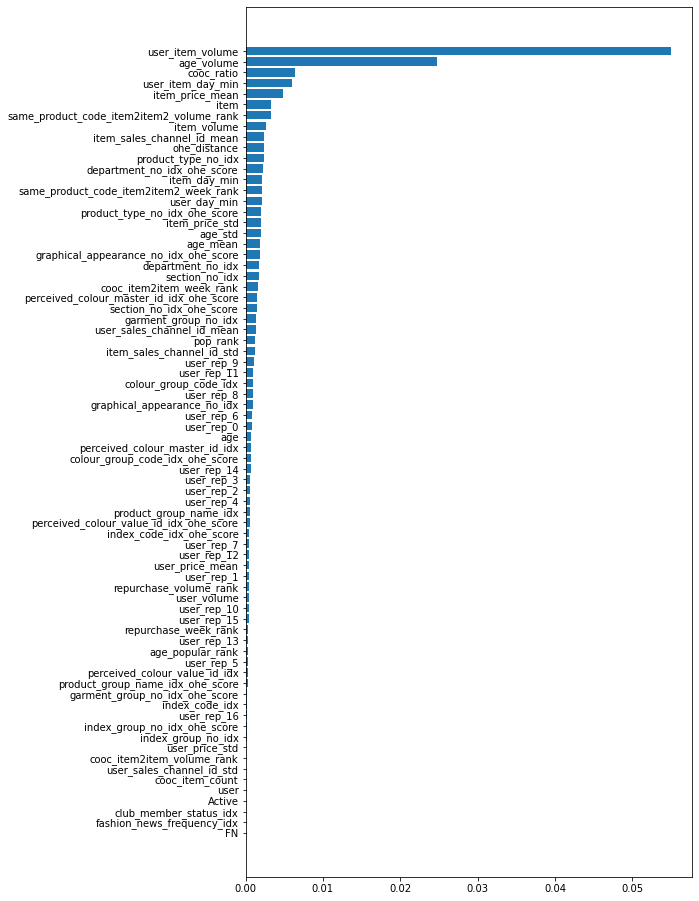

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12202

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 5.384 s


[popular] 1.512 s


[age popular] 0.693 s


[item2item] 5.216 s


[item2item2] 5.086 s


[cooccurrence] 58.132 s


[same_product_code] 4.829 s


[ohe distance] 13.326 s


volume: 27039885


duplicates: 1.1031831047768113


            strategy   volume     ratio
0                pop  8231880  0.304435
1  same_product_code  6635618  0.245401
2       ohe_distance  6412711  0.237157
3         repurchase  2735882  0.101179
4            age_pop  1626996  0.060170
5               cooc  1396798  0.051657


attach features (week: 0)


[user static fetaures] 2.316 s


[item stacic features] 7.216 s


[user dynamic features (transactions)] 6.571 s


[item dynamic features (transactions)] 3.922 s


[item dynamic features (user features)] 6.812 s


[item freshness features] 5.856 s


[item volume features] 4.468 s


[user freshness features] 7.812 s


[user volume features] 6.193 s


[user-item freshness features] 25.941 s


[user-item volume features] 11.739 s


[item age volume features] 7.342 s


[ohe dot products] 135.265 s


[lfm features] 13.013 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.621 s


[popular] 1.560 s


[age popular] 0.755 s


[item2item] 5.474 s


[item2item2] 5.411 s


[cooccurrence] 58.444 s


[same_product_code] 5.053 s


[ohe distance] 10.662 s


volume: 27069354


duplicates: 1.1030125429821485


            strategy   volume     ratio
0                pop  8231880  0.304103
1  same_product_code  6653380  0.245790
2       ohe_distance  6409891  0.236795
3         repurchase  2752227  0.101673
4            age_pop  1627296  0.060116
5               cooc  1394680  0.051522


attach features (week: 0)


[user static fetaures] 2.294 s


[item stacic features] 7.275 s


[user dynamic features (transactions)] 6.755 s


[item dynamic features (transactions)] 3.992 s


[item dynamic features (user features)] 6.834 s


[item freshness features] 5.986 s


[item volume features] 4.432 s


[user freshness features] 7.983 s


[user volume features] 6.173 s


[user-item freshness features] 25.896 s


[user-item volume features] 11.852 s


[item age volume features] 7.278 s


[ohe dot products] 131.436 s


[lfm features] 12.418 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.459 s


[popular] 1.576 s


[age popular] 0.742 s


[item2item] 5.291 s


[item2item2] 5.196 s


[cooccurrence] 58.353 s


[same_product_code] 4.913 s


[ohe distance] 10.638 s


volume: 26999342


duplicates: 1.103228861824164


            strategy   volume     ratio
0                pop  8231880  0.304892
1  same_product_code  6634369  0.245723
2       ohe_distance  6412683  0.237513
3         repurchase  2708651  0.100323
4            age_pop  1626840  0.060255
5               cooc  1384919  0.051295


attach features (week: 0)


[user static fetaures] 2.306 s


[item stacic features] 7.274 s


[user dynamic features (transactions)] 6.630 s


[item dynamic features (transactions)] 3.836 s


[item dynamic features (user features)] 6.805 s


[item freshness features] 5.972 s


[item volume features] 4.408 s


[user freshness features] 8.042 s


[user volume features] 6.203 s


[user-item freshness features] 25.882 s


[user-item volume features] 12.121 s


[item age volume features] 7.311 s


[ohe dot products] 131.008 s


[lfm features] 14.449 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.490 s


[popular] 1.566 s


[age popular] 0.732 s


[item2item] 5.289 s


[item2item2] 5.209 s


[cooccurrence] 58.424 s


[same_product_code] 4.868 s


[ohe distance] 10.599 s


volume: 27050229


duplicates: 1.103213497084992


            strategy   volume     ratio
0                pop  8231880  0.304318
1  same_product_code  6636093  0.245325
2       ohe_distance  6411150  0.237009
3         repurchase  2737078  0.101185
4            age_pop  1628148  0.060190
5               cooc  1405880  0.051973


attach features (week: 0)


[user static fetaures] 2.320 s


[item stacic features] 7.285 s


[user dynamic features (transactions)] 6.636 s


[item dynamic features (transactions)] 3.986 s


[item dynamic features (user features)] 6.866 s


[item freshness features] 5.947 s


[item volume features] 4.421 s


[user freshness features] 7.970 s


[user volume features] 6.187 s


[user-item freshness features] 25.988 s


[user-item volume features] 11.940 s


[item age volume features] 7.333 s


[ohe dot products] 132.440 s


[lfm features] 12.827 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.489 s


[popular] 1.582 s


[age popular] 0.742 s


[item2item] 5.342 s


[item2item2] 5.231 s


[cooccurrence] 58.444 s


[same_product_code] 5.065 s


[ohe distance] 10.641 s


volume: 27038752


duplicates: 1.1031812130992007


            strategy   volume     ratio
0                pop  8231880  0.304447
1  same_product_code  6630508  0.245222
2       ohe_distance  6413390  0.237193
3         repurchase  2739307  0.101310
4            age_pop  1627584  0.060194
5               cooc  1396083  0.051633


attach features (week: 0)


[user static fetaures] 2.319 s


[item stacic features] 7.244 s


[user dynamic features (transactions)] 6.635 s


[item dynamic features (transactions)] 4.018 s


[item dynamic features (user features)] 6.888 s


[item freshness features] 5.989 s


[item volume features] 4.487 s


[user freshness features] 7.990 s


[user volume features] 6.229 s


[user-item freshness features] 25.983 s


[user-item volume features] 11.918 s


[item age volume features] 7.228 s


[ohe dot products] 131.920 s


[lfm features] 12.080 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.482 s


[popular] 1.572 s


[age popular] 0.737 s


[item2item] 5.410 s


[item2item2] 5.223 s


[cooccurrence] 58.212 s


[same_product_code] 4.901 s


[ohe distance] 10.604 s


volume: 27077191


duplicates: 1.10327308014338


            strategy   volume     ratio
0                pop  8231880  0.304015
1  same_product_code  6653866  0.245737
2       ohe_distance  6408989  0.236693
3         repurchase  2745003  0.101377
4            age_pop  1627032  0.060089
5               cooc  1410421  0.052089


attach features (week: 0)


[user static fetaures] 2.316 s


[item stacic features] 7.244 s


[user dynamic features (transactions)] 6.551 s


[item dynamic features (transactions)] 3.980 s


[item dynamic features (user features)] 6.759 s


[item freshness features] 5.954 s


[item volume features] 4.400 s


[user freshness features] 7.966 s


[user volume features] 6.123 s


[user-item freshness features] 25.908 s


[user-item volume features] 11.717 s


[item age volume features] 7.219 s


[ohe dot products] 130.617 s


[lfm features] 12.466 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.505 s


[popular] 1.621 s


[age popular] 0.763 s


[item2item] 5.373 s


[item2item2] 5.249 s


[cooccurrence] 59.190 s


[same_product_code] 5.006 s


[ohe distance] 10.971 s


volume: 27014107


duplicates: 1.1034181441923343


            strategy   volume     ratio
0                pop  8231880  0.304725
1  same_product_code  6623896  0.245201
2       ohe_distance  6411560  0.237341
3         repurchase  2714357  0.100479
4            age_pop  1626984  0.060227
5               cooc  1405430  0.052026


attach features (week: 0)


[user static fetaures] 2.364 s


[item stacic features] 7.362 s


[user dynamic features (transactions)] 6.839 s


[item dynamic features (transactions)] 3.912 s


[item dynamic features (user features)] 6.932 s


[item freshness features] 6.079 s


[item volume features] 4.454 s


[user freshness features] 8.192 s


[user volume features] 6.378 s


[user-item freshness features] 26.441 s


[user-item volume features] 12.241 s


[item age volume features] 7.423 s


[ohe dot products] 133.088 s


[lfm features] 15.569 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.476 s


[popular] 1.574 s


[age popular] 0.741 s


[item2item] 5.300 s


[item2item2] 5.180 s


[cooccurrence] 58.293 s


[same_product_code] 4.935 s


[ohe distance] 10.634 s


volume: 27029146


duplicates: 1.1035451169872357


            strategy   volume     ratio
0                pop  8231880  0.304556
1  same_product_code  6618201  0.244854
2       ohe_distance  6411573  0.237210
3         repurchase  2731902  0.101072
4            age_pop  1628148  0.060237
5               cooc  1407442  0.052071


attach features (week: 0)


[user static fetaures] 2.317 s


[item stacic features] 7.255 s


[user dynamic features (transactions)] 6.630 s


[item dynamic features (transactions)] 3.995 s


[item dynamic features (user features)] 6.818 s


[item freshness features] 5.955 s


[item volume features] 4.394 s


[user freshness features] 7.984 s


[user volume features] 6.168 s


[user-item freshness features] 25.987 s


[user-item volume features] 11.789 s


[item age volume features] 7.248 s


[ohe dot products] 131.205 s


[lfm features] 12.706 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.319 s


[popular] 1.563 s


[age popular] 0.728 s


[item2item] 5.112 s


[item2item2] 5.064 s


[cooccurrence] 57.568 s


[same_product_code] 4.840 s


[ohe distance] 10.393 s


volume: 26964222


duplicates: 1.1032502653768843


            strategy   volume     ratio
0                pop  8231880  0.305289
1  same_product_code  6593059  0.244511
2       ohe_distance  6408148  0.237654
3         repurchase  2711285  0.100551
4            age_pop  1627380  0.060353
5               cooc  1392470  0.051641


attach features (week: 0)


[user static fetaures] 2.269 s


[item stacic features] 7.139 s


[user dynamic features (transactions)] 6.507 s


[item dynamic features (transactions)] 3.771 s


[item dynamic features (user features)] 6.725 s


[item freshness features] 5.717 s


[item volume features] 4.407 s


[user freshness features] 7.690 s


[user volume features] 6.191 s


[user-item freshness features] 25.614 s


[user-item volume features] 11.653 s


[item age volume features] 7.250 s


[ohe dot products] 131.122 s


[lfm features] 14.633 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.408 s


[popular] 1.600 s


[age popular] 0.727 s


[item2item] 5.230 s


[item2item2] 5.188 s


[cooccurrence] 57.865 s


[same_product_code] 4.864 s


[ohe distance] 10.429 s


volume: 27038251


duplicates: 1.103235492239089


            strategy   volume     ratio
0                pop  8231880  0.304453
1  same_product_code  6638864  0.245536
2       ohe_distance  6411401  0.237123
3         repurchase  2730747  0.100996
4            age_pop  1627020  0.060175
5               cooc  1398339  0.051717


attach features (week: 0)


[user static fetaures] 2.277 s


[item stacic features] 7.187 s


[user dynamic features (transactions)] 6.461 s


[item dynamic features (transactions)] 3.785 s


[item dynamic features (user features)] 6.730 s


[item freshness features] 5.708 s


[item volume features] 4.405 s


[user freshness features] 7.637 s


[user volume features] 6.149 s


[user-item freshness features] 25.588 s


[user-item volume features] 11.885 s


[item age volume features] 7.248 s


[ohe dot products] 132.475 s


[lfm features] 12.477 s


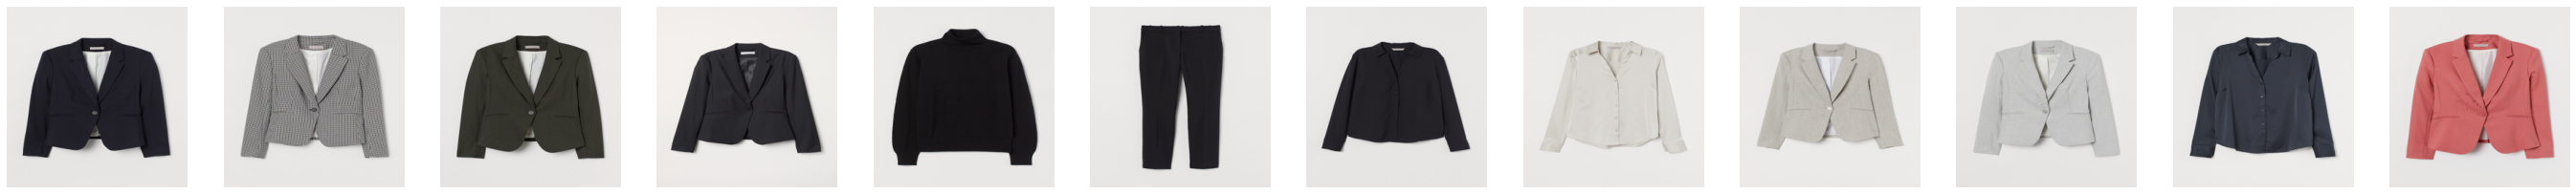

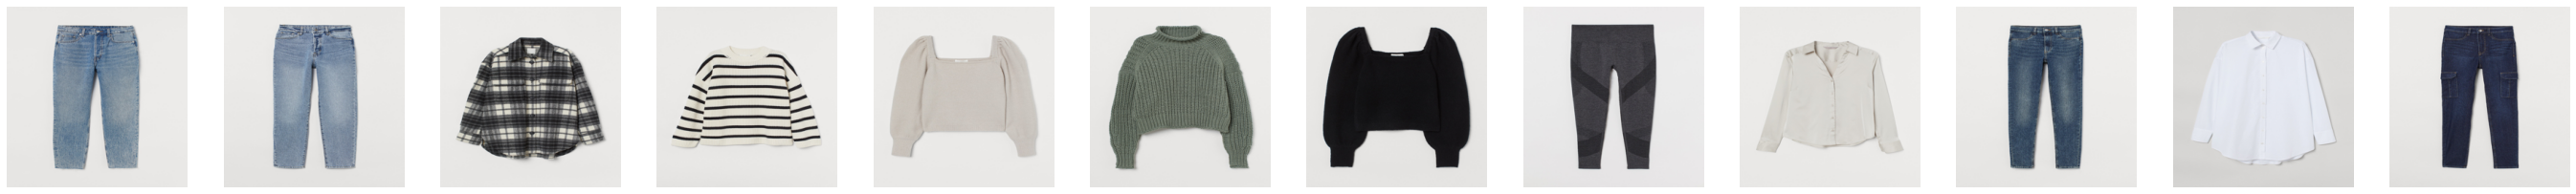

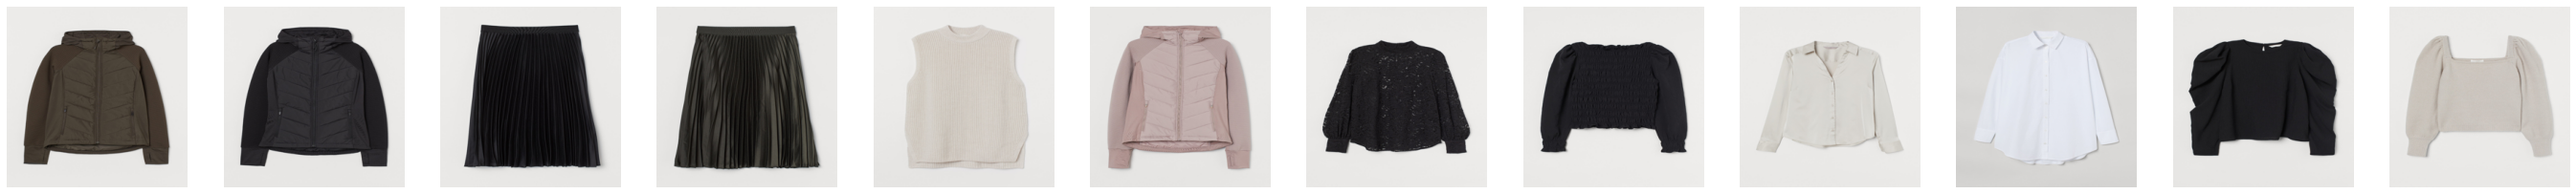

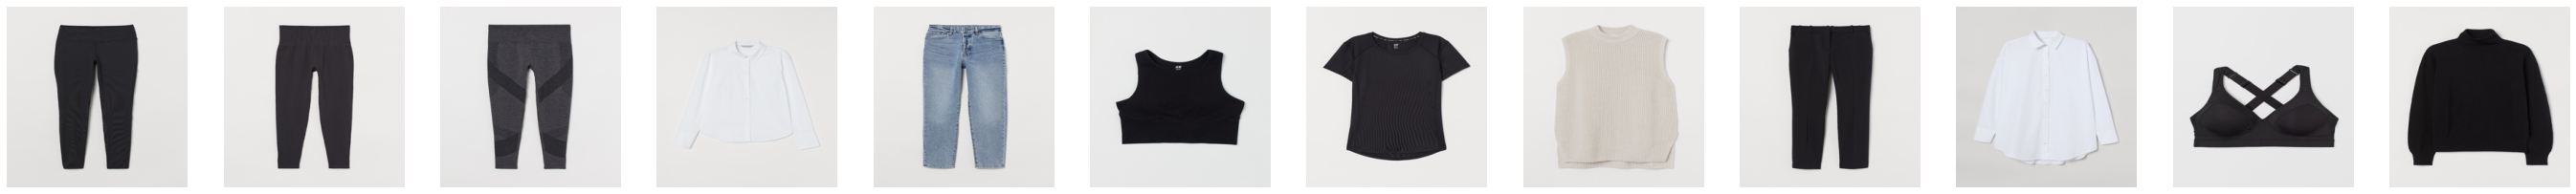

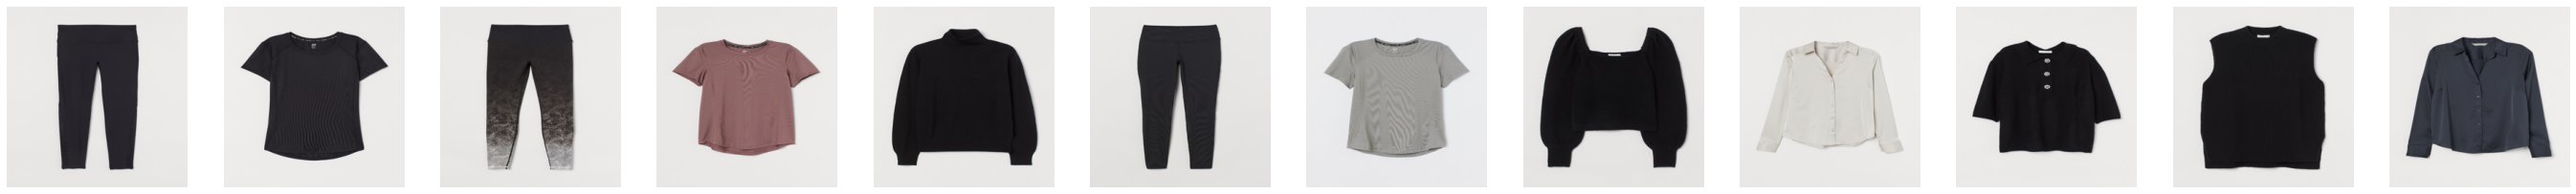

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601007 0568601044 0568601043 0568601006 06...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0898692006 0863583001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0851400001 0851400020 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0852584001 0866731001 0918292001 0850917001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0730683062 0791587021 06...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0791587015 0804992014 09...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846031 0448509014 0762846026 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846006 0762846031 0762846026 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0714790028 0715624001 07...


In [27]:
submission.to_csv('submission.csv', index=False)